In [ ]:
# !pip yfinance -q

[*********************100%***********************]  1 of 1 completed


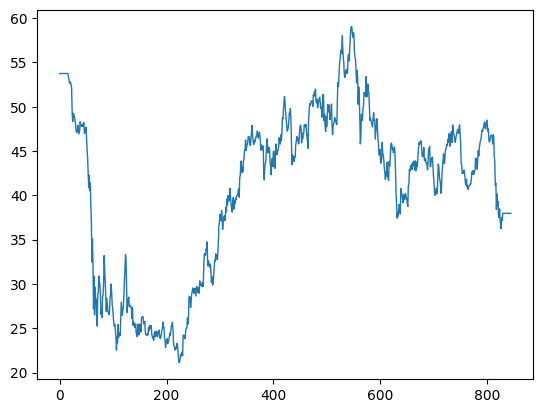

In [36]:
import yfinance as yf
import random 
import numpy as np
import pandas as pd
import random
import numpy as np
from collections import deque, namedtuple
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from tqdm import tqdm
import os
import gc
from matplotlib import pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
%matplotlib inline
CONTEXT=30

start_date = "2020-01-01"
end_date = "2023-3-30"
ticker = "WFC"

df = yf.download(ticker, start_date, end_date)['Close'][0:]

# df=pd.read_csv("wendy.csv")['Close'][0:200] 
stock_price=np.array(df)
stock_price=np.pad(stock_price, (CONTEXT//2,CONTEXT//2),'constant', constant_values=(stock_price[0], stock_price[-1]))
plt.plot(stock_price, linewidth=1)


In [37]:
df=pd.DataFrame(df, columns=['Close'])
display(df)

,Close
Date,
2020-01-02,53.750000
2020-01-03,53.419998
2020-01-06,53.099998
2020-01-07,52.660000
2020-01-08,52.820000
...,...
2023-03-23,36.610001
2023-03-24,36.230000
2023-03-27,37.470001


In [38]:
#df11=pd.read_csv("/content/wendy.csv")[0:200].reset_index()
#RSI
df['change'] = df['Close'].diff()
# df11['gain'] = df11.change.mask(df11.change < 0, 0.0)
# df11['loss'] = -df11.change.mask(df11.change > 0, -0.0)
def rma(x, n):
    """Running moving average"""
    a = np.full_like(x, np.nan)
    a[n] = x[1:n+1].mean()
    for i in range(n+1, len(x)):
        a[i] = (a[i-1] * (n - 1) + x[i]) / n
    return a

# df11['avg_gain'] = rma(df11.gain.to_numpy(), 14)        
# df11['avg_loss'] = rma(df11.loss.to_numpy(), 14)     


# df11['rs'] = df11.avg_gain / df11.avg_loss
# df11['rsi'] = 100 - (100 / (1 + df11.rs))
# #EMA
# df11['EWMA30'] = df11['Close'].ewm(span=30).mean()

# #SMA
# df11['SMA30'] = df11['Close'].rolling(30).mean()
df.fillna(0,inplace=True)

# #stock_price=np.array(df11.iloc[:,2:])
df.iloc[:,]


,Close,change
Date,,
2020-01-02,53.750000,0.000000
2020-01-03,53.419998,-0.330002
2020-01-06,53.099998,-0.320000
2020-01-07,52.660000,-0.439999
2020-01-08,52.820000,0.160000
...,...,...
2023-03-23,36.610001,-0.590000
2023-03-24,36.230000,-0.380001
2023-03-27,37.470001,1.240002


In [39]:
#370 days, 10 technical indicators
print(stock_price.shape)
#stock_price

(846,)


In [40]:
stock_delta=np.array(df['change'] )
stock_delta=np.pad(stock_delta, (CONTEXT//2,CONTEXT//2),'constant', constant_values=(stock_delta[0], stock_delta[-1]))
stock_delta.shape

(846,)

In [41]:
TRANSACTION=0.001
class GameAI:  # the AI go through the stock, look at a window of prices, and try to make actions at each timestep
    def __init__(self, w=CONTEXT):
        self.w = w #window size
        self.reset() 

    def reset(self):
        # restart game, initialize game state
        self.money=1000000  
        self.inital_property=10000*stock_price[0]+self.money  #initial total investment = 10,000 shares + cash

        self.positions=10000   # shares holding
        self.today=self.w//2  
        self.window_right=self.w
        self.window_left=0 
        
        self.today_price = stock_price[self.today]
        self.window = stock_price[ 0: self.w] 
        self.window1= stock_delta[ 0: self.w]
        
        self.previous_reward=0  #to store and plot the mean reward during each game to see if improves
        self.yesterday_property=self.inital_property
        self.profit=0 


    def play_step(self, action):
        self.yesterday_property=(self.money + self.today_price*self.positions )

        # 2. make a move, compute money, update positions
        self.today+=1 # update the head and window
        self.today_price=stock_price[self.today] 
        self.money=self.money - self.today_price*action  

        #update positions
        self.positions+=action     #shares in hand
        #move window forward
        self.window_left+=1 
        self.window_right+=1
        self.window=stock_price[self.window_left:self.window_right] 
        self.window1=stock_delta[self.window_left:self.window_right] 

        # 3. check if game over
        game_over = False

        if self.is_collision():
            game_over = True
            reward= (self.money + self.today_price*self.positions ) - self.yesterday_property     #-  abs(action)*TRANSACTION
            
            #calculate profit at the end of each game
            self.profit= ((self.money + self.today_price*self.positions )-self.inital_property) /self.inital_property  #profitability at the end of each game
            
            return reward, game_over

        #the reward function will be defined as the difference between the portfolio value 
        #at the end of the time step and the portfolio value at the beginning of the time step.

        reward= (self.money + self.today_price*self.positions ) - self.yesterday_property     #-  abs(action)*TRANSACTION
        #self.previous_reward=reward  #record reward

        return reward, game_over


    def is_collision(self):
        # hits boundary 
        if self.window_right>len(stock_price)-1:
            return True
        return False


In [42]:
ACTION_SPACE=np.arange(-5000,5001,300)
ACTION_SPACE


array([-5000, -4700, -4400, -4100, -3800, -3500, -3200, -2900, -2600,
       -2300, -2000, -1700, -1400, -1100,  -800,  -500,  -200,   100,
         400,   700,  1000,  1300,  1600,  1900,  2200,  2500,  2800,
        3100,  3400,  3700,  4000,  4300,  4600,  4900])

In [43]:
STATE_SIZE=CONTEXT+2 #prices in window + position and money in hand

ACTION_SPACE=np.arange(-5000,5001,300).tolist()    #actions
ACTION_SIZE=len(ACTION_SPACE)
BATCH_SIZE = 512

#for each state the network gives the values of all possible actions in the action space
class Linear_QNet(nn.Module):
    def __init__(self, state_size, action_size, size1=512, size2=256, size3=64):
        super().__init__()
        # self.embedding = nn.Sequential(
        # nn.Conv1d(state_size, 128, kernel_size=3, padding=1, bias=False),
        # nn.BatchNorm1d(128),
        # nn.LeakyReLU(inplace=True),
        # nn.Conv1d(128, 128, kernel_size=3, padding=1, bias=False),
        # nn.BatchNorm1d(128),
        # nn.LeakyReLU(inplace=True),
        # nn.Conv1d(128, 128, kernel_size=3, padding=1, bias=False),
        # nn.BatchNorm1d(128)
        # )

        self.fc=nn.Sequential(
            
        nn.Linear(state_size, size1),
        nn.GELU(),

        nn.Linear(size1, size2),
        nn.GELU(),

        nn.Linear(size2, size3),
        nn.GELU(),

        nn.Linear(size3, action_size)
        )

    def forward(self, x):
        out=self.fc(x)
        #print("our",out.size())
        return out

model = Linear_QNet(state_size=STATE_SIZE, action_size=ACTION_SIZE, size1=512, size2=256, size3=128)

LR = 0.001
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.SmoothL1Loss()
# scaler= torch.cuda.amp.GradScaler()
class QTrainer:
    def __init__(self, model, gamma):
        self.gamma = gamma
        self.model = model

    def train_step(self, state, action, reward, next_state, done):
        # Convert batch to tensors
        
        states_tensor = torch.FloatTensor(state)  #b * state_size 
        actions_tensor = torch.LongTensor(action)  #b 
        rewards_tensor = torch.FloatTensor(reward) #b 
        next_states_tensor = torch.FloatTensor(next_state)  #b * state_size 
        dones_tensor = torch.BoolTensor(done)  #b

        with torch.cuda.amp.autocast():
          with torch.no_grad():

              #the model predicts Q values in the next state
              q_values_next = self.model(next_states_tensor)    #b* ACTION
              #find biggest Q the model predicted in the next state
              max_q_values_next, _ = torch.max(q_values_next, dim=1) 
              #bellman equation, 
              target_q = rewards_tensor + self.gamma * max_q_values_next * (~dones_tensor)
          
          # Compute predicted Q-values and update model
          q_values_pred = self.model(states_tensor)    #64*ACTION

          actions_index=[]
          for b in range(BATCH_SIZE):
            #print(actions_tensor[b])
            actions_index.append(ACTION_SPACE.index(actions_tensor[b]))
          actions_index=torch.tensor(actions_index, dtype=torch.int64)

          q_values_pred_selected = q_values_pred.gather(1, actions_index.unsqueeze(1)).squeeze(1)
           #b * state_size 


        loss = criterion(torch.FloatTensor(q_values_pred_selected), target_q) / (BATCH_SIZE*1e+6)
        total_loss=loss.item()

        optimizer.zero_grad()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1e+8)
        optimizer.step()

        return total_loss


In [44]:

MAX_MEMORY = 100000 # record 100000 state, action, reward, next_state, done tuples
# UPDATE_EVERY = 4        # how often to update the network

class Agent:
    def __init__(self):
        self.n_games = 0
        self.epsilon = 0 # epislon-greedy
        self.gamma = 0.999 # discount future reward
        self.memory = deque(maxlen=MAX_MEMORY) # a collection of past experiences 
        self.trainer = QTrainer(model, gamma=self.gamma) 

    def get_state(self, game):
        window=np.array(game.window) #prices in window
        window=np.array(game.window)
        window1=np.array(game.window1) *100 # price change 
        
        money=game.money #your money
        positions=game.positions #your positions
        state= np.concatenate( ([positions],[money],  window1)   ) #state
        return state

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done)) # popleft if MAX_MEMORY is reached

    def train_single_experience(self, states, actions, rewards, next_states, dones):
        states=(states- np.mean(states,axis=0))/np.std(states,axis=0) #normalize states
        loss=self.trainer.train_step(states, actions, rewards, next_states, dones)
        return loss
        
    def train_batch_experience(self):
        if len(self.memory) >= BATCH_SIZE:
            batch_sample = random.sample(self.memory, BATCH_SIZE)  # list of tuples

            #pass in batch to train
            states, actions, rewards, next_states, dones = zip(*batch_sample)
            #print(np.array(states).shape)
            states=(states- np.mean(states,axis=1,keepdims=True))/np.std(states,axis=1,keepdims=True) #Normalize
            loss=self.trainer.train_step(states, actions, rewards, next_states, dones)
            return loss
            
    def get_action(self, state, game):    # e p s i l o n greedy---------------------------------------------------------------------------------
        #80% possibility of taking random action. decrease in time
        self.epsilon = 80 - self.n_games//50   #100 games reduce 1% chance of choosing action other than the best action
        if self.epsilon<5:
          self.epsilon=5 #not allowing below 5%  randomness
        position=state[0]
        money=state[1]
        today_price=game.window[game.w//2]
        
        #explore random actions
        if random.randint(0, 100) < max(self.epsilon,0) or (len(self.memory) <= BATCH_SIZE):
            actions=np.array(ACTION_SPACE)
            final_move=np.random.choice(actions)  

            #cannot buy more than the money you have, find closest value in the action space
            if final_move > money//today_price:
              for a in reversed(ACTION_SPACE): # find action that doesn't use up all your money in action space
                if a>=0 and a< money//today_price:
                  final_move= a
                  #print( final_move)
            
            if final_move<0 and final_move<-position:    
              for a in ACTION_SPACE:  #find action that doesn't sell all your shares in action space
                if a<=0 and a+position>=0:
                  final_move = a
                  #print( final_move)

        #take max q action
        else:
            state_input = torch.tensor(state, dtype=torch.float)
            
            Q_pred= model(state_input)
            move = torch.argmax(Q_pred).item() # 
            
            #allowable=np.clip(move, -position, money//today_price)    
            final_move=ACTION_SPACE[move]
            
            #cannot buy more than the money you have, find closest value in the action space
            if final_move > money//today_price:
              for a in reversed(ACTION_SPACE):
                if a>=0 and a< money//today_price: #find action that doesn't use up all your money in action space
                  final_move= a 
            
            if final_move<0 and final_move<-position:   
              for a in ACTION_SPACE: #find action that doesn't sell all your shares in action space
                if a<=0 and a+position>=0:
                  final_move = a

        return final_move

actions=[]
optimizer = optim.Adam(model.parameters(), lr=LR)
plot_profit=[]
plot_reward=[]
def train():
    rewards = []
    record = 0
    agent = Agent()
    game = GameAI()
    epoch=3500000 #a very large number just to keep the game running
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=stock_price.shape[0], gamma=0.999)
    for i in tqdm( range(1,epoch+1) ):
        
        curr_lr = float(optimizer.param_groups[0]['lr'])
        # state
        state_old = agent.get_state(game)
        # action
        final_move = agent.get_action(state_old, game)
        actions.append(final_move)
        # reward
        reward, done= game.play_step(action=final_move)
        # next state
        state_new = agent.get_state(game)

        # memory stored for replay
        agent.remember(state_old, final_move, reward, state_new, done)
        #TODO: train_single
        #loss=agent.train_single_experience(state_old, final_move, reward, state_new, done)
        

        rewards.append(reward)
        
        profit=game.profit

        if done:# 
            #print(i) #tells you length of game
            mean_reward=np.mean(rewards)
            plot_reward.append(mean_reward)
            rewards=[]
            # train minibatch
            loss=agent.train_batch_experience()

            game.reset()
            agent.n_games += 1
            
            if profit > record:
                record = profit
               # agent.model.save()

            print('Game', agent.n_games,"mean Reward", round(mean_reward,2), 'Profit', round(profit*100,2) ,'Record:', round(record*100,2), "lr: ", round(curr_lr,8),"eps",agent.epsilon, "loss", round(loss,4) )

            plot_profit.append(profit)
        scheduler.step()


In [45]:
gc.collect()
torch.cuda.empty_cache()

In [46]:
train()
#profit is the percentage of cumulated money through the money over money that I had in hand before the game
#mean reward is the average daily dollar returns in each game

  0%|          | 0/5000000 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
  0%|          | 790/5000000 [00:00<10:33, 7889.87it/s]/usr/local/lib/python3.9/dist-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
  0%|          | 1579/5000000 [00:00<18:35, 4479.65it/s]

Game 1 mean Reward 1126.31 Profit 59.78 Record: 59.78 lr:  0.001 eps 80 loss 0.0001


  0%|          | 2107/5000000 [00:00<22:01, 3780.95it/s]

Game 2 mean Reward 2356.55 Profit 125.07 Record: 125.07 lr:  0.000999 eps 80 loss 0.0001


  0%|          | 3207/5000000 [00:00<20:01, 4158.63it/s]

Game 3 mean Reward 447.05 Profit 23.73 Record: 125.07 lr:  0.000998 eps 80 loss 0.0001


  0%|          | 3678/5000000 [00:00<23:43, 3511.00it/s]

Game 4 mean Reward 1609.62 Profit 85.43 Record: 125.07 lr:  0.000997 eps 80 loss 0.0001


  0%|          | 4670/5000000 [00:01<21:40, 3841.70it/s]

Game 5 mean Reward -244.57 Profit -12.98 Record: 125.07 lr:  0.00099601 eps 80 loss 0.0002


  0%|          | 5687/5000000 [00:01<21:15, 3914.56it/s]

Game 6 mean Reward 1916.08 Profit 101.69 Record: 125.07 lr:  0.00099501 eps 80 loss 0.0002


  0%|          | 6125/5000000 [00:01<24:15, 3430.88it/s]

Game 7 mean Reward 961.81 Profit 51.05 Record: 125.07 lr:  0.00099401 eps 80 loss 0.0002


  0%|          | 7170/5000000 [00:01<21:47, 3818.81it/s]

Game 8 mean Reward 744.44 Profit 39.51 Record: 125.07 lr:  0.00099302 eps 80 loss 0.0001


  0%|          | 7601/5000000 [00:02<24:44, 3362.48it/s]

Game 9 mean Reward 2059.53 Profit 109.31 Record: 125.07 lr:  0.00099203 eps 80 loss 0.0002


  0%|          | 8837/5000000 [00:02<20:56, 3972.62it/s]

Game 10 mean Reward 1776.08 Profit 94.26 Record: 125.07 lr:  0.00099104 eps 80 loss 0.0002


  0%|          | 9287/5000000 [00:02<23:34, 3529.05it/s]

Game 11 mean Reward 731.18 Profit 38.81 Record: 125.07 lr:  0.00099004 eps 80 loss 0.0002


  0%|          | 10463/5000000 [00:02<20:53, 3981.02it/s]

Game 12 mean Reward 393.26 Profit 20.87 Record: 125.07 lr:  0.00098905 eps 80 loss 0.0002


  0%|          | 10915/5000000 [00:03<23:49, 3490.52it/s]

Game 13 mean Reward 705.68 Profit 37.45 Record: 125.07 lr:  0.00098807 eps 80 loss 0.0002


  0%|          | 12023/5000000 [00:03<21:37, 3843.80it/s]

Game 14 mean Reward 799.08 Profit 42.41 Record: 125.07 lr:  0.00098708 eps 80 loss 0.0002


  0%|          | 12455/5000000 [00:03<24:19, 3416.46it/s]

Game 15 mean Reward 999.81 Profit 53.06 Record: 125.07 lr:  0.00098609 eps 80 loss 0.0002


  0%|          | 13637/5000000 [00:03<21:47, 3814.19it/s]

Game 16 mean Reward 335.9 Profit 17.83 Record: 125.07 lr:  0.0009851 eps 80 loss 0.0002


  0%|          | 14637/5000000 [00:04<21:08, 3931.61it/s]

Game 17 mean Reward 1296.74 Profit 68.82 Record: 125.07 lr:  0.00098412 eps 80 loss 0.0002


  0%|          | 15072/5000000 [00:04<24:17, 3419.37it/s]

Game 18 mean Reward 775.73 Profit 41.17 Record: 125.07 lr:  0.00098314 eps 80 loss 0.0002


  0%|          | 15954/5000000 [00:04<25:21, 3275.54it/s]

Game 19 mean Reward -72.68 Profit -3.86 Record: 125.07 lr:  0.00098215 eps 80 loss 0.0002


  0%|          | 16825/5000000 [00:04<26:41, 3110.89it/s]

Game 20 mean Reward 295.4 Profit 15.68 Record: 125.07 lr:  0.00098117 eps 80 loss 0.0002


  0%|          | 17755/5000000 [00:05<26:05, 3182.12it/s]

Game 21 mean Reward 1128.21 Profit 59.88 Record: 125.07 lr:  0.00098019 eps 80 loss 0.0002


  0%|          | 18540/5000000 [00:05<29:43, 2793.03it/s]

Game 22 mean Reward 75.08 Profit 3.98 Record: 125.07 lr:  0.00097921 eps 80 loss 0.0002


  0%|          | 19432/5000000 [00:05<27:34, 3010.53it/s]

Game 23 mean Reward -958.25 Profit -50.86 Record: 125.07 lr:  0.00097823 eps 80 loss 0.0002


  0%|          | 20299/5000000 [00:06<27:44, 2992.01it/s]

Game 24 mean Reward 121.9 Profit 6.47 Record: 125.07 lr:  0.00097725 eps 80 loss 0.0002


  0%|          | 20664/5000000 [00:06<33:12, 2499.38it/s]

Game 25 mean Reward 602.39 Profit 31.97 Record: 125.07 lr:  0.00097627 eps 80 loss 0.0002


  0%|          | 21819/5000000 [00:06<24:44, 3353.53it/s]

Game 26 mean Reward 883.36 Profit 46.88 Record: 125.07 lr:  0.0009753 eps 80 loss 0.0002


  0%|          | 22784/5000000 [00:06<22:32, 3680.38it/s]

Game 27 mean Reward -1035.98 Profit -54.98 Record: 125.07 lr:  0.00097432 eps 80 loss 0.0002


  0%|          | 23203/5000000 [00:07<25:31, 3249.59it/s]

Game 28 mean Reward -476.24 Profit -25.28 Record: 125.07 lr:  0.00097335 eps 80 loss 0.0002


  0%|          | 24310/5000000 [00:07<21:48, 3801.80it/s]

Game 29 mean Reward 611.77 Profit 32.47 Record: 125.07 lr:  0.00097335 eps 80 loss 0.0002


  0%|          | 24740/5000000 [00:07<24:20, 3406.21it/s]

Game 30 mean Reward -1034.71 Profit -54.92 Record: 125.07 lr:  0.00097237 eps 80 loss 0.0002


  1%|          | 25862/5000000 [00:07<21:41, 3822.82it/s]

Game 31 mean Reward 351.16 Profit 18.64 Record: 125.07 lr:  0.0009714 eps 80 loss 0.0002


  1%|          | 26886/5000000 [00:08<20:27, 4051.86it/s]

Game 32 mean Reward 509.51 Profit 27.04 Record: 125.07 lr:  0.00097043 eps 80 loss 0.0002


  1%|          | 27330/5000000 [00:08<23:34, 3515.72it/s]

Game 33 mean Reward 1342.83 Profit 71.27 Record: 125.07 lr:  0.00096946 eps 80 loss 0.0002


  1%|          | 28235/5000000 [00:08<23:10, 3576.55it/s]

Game 34 mean Reward 1053.56 Profit 55.92 Record: 125.07 lr:  0.00096849 eps 80 loss 0.0002


  1%|          | 29249/5000000 [00:08<21:04, 3929.86it/s]

Game 35 mean Reward 702.02 Profit 37.26 Record: 125.07 lr:  0.00096752 eps 80 loss 0.0002


  1%|          | 29680/5000000 [00:08<23:34, 3513.86it/s]

Game 36 mean Reward 961.84 Profit 51.05 Record: 125.07 lr:  0.00096656 eps 80 loss 0.0002


  1%|          | 30828/5000000 [00:09<20:45, 3990.02it/s]

Game 37 mean Reward -533.73 Profit -28.33 Record: 125.07 lr:  0.00096559 eps 80 loss 0.0002


  1%|          | 31774/5000000 [00:09<21:17, 3887.75it/s]

Game 38 mean Reward -160.62 Profit -8.52 Record: 125.07 lr:  0.00096462 eps 80 loss 0.0002


  1%|          | 32198/5000000 [00:09<24:41, 3353.66it/s]

Game 39 mean Reward 1026.19 Profit 54.46 Record: 125.07 lr:  0.00096366 eps 80 loss 0.0002


  1%|          | 33211/5000000 [00:09<22:42, 3644.35it/s]

Game 40 mean Reward 890.31 Profit 47.25 Record: 125.07 lr:  0.00096269 eps 80 loss 0.0002


  1%|          | 34212/5000000 [00:10<21:09, 3912.51it/s]

Game 41 mean Reward 1458.89 Profit 77.43 Record: 125.07 lr:  0.00096173 eps 80 loss 0.0002


  1%|          | 34644/5000000 [00:10<24:13, 3415.84it/s]

Game 42 mean Reward 683.51 Profit 36.28 Record: 125.07 lr:  0.00096077 eps 80 loss 0.0002


  1%|          | 35668/5000000 [00:10<22:32, 3671.30it/s]

Game 43 mean Reward 1862.91 Profit 98.87 Record: 125.07 lr:  0.00095981 eps 80 loss 0.0002


  1%|          | 36636/5000000 [00:10<21:56, 3771.47it/s]

Game 44 mean Reward 1376.04 Profit 73.03 Record: 125.07 lr:  0.00095885 eps 80 loss 0.0002


  1%|          | 37056/5000000 [00:10<25:13, 3278.71it/s]

Game 45 mean Reward -143.94 Profit -7.64 Record: 125.07 lr:  0.00095789 eps 80 loss 0.0002


  1%|          | 38108/5000000 [00:11<22:28, 3679.12it/s]

Game 46 mean Reward 354.47 Profit 18.81 Record: 125.07 lr:  0.00095693 eps 80 loss 0.0002


  1%|          | 39145/5000000 [00:11<20:59, 3937.62it/s]

Game 47 mean Reward 1628.35 Profit 86.42 Record: 125.07 lr:  0.00095598 eps 80 loss 0.0002


  1%|          | 39585/5000000 [00:11<23:51, 3465.41it/s]

Game 48 mean Reward 210.45 Profit 11.17 Record: 125.07 lr:  0.00095502 eps 80 loss 0.0002


  1%|          | 40578/5000000 [00:11<21:33, 3833.71it/s]

Game 49 mean Reward -426.45 Profit -22.63 Record: 125.07 lr:  0.00095406 eps 80 loss 0.0002


  1%|          | 41578/5000000 [00:12<21:29, 3846.14it/s]

Game 50 mean Reward -773.16 Profit -41.03 Record: 125.07 lr:  0.00095311 eps 80 loss 0.0002


  1%|          | 42007/5000000 [00:12<24:23, 3388.84it/s]

Game 51 mean Reward 395.68 Profit 21.0 Record: 125.07 lr:  0.00095216 eps 79 loss 0.0002


  1%|          | 42994/5000000 [00:12<22:19, 3701.32it/s]

Game 52 mean Reward 622.62 Profit 33.04 Record: 125.07 lr:  0.00095121 eps 79 loss 0.0002


  1%|          | 44028/5000000 [00:12<20:59, 3935.07it/s]

Game 53 mean Reward 264.68 Profit 14.05 Record: 125.07 lr:  0.00095025 eps 79 loss 0.0002


  1%|          | 44467/5000000 [00:13<23:45, 3477.18it/s]

Game 54 mean Reward 138.73 Profit 7.36 Record: 125.07 lr:  0.0009493 eps 79 loss 0.0002


  1%|          | 45488/5000000 [00:13<21:51, 3778.80it/s]

Game 55 mean Reward -1240.67 Profit -65.85 Record: 125.07 lr:  0.00094835 eps 79 loss 0.0002


  1%|          | 46497/5000000 [00:13<21:06, 3910.15it/s]

Game 56 mean Reward 630.32 Profit 33.45 Record: 125.07 lr:  0.00094741 eps 79 loss 0.0002


  1%|          | 46933/5000000 [00:13<24:15, 3404.03it/s]

Game 57 mean Reward 47.66 Profit 2.53 Record: 125.07 lr:  0.00094741 eps 79 loss 0.0002


  1%|          | 47945/5000000 [00:14<21:44, 3796.55it/s]

Game 58 mean Reward -656.24 Profit -34.83 Record: 125.07 lr:  0.00094646 eps 79 loss 0.0002


  1%|          | 48369/5000000 [00:14<24:26, 3376.05it/s]

Game 59 mean Reward 1973.69 Profit 104.75 Record: 125.07 lr:  0.00094551 eps 79 loss 0.0002


  1%|          | 49590/5000000 [00:14<20:50, 3959.39it/s]

Game 60 mean Reward 1091.89 Profit 57.95 Record: 125.07 lr:  0.00094457 eps 79 loss 0.0002


  1%|          | 50030/5000000 [00:14<23:37, 3492.68it/s]

Game 61 mean Reward 1891.66 Profit 100.4 Record: 125.07 lr:  0.00094362 eps 79 loss 0.0002


  1%|          | 51185/5000000 [00:14<21:16, 3877.13it/s]

Game 62 mean Reward -207.17 Profit -11.0 Record: 125.07 lr:  0.00094268 eps 79 loss 0.0002


  1%|          | 51615/5000000 [00:15<24:17, 3395.22it/s]

Game 63 mean Reward 870.74 Profit 46.21 Record: 125.07 lr:  0.00094174 eps 79 loss 0.0002


  1%|          | 52902/5000000 [00:15<20:21, 4048.91it/s]

Game 64 mean Reward 583.48 Profit 30.97 Record: 125.07 lr:  0.00094079 eps 79 loss 0.0002


  1%|          | 53357/5000000 [00:15<23:28, 3511.90it/s]

Game 65 mean Reward 93.26 Profit 4.95 Record: 125.07 lr:  0.00093985 eps 79 loss 0.0002


  1%|          | 54474/5000000 [00:15<21:15, 3876.24it/s]

Game 66 mean Reward 358.25 Profit 19.01 Record: 125.07 lr:  0.00093891 eps 79 loss 0.0002


  1%|          | 54911/5000000 [00:16<23:52, 3451.61it/s]

Game 67 mean Reward 517.54 Profit 27.47 Record: 125.07 lr:  0.00093797 eps 79 loss 0.0002


  1%|          | 55939/5000000 [00:16<23:21, 3527.93it/s]

Game 68 mean Reward 1102.73 Profit 58.53 Record: 125.07 lr:  0.00093704 eps 79 loss 0.0002


  1%|          | 56702/5000000 [00:16<27:52, 2956.06it/s]

Game 69 mean Reward -365.85 Profit -19.42 Record: 125.07 lr:  0.0009361 eps 79 loss 0.0002


  1%|          | 57892/5000000 [00:17<27:43, 2970.90it/s]

Game 70 mean Reward -168.32 Profit -8.93 Record: 125.07 lr:  0.00093516 eps 79 loss 0.0002


  1%|          | 58681/5000000 [00:17<29:13, 2817.55it/s]

Game 71 mean Reward -465.38 Profit -24.7 Record: 125.07 lr:  0.00093423 eps 79 loss 0.0002


  1%|          | 59406/5000000 [00:17<31:13, 2636.57it/s]

Game 72 mean Reward 228.37 Profit 12.12 Record: 125.07 lr:  0.00093329 eps 79 loss 0.0002


  1%|          | 60163/5000000 [00:18<32:07, 2562.36it/s]

Game 73 mean Reward -1078.28 Profit -57.23 Record: 125.07 lr:  0.00093236 eps 79 loss 0.0002


  1%|          | 61037/5000000 [00:18<29:02, 2834.61it/s]

Game 74 mean Reward 49.44 Profit 2.62 Record: 125.07 lr:  0.00093143 eps 79 loss 0.0002


  1%|          | 61961/5000000 [00:18<24:27, 3364.36it/s]

Game 75 mean Reward 1348.16 Profit 71.55 Record: 125.07 lr:  0.0009305 eps 79 loss 0.0002


  1%|          | 62355/5000000 [00:18<27:01, 3045.16it/s]

Game 76 mean Reward 242.13 Profit 12.85 Record: 125.07 lr:  0.00092957 eps 79 loss 0.0002


  1%|▏         | 63399/5000000 [00:19<23:29, 3501.36it/s]

Game 77 mean Reward 1165.2 Profit 61.84 Record: 125.07 lr:  0.00092864 eps 79 loss 0.0002


  1%|▏         | 64321/5000000 [00:19<22:39, 3631.03it/s]

Game 78 mean Reward 239.42 Profit 12.71 Record: 125.07 lr:  0.00092771 eps 79 loss 0.0002


  1%|▏         | 64725/5000000 [00:19<25:21, 3244.06it/s]

Game 79 mean Reward 1710.49 Profit 90.78 Record: 125.07 lr:  0.00092678 eps 79 loss 0.0002


  1%|▏         | 65806/5000000 [00:19<22:41, 3623.34it/s]

Game 80 mean Reward 492.38 Profit 26.13 Record: 125.07 lr:  0.00092585 eps 79 loss 0.0002


  1%|▏         | 66751/5000000 [00:20<22:18, 3685.04it/s]

Game 81 mean Reward 483.76 Profit 25.67 Record: 125.07 lr:  0.00092493 eps 79 loss 0.0002


  1%|▏         | 67159/5000000 [00:20<25:26, 3231.92it/s]

Game 82 mean Reward -389.19 Profit -20.66 Record: 125.07 lr:  0.000924 eps 79 loss 0.0002


  1%|▏         | 68429/5000000 [00:20<20:45, 3958.11it/s]

Game 83 mean Reward 424.62 Profit 22.54 Record: 125.07 lr:  0.00092308 eps 79 loss 0.0002


  1%|▏         | 68877/5000000 [00:20<24:10, 3399.40it/s]

Game 84 mean Reward 562.54 Profit 29.86 Record: 125.07 lr:  0.00092216 eps 79 loss 0.0002


  1%|▏         | 70002/5000000 [00:21<21:10, 3881.57it/s]

Game 85 mean Reward 2937.77 Profit 155.92 Record: 155.92 lr:  0.00092216 eps 79 loss 0.0002


  1%|▏         | 70443/5000000 [00:21<23:49, 3449.64it/s]

Game 86 mean Reward -157.99 Profit -8.39 Record: 155.92 lr:  0.00092123 eps 79 loss 0.0002


  1%|▏         | 71600/5000000 [00:21<20:57, 3919.40it/s]

Game 87 mean Reward 219.86 Profit 11.67 Record: 155.92 lr:  0.00092031 eps 79 loss 0.0002


  1%|▏         | 72037/5000000 [00:21<23:54, 3434.43it/s]

Game 88 mean Reward 2344.7 Profit 124.44 Record: 155.92 lr:  0.00091939 eps 79 loss 0.0002


  1%|▏         | 73182/5000000 [00:21<21:42, 3782.88it/s]

Game 89 mean Reward 1442.65 Profit 76.57 Record: 155.92 lr:  0.00091847 eps 79 loss 0.0002


  1%|▏         | 74198/5000000 [00:22<21:11, 3873.73it/s]

Game 90 mean Reward 330.88 Profit 17.56 Record: 155.92 lr:  0.00091755 eps 79 loss 0.0002


  1%|▏         | 74632/5000000 [00:22<24:15, 3383.95it/s]

Game 91 mean Reward 964.37 Profit 51.18 Record: 155.92 lr:  0.00091664 eps 79 loss 0.0002


  2%|▏         | 75700/5000000 [00:22<21:40, 3787.80it/s]

Game 92 mean Reward 984.75 Profit 52.26 Record: 155.92 lr:  0.00091572 eps 79 loss 0.0002


  2%|▏         | 76127/5000000 [00:22<24:32, 3344.75it/s]

Game 93 mean Reward 704.84 Profit 37.41 Record: 155.92 lr:  0.0009148 eps 79 loss 0.0002


  2%|▏         | 77294/5000000 [00:23<21:24, 3831.80it/s]

Game 94 mean Reward -306.04 Profit -16.24 Record: 155.92 lr:  0.00091389 eps 79 loss 0.0002


  2%|▏         | 78329/5000000 [00:23<20:50, 3937.23it/s]

Game 95 mean Reward 728.89 Profit 38.68 Record: 155.92 lr:  0.00091298 eps 79 loss 0.0002


  2%|▏         | 78771/5000000 [00:23<23:49, 3442.81it/s]

Game 96 mean Reward 1350.79 Profit 71.69 Record: 155.92 lr:  0.00091206 eps 79 loss 0.0002


  2%|▏         | 79709/5000000 [00:23<23:02, 3559.18it/s]

Game 97 mean Reward -157.27 Profit -8.35 Record: 155.92 lr:  0.00091115 eps 79 loss 0.0002


  2%|▏         | 80717/5000000 [00:24<21:17, 3851.80it/s]

Game 98 mean Reward 362.3 Profit 19.23 Record: 155.92 lr:  0.00091024 eps 79 loss 0.0002


  2%|▏         | 81148/5000000 [00:24<23:57, 3422.45it/s]

Game 99 mean Reward 1035.29 Profit 54.95 Record: 155.92 lr:  0.00090933 eps 79 loss 0.0002


  2%|▏         | 82234/5000000 [00:24<21:00, 3900.28it/s]

Game 100 mean Reward -7.34 Profit -0.39 Record: 155.92 lr:  0.00090842 eps 79 loss 0.0002


  2%|▏         | 83221/5000000 [00:24<21:04, 3889.27it/s]

Game 101 mean Reward 3958.15 Profit 210.07 Record: 210.07 lr:  0.00090751 eps 78 loss 0.0002


  2%|▏         | 83653/5000000 [00:24<24:39, 3322.38it/s]

Game 102 mean Reward 248.56 Profit 13.19 Record: 210.07 lr:  0.0009066 eps 78 loss 0.0002


  2%|▏         | 84589/5000000 [00:25<23:11, 3533.56it/s]

Game 103 mean Reward 272.43 Profit 14.46 Record: 210.07 lr:  0.0009057 eps 78 loss 0.0002


  2%|▏         | 85570/5000000 [00:25<21:33, 3799.16it/s]

Game 104 mean Reward -289.77 Profit -15.38 Record: 210.07 lr:  0.00090479 eps 78 loss 0.0002


  2%|▏         | 85992/5000000 [00:25<24:57, 3282.34it/s]

Game 105 mean Reward 46.58 Profit 2.47 Record: 210.07 lr:  0.00090389 eps 78 loss 0.0002


  2%|▏         | 87087/5000000 [00:25<22:44, 3600.58it/s]

Game 106 mean Reward -1281.89 Profit -68.03 Record: 210.07 lr:  0.00090298 eps 78 loss 0.0002


  2%|▏         | 87497/5000000 [00:26<25:46, 3176.69it/s]

Game 107 mean Reward 524.54 Profit 27.84 Record: 210.07 lr:  0.00090208 eps 78 loss 0.0002


  2%|▏         | 88710/5000000 [00:26<21:48, 3754.07it/s]

Game 108 mean Reward -401.16 Profit -21.29 Record: 210.07 lr:  0.00090118 eps 78 loss 0.0002


  2%|▏         | 89710/5000000 [00:26<21:29, 3809.33it/s]

Game 109 mean Reward 1640.39 Profit 87.06 Record: 210.07 lr:  0.00090028 eps 78 loss 0.0002


  2%|▏         | 90138/5000000 [00:26<25:15, 3239.19it/s]

Game 110 mean Reward 209.12 Profit 11.1 Record: 210.07 lr:  0.00089938 eps 78 loss 0.0002


  2%|▏         | 91101/5000000 [00:27<23:12, 3526.11it/s]

Game 111 mean Reward 120.97 Profit 6.42 Record: 210.07 lr:  0.00089848 eps 78 loss 0.0002


  2%|▏         | 92079/5000000 [00:27<22:04, 3706.56it/s]

Game 112 mean Reward 1074.65 Profit 57.03 Record: 210.07 lr:  0.00089758 eps 78 loss 0.0002


  2%|▏         | 92495/5000000 [00:27<25:16, 3235.75it/s]

Game 113 mean Reward 1345.33 Profit 71.4 Record: 210.07 lr:  0.00089758 eps 78 loss 0.0002


  2%|▏         | 93616/5000000 [00:27<22:16, 3670.26it/s]

Game 114 mean Reward -357.99 Profit -19.0 Record: 210.07 lr:  0.00089668 eps 78 loss 0.0002


  2%|▏         | 94613/5000000 [00:28<21:36, 3784.33it/s]

Game 115 mean Reward 660.19 Profit 35.04 Record: 210.07 lr:  0.00089578 eps 78 loss 0.0002


  2%|▏         | 95040/5000000 [00:28<25:26, 3213.99it/s]

Game 116 mean Reward -118.0 Profit -6.26 Record: 210.07 lr:  0.00089489 eps 78 loss 0.0002


  2%|▏         | 95946/5000000 [00:28<26:09, 3125.34it/s]

Game 117 mean Reward 159.88 Profit 8.49 Record: 210.07 lr:  0.00089399 eps 78 loss 0.0002


  2%|▏         | 96820/5000000 [00:29<26:29, 3084.44it/s]

Game 118 mean Reward 1210.7 Profit 64.26 Record: 210.07 lr:  0.0008931 eps 78 loss 0.0002


  2%|▏         | 97652/5000000 [00:29<27:36, 2959.29it/s]

Game 119 mean Reward 1922.72 Profit 102.04 Record: 210.07 lr:  0.00089221 eps 78 loss 0.0002


  2%|▏         | 98472/5000000 [00:29<27:49, 2935.40it/s]

Game 120 mean Reward 772.92 Profit 41.02 Record: 210.07 lr:  0.00089131 eps 78 loss 0.0002


  2%|▏         | 99208/5000000 [00:29<30:17, 2696.21it/s]

Game 121 mean Reward 2130.36 Profit 113.06 Record: 210.07 lr:  0.00089042 eps 78 loss 0.0002


  2%|▏         | 100029/5000000 [00:30<29:56, 2727.57it/s]

Game 122 mean Reward 1174.54 Profit 62.34 Record: 210.07 lr:  0.00088953 eps 78 loss 0.0002


  2%|▏         | 100961/5000000 [00:30<24:53, 3280.83it/s]

Game 123 mean Reward 1998.43 Profit 106.06 Record: 210.07 lr:  0.00088864 eps 78 loss 0.0002


  2%|▏         | 101944/5000000 [00:30<22:16, 3663.61it/s]

Game 124 mean Reward 2482.5 Profit 131.75 Record: 210.07 lr:  0.00088775 eps 78 loss 0.0002


  2%|▏         | 102362/5000000 [00:30<25:52, 3153.78it/s]

Game 125 mean Reward 175.6 Profit 9.32 Record: 210.07 lr:  0.00088687 eps 78 loss 0.0002


  2%|▏         | 103451/5000000 [00:31<22:18, 3658.62it/s]

Game 126 mean Reward 621.94 Profit 33.01 Record: 210.07 lr:  0.00088598 eps 78 loss 0.0002


  2%|▏         | 104358/5000000 [00:31<22:59, 3548.19it/s]

Game 127 mean Reward 315.35 Profit 16.74 Record: 210.07 lr:  0.00088509 eps 78 loss 0.0002


  2%|▏         | 104759/5000000 [00:31<26:28, 3082.33it/s]

Game 128 mean Reward 1282.23 Profit 68.05 Record: 210.07 lr:  0.00088421 eps 78 loss 0.0002


  2%|▏         | 105850/5000000 [00:32<23:09, 3523.50it/s]

Game 129 mean Reward 1879.99 Profit 99.78 Record: 210.07 lr:  0.00088333 eps 78 loss 0.0002


  2%|▏         | 106874/5000000 [00:32<21:29, 3794.87it/s]

Game 130 mean Reward 685.77 Profit 36.4 Record: 210.07 lr:  0.00088244 eps 78 loss 0.0002


  2%|▏         | 107306/5000000 [00:32<24:02, 3392.04it/s]

Game 131 mean Reward 1324.38 Profit 70.29 Record: 210.07 lr:  0.00088156 eps 78 loss 0.0002


  2%|▏         | 108312/5000000 [00:32<21:44, 3748.47it/s]

Game 132 mean Reward 707.68 Profit 37.56 Record: 210.07 lr:  0.00088068 eps 78 loss 0.0002


  2%|▏         | 109301/5000000 [00:33<21:37, 3768.42it/s]

Game 133 mean Reward 1092.84 Profit 58.0 Record: 210.07 lr:  0.0008798 eps 78 loss 0.0002


  2%|▏         | 109726/5000000 [00:33<24:41, 3301.84it/s]

Game 134 mean Reward 858.53 Profit 45.56 Record: 210.07 lr:  0.00087892 eps 78 loss 0.0002


  2%|▏         | 110740/5000000 [00:33<22:30, 3619.69it/s]

Game 135 mean Reward -274.47 Profit -14.57 Record: 210.07 lr:  0.00087804 eps 78 loss 0.0002


  2%|▏         | 111664/5000000 [00:33<22:20, 3647.33it/s]

Game 136 mean Reward -602.32 Profit -31.97 Record: 210.07 lr:  0.00087716 eps 78 loss 0.0002


  2%|▏         | 112069/5000000 [00:33<25:29, 3195.49it/s]

Game 137 mean Reward 1393.12 Profit 73.94 Record: 210.07 lr:  0.00087628 eps 78 loss 0.0002


  2%|▏         | 113191/5000000 [00:34<22:35, 3606.40it/s]

Game 138 mean Reward 1329.26 Profit 70.55 Record: 210.07 lr:  0.00087541 eps 78 loss 0.0002


  2%|▏         | 114208/5000000 [00:34<20:54, 3894.97it/s]

Game 139 mean Reward 501.2 Profit 26.6 Record: 210.07 lr:  0.00087453 eps 78 loss 0.0002


  2%|▏         | 114643/5000000 [00:34<23:27, 3470.06it/s]

Game 140 mean Reward 724.48 Profit 38.45 Record: 210.07 lr:  0.00087366 eps 78 loss 0.0002


  2%|▏         | 115577/5000000 [00:34<22:54, 3554.01it/s]

Game 141 mean Reward 1363.56 Profit 72.37 Record: 210.07 lr:  0.00087366 eps 78 loss 0.0002


  2%|▏         | 116507/5000000 [00:35<22:37, 3597.06it/s]

Game 142 mean Reward 1177.77 Profit 62.51 Record: 210.07 lr:  0.00087278 eps 78 loss 0.0002


  2%|▏         | 116908/5000000 [00:35<25:16, 3219.12it/s]

Game 143 mean Reward -217.07 Profit -11.52 Record: 210.07 lr:  0.00087191 eps 78 loss 0.0002


  2%|▏         | 118137/5000000 [00:35<21:08, 3848.68it/s]

Game 144 mean Reward 2219.47 Profit 117.79 Record: 210.07 lr:  0.00087104 eps 78 loss 0.0002


  2%|▏         | 119124/5000000 [00:35<20:40, 3933.61it/s]

Game 145 mean Reward 332.48 Profit 17.65 Record: 210.07 lr:  0.00087017 eps 78 loss 0.0002


  2%|▏         | 119557/5000000 [00:36<24:06, 3373.48it/s]

Game 146 mean Reward 2774.05 Profit 147.23 Record: 210.07 lr:  0.0008693 eps 78 loss 0.0002


  2%|▏         | 120499/5000000 [00:36<22:33, 3606.00it/s]

Game 147 mean Reward 771.45 Profit 40.94 Record: 210.07 lr:  0.00086843 eps 78 loss 0.0002


  2%|▏         | 121548/5000000 [00:36<20:34, 3953.16it/s]

Game 148 mean Reward 603.62 Profit 32.04 Record: 210.07 lr:  0.00086756 eps 78 loss 0.0002


  2%|▏         | 121989/5000000 [00:36<23:42, 3428.78it/s]

Game 149 mean Reward 350.97 Profit 18.63 Record: 210.07 lr:  0.00086669 eps 78 loss 0.0002


  2%|▏         | 123018/5000000 [00:37<21:29, 3782.41it/s]

Game 150 mean Reward 1344.04 Profit 71.33 Record: 210.07 lr:  0.00086583 eps 78 loss 0.0002


  2%|▏         | 123443/5000000 [00:37<25:05, 3239.13it/s]

Game 151 mean Reward 630.12 Profit 33.44 Record: 210.07 lr:  0.00086496 eps 77 loss 0.0002


  2%|▏         | 124656/5000000 [00:37<21:17, 3816.32it/s]

Game 152 mean Reward -271.01 Profit -14.38 Record: 210.07 lr:  0.00086409 eps 77 loss 0.0002


  3%|▎         | 125649/5000000 [00:37<21:21, 3803.90it/s]

Game 153 mean Reward 754.94 Profit 40.07 Record: 210.07 lr:  0.00086323 eps 77 loss 0.0002


  3%|▎         | 126079/5000000 [00:37<24:16, 3345.88it/s]

Game 154 mean Reward 1059.57 Profit 56.23 Record: 210.07 lr:  0.00086237 eps 77 loss 0.0002


  3%|▎         | 126981/5000000 [00:38<24:00, 3383.74it/s]

Game 155 mean Reward 1695.11 Profit 89.96 Record: 210.07 lr:  0.0008615 eps 77 loss 0.0002


  3%|▎         | 127910/5000000 [00:38<22:32, 3602.07it/s]

Game 156 mean Reward 1431.32 Profit 75.96 Record: 210.07 lr:  0.00086064 eps 77 loss 0.0002


  3%|▎         | 128311/5000000 [00:38<26:05, 3112.62it/s]

Game 157 mean Reward 849.18 Profit 45.07 Record: 210.07 lr:  0.00085978 eps 77 loss 0.0002


  3%|▎         | 129506/5000000 [00:38<21:50, 3715.41it/s]

Game 158 mean Reward 132.83 Profit 7.05 Record: 210.07 lr:  0.00085892 eps 77 loss 0.0002


  3%|▎         | 130533/5000000 [00:39<20:58, 3868.21it/s]

Game 159 mean Reward 128.54 Profit 6.82 Record: 210.07 lr:  0.00085806 eps 77 loss 0.0002


  3%|▎         | 130968/5000000 [00:39<23:42, 3421.92it/s]

Game 160 mean Reward -305.96 Profit -16.24 Record: 210.07 lr:  0.00085721 eps 77 loss 0.0002


  3%|▎         | 131906/5000000 [00:39<22:44, 3566.41it/s]

Game 161 mean Reward 93.62 Profit 4.97 Record: 210.07 lr:  0.00085635 eps 77 loss 0.0002


  3%|▎         | 132912/5000000 [00:39<21:24, 3788.06it/s]

Game 162 mean Reward 1183.22 Profit 62.8 Record: 210.07 lr:  0.00085549 eps 77 loss 0.0002


  3%|▎         | 133336/5000000 [00:40<24:38, 3291.97it/s]

Game 163 mean Reward 1983.07 Profit 105.25 Record: 210.07 lr:  0.00085464 eps 77 loss 0.0002


  3%|▎         | 134272/5000000 [00:40<24:26, 3318.71it/s]

Game 164 mean Reward 1657.92 Profit 87.99 Record: 210.07 lr:  0.00085378 eps 77 loss 0.0002


  3%|▎         | 135144/5000000 [00:40<25:54, 3129.96it/s]

Game 165 mean Reward 1652.71 Profit 87.71 Record: 210.07 lr:  0.00085293 eps 77 loss 0.0002


  3%|▎         | 135967/5000000 [00:41<27:24, 2957.38it/s]

Game 166 mean Reward 1619.45 Profit 85.95 Record: 210.07 lr:  0.00085208 eps 77 loss 0.0002


  3%|▎         | 136785/5000000 [00:41<28:23, 2854.23it/s]

Game 167 mean Reward 945.16 Profit 50.16 Record: 210.07 lr:  0.00085122 eps 77 loss 0.0002


  3%|▎         | 137659/5000000 [00:41<27:52, 2906.56it/s]

Game 168 mean Reward 1473.09 Profit 78.18 Record: 210.07 lr:  0.00085037 eps 77 loss 0.0002


  3%|▎         | 138437/5000000 [00:42<29:39, 2732.59it/s]

Game 169 mean Reward 1294.4 Profit 68.7 Record: 210.07 lr:  0.00084952 eps 77 loss 0.0002


  3%|▎         | 139344/5000000 [00:42<27:36, 2933.73it/s]

Game 170 mean Reward 1360.3 Profit 72.2 Record: 210.07 lr:  0.00084952 eps 77 loss 0.0002


  3%|▎         | 140310/5000000 [00:42<23:36, 3431.77it/s]

Game 171 mean Reward 462.54 Profit 24.55 Record: 210.07 lr:  0.00084867 eps 77 loss 0.0002


  3%|▎         | 140717/5000000 [00:42<26:45, 3026.70it/s]

Game 172 mean Reward 767.53 Profit 40.74 Record: 210.07 lr:  0.00084782 eps 77 loss 0.0002


  3%|▎         | 141712/5000000 [00:43<23:42, 3415.30it/s]

Game 173 mean Reward 54.1 Profit 2.87 Record: 210.07 lr:  0.00084698 eps 77 loss 0.0002


  3%|▎         | 142687/5000000 [00:43<22:12, 3644.75it/s]

Game 174 mean Reward 449.26 Profit 23.84 Record: 210.07 lr:  0.00084613 eps 77 loss 0.0002


  3%|▎         | 143101/5000000 [00:43<24:51, 3257.04it/s]

Game 175 mean Reward 1013.06 Profit 53.77 Record: 210.07 lr:  0.00084528 eps 77 loss 0.0002


  3%|▎         | 144195/5000000 [00:43<22:22, 3617.10it/s]

Game 176 mean Reward 664.31 Profit 35.26 Record: 210.07 lr:  0.00084444 eps 77 loss 0.0002


  3%|▎         | 145167/5000000 [00:44<21:50, 3705.95it/s]

Game 177 mean Reward 1093.14 Profit 58.02 Record: 210.07 lr:  0.00084359 eps 77 loss 0.0002


  3%|▎         | 145585/5000000 [00:44<25:08, 3218.27it/s]

Game 178 mean Reward 1387.93 Profit 73.66 Record: 210.07 lr:  0.00084275 eps 77 loss 0.0002


  3%|▎         | 146640/5000000 [00:44<22:29, 3595.66it/s]

Game 179 mean Reward -335.87 Profit -17.83 Record: 210.07 lr:  0.00084191 eps 77 loss 0.0002


  3%|▎         | 147562/5000000 [00:44<22:28, 3599.02it/s]

Game 180 mean Reward 1756.78 Profit 93.24 Record: 210.07 lr:  0.00084106 eps 77 loss 0.0002


  3%|▎         | 147965/5000000 [00:45<25:29, 3171.53it/s]

Game 181 mean Reward 707.13 Profit 37.53 Record: 210.07 lr:  0.00084022 eps 77 loss 0.0002


  3%|▎         | 149038/5000000 [00:45<22:56, 3523.55it/s]

Game 182 mean Reward 1276.82 Profit 67.76 Record: 210.07 lr:  0.00083938 eps 77 loss 0.0002


  3%|▎         | 150025/5000000 [00:45<21:30, 3759.46it/s]

Game 183 mean Reward 1801.95 Profit 95.64 Record: 210.07 lr:  0.00083854 eps 77 loss 0.0002


  3%|▎         | 150445/5000000 [00:45<24:58, 3235.31it/s]

Game 184 mean Reward 1770.34 Profit 93.96 Record: 210.07 lr:  0.00083771 eps 77 loss 0.0002


  3%|▎         | 151556/5000000 [00:46<21:42, 3721.25it/s]

Game 185 mean Reward -504.04 Profit -26.75 Record: 210.07 lr:  0.00083687 eps 77 loss 0.0002


  3%|▎         | 152517/5000000 [00:46<21:34, 3744.03it/s]

Game 186 mean Reward 1131.07 Profit 60.03 Record: 210.07 lr:  0.00083603 eps 77 loss 0.0002


  3%|▎         | 152935/5000000 [00:46<24:44, 3265.02it/s]

Game 187 mean Reward 337.33 Profit 17.9 Record: 210.07 lr:  0.00083519 eps 77 loss 0.0002


  3%|▎         | 154025/5000000 [00:46<21:59, 3671.68it/s]

Game 188 mean Reward -564.2 Profit -29.94 Record: 210.07 lr:  0.00083436 eps 77 loss 0.0002


  3%|▎         | 155022/5000000 [00:47<21:05, 3827.49it/s]

Game 189 mean Reward 895.26 Profit 47.51 Record: 210.07 lr:  0.00083353 eps 77 loss 0.0002


  3%|▎         | 155452/5000000 [00:47<24:19, 3320.09it/s]

Game 190 mean Reward 1872.32 Profit 99.37 Record: 210.07 lr:  0.00083269 eps 77 loss 0.0002


  3%|▎         | 156461/5000000 [00:47<21:45, 3710.01it/s]

Game 191 mean Reward 917.65 Profit 48.7 Record: 210.07 lr:  0.00083186 eps 77 loss 0.0002


  3%|▎         | 157462/5000000 [00:47<20:53, 3862.26it/s]

Game 192 mean Reward -219.85 Profit -11.67 Record: 210.07 lr:  0.00083103 eps 77 loss 0.0002


  3%|▎         | 157894/5000000 [00:47<24:16, 3325.36it/s]

Game 193 mean Reward -357.31 Profit -18.96 Record: 210.07 lr:  0.0008302 eps 77 loss 0.0002


  3%|▎         | 158806/5000000 [00:48<23:18, 3461.47it/s]

Game 194 mean Reward -593.66 Profit -31.51 Record: 210.07 lr:  0.00082937 eps 77 loss 0.0002


  3%|▎         | 159808/5000000 [00:48<21:20, 3781.18it/s]

Game 195 mean Reward 540.49 Profit 28.69 Record: 210.07 lr:  0.00082854 eps 77 loss 0.0002


  3%|▎         | 160231/5000000 [00:48<24:19, 3316.33it/s]

Game 196 mean Reward 1107.11 Profit 58.76 Record: 210.07 lr:  0.00082771 eps 77 loss 0.0002


  3%|▎         | 161324/5000000 [00:48<21:30, 3749.54it/s]

Game 197 mean Reward -533.2 Profit -28.3 Record: 210.07 lr:  0.00082688 eps 77 loss 0.0002


  3%|▎         | 162312/5000000 [00:49<20:49, 3872.20it/s]

Game 198 mean Reward -732.83 Profit -38.89 Record: 210.07 lr:  0.00082688 eps 77 loss 0.0002


  3%|▎         | 162740/5000000 [00:49<24:36, 3275.16it/s]

Game 199 mean Reward 2173.81 Profit 115.37 Record: 210.07 lr:  0.00082605 eps 77 loss 0.0002


  3%|▎         | 163731/5000000 [00:49<22:49, 3531.28it/s]

Game 200 mean Reward -1065.37 Profit -56.54 Record: 210.07 lr:  0.00082523 eps 77 loss 0.0002


  3%|▎         | 164647/5000000 [00:49<22:19, 3608.53it/s]

Game 201 mean Reward 104.03 Profit 5.52 Record: 210.07 lr:  0.0008244 eps 76 loss 0.0003


  3%|▎         | 165629/5000000 [00:50<21:34, 3734.13it/s]

Game 202 mean Reward 531.47 Profit 28.21 Record: 210.07 lr:  0.00082358 eps 76 loss 0.0002


  3%|▎         | 166047/5000000 [00:50<25:14, 3190.77it/s]

Game 203 mean Reward 1297.13 Profit 68.84 Record: 210.07 lr:  0.00082275 eps 76 loss 0.0002


  3%|▎         | 167027/5000000 [00:50<23:01, 3498.10it/s]

Game 204 mean Reward 1777.04 Profit 94.31 Record: 210.07 lr:  0.00082193 eps 76 loss 0.0002


  3%|▎         | 168037/5000000 [00:50<21:19, 3775.77it/s]

Game 205 mean Reward 1964.02 Profit 104.24 Record: 210.07 lr:  0.00082111 eps 76 loss 0.0002


  3%|▎         | 168464/5000000 [00:51<24:25, 3296.33it/s]

Game 206 mean Reward 1062.05 Profit 56.37 Record: 210.07 lr:  0.00082029 eps 76 loss 0.0002


  3%|▎         | 169489/5000000 [00:51<22:17, 3611.61it/s]

Game 207 mean Reward 900.86 Profit 47.81 Record: 210.07 lr:  0.00081947 eps 76 loss 0.0002


  3%|▎         | 170512/5000000 [00:51<20:49, 3866.08it/s]

Game 208 mean Reward 2116.76 Profit 112.34 Record: 210.07 lr:  0.00081865 eps 76 loss 0.0002


  3%|▎         | 170947/5000000 [00:51<23:38, 3403.29it/s]

Game 209 mean Reward 1906.91 Profit 101.21 Record: 210.07 lr:  0.00081783 eps 76 loss 0.0002


  3%|▎         | 171875/5000000 [00:52<22:58, 3502.60it/s]

Game 210 mean Reward 1497.75 Profit 79.49 Record: 210.07 lr:  0.00081701 eps 76 loss 0.0002


  3%|▎         | 172617/5000000 [00:52<25:14, 3188.38it/s]

Game 211 mean Reward 1169.42 Profit 62.06 Record: 210.07 lr:  0.0008162 eps 76 loss 0.0002


  3%|▎         | 173756/5000000 [00:52<27:24, 2934.13it/s]

Game 212 mean Reward 1263.64 Profit 67.07 Record: 210.07 lr:  0.00081538 eps 76 loss 0.0002


  3%|▎         | 174531/5000000 [00:53<29:09, 2758.49it/s]

Game 213 mean Reward 357.52 Profit 18.97 Record: 210.07 lr:  0.00081456 eps 76 loss 0.0002


  4%|▎         | 175246/5000000 [00:53<30:39, 2622.64it/s]

Game 214 mean Reward 494.13 Profit 26.22 Record: 210.07 lr:  0.00081375 eps 76 loss 0.0002


  4%|▎         | 176005/5000000 [00:53<30:12, 2661.96it/s]

Game 215 mean Reward 1061.75 Profit 56.35 Record: 210.07 lr:  0.00081294 eps 76 loss 0.0002


  4%|▎         | 176691/5000000 [00:54<31:29, 2553.33it/s]

Game 216 mean Reward 1999.49 Profit 106.12 Record: 210.07 lr:  0.00081212 eps 76 loss 0.0002


  4%|▎         | 177507/5000000 [00:54<30:24, 2643.10it/s]

Game 217 mean Reward -296.3 Profit -15.73 Record: 210.07 lr:  0.00081131 eps 76 loss 0.0002


  4%|▎         | 178489/5000000 [00:54<24:40, 3256.21it/s]

Game 218 mean Reward -238.59 Profit -12.66 Record: 210.07 lr:  0.0008105 eps 76 loss 0.0002


  4%|▎         | 179412/5000000 [00:54<22:53, 3510.43it/s]

Game 219 mean Reward 1738.13 Profit 92.25 Record: 210.07 lr:  0.00080969 eps 76 loss 0.0002


  4%|▎         | 179810/5000000 [00:55<25:45, 3119.25it/s]

Game 220 mean Reward 710.34 Profit 37.7 Record: 210.07 lr:  0.00080888 eps 76 loss 0.0002


  4%|▎         | 180882/5000000 [00:55<22:56, 3500.03it/s]

Game 221 mean Reward 2088.91 Profit 110.87 Record: 210.07 lr:  0.00080807 eps 76 loss 0.0002


  4%|▎         | 181855/5000000 [00:55<22:10, 3621.79it/s]

Game 222 mean Reward 1292.64 Profit 68.6 Record: 210.07 lr:  0.00080726 eps 76 loss 0.0002


  4%|▎         | 182267/5000000 [00:55<24:47, 3238.16it/s]

Game 223 mean Reward 768.17 Profit 40.77 Record: 210.07 lr:  0.00080645 eps 76 loss 0.0002


  4%|▎         | 183340/5000000 [00:56<22:42, 3534.24it/s]

Game 224 mean Reward 756.16 Profit 40.13 Record: 210.07 lr:  0.00080565 eps 76 loss 0.0002


  4%|▎         | 184355/5000000 [00:56<21:28, 3737.31it/s]

Game 225 mean Reward 437.12 Profit 23.2 Record: 210.07 lr:  0.00080484 eps 76 loss 0.0002


  4%|▎         | 184782/5000000 [00:56<24:30, 3274.78it/s]

Game 226 mean Reward 1671.26 Profit 88.7 Record: 210.07 lr:  0.00080484 eps 76 loss 0.0002


  4%|▎         | 185752/5000000 [00:56<23:09, 3463.68it/s]

Game 227 mean Reward 561.47 Profit 29.8 Record: 210.07 lr:  0.00080404 eps 76 loss 0.0002


  4%|▎         | 186661/5000000 [00:57<22:37, 3544.70it/s]

Game 228 mean Reward 1552.4 Profit 82.39 Record: 210.07 lr:  0.00080323 eps 76 loss 0.0002


  4%|▍         | 187637/5000000 [00:57<21:42, 3694.99it/s]

Game 229 mean Reward 1359.75 Profit 72.17 Record: 210.07 lr:  0.00080243 eps 76 loss 0.0002


  4%|▍         | 188052/5000000 [00:57<24:41, 3247.26it/s]

Game 230 mean Reward -192.23 Profit -10.2 Record: 210.07 lr:  0.00080163 eps 76 loss 0.0002


  4%|▍         | 189089/5000000 [00:57<22:05, 3630.61it/s]

Game 231 mean Reward 434.34 Profit 23.05 Record: 210.07 lr:  0.00080083 eps 76 loss 0.0002


  4%|▍         | 190081/5000000 [00:58<21:16, 3767.63it/s]

Game 232 mean Reward 11.82 Profit 0.63 Record: 210.07 lr:  0.00080003 eps 76 loss 0.0002


  4%|▍         | 190506/5000000 [00:58<23:54, 3352.18it/s]

Game 233 mean Reward 1516.48 Profit 80.48 Record: 210.07 lr:  0.00079923 eps 76 loss 0.0002


  4%|▍         | 191517/5000000 [00:58<22:14, 3604.34it/s]

Game 234 mean Reward 1236.83 Profit 65.64 Record: 210.07 lr:  0.00079843 eps 76 loss 0.0002


  4%|▍         | 192493/5000000 [00:58<21:30, 3726.30it/s]

Game 235 mean Reward -20.09 Profit -1.07 Record: 210.07 lr:  0.00079763 eps 76 loss 0.0002


  4%|▍         | 192912/5000000 [00:58<24:31, 3265.72it/s]

Game 236 mean Reward 1522.71 Profit 80.82 Record: 210.07 lr:  0.00079683 eps 76 loss 0.0002


  4%|▍         | 193951/5000000 [00:59<22:36, 3543.59it/s]

Game 237 mean Reward 1438.69 Profit 76.36 Record: 210.07 lr:  0.00079603 eps 76 loss 0.0002


  4%|▍         | 194843/5000000 [00:59<22:13, 3604.21it/s]

Game 238 mean Reward 253.51 Profit 13.45 Record: 210.07 lr:  0.00079524 eps 76 loss 0.0002


  4%|▍         | 195833/5000000 [00:59<21:14, 3768.58it/s]

Game 239 mean Reward 1646.73 Profit 87.4 Record: 210.07 lr:  0.00079444 eps 76 loss 0.0002


  4%|▍         | 196253/5000000 [00:59<24:09, 3315.15it/s]

Game 240 mean Reward 633.55 Profit 33.62 Record: 210.07 lr:  0.00079365 eps 76 loss 0.0002


  4%|▍         | 197223/5000000 [01:00<22:21, 3578.96it/s]

Game 241 mean Reward 558.93 Profit 29.66 Record: 210.07 lr:  0.00079285 eps 76 loss 0.0002


  4%|▍         | 198194/5000000 [01:00<21:32, 3714.34it/s]

Game 242 mean Reward 515.79 Profit 27.37 Record: 210.07 lr:  0.00079206 eps 76 loss 0.0002


  4%|▍         | 198610/5000000 [01:00<25:05, 3190.02it/s]

Game 243 mean Reward 1581.58 Profit 83.94 Record: 210.07 lr:  0.00079127 eps 76 loss 0.0002


  4%|▍         | 199645/5000000 [01:01<23:02, 3471.30it/s]

Game 244 mean Reward 1751.69 Profit 92.97 Record: 210.07 lr:  0.00079048 eps 76 loss 0.0002


  4%|▍         | 200588/5000000 [01:01<22:14, 3596.21it/s]

Game 245 mean Reward 746.85 Profit 39.64 Record: 210.07 lr:  0.00078969 eps 76 loss 0.0002


  4%|▍         | 200993/5000000 [01:01<24:58, 3202.82it/s]

Game 246 mean Reward -781.83 Profit -41.49 Record: 210.07 lr:  0.0007889 eps 76 loss 0.0002


  4%|▍         | 202134/5000000 [01:01<22:33, 3543.60it/s]

Game 247 mean Reward 1158.34 Profit 61.48 Record: 210.07 lr:  0.00078811 eps 76 loss 0.0002


  4%|▍         | 203076/5000000 [01:02<21:57, 3641.29it/s]

Game 248 mean Reward 2259.49 Profit 119.92 Record: 210.07 lr:  0.00078732 eps 76 loss 0.0002


  4%|▍         | 203485/5000000 [01:02<25:22, 3150.14it/s]

Game 249 mean Reward 2028.72 Profit 107.67 Record: 210.07 lr:  0.00078653 eps 76 loss 0.0002


  4%|▍         | 204581/5000000 [01:02<22:17, 3584.96it/s]

Game 250 mean Reward 1403.2 Profit 74.47 Record: 210.07 lr:  0.00078575 eps 76 loss 0.0002


  4%|▍         | 205514/5000000 [01:02<22:32, 3546.16it/s]

Game 251 mean Reward 2752.98 Profit 146.11 Record: 210.07 lr:  0.00078496 eps 75 loss 0.0002


  4%|▍         | 206433/5000000 [01:03<22:28, 3555.62it/s]

Game 252 mean Reward 1935.39 Profit 102.72 Record: 210.07 lr:  0.00078418 eps 75 loss 0.0002


  4%|▍         | 206833/5000000 [01:03<26:13, 3046.41it/s]

Game 253 mean Reward -32.09 Profit -1.7 Record: 210.07 lr:  0.00078339 eps 75 loss 0.0002


  4%|▍         | 207794/5000000 [01:03<23:35, 3385.26it/s]

Game 254 mean Reward 991.58 Profit 52.63 Record: 210.07 lr:  0.00078339 eps 75 loss 0.0002


  4%|▍         | 208643/5000000 [01:03<24:16, 3289.73it/s]

Game 255 mean Reward 871.61 Profit 46.26 Record: 210.07 lr:  0.00078261 eps 75 loss 0.0002


  4%|▍         | 209580/5000000 [01:04<22:53, 3487.13it/s]

Game 256 mean Reward 611.56 Profit 32.46 Record: 210.07 lr:  0.00078183 eps 75 loss 0.0002


  4%|▍         | 210470/5000000 [01:04<23:09, 3447.30it/s]

Game 257 mean Reward 1332.09 Profit 70.7 Record: 210.07 lr:  0.00078104 eps 75 loss 0.0002


  4%|▍         | 211191/5000000 [01:04<27:44, 2877.18it/s]

Game 258 mean Reward 324.63 Profit 17.23 Record: 210.07 lr:  0.00078026 eps 75 loss 0.0002


  4%|▍         | 211913/5000000 [01:05<30:06, 2650.38it/s]

Game 259 mean Reward 1777.7 Profit 94.35 Record: 210.07 lr:  0.00077948 eps 75 loss 0.0002


  4%|▍         | 212653/5000000 [01:05<30:55, 2580.58it/s]

Game 260 mean Reward 1206.89 Profit 64.05 Record: 210.07 lr:  0.0007787 eps 75 loss 0.0002


  4%|▍         | 213458/5000000 [01:05<28:41, 2780.38it/s]

Game 261 mean Reward 1127.63 Profit 59.85 Record: 210.07 lr:  0.00077792 eps 75 loss 0.0002


  4%|▍         | 214177/5000000 [01:05<30:39, 2601.60it/s]

Game 262 mean Reward 1355.59 Profit 71.95 Record: 210.07 lr:  0.00077715 eps 75 loss 0.0002


  4%|▍         | 215366/5000000 [01:06<28:14, 2822.83it/s]

Game 263 mean Reward 100.99 Profit 5.36 Record: 210.07 lr:  0.00077637 eps 75 loss 0.0002


  4%|▍         | 215699/5000000 [01:06<30:15, 2635.27it/s]

Game 264 mean Reward 1349.79 Profit 71.64 Record: 210.07 lr:  0.00077559 eps 75 loss 0.0002


  4%|▍         | 216791/5000000 [01:06<24:28, 3258.03it/s]

Game 265 mean Reward 1744.9 Profit 92.61 Record: 210.07 lr:  0.00077482 eps 75 loss 0.0002


  4%|▍         | 217701/5000000 [01:07<22:50, 3489.34it/s]

Game 266 mean Reward 1923.95 Profit 102.11 Record: 210.07 lr:  0.00077404 eps 75 loss 0.0002


  4%|▍         | 218659/5000000 [01:07<21:59, 3624.49it/s]

Game 267 mean Reward 711.1 Profit 37.74 Record: 210.07 lr:  0.00077327 eps 75 loss 0.0002


  4%|▍         | 219067/5000000 [01:07<25:02, 3181.04it/s]

Game 268 mean Reward 1380.44 Profit 73.26 Record: 210.07 lr:  0.0007725 eps 75 loss 0.0003


  4%|▍         | 220008/5000000 [01:07<23:22, 3408.81it/s]

Game 269 mean Reward 688.02 Profit 36.52 Record: 210.07 lr:  0.00077172 eps 75 loss 0.0003


  4%|▍         | 220919/5000000 [01:08<22:33, 3530.35it/s]

Game 270 mean Reward 1072.8 Profit 56.94 Record: 210.07 lr:  0.00077095 eps 75 loss 0.0002


  4%|▍         | 221898/5000000 [01:08<21:18, 3736.19it/s]

Game 271 mean Reward 1347.27 Profit 71.5 Record: 210.07 lr:  0.00077018 eps 75 loss 0.0002


  4%|▍         | 222315/5000000 [01:08<23:55, 3328.99it/s]

Game 272 mean Reward 2127.88 Profit 112.93 Record: 210.07 lr:  0.00076941 eps 75 loss 0.0002


  4%|▍         | 223304/5000000 [01:08<22:33, 3528.87it/s]

Game 273 mean Reward 312.29 Profit 16.57 Record: 210.07 lr:  0.00076864 eps 75 loss 0.0003


  4%|▍         | 224264/5000000 [01:09<21:39, 3674.93it/s]

Game 274 mean Reward 1790.76 Profit 95.04 Record: 210.07 lr:  0.00076787 eps 75 loss 0.0002


  4%|▍         | 224675/5000000 [01:09<24:58, 3187.25it/s]

Game 275 mean Reward 1665.16 Profit 88.38 Record: 210.07 lr:  0.0007671 eps 75 loss 0.0002


  5%|▍         | 225748/5000000 [01:09<22:28, 3539.25it/s]

Game 276 mean Reward 1960.85 Profit 104.07 Record: 210.07 lr:  0.00076634 eps 75 loss 0.0002


  5%|▍         | 226682/5000000 [01:09<21:54, 3630.00it/s]

Game 277 mean Reward 186.98 Profit 9.92 Record: 210.07 lr:  0.00076557 eps 75 loss 0.0003


  5%|▍         | 227636/5000000 [01:10<21:36, 3681.02it/s]

Game 278 mean Reward 3029.4 Profit 160.78 Record: 210.07 lr:  0.00076481 eps 75 loss 0.0002


  5%|▍         | 228048/5000000 [01:10<24:33, 3238.61it/s]

Game 279 mean Reward 2.62 Profit 0.14 Record: 210.07 lr:  0.00076404 eps 75 loss 0.0002


  5%|▍         | 229061/5000000 [01:10<22:17, 3566.79it/s]

Game 280 mean Reward 505.28 Profit 26.82 Record: 210.07 lr:  0.00076328 eps 75 loss 0.0002


  5%|▍         | 229943/5000000 [01:10<22:38, 3511.34it/s]

Game 281 mean Reward -1850.45 Profit -98.21 Record: 210.07 lr:  0.00076251 eps 75 loss 0.0002


  5%|▍         | 230886/5000000 [01:11<22:22, 3553.39it/s]

Game 282 mean Reward 1262.48 Profit 67.0 Record: 210.07 lr:  0.00076251 eps 75 loss 0.0002


  5%|▍         | 231287/5000000 [01:11<25:31, 3114.08it/s]

Game 283 mean Reward 887.65 Profit 47.11 Record: 210.07 lr:  0.00076175 eps 75 loss 0.0003


  5%|▍         | 232274/5000000 [01:11<23:07, 3436.30it/s]

Game 284 mean Reward 1220.8 Profit 64.79 Record: 210.07 lr:  0.00076099 eps 75 loss 0.0002


  5%|▍         | 233191/5000000 [01:11<22:24, 3544.75it/s]

Game 285 mean Reward 254.73 Profit 13.52 Record: 210.07 lr:  0.00076023 eps 75 loss 0.0002


  5%|▍         | 234156/5000000 [01:12<21:44, 3654.23it/s]

Game 286 mean Reward 1059.16 Profit 56.21 Record: 210.07 lr:  0.00075947 eps 75 loss 0.0002


  5%|▍         | 234567/5000000 [01:12<25:12, 3151.10it/s]

Game 287 mean Reward 327.71 Profit 17.39 Record: 210.07 lr:  0.00075871 eps 75 loss 0.0002


  5%|▍         | 235593/5000000 [01:12<22:37, 3510.18it/s]

Game 288 mean Reward 1038.36 Profit 55.11 Record: 210.07 lr:  0.00075795 eps 75 loss 0.0002


  5%|▍         | 236528/5000000 [01:12<22:19, 3555.31it/s]

Game 289 mean Reward -736.39 Profit -39.08 Record: 210.07 lr:  0.00075719 eps 75 loss 0.0002


  5%|▍         | 236931/5000000 [01:13<26:00, 3053.00it/s]

Game 290 mean Reward 248.14 Profit 13.17 Record: 210.07 lr:  0.00075643 eps 75 loss 0.0002


  5%|▍         | 238037/5000000 [01:13<22:31, 3523.30it/s]

Game 291 mean Reward 1886.9 Profit 100.14 Record: 210.07 lr:  0.00075568 eps 75 loss 0.0003


  5%|▍         | 239030/5000000 [01:13<21:15, 3733.75it/s]

Game 292 mean Reward 1750.53 Profit 92.91 Record: 210.07 lr:  0.00075492 eps 75 loss 0.0002


  5%|▍         | 239453/5000000 [01:13<24:20, 3259.64it/s]

Game 293 mean Reward 974.76 Profit 51.73 Record: 210.07 lr:  0.00075417 eps 75 loss 0.0002


  5%|▍         | 240419/5000000 [01:14<23:11, 3420.63it/s]

Game 294 mean Reward 235.9 Profit 12.52 Record: 210.07 lr:  0.00075341 eps 75 loss 0.0003


  5%|▍         | 241347/5000000 [01:14<22:20, 3549.34it/s]

Game 295 mean Reward 647.47 Profit 34.36 Record: 210.07 lr:  0.00075266 eps 75 loss 0.0002


  5%|▍         | 242342/5000000 [01:14<21:17, 3722.79it/s]

Game 296 mean Reward 406.28 Profit 21.56 Record: 210.07 lr:  0.00075191 eps 75 loss 0.0002


  5%|▍         | 242763/5000000 [01:14<24:22, 3253.62it/s]

Game 297 mean Reward 1105.92 Profit 58.69 Record: 210.07 lr:  0.00075116 eps 75 loss 0.0002


  5%|▍         | 243671/5000000 [01:15<23:35, 3360.00it/s]

Game 298 mean Reward -516.21 Profit -27.4 Record: 210.07 lr:  0.0007504 eps 75 loss 0.0002


  5%|▍         | 244600/5000000 [01:15<22:43, 3486.67it/s]

Game 299 mean Reward 1253.89 Profit 66.55 Record: 210.07 lr:  0.00074965 eps 75 loss 0.0002


  5%|▍         | 245509/5000000 [01:15<22:25, 3534.51it/s]

Game 300 mean Reward 1301.66 Profit 69.08 Record: 210.07 lr:  0.0007489 eps 75 loss 0.0002


  5%|▍         | 246361/5000000 [01:15<23:08, 3423.68it/s]

Game 301 mean Reward 1405.34 Profit 74.59 Record: 210.07 lr:  0.00074816 eps 74 loss 0.0002


  5%|▍         | 246740/5000000 [01:16<27:11, 2914.19it/s]

Game 302 mean Reward 1023.16 Profit 54.3 Record: 210.07 lr:  0.00074741 eps 74 loss 0.0002


  5%|▍         | 247745/5000000 [01:16<24:19, 3256.82it/s]

Game 303 mean Reward -229.7 Profit -12.19 Record: 210.07 lr:  0.00074666 eps 74 loss 0.0002


  5%|▍         | 248484/5000000 [01:16<28:45, 2753.70it/s]

Game 304 mean Reward 2794.45 Profit 148.31 Record: 210.07 lr:  0.00074591 eps 74 loss 0.0002


  5%|▍         | 249674/5000000 [01:17<27:31, 2876.51it/s]

Game 305 mean Reward 1886.15 Profit 100.1 Record: 210.07 lr:  0.00074517 eps 74 loss 0.0003


  5%|▌         | 250377/5000000 [01:17<29:58, 2640.36it/s]

Game 306 mean Reward -1912.28 Profit -101.49 Record: 210.07 lr:  0.00074442 eps 74 loss 0.0003


  5%|▌         | 251179/5000000 [01:17<28:24, 2785.59it/s]

Game 307 mean Reward -362.92 Profit -19.26 Record: 210.07 lr:  0.00074368 eps 74 loss 0.0003


  5%|▌         | 251907/5000000 [01:18<29:29, 2683.44it/s]

Game 308 mean Reward 169.83 Profit 9.01 Record: 210.07 lr:  0.00074293 eps 74 loss 0.0003


  5%|▌         | 252599/5000000 [01:18<31:48, 2487.55it/s]

Game 309 mean Reward 1717.48 Profit 91.15 Record: 210.07 lr:  0.00074219 eps 74 loss 0.0002


  5%|▌         | 253539/5000000 [01:18<25:52, 3056.59it/s]

Game 310 mean Reward 462.64 Profit 24.55 Record: 210.07 lr:  0.00074145 eps 74 loss 0.0002


  5%|▌         | 254455/5000000 [01:18<23:24, 3379.44it/s]

Game 311 mean Reward 128.55 Profit 6.82 Record: 210.07 lr:  0.00074145 eps 74 loss 0.0003


  5%|▌         | 255312/5000000 [01:19<23:54, 3306.84it/s]

Game 312 mean Reward -330.43 Profit -17.54 Record: 210.07 lr:  0.00074071 eps 74 loss 0.0003


  5%|▌         | 255688/5000000 [01:19<27:17, 2897.92it/s]

Game 313 mean Reward 1569.04 Profit 83.27 Record: 210.07 lr:  0.00073997 eps 74 loss 0.0002


  5%|▌         | 256781/5000000 [01:19<23:00, 3434.66it/s]

Game 314 mean Reward -649.14 Profit -34.45 Record: 210.07 lr:  0.00073923 eps 74 loss 0.0003


  5%|▌         | 257705/5000000 [01:19<22:20, 3538.33it/s]

Game 315 mean Reward -41.57 Profit -2.21 Record: 210.07 lr:  0.00073849 eps 74 loss 0.0003


  5%|▌         | 258628/5000000 [01:20<22:15, 3550.65it/s]

Game 316 mean Reward 1482.26 Profit 78.67 Record: 210.07 lr:  0.00073775 eps 74 loss 0.0003


  5%|▌         | 259027/5000000 [01:20<25:46, 3065.65it/s]

Game 317 mean Reward 2404.85 Profit 127.63 Record: 210.07 lr:  0.00073701 eps 74 loss 0.0003


  5%|▌         | 260041/5000000 [01:20<22:44, 3474.45it/s]

Game 318 mean Reward 1096.74 Profit 58.21 Record: 210.07 lr:  0.00073627 eps 74 loss 0.0002


  5%|▌         | 261003/5000000 [01:20<21:35, 3658.24it/s]

Game 319 mean Reward 2261.7 Profit 120.04 Record: 210.07 lr:  0.00073554 eps 74 loss 0.0003


  5%|▌         | 261931/5000000 [01:21<22:16, 3543.95it/s]

Game 320 mean Reward 900.49 Profit 47.79 Record: 210.07 lr:  0.0007348 eps 74 loss 0.0002


  5%|▌         | 262332/5000000 [01:21<25:22, 3112.40it/s]

Game 321 mean Reward 921.2 Profit 48.89 Record: 210.07 lr:  0.00073407 eps 74 loss 0.0002


  5%|▌         | 263258/5000000 [01:21<23:53, 3305.15it/s]

Game 322 mean Reward 1717.56 Profit 91.16 Record: 210.07 lr:  0.00073333 eps 74 loss 0.0003


  5%|▌         | 264024/5000000 [01:21<24:56, 3164.25it/s]

Game 323 mean Reward -723.49 Profit -38.4 Record: 210.07 lr:  0.0007326 eps 74 loss 0.0003


  5%|▌         | 265098/5000000 [01:22<28:34, 2761.22it/s]

Game 324 mean Reward 1114.76 Profit 59.16 Record: 210.07 lr:  0.00073187 eps 74 loss 0.0003


  5%|▌         | 265854/5000000 [01:22<28:56, 2726.99it/s]

Game 325 mean Reward 526.59 Profit 27.95 Record: 210.07 lr:  0.00073114 eps 74 loss 0.0003


  5%|▌         | 266647/5000000 [01:23<28:37, 2756.45it/s]

Game 326 mean Reward -184.99 Profit -9.82 Record: 210.07 lr:  0.0007304 eps 74 loss 0.0003


  5%|▌         | 267416/5000000 [01:23<29:41, 2656.41it/s]

Game 327 mean Reward 1922.7 Profit 102.04 Record: 210.07 lr:  0.00072967 eps 74 loss 0.0003


  5%|▌         | 268130/5000000 [01:23<31:05, 2536.11it/s]

Game 328 mean Reward 2366.25 Profit 125.58 Record: 210.07 lr:  0.00072894 eps 74 loss 0.0002


  5%|▌         | 268916/5000000 [01:24<30:58, 2545.29it/s]

Game 329 mean Reward 983.56 Profit 52.2 Record: 210.07 lr:  0.00072822 eps 74 loss 0.0003


  5%|▌         | 269836/5000000 [01:24<26:07, 3017.06it/s]

Game 330 mean Reward 663.56 Profit 35.22 Record: 210.07 lr:  0.00072749 eps 74 loss 0.0003


  5%|▌         | 270760/5000000 [01:24<23:22, 3372.15it/s]

Game 331 mean Reward -171.46 Profit -9.1 Record: 210.07 lr:  0.00072676 eps 74 loss 0.0003


  5%|▌         | 271698/5000000 [01:24<22:30, 3500.03it/s]

Game 332 mean Reward 789.77 Profit 41.92 Record: 210.07 lr:  0.00072603 eps 74 loss 0.0003


  5%|▌         | 272100/5000000 [01:25<25:51, 3047.48it/s]

Game 333 mean Reward 2803.81 Profit 148.81 Record: 210.07 lr:  0.00072531 eps 74 loss 0.0003


  5%|▌         | 273089/5000000 [01:25<23:24, 3365.84it/s]

Game 334 mean Reward -285.01 Profit -15.13 Record: 210.07 lr:  0.00072458 eps 74 loss 0.0003


  5%|▌         | 274073/5000000 [01:25<21:36, 3644.76it/s]

Game 335 mean Reward 2204.32 Profit 116.99 Record: 210.07 lr:  0.00072386 eps 74 loss 0.0002


  5%|▌         | 274488/5000000 [01:25<24:59, 3150.78it/s]

Game 336 mean Reward 781.51 Profit 41.48 Record: 210.07 lr:  0.00072313 eps 74 loss 0.0002


  6%|▌         | 275533/5000000 [01:26<22:42, 3468.67it/s]

Game 337 mean Reward 1061.15 Profit 56.32 Record: 210.07 lr:  0.00072241 eps 74 loss 0.0002


  6%|▌         | 276521/5000000 [01:26<21:39, 3635.83it/s]

Game 338 mean Reward 1393.0 Profit 73.93 Record: 210.07 lr:  0.00072169 eps 74 loss 0.0003


  6%|▌         | 276937/5000000 [01:26<24:42, 3186.74it/s]

Game 339 mean Reward 365.52 Profit 19.4 Record: 210.07 lr:  0.00072169 eps 74 loss 0.0003


  6%|▌         | 277987/5000000 [01:26<22:42, 3465.53it/s]

Game 340 mean Reward 1108.09 Profit 58.81 Record: 210.07 lr:  0.00072097 eps 74 loss 0.0003


  6%|▌         | 278922/5000000 [01:27<21:59, 3577.44it/s]

Game 341 mean Reward 2271.78 Profit 120.57 Record: 210.07 lr:  0.00072024 eps 74 loss 0.0003


  6%|▌         | 279845/5000000 [01:27<22:12, 3541.14it/s]

Game 342 mean Reward 890.59 Profit 47.27 Record: 210.07 lr:  0.00071952 eps 74 loss 0.0003


  6%|▌         | 280245/5000000 [01:27<25:16, 3111.89it/s]

Game 343 mean Reward 2695.2 Profit 143.04 Record: 210.07 lr:  0.00071881 eps 74 loss 0.0003


  6%|▌         | 281208/5000000 [01:27<23:29, 3348.84it/s]

Game 344 mean Reward 2049.71 Profit 108.78 Record: 210.07 lr:  0.00071809 eps 74 loss 0.0003


  6%|▌         | 282140/5000000 [01:28<22:36, 3477.63it/s]

Game 345 mean Reward -915.34 Profit -48.58 Record: 210.07 lr:  0.00071737 eps 74 loss 0.0003


  6%|▌         | 282882/5000000 [01:28<25:35, 3072.50it/s]

Game 346 mean Reward 1653.31 Profit 87.75 Record: 210.07 lr:  0.00071665 eps 74 loss 0.0003


  6%|▌         | 283625/5000000 [01:28<27:39, 2842.77it/s]

Game 347 mean Reward 431.63 Profit 22.91 Record: 210.07 lr:  0.00071593 eps 74 loss 0.0003


  6%|▌         | 284433/5000000 [01:29<28:13, 2784.92it/s]

Game 348 mean Reward -729.52 Profit -38.72 Record: 210.07 lr:  0.00071522 eps 74 loss 0.0003


  6%|▌         | 285268/5000000 [01:29<27:58, 2808.08it/s]

Game 349 mean Reward 285.97 Profit 15.18 Record: 210.07 lr:  0.0007145 eps 74 loss 0.0003


  6%|▌         | 286002/5000000 [01:29<29:48, 2636.08it/s]

Game 350 mean Reward 309.25 Profit 16.41 Record: 210.07 lr:  0.00071379 eps 74 loss 0.0003


  6%|▌         | 286833/5000000 [01:30<29:36, 2653.74it/s]

Game 351 mean Reward -99.57 Profit -5.28 Record: 210.07 lr:  0.00071307 eps 73 loss 0.0003


  6%|▌         | 288041/5000000 [01:30<26:48, 2929.22it/s]

Game 352 mean Reward 1326.69 Profit 70.41 Record: 210.07 lr:  0.00071236 eps 73 loss 0.0003


  6%|▌         | 288388/5000000 [01:30<30:21, 2586.29it/s]

Game 353 mean Reward 341.2 Profit 18.11 Record: 210.07 lr:  0.00071165 eps 73 loss 0.0003


  6%|▌         | 289311/5000000 [01:30<26:03, 3012.02it/s]

Game 354 mean Reward -63.35 Profit -3.36 Record: 210.07 lr:  0.00071094 eps 73 loss 0.0003


  6%|▌         | 290169/5000000 [01:31<24:20, 3225.55it/s]

Game 355 mean Reward 1021.33 Profit 54.2 Record: 210.07 lr:  0.00071023 eps 73 loss 0.0003


  6%|▌         | 291064/5000000 [01:31<23:14, 3376.41it/s]

Game 356 mean Reward -618.78 Profit -32.84 Record: 210.07 lr:  0.00070952 eps 73 loss 0.0003


  6%|▌         | 292010/5000000 [01:31<22:03, 3558.48it/s]

Game 357 mean Reward -586.17 Profit -31.11 Record: 210.07 lr:  0.00070881 eps 73 loss 0.0003


  6%|▌         | 292411/5000000 [01:31<24:59, 3139.04it/s]

Game 358 mean Reward 2721.77 Profit 144.45 Record: 210.07 lr:  0.0007081 eps 73 loss 0.0003


  6%|▌         | 293466/5000000 [01:32<22:26, 3496.37it/s]

Game 359 mean Reward 1319.91 Profit 70.05 Record: 210.07 lr:  0.00070739 eps 73 loss 0.0003


  6%|▌         | 294368/5000000 [01:32<22:52, 3428.59it/s]

Game 360 mean Reward 563.28 Profit 29.9 Record: 210.07 lr:  0.00070668 eps 73 loss 0.0003


  6%|▌         | 295258/5000000 [01:32<22:42, 3452.33it/s]

Game 361 mean Reward 1576.74 Profit 83.68 Record: 210.07 lr:  0.00070598 eps 73 loss 0.0003


  6%|▌         | 296133/5000000 [01:32<22:36, 3468.24it/s]

Game 362 mean Reward 2017.21 Profit 107.06 Record: 210.07 lr:  0.00070527 eps 73 loss 0.0003


  6%|▌         | 297006/5000000 [01:33<22:32, 3477.39it/s]

Game 363 mean Reward 1373.29 Profit 72.88 Record: 210.07 lr:  0.00070456 eps 73 loss 0.0003


  6%|▌         | 297389/5000000 [01:33<25:58, 3017.63it/s]

Game 364 mean Reward 1466.81 Profit 77.85 Record: 210.07 lr:  0.00070386 eps 73 loss 0.0003


  6%|▌         | 298373/5000000 [01:33<23:34, 3324.89it/s]

Game 365 mean Reward 1418.65 Profit 75.29 Record: 210.07 lr:  0.00070316 eps 73 loss 0.0003


  6%|▌         | 299285/5000000 [01:33<22:43, 3447.85it/s]

Game 366 mean Reward 280.51 Profit 14.89 Record: 210.07 lr:  0.00070245 eps 73 loss 0.0003


  6%|▌         | 300196/5000000 [01:34<22:48, 3433.68it/s]

Game 367 mean Reward 2263.19 Profit 120.11 Record: 210.07 lr:  0.00070245 eps 73 loss 0.0003


  6%|▌         | 300587/5000000 [01:34<25:57, 3016.50it/s]

Game 368 mean Reward -213.98 Profit -11.36 Record: 210.07 lr:  0.00070175 eps 73 loss 0.0003


  6%|▌         | 301559/5000000 [01:34<24:04, 3252.44it/s]

Game 369 mean Reward 1206.77 Profit 64.05 Record: 210.07 lr:  0.00070105 eps 73 loss 0.0003


  6%|▌         | 302431/5000000 [01:35<22:52, 3422.85it/s]

Game 370 mean Reward 1492.8 Profit 79.23 Record: 210.07 lr:  0.00070035 eps 73 loss 0.0003


  6%|▌         | 303319/5000000 [01:35<22:35, 3464.71it/s]

Game 371 mean Reward 156.04 Profit 8.28 Record: 210.07 lr:  0.00069965 eps 73 loss 0.0003


  6%|▌         | 304186/5000000 [01:35<22:46, 3436.06it/s]

Game 372 mean Reward 761.67 Profit 40.42 Record: 210.07 lr:  0.00069895 eps 73 loss 0.0003


  6%|▌         | 305059/5000000 [01:35<22:53, 3418.83it/s]

Game 373 mean Reward 1035.19 Profit 54.94 Record: 210.07 lr:  0.00069825 eps 73 loss 0.0003


  6%|▌         | 305998/5000000 [01:36<21:55, 3569.20it/s]

Game 374 mean Reward 744.98 Profit 39.54 Record: 210.07 lr:  0.00069755 eps 73 loss 0.0003


  6%|▌         | 306397/5000000 [01:36<26:06, 2996.70it/s]

Game 375 mean Reward -2408.18 Profit -127.81 Record: 210.07 lr:  0.00069685 eps 73 loss 0.0003


  6%|▌         | 307347/5000000 [01:36<23:33, 3321.05it/s]

Game 376 mean Reward 657.14 Profit 34.88 Record: 210.07 lr:  0.00069616 eps 73 loss 0.0003


  6%|▌         | 308274/5000000 [01:36<22:43, 3440.31it/s]

Game 377 mean Reward 1045.34 Profit 55.48 Record: 210.07 lr:  0.00069546 eps 73 loss 0.0003


  6%|▌         | 309163/5000000 [01:37<22:44, 3437.35it/s]

Game 378 mean Reward 28.25 Profit 1.5 Record: 210.07 lr:  0.00069476 eps 73 loss 0.0003


  6%|▌         | 310022/5000000 [01:37<22:53, 3414.51it/s]

Game 379 mean Reward 1374.44 Profit 72.95 Record: 210.07 lr:  0.00069407 eps 73 loss 0.0003


  6%|▌         | 310401/5000000 [01:37<26:01, 3003.87it/s]

Game 380 mean Reward 1206.59 Profit 64.04 Record: 210.07 lr:  0.00069338 eps 73 loss 0.0003


  6%|▌         | 311396/5000000 [01:37<23:22, 3342.52it/s]

Game 381 mean Reward -918.74 Profit -48.76 Record: 210.07 lr:  0.00069268 eps 73 loss 0.0003


  6%|▌         | 312235/5000000 [01:38<23:27, 3329.99it/s]

Game 382 mean Reward -94.04 Profit -4.99 Record: 210.07 lr:  0.00069199 eps 73 loss 0.0003


  6%|▋         | 313115/5000000 [01:38<22:42, 3440.57it/s]

Game 383 mean Reward 1746.22 Profit 92.68 Record: 210.07 lr:  0.0006913 eps 73 loss 0.0003


  6%|▋         | 313952/5000000 [01:38<23:11, 3366.69it/s]

Game 384 mean Reward 2475.36 Profit 131.38 Record: 210.07 lr:  0.00069061 eps 73 loss 0.0003


  6%|▋         | 314813/5000000 [01:38<23:09, 3372.94it/s]

Game 385 mean Reward -74.21 Profit -3.94 Record: 210.07 lr:  0.00068992 eps 73 loss 0.0003


  6%|▋         | 315704/5000000 [01:39<22:19, 3496.30it/s]

Game 386 mean Reward 797.96 Profit 42.35 Record: 210.07 lr:  0.00068923 eps 73 loss 0.0003


  6%|▋         | 316090/5000000 [01:39<26:04, 2994.13it/s]

Game 387 mean Reward 755.9 Profit 40.12 Record: 210.07 lr:  0.00068854 eps 73 loss 0.0003


  6%|▋         | 317142/5000000 [01:39<22:43, 3433.20it/s]

Game 388 mean Reward 2260.37 Profit 119.96 Record: 210.07 lr:  0.00068785 eps 73 loss 0.0003


  6%|▋         | 318021/5000000 [01:39<22:27, 3474.14it/s]

Game 389 mean Reward -370.95 Profit -19.69 Record: 210.07 lr:  0.00068716 eps 73 loss 0.0003


  6%|▋         | 318952/5000000 [01:40<21:44, 3587.03it/s]

Game 390 mean Reward -511.42 Profit -27.14 Record: 210.07 lr:  0.00068647 eps 73 loss 0.0003


  6%|▋         | 319848/5000000 [01:40<22:21, 3489.52it/s]

Game 391 mean Reward -721.38 Profit -38.29 Record: 210.07 lr:  0.00068579 eps 73 loss 0.0003


  6%|▋         | 320648/5000000 [01:40<26:00, 2998.35it/s]

Game 392 mean Reward 1814.15 Profit 96.28 Record: 210.07 lr:  0.0006851 eps 73 loss 0.0003


  6%|▋         | 321430/5000000 [01:41<27:47, 2805.22it/s]

Game 393 mean Reward 309.58 Profit 16.43 Record: 210.07 lr:  0.00068442 eps 73 loss 0.0003


  6%|▋         | 322140/5000000 [01:41<29:58, 2601.07it/s]

Game 394 mean Reward 912.5 Profit 48.43 Record: 210.07 lr:  0.00068373 eps 73 loss 0.0003


  6%|▋         | 322894/5000000 [01:41<29:55, 2604.27it/s]

Game 395 mean Reward 7.96 Profit 0.42 Record: 210.07 lr:  0.00068373 eps 73 loss 0.0003


  6%|▋         | 323594/5000000 [01:42<31:10, 2500.24it/s]

Game 396 mean Reward -719.87 Profit -38.21 Record: 210.07 lr:  0.00068305 eps 73 loss 0.0003


  6%|▋         | 324647/5000000 [01:42<29:57, 2601.19it/s]

Game 397 mean Reward 3051.1 Profit 161.93 Record: 210.07 lr:  0.00068236 eps 73 loss 0.0003


  7%|▋         | 325518/5000000 [01:42<24:36, 3165.40it/s]

Game 398 mean Reward 239.56 Profit 12.71 Record: 210.07 lr:  0.00068168 eps 73 loss 0.0003


  7%|▋         | 326379/5000000 [01:43<23:42, 3285.68it/s]

Game 399 mean Reward 836.23 Profit 44.38 Record: 210.07 lr:  0.000681 eps 73 loss 0.0003


  7%|▋         | 326751/5000000 [01:43<27:00, 2883.16it/s]

Game 400 mean Reward 764.4 Profit 40.57 Record: 210.07 lr:  0.00068032 eps 73 loss 0.0003


  7%|▋         | 327639/5000000 [01:43<25:08, 3097.38it/s]

Game 401 mean Reward 80.81 Profit 4.29 Record: 210.07 lr:  0.00067964 eps 72 loss 0.0003


  7%|▋         | 328571/5000000 [01:43<23:00, 3383.78it/s]

Game 402 mean Reward -286.37 Profit -15.2 Record: 210.07 lr:  0.00067896 eps 72 loss 0.0003


  7%|▋         | 329455/5000000 [01:44<23:12, 3354.24it/s]

Game 403 mean Reward 1148.97 Profit 60.98 Record: 210.07 lr:  0.00067828 eps 72 loss 0.0003


  7%|▋         | 330362/5000000 [01:44<22:41, 3430.42it/s]

Game 404 mean Reward 1317.97 Profit 69.95 Record: 210.07 lr:  0.0006776 eps 72 loss 0.0003


  7%|▋         | 331279/5000000 [01:44<22:36, 3441.44it/s]

Game 405 mean Reward 1373.7 Profit 72.91 Record: 210.07 lr:  0.00067692 eps 72 loss 0.0003


  7%|▋         | 331671/5000000 [01:44<25:56, 2998.61it/s]

Game 406 mean Reward -629.92 Profit -33.43 Record: 210.07 lr:  0.00067625 eps 72 loss 0.0003


  7%|▋         | 332638/5000000 [01:45<23:35, 3298.10it/s]

Game 407 mean Reward 1412.77 Profit 74.98 Record: 210.07 lr:  0.00067557 eps 72 loss 0.0003


  7%|▋         | 333517/5000000 [01:45<22:50, 3405.53it/s]

Game 408 mean Reward 2104.34 Profit 111.68 Record: 210.07 lr:  0.0006749 eps 72 loss 0.0003


  7%|▋         | 334371/5000000 [01:45<23:38, 3289.65it/s]

Game 409 mean Reward 153.49 Profit 8.15 Record: 210.07 lr:  0.00067422 eps 72 loss 0.0003


  7%|▋         | 335254/5000000 [01:45<22:54, 3394.24it/s]

Game 410 mean Reward 2544.14 Profit 135.03 Record: 210.07 lr:  0.00067355 eps 72 loss 0.0003


  7%|▋         | 336128/5000000 [01:46<22:45, 3416.35it/s]

Game 411 mean Reward 1721.67 Profit 91.37 Record: 210.07 lr:  0.00067287 eps 72 loss 0.0003


  7%|▋         | 336509/5000000 [01:46<26:17, 2955.98it/s]

Game 412 mean Reward 2342.98 Profit 124.35 Record: 210.07 lr:  0.0006722 eps 72 loss 0.0003


  7%|▋         | 337548/5000000 [01:46<23:33, 3299.05it/s]

Game 413 mean Reward 2322.96 Profit 123.29 Record: 210.07 lr:  0.00067153 eps 72 loss 0.0003


  7%|▋         | 338427/5000000 [01:46<23:07, 3359.89it/s]

Game 414 mean Reward 265.12 Profit 14.07 Record: 210.07 lr:  0.00067086 eps 72 loss 0.0003


  7%|▋         | 339297/5000000 [01:47<22:54, 3391.79it/s]

Game 415 mean Reward 617.0 Profit 32.75 Record: 210.07 lr:  0.00067019 eps 72 loss 0.0003


  7%|▋         | 340213/5000000 [01:47<22:21, 3473.31it/s]

Game 416 mean Reward 1516.8 Profit 80.5 Record: 210.07 lr:  0.00066952 eps 72 loss 0.0003


  7%|▋         | 341080/5000000 [01:47<23:14, 3341.31it/s]

Game 417 mean Reward 1763.53 Profit 93.6 Record: 210.07 lr:  0.00066885 eps 72 loss 0.0003


  7%|▋         | 341458/5000000 [01:47<26:44, 2902.82it/s]

Game 418 mean Reward 586.17 Profit 31.11 Record: 210.07 lr:  0.00066818 eps 72 loss 0.0003


  7%|▋         | 342374/5000000 [01:48<24:43, 3139.55it/s]

Game 419 mean Reward 1320.77 Profit 70.1 Record: 210.07 lr:  0.00066751 eps 72 loss 0.0003


  7%|▋         | 343276/5000000 [01:48<22:48, 3402.60it/s]

Game 420 mean Reward 670.72 Profit 35.6 Record: 210.07 lr:  0.00066684 eps 72 loss 0.0003


  7%|▋         | 344198/5000000 [01:48<22:28, 3452.82it/s]

Game 421 mean Reward 713.47 Profit 37.87 Record: 210.07 lr:  0.00066617 eps 72 loss 0.0003


  7%|▋         | 344590/5000000 [01:49<26:31, 2925.69it/s]

Game 422 mean Reward 349.89 Profit 18.57 Record: 210.07 lr:  0.00066551 eps 72 loss 0.0003


  7%|▋         | 345699/5000000 [01:49<22:29, 3447.79it/s]

Game 423 mean Reward 613.41 Profit 32.56 Record: 210.07 lr:  0.00066551 eps 72 loss 0.0003


  7%|▋         | 346636/5000000 [01:49<21:36, 3589.52it/s]

Game 424 mean Reward 2628.92 Profit 139.53 Record: 210.07 lr:  0.00066484 eps 72 loss 0.0003


  7%|▋         | 347502/5000000 [01:49<22:36, 3429.64it/s]

Game 425 mean Reward 1180.4 Profit 62.65 Record: 210.07 lr:  0.00066418 eps 72 loss 0.0003


  7%|▋         | 348371/5000000 [01:50<22:53, 3387.66it/s]

Game 426 mean Reward 939.47 Profit 49.86 Record: 210.07 lr:  0.00066351 eps 72 loss 0.0003


  7%|▋         | 348749/5000000 [01:50<26:07, 2966.43it/s]

Game 427 mean Reward 214.67 Profit 11.39 Record: 210.07 lr:  0.00066285 eps 72 loss 0.0003


  7%|▋         | 349712/5000000 [01:50<24:07, 3211.56it/s]

Game 428 mean Reward 2382.8 Profit 126.46 Record: 210.07 lr:  0.00066219 eps 72 loss 0.0003


  7%|▋         | 350593/5000000 [01:50<22:59, 3369.17it/s]

Game 429 mean Reward 722.62 Profit 38.35 Record: 210.07 lr:  0.00066153 eps 72 loss 0.0003


  7%|▋         | 351490/5000000 [01:51<22:00, 3520.03it/s]

Game 430 mean Reward 2004.39 Profit 106.38 Record: 210.07 lr:  0.00066086 eps 72 loss 0.0003


  7%|▋         | 352421/5000000 [01:51<21:18, 3634.79it/s]

Game 431 mean Reward 1944.64 Profit 103.21 Record: 210.07 lr:  0.0006602 eps 72 loss 0.0003


  7%|▋         | 353326/5000000 [01:51<21:41, 3570.14it/s]

Game 432 mean Reward 889.39 Profit 47.2 Record: 210.07 lr:  0.00065954 eps 72 loss 0.0003


  7%|▋         | 353722/5000000 [01:51<25:20, 3056.66it/s]

Game 433 mean Reward 1800.03 Profit 95.53 Record: 210.07 lr:  0.00065888 eps 72 loss 0.0003


  7%|▋         | 354632/5000000 [01:52<23:45, 3258.51it/s]

Game 434 mean Reward -1239.47 Profit -65.78 Record: 210.07 lr:  0.00065822 eps 72 loss 0.0003


  7%|▋         | 355522/5000000 [01:52<22:47, 3396.48it/s]

Game 435 mean Reward 526.47 Profit 27.94 Record: 210.07 lr:  0.00065757 eps 72 loss 0.0003


  7%|▋         | 356240/5000000 [01:52<26:20, 2937.51it/s]

Game 436 mean Reward 766.93 Profit 40.7 Record: 210.07 lr:  0.00065691 eps 72 loss 0.0003


  7%|▋         | 357050/5000000 [01:53<27:28, 2817.16it/s]

Game 437 mean Reward 375.22 Profit 19.91 Record: 210.07 lr:  0.00065625 eps 72 loss 0.0003


  7%|▋         | 357846/5000000 [01:53<27:41, 2793.69it/s]

Game 438 mean Reward -129.26 Profit -6.86 Record: 210.07 lr:  0.0006556 eps 72 loss 0.0003


  7%|▋         | 358651/5000000 [01:53<28:15, 2737.01it/s]

Game 439 mean Reward 80.71 Profit 4.28 Record: 210.07 lr:  0.00065494 eps 72 loss 0.0003


  7%|▋         | 359816/5000000 [01:54<27:09, 2846.81it/s]

Game 440 mean Reward 2798.15 Profit 148.51 Record: 210.07 lr:  0.00065429 eps 72 loss 0.0003


  7%|▋         | 360571/5000000 [01:54<28:44, 2690.80it/s]

Game 441 mean Reward 2479.74 Profit 131.61 Record: 210.07 lr:  0.00065363 eps 72 loss 0.0003


  7%|▋         | 361348/5000000 [01:54<28:51, 2678.85it/s]

Game 442 mean Reward -622.98 Profit -33.06 Record: 210.07 lr:  0.00065298 eps 72 loss 0.0003


  7%|▋         | 362130/5000000 [01:54<26:08, 2956.73it/s]

Game 443 mean Reward 101.02 Profit 5.36 Record: 210.07 lr:  0.00065232 eps 72 loss 0.0003


  7%|▋         | 362933/5000000 [01:55<24:44, 3123.51it/s]

Game 444 mean Reward 1586.62 Profit 84.21 Record: 210.07 lr:  0.00065167 eps 72 loss 0.0003


  7%|▋         | 363777/5000000 [01:55<23:28, 3291.23it/s]

Game 445 mean Reward 2552.43 Profit 135.47 Record: 210.07 lr:  0.00065102 eps 72 loss 0.0003


  7%|▋         | 364618/5000000 [01:55<23:40, 3264.09it/s]

Game 446 mean Reward 1300.27 Profit 69.01 Record: 210.07 lr:  0.00065037 eps 72 loss 0.0003


  7%|▋         | 365516/5000000 [01:56<22:50, 3381.12it/s]

Game 447 mean Reward 545.01 Profit 28.93 Record: 210.07 lr:  0.00064972 eps 72 loss 0.0003


  7%|▋         | 365897/5000000 [01:56<26:13, 2945.09it/s]

Game 448 mean Reward 1059.53 Profit 56.23 Record: 210.07 lr:  0.00064907 eps 72 loss 0.0003


  7%|▋         | 366901/5000000 [01:56<22:51, 3376.99it/s]

Game 449 mean Reward 837.47 Profit 44.45 Record: 210.07 lr:  0.00064842 eps 72 loss 0.0003


  7%|▋         | 367784/5000000 [01:56<22:51, 3376.84it/s]

Game 450 mean Reward 1330.22 Profit 70.6 Record: 210.07 lr:  0.00064777 eps 72 loss 0.0003


  7%|▋         | 368653/5000000 [01:57<22:45, 3391.74it/s]

Game 451 mean Reward 1949.26 Profit 103.45 Record: 210.07 lr:  0.00064712 eps 71 loss 0.0003


  7%|▋         | 369558/5000000 [01:57<22:28, 3434.97it/s]

Game 452 mean Reward 51.21 Profit 2.72 Record: 210.07 lr:  0.00064712 eps 71 loss 0.0003


  7%|▋         | 370419/5000000 [01:57<22:41, 3400.26it/s]

Game 453 mean Reward 890.77 Profit 47.28 Record: 210.07 lr:  0.00064648 eps 71 loss 0.0003


  7%|▋         | 371274/5000000 [01:57<23:16, 3315.60it/s]

Game 454 mean Reward 324.33 Profit 17.21 Record: 210.07 lr:  0.00064583 eps 71 loss 0.0003


  7%|▋         | 371646/5000000 [01:58<26:44, 2884.47it/s]

Game 455 mean Reward 413.5 Profit 21.95 Record: 210.07 lr:  0.00064518 eps 71 loss 0.0003


  7%|▋         | 372596/5000000 [01:58<24:35, 3136.27it/s]

Game 456 mean Reward 1713.53 Profit 90.94 Record: 210.07 lr:  0.00064454 eps 71 loss 0.0003


  7%|▋         | 373432/5000000 [01:58<23:58, 3215.88it/s]

Game 457 mean Reward 2887.98 Profit 153.27 Record: 210.07 lr:  0.00064389 eps 71 loss 0.0003


  7%|▋         | 374278/5000000 [01:58<23:37, 3263.00it/s]

Game 458 mean Reward 919.32 Profit 48.79 Record: 210.07 lr:  0.00064325 eps 71 loss 0.0003


  8%|▊         | 375152/5000000 [01:59<23:25, 3290.23it/s]

Game 459 mean Reward 2268.14 Profit 120.38 Record: 210.07 lr:  0.00064261 eps 71 loss 0.0003


  8%|▊         | 376087/5000000 [01:59<22:15, 3462.49it/s]

Game 460 mean Reward 205.11 Profit 10.89 Record: 210.07 lr:  0.00064196 eps 71 loss 0.0003


  8%|▊         | 376978/5000000 [01:59<22:35, 3409.61it/s]

Game 461 mean Reward 384.99 Profit 20.43 Record: 210.07 lr:  0.00064132 eps 71 loss 0.0003


  8%|▊         | 377365/5000000 [01:59<25:23, 3033.67it/s]

Game 462 mean Reward 40.73 Profit 2.16 Record: 210.07 lr:  0.00064068 eps 71 loss 0.0003


  8%|▊         | 378294/5000000 [02:00<24:19, 3165.82it/s]

Game 463 mean Reward 1820.83 Profit 96.64 Record: 210.07 lr:  0.00064004 eps 71 loss 0.0003


  8%|▊         | 379157/5000000 [02:00<23:17, 3305.61it/s]

Game 464 mean Reward 1011.32 Profit 53.67 Record: 210.07 lr:  0.0006394 eps 71 loss 0.0003


  8%|▊         | 379977/5000000 [02:00<24:09, 3187.08it/s]

Game 465 mean Reward 1068.87 Profit 56.73 Record: 210.07 lr:  0.00063876 eps 71 loss 0.0003


  8%|▊         | 380836/5000000 [02:01<23:38, 3255.88it/s]

Game 466 mean Reward 1531.04 Profit 81.26 Record: 210.07 lr:  0.00063812 eps 71 loss 0.0003


  8%|▊         | 381731/5000000 [02:01<22:48, 3375.17it/s]

Game 467 mean Reward 657.29 Profit 34.88 Record: 210.07 lr:  0.00063748 eps 71 loss 0.0003


  8%|▊         | 382599/5000000 [02:01<22:40, 3392.96it/s]

Game 468 mean Reward 2093.8 Profit 111.12 Record: 210.07 lr:  0.00063685 eps 71 loss 0.0003


  8%|▊         | 383519/5000000 [02:01<22:22, 3439.34it/s]

Game 469 mean Reward 509.95 Profit 27.06 Record: 210.07 lr:  0.00063621 eps 71 loss 0.0003


  8%|▊         | 383910/5000000 [02:02<26:49, 2868.81it/s]

Game 470 mean Reward 1204.2 Profit 63.91 Record: 210.07 lr:  0.00063557 eps 71 loss 0.0003


  8%|▊         | 384836/5000000 [02:02<24:42, 3113.19it/s]

Game 471 mean Reward 1132.71 Profit 60.12 Record: 210.07 lr:  0.00063494 eps 71 loss 0.0003


  8%|▊         | 385649/5000000 [02:02<24:28, 3142.82it/s]

Game 472 mean Reward 1297.95 Profit 68.89 Record: 210.07 lr:  0.0006343 eps 71 loss 0.0003


  8%|▊         | 386540/5000000 [02:02<23:26, 3279.73it/s]

Game 473 mean Reward 1006.06 Profit 53.39 Record: 210.07 lr:  0.00063367 eps 71 loss 0.0003


  8%|▊         | 387399/5000000 [02:03<23:34, 3259.87it/s]

Game 474 mean Reward 1397.44 Profit 74.17 Record: 210.07 lr:  0.00063304 eps 71 loss 0.0003


  8%|▊         | 388300/5000000 [02:03<23:03, 3333.34it/s]

Game 475 mean Reward 2138.62 Profit 113.5 Record: 210.07 lr:  0.0006324 eps 71 loss 0.0003


  8%|▊         | 389192/5000000 [02:03<23:09, 3317.47it/s]

Game 476 mean Reward 999.04 Profit 53.02 Record: 210.07 lr:  0.00063177 eps 71 loss 0.0003


  8%|▊         | 389574/5000000 [02:04<26:55, 2853.46it/s]

Game 477 mean Reward 481.11 Profit 25.53 Record: 210.07 lr:  0.00063114 eps 71 loss 0.0003


  8%|▊         | 390568/5000000 [02:04<23:44, 3235.18it/s]

Game 478 mean Reward 871.05 Profit 46.23 Record: 210.07 lr:  0.00063051 eps 71 loss 0.0003


  8%|▊         | 391401/5000000 [02:04<23:57, 3205.36it/s]

Game 479 mean Reward 301.94 Profit 16.02 Record: 210.07 lr:  0.00062988 eps 71 loss 0.0003


  8%|▊         | 392121/5000000 [02:04<28:57, 2652.68it/s]

Game 480 mean Reward 2186.75 Profit 116.06 Record: 210.07 lr:  0.00062988 eps 71 loss 0.0003


  8%|▊         | 393173/5000000 [02:05<29:46, 2579.10it/s]

Game 481 mean Reward 1838.12 Profit 97.55 Record: 210.07 lr:  0.00062925 eps 71 loss 0.0003


  8%|▊         | 393889/5000000 [02:05<31:34, 2430.93it/s]

Game 482 mean Reward 690.89 Profit 36.67 Record: 210.07 lr:  0.00062862 eps 71 loss 0.0003


  8%|▊         | 394576/5000000 [02:06<33:07, 2317.02it/s]

Game 483 mean Reward 816.59 Profit 43.34 Record: 210.07 lr:  0.00062799 eps 71 loss 0.0003


  8%|▊         | 395610/5000000 [02:06<31:07, 2465.79it/s]

Game 484 mean Reward 1436.81 Profit 76.26 Record: 210.07 lr:  0.00062736 eps 71 loss 0.0003


  8%|▊         | 396409/5000000 [02:06<28:58, 2647.83it/s]

Game 485 mean Reward 2957.34 Profit 156.96 Record: 210.07 lr:  0.00062673 eps 71 loss 0.0003


  8%|▊         | 397276/5000000 [02:07<25:03, 3060.59it/s]

Game 486 mean Reward 1112.81 Profit 59.06 Record: 210.07 lr:  0.00062611 eps 71 loss 0.0003


  8%|▊         | 398097/5000000 [02:07<24:44, 3099.84it/s]

Game 487 mean Reward 827.6 Profit 43.92 Record: 210.07 lr:  0.00062548 eps 71 loss 0.0003


  8%|▊         | 398944/5000000 [02:07<23:35, 3250.44it/s]

Game 488 mean Reward -1325.05 Profit -70.32 Record: 210.07 lr:  0.00062486 eps 71 loss 0.0003


  8%|▊         | 399311/5000000 [02:07<27:04, 2832.83it/s]

Game 489 mean Reward 3390.85 Profit 179.96 Record: 210.07 lr:  0.00062423 eps 71 loss 0.0003


  8%|▊         | 400340/5000000 [02:08<24:04, 3183.58it/s]

Game 490 mean Reward 615.23 Profit 32.65 Record: 210.07 lr:  0.00062361 eps 71 loss 0.0003


  8%|▊         | 401233/5000000 [02:08<22:36, 3388.94it/s]

Game 491 mean Reward 2302.46 Profit 122.2 Record: 210.07 lr:  0.00062298 eps 71 loss 0.0003


  8%|▊         | 402114/5000000 [02:08<22:20, 3430.20it/s]

Game 492 mean Reward 1633.37 Profit 86.69 Record: 210.07 lr:  0.00062236 eps 71 loss 0.0003


  8%|▊         | 403029/5000000 [02:08<21:57, 3489.58it/s]

Game 493 mean Reward 2181.01 Profit 115.75 Record: 210.07 lr:  0.00062174 eps 71 loss 0.0003


  8%|▊         | 403421/5000000 [02:09<26:21, 2906.47it/s]

Game 494 mean Reward 677.58 Profit 35.96 Record: 210.07 lr:  0.00062112 eps 71 loss 0.0003


  8%|▊         | 404446/5000000 [02:09<22:57, 3335.97it/s]

Game 495 mean Reward 3084.33 Profit 163.7 Record: 210.07 lr:  0.00062049 eps 71 loss 0.0003


  8%|▊         | 405264/5000000 [02:09<24:11, 3164.92it/s]

Game 496 mean Reward 720.13 Profit 38.22 Record: 210.07 lr:  0.00061987 eps 71 loss 0.0003


  8%|▊         | 406157/5000000 [02:09<23:04, 3317.04it/s]

Game 497 mean Reward 1393.55 Profit 73.96 Record: 210.07 lr:  0.00061925 eps 71 loss 0.0003


  8%|▊         | 407043/5000000 [02:10<23:18, 3284.35it/s]

Game 498 mean Reward 3005.22 Profit 159.5 Record: 210.07 lr:  0.00061863 eps 71 loss 0.0004


  8%|▊         | 407889/5000000 [02:10<23:50, 3211.23it/s]

Game 499 mean Reward 1648.7 Profit 87.5 Record: 210.07 lr:  0.00061802 eps 71 loss 0.0003


  8%|▊         | 408702/5000000 [02:10<24:39, 3103.57it/s]

Game 500 mean Reward 761.52 Profit 40.42 Record: 210.07 lr:  0.0006174 eps 71 loss 0.0004


  8%|▊         | 409547/5000000 [02:11<24:08, 3169.24it/s]

Game 501 mean Reward 1406.28 Profit 74.64 Record: 210.07 lr:  0.00061678 eps 70 loss 0.0003


  8%|▊         | 409908/5000000 [02:11<28:20, 2698.78it/s]

Game 502 mean Reward 2277.08 Profit 120.85 Record: 210.07 lr:  0.00061616 eps 70 loss 0.0003


  8%|▊         | 410944/5000000 [02:11<23:48, 3211.69it/s]

Game 503 mean Reward 1780.23 Profit 94.48 Record: 210.07 lr:  0.00061555 eps 70 loss 0.0003


  8%|▊         | 411787/5000000 [02:11<23:50, 3207.12it/s]

Game 504 mean Reward 1241.02 Profit 65.86 Record: 210.07 lr:  0.00061493 eps 70 loss 0.0003


  8%|▊         | 412664/5000000 [02:12<23:20, 3275.25it/s]

Game 505 mean Reward 1774.74 Profit 94.19 Record: 210.07 lr:  0.00061432 eps 70 loss 0.0003


  8%|▊         | 413562/5000000 [02:12<22:12, 3441.75it/s]

Game 506 mean Reward 8.87 Profit 0.47 Record: 210.07 lr:  0.0006137 eps 70 loss 0.0003


  8%|▊         | 414435/5000000 [02:12<22:33, 3388.72it/s]

Game 507 mean Reward 1380.94 Profit 73.29 Record: 210.07 lr:  0.00061309 eps 70 loss 0.0003


  8%|▊         | 415310/5000000 [02:13<22:13, 3438.73it/s]

Game 508 mean Reward 587.96 Profit 31.2 Record: 210.07 lr:  0.00061309 eps 70 loss 0.0003


  8%|▊         | 415692/5000000 [02:13<26:30, 2882.33it/s]

Game 509 mean Reward 2045.92 Profit 108.58 Record: 210.07 lr:  0.00061248 eps 70 loss 0.0003


  8%|▊         | 416629/5000000 [02:13<24:24, 3129.46it/s]

Game 510 mean Reward -194.92 Profit -10.35 Record: 210.07 lr:  0.00061186 eps 70 loss 0.0003


  8%|▊         | 417472/5000000 [02:13<23:39, 3227.56it/s]

Game 511 mean Reward -504.87 Profit -26.79 Record: 210.07 lr:  0.00061125 eps 70 loss 0.0003


  8%|▊         | 418333/5000000 [02:14<23:11, 3293.61it/s]

Game 512 mean Reward 759.33 Profit 40.3 Record: 210.07 lr:  0.00061064 eps 70 loss 0.0003


  8%|▊         | 419202/5000000 [02:14<23:26, 3256.35it/s]

Game 513 mean Reward 391.27 Profit 20.77 Record: 210.07 lr:  0.00061003 eps 70 loss 0.0003


  8%|▊         | 419984/5000000 [02:14<24:18, 3140.87it/s]

Game 514 mean Reward 189.05 Profit 10.03 Record: 210.07 lr:  0.00060942 eps 70 loss 0.0003


  8%|▊         | 420801/5000000 [02:14<24:05, 3167.93it/s]

Game 515 mean Reward 1543.85 Profit 81.94 Record: 210.07 lr:  0.00060881 eps 70 loss 0.0003


  8%|▊         | 421674/5000000 [02:15<28:49, 2647.07it/s]

Game 516 mean Reward 185.42 Profit 9.84 Record: 210.07 lr:  0.0006082 eps 70 loss 0.0003


  8%|▊         | 422498/5000000 [02:15<26:11, 2912.86it/s]

Game 517 mean Reward -2004.19 Profit -106.37 Record: 210.07 lr:  0.00060759 eps 70 loss 0.0003


  8%|▊         | 423274/5000000 [02:15<25:56, 2939.63it/s]

Game 518 mean Reward -55.35 Profit -2.94 Record: 210.07 lr:  0.00060699 eps 70 loss 0.0003


  8%|▊         | 424104/5000000 [02:16<24:35, 3101.66it/s]

Game 519 mean Reward 1002.26 Profit 53.19 Record: 210.07 lr:  0.00060638 eps 70 loss 0.0003


  9%|▊         | 425016/5000000 [02:16<22:15, 3426.14it/s]

Game 520 mean Reward 1313.95 Profit 69.74 Record: 210.07 lr:  0.00060577 eps 70 loss 0.0003


  9%|▊         | 425735/5000000 [02:16<25:28, 2992.79it/s]

Game 521 mean Reward 704.77 Profit 37.4 Record: 210.07 lr:  0.00060517 eps 70 loss 0.0003


  9%|▊         | 426404/5000000 [02:17<30:07, 2530.03it/s]

Game 522 mean Reward 371.5 Profit 19.72 Record: 210.07 lr:  0.00060456 eps 70 loss 0.0003


  9%|▊         | 427182/5000000 [02:17<30:32, 2495.77it/s]

Game 523 mean Reward 687.83 Profit 36.51 Record: 210.07 lr:  0.00060396 eps 70 loss 0.0003


  9%|▊         | 428329/5000000 [02:17<29:00, 2626.20it/s]

Game 524 mean Reward 205.89 Profit 10.93 Record: 210.07 lr:  0.00060335 eps 70 loss 0.0003


  9%|▊         | 429030/5000000 [02:18<30:19, 2512.36it/s]

Game 525 mean Reward 955.93 Profit 50.73 Record: 210.07 lr:  0.00060275 eps 70 loss 0.0003


  9%|▊         | 429724/5000000 [02:18<31:46, 2397.06it/s]

Game 526 mean Reward 1785.52 Profit 94.76 Record: 210.07 lr:  0.00060215 eps 70 loss 0.0003


  9%|▊         | 430395/5000000 [02:18<33:10, 2296.17it/s]

Game 527 mean Reward 1735.03 Profit 92.08 Record: 210.07 lr:  0.00060154 eps 70 loss 0.0003


  9%|▊         | 431610/5000000 [02:19<25:50, 2946.41it/s]

Game 528 mean Reward 24.06 Profit 1.28 Record: 210.07 lr:  0.00060094 eps 70 loss 0.0003


  9%|▊         | 432463/5000000 [02:19<24:19, 3129.71it/s]

Game 529 mean Reward 1800.38 Profit 95.55 Record: 210.07 lr:  0.00060034 eps 70 loss 0.0003


  9%|▊         | 432823/5000000 [02:19<28:01, 2715.55it/s]

Game 530 mean Reward -192.49 Profit -10.22 Record: 210.07 lr:  0.00059974 eps 70 loss 0.0003


  9%|▊         | 433794/5000000 [02:19<25:12, 3018.32it/s]

Game 531 mean Reward 1965.82 Profit 104.33 Record: 210.07 lr:  0.00059914 eps 70 loss 0.0003


  9%|▊         | 434622/5000000 [02:20<24:32, 3099.67it/s]

Game 532 mean Reward 1272.24 Profit 67.52 Record: 210.07 lr:  0.00059854 eps 70 loss 0.0003


  9%|▊         | 435499/5000000 [02:20<23:23, 3251.46it/s]

Game 533 mean Reward 89.98 Profit 4.78 Record: 210.07 lr:  0.00059794 eps 70 loss 0.0003


  9%|▊         | 436382/5000000 [02:20<22:36, 3363.65it/s]

Game 534 mean Reward 730.31 Profit 38.76 Record: 210.07 lr:  0.00059735 eps 70 loss 0.0003


  9%|▊         | 437235/5000000 [02:21<23:12, 3275.55it/s]

Game 535 mean Reward 1457.02 Profit 77.33 Record: 210.07 lr:  0.00059675 eps 70 loss 0.0003


  9%|▉         | 438075/5000000 [02:21<23:22, 3252.44it/s]

Game 536 mean Reward 202.69 Profit 10.76 Record: 210.07 lr:  0.00059675 eps 70 loss 0.0003


  9%|▉         | 438929/5000000 [02:21<22:30, 3377.54it/s]

Game 537 mean Reward 532.34 Profit 28.25 Record: 210.07 lr:  0.00059615 eps 70 loss 0.0003


  9%|▉         | 439783/5000000 [02:21<23:18, 3260.14it/s]

Game 538 mean Reward 2107.89 Profit 111.87 Record: 210.07 lr:  0.00059556 eps 70 loss 0.0003


  9%|▉         | 440622/5000000 [02:22<23:47, 3193.20it/s]

Game 539 mean Reward 1290.26 Profit 68.48 Record: 210.07 lr:  0.00059496 eps 70 loss 0.0003


  9%|▉         | 441446/5000000 [02:22<24:04, 3156.61it/s]

Game 540 mean Reward 1118.97 Profit 59.39 Record: 210.07 lr:  0.00059437 eps 70 loss 0.0003


  9%|▉         | 441803/5000000 [02:22<27:02, 2810.14it/s]

Game 541 mean Reward -413.55 Profit -21.95 Record: 210.07 lr:  0.00059377 eps 70 loss 0.0003


  9%|▉         | 442754/5000000 [02:22<24:16, 3129.05it/s]

Game 542 mean Reward -1252.58 Profit -66.48 Record: 210.07 lr:  0.00059318 eps 70 loss 0.0003


  9%|▉         | 443590/5000000 [02:23<23:56, 3171.04it/s]

Game 543 mean Reward 2126.09 Profit 112.84 Record: 210.07 lr:  0.00059258 eps 70 loss 0.0003


  9%|▉         | 444450/5000000 [02:23<23:22, 3248.56it/s]

Game 544 mean Reward 775.38 Profit 41.15 Record: 210.07 lr:  0.00059199 eps 70 loss 0.0003


  9%|▉         | 445341/5000000 [02:23<22:18, 3403.95it/s]

Game 545 mean Reward 809.99 Profit 42.99 Record: 210.07 lr:  0.0005914 eps 70 loss 0.0003


  9%|▉         | 446202/5000000 [02:24<22:49, 3324.32it/s]

Game 546 mean Reward 2243.41 Profit 119.06 Record: 210.07 lr:  0.00059081 eps 70 loss 0.0003


  9%|▉         | 447029/5000000 [02:24<23:27, 3234.91it/s]

Game 547 mean Reward 897.93 Profit 47.66 Record: 210.07 lr:  0.00059022 eps 70 loss 0.0003


  9%|▉         | 447858/5000000 [02:24<23:01, 3296.12it/s]

Game 548 mean Reward 684.48 Profit 36.33 Record: 210.07 lr:  0.00058963 eps 70 loss 0.0003


  9%|▉         | 448695/5000000 [02:24<23:18, 3255.00it/s]

Game 549 mean Reward 839.93 Profit 44.58 Record: 210.07 lr:  0.00058904 eps 70 loss 0.0003


  9%|▉         | 449554/5000000 [02:25<23:02, 3291.95it/s]

Game 550 mean Reward 893.65 Profit 47.43 Record: 210.07 lr:  0.00058845 eps 70 loss 0.0003


  9%|▉         | 450369/5000000 [02:25<23:43, 3196.47it/s]

Game 551 mean Reward 806.33 Profit 42.79 Record: 210.07 lr:  0.00058786 eps 69 loss 0.0003


  9%|▉         | 451209/5000000 [02:25<23:22, 3242.72it/s]

Game 552 mean Reward -648.92 Profit -34.44 Record: 210.07 lr:  0.00058727 eps 69 loss 0.0003


  9%|▉         | 451998/5000000 [02:26<24:24, 3105.71it/s]

Game 553 mean Reward 1610.33 Profit 85.47 Record: 210.07 lr:  0.00058669 eps 69 loss 0.0003


  9%|▉         | 452819/5000000 [02:26<24:41, 3069.97it/s]

Game 554 mean Reward 1171.85 Profit 62.19 Record: 210.07 lr:  0.0005861 eps 69 loss 0.0003


  9%|▉         | 453661/5000000 [02:26<24:03, 3148.94it/s]

Game 555 mean Reward 1722.1 Profit 91.4 Record: 210.07 lr:  0.00058551 eps 69 loss 0.0003


  9%|▉         | 454020/5000000 [02:26<27:56, 2711.49it/s]

Game 556 mean Reward -1707.33 Profit -90.61 Record: 210.07 lr:  0.00058493 eps 69 loss 0.0003


  9%|▉         | 454976/5000000 [02:27<24:42, 3065.26it/s]

Game 557 mean Reward -110.66 Profit -5.87 Record: 210.07 lr:  0.00058434 eps 69 loss 0.0003


  9%|▉         | 455751/5000000 [02:27<24:26, 3099.12it/s]

Game 558 mean Reward 1039.56 Profit 55.17 Record: 210.07 lr:  0.00058376 eps 69 loss 0.0003


  9%|▉         | 456667/5000000 [02:27<22:52, 3311.34it/s]

Game 559 mean Reward 1201.55 Profit 63.77 Record: 210.07 lr:  0.00058317 eps 69 loss 0.0003


  9%|▉         | 457527/5000000 [02:27<23:02, 3286.43it/s]

Game 560 mean Reward 1528.92 Profit 81.14 Record: 210.07 lr:  0.00058259 eps 69 loss 0.0003


  9%|▉         | 458376/5000000 [02:28<23:01, 3286.51it/s]

Game 561 mean Reward 454.29 Profit 24.11 Record: 210.07 lr:  0.00058201 eps 69 loss 0.0003


  9%|▉         | 459189/5000000 [02:28<23:25, 3231.76it/s]

Game 562 mean Reward -1521.26 Profit -80.74 Record: 210.07 lr:  0.00058143 eps 69 loss 0.0003


  9%|▉         | 460030/5000000 [02:28<23:04, 3278.57it/s]

Game 563 mean Reward 1605.9 Profit 85.23 Record: 210.07 lr:  0.00058084 eps 69 loss 0.0003


  9%|▉         | 460725/5000000 [02:29<26:31, 2851.61it/s]

Game 564 mean Reward 170.01 Profit 9.02 Record: 210.07 lr:  0.00058084 eps 69 loss 0.0003


  9%|▉         | 461448/5000000 [02:29<29:17, 2582.57it/s]

Game 565 mean Reward 2508.14 Profit 133.11 Record: 210.07 lr:  0.00058026 eps 69 loss 0.0003


  9%|▉         | 462521/5000000 [02:29<29:45, 2541.32it/s]

Game 566 mean Reward 427.82 Profit 22.71 Record: 210.07 lr:  0.00057968 eps 69 loss 0.0003


  9%|▉         | 463133/5000000 [02:30<33:36, 2249.88it/s]

Game 567 mean Reward 637.38 Profit 33.83 Record: 210.07 lr:  0.0005791 eps 69 loss 0.0003


  9%|▉         | 464053/5000000 [02:30<34:00, 2222.47it/s]

Game 568 mean Reward -411.75 Profit -21.85 Record: 210.07 lr:  0.00057852 eps 69 loss 0.0003


  9%|▉         | 464591/5000000 [02:30<37:05, 2038.28it/s]

Game 569 mean Reward 1137.01 Profit 60.34 Record: 210.07 lr:  0.00057795 eps 69 loss 0.0003


  9%|▉         | 465712/5000000 [02:31<28:29, 2651.97it/s]

Game 570 mean Reward 1112.06 Profit 59.02 Record: 210.07 lr:  0.00057737 eps 69 loss 0.0003


  9%|▉         | 466450/5000000 [02:31<26:58, 2801.09it/s]

Game 571 mean Reward -237.29 Profit -12.59 Record: 210.07 lr:  0.00057679 eps 69 loss 0.0003


  9%|▉         | 467236/5000000 [02:31<26:05, 2894.71it/s]

Game 572 mean Reward 1760.63 Profit 93.44 Record: 210.07 lr:  0.00057621 eps 69 loss 0.0004


  9%|▉         | 468040/5000000 [02:32<25:04, 3012.57it/s]

Game 573 mean Reward 2020.44 Profit 107.23 Record: 210.07 lr:  0.00057564 eps 69 loss 0.0003


  9%|▉         | 468856/5000000 [02:32<24:07, 3129.71it/s]

Game 574 mean Reward 702.81 Profit 37.3 Record: 210.07 lr:  0.00057506 eps 69 loss 0.0003


  9%|▉         | 469647/5000000 [02:32<24:23, 3096.47it/s]

Game 575 mean Reward 2186.87 Profit 116.06 Record: 210.07 lr:  0.00057449 eps 69 loss 0.0003


  9%|▉         | 470460/5000000 [02:32<24:25, 3090.36it/s]

Game 576 mean Reward -126.73 Profit -6.73 Record: 210.07 lr:  0.00057391 eps 69 loss 0.0003


  9%|▉         | 471293/5000000 [02:33<24:17, 3107.14it/s]

Game 577 mean Reward 1573.4 Profit 83.51 Record: 210.07 lr:  0.00057334 eps 69 loss 0.0003


  9%|▉         | 472115/5000000 [02:33<24:14, 3113.09it/s]

Game 578 mean Reward 2428.44 Profit 128.89 Record: 210.07 lr:  0.00057277 eps 69 loss 0.0004


  9%|▉         | 472916/5000000 [02:33<24:24, 3091.58it/s]

Game 579 mean Reward 300.27 Profit 15.94 Record: 210.07 lr:  0.00057219 eps 69 loss 0.0003


  9%|▉         | 473702/5000000 [02:34<24:56, 3024.74it/s]

Game 580 mean Reward 83.35 Profit 4.42 Record: 210.07 lr:  0.00057162 eps 69 loss 0.0003


  9%|▉         | 474616/5000000 [02:34<23:25, 3219.90it/s]

Game 581 mean Reward 1307.52 Profit 69.39 Record: 210.07 lr:  0.00057105 eps 69 loss 0.0004


 10%|▉         | 475430/5000000 [02:34<24:07, 3125.58it/s]

Game 582 mean Reward 1134.81 Profit 60.23 Record: 210.07 lr:  0.00057048 eps 69 loss 0.0003


 10%|▉         | 476260/5000000 [02:34<24:06, 3127.33it/s]

Game 583 mean Reward 735.81 Profit 39.05 Record: 210.07 lr:  0.00056991 eps 69 loss 0.0003


 10%|▉         | 477118/5000000 [02:35<23:08, 3257.26it/s]

Game 584 mean Reward 1578.64 Profit 83.78 Record: 210.07 lr:  0.00056934 eps 69 loss 0.0003


 10%|▉         | 477952/5000000 [02:35<23:18, 3234.23it/s]

Game 585 mean Reward -136.57 Profit -7.25 Record: 210.07 lr:  0.00056877 eps 69 loss 0.0003


 10%|▉         | 478753/5000000 [02:35<23:53, 3154.81it/s]

Game 586 mean Reward -819.59 Profit -43.5 Record: 210.07 lr:  0.0005682 eps 69 loss 0.0003


 10%|▉         | 479551/5000000 [02:36<23:54, 3150.91it/s]

Game 587 mean Reward 1022.7 Profit 54.28 Record: 210.07 lr:  0.00056763 eps 69 loss 0.0003


 10%|▉         | 480322/5000000 [02:36<24:59, 3014.82it/s]

Game 588 mean Reward 389.65 Profit 20.68 Record: 210.07 lr:  0.00056706 eps 69 loss 0.0004


 10%|▉         | 481117/5000000 [02:36<24:39, 3053.83it/s]

Game 589 mean Reward 2010.18 Profit 106.69 Record: 210.07 lr:  0.0005665 eps 69 loss 0.0003


 10%|▉         | 482000/5000000 [02:36<23:21, 3223.93it/s]

Game 590 mean Reward 472.02 Profit 25.05 Record: 210.07 lr:  0.00056593 eps 69 loss 0.0004


 10%|▉         | 482815/5000000 [02:37<23:31, 3200.98it/s]

Game 591 mean Reward 1829.52 Profit 97.1 Record: 210.07 lr:  0.00056536 eps 69 loss 0.0003


 10%|▉         | 483649/5000000 [02:37<23:27, 3208.33it/s]

Game 592 mean Reward 2359.47 Profit 125.22 Record: 210.07 lr:  0.0005648 eps 69 loss 0.0003


 10%|▉         | 484469/5000000 [02:37<23:35, 3189.63it/s]

Game 593 mean Reward 473.5 Profit 25.13 Record: 210.07 lr:  0.0005648 eps 69 loss 0.0003


 10%|▉         | 485274/5000000 [02:37<23:58, 3138.26it/s]

Game 594 mean Reward 1793.37 Profit 95.18 Record: 210.07 lr:  0.00056423 eps 69 loss 0.0003


 10%|▉         | 486081/5000000 [02:38<24:13, 3105.61it/s]

Game 595 mean Reward 1433.85 Profit 76.1 Record: 210.07 lr:  0.00056367 eps 69 loss 0.0003


 10%|▉         | 486963/5000000 [02:38<22:41, 3314.27it/s]

Game 596 mean Reward 367.58 Profit 19.51 Record: 210.07 lr:  0.00056311 eps 69 loss 0.0004


 10%|▉         | 487833/5000000 [02:38<22:50, 3291.23it/s]

Game 597 mean Reward -289.96 Profit -15.39 Record: 210.07 lr:  0.00056254 eps 69 loss 0.0003


 10%|▉         | 488654/5000000 [02:39<23:24, 3212.87it/s]

Game 598 mean Reward 1101.43 Profit 58.46 Record: 210.07 lr:  0.00056198 eps 69 loss 0.0003


 10%|▉         | 489516/5000000 [02:39<23:31, 3196.12it/s]

Game 599 mean Reward 2446.71 Profit 129.85 Record: 210.07 lr:  0.00056142 eps 69 loss 0.0003


 10%|▉         | 490385/5000000 [02:39<22:30, 3338.83it/s]

Game 600 mean Reward 995.38 Profit 52.83 Record: 210.07 lr:  0.00056086 eps 69 loss 0.0003


 10%|▉         | 491207/5000000 [02:39<23:29, 3199.92it/s]

Game 601 mean Reward 91.61 Profit 4.86 Record: 210.07 lr:  0.0005603 eps 68 loss 0.0004


 10%|▉         | 492011/5000000 [02:40<23:32, 3191.73it/s]

Game 602 mean Reward 2137.96 Profit 113.47 Record: 210.07 lr:  0.00055974 eps 68 loss 0.0004


 10%|▉         | 492840/5000000 [02:40<23:55, 3139.71it/s]

Game 603 mean Reward 2171.69 Profit 115.26 Record: 210.07 lr:  0.00055918 eps 68 loss 0.0003


 10%|▉         | 493195/5000000 [02:40<28:00, 2681.12it/s]

Game 604 mean Reward 452.05 Profit 23.99 Record: 210.07 lr:  0.00055862 eps 68 loss 0.0003


 10%|▉         | 494136/5000000 [02:40<24:54, 3014.11it/s]

Game 605 mean Reward 768.29 Profit 40.78 Record: 210.07 lr:  0.00055806 eps 68 loss 0.0003


 10%|▉         | 495185/5000000 [02:41<29:15, 2566.21it/s]

Game 606 mean Reward 931.99 Profit 49.46 Record: 210.07 lr:  0.0005575 eps 68 loss 0.0003


 10%|▉         | 495835/5000000 [02:41<31:26, 2387.05it/s]

Game 607 mean Reward 235.98 Profit 12.52 Record: 210.07 lr:  0.00055694 eps 68 loss 0.0003


 10%|▉         | 496752/5000000 [02:42<33:15, 2256.65it/s]

Game 608 mean Reward 2452.59 Profit 130.17 Record: 210.07 lr:  0.00055639 eps 68 loss 0.0004


 10%|▉         | 497439/5000000 [02:42<32:35, 2302.36it/s]

Game 609 mean Reward 2029.17 Profit 107.69 Record: 210.07 lr:  0.00055583 eps 68 loss 0.0004


 10%|▉         | 498114/5000000 [02:42<33:50, 2217.24it/s]

Game 610 mean Reward 1558.03 Profit 82.69 Record: 210.07 lr:  0.00055527 eps 68 loss 0.0003


 10%|▉         | 499236/5000000 [02:43<28:10, 2661.85it/s]

Game 611 mean Reward 3163.88 Profit 167.92 Record: 210.07 lr:  0.00055472 eps 68 loss 0.0004


 10%|▉         | 499999/5000000 [02:43<26:23, 2841.64it/s]

Game 612 mean Reward -57.1 Profit -3.03 Record: 210.07 lr:  0.00055416 eps 68 loss 0.0003


 10%|█         | 500725/5000000 [02:43<26:18, 2850.37it/s]

Game 613 mean Reward 728.43 Profit 38.66 Record: 210.07 lr:  0.00055361 eps 68 loss 0.0004


 10%|█         | 501470/5000000 [02:44<25:48, 2905.06it/s]

Game 614 mean Reward 219.17 Profit 11.63 Record: 210.07 lr:  0.00055306 eps 68 loss 0.0003


 10%|█         | 502315/5000000 [02:44<25:22, 2954.39it/s]

Game 615 mean Reward -40.17 Profit -2.13 Record: 210.07 lr:  0.0005525 eps 68 loss 0.0003


 10%|█         | 503121/5000000 [02:44<24:54, 3008.14it/s]

Game 616 mean Reward -230.37 Profit -12.23 Record: 210.07 lr:  0.00055195 eps 68 loss 0.0004


 10%|█         | 503896/5000000 [02:44<25:10, 2976.43it/s]

Game 617 mean Reward 2290.83 Profit 121.58 Record: 210.07 lr:  0.0005514 eps 68 loss 0.0004


 10%|█         | 504731/5000000 [02:45<24:39, 3038.32it/s]

Game 618 mean Reward -205.13 Profit -10.89 Record: 210.07 lr:  0.00055085 eps 68 loss 0.0004


 10%|█         | 505571/5000000 [02:45<24:00, 3119.66it/s]

Game 619 mean Reward 1538.65 Profit 81.66 Record: 210.07 lr:  0.0005503 eps 68 loss 0.0004


 10%|█         | 506368/5000000 [02:45<24:08, 3102.11it/s]

Game 620 mean Reward 1344.72 Profit 71.37 Record: 210.07 lr:  0.00054975 eps 68 loss 0.0003


 10%|█         | 507151/5000000 [02:46<25:04, 2987.07it/s]

Game 621 mean Reward 1561.01 Profit 82.85 Record: 210.07 lr:  0.00054975 eps 68 loss 0.0004


 10%|█         | 507991/5000000 [02:46<24:16, 3083.62it/s]

Game 622 mean Reward 1199.2 Profit 63.65 Record: 210.07 lr:  0.0005492 eps 68 loss 0.0003


 10%|█         | 508789/5000000 [02:46<24:29, 3057.07it/s]

Game 623 mean Reward 300.17 Profit 15.93 Record: 210.07 lr:  0.00054865 eps 68 loss 0.0003


 10%|█         | 509624/5000000 [02:46<25:10, 2973.73it/s]

Game 624 mean Reward 1601.02 Profit 84.97 Record: 210.07 lr:  0.0005481 eps 68 loss 0.0003


 10%|█         | 510424/5000000 [02:47<25:00, 2992.29it/s]

Game 625 mean Reward 1362.37 Profit 72.31 Record: 210.07 lr:  0.00054755 eps 68 loss 0.0003


 10%|█         | 511227/5000000 [02:47<24:59, 2993.81it/s]

Game 626 mean Reward 37.55 Profit 1.99 Record: 210.07 lr:  0.000547 eps 68 loss 0.0004


 10%|█         | 512058/5000000 [02:47<24:44, 3024.06it/s]

Game 627 mean Reward 8.89 Profit 0.47 Record: 210.07 lr:  0.00054646 eps 68 loss 0.0003


 10%|█         | 512864/5000000 [02:48<25:34, 2924.09it/s]

Game 628 mean Reward 2661.81 Profit 141.27 Record: 210.07 lr:  0.00054591 eps 68 loss 0.0003


 10%|█         | 514057/5000000 [02:48<24:14, 3083.79it/s]

Game 629 mean Reward 1719.65 Profit 91.27 Record: 210.07 lr:  0.00054536 eps 68 loss 0.0003


 10%|█         | 514868/5000000 [02:48<24:21, 3069.59it/s]

Game 630 mean Reward 94.96 Profit 5.04 Record: 210.07 lr:  0.00054482 eps 68 loss 0.0004


 10%|█         | 515635/5000000 [02:49<25:18, 2953.41it/s]

Game 631 mean Reward 151.78 Profit 8.06 Record: 210.07 lr:  0.00054427 eps 68 loss 0.0004


 10%|█         | 516417/5000000 [02:49<25:16, 2955.64it/s]

Game 632 mean Reward 1942.78 Profit 103.11 Record: 210.07 lr:  0.00054373 eps 68 loss 0.0004


 10%|█         | 517208/5000000 [02:49<25:09, 2970.40it/s]

Game 633 mean Reward 1090.19 Profit 57.86 Record: 210.07 lr:  0.00054319 eps 68 loss 0.0004


 10%|█         | 517948/5000000 [02:49<26:28, 2822.00it/s]

Game 634 mean Reward 676.43 Profit 35.9 Record: 210.07 lr:  0.00054264 eps 68 loss 0.0004


 10%|█         | 518743/5000000 [02:50<25:45, 2899.70it/s]

Game 635 mean Reward 1086.66 Profit 57.67 Record: 210.07 lr:  0.0005421 eps 68 loss 0.0004


 10%|█         | 519540/5000000 [02:50<25:05, 2976.65it/s]

Game 636 mean Reward -187.21 Profit -9.94 Record: 210.07 lr:  0.00054156 eps 68 loss 0.0004


 10%|█         | 520369/5000000 [02:50<24:14, 3079.33it/s]

Game 637 mean Reward 618.11 Profit 32.81 Record: 210.07 lr:  0.00054102 eps 68 loss 0.0004


 10%|█         | 521175/5000000 [02:51<24:23, 3061.24it/s]

Game 638 mean Reward 1409.73 Profit 74.82 Record: 210.07 lr:  0.00054047 eps 68 loss 0.0004


 10%|█         | 521987/5000000 [02:51<24:12, 3081.96it/s]

Game 639 mean Reward 115.26 Profit 6.12 Record: 210.07 lr:  0.00053993 eps 68 loss 0.0004


 10%|█         | 522785/5000000 [02:51<24:36, 3031.61it/s]

Game 640 mean Reward 1999.78 Profit 106.13 Record: 210.07 lr:  0.00053939 eps 68 loss 0.0004


 10%|█         | 523513/5000000 [02:51<26:09, 2852.26it/s]

Game 641 mean Reward 1624.11 Profit 86.2 Record: 210.07 lr:  0.00053885 eps 68 loss 0.0004


 10%|█         | 524637/5000000 [02:52<25:09, 2965.13it/s]

Game 642 mean Reward 565.15 Profit 29.99 Record: 210.07 lr:  0.00053832 eps 68 loss 0.0004


 11%|█         | 525482/5000000 [02:52<23:25, 3184.38it/s]

Game 643 mean Reward 1383.41 Profit 73.42 Record: 210.07 lr:  0.00053778 eps 68 loss 0.0003


 11%|█         | 526281/5000000 [02:52<24:21, 3060.14it/s]

Game 644 mean Reward 804.36 Profit 42.69 Record: 210.07 lr:  0.00053724 eps 68 loss 0.0004


 11%|█         | 526938/5000000 [02:53<27:28, 2713.14it/s]

Game 645 mean Reward 282.93 Profit 15.02 Record: 210.07 lr:  0.0005367 eps 68 loss 0.0004


 11%|█         | 527587/5000000 [02:53<31:28, 2367.71it/s]

Game 646 mean Reward 1908.19 Profit 101.27 Record: 210.07 lr:  0.00053617 eps 68 loss 0.0004


 11%|█         | 528540/5000000 [02:53<30:50, 2415.74it/s]

Game 647 mean Reward 2012.87 Profit 106.83 Record: 210.07 lr:  0.00053563 eps 68 loss 0.0004


 11%|█         | 529250/5000000 [02:54<30:12, 2466.74it/s]

Game 648 mean Reward 976.83 Profit 51.84 Record: 210.07 lr:  0.00053509 eps 68 loss 0.0004


 11%|█         | 529942/5000000 [02:54<31:26, 2369.39it/s]

Game 649 mean Reward 882.96 Profit 46.86 Record: 210.07 lr:  0.00053509 eps 68 loss 0.0004


 11%|█         | 530916/5000000 [02:55<32:37, 2282.51it/s]

Game 650 mean Reward 437.91 Profit 23.24 Record: 210.07 lr:  0.00053456 eps 68 loss 0.0004


 11%|█         | 531663/5000000 [02:55<30:58, 2404.90it/s]

Game 651 mean Reward 1707.28 Profit 90.61 Record: 210.07 lr:  0.00053402 eps 67 loss 0.0004


 11%|█         | 532460/5000000 [02:55<27:32, 2703.17it/s]

Game 652 mean Reward 1021.95 Profit 54.24 Record: 210.07 lr:  0.00053349 eps 67 loss 0.0004


 11%|█         | 533271/5000000 [02:55<26:40, 2790.74it/s]

Game 653 mean Reward 523.65 Profit 27.79 Record: 210.07 lr:  0.00053296 eps 67 loss 0.0004


 11%|█         | 534090/5000000 [02:56<25:51, 2877.60it/s]

Game 654 mean Reward 105.68 Profit 5.61 Record: 210.07 lr:  0.00053242 eps 67 loss 0.0004


 11%|█         | 534934/5000000 [02:56<24:24, 3049.76it/s]

Game 655 mean Reward 75.44 Profit 4.0 Record: 210.07 lr:  0.00053189 eps 67 loss 0.0004


 11%|█         | 535749/5000000 [02:56<24:06, 3086.93it/s]

Game 656 mean Reward 656.87 Profit 34.86 Record: 210.07 lr:  0.00053136 eps 67 loss 0.0003


 11%|█         | 536540/5000000 [02:57<24:13, 3069.82it/s]

Game 657 mean Reward 1494.78 Profit 79.33 Record: 210.07 lr:  0.00053083 eps 67 loss 0.0004


 11%|█         | 537415/5000000 [02:57<23:43, 3134.41it/s]

Game 658 mean Reward 2484.26 Profit 131.85 Record: 210.07 lr:  0.0005303 eps 67 loss 0.0004


 11%|█         | 538164/5000000 [02:57<24:39, 3016.68it/s]

Game 659 mean Reward 1441.42 Profit 76.5 Record: 210.07 lr:  0.00052977 eps 67 loss 0.0004


 11%|█         | 539010/5000000 [02:57<24:15, 3064.95it/s]

Game 660 mean Reward 744.06 Profit 39.49 Record: 210.07 lr:  0.00052924 eps 67 loss 0.0004


 11%|█         | 539833/5000000 [02:58<23:45, 3129.20it/s]

Game 661 mean Reward 910.11 Profit 48.3 Record: 210.07 lr:  0.00052871 eps 67 loss 0.0004


 11%|█         | 540662/5000000 [02:58<23:27, 3168.97it/s]

Game 662 mean Reward 613.48 Profit 32.56 Record: 210.07 lr:  0.00052818 eps 67 loss 0.0004


 11%|█         | 541506/5000000 [02:58<22:55, 3241.55it/s]

Game 663 mean Reward 1311.41 Profit 69.6 Record: 210.07 lr:  0.00052765 eps 67 loss 0.0004


 11%|█         | 542315/5000000 [02:59<23:37, 3145.20it/s]

Game 664 mean Reward 1867.44 Profit 99.11 Record: 210.07 lr:  0.00052712 eps 67 loss 0.0004


 11%|█         | 543140/5000000 [02:59<24:07, 3077.98it/s]

Game 665 mean Reward 998.74 Profit 53.01 Record: 210.07 lr:  0.0005266 eps 67 loss 0.0004


 11%|█         | 543939/5000000 [02:59<24:23, 3043.95it/s]

Game 666 mean Reward 1222.15 Profit 64.86 Record: 210.07 lr:  0.00052607 eps 67 loss 0.0004


 11%|█         | 544700/5000000 [02:59<25:03, 2964.05it/s]

Game 667 mean Reward 1226.62 Profit 65.1 Record: 210.07 lr:  0.00052554 eps 67 loss 0.0004


 11%|█         | 545514/5000000 [03:00<24:55, 2978.07it/s]

Game 668 mean Reward -175.2 Profit -9.3 Record: 210.07 lr:  0.00052502 eps 67 loss 0.0004


 11%|█         | 546372/5000000 [03:00<23:53, 3106.70it/s]

Game 669 mean Reward 1458.26 Profit 77.39 Record: 210.07 lr:  0.00052449 eps 67 loss 0.0004


 11%|█         | 547169/5000000 [03:00<24:09, 3072.99it/s]

Game 670 mean Reward 1119.31 Profit 59.41 Record: 210.07 lr:  0.00052397 eps 67 loss 0.0004


 11%|█         | 548303/5000000 [03:01<23:46, 3120.09it/s]

Game 671 mean Reward 2284.21 Profit 121.23 Record: 210.07 lr:  0.00052344 eps 67 loss 0.0004


 11%|█         | 549087/5000000 [03:01<24:32, 3022.50it/s]

Game 672 mean Reward -209.23 Profit -11.1 Record: 210.07 lr:  0.00052292 eps 67 loss 0.0004


 11%|█         | 549862/5000000 [03:01<24:43, 3000.22it/s]

Game 673 mean Reward 2031.0 Profit 107.79 Record: 210.07 lr:  0.0005224 eps 67 loss 0.0004


 11%|█         | 550622/5000000 [03:02<25:08, 2950.20it/s]

Game 674 mean Reward -777.81 Profit -41.28 Record: 210.07 lr:  0.00052188 eps 67 loss 0.0004


 11%|█         | 551386/5000000 [03:02<25:19, 2927.07it/s]

Game 675 mean Reward 2264.01 Profit 120.16 Record: 210.07 lr:  0.00052135 eps 67 loss 0.0004


 11%|█         | 552186/5000000 [03:02<24:46, 2991.32it/s]

Game 676 mean Reward 1183.05 Profit 62.79 Record: 210.07 lr:  0.00052083 eps 67 loss 0.0004


 11%|█         | 553020/5000000 [03:02<23:53, 3102.23it/s]

Game 677 mean Reward 981.4 Profit 52.09 Record: 210.07 lr:  0.00052083 eps 67 loss 0.0004


 11%|█         | 553794/5000000 [03:03<24:19, 3045.75it/s]

Game 678 mean Reward 935.36 Profit 49.64 Record: 210.07 lr:  0.00052031 eps 67 loss 0.0004


 11%|█         | 554622/5000000 [03:03<23:58, 3090.37it/s]

Game 679 mean Reward 1882.68 Profit 99.92 Record: 210.07 lr:  0.00051979 eps 67 loss 0.0004


 11%|█         | 555414/5000000 [03:03<24:26, 3030.36it/s]

Game 680 mean Reward 1.88 Profit 0.1 Record: 210.07 lr:  0.00051927 eps 67 loss 0.0004


 11%|█         | 556161/5000000 [03:04<25:12, 2938.28it/s]

Game 681 mean Reward 160.21 Profit 8.5 Record: 210.07 lr:  0.00051875 eps 67 loss 0.0004


 11%|█         | 556936/5000000 [03:04<24:39, 3002.91it/s]

Game 682 mean Reward -290.22 Profit -15.4 Record: 210.07 lr:  0.00051823 eps 67 loss 0.0004


 11%|█         | 557751/5000000 [03:04<24:17, 3048.46it/s]

Game 683 mean Reward 2204.91 Profit 117.02 Record: 210.07 lr:  0.00051772 eps 67 loss 0.0004


 11%|█         | 558577/5000000 [03:04<24:19, 3043.67it/s]

Game 684 mean Reward 287.45 Profit 15.26 Record: 210.07 lr:  0.0005172 eps 67 loss 0.0004


 11%|█         | 559471/5000000 [03:05<23:09, 3196.06it/s]

Game 685 mean Reward 847.56 Profit 44.98 Record: 210.07 lr:  0.00051668 eps 67 loss 0.0004


 11%|█         | 560212/5000000 [03:05<24:59, 2959.95it/s]

Game 686 mean Reward 507.4 Profit 26.93 Record: 210.07 lr:  0.00051616 eps 67 loss 0.0004


 11%|█         | 561212/5000000 [03:05<29:41, 2491.27it/s]

Game 687 mean Reward 1372.91 Profit 72.86 Record: 210.07 lr:  0.00051565 eps 67 loss 0.0004


 11%|█         | 561850/5000000 [03:06<31:53, 2319.91it/s]

Game 688 mean Reward 2454.7 Profit 130.28 Record: 210.07 lr:  0.00051513 eps 67 loss 0.0004


 11%|█▏        | 562900/5000000 [03:06<29:53, 2473.48it/s]

Game 689 mean Reward 1374.14 Profit 72.93 Record: 210.07 lr:  0.00051462 eps 67 loss 0.0004


 11%|█▏        | 563612/5000000 [03:06<28:58, 2552.56it/s]

Game 690 mean Reward 609.73 Profit 32.36 Record: 210.07 lr:  0.0005141 eps 67 loss 0.0004


 11%|█▏        | 564261/5000000 [03:07<31:50, 2321.62it/s]

Game 691 mean Reward 607.52 Profit 32.24 Record: 210.07 lr:  0.00051359 eps 67 loss 0.0004


 11%|█▏        | 565420/5000000 [03:07<26:46, 2760.91it/s]

Game 692 mean Reward 264.58 Profit 14.04 Record: 210.07 lr:  0.00051307 eps 67 loss 0.0004


 11%|█▏        | 566185/5000000 [03:07<25:27, 2903.02it/s]

Game 693 mean Reward -177.84 Profit -9.44 Record: 210.07 lr:  0.00051256 eps 67 loss 0.0004


 11%|█▏        | 566953/5000000 [03:08<25:25, 2906.03it/s]

Game 694 mean Reward 546.14 Profit 28.99 Record: 210.07 lr:  0.00051205 eps 67 loss 0.0004


 11%|█▏        | 567751/5000000 [03:08<24:46, 2982.48it/s]

Game 695 mean Reward 448.86 Profit 23.82 Record: 210.07 lr:  0.00051154 eps 67 loss 0.0004


 11%|█▏        | 568571/5000000 [03:08<24:16, 3041.78it/s]

Game 696 mean Reward -580.98 Profit -30.83 Record: 210.07 lr:  0.00051103 eps 67 loss 0.0004


 11%|█▏        | 569357/5000000 [03:09<24:19, 3035.50it/s]

Game 697 mean Reward 1859.69 Profit 98.7 Record: 210.07 lr:  0.00051051 eps 67 loss 0.0004


 11%|█▏        | 570075/5000000 [03:09<25:25, 2904.07it/s]

Game 698 mean Reward 729.59 Profit 38.72 Record: 210.07 lr:  0.00051 eps 67 loss 0.0004


 11%|█▏        | 570849/5000000 [03:09<24:46, 2979.98it/s]

Game 699 mean Reward 864.01 Profit 45.86 Record: 210.07 lr:  0.00050949 eps 67 loss 0.0004


 11%|█▏        | 571689/5000000 [03:09<23:36, 3126.35it/s]

Game 700 mean Reward -1053.38 Profit -55.91 Record: 210.07 lr:  0.00050898 eps 67 loss 0.0004


 11%|█▏        | 572497/5000000 [03:10<23:56, 3081.95it/s]

Game 701 mean Reward 764.69 Profit 40.58 Record: 210.07 lr:  0.00050848 eps 66 loss 0.0004


 11%|█▏        | 573207/5000000 [03:10<25:56, 2844.37it/s]

Game 702 mean Reward 451.58 Profit 23.97 Record: 210.07 lr:  0.00050797 eps 66 loss 0.0004


 11%|█▏        | 574404/5000000 [03:10<24:17, 3035.75it/s]

Game 703 mean Reward 935.84 Profit 49.67 Record: 210.07 lr:  0.00050746 eps 66 loss 0.0004


 12%|█▏        | 575137/5000000 [03:11<25:42, 2868.66it/s]

Game 704 mean Reward 1200.71 Profit 63.73 Record: 210.07 lr:  0.00050695 eps 66 loss 0.0004


 12%|█▏        | 575871/5000000 [03:11<25:36, 2878.70it/s]

Game 705 mean Reward 579.98 Profit 30.78 Record: 210.07 lr:  0.00050695 eps 66 loss 0.0004


 12%|█▏        | 576660/5000000 [03:11<24:29, 3010.11it/s]

Game 706 mean Reward 1612.12 Profit 85.56 Record: 210.07 lr:  0.00050644 eps 66 loss 0.0004


 12%|█▏        | 577442/5000000 [03:11<24:29, 3009.89it/s]

Game 707 mean Reward 1380.5 Profit 73.27 Record: 210.07 lr:  0.00050594 eps 66 loss 0.0004


 12%|█▏        | 578208/5000000 [03:12<24:55, 2955.87it/s]

Game 708 mean Reward 200.28 Profit 10.63 Record: 210.07 lr:  0.00050543 eps 66 loss 0.0004


 12%|█▏        | 578890/5000000 [03:12<26:36, 2769.47it/s]

Game 709 mean Reward 79.91 Profit 4.24 Record: 210.07 lr:  0.00050493 eps 66 loss 0.0004


 12%|█▏        | 579839/5000000 [03:12<23:43, 3105.90it/s]

Game 710 mean Reward 557.23 Profit 29.57 Record: 210.07 lr:  0.00050442 eps 66 loss 0.0004


 12%|█▏        | 580617/5000000 [03:13<24:50, 2964.51it/s]

Game 711 mean Reward -453.69 Profit -24.08 Record: 210.07 lr:  0.00050392 eps 66 loss 0.0004


 12%|█▏        | 581453/5000000 [03:13<23:55, 3079.05it/s]

Game 712 mean Reward 1703.9 Profit 90.43 Record: 210.07 lr:  0.00050341 eps 66 loss 0.0004


 12%|█▏        | 582214/5000000 [03:13<24:51, 2962.20it/s]

Game 713 mean Reward 2683.13 Profit 142.4 Record: 210.07 lr:  0.00050291 eps 66 loss 0.0004


 12%|█▏        | 583077/5000000 [03:13<24:12, 3039.92it/s]

Game 714 mean Reward 749.52 Profit 39.78 Record: 210.07 lr:  0.00050241 eps 66 loss 0.0004


 12%|█▏        | 583831/5000000 [03:14<25:07, 2929.79it/s]

Game 715 mean Reward 731.52 Profit 38.82 Record: 210.07 lr:  0.0005019 eps 66 loss 0.0004


 12%|█▏        | 584661/5000000 [03:14<24:41, 2979.76it/s]

Game 716 mean Reward 1062.12 Profit 56.37 Record: 210.07 lr:  0.0005014 eps 66 loss 0.0004


 12%|█▏        | 585823/5000000 [03:14<24:28, 3006.27it/s]

Game 717 mean Reward 1964.1 Profit 104.24 Record: 210.07 lr:  0.0005009 eps 66 loss 0.0004


 12%|█▏        | 586603/5000000 [03:15<24:58, 2945.19it/s]

Game 718 mean Reward 1213.9 Profit 64.43 Record: 210.07 lr:  0.0005004 eps 66 loss 0.0004


 12%|█▏        | 587382/5000000 [03:15<24:26, 3009.08it/s]

Game 719 mean Reward 1380.6 Profit 73.27 Record: 210.07 lr:  0.0004999 eps 66 loss 0.0004


 12%|█▏        | 588189/5000000 [03:15<23:54, 3074.87it/s]

Game 720 mean Reward 1752.55 Profit 93.01 Record: 210.07 lr:  0.0004994 eps 66 loss 0.0004


 12%|█▏        | 588974/5000000 [03:16<24:27, 3006.77it/s]

Game 721 mean Reward 2589.38 Profit 137.43 Record: 210.07 lr:  0.0004989 eps 66 loss 0.0004


 12%|█▏        | 589821/5000000 [03:16<23:51, 3080.08it/s]

Game 722 mean Reward 2406.41 Profit 127.72 Record: 210.07 lr:  0.0004984 eps 66 loss 0.0004


 12%|█▏        | 590564/5000000 [03:16<25:36, 2870.22it/s]

Game 723 mean Reward -333.71 Profit -17.71 Record: 210.07 lr:  0.0004979 eps 66 loss 0.0004


 12%|█▏        | 591280/5000000 [03:16<26:33, 2767.48it/s]

Game 724 mean Reward 2069.62 Profit 109.84 Record: 210.07 lr:  0.00049741 eps 66 loss 0.0004


 12%|█▏        | 591969/5000000 [03:17<27:30, 2670.57it/s]

Game 725 mean Reward 853.59 Profit 45.3 Record: 210.07 lr:  0.00049691 eps 66 loss 0.0004


 12%|█▏        | 592717/5000000 [03:17<28:22, 2589.06it/s]

Game 726 mean Reward 152.15 Profit 8.08 Record: 210.07 lr:  0.00049641 eps 66 loss 0.0004


 12%|█▏        | 593645/5000000 [03:17<31:06, 2360.49it/s]

Game 727 mean Reward 2298.93 Profit 122.01 Record: 210.07 lr:  0.00049592 eps 66 loss 0.0004


 12%|█▏        | 594630/5000000 [03:18<30:22, 2417.79it/s]

Game 728 mean Reward 736.31 Profit 39.08 Record: 210.07 lr:  0.00049542 eps 66 loss 0.0004


 12%|█▏        | 595243/5000000 [03:18<32:37, 2250.60it/s]

Game 729 mean Reward 2735.78 Profit 145.2 Record: 210.07 lr:  0.00049492 eps 66 loss 0.0004


 12%|█▏        | 596292/5000000 [03:19<29:28, 2489.43it/s]

Game 730 mean Reward -36.16 Profit -1.92 Record: 210.07 lr:  0.00049443 eps 66 loss 0.0004


 12%|█▏        | 596928/5000000 [03:19<31:24, 2336.38it/s]

Game 731 mean Reward 103.68 Profit 5.5 Record: 210.07 lr:  0.00049393 eps 66 loss 0.0004


 12%|█▏        | 597953/5000000 [03:19<29:39, 2473.47it/s]

Game 732 mean Reward 1190.07 Profit 63.16 Record: 210.07 lr:  0.00049344 eps 66 loss 0.0004


 12%|█▏        | 598678/5000000 [03:20<27:41, 2649.33it/s]

Game 733 mean Reward 2149.17 Profit 114.06 Record: 210.07 lr:  0.00049295 eps 66 loss 0.0004


 12%|█▏        | 599456/5000000 [03:20<25:46, 2844.58it/s]

Game 734 mean Reward 1392.12 Profit 73.88 Record: 210.07 lr:  0.00049295 eps 66 loss 0.0004


 12%|█▏        | 600217/5000000 [03:20<24:49, 2954.67it/s]

Game 735 mean Reward 253.52 Profit 13.46 Record: 210.07 lr:  0.00049245 eps 66 loss 0.0004


 12%|█▏        | 601368/5000000 [03:21<22:56, 3195.36it/s]

Game 736 mean Reward -338.4 Profit -17.96 Record: 210.07 lr:  0.00049196 eps 66 loss 0.0004


 12%|█▏        | 602140/5000000 [03:21<24:30, 2990.86it/s]

Game 737 mean Reward 740.05 Profit 39.28 Record: 210.07 lr:  0.00049147 eps 66 loss 0.0004


 12%|█▏        | 602938/5000000 [03:21<24:44, 2962.45it/s]

Game 738 mean Reward 939.58 Profit 49.87 Record: 210.07 lr:  0.00049098 eps 66 loss 0.0004


 12%|█▏        | 603717/5000000 [03:21<24:48, 2952.71it/s]

Game 739 mean Reward 1245.69 Profit 66.11 Record: 210.07 lr:  0.00049049 eps 66 loss 0.0004


 12%|█▏        | 604479/5000000 [03:22<24:56, 2937.48it/s]

Game 740 mean Reward 1550.64 Profit 82.3 Record: 210.07 lr:  0.00049 eps 66 loss 0.0004


 12%|█▏        | 605234/5000000 [03:22<25:26, 2878.32it/s]

Game 741 mean Reward 1285.15 Profit 68.21 Record: 210.07 lr:  0.00048951 eps 66 loss 0.0004


 12%|█▏        | 605978/5000000 [03:22<25:23, 2883.41it/s]

Game 742 mean Reward 1524.95 Profit 80.93 Record: 210.07 lr:  0.00048902 eps 66 loss 0.0004


 12%|█▏        | 606709/5000000 [03:23<25:45, 2843.34it/s]

Game 743 mean Reward 1844.61 Profit 97.9 Record: 210.07 lr:  0.00048853 eps 66 loss 0.0004


 12%|█▏        | 607552/5000000 [03:23<24:49, 2949.10it/s]

Game 744 mean Reward 805.68 Profit 42.76 Record: 210.07 lr:  0.00048804 eps 66 loss 0.0004


 12%|█▏        | 608378/5000000 [03:23<24:08, 3031.90it/s]

Game 745 mean Reward -27.64 Profit -1.47 Record: 210.07 lr:  0.00048755 eps 66 loss 0.0004


 12%|█▏        | 609179/5000000 [03:23<24:19, 3008.74it/s]

Game 746 mean Reward 568.97 Profit 30.2 Record: 210.07 lr:  0.00048706 eps 66 loss 0.0004


 12%|█▏        | 609958/5000000 [03:24<24:35, 2975.27it/s]

Game 747 mean Reward 967.02 Profit 51.32 Record: 210.07 lr:  0.00048658 eps 66 loss 0.0004


 12%|█▏        | 610781/5000000 [03:24<24:31, 2983.62it/s]

Game 748 mean Reward -417.02 Profit -22.13 Record: 210.07 lr:  0.00048609 eps 66 loss 0.0004


 12%|█▏        | 611619/5000000 [03:24<23:58, 3050.47it/s]

Game 749 mean Reward 991.42 Profit 52.62 Record: 210.07 lr:  0.0004856 eps 66 loss 0.0004


 12%|█▏        | 612478/5000000 [03:25<23:14, 3146.16it/s]

Game 750 mean Reward 1036.07 Profit 54.99 Record: 210.07 lr:  0.00048512 eps 66 loss 0.0004


 12%|█▏        | 613248/5000000 [03:25<24:20, 3004.58it/s]

Game 751 mean Reward 1720.14 Profit 91.29 Record: 210.07 lr:  0.00048463 eps 65 loss 0.0004


 12%|█▏        | 614105/5000000 [03:25<23:49, 3068.89it/s]

Game 752 mean Reward 1426.83 Profit 75.73 Record: 210.07 lr:  0.00048415 eps 65 loss 0.0004


 12%|█▏        | 614881/5000000 [03:25<24:38, 2966.09it/s]

Game 753 mean Reward 995.59 Profit 52.84 Record: 210.07 lr:  0.00048366 eps 65 loss 0.0004


 12%|█▏        | 616078/5000000 [03:26<23:14, 3142.63it/s]

Game 754 mean Reward 1688.64 Profit 89.62 Record: 210.07 lr:  0.00048318 eps 65 loss 0.0004


 12%|█▏        | 616886/5000000 [03:26<23:37, 3092.03it/s]

Game 755 mean Reward -201.73 Profit -10.71 Record: 210.07 lr:  0.0004827 eps 65 loss 0.0004


 12%|█▏        | 617639/5000000 [03:26<24:48, 2943.56it/s]

Game 756 mean Reward -1495.62 Profit -79.38 Record: 210.07 lr:  0.00048222 eps 65 loss 0.0004


 12%|█▏        | 618352/5000000 [03:27<26:10, 2790.55it/s]

Game 757 mean Reward 1292.37 Profit 68.59 Record: 210.07 lr:  0.00048173 eps 65 loss 0.0004


 12%|█▏        | 619138/5000000 [03:27<24:56, 2928.17it/s]

Game 758 mean Reward 843.02 Profit 44.74 Record: 210.07 lr:  0.00048125 eps 65 loss 0.0004


 12%|█▏        | 619913/5000000 [03:27<24:56, 2927.32it/s]

Game 759 mean Reward 1307.44 Profit 69.39 Record: 210.07 lr:  0.00048077 eps 65 loss 0.0004


 12%|█▏        | 620658/5000000 [03:28<25:37, 2848.71it/s]

Game 760 mean Reward 1176.65 Profit 62.45 Record: 210.07 lr:  0.00048029 eps 65 loss 0.0004


 12%|█▏        | 621411/5000000 [03:28<25:29, 2863.43it/s]

Game 761 mean Reward 3382.55 Profit 179.52 Record: 210.07 lr:  0.00047981 eps 65 loss 0.0004


 12%|█▏        | 622224/5000000 [03:28<25:30, 2859.94it/s]

Game 762 mean Reward 2788.77 Profit 148.01 Record: 210.07 lr:  0.00047981 eps 65 loss 0.0004


 12%|█▏        | 623051/5000000 [03:28<25:10, 2897.81it/s]

Game 763 mean Reward 2225.92 Profit 118.14 Record: 210.07 lr:  0.00047933 eps 65 loss 0.0004


 12%|█▏        | 623845/5000000 [03:29<25:07, 2903.29it/s]

Game 764 mean Reward 351.85 Profit 18.67 Record: 210.07 lr:  0.00047885 eps 65 loss 0.0004


 12%|█▏        | 624696/5000000 [03:29<23:50, 3057.67it/s]

Game 765 mean Reward 2203.52 Profit 116.95 Record: 210.07 lr:  0.00047837 eps 65 loss 0.0004


 13%|█▎        | 625475/5000000 [03:29<24:23, 2988.24it/s]

Game 766 mean Reward 1163.54 Profit 61.75 Record: 210.07 lr:  0.00047789 eps 65 loss 0.0004


 13%|█▎        | 626445/5000000 [03:30<30:05, 2422.73it/s]

Game 767 mean Reward 1712.28 Profit 90.88 Record: 210.07 lr:  0.00047741 eps 65 loss 0.0004


 13%|█▎        | 627108/5000000 [03:30<31:09, 2338.45it/s]

Game 768 mean Reward 898.46 Profit 47.68 Record: 210.07 lr:  0.00047694 eps 65 loss 0.0004


 13%|█▎        | 628087/5000000 [03:30<31:19, 2326.43it/s]

Game 769 mean Reward 1712.57 Profit 90.89 Record: 210.07 lr:  0.00047646 eps 65 loss 0.0004


 13%|█▎        | 628738/5000000 [03:31<32:26, 2246.15it/s]

Game 770 mean Reward -462.23 Profit -24.53 Record: 210.07 lr:  0.00047598 eps 65 loss 0.0004


 13%|█▎        | 629682/5000000 [03:31<34:30, 2110.88it/s]

Game 771 mean Reward 2267.21 Profit 120.33 Record: 210.07 lr:  0.00047551 eps 65 loss 0.0004


 13%|█▎        | 630339/5000000 [03:32<34:08, 2132.79it/s]

Game 772 mean Reward 2344.82 Profit 124.45 Record: 210.07 lr:  0.00047503 eps 65 loss 0.0004


 13%|█▎        | 631501/5000000 [03:32<25:54, 2809.36it/s]

Game 773 mean Reward 485.34 Profit 25.76 Record: 210.07 lr:  0.00047456 eps 65 loss 0.0004


 13%|█▎        | 632264/5000000 [03:32<25:18, 2877.14it/s]

Game 774 mean Reward 717.03 Profit 38.06 Record: 210.07 lr:  0.00047408 eps 65 loss 0.0004


 13%|█▎        | 633035/5000000 [03:33<25:19, 2874.52it/s]

Game 775 mean Reward 1332.86 Profit 70.74 Record: 210.07 lr:  0.00047361 eps 65 loss 0.0004


 13%|█▎        | 633770/5000000 [03:33<27:02, 2690.98it/s]

Game 776 mean Reward 1893.16 Profit 100.48 Record: 210.07 lr:  0.00047314 eps 65 loss 0.0004


 13%|█▎        | 634509/5000000 [03:33<26:23, 2756.93it/s]

Game 777 mean Reward 1514.08 Profit 80.36 Record: 210.07 lr:  0.00047266 eps 65 loss 0.0004


 13%|█▎        | 635235/5000000 [03:33<26:32, 2740.83it/s]

Game 778 mean Reward 1225.73 Profit 65.05 Record: 210.07 lr:  0.00047219 eps 65 loss 0.0004


 13%|█▎        | 636354/5000000 [03:34<25:34, 2844.12it/s]

Game 779 mean Reward 405.34 Profit 21.51 Record: 210.07 lr:  0.00047172 eps 65 loss 0.0004


 13%|█▎        | 637120/5000000 [03:34<25:05, 2898.82it/s]

Game 780 mean Reward -12.96 Profit -0.69 Record: 210.07 lr:  0.00047125 eps 65 loss 0.0004


 13%|█▎        | 637863/5000000 [03:34<25:56, 2803.37it/s]

Game 781 mean Reward 1970.27 Profit 104.57 Record: 210.07 lr:  0.00047077 eps 65 loss 0.0004


 13%|█▎        | 638589/5000000 [03:35<26:47, 2713.97it/s]

Game 782 mean Reward 1612.84 Profit 85.6 Record: 210.07 lr:  0.0004703 eps 65 loss 0.0004


 13%|█▎        | 639340/5000000 [03:35<26:15, 2768.58it/s]

Game 783 mean Reward 169.12 Profit 8.98 Record: 210.07 lr:  0.00046983 eps 65 loss 0.0004


 13%|█▎        | 640179/5000000 [03:35<25:18, 2871.00it/s]

Game 784 mean Reward -1072.1 Profit -56.9 Record: 210.07 lr:  0.00046936 eps 65 loss 0.0004


 13%|█▎        | 641017/5000000 [03:36<24:30, 2963.87it/s]

Game 785 mean Reward 1347.53 Profit 71.52 Record: 210.07 lr:  0.00046889 eps 65 loss 0.0004


 13%|█▎        | 641779/5000000 [03:36<25:36, 2835.91it/s]

Game 786 mean Reward 1112.37 Profit 59.04 Record: 210.07 lr:  0.00046843 eps 65 loss 0.0004


 13%|█▎        | 642902/5000000 [03:36<25:04, 2895.83it/s]

Game 787 mean Reward 191.35 Profit 10.16 Record: 210.07 lr:  0.00046796 eps 65 loss 0.0004


 13%|█▎        | 643627/5000000 [03:37<25:58, 2794.64it/s]

Game 788 mean Reward 1283.43 Profit 68.12 Record: 210.07 lr:  0.00046749 eps 65 loss 0.0004


 13%|█▎        | 644384/5000000 [03:37<26:19, 2757.55it/s]

Game 789 mean Reward 1702.85 Profit 90.38 Record: 210.07 lr:  0.00046702 eps 65 loss 0.0004


 13%|█▎        | 645080/5000000 [03:37<26:40, 2720.97it/s]

Game 790 mean Reward 125.81 Profit 6.68 Record: 210.07 lr:  0.00046702 eps 65 loss 0.0004


 13%|█▎        | 645858/5000000 [03:37<25:37, 2832.75it/s]

Game 791 mean Reward 1059.36 Profit 56.22 Record: 210.07 lr:  0.00046655 eps 65 loss 0.0004


 13%|█▎        | 646957/5000000 [03:38<24:34, 2953.11it/s]

Game 792 mean Reward 1376.09 Profit 73.03 Record: 210.07 lr:  0.00046609 eps 65 loss 0.0004


 13%|█▎        | 647689/5000000 [03:38<24:50, 2920.61it/s]

Game 793 mean Reward 1482.17 Profit 78.66 Record: 210.07 lr:  0.00046562 eps 65 loss 0.0004


 13%|█▎        | 648427/5000000 [03:38<25:09, 2881.92it/s]

Game 794 mean Reward 1252.63 Profit 66.48 Record: 210.07 lr:  0.00046516 eps 65 loss 0.0004


 13%|█▎        | 649179/5000000 [03:39<25:38, 2827.19it/s]

Game 795 mean Reward 484.89 Profit 25.73 Record: 210.07 lr:  0.00046469 eps 65 loss 0.0004


 13%|█▎        | 649915/5000000 [03:39<26:24, 2744.90it/s]

Game 796 mean Reward 865.88 Profit 45.96 Record: 210.07 lr:  0.00046423 eps 65 loss 0.0004


 13%|█▎        | 651120/5000000 [03:39<23:48, 3044.91it/s]

Game 797 mean Reward 2212.92 Profit 117.45 Record: 210.07 lr:  0.00046376 eps 65 loss 0.0004


 13%|█▎        | 651885/5000000 [03:40<24:38, 2941.06it/s]

Game 798 mean Reward 2260.91 Profit 119.99 Record: 210.07 lr:  0.0004633 eps 65 loss 0.0004


 13%|█▎        | 652631/5000000 [03:40<24:53, 2911.59it/s]

Game 799 mean Reward 3091.94 Profit 164.1 Record: 210.07 lr:  0.00046283 eps 65 loss 0.0004


 13%|█▎        | 653407/5000000 [03:40<24:31, 2953.70it/s]

Game 800 mean Reward 1903.34 Profit 101.02 Record: 210.07 lr:  0.00046237 eps 65 loss 0.0004


 13%|█▎        | 654134/5000000 [03:40<25:25, 2847.98it/s]

Game 801 mean Reward 1060.31 Profit 56.27 Record: 210.07 lr:  0.00046191 eps 64 loss 0.0004


 13%|█▎        | 654853/5000000 [03:41<26:33, 2727.00it/s]

Game 802 mean Reward 2214.12 Profit 117.51 Record: 210.07 lr:  0.00046145 eps 64 loss 0.0004


 13%|█▎        | 655695/5000000 [03:41<25:22, 2853.65it/s]

Game 803 mean Reward 1488.36 Profit 78.99 Record: 210.07 lr:  0.00046099 eps 64 loss 0.0004


 13%|█▎        | 656495/5000000 [03:41<24:41, 2932.79it/s]

Game 804 mean Reward 795.88 Profit 42.24 Record: 210.07 lr:  0.00046053 eps 64 loss 0.0004


 13%|█▎        | 657443/5000000 [03:42<29:12, 2478.58it/s]

Game 805 mean Reward 523.39 Profit 27.78 Record: 210.07 lr:  0.00046006 eps 64 loss 0.0004


 13%|█▎        | 658072/5000000 [03:42<33:34, 2155.47it/s]

Game 806 mean Reward 1056.42 Profit 56.07 Record: 210.07 lr:  0.0004596 eps 64 loss 0.0005


 13%|█▎        | 659073/5000000 [03:43<30:51, 2344.33it/s]

Game 807 mean Reward 1032.67 Profit 54.81 Record: 210.07 lr:  0.00045914 eps 64 loss 0.0004


 13%|█▎        | 659717/5000000 [03:43<32:50, 2202.22it/s]

Game 808 mean Reward 2192.62 Profit 116.37 Record: 210.07 lr:  0.00045869 eps 64 loss 0.0004


 13%|█▎        | 660713/5000000 [03:43<30:48, 2348.09it/s]

Game 809 mean Reward 3372.27 Profit 178.98 Record: 210.07 lr:  0.00045823 eps 64 loss 0.0004


 13%|█▎        | 661254/5000000 [03:44<35:27, 2039.77it/s]

Game 810 mean Reward 1139.0 Profit 60.45 Record: 210.07 lr:  0.00045777 eps 64 loss 0.0004


 13%|█▎        | 662185/5000000 [03:44<39:47, 1817.21it/s]

Game 811 mean Reward 478.64 Profit 25.4 Record: 210.07 lr:  0.00045731 eps 64 loss 0.0004


 13%|█▎        | 662998/5000000 [03:45<37:30, 1927.05it/s]

Game 812 mean Reward 2095.35 Profit 111.21 Record: 210.07 lr:  0.00045685 eps 64 loss 0.0004


 13%|█▎        | 663853/5000000 [03:45<35:47, 2019.55it/s]

Game 813 mean Reward 796.21 Profit 42.26 Record: 210.07 lr:  0.0004564 eps 64 loss 0.0004


 13%|█▎        | 664680/5000000 [03:45<34:22, 2101.49it/s]

Game 814 mean Reward 1516.15 Profit 80.47 Record: 210.07 lr:  0.00045594 eps 64 loss 0.0004


 13%|█▎        | 665482/5000000 [03:46<36:12, 1995.58it/s]

Game 815 mean Reward 1354.1 Profit 71.87 Record: 210.07 lr:  0.00045548 eps 64 loss 0.0004


 13%|█▎        | 666425/5000000 [03:46<32:04, 2252.22it/s]

Game 816 mean Reward -1483.1 Profit -78.71 Record: 210.07 lr:  0.00045503 eps 64 loss 0.0004


 13%|█▎        | 667083/5000000 [03:47<29:44, 2427.47it/s]

Game 817 mean Reward 1731.09 Profit 91.87 Record: 210.07 lr:  0.00045457 eps 64 loss 0.0004


 13%|█▎        | 668222/5000000 [03:47<25:38, 2816.31it/s]

Game 818 mean Reward 1293.13 Profit 68.63 Record: 210.07 lr:  0.00045457 eps 64 loss 0.0004


 13%|█▎        | 668942/5000000 [03:47<26:13, 2752.26it/s]

Game 819 mean Reward 471.2 Profit 25.01 Record: 210.07 lr:  0.00045412 eps 64 loss 0.0004


 13%|█▎        | 669684/5000000 [03:48<26:04, 2768.54it/s]

Game 820 mean Reward 121.66 Profit 6.46 Record: 210.07 lr:  0.00045367 eps 64 loss 0.0004


 13%|█▎        | 670410/5000000 [03:48<25:59, 2776.24it/s]

Game 821 mean Reward 1476.34 Profit 78.35 Record: 210.07 lr:  0.00045321 eps 64 loss 0.0004


 13%|█▎        | 671178/5000000 [03:48<25:33, 2823.76it/s]

Game 822 mean Reward 1233.04 Profit 65.44 Record: 210.07 lr:  0.00045276 eps 64 loss 0.0004


 13%|█▎        | 671967/5000000 [03:48<25:23, 2840.47it/s]

Game 823 mean Reward 1925.66 Profit 102.2 Record: 210.07 lr:  0.00045231 eps 64 loss 0.0004


 13%|█▎        | 672812/5000000 [03:49<24:34, 2934.85it/s]

Game 824 mean Reward -177.54 Profit -9.42 Record: 210.07 lr:  0.00045185 eps 64 loss 0.0005


 13%|█▎        | 673614/5000000 [03:49<25:14, 2857.33it/s]

Game 825 mean Reward 2839.57 Profit 150.71 Record: 210.07 lr:  0.0004514 eps 64 loss 0.0004


 13%|█▎        | 674790/5000000 [03:49<23:51, 3022.10it/s]

Game 826 mean Reward 589.98 Profit 31.31 Record: 210.07 lr:  0.00045095 eps 64 loss 0.0004


 14%|█▎        | 675589/5000000 [03:50<23:50, 3022.27it/s]

Game 827 mean Reward 2471.29 Profit 131.16 Record: 210.07 lr:  0.0004505 eps 64 loss 0.0004


 14%|█▎        | 676232/5000000 [03:50<26:42, 2698.73it/s]

Game 828 mean Reward 582.08 Profit 30.89 Record: 210.07 lr:  0.00045005 eps 64 loss 0.0004


 14%|█▎        | 676981/5000000 [03:50<25:12, 2858.20it/s]

Game 829 mean Reward 541.98 Profit 28.76 Record: 210.07 lr:  0.0004496 eps 64 loss 0.0004


 14%|█▎        | 677684/5000000 [03:50<25:14, 2853.84it/s]

Game 830 mean Reward 1075.67 Profit 57.09 Record: 210.07 lr:  0.00044915 eps 64 loss 0.0004


 14%|█▎        | 678502/5000000 [03:51<24:51, 2896.48it/s]

Game 831 mean Reward 1702.61 Profit 90.36 Record: 210.07 lr:  0.0004487 eps 64 loss 0.0004


 14%|█▎        | 679331/5000000 [03:51<24:52, 2895.81it/s]

Game 832 mean Reward 241.87 Profit 12.84 Record: 210.07 lr:  0.00044825 eps 64 loss 0.0004


 14%|█▎        | 680461/5000000 [03:51<24:22, 2954.26it/s]

Game 833 mean Reward 1779.95 Profit 94.47 Record: 210.07 lr:  0.0004478 eps 64 loss 0.0004


 14%|█▎        | 681224/5000000 [03:52<24:43, 2912.03it/s]

Game 834 mean Reward 1200.28 Profit 63.7 Record: 210.07 lr:  0.00044736 eps 64 loss 0.0004


 14%|█▎        | 681859/5000000 [03:52<27:40, 2600.04it/s]

Game 835 mean Reward -778.94 Profit -41.34 Record: 210.07 lr:  0.00044691 eps 64 loss 0.0004


 14%|█▎        | 682584/5000000 [03:52<26:28, 2717.07it/s]

Game 836 mean Reward 1602.42 Profit 85.05 Record: 210.07 lr:  0.00044646 eps 64 loss 0.0004


 14%|█▎        | 683446/5000000 [03:53<24:36, 2923.66it/s]

Game 837 mean Reward 936.4 Profit 49.7 Record: 210.07 lr:  0.00044601 eps 64 loss 0.0004


 14%|█▎        | 684242/5000000 [03:53<24:32, 2930.48it/s]

Game 838 mean Reward 1184.3 Profit 62.85 Record: 210.07 lr:  0.00044557 eps 64 loss 0.0004


 14%|█▎        | 685063/5000000 [03:53<24:34, 2925.87it/s]

Game 839 mean Reward 1857.84 Profit 98.6 Record: 210.07 lr:  0.00044512 eps 64 loss 0.0004


 14%|█▎        | 685840/5000000 [03:53<25:02, 2871.32it/s]

Game 840 mean Reward 1733.95 Profit 92.03 Record: 210.07 lr:  0.00044468 eps 64 loss 0.0004


 14%|█▎        | 686725/5000000 [03:54<23:26, 3067.63it/s]

Game 841 mean Reward 847.56 Profit 44.98 Record: 210.07 lr:  0.00044423 eps 64 loss 0.0004


 14%|█▎        | 687463/5000000 [03:54<24:15, 2962.93it/s]

Game 842 mean Reward 1443.07 Profit 76.59 Record: 210.07 lr:  0.00044379 eps 64 loss 0.0004


 14%|█▍        | 688656/5000000 [03:54<23:08, 3105.15it/s]

Game 843 mean Reward 3299.62 Profit 175.12 Record: 210.07 lr:  0.00044335 eps 64 loss 0.0005


 14%|█▍        | 689310/5000000 [03:55<28:43, 2501.32it/s]

Game 844 mean Reward 989.05 Profit 52.49 Record: 210.07 lr:  0.0004429 eps 64 loss 0.0004


 14%|█▍        | 689938/5000000 [03:55<32:49, 2188.51it/s]

Game 845 mean Reward 2090.16 Profit 110.93 Record: 210.07 lr:  0.00044246 eps 64 loss 0.0004


 14%|█▍        | 690819/5000000 [03:56<33:26, 2147.72it/s]

Game 846 mean Reward 1928.3 Profit 102.34 Record: 210.07 lr:  0.00044246 eps 64 loss 0.0004


 14%|█▍        | 691507/5000000 [03:56<32:51, 2185.51it/s]

Game 847 mean Reward 737.11 Profit 39.12 Record: 210.07 lr:  0.00044202 eps 64 loss 0.0004


 14%|█▍        | 692479/5000000 [03:56<32:01, 2242.23it/s]

Game 848 mean Reward 1517.08 Profit 80.52 Record: 210.07 lr:  0.00044157 eps 64 loss 0.0004


 14%|█▍        | 693068/5000000 [03:57<34:57, 2052.98it/s]

Game 849 mean Reward 3462.2 Profit 183.75 Record: 210.07 lr:  0.00044113 eps 64 loss 0.0004


 14%|█▍        | 694125/5000000 [03:57<27:47, 2582.23it/s]

Game 850 mean Reward 1167.48 Profit 61.96 Record: 210.07 lr:  0.00044069 eps 64 loss 0.0005


 14%|█▍        | 694905/5000000 [03:57<25:18, 2834.33it/s]

Game 851 mean Reward 1954.07 Profit 103.71 Record: 210.07 lr:  0.00044025 eps 63 loss 0.0004


 14%|█▍        | 695667/5000000 [03:58<24:58, 2871.77it/s]

Game 852 mean Reward 1255.54 Profit 66.64 Record: 210.07 lr:  0.00043981 eps 63 loss 0.0004


 14%|█▍        | 696436/5000000 [03:58<25:31, 2810.54it/s]

Game 853 mean Reward 1609.75 Profit 85.43 Record: 210.07 lr:  0.00043937 eps 63 loss 0.0005


 14%|█▍        | 697316/5000000 [03:58<24:26, 2934.30it/s]

Game 854 mean Reward 511.88 Profit 27.17 Record: 210.07 lr:  0.00043893 eps 63 loss 0.0004


 14%|█▍        | 698092/5000000 [03:58<24:29, 2927.24it/s]

Game 855 mean Reward 2487.01 Profit 131.99 Record: 210.07 lr:  0.00043849 eps 63 loss 0.0004


 14%|█▍        | 698912/5000000 [03:59<24:39, 2907.64it/s]

Game 856 mean Reward 1110.74 Profit 58.95 Record: 210.07 lr:  0.00043805 eps 63 loss 0.0004


 14%|█▍        | 699734/5000000 [03:59<24:36, 2912.10it/s]

Game 857 mean Reward 1528.78 Profit 81.14 Record: 210.07 lr:  0.00043762 eps 63 loss 0.0004


 14%|█▍        | 700832/5000000 [03:59<24:23, 2937.15it/s]

Game 858 mean Reward 1323.42 Profit 70.24 Record: 210.07 lr:  0.00043718 eps 63 loss 0.0004


 14%|█▍        | 701600/5000000 [04:00<24:30, 2922.29it/s]

Game 859 mean Reward 1129.97 Profit 59.97 Record: 210.07 lr:  0.00043674 eps 63 loss 0.0004


 14%|█▍        | 702359/5000000 [04:00<24:45, 2892.18it/s]

Game 860 mean Reward 1331.59 Profit 70.67 Record: 210.07 lr:  0.0004363 eps 63 loss 0.0004


 14%|█▍        | 703099/5000000 [04:00<25:47, 2776.27it/s]

Game 861 mean Reward 1320.99 Profit 70.11 Record: 210.07 lr:  0.00043587 eps 63 loss 0.0004


 14%|█▍        | 703848/5000000 [04:01<25:46, 2777.15it/s]

Game 862 mean Reward 626.25 Profit 33.24 Record: 210.07 lr:  0.00043543 eps 63 loss 0.0004


 14%|█▍        | 704612/5000000 [04:01<25:23, 2819.23it/s]

Game 863 mean Reward 1156.45 Profit 61.38 Record: 210.07 lr:  0.000435 eps 63 loss 0.0004


 14%|█▍        | 705700/5000000 [04:01<25:27, 2811.73it/s]

Game 864 mean Reward 745.65 Profit 39.57 Record: 210.07 lr:  0.00043456 eps 63 loss 0.0004


 14%|█▍        | 706443/5000000 [04:02<25:13, 2837.52it/s]

Game 865 mean Reward 1753.23 Profit 93.05 Record: 210.07 lr:  0.00043413 eps 63 loss 0.0005


 14%|█▍        | 707178/5000000 [04:02<25:52, 2764.76it/s]

Game 866 mean Reward 2042.17 Profit 108.38 Record: 210.07 lr:  0.00043369 eps 63 loss 0.0004


 14%|█▍        | 707870/5000000 [04:02<26:12, 2729.46it/s]

Game 867 mean Reward 1783.73 Profit 94.67 Record: 210.07 lr:  0.00043326 eps 63 loss 0.0004


 14%|█▍        | 708885/5000000 [04:03<26:07, 2737.65it/s]

Game 868 mean Reward 96.94 Profit 5.15 Record: 210.07 lr:  0.00043283 eps 63 loss 0.0004


 14%|█▍        | 709583/5000000 [04:03<26:45, 2671.89it/s]

Game 869 mean Reward 526.74 Profit 27.96 Record: 210.07 lr:  0.00043239 eps 63 loss 0.0004


 14%|█▍        | 710332/5000000 [04:03<26:20, 2713.93it/s]

Game 870 mean Reward 95.07 Profit 5.05 Record: 210.07 lr:  0.00043196 eps 63 loss 0.0004


 14%|█▍        | 711342/5000000 [04:04<26:49, 2665.09it/s]

Game 871 mean Reward 735.29 Profit 39.02 Record: 210.07 lr:  0.00043153 eps 63 loss 0.0004


 14%|█▍        | 712052/5000000 [04:04<26:48, 2665.92it/s]

Game 872 mean Reward 1033.78 Profit 54.87 Record: 210.07 lr:  0.0004311 eps 63 loss 0.0004


 14%|█▍        | 712783/5000000 [04:04<25:57, 2752.93it/s]

Game 873 mean Reward 189.41 Profit 10.05 Record: 210.07 lr:  0.00043067 eps 63 loss 0.0005


 14%|█▍        | 713916/5000000 [04:04<24:58, 2859.94it/s]

Game 874 mean Reward -121.93 Profit -6.47 Record: 210.07 lr:  0.00043024 eps 63 loss 0.0004


 14%|█▍        | 714659/5000000 [04:05<25:11, 2836.08it/s]

Game 875 mean Reward 301.38 Profit 16.0 Record: 210.07 lr:  0.00043024 eps 63 loss 0.0004


 14%|█▍        | 715371/5000000 [04:05<26:14, 2720.95it/s]

Game 876 mean Reward 2308.56 Profit 122.52 Record: 210.07 lr:  0.00042981 eps 63 loss 0.0004


 14%|█▍        | 716108/5000000 [04:05<26:01, 2743.99it/s]

Game 877 mean Reward -271.59 Profit -14.41 Record: 210.07 lr:  0.00042938 eps 63 loss 0.0004


 14%|█▍        | 716929/5000000 [04:06<23:50, 2994.18it/s]

Game 878 mean Reward 1456.84 Profit 77.32 Record: 210.07 lr:  0.00042895 eps 63 loss 0.0005


 14%|█▍        | 717725/5000000 [04:06<23:40, 3014.74it/s]

Game 879 mean Reward 845.36 Profit 44.87 Record: 210.07 lr:  0.00042852 eps 63 loss 0.0004


 14%|█▍        | 718487/5000000 [04:06<24:42, 2888.97it/s]

Game 880 mean Reward 2394.81 Profit 127.1 Record: 210.07 lr:  0.00042809 eps 63 loss 0.0005


 14%|█▍        | 719654/5000000 [04:07<23:15, 3067.04it/s]

Game 881 mean Reward 858.98 Profit 45.59 Record: 210.07 lr:  0.00042766 eps 63 loss 0.0004


 14%|█▍        | 720343/5000000 [04:07<26:20, 2707.05it/s]

Game 882 mean Reward 1396.61 Profit 74.12 Record: 210.07 lr:  0.00042723 eps 63 loss 0.0004


 14%|█▍        | 721009/5000000 [04:07<29:10, 2443.79it/s]

Game 883 mean Reward -525.95 Profit -27.91 Record: 210.07 lr:  0.00042681 eps 63 loss 0.0004


 14%|█▍        | 721937/5000000 [04:08<31:26, 2268.15it/s]

Game 884 mean Reward 1401.94 Profit 74.41 Record: 210.07 lr:  0.00042638 eps 63 loss 0.0005


 14%|█▍        | 722546/5000000 [04:08<33:03, 2156.44it/s]

Game 885 mean Reward 540.5 Profit 28.69 Record: 210.07 lr:  0.00042595 eps 63 loss 0.0005


 14%|█▍        | 723495/5000000 [04:08<31:43, 2246.15it/s]

Game 886 mean Reward 2148.64 Profit 114.04 Record: 210.07 lr:  0.00042553 eps 63 loss 0.0005


 14%|█▍        | 724421/5000000 [04:09<30:42, 2320.23it/s]

Game 887 mean Reward 711.8 Profit 37.78 Record: 210.07 lr:  0.0004251 eps 63 loss 0.0004


 15%|█▍        | 725157/5000000 [04:09<27:05, 2629.85it/s]

Game 888 mean Reward 1367.61 Profit 72.58 Record: 210.07 lr:  0.00042468 eps 63 loss 0.0004


 15%|█▍        | 725854/5000000 [04:09<27:26, 2595.16it/s]

Game 889 mean Reward 1250.3 Profit 66.36 Record: 210.07 lr:  0.00042425 eps 63 loss 0.0005


 15%|█▍        | 726673/5000000 [04:10<25:02, 2843.86it/s]

Game 890 mean Reward 109.66 Profit 5.82 Record: 210.07 lr:  0.00042383 eps 63 loss 0.0004


 15%|█▍        | 727493/5000000 [04:10<24:27, 2912.15it/s]

Game 891 mean Reward 986.37 Profit 52.35 Record: 210.07 lr:  0.0004234 eps 63 loss 0.0004


 15%|█▍        | 728320/5000000 [04:10<23:21, 3047.78it/s]

Game 892 mean Reward 871.62 Profit 46.26 Record: 210.07 lr:  0.00042298 eps 63 loss 0.0004


 15%|█▍        | 729127/5000000 [04:11<23:40, 3005.96it/s]

Game 893 mean Reward 2120.77 Profit 112.56 Record: 210.07 lr:  0.00042256 eps 63 loss 0.0004


 15%|█▍        | 729962/5000000 [04:11<23:17, 3056.37it/s]

Game 894 mean Reward 706.55 Profit 37.5 Record: 210.07 lr:  0.00042213 eps 63 loss 0.0004


 15%|█▍        | 730717/5000000 [04:11<24:13, 2936.79it/s]

Game 895 mean Reward -29.87 Profit -1.59 Record: 210.07 lr:  0.00042171 eps 63 loss 0.0004


 15%|█▍        | 731536/5000000 [04:11<24:48, 2867.41it/s]

Game 896 mean Reward 448.2 Profit 23.79 Record: 210.07 lr:  0.00042129 eps 63 loss 0.0004


 15%|█▍        | 732625/5000000 [04:12<24:58, 2848.65it/s]

Game 897 mean Reward 2658.35 Profit 141.09 Record: 210.07 lr:  0.00042087 eps 63 loss 0.0004


 15%|█▍        | 733394/5000000 [04:12<24:16, 2928.84it/s]

Game 898 mean Reward 705.33 Profit 37.43 Record: 210.07 lr:  0.00042045 eps 63 loss 0.0004


 15%|█▍        | 734208/5000000 [04:12<23:23, 3040.31it/s]

Game 899 mean Reward 2664.2 Profit 141.4 Record: 210.07 lr:  0.00042003 eps 63 loss 0.0004


 15%|█▍        | 734980/5000000 [04:13<24:57, 2847.98it/s]

Game 900 mean Reward -237.33 Profit -12.6 Record: 210.07 lr:  0.00041961 eps 63 loss 0.0004


 15%|█▍        | 735747/5000000 [04:13<24:34, 2892.96it/s]

Game 901 mean Reward 1175.89 Profit 62.41 Record: 210.07 lr:  0.00041919 eps 62 loss 0.0004


 15%|█▍        | 736514/5000000 [04:13<24:50, 2860.78it/s]

Game 902 mean Reward 413.47 Profit 21.94 Record: 210.07 lr:  0.00041877 eps 62 loss 0.0004


 15%|█▍        | 737250/5000000 [04:14<25:12, 2818.85it/s]

Game 903 mean Reward 1095.38 Profit 58.14 Record: 210.07 lr:  0.00041877 eps 62 loss 0.0004


 15%|█▍        | 738456/5000000 [04:14<23:07, 3071.46it/s]

Game 904 mean Reward 1346.5 Profit 71.46 Record: 210.07 lr:  0.00041835 eps 62 loss 0.0005


 15%|█▍        | 739163/5000000 [04:14<25:32, 2781.15it/s]

Game 905 mean Reward 2219.99 Profit 117.82 Record: 210.07 lr:  0.00041793 eps 62 loss 0.0004


 15%|█▍        | 739805/5000000 [04:15<27:30, 2580.76it/s]

Game 906 mean Reward 1486.39 Profit 78.89 Record: 210.07 lr:  0.00041751 eps 62 loss 0.0004


 15%|█▍        | 740525/5000000 [04:15<26:45, 2653.12it/s]

Game 907 mean Reward 1839.31 Profit 97.62 Record: 210.07 lr:  0.0004171 eps 62 loss 0.0005


 15%|█▍        | 741301/5000000 [04:15<26:42, 2657.10it/s]

Game 908 mean Reward 2425.3 Profit 128.72 Record: 210.07 lr:  0.00041668 eps 62 loss 0.0004


 15%|█▍        | 742295/5000000 [04:15<26:48, 2646.39it/s]

Game 909 mean Reward 1049.38 Profit 55.69 Record: 210.07 lr:  0.00041626 eps 62 loss 0.0005


 15%|█▍        | 743024/5000000 [04:16<25:29, 2783.46it/s]

Game 910 mean Reward 994.26 Profit 52.77 Record: 210.07 lr:  0.00041585 eps 62 loss 0.0005


 15%|█▍        | 743769/5000000 [04:16<25:45, 2754.27it/s]

Game 911 mean Reward 561.65 Profit 29.81 Record: 210.07 lr:  0.00041543 eps 62 loss 0.0005


 15%|█▍        | 744855/5000000 [04:16<25:14, 2810.33it/s]

Game 912 mean Reward 1723.4 Profit 91.47 Record: 210.07 lr:  0.00041502 eps 62 loss 0.0004


 15%|█▍        | 745591/5000000 [04:17<25:31, 2777.80it/s]

Game 913 mean Reward 421.67 Profit 22.38 Record: 210.07 lr:  0.0004146 eps 62 loss 0.0004


 15%|█▍        | 746233/5000000 [04:17<27:16, 2598.59it/s]

Game 914 mean Reward -93.14 Profit -4.94 Record: 210.07 lr:  0.00041419 eps 62 loss 0.0004


 15%|█▍        | 747034/5000000 [04:17<25:50, 2742.68it/s]

Game 915 mean Reward 893.77 Profit 47.44 Record: 210.07 lr:  0.00041377 eps 62 loss 0.0005


 15%|█▍        | 747818/5000000 [04:18<26:09, 2709.71it/s]

Game 916 mean Reward 1628.01 Profit 86.4 Record: 210.07 lr:  0.00041336 eps 62 loss 0.0005


 15%|█▍        | 748937/5000000 [04:18<24:41, 2869.18it/s]

Game 917 mean Reward 320.63 Profit 17.02 Record: 210.07 lr:  0.00041294 eps 62 loss 0.0005


 15%|█▍        | 749709/5000000 [04:18<24:43, 2865.18it/s]

Game 918 mean Reward 1907.32 Profit 101.23 Record: 210.07 lr:  0.00041253 eps 62 loss 0.0005


 15%|█▌        | 750414/5000000 [04:19<25:46, 2747.05it/s]

Game 919 mean Reward 1805.46 Profit 95.82 Record: 210.07 lr:  0.00041212 eps 62 loss 0.0005


 15%|█▌        | 751099/5000000 [04:19<26:09, 2707.20it/s]

Game 920 mean Reward 486.82 Profit 25.84 Record: 210.07 lr:  0.00041171 eps 62 loss 0.0005


 15%|█▌        | 752009/5000000 [04:19<31:02, 2281.21it/s]

Game 921 mean Reward 118.53 Profit 6.29 Record: 210.07 lr:  0.0004113 eps 62 loss 0.0005


 15%|█▌        | 752655/5000000 [04:20<33:12, 2132.03it/s]

Game 922 mean Reward 646.33 Profit 34.3 Record: 210.07 lr:  0.00041088 eps 62 loss 0.0005


 15%|█▌        | 753601/5000000 [04:20<31:47, 2225.92it/s]

Game 923 mean Reward 1072.77 Profit 56.94 Record: 210.07 lr:  0.00041047 eps 62 loss 0.0004


 15%|█▌        | 754540/5000000 [04:20<30:52, 2292.08it/s]

Game 924 mean Reward 2200.11 Profit 116.77 Record: 210.07 lr:  0.00041006 eps 62 loss 0.0004


 15%|█▌        | 755184/5000000 [04:21<31:12, 2267.35it/s]

Game 925 mean Reward 2126.51 Profit 112.86 Record: 210.07 lr:  0.00040965 eps 62 loss 0.0005


 15%|█▌        | 756121/5000000 [04:21<30:58, 2283.39it/s]

Game 926 mean Reward 685.24 Profit 36.37 Record: 210.07 lr:  0.00040924 eps 62 loss 0.0004


 15%|█▌        | 757064/5000000 [04:22<27:42, 2552.65it/s]

Game 927 mean Reward 839.04 Profit 44.53 Record: 210.07 lr:  0.00040883 eps 62 loss 0.0005


 15%|█▌        | 757766/5000000 [04:22<26:58, 2621.80it/s]

Game 928 mean Reward 1381.17 Profit 73.3 Record: 210.07 lr:  0.00040842 eps 62 loss 0.0005


 15%|█▌        | 758483/5000000 [04:22<26:33, 2660.99it/s]

Game 929 mean Reward 321.51 Profit 17.06 Record: 210.07 lr:  0.00040802 eps 62 loss 0.0005


 15%|█▌        | 759582/5000000 [04:23<25:19, 2789.83it/s]

Game 930 mean Reward 126.13 Profit 6.69 Record: 210.07 lr:  0.00040761 eps 62 loss 0.0005


 15%|█▌        | 760307/5000000 [04:23<26:44, 2641.72it/s]

Game 931 mean Reward 554.33 Profit 29.42 Record: 210.07 lr:  0.00040761 eps 62 loss 0.0005


 15%|█▌        | 761048/5000000 [04:23<25:37, 2757.40it/s]

Game 932 mean Reward 1817.38 Profit 96.45 Record: 210.07 lr:  0.0004072 eps 62 loss 0.0005


 15%|█▌        | 761761/5000000 [04:23<25:59, 2718.39it/s]

Game 933 mean Reward 1353.13 Profit 71.81 Record: 210.07 lr:  0.00040679 eps 62 loss 0.0005


 15%|█▌        | 762905/5000000 [04:24<24:18, 2904.67it/s]

Game 934 mean Reward 1042.91 Profit 55.35 Record: 210.07 lr:  0.00040639 eps 62 loss 0.0004


 15%|█▌        | 763662/5000000 [04:24<24:51, 2840.95it/s]

Game 935 mean Reward 2385.24 Profit 126.59 Record: 210.07 lr:  0.00040598 eps 62 loss 0.0005


 15%|█▌        | 764372/5000000 [04:24<25:41, 2747.15it/s]

Game 936 mean Reward 2316.63 Profit 122.95 Record: 210.07 lr:  0.00040557 eps 62 loss 0.0005


 15%|█▌        | 765111/5000000 [04:25<25:40, 2748.53it/s]

Game 937 mean Reward 2055.35 Profit 109.08 Record: 210.07 lr:  0.00040517 eps 62 loss 0.0005


 15%|█▌        | 765842/5000000 [04:25<25:54, 2724.54it/s]

Game 938 mean Reward 2344.13 Profit 124.41 Record: 210.07 lr:  0.00040476 eps 62 loss 0.0005


 15%|█▌        | 766857/5000000 [04:25<26:09, 2697.13it/s]

Game 939 mean Reward 767.82 Profit 40.75 Record: 210.07 lr:  0.00040436 eps 62 loss 0.0005


 15%|█▌        | 767594/5000000 [04:26<25:40, 2747.44it/s]

Game 940 mean Reward 244.52 Profit 12.98 Record: 210.07 lr:  0.00040395 eps 62 loss 0.0005


 15%|█▌        | 768358/5000000 [04:26<25:00, 2821.06it/s]

Game 941 mean Reward 614.05 Profit 32.59 Record: 210.07 lr:  0.00040355 eps 62 loss 0.0005


 15%|█▌        | 769097/5000000 [04:26<24:57, 2826.22it/s]

Game 942 mean Reward 1080.69 Profit 57.36 Record: 210.07 lr:  0.00040315 eps 62 loss 0.0005


 15%|█▌        | 769879/5000000 [04:27<24:53, 2831.76it/s]

Game 943 mean Reward 2465.37 Profit 130.84 Record: 210.07 lr:  0.00040274 eps 62 loss 0.0005


 15%|█▌        | 771046/5000000 [04:27<23:58, 2939.69it/s]

Game 944 mean Reward 683.58 Profit 36.28 Record: 210.07 lr:  0.00040234 eps 62 loss 0.0004


 15%|█▌        | 771807/5000000 [04:27<24:00, 2934.32it/s]

Game 945 mean Reward 852.66 Profit 45.25 Record: 210.07 lr:  0.00040194 eps 62 loss 0.0005


 15%|█▌        | 772537/5000000 [04:27<25:19, 2782.53it/s]

Game 946 mean Reward 1700.54 Profit 90.25 Record: 210.07 lr:  0.00040154 eps 62 loss 0.0004


 15%|█▌        | 773251/5000000 [04:28<25:46, 2732.63it/s]

Game 947 mean Reward 821.73 Profit 43.61 Record: 210.07 lr:  0.00040114 eps 62 loss 0.0005


 15%|█▌        | 773994/5000000 [04:28<25:35, 2752.11it/s]

Game 948 mean Reward -172.23 Profit -9.14 Record: 210.07 lr:  0.00040073 eps 62 loss 0.0004


 16%|█▌        | 775124/5000000 [04:28<24:23, 2887.18it/s]

Game 949 mean Reward 1009.61 Profit 53.58 Record: 210.07 lr:  0.00040033 eps 62 loss 0.0005


 16%|█▌        | 775825/5000000 [04:29<25:46, 2731.24it/s]

Game 950 mean Reward 1279.52 Profit 67.91 Record: 210.07 lr:  0.00039993 eps 62 loss 0.0004


 16%|█▌        | 776551/5000000 [04:29<25:42, 2738.78it/s]

Game 951 mean Reward 1592.25 Profit 84.51 Record: 210.07 lr:  0.00039953 eps 61 loss 0.0005


 16%|█▌        | 777223/5000000 [04:29<27:30, 2557.98it/s]

Game 952 mean Reward 2039.42 Profit 108.24 Record: 210.07 lr:  0.00039913 eps 61 loss 0.0004


 16%|█▌        | 778335/5000000 [04:30<24:56, 2820.83it/s]

Game 953 mean Reward 1181.33 Profit 62.7 Record: 210.07 lr:  0.00039873 eps 61 loss 0.0005


 16%|█▌        | 779070/5000000 [04:30<25:11, 2792.87it/s]

Game 954 mean Reward -322.31 Profit -17.11 Record: 210.07 lr:  0.00039834 eps 61 loss 0.0005


 16%|█▌        | 779795/5000000 [04:30<25:22, 2771.87it/s]

Game 955 mean Reward 2682.97 Profit 142.39 Record: 210.07 lr:  0.00039794 eps 61 loss 0.0005


 16%|█▌        | 780539/5000000 [04:31<25:00, 2812.94it/s]

Game 956 mean Reward 258.9 Profit 13.74 Record: 210.07 lr:  0.00039754 eps 61 loss 0.0005


 16%|█▌        | 781281/5000000 [04:31<25:55, 2711.86it/s]

Game 957 mean Reward 207.55 Profit 11.02 Record: 210.07 lr:  0.00039714 eps 61 loss 0.0004


 16%|█▌        | 782431/5000000 [04:31<24:27, 2873.50it/s]

Game 958 mean Reward 1506.0 Profit 79.93 Record: 210.07 lr:  0.00039674 eps 61 loss 0.0005


 16%|█▌        | 783044/5000000 [04:32<30:29, 2304.36it/s]

Game 959 mean Reward 651.69 Profit 34.59 Record: 210.07 lr:  0.00039674 eps 61 loss 0.0005


 16%|█▌        | 783920/5000000 [04:32<31:22, 2239.67it/s]

Game 960 mean Reward 443.9 Profit 23.56 Record: 210.07 lr:  0.00039635 eps 61 loss 0.0005


 16%|█▌        | 784493/5000000 [04:32<34:16, 2049.85it/s]

Game 961 mean Reward 1201.91 Profit 63.79 Record: 210.07 lr:  0.00039595 eps 61 loss 0.0005


 16%|█▌        | 785459/5000000 [04:33<31:40, 2217.74it/s]

Game 962 mean Reward 1583.6 Profit 84.05 Record: 210.07 lr:  0.00039556 eps 61 loss 0.0005


 16%|█▌        | 786239/5000000 [04:33<36:14, 1937.43it/s]

Game 963 mean Reward -465.72 Profit -24.72 Record: 210.07 lr:  0.00039516 eps 61 loss 0.0005


 16%|█▌        | 786996/5000000 [04:34<36:53, 1902.98it/s]

Game 964 mean Reward 1526.67 Profit 81.03 Record: 210.07 lr:  0.00039476 eps 61 loss 0.0004


 16%|█▌        | 788017/5000000 [04:34<28:33, 2458.70it/s]

Game 965 mean Reward 2153.95 Profit 114.32 Record: 210.07 lr:  0.00039437 eps 61 loss 0.0004


 16%|█▌        | 788660/5000000 [04:34<28:20, 2476.66it/s]

Game 966 mean Reward 2175.53 Profit 115.46 Record: 210.07 lr:  0.00039398 eps 61 loss 0.0005


 16%|█▌        | 789768/5000000 [04:35<25:43, 2728.17it/s]

Game 967 mean Reward 1245.31 Profit 66.09 Record: 210.07 lr:  0.00039358 eps 61 loss 0.0005


 16%|█▌        | 790457/5000000 [04:35<26:07, 2684.68it/s]

Game 968 mean Reward 2384.02 Profit 126.53 Record: 210.07 lr:  0.00039319 eps 61 loss 0.0005


 16%|█▌        | 791167/5000000 [04:35<26:13, 2675.02it/s]

Game 969 mean Reward 45.06 Profit 2.39 Record: 210.07 lr:  0.0003928 eps 61 loss 0.0004


 16%|█▌        | 791870/5000000 [04:36<26:49, 2614.33it/s]

Game 970 mean Reward 1149.38 Profit 61.0 Record: 210.07 lr:  0.0003924 eps 61 loss 0.0005


 16%|█▌        | 793031/5000000 [04:36<24:18, 2883.74it/s]

Game 971 mean Reward 666.33 Profit 35.36 Record: 210.07 lr:  0.00039201 eps 61 loss 0.0005


 16%|█▌        | 793757/5000000 [04:36<25:01, 2801.94it/s]

Game 972 mean Reward 1250.2 Profit 66.35 Record: 210.07 lr:  0.00039162 eps 61 loss 0.0004


 16%|█▌        | 794440/5000000 [04:36<25:58, 2697.71it/s]

Game 973 mean Reward 1674.38 Profit 88.86 Record: 210.07 lr:  0.00039123 eps 61 loss 0.0005


 16%|█▌        | 795197/5000000 [04:37<25:51, 2709.44it/s]

Game 974 mean Reward 1713.13 Profit 90.92 Record: 210.07 lr:  0.00039083 eps 61 loss 0.0005


 16%|█▌        | 796314/5000000 [04:37<24:06, 2906.41it/s]

Game 975 mean Reward 2133.89 Profit 113.25 Record: 210.07 lr:  0.00039044 eps 61 loss 0.0005


 16%|█▌        | 797012/5000000 [04:37<25:37, 2733.35it/s]

Game 976 mean Reward 2111.88 Profit 112.08 Record: 210.07 lr:  0.00039005 eps 61 loss 0.0005


 16%|█▌        | 797709/5000000 [04:38<26:18, 2663.03it/s]

Game 977 mean Reward 875.61 Profit 46.47 Record: 210.07 lr:  0.00038966 eps 61 loss 0.0005


 16%|█▌        | 798832/5000000 [04:38<23:12, 3017.28it/s]

Game 978 mean Reward 760.66 Profit 40.37 Record: 210.07 lr:  0.00038927 eps 61 loss 0.0005


 16%|█▌        | 799562/5000000 [04:38<23:44, 2949.39it/s]

Game 979 mean Reward 587.23 Profit 31.17 Record: 210.07 lr:  0.00038888 eps 61 loss 0.0005


 16%|█▌        | 800289/5000000 [04:39<24:22, 2872.28it/s]

Game 980 mean Reward 3230.49 Profit 171.45 Record: 210.07 lr:  0.0003885 eps 61 loss 0.0005


 16%|█▌        | 801038/5000000 [04:39<24:04, 2907.48it/s]

Game 981 mean Reward 376.77 Profit 20.0 Record: 210.07 lr:  0.00038811 eps 61 loss 0.0005


 16%|█▌        | 801749/5000000 [04:39<25:21, 2759.07it/s]

Game 982 mean Reward 1824.99 Profit 96.86 Record: 210.07 lr:  0.00038772 eps 61 loss 0.0005


 16%|█▌        | 802845/5000000 [04:40<23:52, 2930.23it/s]

Game 983 mean Reward 192.66 Profit 10.22 Record: 210.07 lr:  0.00038733 eps 61 loss 0.0005


 16%|█▌        | 803553/5000000 [04:40<25:04, 2789.93it/s]

Game 984 mean Reward 598.66 Profit 31.77 Record: 210.07 lr:  0.00038694 eps 61 loss 0.0005


 16%|█▌        | 804215/5000000 [04:40<27:19, 2559.94it/s]

Game 985 mean Reward 1148.23 Profit 60.94 Record: 210.07 lr:  0.00038656 eps 61 loss 0.0005


 16%|█▌        | 805245/5000000 [04:41<26:18, 2657.44it/s]

Game 986 mean Reward 1258.8 Profit 66.81 Record: 210.07 lr:  0.00038617 eps 61 loss 0.0005


 16%|█▌        | 805954/5000000 [04:41<26:11, 2669.66it/s]

Game 987 mean Reward 2042.49 Profit 108.4 Record: 210.07 lr:  0.00038617 eps 61 loss 0.0005


 16%|█▌        | 806641/5000000 [04:41<26:20, 2653.62it/s]

Game 988 mean Reward 1345.59 Profit 71.41 Record: 210.07 lr:  0.00038578 eps 61 loss 0.0005


 16%|█▌        | 807421/5000000 [04:41<25:21, 2755.89it/s]

Game 989 mean Reward 3243.66 Profit 172.15 Record: 210.07 lr:  0.0003854 eps 61 loss 0.0005


 16%|█▌        | 808536/5000000 [04:42<24:23, 2863.14it/s]

Game 990 mean Reward 345.53 Profit 18.34 Record: 210.07 lr:  0.00038501 eps 61 loss 0.0005


 16%|█▌        | 809280/5000000 [04:42<24:20, 2870.04it/s]

Game 991 mean Reward 2546.27 Profit 135.14 Record: 210.07 lr:  0.00038463 eps 61 loss 0.0004


 16%|█▌        | 810041/5000000 [04:42<24:24, 2861.17it/s]

Game 992 mean Reward -520.84 Profit -27.64 Record: 210.07 lr:  0.00038424 eps 61 loss 0.0005


 16%|█▌        | 810733/5000000 [04:43<25:12, 2770.31it/s]

Game 993 mean Reward -209.23 Profit -11.1 Record: 210.07 lr:  0.00038386 eps 61 loss 0.0005


 16%|█▌        | 811541/5000000 [04:43<24:10, 2888.14it/s]

Game 994 mean Reward 1041.88 Profit 55.3 Record: 210.07 lr:  0.00038348 eps 61 loss 0.0005


 16%|█▌        | 812348/5000000 [04:43<24:07, 2893.62it/s]

Game 995 mean Reward 1023.7 Profit 54.33 Record: 210.07 lr:  0.00038309 eps 61 loss 0.0005


 16%|█▋        | 813128/5000000 [04:44<24:31, 2844.99it/s]

Game 996 mean Reward 1646.69 Profit 87.39 Record: 210.07 lr:  0.00038271 eps 61 loss 0.0005


 16%|█▋        | 814147/5000000 [04:44<28:06, 2481.70it/s]

Game 997 mean Reward 1479.04 Profit 78.5 Record: 210.07 lr:  0.00038233 eps 61 loss 0.0004


 16%|█▋        | 814780/5000000 [04:44<31:18, 2227.67it/s]

Game 998 mean Reward 2116.88 Profit 112.35 Record: 210.07 lr:  0.00038194 eps 61 loss 0.0005


 16%|█▋        | 815686/5000000 [04:45<31:29, 2215.01it/s]

Game 999 mean Reward 2376.48 Profit 126.13 Record: 210.07 lr:  0.00038156 eps 61 loss 0.0005


 16%|█▋        | 816333/5000000 [04:45<32:09, 2168.13it/s]

Game 1000 mean Reward 1257.99 Profit 66.77 Record: 210.07 lr:  0.00038118 eps 61 loss 0.0005


 16%|█▋        | 817199/5000000 [04:46<33:00, 2112.11it/s]

Game 1001 mean Reward 1300.48 Profit 69.02 Record: 210.07 lr:  0.0003808 eps 60 loss 0.0005


 16%|█▋        | 818052/5000000 [04:46<34:30, 2019.61it/s]

Game 1002 mean Reward 2000.61 Profit 106.18 Record: 210.07 lr:  0.00038042 eps 60 loss 0.0005


 16%|█▋        | 819093/5000000 [04:46<27:43, 2513.01it/s]

Game 1003 mean Reward 1393.63 Profit 73.96 Record: 210.07 lr:  0.00038004 eps 60 loss 0.0005


 16%|█▋        | 819745/5000000 [04:47<28:18, 2460.68it/s]

Game 1004 mean Reward 1633.11 Profit 86.67 Record: 210.07 lr:  0.00037966 eps 60 loss 0.0005


 16%|█▋        | 820430/5000000 [04:47<27:35, 2525.27it/s]

Game 1005 mean Reward 2242.74 Profit 119.03 Record: 210.07 lr:  0.00037928 eps 60 loss 0.0005


 16%|█▋        | 821530/5000000 [04:47<25:57, 2682.42it/s]

Game 1006 mean Reward 1576.59 Profit 83.67 Record: 210.07 lr:  0.0003789 eps 60 loss 0.0005


 16%|█▋        | 822234/5000000 [04:48<26:36, 2616.38it/s]

Game 1007 mean Reward 1244.16 Profit 66.03 Record: 210.07 lr:  0.00037852 eps 60 loss 0.0005


 16%|█▋        | 822905/5000000 [04:48<27:08, 2564.87it/s]

Game 1008 mean Reward 488.96 Profit 25.95 Record: 210.07 lr:  0.00037814 eps 60 loss 0.0005


 16%|█▋        | 824019/5000000 [04:48<25:00, 2782.14it/s]

Game 1009 mean Reward 1350.88 Profit 71.7 Record: 210.07 lr:  0.00037776 eps 60 loss 0.0005


 16%|█▋        | 824743/5000000 [04:49<25:41, 2708.15it/s]

Game 1010 mean Reward 2940.39 Profit 156.06 Record: 210.07 lr:  0.00037739 eps 60 loss 0.0005


 17%|█▋        | 825453/5000000 [04:49<25:45, 2701.89it/s]

Game 1011 mean Reward 992.85 Profit 52.69 Record: 210.07 lr:  0.00037701 eps 60 loss 0.0006


 17%|█▋        | 826131/5000000 [04:49<27:11, 2558.41it/s]

Game 1012 mean Reward 2106.32 Profit 111.79 Record: 210.07 lr:  0.00037663 eps 60 loss 0.0005


 17%|█▋        | 827208/5000000 [04:50<25:22, 2741.42it/s]

Game 1013 mean Reward 1630.28 Profit 86.52 Record: 210.07 lr:  0.00037625 eps 60 loss 0.0005


 17%|█▋        | 827921/5000000 [04:50<25:11, 2760.07it/s]

Game 1014 mean Reward 1261.49 Profit 66.95 Record: 210.07 lr:  0.00037588 eps 60 loss 0.0005


 17%|█▋        | 828659/5000000 [04:50<25:09, 2763.07it/s]

Game 1015 mean Reward 1503.76 Profit 79.81 Record: 210.07 lr:  0.0003755 eps 60 loss 0.0005


 17%|█▋        | 829420/5000000 [04:50<25:41, 2705.38it/s]

Game 1016 mean Reward 598.87 Profit 31.78 Record: 210.07 lr:  0.0003755 eps 60 loss 0.0005


 17%|█▋        | 830566/5000000 [04:51<24:10, 2875.32it/s]

Game 1017 mean Reward 1144.18 Profit 60.73 Record: 210.07 lr:  0.00037513 eps 60 loss 0.0005


 17%|█▋        | 831302/5000000 [04:51<24:46, 2805.26it/s]

Game 1018 mean Reward 1207.87 Profit 64.11 Record: 210.07 lr:  0.00037475 eps 60 loss 0.0005


 17%|█▋        | 832054/5000000 [04:51<24:41, 2814.11it/s]

Game 1019 mean Reward 642.91 Profit 34.12 Record: 210.07 lr:  0.00037438 eps 60 loss 0.0005


 17%|█▋        | 832797/5000000 [04:52<24:54, 2788.51it/s]

Game 1020 mean Reward 560.15 Profit 29.73 Record: 210.07 lr:  0.000374 eps 60 loss 0.0005


 17%|█▋        | 833564/5000000 [04:52<24:26, 2840.63it/s]

Game 1021 mean Reward 1443.31 Profit 76.6 Record: 210.07 lr:  0.00037363 eps 60 loss 0.0005


 17%|█▋        | 834343/5000000 [04:52<24:25, 2842.79it/s]

Game 1022 mean Reward 660.66 Profit 35.06 Record: 210.07 lr:  0.00037326 eps 60 loss 0.0005


 17%|█▋        | 835493/5000000 [04:53<23:22, 2969.02it/s]

Game 1023 mean Reward 1751.46 Profit 92.96 Record: 210.07 lr:  0.00037288 eps 60 loss 0.0005


 17%|█▋        | 836226/5000000 [04:53<24:21, 2848.06it/s]

Game 1024 mean Reward 1023.02 Profit 54.29 Record: 210.07 lr:  0.00037251 eps 60 loss 0.0005


 17%|█▋        | 836924/5000000 [04:53<25:41, 2700.38it/s]

Game 1025 mean Reward 250.69 Profit 13.3 Record: 210.07 lr:  0.00037214 eps 60 loss 0.0005


 17%|█▋        | 837656/5000000 [04:54<25:56, 2673.43it/s]

Game 1026 mean Reward 2128.75 Profit 112.98 Record: 210.07 lr:  0.00037176 eps 60 loss 0.0005


 17%|█▋        | 838778/5000000 [04:54<23:53, 2903.47it/s]

Game 1027 mean Reward 1946.99 Profit 103.33 Record: 210.07 lr:  0.00037139 eps 60 loss 0.0005


 17%|█▋        | 839482/5000000 [04:54<25:36, 2707.54it/s]

Game 1028 mean Reward 756.81 Profit 40.17 Record: 210.07 lr:  0.00037102 eps 60 loss 0.0005


 17%|█▋        | 840192/5000000 [04:55<26:21, 2630.48it/s]

Game 1029 mean Reward 1595.16 Profit 84.66 Record: 210.07 lr:  0.00037065 eps 60 loss 0.0005


 17%|█▋        | 840875/5000000 [04:55<26:39, 2599.56it/s]

Game 1030 mean Reward 900.95 Profit 47.82 Record: 210.07 lr:  0.00037028 eps 60 loss 0.0005


 17%|█▋        | 841981/5000000 [04:55<24:42, 2805.17it/s]

Game 1031 mean Reward 818.11 Profit 43.42 Record: 210.07 lr:  0.00036991 eps 60 loss 0.0005


 17%|█▋        | 842716/5000000 [04:56<25:33, 2711.07it/s]

Game 1032 mean Reward 1802.35 Profit 95.66 Record: 210.07 lr:  0.00036954 eps 60 loss 0.0005


 17%|█▋        | 843442/5000000 [04:56<25:32, 2712.76it/s]

Game 1033 mean Reward 1651.28 Profit 87.64 Record: 210.07 lr:  0.00036917 eps 60 loss 0.0005


 17%|█▋        | 844038/5000000 [04:56<28:12, 2456.23it/s]

Game 1034 mean Reward 2059.71 Profit 109.32 Record: 210.07 lr:  0.0003688 eps 60 loss 0.0005


 17%|█▋        | 844958/5000000 [04:57<30:17, 2286.16it/s]

Game 1035 mean Reward -265.58 Profit -14.1 Record: 210.07 lr:  0.00036843 eps 60 loss 0.0005


 17%|█▋        | 845943/5000000 [04:57<28:42, 2411.49it/s]

Game 1036 mean Reward 1253.53 Profit 66.53 Record: 210.07 lr:  0.00036806 eps 60 loss 0.0005


 17%|█▋        | 846573/5000000 [04:57<31:02, 2229.49it/s]

Game 1037 mean Reward 933.94 Profit 49.57 Record: 210.07 lr:  0.0003677 eps 60 loss 0.0005


 17%|█▋        | 847431/5000000 [04:58<33:46, 2049.38it/s]

Game 1038 mean Reward 2878.25 Profit 152.76 Record: 210.07 lr:  0.00036733 eps 60 loss 0.0005


 17%|█▋        | 848331/5000000 [04:58<32:29, 2129.82it/s]

Game 1039 mean Reward 1910.79 Profit 101.41 Record: 210.07 lr:  0.00036696 eps 60 loss 0.0005


 17%|█▋        | 849261/5000000 [04:59<29:14, 2365.54it/s]

Game 1040 mean Reward 1065.6 Profit 56.56 Record: 210.07 lr:  0.00036659 eps 60 loss 0.0005


 17%|█▋        | 849929/5000000 [04:59<27:38, 2502.70it/s]

Game 1041 mean Reward 1468.48 Profit 77.94 Record: 210.07 lr:  0.00036623 eps 60 loss 0.0005


 17%|█▋        | 850664/5000000 [04:59<26:25, 2616.61it/s]

Game 1042 mean Reward 1868.97 Profit 99.19 Record: 210.07 lr:  0.00036586 eps 60 loss 0.0005


 17%|█▋        | 851719/5000000 [04:59<25:11, 2744.35it/s]

Game 1043 mean Reward 819.91 Profit 43.52 Record: 210.07 lr:  0.00036549 eps 60 loss 0.0005


 17%|█▋        | 852455/5000000 [05:00<25:25, 2719.09it/s]

Game 1044 mean Reward 713.66 Profit 37.88 Record: 210.07 lr:  0.00036549 eps 60 loss 0.0005


 17%|█▋        | 853155/5000000 [05:00<25:25, 2719.23it/s]

Game 1045 mean Reward -61.85 Profit -3.28 Record: 210.07 lr:  0.00036513 eps 60 loss 0.0005


 17%|█▋        | 854214/5000000 [05:00<25:23, 2720.42it/s]

Game 1046 mean Reward 1682.56 Profit 89.3 Record: 210.07 lr:  0.00036476 eps 60 loss 0.0005


 17%|█▋        | 854936/5000000 [05:01<25:17, 2731.27it/s]

Game 1047 mean Reward 1101.03 Profit 58.44 Record: 210.07 lr:  0.0003644 eps 60 loss 0.0005


 17%|█▋        | 855650/5000000 [05:01<25:28, 2710.85it/s]

Game 1048 mean Reward 1855.52 Profit 98.48 Record: 210.07 lr:  0.00036403 eps 60 loss 0.0005


 17%|█▋        | 856368/5000000 [05:01<26:18, 2624.65it/s]

Game 1049 mean Reward 1389.69 Profit 73.76 Record: 210.07 lr:  0.00036367 eps 60 loss 0.0005


 17%|█▋        | 857468/5000000 [05:02<25:51, 2669.74it/s]

Game 1050 mean Reward 1429.74 Profit 75.88 Record: 210.07 lr:  0.00036331 eps 60 loss 0.0005


 17%|█▋        | 858171/5000000 [05:02<26:31, 2602.33it/s]

Game 1051 mean Reward 1237.54 Profit 65.68 Record: 210.07 lr:  0.00036294 eps 59 loss 0.0005


 17%|█▋        | 858838/5000000 [05:02<27:33, 2505.15it/s]

Game 1052 mean Reward 1382.13 Profit 73.35 Record: 210.07 lr:  0.00036258 eps 59 loss 0.0005


 17%|█▋        | 859880/5000000 [05:03<26:11, 2634.91it/s]

Game 1053 mean Reward 1131.97 Profit 60.08 Record: 210.07 lr:  0.00036222 eps 59 loss 0.0005


 17%|█▋        | 860584/5000000 [05:03<25:49, 2671.60it/s]

Game 1054 mean Reward 1863.48 Profit 98.9 Record: 210.07 lr:  0.00036186 eps 59 loss 0.0005


 17%|█▋        | 861253/5000000 [05:03<26:50, 2569.15it/s]

Game 1055 mean Reward 2543.41 Profit 134.99 Record: 210.07 lr:  0.00036149 eps 59 loss 0.0005


 17%|█▋        | 862288/5000000 [05:04<26:22, 2615.04it/s]

Game 1056 mean Reward 4189.89 Profit 222.37 Record: 222.37 lr:  0.00036113 eps 59 loss 0.0005


 17%|█▋        | 862994/5000000 [05:04<25:53, 2662.97it/s]

Game 1057 mean Reward 848.8 Profit 45.05 Record: 222.37 lr:  0.00036077 eps 59 loss 0.0005


 17%|█▋        | 863659/5000000 [05:04<27:18, 2523.83it/s]

Game 1058 mean Reward 1382.36 Profit 73.37 Record: 222.37 lr:  0.00036041 eps 59 loss 0.0005


 17%|█▋        | 864675/5000000 [05:05<26:32, 2596.00it/s]

Game 1059 mean Reward 2705.13 Profit 143.57 Record: 222.37 lr:  0.00036005 eps 59 loss 0.0005


 17%|█▋        | 865342/5000000 [05:05<27:03, 2547.34it/s]

Game 1060 mean Reward 3196.45 Profit 169.65 Record: 222.37 lr:  0.00035969 eps 59 loss 0.0005


 17%|█▋        | 866462/5000000 [05:05<24:46, 2780.73it/s]

Game 1061 mean Reward 669.58 Profit 35.54 Record: 222.37 lr:  0.00035933 eps 59 loss 0.0005


 17%|█▋        | 867170/5000000 [05:06<25:00, 2754.11it/s]

Game 1062 mean Reward 252.21 Profit 13.39 Record: 222.37 lr:  0.00035897 eps 59 loss 0.0005


 17%|█▋        | 867882/5000000 [05:06<25:46, 2671.67it/s]

Game 1063 mean Reward 873.33 Profit 46.35 Record: 222.37 lr:  0.00035861 eps 59 loss 0.0006


 17%|█▋        | 868932/5000000 [05:06<25:26, 2705.63it/s]

Game 1064 mean Reward 3048.38 Profit 161.79 Record: 222.37 lr:  0.00035825 eps 59 loss 0.0005


 17%|█▋        | 869623/5000000 [05:07<26:14, 2622.91it/s]

Game 1065 mean Reward 1432.62 Profit 76.03 Record: 222.37 lr:  0.0003579 eps 59 loss 0.0005


 17%|█▋        | 870334/5000000 [05:07<25:56, 2652.83it/s]

Game 1066 mean Reward 2569.45 Profit 136.37 Record: 222.37 lr:  0.00035754 eps 59 loss 0.0005


 17%|█▋        | 871084/5000000 [05:07<25:09, 2736.11it/s]

Game 1067 mean Reward -138.09 Profit -7.33 Record: 222.37 lr:  0.00035718 eps 59 loss 0.0005


 17%|█▋        | 871858/5000000 [05:07<25:12, 2729.16it/s]

Game 1068 mean Reward 2072.08 Profit 109.97 Record: 222.37 lr:  0.00035682 eps 59 loss 0.0006


 17%|█▋        | 872921/5000000 [05:08<25:03, 2745.33it/s]

Game 1069 mean Reward -203.3 Profit -10.79 Record: 222.37 lr:  0.00035647 eps 59 loss 0.0005


 17%|█▋        | 873591/5000000 [05:08<26:25, 2602.18it/s]

Game 1070 mean Reward 1725.05 Profit 91.55 Record: 222.37 lr:  0.00035611 eps 59 loss 0.0005


 17%|█▋        | 874195/5000000 [05:08<29:49, 2305.48it/s]

Game 1071 mean Reward 872.02 Profit 46.28 Record: 222.37 lr:  0.00035575 eps 59 loss 0.0005


 18%|█▊        | 875008/5000000 [05:09<33:50, 2031.44it/s]

Game 1072 mean Reward 3401.1 Profit 180.51 Record: 222.37 lr:  0.00035575 eps 59 loss 0.0005


 18%|█▊        | 875910/5000000 [05:09<32:29, 2115.70it/s]

Game 1073 mean Reward 1929.53 Profit 102.41 Record: 222.37 lr:  0.0003554 eps 59 loss 0.0005


 18%|█▊        | 876816/5000000 [05:10<33:14, 2067.14it/s]

Game 1074 mean Reward 2008.42 Profit 106.59 Record: 222.37 lr:  0.00035504 eps 59 loss 0.0005


 18%|█▊        | 877737/5000000 [05:10<31:26, 2185.43it/s]

Game 1075 mean Reward 1468.2 Profit 77.92 Record: 222.37 lr:  0.00035469 eps 59 loss 0.0005


 18%|█▊        | 878340/5000000 [05:11<33:07, 2073.88it/s]

Game 1076 mean Reward 2577.7 Profit 136.81 Record: 222.37 lr:  0.00035433 eps 59 loss 0.0005


 18%|█▊        | 879274/5000000 [05:11<30:53, 2223.39it/s]

Game 1077 mean Reward 2215.29 Profit 117.57 Record: 222.37 lr:  0.00035398 eps 59 loss 0.0005


 18%|█▊        | 880250/5000000 [05:11<27:48, 2468.95it/s]

Game 1078 mean Reward 1031.09 Profit 54.72 Record: 222.37 lr:  0.00035362 eps 59 loss 0.0005


 18%|█▊        | 880924/5000000 [05:12<28:01, 2449.09it/s]

Game 1079 mean Reward 2205.21 Profit 117.04 Record: 222.37 lr:  0.00035327 eps 59 loss 0.0005


 18%|█▊        | 881695/5000000 [05:12<26:36, 2580.04it/s]

Game 1080 mean Reward 1146.83 Profit 60.87 Record: 222.37 lr:  0.00035292 eps 59 loss 0.0006


 18%|█▊        | 882087/5000000 [05:12<23:46, 2886.15it/s]

Game 1081 mean Reward 2767.26 Profit 146.87 Record: 222.37 lr:  0.00035256 eps 59 loss 0.0006


 18%|█▊        | 883444/5000000 [05:13<28:59, 2366.74it/s]

Game 1082 mean Reward 3379.74 Profit 179.37 Record: 222.37 lr:  0.00035221 eps 59 loss 0.0005


 18%|█▊        | 884099/5000000 [05:13<28:19, 2421.16it/s]

Game 1083 mean Reward 1144.08 Profit 60.72 Record: 222.37 lr:  0.00035186 eps 59 loss 0.0005


 18%|█▊        | 885129/5000000 [05:13<25:31, 2687.66it/s]

Game 1084 mean Reward 424.84 Profit 22.55 Record: 222.37 lr:  0.00035151 eps 59 loss 0.0005


 18%|█▊        | 885827/5000000 [05:14<26:20, 2602.27it/s]

Game 1085 mean Reward 3033.19 Profit 160.98 Record: 222.37 lr:  0.00035116 eps 59 loss 0.0005


 18%|█▊        | 886536/5000000 [05:14<26:35, 2577.71it/s]

Game 1086 mean Reward 241.55 Profit 12.82 Record: 222.37 lr:  0.00035081 eps 59 loss 0.0005


 18%|█▊        | 887657/5000000 [05:14<24:18, 2819.18it/s]

Game 1087 mean Reward 1486.65 Profit 78.9 Record: 222.37 lr:  0.00035045 eps 59 loss 0.0005


 18%|█▊        | 888297/5000000 [05:15<27:00, 2537.45it/s]

Game 1088 mean Reward 1840.23 Profit 97.67 Record: 222.37 lr:  0.0003501 eps 59 loss 0.0005


 18%|█▊        | 888990/5000000 [05:15<27:22, 2502.19it/s]

Game 1089 mean Reward 1905.06 Profit 101.11 Record: 222.37 lr:  0.00034975 eps 59 loss 0.0005


 18%|█▊        | 890021/5000000 [05:15<25:54, 2643.26it/s]

Game 1090 mean Reward 1409.08 Profit 74.78 Record: 222.37 lr:  0.0003494 eps 59 loss 0.0005


 18%|█▊        | 890694/5000000 [05:16<26:54, 2545.96it/s]

Game 1091 mean Reward -323.48 Profit -17.17 Record: 222.37 lr:  0.00034905 eps 59 loss 0.0005


 18%|█▊        | 891645/5000000 [05:16<27:32, 2486.45it/s]

Game 1092 mean Reward 2106.15 Profit 111.78 Record: 222.37 lr:  0.00034871 eps 59 loss 0.0006


 18%|█▊        | 892220/5000000 [05:16<29:58, 2284.07it/s]

Game 1093 mean Reward 1530.6 Profit 81.23 Record: 222.37 lr:  0.00034836 eps 59 loss 0.0005


 18%|█▊        | 893205/5000000 [05:17<27:25, 2495.61it/s]

Game 1094 mean Reward 505.08 Profit 26.81 Record: 222.37 lr:  0.00034801 eps 59 loss 0.0005


 18%|█▊        | 893908/5000000 [05:17<26:32, 2578.97it/s]

Game 1095 mean Reward 1583.58 Profit 84.05 Record: 222.37 lr:  0.00034766 eps 59 loss 0.0005


 18%|█▊        | 894982/5000000 [05:17<25:12, 2713.89it/s]

Game 1096 mean Reward -302.18 Profit -16.04 Record: 222.37 lr:  0.00034731 eps 59 loss 0.0005


 18%|█▊        | 895646/5000000 [05:18<26:33, 2575.12it/s]

Game 1097 mean Reward 558.23 Profit 29.63 Record: 222.37 lr:  0.00034697 eps 59 loss 0.0006


 18%|█▊        | 896347/5000000 [05:18<27:03, 2528.17it/s]

Game 1098 mean Reward 2067.66 Profit 109.74 Record: 222.37 lr:  0.00034662 eps 59 loss 0.0005


 18%|█▊        | 897432/5000000 [05:18<24:55, 2743.79it/s]

Game 1099 mean Reward 1179.92 Profit 62.62 Record: 222.37 lr:  0.00034627 eps 59 loss 0.0005


 18%|█▊        | 898120/5000000 [05:19<26:13, 2607.30it/s]

Game 1100 mean Reward 658.08 Profit 34.93 Record: 222.37 lr:  0.00034627 eps 59 loss 0.0005


 18%|█▊        | 898743/5000000 [05:19<27:55, 2447.79it/s]

Game 1101 mean Reward 1830.9 Profit 97.17 Record: 222.37 lr:  0.00034593 eps 58 loss 0.0005


 18%|█▊        | 899774/5000000 [05:19<26:53, 2541.08it/s]

Game 1102 mean Reward 1657.68 Profit 87.98 Record: 222.37 lr:  0.00034558 eps 58 loss 0.0005


 18%|█▊        | 900439/5000000 [05:20<27:48, 2457.25it/s]

Game 1103 mean Reward 717.35 Profit 38.07 Record: 222.37 lr:  0.00034523 eps 58 loss 0.0005


 18%|█▊        | 901468/5000000 [05:20<26:07, 2614.26it/s]

Game 1104 mean Reward 1013.73 Profit 53.8 Record: 222.37 lr:  0.00034489 eps 58 loss 0.0005


 18%|█▊        | 902135/5000000 [05:20<26:53, 2540.14it/s]

Game 1105 mean Reward 316.06 Profit 16.77 Record: 222.37 lr:  0.00034454 eps 58 loss 0.0006


 18%|█▊        | 903163/5000000 [05:21<25:27, 2681.69it/s]

Game 1106 mean Reward 1463.15 Profit 77.65 Record: 222.37 lr:  0.0003442 eps 58 loss 0.0005


 18%|█▊        | 903749/5000000 [05:21<30:50, 2214.11it/s]

Game 1107 mean Reward 1091.16 Profit 57.91 Record: 222.37 lr:  0.00034386 eps 58 loss 0.0005


 18%|█▊        | 904659/5000000 [05:22<31:02, 2199.28it/s]

Game 1108 mean Reward 1432.1 Profit 76.01 Record: 222.37 lr:  0.00034351 eps 58 loss 0.0005


 18%|█▊        | 905439/5000000 [05:22<34:10, 1996.62it/s]

Game 1109 mean Reward 1303.51 Profit 69.18 Record: 222.37 lr:  0.00034317 eps 58 loss 0.0005


 18%|█▊        | 906213/5000000 [05:22<34:56, 1952.22it/s]

Game 1110 mean Reward 581.67 Profit 30.87 Record: 222.37 lr:  0.00034282 eps 58 loss 0.0006


 18%|█▊        | 907077/5000000 [05:23<33:35, 2031.11it/s]

Game 1111 mean Reward 117.07 Profit 6.21 Record: 222.37 lr:  0.00034248 eps 58 loss 0.0005


 18%|█▊        | 907922/5000000 [05:23<34:15, 1990.79it/s]

Game 1112 mean Reward 2970.34 Profit 157.65 Record: 222.37 lr:  0.00034214 eps 58 loss 0.0005


 18%|█▊        | 908560/5000000 [05:24<30:56, 2203.65it/s]

Game 1113 mean Reward -186.63 Profit -9.9 Record: 222.37 lr:  0.0003418 eps 58 loss 0.0006


 18%|█▊        | 909528/5000000 [05:24<28:10, 2420.24it/s]

Game 1114 mean Reward 857.0 Profit 45.48 Record: 222.37 lr:  0.00034146 eps 58 loss 0.0005


 18%|█▊        | 910164/5000000 [05:24<28:16, 2410.57it/s]

Game 1115 mean Reward 467.63 Profit 24.82 Record: 222.37 lr:  0.00034111 eps 58 loss 0.0005


 18%|█▊        | 911242/5000000 [05:25<25:22, 2686.36it/s]

Game 1116 mean Reward 521.57 Profit 27.68 Record: 222.37 lr:  0.00034077 eps 58 loss 0.0005


 18%|█▊        | 911917/5000000 [05:25<26:27, 2575.32it/s]

Game 1117 mean Reward 1944.08 Profit 103.18 Record: 222.37 lr:  0.00034043 eps 58 loss 0.0005


 18%|█▊        | 912936/5000000 [05:25<25:52, 2633.22it/s]

Game 1118 mean Reward 2078.26 Profit 110.3 Record: 222.37 lr:  0.00034009 eps 58 loss 0.0005


 18%|█▊        | 913591/5000000 [05:26<27:37, 2466.12it/s]

Game 1119 mean Reward 692.27 Profit 36.74 Record: 222.37 lr:  0.00033975 eps 58 loss 0.0005


 18%|█▊        | 914515/5000000 [05:26<26:55, 2528.93it/s]

Game 1120 mean Reward 1483.06 Profit 78.71 Record: 222.37 lr:  0.00033941 eps 58 loss 0.0005


 18%|█▊        | 915163/5000000 [05:26<27:21, 2488.46it/s]

Game 1121 mean Reward -32.12 Profit -1.7 Record: 222.37 lr:  0.00033907 eps 58 loss 0.0005


 18%|█▊        | 916139/5000000 [05:27<26:53, 2531.42it/s]

Game 1122 mean Reward 283.82 Profit 15.06 Record: 222.37 lr:  0.00033873 eps 58 loss 0.0005


 18%|█▊        | 916772/5000000 [05:27<27:40, 2459.19it/s]

Game 1123 mean Reward 1113.2 Profit 59.08 Record: 222.37 lr:  0.00033839 eps 58 loss 0.0005


 18%|█▊        | 917667/5000000 [05:27<27:14, 2497.68it/s]

Game 1124 mean Reward 56.45 Profit 3.0 Record: 222.37 lr:  0.00033806 eps 58 loss 0.0005


 18%|█▊        | 918377/5000000 [05:28<26:14, 2591.91it/s]

Game 1125 mean Reward 1208.84 Profit 64.16 Record: 222.37 lr:  0.00033772 eps 58 loss 0.0006


 18%|█▊        | 919364/5000000 [05:28<25:52, 2628.05it/s]

Game 1126 mean Reward 2585.76 Profit 137.23 Record: 222.37 lr:  0.00033738 eps 58 loss 0.0005


 18%|█▊        | 920029/5000000 [05:28<26:43, 2544.78it/s]

Game 1127 mean Reward 1251.28 Profit 66.41 Record: 222.37 lr:  0.00033704 eps 58 loss 0.0005


 18%|█▊        | 921017/5000000 [05:29<26:20, 2581.50it/s]

Game 1128 mean Reward 910.83 Profit 48.34 Record: 222.37 lr:  0.00033704 eps 58 loss 0.0005


 18%|█▊        | 921690/5000000 [05:29<26:27, 2568.74it/s]

Game 1129 mean Reward 1245.56 Profit 66.11 Record: 222.37 lr:  0.00033671 eps 58 loss 0.0005


 18%|█▊        | 922693/5000000 [05:29<26:23, 2575.43it/s]

Game 1130 mean Reward 2555.44 Profit 135.63 Record: 222.37 lr:  0.00033637 eps 58 loss 0.0005


 18%|█▊        | 923315/5000000 [05:30<27:25, 2476.79it/s]

Game 1131 mean Reward 431.38 Profit 22.89 Record: 222.37 lr:  0.00033603 eps 58 loss 0.0005


 18%|█▊        | 924385/5000000 [05:30<24:21, 2788.48it/s]

Game 1132 mean Reward 1175.06 Profit 62.36 Record: 222.37 lr:  0.0003357 eps 58 loss 0.0006


 19%|█▊        | 925067/5000000 [05:30<25:11, 2695.65it/s]

Game 1133 mean Reward 1770.6 Profit 93.97 Record: 222.37 lr:  0.00033536 eps 58 loss 0.0005


 19%|█▊        | 925751/5000000 [05:30<25:43, 2639.72it/s]

Game 1134 mean Reward 1636.1 Profit 86.83 Record: 222.37 lr:  0.00033503 eps 58 loss 0.0005


 19%|█▊        | 926823/5000000 [05:31<24:28, 2774.24it/s]

Game 1135 mean Reward 926.94 Profit 49.2 Record: 222.37 lr:  0.00033469 eps 58 loss 0.0005


 19%|█▊        | 927530/5000000 [05:31<25:10, 2695.87it/s]

Game 1136 mean Reward 290.64 Profit 15.43 Record: 222.37 lr:  0.00033436 eps 58 loss 0.0005


 19%|█▊        | 928225/5000000 [05:31<25:40, 2643.98it/s]

Game 1137 mean Reward 1167.48 Profit 61.96 Record: 222.37 lr:  0.00033402 eps 58 loss 0.0005


 19%|█▊        | 929246/5000000 [05:32<26:09, 2593.06it/s]

Game 1138 mean Reward 1520.74 Profit 80.71 Record: 222.37 lr:  0.00033369 eps 58 loss 0.0005


 19%|█▊        | 929904/5000000 [05:32<27:03, 2507.69it/s]

Game 1139 mean Reward 843.26 Profit 44.75 Record: 222.37 lr:  0.00033335 eps 58 loss 0.0005


 19%|█▊        | 930875/5000000 [05:33<25:48, 2628.28it/s]

Game 1140 mean Reward 1532.12 Profit 81.31 Record: 222.37 lr:  0.00033302 eps 58 loss 0.0005


 19%|█▊        | 931544/5000000 [05:33<26:49, 2527.81it/s]

Game 1141 mean Reward 1631.9 Profit 86.61 Record: 222.37 lr:  0.00033269 eps 58 loss 0.0005


 19%|█▊        | 932233/5000000 [05:33<26:52, 2522.63it/s]

Game 1142 mean Reward 110.78 Profit 5.88 Record: 222.37 lr:  0.00033236 eps 58 loss 0.0006


 19%|█▊        | 933142/5000000 [05:34<33:45, 2008.30it/s]

Game 1143 mean Reward 1385.41 Profit 73.53 Record: 222.37 lr:  0.00033202 eps 58 loss 0.0005


 19%|█▊        | 933943/5000000 [05:34<34:02, 1991.10it/s]

Game 1144 mean Reward 1790.67 Profit 95.04 Record: 222.37 lr:  0.00033169 eps 58 loss 0.0006


 19%|█▊        | 934660/5000000 [05:34<38:08, 1776.05it/s]

Game 1145 mean Reward 968.46 Profit 51.4 Record: 222.37 lr:  0.00033136 eps 58 loss 0.0005


 19%|█▊        | 935442/5000000 [05:35<36:42, 1845.21it/s]

Game 1146 mean Reward 1853.39 Profit 98.37 Record: 222.37 lr:  0.00033103 eps 58 loss 0.0005


 19%|█▊        | 936253/5000000 [05:35<36:40, 1847.09it/s]

Game 1147 mean Reward 2145.19 Profit 113.85 Record: 222.37 lr:  0.0003307 eps 58 loss 0.0005


 19%|█▊        | 937145/5000000 [05:36<31:30, 2148.73it/s]

Game 1148 mean Reward 770.85 Profit 40.91 Record: 222.37 lr:  0.00033037 eps 58 loss 0.0005


 19%|█▉        | 938146/5000000 [05:36<26:55, 2514.86it/s]

Game 1149 mean Reward 1935.58 Profit 102.73 Record: 222.37 lr:  0.00033004 eps 58 loss 0.0005


 19%|█▉        | 938777/5000000 [05:36<27:35, 2452.79it/s]

Game 1150 mean Reward 1490.42 Profit 79.1 Record: 222.37 lr:  0.00032971 eps 58 loss 0.0005


 19%|█▉        | 939773/5000000 [05:37<26:04, 2594.51it/s]

Game 1151 mean Reward -726.21 Profit -38.54 Record: 222.37 lr:  0.00032938 eps 57 loss 0.0005


 19%|█▉        | 940456/5000000 [05:37<25:43, 2629.87it/s]

Game 1152 mean Reward 1591.85 Profit 84.48 Record: 222.37 lr:  0.00032905 eps 57 loss 0.0006


 19%|█▉        | 941442/5000000 [05:37<25:44, 2628.09it/s]

Game 1153 mean Reward 191.35 Profit 10.16 Record: 222.37 lr:  0.00032872 eps 57 loss 0.0005


 19%|█▉        | 942085/5000000 [05:38<26:54, 2513.72it/s]

Game 1154 mean Reward 2025.78 Profit 107.51 Record: 222.37 lr:  0.00032839 eps 57 loss 0.0005


 19%|█▉        | 943085/5000000 [05:38<25:30, 2651.09it/s]

Game 1155 mean Reward 2642.07 Profit 140.22 Record: 222.37 lr:  0.00032806 eps 57 loss 0.0006


 19%|█▉        | 943756/5000000 [05:38<25:55, 2606.96it/s]

Game 1156 mean Reward 719.69 Profit 38.2 Record: 222.37 lr:  0.00032773 eps 57 loss 0.0006


 19%|█▉        | 944772/5000000 [05:39<24:59, 2703.60it/s]

Game 1157 mean Reward 366.79 Profit 19.47 Record: 222.37 lr:  0.00032773 eps 57 loss 0.0005


 19%|█▉        | 945410/5000000 [05:39<26:07, 2586.22it/s]

Game 1158 mean Reward 1769.31 Profit 93.9 Record: 222.37 lr:  0.0003274 eps 57 loss 0.0006


 19%|█▉        | 946132/5000000 [05:39<25:54, 2607.00it/s]

Game 1159 mean Reward 1236.95 Profit 65.65 Record: 222.37 lr:  0.00032708 eps 57 loss 0.0005


 19%|█▉        | 947060/5000000 [05:40<28:08, 2399.76it/s]

Game 1160 mean Reward 1381.23 Profit 73.31 Record: 222.37 lr:  0.00032675 eps 57 loss 0.0005


 19%|█▉        | 947743/5000000 [05:40<27:20, 2470.22it/s]

Game 1161 mean Reward 1326.38 Profit 70.4 Record: 222.37 lr:  0.00032642 eps 57 loss 0.0005


 19%|█▉        | 948743/5000000 [05:40<26:47, 2519.60it/s]

Game 1162 mean Reward 1043.64 Profit 55.39 Record: 222.37 lr:  0.0003261 eps 57 loss 0.0005


 19%|█▉        | 949359/5000000 [05:41<28:19, 2383.43it/s]

Game 1163 mean Reward 564.09 Profit 29.94 Record: 222.37 lr:  0.00032577 eps 57 loss 0.0006


 19%|█▉        | 950331/5000000 [05:41<26:53, 2509.59it/s]

Game 1164 mean Reward 2201.92 Profit 116.86 Record: 222.37 lr:  0.00032545 eps 57 loss 0.0005


 19%|█▉        | 950958/5000000 [05:41<28:09, 2396.74it/s]

Game 1165 mean Reward 1283.76 Profit 68.13 Record: 222.37 lr:  0.00032512 eps 57 loss 0.0005


 19%|█▉        | 951900/5000000 [05:42<27:54, 2418.10it/s]

Game 1166 mean Reward 1037.0 Profit 55.04 Record: 222.37 lr:  0.00032479 eps 57 loss 0.0005


 19%|█▉        | 952861/5000000 [05:42<26:31, 2542.55it/s]

Game 1167 mean Reward 1140.84 Profit 60.55 Record: 222.37 lr:  0.00032447 eps 57 loss 0.0005


 19%|█▉        | 953515/5000000 [05:42<26:58, 2499.67it/s]

Game 1168 mean Reward 1586.35 Profit 84.19 Record: 222.37 lr:  0.00032415 eps 57 loss 0.0006


 19%|█▉        | 954564/5000000 [05:43<24:55, 2705.94it/s]

Game 1169 mean Reward 897.89 Profit 47.65 Record: 222.37 lr:  0.00032382 eps 57 loss 0.0006


 19%|█▉        | 955255/5000000 [05:43<25:30, 2643.07it/s]

Game 1170 mean Reward 367.39 Profit 19.5 Record: 222.37 lr:  0.0003235 eps 57 loss 0.0005


 19%|█▉        | 955895/5000000 [05:43<26:58, 2498.37it/s]

Game 1171 mean Reward 1526.66 Profit 81.02 Record: 222.37 lr:  0.00032317 eps 57 loss 0.0005


 19%|█▉        | 956907/5000000 [05:44<25:49, 2608.98it/s]

Game 1172 mean Reward 1302.67 Profit 69.14 Record: 222.37 lr:  0.00032285 eps 57 loss 0.0006


 19%|█▉        | 957581/5000000 [05:44<26:05, 2582.82it/s]

Game 1173 mean Reward -465.7 Profit -24.72 Record: 222.37 lr:  0.00032253 eps 57 loss 0.0005


 19%|█▉        | 958620/5000000 [05:44<25:22, 2654.82it/s]

Game 1174 mean Reward 1002.37 Profit 53.2 Record: 222.37 lr:  0.00032221 eps 57 loss 0.0005


 19%|█▉        | 959287/5000000 [05:45<26:38, 2527.54it/s]

Game 1175 mean Reward 1986.26 Profit 105.42 Record: 222.37 lr:  0.00032188 eps 57 loss 0.0005


 19%|█▉        | 959974/5000000 [05:45<26:35, 2532.15it/s]

Game 1176 mean Reward 2064.46 Profit 109.57 Record: 222.37 lr:  0.00032156 eps 57 loss 0.0005


 19%|█▉        | 960995/5000000 [05:45<25:24, 2649.54it/s]

Game 1177 mean Reward 1407.97 Profit 74.73 Record: 222.37 lr:  0.00032124 eps 57 loss 0.0006


 19%|█▉        | 961536/5000000 [05:46<32:43, 2056.37it/s]

Game 1178 mean Reward 2359.35 Profit 125.22 Record: 222.37 lr:  0.00032092 eps 57 loss 0.0005


 19%|█▉        | 962332/5000000 [05:46<36:20, 1852.05it/s]

Game 1179 mean Reward 1163.66 Profit 61.76 Record: 222.37 lr:  0.0003206 eps 57 loss 0.0006


 19%|█▉        | 963310/5000000 [05:47<37:51, 1776.84it/s]

Game 1180 mean Reward 1064.38 Profit 56.49 Record: 222.37 lr:  0.00032028 eps 57 loss 0.0005


 19%|█▉        | 963994/5000000 [05:47<38:52, 1730.22it/s]

Game 1181 mean Reward 2759.87 Profit 146.48 Record: 222.37 lr:  0.00031996 eps 57 loss 0.0005


 19%|█▉        | 964976/5000000 [05:48<38:02, 1767.97it/s]

Game 1182 mean Reward 1171.97 Profit 62.2 Record: 222.37 lr:  0.00031964 eps 57 loss 0.0006


 19%|█▉        | 965765/5000000 [05:48<32:32, 2066.07it/s]

Game 1183 mean Reward 476.2 Profit 25.27 Record: 222.37 lr:  0.00031932 eps 57 loss 0.0005


 19%|█▉        | 966688/5000000 [05:49<27:54, 2409.01it/s]

Game 1184 mean Reward 1544.4 Profit 81.97 Record: 222.37 lr:  0.000319 eps 57 loss 0.0005


 19%|█▉        | 967318/5000000 [05:49<28:08, 2388.91it/s]

Game 1185 mean Reward 1022.02 Profit 54.24 Record: 222.37 lr:  0.000319 eps 57 loss 0.0005


 19%|█▉        | 968336/5000000 [05:49<26:17, 2555.58it/s]

Game 1186 mean Reward 923.94 Profit 49.04 Record: 222.37 lr:  0.00031868 eps 57 loss 0.0006


 19%|█▉        | 968988/5000000 [05:49<26:43, 2513.66it/s]

Game 1187 mean Reward 2979.97 Profit 158.16 Record: 222.37 lr:  0.00031836 eps 57 loss 0.0005


 19%|█▉        | 970014/5000000 [05:50<25:54, 2592.19it/s]

Game 1188 mean Reward 1123.99 Profit 59.65 Record: 222.37 lr:  0.00031804 eps 57 loss 0.0005


 19%|█▉        | 970690/5000000 [05:50<26:07, 2570.25it/s]

Game 1189 mean Reward 3481.57 Profit 184.78 Record: 222.37 lr:  0.00031772 eps 57 loss 0.0005


 19%|█▉        | 971418/5000000 [05:50<25:57, 2586.99it/s]

Game 1190 mean Reward 1297.94 Profit 68.89 Record: 222.37 lr:  0.00031741 eps 57 loss 0.0006


 19%|█▉        | 972451/5000000 [05:51<25:29, 2633.50it/s]

Game 1191 mean Reward 1266.01 Profit 67.19 Record: 222.37 lr:  0.00031709 eps 57 loss 0.0005


 19%|█▉        | 973123/5000000 [05:51<26:14, 2557.52it/s]

Game 1192 mean Reward 2149.8 Profit 114.1 Record: 222.37 lr:  0.00031677 eps 57 loss 0.0005


 19%|█▉        | 974096/5000000 [05:52<25:30, 2629.75it/s]

Game 1193 mean Reward 2744.98 Profit 145.68 Record: 222.37 lr:  0.00031645 eps 57 loss 0.0006


 19%|█▉        | 974687/5000000 [05:52<28:28, 2355.60it/s]

Game 1194 mean Reward 2302.8 Profit 122.22 Record: 222.37 lr:  0.00031614 eps 57 loss 0.0005


 20%|█▉        | 975644/5000000 [05:52<27:15, 2460.95it/s]

Game 1195 mean Reward 3061.2 Profit 162.47 Record: 222.37 lr:  0.00031582 eps 57 loss 0.0005


 20%|█▉        | 976278/5000000 [05:52<27:48, 2411.47it/s]

Game 1196 mean Reward 686.46 Profit 36.43 Record: 222.37 lr:  0.00031551 eps 57 loss 0.0005


 20%|█▉        | 977259/5000000 [05:53<26:53, 2493.46it/s]

Game 1197 mean Reward 1625.32 Profit 86.26 Record: 222.37 lr:  0.00031519 eps 57 loss 0.0006


 20%|█▉        | 977942/5000000 [05:53<26:26, 2534.63it/s]

Game 1198 mean Reward 168.67 Profit 8.95 Record: 222.37 lr:  0.00031488 eps 57 loss 0.0005


 20%|█▉        | 978984/5000000 [05:54<24:59, 2680.80it/s]

Game 1199 mean Reward 2386.01 Profit 126.63 Record: 222.37 lr:  0.00031456 eps 57 loss 0.0005


 20%|█▉        | 979633/5000000 [05:54<26:40, 2512.05it/s]

Game 1200 mean Reward 2001.03 Profit 106.2 Record: 222.37 lr:  0.00031425 eps 57 loss 0.0006


 20%|█▉        | 980629/5000000 [05:54<25:49, 2594.69it/s]

Game 1201 mean Reward 1423.51 Profit 75.55 Record: 222.37 lr:  0.00031393 eps 56 loss 0.0005


 20%|█▉        | 981257/5000000 [05:55<27:36, 2426.32it/s]

Game 1202 mean Reward 1587.87 Profit 84.27 Record: 222.37 lr:  0.00031362 eps 56 loss 0.0006


 20%|█▉        | 982213/5000000 [05:55<26:27, 2530.86it/s]

Game 1203 mean Reward 1470.78 Profit 78.06 Record: 222.37 lr:  0.0003133 eps 56 loss 0.0005


 20%|█▉        | 982831/5000000 [05:55<27:45, 2412.36it/s]

Game 1204 mean Reward 472.86 Profit 25.1 Record: 222.37 lr:  0.00031299 eps 56 loss 0.0006


 20%|█▉        | 983811/5000000 [05:56<26:06, 2563.24it/s]

Game 1205 mean Reward 1338.65 Profit 71.05 Record: 222.37 lr:  0.00031268 eps 56 loss 0.0005


 20%|█▉        | 984400/5000000 [05:56<28:32, 2345.12it/s]

Game 1206 mean Reward 1617.01 Profit 85.82 Record: 222.37 lr:  0.00031237 eps 56 loss 0.0005


 20%|█▉        | 985434/5000000 [05:56<25:57, 2578.38it/s]

Game 1207 mean Reward 1314.0 Profit 69.74 Record: 222.37 lr:  0.00031205 eps 56 loss 0.0006


 20%|█▉        | 986360/5000000 [05:57<26:49, 2493.06it/s]

Game 1208 mean Reward 1303.22 Profit 69.17 Record: 222.37 lr:  0.00031174 eps 56 loss 0.0005


 20%|█▉        | 987006/5000000 [05:57<27:31, 2429.24it/s]

Game 1209 mean Reward 1378.59 Profit 73.17 Record: 222.37 lr:  0.00031143 eps 56 loss 0.0006


 20%|█▉        | 987978/5000000 [05:57<26:07, 2558.77it/s]

Game 1210 mean Reward 815.82 Profit 43.3 Record: 222.37 lr:  0.00031112 eps 56 loss 0.0006


 20%|█▉        | 988655/5000000 [05:58<26:03, 2566.25it/s]

Game 1211 mean Reward 746.79 Profit 39.63 Record: 222.37 lr:  0.00031081 eps 56 loss 0.0005


 20%|█▉        | 989540/5000000 [05:58<28:01, 2384.59it/s]

Game 1212 mean Reward 677.93 Profit 35.98 Record: 222.37 lr:  0.0003105 eps 56 loss 0.0005


 20%|█▉        | 990100/5000000 [05:58<32:25, 2061.23it/s]

Game 1213 mean Reward 1254.09 Profit 66.56 Record: 222.37 lr:  0.0003105 eps 56 loss 0.0006


 20%|█▉        | 990951/5000000 [05:59<32:40, 2044.64it/s]

Game 1214 mean Reward 1057.87 Profit 56.14 Record: 222.37 lr:  0.00031019 eps 56 loss 0.0006


 20%|█▉        | 991796/5000000 [05:59<33:44, 1979.56it/s]

Game 1215 mean Reward 825.88 Profit 43.83 Record: 222.37 lr:  0.00030988 eps 56 loss 0.0006


 20%|█▉        | 992617/5000000 [06:00<34:39, 1927.45it/s]

Game 1216 mean Reward 1244.61 Profit 66.06 Record: 222.37 lr:  0.00030957 eps 56 loss 0.0005


 20%|█▉        | 993356/5000000 [06:00<37:11, 1795.73it/s]

Game 1217 mean Reward 2132.65 Profit 113.19 Record: 222.37 lr:  0.00030926 eps 56 loss 0.0005


 20%|█▉        | 994168/5000000 [06:01<35:46, 1865.97it/s]

Game 1218 mean Reward 2129.28 Profit 113.01 Record: 222.37 lr:  0.00030895 eps 56 loss 0.0005


 20%|█▉        | 995140/5000000 [06:01<28:43, 2323.35it/s]

Game 1219 mean Reward 2961.71 Profit 157.19 Record: 222.37 lr:  0.00030864 eps 56 loss 0.0006


 20%|█▉        | 996049/5000000 [06:01<28:06, 2374.43it/s]

Game 1220 mean Reward 1661.08 Profit 88.16 Record: 222.37 lr:  0.00030833 eps 56 loss 0.0006


 20%|█▉        | 996685/5000000 [06:02<28:21, 2352.15it/s]

Game 1221 mean Reward 642.32 Profit 34.09 Record: 222.37 lr:  0.00030802 eps 56 loss 0.0005


 20%|█▉        | 997719/5000000 [06:02<26:02, 2561.59it/s]

Game 1222 mean Reward 1573.08 Profit 83.49 Record: 222.37 lr:  0.00030771 eps 56 loss 0.0006


 20%|█▉        | 998334/5000000 [06:02<28:06, 2372.86it/s]

Game 1223 mean Reward 1915.86 Profit 101.68 Record: 222.37 lr:  0.0003074 eps 56 loss 0.0006


 20%|█▉        | 999331/5000000 [06:03<25:57, 2568.41it/s]

Game 1224 mean Reward 2211.87 Profit 117.39 Record: 222.37 lr:  0.0003071 eps 56 loss 0.0005


 20%|█▉        | 999939/5000000 [06:03<27:39, 2409.93it/s]

Game 1225 mean Reward 2686.87 Profit 142.6 Record: 222.37 lr:  0.00030679 eps 56 loss 0.0006


 20%|██        | 1000938/5000000 [06:03<25:48, 2582.60it/s]

Game 1226 mean Reward 1365.7 Profit 72.48 Record: 222.37 lr:  0.00030648 eps 56 loss 0.0006


 20%|██        | 1001562/5000000 [06:04<27:16, 2443.64it/s]

Game 1227 mean Reward 594.82 Profit 31.57 Record: 222.37 lr:  0.00030618 eps 56 loss 0.0006


 20%|██        | 1002557/5000000 [06:04<25:45, 2586.59it/s]

Game 1228 mean Reward 935.94 Profit 49.67 Record: 222.37 lr:  0.00030587 eps 56 loss 0.0006


 20%|██        | 1003528/5000000 [06:04<25:24, 2621.65it/s]

Game 1229 mean Reward 2166.37 Profit 114.98 Record: 222.37 lr:  0.00030556 eps 56 loss 0.0006


 20%|██        | 1004203/5000000 [06:05<25:27, 2615.62it/s]

Game 1230 mean Reward 1701.48 Profit 90.3 Record: 222.37 lr:  0.00030526 eps 56 loss 0.0005


 20%|██        | 1004886/5000000 [06:05<25:10, 2645.57it/s]

Game 1231 mean Reward 832.52 Profit 44.18 Record: 222.37 lr:  0.00030495 eps 56 loss 0.0006


 20%|██        | 1005881/5000000 [06:05<26:03, 2555.30it/s]

Game 1232 mean Reward 1437.12 Profit 76.27 Record: 222.37 lr:  0.00030465 eps 56 loss 0.0006


 20%|██        | 1006531/5000000 [06:06<26:54, 2474.14it/s]

Game 1233 mean Reward 2573.01 Profit 136.56 Record: 222.37 lr:  0.00030434 eps 56 loss 0.0006


 20%|██        | 1007529/5000000 [06:06<25:55, 2567.39it/s]

Game 1234 mean Reward 1180.37 Profit 62.65 Record: 222.37 lr:  0.00030404 eps 56 loss 0.0005


 20%|██        | 1008085/5000000 [06:06<30:27, 2184.48it/s]

Game 1235 mean Reward 653.99 Profit 34.71 Record: 222.37 lr:  0.00030374 eps 56 loss 0.0006


 20%|██        | 1008898/5000000 [06:07<32:52, 2022.98it/s]

Game 1236 mean Reward 1177.26 Profit 62.48 Record: 222.37 lr:  0.00030343 eps 56 loss 0.0005


 20%|██        | 1009833/5000000 [06:07<31:02, 2142.56it/s]

Game 1237 mean Reward 1429.73 Profit 75.88 Record: 222.37 lr:  0.00030313 eps 56 loss 0.0005


 20%|██        | 1010665/5000000 [06:08<33:20, 1994.44it/s]

Game 1238 mean Reward 892.51 Profit 47.37 Record: 222.37 lr:  0.00030283 eps 56 loss 0.0005


 20%|██        | 1011511/5000000 [06:08<31:46, 2092.03it/s]

Game 1239 mean Reward 1668.44 Profit 88.55 Record: 222.37 lr:  0.00030252 eps 56 loss 0.0005


 20%|██        | 1012275/5000000 [06:08<34:15, 1940.05it/s]

Game 1240 mean Reward 2242.75 Profit 119.03 Record: 222.37 lr:  0.00030222 eps 56 loss 0.0006


 20%|██        | 1013178/5000000 [06:09<28:15, 2351.66it/s]

Game 1241 mean Reward 660.76 Profit 35.07 Record: 222.37 lr:  0.00030222 eps 56 loss 0.0006


 20%|██        | 1014140/5000000 [06:09<25:33, 2598.85it/s]

Game 1242 mean Reward 1914.7 Profit 101.62 Record: 222.37 lr:  0.00030192 eps 56 loss 0.0006


 20%|██        | 1014773/5000000 [06:10<27:00, 2459.30it/s]

Game 1243 mean Reward 2566.34 Profit 136.2 Record: 222.37 lr:  0.00030162 eps 56 loss 0.0005


 20%|██        | 1015628/5000000 [06:10<28:48, 2305.08it/s]

Game 1244 mean Reward 2026.68 Profit 107.56 Record: 222.37 lr:  0.00030131 eps 56 loss 0.0006


 20%|██        | 1016570/5000000 [06:10<26:05, 2544.31it/s]

Game 1245 mean Reward 1262.59 Profit 67.01 Record: 222.37 lr:  0.00030101 eps 56 loss 0.0006


 20%|██        | 1017110/5000000 [06:11<30:25, 2182.40it/s]

Game 1246 mean Reward 916.52 Profit 48.64 Record: 222.37 lr:  0.00030071 eps 56 loss 0.0006


 20%|██        | 1017937/5000000 [06:11<32:30, 2041.06it/s]

Game 1247 mean Reward 177.9 Profit 9.44 Record: 222.37 lr:  0.00030041 eps 56 loss 0.0005


 20%|██        | 1018758/5000000 [06:11<33:35, 1975.41it/s]

Game 1248 mean Reward 1759.38 Profit 93.38 Record: 222.37 lr:  0.00030011 eps 56 loss 0.0006


 20%|██        | 1019555/5000000 [06:12<33:09, 2000.81it/s]

Game 1249 mean Reward 342.61 Profit 18.18 Record: 222.37 lr:  0.00029981 eps 56 loss 0.0006


 20%|██        | 1020408/5000000 [06:12<32:05, 2067.31it/s]

Game 1250 mean Reward 2910.27 Profit 154.46 Record: 222.37 lr:  0.00029951 eps 56 loss 0.0006


 20%|██        | 1021200/5000000 [06:13<34:37, 1915.45it/s]

Game 1251 mean Reward -10.17 Profit -0.54 Record: 222.37 lr:  0.00029921 eps 55 loss 0.0006


 20%|██        | 1022041/5000000 [06:13<32:30, 2039.74it/s]

Game 1252 mean Reward 1111.05 Profit 58.97 Record: 222.37 lr:  0.00029891 eps 55 loss 0.0005


 20%|██        | 1022928/5000000 [06:13<28:50, 2297.57it/s]

Game 1253 mean Reward 940.12 Profit 49.9 Record: 222.37 lr:  0.00029861 eps 55 loss 0.0006


 20%|██        | 1023893/5000000 [06:14<26:38, 2487.02it/s]

Game 1254 mean Reward 1273.81 Profit 67.6 Record: 222.37 lr:  0.00029832 eps 55 loss 0.0005


 20%|██        | 1024532/5000000 [06:14<27:11, 2436.49it/s]

Game 1255 mean Reward -285.36 Profit -15.14 Record: 222.37 lr:  0.00029802 eps 55 loss 0.0006


 21%|██        | 1025454/5000000 [06:15<26:14, 2523.61it/s]

Game 1256 mean Reward -366.05 Profit -19.43 Record: 222.37 lr:  0.00029772 eps 55 loss 0.0006


 21%|██        | 1026100/5000000 [06:15<26:44, 2477.20it/s]

Game 1257 mean Reward 2631.3 Profit 139.65 Record: 222.37 lr:  0.00029742 eps 55 loss 0.0006


 21%|██        | 1027064/5000000 [06:15<26:22, 2509.77it/s]

Game 1258 mean Reward 1626.64 Profit 86.33 Record: 222.37 lr:  0.00029712 eps 55 loss 0.0005


 21%|██        | 1027617/5000000 [06:15<29:19, 2258.29it/s]

Game 1259 mean Reward 2369.78 Profit 125.77 Record: 222.37 lr:  0.00029683 eps 55 loss 0.0005


 21%|██        | 1028612/5000000 [06:16<26:38, 2483.96it/s]

Game 1260 mean Reward 1663.91 Profit 88.31 Record: 222.37 lr:  0.00029653 eps 55 loss 0.0005


 21%|██        | 1029511/5000000 [06:16<27:26, 2411.71it/s]

Game 1261 mean Reward 1694.93 Profit 89.96 Record: 222.37 lr:  0.00029623 eps 55 loss 0.0006


 21%|██        | 1030104/5000000 [06:17<28:56, 2286.39it/s]

Game 1262 mean Reward 1223.7 Profit 64.95 Record: 222.37 lr:  0.00029594 eps 55 loss 0.0006


 21%|██        | 1031038/5000000 [06:17<27:22, 2416.82it/s]

Game 1263 mean Reward 1607.19 Profit 85.3 Record: 222.37 lr:  0.00029564 eps 55 loss 0.0005


 21%|██        | 1031970/5000000 [06:17<27:21, 2417.55it/s]

Game 1264 mean Reward 1299.26 Profit 68.96 Record: 222.37 lr:  0.00029535 eps 55 loss 0.0006


 21%|██        | 1032610/5000000 [06:18<27:13, 2428.19it/s]

Game 1265 mean Reward 1028.7 Profit 54.6 Record: 222.37 lr:  0.00029505 eps 55 loss 0.0005


 21%|██        | 1033597/5000000 [06:18<25:51, 2556.49it/s]

Game 1266 mean Reward 817.72 Profit 43.4 Record: 222.37 lr:  0.00029475 eps 55 loss 0.0006


 21%|██        | 1034245/5000000 [06:18<27:02, 2443.71it/s]

Game 1267 mean Reward 1491.91 Profit 79.18 Record: 222.37 lr:  0.00029446 eps 55 loss 0.0005


 21%|██        | 1035242/5000000 [06:19<26:07, 2528.79it/s]

Game 1268 mean Reward 2219.46 Profit 117.79 Record: 222.37 lr:  0.00029417 eps 55 loss 0.0005


 21%|██        | 1035889/5000000 [06:19<26:22, 2505.33it/s]

Game 1269 mean Reward 158.66 Profit 8.42 Record: 222.37 lr:  0.00029417 eps 55 loss 0.0005


 21%|██        | 1036874/5000000 [06:19<25:36, 2580.01it/s]

Game 1270 mean Reward 2699.07 Profit 143.25 Record: 222.37 lr:  0.00029387 eps 55 loss 0.0006


 21%|██        | 1037527/5000000 [06:20<26:35, 2483.06it/s]

Game 1271 mean Reward 1188.99 Profit 63.1 Record: 222.37 lr:  0.00029358 eps 55 loss 0.0006


 21%|██        | 1038530/5000000 [06:20<25:28, 2591.03it/s]

Game 1272 mean Reward 574.93 Profit 30.51 Record: 222.37 lr:  0.00029328 eps 55 loss 0.0006


 21%|██        | 1039191/5000000 [06:20<26:33, 2486.35it/s]

Game 1273 mean Reward 1573.76 Profit 83.52 Record: 222.37 lr:  0.00029299 eps 55 loss 0.0006


 21%|██        | 1040164/5000000 [06:21<25:41, 2568.79it/s]

Game 1274 mean Reward -345.24 Profit -18.32 Record: 222.37 lr:  0.0002927 eps 55 loss 0.0006


 21%|██        | 1040790/5000000 [06:21<26:52, 2456.06it/s]

Game 1275 mean Reward 2990.49 Profit 158.71 Record: 222.37 lr:  0.00029241 eps 55 loss 0.0005


 21%|██        | 1041778/5000000 [06:21<25:38, 2572.22it/s]

Game 1276 mean Reward 1458.06 Profit 77.38 Record: 222.37 lr:  0.00029211 eps 55 loss 0.0006


 21%|██        | 1042346/5000000 [06:22<28:28, 2316.83it/s]

Game 1277 mean Reward 965.87 Profit 51.26 Record: 222.37 lr:  0.00029182 eps 55 loss 0.0006


 21%|██        | 1043324/5000000 [06:22<25:47, 2557.39it/s]

Game 1278 mean Reward 1931.54 Profit 102.51 Record: 222.37 lr:  0.00029153 eps 55 loss 0.0006


 21%|██        | 1044285/5000000 [06:22<25:15, 2610.85it/s]

Game 1279 mean Reward 474.33 Profit 25.17 Record: 222.37 lr:  0.00029124 eps 55 loss 0.0006


 21%|██        | 1044937/5000000 [06:23<27:16, 2416.58it/s]

Game 1280 mean Reward 992.23 Profit 52.66 Record: 222.37 lr:  0.00029095 eps 55 loss 0.0006


 21%|██        | 1045842/5000000 [06:23<26:37, 2475.80it/s]

Game 1281 mean Reward 986.84 Profit 52.37 Record: 222.37 lr:  0.00029066 eps 55 loss 0.0006


 21%|██        | 1046343/5000000 [06:23<33:47, 1950.20it/s]

Game 1282 mean Reward 190.58 Profit 10.11 Record: 222.37 lr:  0.00029036 eps 55 loss 0.0006


 21%|██        | 1047361/5000000 [06:24<33:02, 1993.44it/s]

Game 1283 mean Reward 1636.02 Profit 86.83 Record: 222.37 lr:  0.00029007 eps 55 loss 0.0005


 21%|██        | 1048153/5000000 [06:24<34:13, 1924.40it/s]

Game 1284 mean Reward 3173.0 Profit 168.4 Record: 222.37 lr:  0.00028978 eps 55 loss 0.0005


 21%|██        | 1048934/5000000 [06:25<34:19, 1918.44it/s]

Game 1285 mean Reward 1355.7 Profit 71.95 Record: 222.37 lr:  0.00028949 eps 55 loss 0.0006


 21%|██        | 1049758/5000000 [06:25<33:46, 1949.49it/s]

Game 1286 mean Reward 1545.06 Profit 82.0 Record: 222.37 lr:  0.0002892 eps 55 loss 0.0005


 21%|██        | 1050495/5000000 [06:26<36:21, 1810.65it/s]

Game 1287 mean Reward 1240.44 Profit 65.83 Record: 222.37 lr:  0.00028892 eps 55 loss 0.0006


 21%|██        | 1051384/5000000 [06:26<29:40, 2217.18it/s]

Game 1288 mean Reward 2621.79 Profit 139.15 Record: 222.37 lr:  0.00028863 eps 55 loss 0.0006


 21%|██        | 1052360/5000000 [06:26<26:56, 2442.66it/s]

Game 1289 mean Reward 2199.66 Profit 116.74 Record: 222.37 lr:  0.00028834 eps 55 loss 0.0006


 21%|██        | 1052983/5000000 [06:27<27:25, 2398.68it/s]

Game 1290 mean Reward 312.16 Profit 16.57 Record: 222.37 lr:  0.00028805 eps 55 loss 0.0006


 21%|██        | 1053979/5000000 [06:27<25:27, 2582.56it/s]

Game 1291 mean Reward 886.12 Profit 47.03 Record: 222.37 lr:  0.00028776 eps 55 loss 0.0005


 21%|██        | 1054669/5000000 [06:27<25:34, 2571.69it/s]

Game 1292 mean Reward 1103.54 Profit 58.57 Record: 222.37 lr:  0.00028747 eps 55 loss 0.0006


 21%|██        | 1055681/5000000 [06:28<25:27, 2582.01it/s]

Game 1293 mean Reward 1562.6 Profit 82.93 Record: 222.37 lr:  0.00028719 eps 55 loss 0.0005


 21%|██        | 1056288/5000000 [06:28<27:03, 2428.47it/s]

Game 1294 mean Reward 563.12 Profit 29.89 Record: 222.37 lr:  0.0002869 eps 55 loss 0.0006


 21%|██        | 1057271/5000000 [06:28<25:11, 2607.74it/s]

Game 1295 mean Reward 607.63 Profit 32.25 Record: 222.37 lr:  0.00028661 eps 55 loss 0.0006


 21%|██        | 1057905/5000000 [06:29<26:39, 2465.22it/s]

Game 1296 mean Reward 2027.27 Profit 107.59 Record: 222.37 lr:  0.00028633 eps 55 loss 0.0006


 21%|██        | 1058849/5000000 [06:29<25:44, 2551.65it/s]

Game 1297 mean Reward 1368.67 Profit 72.64 Record: 222.37 lr:  0.00028604 eps 55 loss 0.0005


 21%|██        | 1059788/5000000 [06:29<25:26, 2581.74it/s]

Game 1298 mean Reward 97.17 Profit 5.16 Record: 222.37 lr:  0.00028604 eps 55 loss 0.0006


 21%|██        | 1060440/5000000 [06:30<25:57, 2529.04it/s]

Game 1299 mean Reward 1892.94 Profit 100.46 Record: 222.37 lr:  0.00028575 eps 55 loss 0.0006


 21%|██        | 1061366/5000000 [06:30<25:56, 2530.14it/s]

Game 1300 mean Reward 1792.97 Profit 95.16 Record: 222.37 lr:  0.00028547 eps 55 loss 0.0006


 21%|██        | 1061984/5000000 [06:30<27:12, 2412.39it/s]

Game 1301 mean Reward 92.56 Profit 4.91 Record: 222.37 lr:  0.00028518 eps 54 loss 0.0005


 21%|██▏       | 1062948/5000000 [06:31<26:32, 2472.54it/s]

Game 1302 mean Reward 368.03 Profit 19.53 Record: 222.37 lr:  0.0002849 eps 54 loss 0.0006


 21%|██▏       | 1063564/5000000 [06:31<27:36, 2375.83it/s]

Game 1303 mean Reward 1603.17 Profit 85.09 Record: 222.37 lr:  0.00028461 eps 54 loss 0.0006


 21%|██▏       | 1064518/5000000 [06:31<26:10, 2506.02it/s]

Game 1304 mean Reward 1939.47 Profit 102.93 Record: 222.37 lr:  0.00028433 eps 54 loss 0.0005


 21%|██▏       | 1065438/5000000 [06:32<26:30, 2474.19it/s]

Game 1305 mean Reward 1340.05 Profit 71.12 Record: 222.37 lr:  0.00028404 eps 54 loss 0.0005


 21%|██▏       | 1066036/5000000 [06:32<27:42, 2366.75it/s]

Game 1306 mean Reward 978.65 Profit 51.94 Record: 222.37 lr:  0.00028376 eps 54 loss 0.0005


 21%|██▏       | 1067029/5000000 [06:33<25:39, 2554.90it/s]

Game 1307 mean Reward 881.34 Profit 46.78 Record: 222.37 lr:  0.00028348 eps 54 loss 0.0006


 21%|██▏       | 1067627/5000000 [06:33<27:49, 2355.58it/s]

Game 1308 mean Reward 955.49 Profit 50.71 Record: 222.37 lr:  0.00028319 eps 54 loss 0.0005


 21%|██▏       | 1068556/5000000 [06:33<27:05, 2418.50it/s]

Game 1309 mean Reward 2030.5 Profit 107.77 Record: 222.37 lr:  0.00028291 eps 54 loss 0.0006


 21%|██▏       | 1069535/5000000 [06:34<25:57, 2522.92it/s]

Game 1310 mean Reward 1983.35 Profit 105.26 Record: 222.37 lr:  0.00028263 eps 54 loss 0.0006


 21%|██▏       | 1070116/5000000 [06:34<28:07, 2328.77it/s]

Game 1311 mean Reward 2121.55 Profit 112.6 Record: 222.37 lr:  0.00028234 eps 54 loss 0.0005


 21%|██▏       | 1071066/5000000 [06:34<27:07, 2414.75it/s]

Game 1312 mean Reward 857.04 Profit 45.49 Record: 222.37 lr:  0.00028206 eps 54 loss 0.0006


 21%|██▏       | 1071975/5000000 [06:35<26:09, 2502.69it/s]

Game 1313 mean Reward 1895.8 Profit 100.62 Record: 222.37 lr:  0.00028178 eps 54 loss 0.0006


 21%|██▏       | 1072567/5000000 [06:35<28:02, 2334.38it/s]

Game 1314 mean Reward 614.05 Profit 32.59 Record: 222.37 lr:  0.0002815 eps 54 loss 0.0006


 21%|██▏       | 1073545/5000000 [06:35<26:12, 2497.01it/s]

Game 1315 mean Reward 1850.36 Profit 98.2 Record: 222.37 lr:  0.00028122 eps 54 loss 0.0006


 21%|██▏       | 1074194/5000000 [06:36<26:51, 2435.68it/s]

Game 1316 mean Reward 1395.55 Profit 74.07 Record: 222.37 lr:  0.00028093 eps 54 loss 0.0005


 21%|██▏       | 1074991/5000000 [06:36<32:38, 2003.91it/s]

Game 1317 mean Reward 566.64 Profit 30.07 Record: 222.37 lr:  0.00028065 eps 54 loss 0.0006


 22%|██▏       | 1075782/5000000 [06:36<33:45, 1937.22it/s]

Game 1318 mean Reward 1478.17 Profit 78.45 Record: 222.37 lr:  0.00028037 eps 54 loss 0.0006


 22%|██▏       | 1076600/5000000 [06:37<33:34, 1947.59it/s]

Game 1319 mean Reward 1879.67 Profit 99.76 Record: 222.37 lr:  0.00028009 eps 54 loss 0.0005


 22%|██▏       | 1077648/5000000 [06:37<31:24, 2081.68it/s]

Game 1320 mean Reward 741.12 Profit 39.33 Record: 222.37 lr:  0.00027981 eps 54 loss 0.0006


 22%|██▏       | 1078410/5000000 [06:38<34:02, 1920.36it/s]

Game 1321 mean Reward 427.85 Profit 22.71 Record: 222.37 lr:  0.00027953 eps 54 loss 0.0006


 22%|██▏       | 1079230/5000000 [06:38<30:14, 2160.34it/s]

Game 1322 mean Reward 1774.15 Profit 94.16 Record: 222.37 lr:  0.00027925 eps 54 loss 0.0005


 22%|██▏       | 1080157/5000000 [06:39<26:44, 2443.56it/s]

Game 1323 mean Reward -517.09 Profit -27.44 Record: 222.37 lr:  0.00027897 eps 54 loss 0.0006


 22%|██▏       | 1080797/5000000 [06:39<26:50, 2433.95it/s]

Game 1324 mean Reward -13.96 Profit -0.74 Record: 222.37 lr:  0.00027869 eps 54 loss 0.0006


 22%|██▏       | 1081784/5000000 [06:39<25:38, 2546.67it/s]

Game 1325 mean Reward 1763.82 Profit 93.61 Record: 222.37 lr:  0.00027842 eps 54 loss 0.0006


 22%|██▏       | 1082445/5000000 [06:40<25:27, 2564.62it/s]

Game 1326 mean Reward -565.68 Profit -30.02 Record: 222.37 lr:  0.00027842 eps 54 loss 0.0006


 22%|██▏       | 1083389/5000000 [06:40<26:02, 2506.58it/s]

Game 1327 mean Reward 2730.61 Profit 144.92 Record: 222.37 lr:  0.00027814 eps 54 loss 0.0006


 22%|██▏       | 1083964/5000000 [06:40<30:04, 2170.16it/s]

Game 1328 mean Reward 1639.55 Profit 87.02 Record: 222.37 lr:  0.00027786 eps 54 loss 0.0006


 22%|██▏       | 1084865/5000000 [06:41<28:18, 2305.03it/s]

Game 1329 mean Reward 599.36 Profit 31.81 Record: 222.37 lr:  0.00027758 eps 54 loss 0.0006


 22%|██▏       | 1085841/5000000 [06:41<25:32, 2553.51it/s]

Game 1330 mean Reward 1623.84 Profit 86.18 Record: 222.37 lr:  0.0002773 eps 54 loss 0.0006


 22%|██▏       | 1086449/5000000 [06:41<27:20, 2385.47it/s]

Game 1331 mean Reward 1450.42 Profit 76.98 Record: 222.37 lr:  0.00027703 eps 54 loss 0.0006


 22%|██▏       | 1087390/5000000 [06:42<26:38, 2448.36it/s]

Game 1332 mean Reward 1326.84 Profit 70.42 Record: 222.37 lr:  0.00027675 eps 54 loss 0.0006


 22%|██▏       | 1088304/5000000 [06:42<26:12, 2487.32it/s]

Game 1333 mean Reward 2491.17 Profit 132.21 Record: 222.37 lr:  0.00027647 eps 54 loss 0.0006


 22%|██▏       | 1088940/5000000 [06:42<26:33, 2454.20it/s]

Game 1334 mean Reward 568.45 Profit 30.17 Record: 222.37 lr:  0.0002762 eps 54 loss 0.0006


 22%|██▏       | 1089978/5000000 [06:43<23:57, 2719.28it/s]

Game 1335 mean Reward 739.87 Profit 39.27 Record: 222.37 lr:  0.00027592 eps 54 loss 0.0006


 22%|██▏       | 1090637/5000000 [06:43<25:03, 2600.50it/s]

Game 1336 mean Reward 1743.35 Profit 92.53 Record: 222.37 lr:  0.00027564 eps 54 loss 0.0006


 22%|██▏       | 1091590/5000000 [06:43<25:48, 2523.22it/s]

Game 1337 mean Reward 593.09 Profit 31.48 Record: 222.37 lr:  0.00027537 eps 54 loss 0.0006


 22%|██▏       | 1092248/5000000 [06:44<26:29, 2458.06it/s]

Game 1338 mean Reward 1084.38 Profit 57.55 Record: 222.37 lr:  0.00027509 eps 54 loss 0.0006


 22%|██▏       | 1093172/5000000 [06:44<25:59, 2505.62it/s]

Game 1339 mean Reward 1767.27 Profit 93.79 Record: 222.37 lr:  0.00027482 eps 54 loss 0.0006


 22%|██▏       | 1093746/5000000 [06:44<28:42, 2267.76it/s]

Game 1340 mean Reward 1425.52 Profit 75.66 Record: 222.37 lr:  0.00027454 eps 54 loss 0.0006


 22%|██▏       | 1094781/5000000 [06:45<25:45, 2527.47it/s]

Game 1341 mean Reward 1292.67 Profit 68.61 Record: 222.37 lr:  0.00027427 eps 54 loss 0.0006


 22%|██▏       | 1095415/5000000 [06:45<26:31, 2453.23it/s]

Game 1342 mean Reward 1241.35 Profit 65.88 Record: 222.37 lr:  0.00027399 eps 54 loss 0.0006


 22%|██▏       | 1096376/5000000 [06:45<27:29, 2366.56it/s]

Game 1343 mean Reward 2650.93 Profit 140.69 Record: 222.37 lr:  0.00027372 eps 54 loss 0.0006


 22%|██▏       | 1097313/5000000 [06:46<25:40, 2533.06it/s]

Game 1344 mean Reward 36.48 Profit 1.94 Record: 222.37 lr:  0.00027345 eps 54 loss 0.0006


 22%|██▏       | 1097911/5000000 [06:46<27:39, 2351.55it/s]

Game 1345 mean Reward 1029.59 Profit 54.64 Record: 222.37 lr:  0.00027317 eps 54 loss 0.0006


 22%|██▏       | 1098795/5000000 [06:47<27:30, 2363.86it/s]

Game 1346 mean Reward 1698.98 Profit 90.17 Record: 222.37 lr:  0.0002729 eps 54 loss 0.0006


 22%|██▏       | 1099643/5000000 [06:47<27:58, 2324.05it/s]

Game 1347 mean Reward 686.59 Profit 36.44 Record: 222.37 lr:  0.00027263 eps 54 loss 0.0006


 22%|██▏       | 1100302/5000000 [06:47<27:43, 2343.78it/s]

Game 1348 mean Reward 567.77 Profit 30.13 Record: 222.37 lr:  0.00027235 eps 54 loss 0.0006


 22%|██▏       | 1101161/5000000 [06:48<27:49, 2335.18it/s]

Game 1349 mean Reward 1857.31 Profit 98.57 Record: 222.37 lr:  0.00027208 eps 54 loss 0.0006


 22%|██▏       | 1102070/5000000 [06:48<27:04, 2399.03it/s]

Game 1350 mean Reward 2172.35 Profit 115.29 Record: 222.37 lr:  0.00027181 eps 54 loss 0.0006


 22%|██▏       | 1102682/5000000 [06:48<33:39, 1930.15it/s]

Game 1351 mean Reward 1189.97 Profit 63.16 Record: 222.37 lr:  0.00027154 eps 53 loss 0.0006


 22%|██▏       | 1103781/5000000 [06:49<31:06, 2087.38it/s]

Game 1352 mean Reward 962.88 Profit 51.1 Record: 222.37 lr:  0.00027127 eps 53 loss 0.0006


 22%|██▏       | 1104361/5000000 [06:49<32:18, 2009.31it/s]

Game 1353 mean Reward 3087.61 Profit 163.87 Record: 222.37 lr:  0.000271 eps 53 loss 0.0006


 22%|██▏       | 1105407/5000000 [06:50<32:44, 1982.70it/s]

Game 1354 mean Reward 1493.84 Profit 79.28 Record: 222.37 lr:  0.000271 eps 53 loss 0.0006


 22%|██▏       | 1106013/5000000 [06:50<31:57, 2030.63it/s]

Game 1355 mean Reward 1874.15 Profit 99.47 Record: 222.37 lr:  0.00027072 eps 53 loss 0.0006


 22%|██▏       | 1106817/5000000 [06:50<33:01, 1965.22it/s]

Game 1356 mean Reward 2158.2 Profit 114.54 Record: 222.37 lr:  0.00027045 eps 53 loss 0.0006


 22%|██▏       | 1107666/5000000 [06:51<29:38, 2188.66it/s]

Game 1357 mean Reward 1680.26 Profit 89.18 Record: 222.37 lr:  0.00027018 eps 53 loss 0.0006


 22%|██▏       | 1108678/5000000 [06:51<25:31, 2540.94it/s]

Game 1358 mean Reward 1817.01 Profit 96.43 Record: 222.37 lr:  0.00026991 eps 53 loss 0.0006


 22%|██▏       | 1109336/5000000 [06:51<25:58, 2497.10it/s]

Game 1359 mean Reward 1913.06 Profit 101.53 Record: 222.37 lr:  0.00026964 eps 53 loss 0.0006


 22%|██▏       | 1110371/5000000 [06:52<24:24, 2655.20it/s]

Game 1360 mean Reward 2227.53 Profit 118.22 Record: 222.37 lr:  0.00026937 eps 53 loss 0.0006


 22%|██▏       | 1111028/5000000 [06:52<25:26, 2547.91it/s]

Game 1361 mean Reward 2658.84 Profit 141.11 Record: 222.37 lr:  0.0002691 eps 53 loss 0.0006


 22%|██▏       | 1111949/5000000 [06:53<25:22, 2554.46it/s]

Game 1362 mean Reward 1390.48 Profit 73.8 Record: 222.37 lr:  0.00026884 eps 53 loss 0.0006


 22%|██▏       | 1112606/5000000 [06:53<25:14, 2566.44it/s]

Game 1363 mean Reward 875.86 Profit 46.48 Record: 222.37 lr:  0.00026857 eps 53 loss 0.0005


 22%|██▏       | 1113625/5000000 [06:53<24:38, 2628.60it/s]

Game 1364 mean Reward 1755.11 Profit 93.15 Record: 222.37 lr:  0.0002683 eps 53 loss 0.0006


 22%|██▏       | 1114243/5000000 [06:53<26:05, 2482.00it/s]

Game 1365 mean Reward 1218.23 Profit 64.66 Record: 222.37 lr:  0.00026803 eps 53 loss 0.0006


 22%|██▏       | 1115227/5000000 [06:54<24:35, 2632.19it/s]

Game 1366 mean Reward 1097.84 Profit 58.27 Record: 222.37 lr:  0.00026776 eps 53 loss 0.0006


 22%|██▏       | 1115832/5000000 [06:54<26:35, 2434.48it/s]

Game 1367 mean Reward 1089.37 Profit 57.82 Record: 222.37 lr:  0.00026749 eps 53 loss 0.0006


 22%|██▏       | 1116813/5000000 [06:54<25:49, 2505.83it/s]

Game 1368 mean Reward 695.49 Profit 36.91 Record: 222.37 lr:  0.00026723 eps 53 loss 0.0006


 22%|██▏       | 1117743/5000000 [06:55<25:27, 2540.77it/s]

Game 1369 mean Reward 1132.12 Profit 60.09 Record: 222.37 lr:  0.00026696 eps 53 loss 0.0006


 22%|██▏       | 1118366/5000000 [06:55<27:15, 2374.07it/s]

Game 1370 mean Reward 1545.87 Profit 82.04 Record: 222.37 lr:  0.00026669 eps 53 loss 0.0006


 22%|██▏       | 1119345/5000000 [06:56<25:21, 2549.92it/s]

Game 1371 mean Reward 1993.86 Profit 105.82 Record: 222.37 lr:  0.00026643 eps 53 loss 0.0006


 22%|██▏       | 1119985/5000000 [06:56<26:03, 2481.97it/s]

Game 1372 mean Reward 736.43 Profit 39.08 Record: 222.37 lr:  0.00026616 eps 53 loss 0.0006


 22%|██▏       | 1120974/5000000 [06:56<25:14, 2561.73it/s]

Game 1373 mean Reward 1351.92 Profit 71.75 Record: 222.37 lr:  0.00026589 eps 53 loss 0.0006


 22%|██▏       | 1121559/5000000 [06:57<27:56, 2312.80it/s]

Game 1374 mean Reward 1388.2 Profit 73.68 Record: 222.37 lr:  0.00026563 eps 53 loss 0.0006


 22%|██▏       | 1122557/5000000 [06:57<24:59, 2584.97it/s]

Game 1375 mean Reward 1863.55 Profit 98.9 Record: 222.37 lr:  0.00026536 eps 53 loss 0.0006


 22%|██▏       | 1123173/5000000 [06:57<26:46, 2413.62it/s]

Game 1376 mean Reward 1189.5 Profit 63.13 Record: 222.37 lr:  0.0002651 eps 53 loss 0.0006


 22%|██▏       | 1124095/5000000 [06:58<26:58, 2394.27it/s]

Game 1377 mean Reward 2427.91 Profit 128.86 Record: 222.37 lr:  0.00026483 eps 53 loss 0.0006


 22%|██▏       | 1124994/5000000 [06:58<26:27, 2440.77it/s]

Game 1378 mean Reward 215.82 Profit 11.45 Record: 222.37 lr:  0.00026457 eps 53 loss 0.0006


 23%|██▎       | 1125619/5000000 [06:58<26:49, 2406.59it/s]

Game 1379 mean Reward 1682.44 Profit 89.29 Record: 222.37 lr:  0.0002643 eps 53 loss 0.0006


 23%|██▎       | 1126577/5000000 [06:59<26:19, 2452.47it/s]

Game 1380 mean Reward 837.08 Profit 44.43 Record: 222.37 lr:  0.00026404 eps 53 loss 0.0006


 23%|██▎       | 1127245/5000000 [06:59<26:26, 2441.80it/s]

Game 1381 mean Reward 2154.39 Profit 114.34 Record: 222.37 lr:  0.00026377 eps 53 loss 0.0006


 23%|██▎       | 1128262/5000000 [06:59<25:06, 2569.32it/s]

Game 1382 mean Reward 854.57 Profit 45.35 Record: 222.37 lr:  0.00026377 eps 53 loss 0.0006


 23%|██▎       | 1128932/5000000 [07:00<25:52, 2492.90it/s]

Game 1383 mean Reward 1781.46 Profit 94.55 Record: 222.37 lr:  0.00026351 eps 53 loss 0.0006


 23%|██▎       | 1129906/5000000 [07:00<24:53, 2591.49it/s]

Game 1384 mean Reward 644.24 Profit 34.19 Record: 222.37 lr:  0.00026325 eps 53 loss 0.0007


 23%|██▎       | 1130520/5000000 [07:00<27:18, 2361.28it/s]

Game 1385 mean Reward 1136.36 Profit 60.31 Record: 222.37 lr:  0.00026298 eps 53 loss 0.0006


 23%|██▎       | 1131391/5000000 [07:01<31:01, 2078.28it/s]

Game 1386 mean Reward 701.14 Profit 37.21 Record: 222.37 lr:  0.00026272 eps 53 loss 0.0006


 23%|██▎       | 1132133/5000000 [07:01<34:21, 1876.58it/s]

Game 1387 mean Reward 393.83 Profit 20.9 Record: 222.37 lr:  0.00026246 eps 53 loss 0.0007


 23%|██▎       | 1132885/5000000 [07:02<36:31, 1764.35it/s]

Game 1388 mean Reward 360.33 Profit 19.12 Record: 222.37 lr:  0.00026219 eps 53 loss 0.0006


 23%|██▎       | 1133912/5000000 [07:02<33:30, 1923.24it/s]

Game 1389 mean Reward 1156.44 Profit 61.38 Record: 222.37 lr:  0.00026193 eps 53 loss 0.0006


 23%|██▎       | 1134619/5000000 [07:03<37:26, 1720.79it/s]

Game 1390 mean Reward 2195.46 Profit 116.52 Record: 222.37 lr:  0.00026167 eps 53 loss 0.0006


 23%|██▎       | 1135386/5000000 [07:03<34:05, 1889.78it/s]

Game 1391 mean Reward 3348.7 Profit 177.73 Record: 222.37 lr:  0.00026141 eps 53 loss 0.0006


 23%|██▎       | 1136345/5000000 [07:03<28:12, 2282.29it/s]

Game 1392 mean Reward -250.44 Profit -13.29 Record: 222.37 lr:  0.00026115 eps 53 loss 0.0006


 23%|██▎       | 1137250/5000000 [07:04<27:09, 2370.28it/s]

Game 1393 mean Reward 1684.51 Profit 89.4 Record: 222.37 lr:  0.00026089 eps 53 loss 0.0006


 23%|██▎       | 1137867/5000000 [07:04<27:31, 2338.39it/s]

Game 1394 mean Reward 1508.5 Profit 80.06 Record: 222.37 lr:  0.00026063 eps 53 loss 0.0006


 23%|██▎       | 1138833/5000000 [07:04<26:19, 2443.97it/s]

Game 1395 mean Reward -0.51 Profit -0.03 Record: 222.37 lr:  0.00026036 eps 53 loss 0.0006


 23%|██▎       | 1139786/5000000 [07:05<25:29, 2524.51it/s]

Game 1396 mean Reward 1037.31 Profit 55.05 Record: 222.37 lr:  0.0002601 eps 53 loss 0.0006


 23%|██▎       | 1140429/5000000 [07:05<26:07, 2461.90it/s]

Game 1397 mean Reward 1498.24 Profit 79.52 Record: 222.37 lr:  0.00025984 eps 53 loss 0.0006


 23%|██▎       | 1141360/5000000 [07:06<25:49, 2491.05it/s]

Game 1398 mean Reward 218.86 Profit 11.62 Record: 222.37 lr:  0.00025958 eps 53 loss 0.0006


 23%|██▎       | 1141992/5000000 [07:06<27:01, 2379.65it/s]

Game 1399 mean Reward 2070.87 Profit 109.91 Record: 222.37 lr:  0.00025932 eps 53 loss 0.0006


 23%|██▎       | 1142927/5000000 [07:06<26:11, 2454.64it/s]

Game 1400 mean Reward 2973.28 Profit 157.8 Record: 222.37 lr:  0.00025907 eps 53 loss 0.0006


 23%|██▎       | 1143594/5000000 [07:06<25:42, 2500.55it/s]

Game 1401 mean Reward 2356.89 Profit 125.09 Record: 222.37 lr:  0.00025881 eps 52 loss 0.0006


 23%|██▎       | 1144580/5000000 [07:07<25:56, 2476.61it/s]

Game 1402 mean Reward 2124.22 Profit 112.74 Record: 222.37 lr:  0.00025855 eps 52 loss 0.0006


 23%|██▎       | 1145194/5000000 [07:07<27:03, 2374.18it/s]

Game 1403 mean Reward 748.45 Profit 39.72 Record: 222.37 lr:  0.00025829 eps 52 loss 0.0006


 23%|██▎       | 1146132/5000000 [07:08<26:28, 2426.31it/s]

Game 1404 mean Reward 240.08 Profit 12.74 Record: 222.37 lr:  0.00025803 eps 52 loss 0.0006


 23%|██▎       | 1147024/5000000 [07:08<27:02, 2375.44it/s]

Game 1405 mean Reward 1500.39 Profit 79.63 Record: 222.37 lr:  0.00025777 eps 52 loss 0.0006


 23%|██▎       | 1147664/5000000 [07:08<26:35, 2413.75it/s]

Game 1406 mean Reward 786.97 Profit 41.77 Record: 222.37 lr:  0.00025751 eps 52 loss 0.0006


 23%|██▎       | 1148682/5000000 [07:09<25:31, 2514.07it/s]

Game 1407 mean Reward 2051.25 Profit 108.87 Record: 222.37 lr:  0.00025726 eps 52 loss 0.0006


 23%|██▎       | 1149370/5000000 [07:09<25:05, 2557.15it/s]

Game 1408 mean Reward 1007.64 Profit 53.48 Record: 222.37 lr:  0.000257 eps 52 loss 0.0007


 23%|██▎       | 1150331/5000000 [07:09<25:13, 2542.78it/s]

Game 1409 mean Reward 2420.09 Profit 128.44 Record: 222.37 lr:  0.00025674 eps 52 loss 0.0006


 23%|██▎       | 1150988/5000000 [07:10<25:42, 2494.92it/s]

Game 1410 mean Reward 1179.12 Profit 62.58 Record: 222.37 lr:  0.00025674 eps 52 loss 0.0006


 23%|██▎       | 1151965/5000000 [07:10<24:51, 2580.33it/s]

Game 1411 mean Reward 927.51 Profit 49.23 Record: 222.37 lr:  0.00025649 eps 52 loss 0.0006


 23%|██▎       | 1152545/5000000 [07:10<27:24, 2339.40it/s]

Game 1412 mean Reward 1350.12 Profit 71.66 Record: 222.37 lr:  0.00025623 eps 52 loss 0.0007


 23%|██▎       | 1153492/5000000 [07:11<26:09, 2450.98it/s]

Game 1413 mean Reward -1082.43 Profit -57.45 Record: 222.37 lr:  0.00025597 eps 52 loss 0.0007


 23%|██▎       | 1154386/5000000 [07:11<26:02, 2460.60it/s]

Game 1414 mean Reward 1212.7 Profit 64.36 Record: 222.37 lr:  0.00025572 eps 52 loss 0.0007


 23%|██▎       | 1154999/5000000 [07:11<26:43, 2397.93it/s]

Game 1415 mean Reward 1818.91 Profit 96.54 Record: 222.37 lr:  0.00025546 eps 52 loss 0.0006


 23%|██▎       | 1155927/5000000 [07:12<26:12, 2444.52it/s]

Game 1416 mean Reward 1913.9 Profit 101.58 Record: 222.37 lr:  0.00025521 eps 52 loss 0.0006


 23%|██▎       | 1156796/5000000 [07:12<26:51, 2385.22it/s]

Game 1417 mean Reward 2105.48 Profit 111.74 Record: 222.37 lr:  0.00025495 eps 52 loss 0.0006


 23%|██▎       | 1157705/5000000 [07:12<26:16, 2436.72it/s]

Game 1418 mean Reward 427.55 Profit 22.69 Record: 222.37 lr:  0.0002547 eps 52 loss 0.0007


 23%|██▎       | 1158349/5000000 [07:13<26:05, 2454.67it/s]

Game 1419 mean Reward 1647.35 Profit 87.43 Record: 222.37 lr:  0.00025444 eps 52 loss 0.0006


 23%|██▎       | 1159191/5000000 [07:13<29:40, 2157.75it/s]

Game 1420 mean Reward 879.37 Profit 46.67 Record: 222.37 lr:  0.00025419 eps 52 loss 0.0007


 23%|██▎       | 1160005/5000000 [07:14<31:40, 2020.50it/s]

Game 1421 mean Reward 1677.99 Profit 89.06 Record: 222.37 lr:  0.00025393 eps 52 loss 0.0006


 23%|██▎       | 1160833/5000000 [07:14<32:02, 1997.44it/s]

Game 1422 mean Reward 1442.74 Profit 76.57 Record: 222.37 lr:  0.00025368 eps 52 loss 0.0006


 23%|██▎       | 1161594/5000000 [07:14<35:08, 1820.07it/s]

Game 1423 mean Reward 2412.02 Profit 128.01 Record: 222.37 lr:  0.00025343 eps 52 loss 0.0006


 23%|██▎       | 1162024/5000000 [07:15<41:23, 1545.46it/s]

Game 1424 mean Reward 1343.98 Profit 71.33 Record: 222.37 lr:  0.00025317 eps 52 loss 0.0006


 23%|██▎       | 1163177/5000000 [07:16<34:19, 1863.08it/s]

Game 1425 mean Reward 1360.21 Profit 72.19 Record: 222.37 lr:  0.00025292 eps 52 loss 0.0006


 23%|██▎       | 1164103/5000000 [07:16<28:24, 2250.75it/s]

Game 1426 mean Reward 1409.11 Profit 74.79 Record: 222.37 lr:  0.00025267 eps 52 loss 0.0006


 23%|██▎       | 1164916/5000000 [07:16<29:12, 2188.97it/s]

Game 1427 mean Reward 1659.51 Profit 88.08 Record: 222.37 lr:  0.00025241 eps 52 loss 0.0006


 23%|██▎       | 1165815/5000000 [07:17<26:59, 2366.88it/s]

Game 1428 mean Reward 1900.11 Profit 100.84 Record: 222.37 lr:  0.00025216 eps 52 loss 0.0006


 23%|██▎       | 1166399/5000000 [07:17<28:03, 2277.53it/s]

Game 1429 mean Reward 2230.41 Profit 118.37 Record: 222.37 lr:  0.00025191 eps 52 loss 0.0006


 23%|██▎       | 1167350/5000000 [07:17<26:42, 2391.24it/s]

Game 1430 mean Reward 1585.54 Profit 84.15 Record: 222.37 lr:  0.00025166 eps 52 loss 0.0007


 23%|██▎       | 1168230/5000000 [07:18<26:34, 2402.51it/s]

Game 1431 mean Reward 901.39 Profit 47.84 Record: 222.37 lr:  0.0002514 eps 52 loss 0.0006


 23%|██▎       | 1168800/5000000 [07:18<28:31, 2238.37it/s]

Game 1432 mean Reward 1603.27 Profit 85.09 Record: 222.37 lr:  0.00025115 eps 52 loss 0.0006


 23%|██▎       | 1169703/5000000 [07:18<27:37, 2311.32it/s]

Game 1433 mean Reward 2869.81 Profit 152.31 Record: 222.37 lr:  0.0002509 eps 52 loss 0.0006


 23%|██▎       | 1170642/5000000 [07:19<25:55, 2462.44it/s]

Game 1434 mean Reward 366.05 Profit 19.43 Record: 222.37 lr:  0.00025065 eps 52 loss 0.0006


 23%|██▎       | 1171530/5000000 [07:19<26:43, 2387.18it/s]

Game 1435 mean Reward 1145.13 Profit 60.78 Record: 222.37 lr:  0.0002504 eps 52 loss 0.0006


 23%|██▎       | 1172101/5000000 [07:19<28:07, 2268.94it/s]

Game 1436 mean Reward 623.26 Profit 33.08 Record: 222.37 lr:  0.00025015 eps 52 loss 0.0006


 23%|██▎       | 1173056/5000000 [07:20<25:59, 2454.57it/s]

Game 1437 mean Reward 1721.35 Profit 91.36 Record: 222.37 lr:  0.0002499 eps 52 loss 0.0006


 23%|██▎       | 1173994/5000000 [07:20<25:07, 2537.78it/s]

Game 1438 mean Reward 992.62 Profit 52.68 Record: 222.37 lr:  0.00024965 eps 52 loss 0.0006


 23%|██▎       | 1174590/5000000 [07:20<26:29, 2405.95it/s]

Game 1439 mean Reward 1568.03 Profit 83.22 Record: 222.37 lr:  0.00024965 eps 52 loss 0.0006


 24%|██▎       | 1175555/5000000 [07:21<25:02, 2545.22it/s]

Game 1440 mean Reward 2306.98 Profit 122.44 Record: 222.37 lr:  0.0002494 eps 52 loss 0.0006


 24%|██▎       | 1176241/5000000 [07:21<24:22, 2615.38it/s]

Game 1441 mean Reward 1624.84 Profit 86.24 Record: 222.37 lr:  0.00024915 eps 52 loss 0.0006


 24%|██▎       | 1177237/5000000 [07:22<24:10, 2634.66it/s]

Game 1442 mean Reward 2705.74 Profit 143.6 Record: 222.37 lr:  0.0002489 eps 52 loss 0.0006


 24%|██▎       | 1177854/5000000 [07:22<26:25, 2410.09it/s]

Game 1443 mean Reward 1956.58 Profit 103.84 Record: 222.37 lr:  0.00024865 eps 52 loss 0.0006


 24%|██▎       | 1178798/5000000 [07:22<25:18, 2517.05it/s]

Game 1444 mean Reward 1636.98 Profit 86.88 Record: 222.37 lr:  0.0002484 eps 52 loss 0.0006


 24%|██▎       | 1179682/5000000 [07:23<25:57, 2453.22it/s]

Game 1445 mean Reward 1238.5 Profit 65.73 Record: 222.37 lr:  0.00024816 eps 52 loss 0.0006


 24%|██▎       | 1180310/5000000 [07:23<26:15, 2424.51it/s]

Game 1446 mean Reward 1174.51 Profit 62.34 Record: 222.37 lr:  0.00024791 eps 52 loss 0.0006


 24%|██▎       | 1181261/5000000 [07:23<26:05, 2439.21it/s]

Game 1447 mean Reward 341.4 Profit 18.12 Record: 222.37 lr:  0.00024766 eps 52 loss 0.0006


 24%|██▎       | 1182161/5000000 [07:24<25:57, 2451.13it/s]

Game 1448 mean Reward 1459.38 Profit 77.45 Record: 222.37 lr:  0.00024741 eps 52 loss 0.0006


 24%|██▎       | 1182781/5000000 [07:24<26:21, 2413.63it/s]

Game 1449 mean Reward 763.25 Profit 40.51 Record: 222.37 lr:  0.00024717 eps 52 loss 0.0006


 24%|██▎       | 1183751/5000000 [07:24<25:41, 2475.25it/s]

Game 1450 mean Reward 1631.86 Profit 86.61 Record: 222.37 lr:  0.00024692 eps 52 loss 0.0006


 24%|██▎       | 1184358/5000000 [07:25<27:02, 2352.28it/s]

Game 1451 mean Reward 1470.5 Profit 78.04 Record: 222.37 lr:  0.00024667 eps 51 loss 0.0006


 24%|██▎       | 1185297/5000000 [07:25<25:36, 2483.06it/s]

Game 1452 mean Reward 1778.37 Profit 94.38 Record: 222.37 lr:  0.00024642 eps 51 loss 0.0007


 24%|██▎       | 1186140/5000000 [07:25<29:30, 2154.31it/s]

Game 1453 mean Reward 967.77 Profit 51.36 Record: 222.37 lr:  0.00024618 eps 51 loss 0.0006


 24%|██▎       | 1186914/5000000 [07:26<31:50, 1996.19it/s]

Game 1454 mean Reward 1445.38 Profit 76.71 Record: 222.37 lr:  0.00024593 eps 51 loss 0.0006


 24%|██▍       | 1187658/5000000 [07:26<34:11, 1858.52it/s]

Game 1455 mean Reward 2179.72 Profit 115.68 Record: 222.37 lr:  0.00024569 eps 51 loss 0.0006


 24%|██▍       | 1188368/5000000 [07:27<36:25, 1743.69it/s]

Game 1456 mean Reward 756.04 Profit 40.13 Record: 222.37 lr:  0.00024544 eps 51 loss 0.0006


 24%|██▍       | 1189411/5000000 [07:27<32:55, 1929.28it/s]

Game 1457 mean Reward 46.41 Profit 2.46 Record: 222.37 lr:  0.00024519 eps 51 loss 0.0006


 24%|██▍       | 1190102/5000000 [07:28<35:02, 1812.14it/s]

Game 1458 mean Reward 1590.09 Profit 84.39 Record: 222.37 lr:  0.00024495 eps 51 loss 0.0006


 24%|██▍       | 1190875/5000000 [07:28<30:38, 2071.70it/s]

Game 1459 mean Reward 1653.09 Profit 87.73 Record: 222.37 lr:  0.0002447 eps 51 loss 0.0006


 24%|██▍       | 1191796/5000000 [07:28<28:50, 2200.73it/s]

Game 1460 mean Reward 1594.27 Profit 84.61 Record: 222.37 lr:  0.00024446 eps 51 loss 0.0006


 24%|██▍       | 1192638/5000000 [07:29<29:06, 2180.18it/s]

Game 1461 mean Reward 1808.25 Profit 95.97 Record: 222.37 lr:  0.00024422 eps 51 loss 0.0006


 24%|██▍       | 1193486/5000000 [07:29<27:36, 2298.10it/s]

Game 1462 mean Reward 2148.25 Profit 114.01 Record: 222.37 lr:  0.00024397 eps 51 loss 0.0006


 24%|██▍       | 1194325/5000000 [07:29<27:47, 2282.80it/s]

Game 1463 mean Reward 1891.59 Profit 100.39 Record: 222.37 lr:  0.00024373 eps 51 loss 0.0007


 24%|██▍       | 1195219/5000000 [07:30<26:03, 2433.04it/s]

Game 1464 mean Reward -20.52 Profit -1.09 Record: 222.37 lr:  0.00024348 eps 51 loss 0.0006


 24%|██▍       | 1195828/5000000 [07:30<26:56, 2353.58it/s]

Game 1465 mean Reward 2661.61 Profit 141.26 Record: 222.37 lr:  0.00024324 eps 51 loss 0.0006


 24%|██▍       | 1196763/5000000 [07:31<26:43, 2372.32it/s]

Game 1466 mean Reward 1576.24 Profit 83.66 Record: 222.37 lr:  0.000243 eps 51 loss 0.0006


 24%|██▍       | 1197678/5000000 [07:31<26:13, 2415.93it/s]

Game 1467 mean Reward 870.95 Profit 46.22 Record: 222.37 lr:  0.000243 eps 51 loss 0.0007


 24%|██▍       | 1198242/5000000 [07:31<28:00, 2262.05it/s]

Game 1468 mean Reward 2744.0 Profit 145.63 Record: 222.37 lr:  0.00024275 eps 51 loss 0.0007


 24%|██▍       | 1199161/5000000 [07:32<26:04, 2428.96it/s]

Game 1469 mean Reward 1575.54 Profit 83.62 Record: 222.37 lr:  0.00024251 eps 51 loss 0.0006


 24%|██▍       | 1200066/5000000 [07:32<26:07, 2423.95it/s]

Game 1470 mean Reward 2533.91 Profit 134.48 Record: 222.37 lr:  0.00024227 eps 51 loss 0.0006


 24%|██▍       | 1200646/5000000 [07:32<27:09, 2331.75it/s]

Game 1471 mean Reward 2114.41 Profit 112.22 Record: 222.37 lr:  0.00024203 eps 51 loss 0.0006


 24%|██▍       | 1201519/5000000 [07:33<27:00, 2344.40it/s]

Game 1472 mean Reward 472.98 Profit 25.1 Record: 222.37 lr:  0.00024178 eps 51 loss 0.0006


 24%|██▍       | 1202380/5000000 [07:33<27:22, 2312.25it/s]

Game 1473 mean Reward 2235.67 Profit 118.65 Record: 222.37 lr:  0.00024154 eps 51 loss 0.0007


 24%|██▍       | 1203225/5000000 [07:33<27:31, 2299.28it/s]

Game 1474 mean Reward 1352.62 Profit 71.79 Record: 222.37 lr:  0.0002413 eps 51 loss 0.0006


 24%|██▍       | 1204085/5000000 [07:34<27:29, 2301.26it/s]

Game 1475 mean Reward 1933.34 Profit 102.61 Record: 222.37 lr:  0.00024106 eps 51 loss 0.0006


 24%|██▍       | 1204929/5000000 [07:34<27:54, 2265.85it/s]

Game 1476 mean Reward 1904.0 Profit 101.05 Record: 222.37 lr:  0.00024082 eps 51 loss 0.0007


 24%|██▍       | 1205771/5000000 [07:35<27:57, 2262.18it/s]

Game 1477 mean Reward 1219.71 Profit 64.73 Record: 222.37 lr:  0.00024058 eps 51 loss 0.0007


 24%|██▍       | 1206641/5000000 [07:35<26:33, 2380.92it/s]

Game 1478 mean Reward 2396.05 Profit 127.17 Record: 222.37 lr:  0.00024034 eps 51 loss 0.0006


 24%|██▍       | 1207257/5000000 [07:35<26:40, 2369.77it/s]

Game 1479 mean Reward 1367.46 Profit 72.58 Record: 222.37 lr:  0.0002401 eps 51 loss 0.0007


 24%|██▍       | 1208196/5000000 [07:36<25:29, 2478.46it/s]

Game 1480 mean Reward 621.63 Profit 32.99 Record: 222.37 lr:  0.00023986 eps 51 loss 0.0006


 24%|██▍       | 1209087/5000000 [07:36<25:47, 2449.98it/s]

Game 1481 mean Reward 827.49 Profit 43.92 Record: 222.37 lr:  0.00023962 eps 51 loss 0.0006


 24%|██▍       | 1209690/5000000 [07:36<26:41, 2366.65it/s]

Game 1482 mean Reward 186.85 Profit 9.92 Record: 222.37 lr:  0.00023938 eps 51 loss 0.0006


 24%|██▍       | 1210676/5000000 [07:37<24:56, 2532.67it/s]

Game 1483 mean Reward 1833.21 Profit 97.29 Record: 222.37 lr:  0.00023914 eps 51 loss 0.0006


 24%|██▍       | 1211303/5000000 [07:37<26:23, 2392.14it/s]

Game 1484 mean Reward 1076.6 Profit 57.14 Record: 222.37 lr:  0.0002389 eps 51 loss 0.0007


 24%|██▍       | 1212257/5000000 [07:37<25:38, 2461.32it/s]

Game 1485 mean Reward 1779.6 Profit 94.45 Record: 222.37 lr:  0.00023866 eps 51 loss 0.0006


 24%|██▍       | 1213141/5000000 [07:38<26:13, 2407.31it/s]

Game 1486 mean Reward 2040.1 Profit 108.27 Record: 222.37 lr:  0.00023842 eps 51 loss 0.0006


 24%|██▍       | 1213717/5000000 [07:38<30:24, 2075.25it/s]

Game 1487 mean Reward 2463.56 Profit 130.75 Record: 222.37 lr:  0.00023818 eps 51 loss 0.0006


 24%|██▍       | 1214521/5000000 [07:38<30:47, 2049.16it/s]

Game 1488 mean Reward 1707.09 Profit 90.6 Record: 222.37 lr:  0.00023794 eps 51 loss 0.0007


 24%|██▍       | 1215309/5000000 [07:39<32:06, 1964.55it/s]

Game 1489 mean Reward 2120.0 Profit 112.52 Record: 222.37 lr:  0.00023771 eps 51 loss 0.0007


 24%|██▍       | 1216159/5000000 [07:39<31:03, 2031.05it/s]

Game 1490 mean Reward -456.78 Profit -24.24 Record: 222.37 lr:  0.00023747 eps 51 loss 0.0006


 24%|██▍       | 1216997/5000000 [07:40<31:55, 1975.35it/s]

Game 1491 mean Reward 1417.53 Profit 75.23 Record: 222.37 lr:  0.00023723 eps 51 loss 0.0006


 24%|██▍       | 1217675/5000000 [07:40<37:41, 1672.83it/s]

Game 1492 mean Reward 780.65 Profit 41.43 Record: 222.37 lr:  0.00023699 eps 51 loss 0.0006


 24%|██▍       | 1218698/5000000 [07:41<30:51, 2042.34it/s]

Game 1493 mean Reward 1061.46 Profit 56.34 Record: 222.37 lr:  0.00023676 eps 51 loss 0.0006


 24%|██▍       | 1219589/5000000 [07:41<27:22, 2301.06it/s]

Game 1494 mean Reward 2142.37 Profit 113.7 Record: 222.37 lr:  0.00023652 eps 51 loss 0.0006


 24%|██▍       | 1220430/5000000 [07:41<27:45, 2268.84it/s]

Game 1495 mean Reward 2005.98 Profit 106.46 Record: 222.37 lr:  0.00023652 eps 51 loss 0.0007


 24%|██▍       | 1221297/5000000 [07:42<28:19, 2223.10it/s]

Game 1496 mean Reward 1487.28 Profit 78.93 Record: 222.37 lr:  0.00023628 eps 51 loss 0.0006


 24%|██▍       | 1221881/5000000 [07:42<28:16, 2227.32it/s]

Game 1497 mean Reward 1095.27 Profit 58.13 Record: 222.37 lr:  0.00023605 eps 51 loss 0.0007


 24%|██▍       | 1222819/5000000 [07:43<26:22, 2387.15it/s]

Game 1498 mean Reward 1187.34 Profit 63.02 Record: 222.37 lr:  0.00023581 eps 51 loss 0.0006


 24%|██▍       | 1223762/5000000 [07:43<25:20, 2484.05it/s]

Game 1499 mean Reward 1297.13 Profit 68.84 Record: 222.37 lr:  0.00023558 eps 51 loss 0.0006


 24%|██▍       | 1224370/5000000 [07:43<26:20, 2388.97it/s]

Game 1500 mean Reward 1006.26 Profit 53.41 Record: 222.37 lr:  0.00023534 eps 51 loss 0.0006


 25%|██▍       | 1225252/5000000 [07:44<26:24, 2382.36it/s]

Game 1501 mean Reward 2366.36 Profit 125.59 Record: 222.37 lr:  0.0002351 eps 50 loss 0.0006


 25%|██▍       | 1226186/5000000 [07:44<25:36, 2456.88it/s]

Game 1502 mean Reward 1026.2 Profit 54.46 Record: 222.37 lr:  0.00023487 eps 50 loss 0.0007


 25%|██▍       | 1226769/5000000 [07:44<27:06, 2319.59it/s]

Game 1503 mean Reward 1503.65 Profit 79.8 Record: 222.37 lr:  0.00023463 eps 50 loss 0.0006


 25%|██▍       | 1227698/5000000 [07:45<25:37, 2453.96it/s]

Game 1504 mean Reward 810.42 Profit 43.01 Record: 222.37 lr:  0.0002344 eps 50 loss 0.0006


 25%|██▍       | 1228565/5000000 [07:45<26:30, 2371.07it/s]

Game 1505 mean Reward 1558.16 Profit 82.7 Record: 222.37 lr:  0.00023417 eps 50 loss 0.0007


 25%|██▍       | 1229466/5000000 [07:45<25:38, 2450.31it/s]

Game 1506 mean Reward 2204.88 Profit 117.02 Record: 222.37 lr:  0.00023393 eps 50 loss 0.0007


 25%|██▍       | 1230062/5000000 [07:46<26:33, 2366.53it/s]

Game 1507 mean Reward 1655.66 Profit 87.87 Record: 222.37 lr:  0.0002337 eps 50 loss 0.0006


 25%|██▍       | 1230940/5000000 [07:46<26:36, 2361.00it/s]

Game 1508 mean Reward 1444.93 Profit 76.69 Record: 222.37 lr:  0.00023346 eps 50 loss 0.0006


 25%|██▍       | 1231825/5000000 [07:46<26:43, 2350.29it/s]

Game 1509 mean Reward 2954.17 Profit 156.79 Record: 222.37 lr:  0.00023323 eps 50 loss 0.0007


 25%|██▍       | 1232662/5000000 [07:47<27:35, 2275.12it/s]

Game 1510 mean Reward 1188.4 Profit 63.07 Record: 222.37 lr:  0.000233 eps 50 loss 0.0007


 25%|██▍       | 1233539/5000000 [07:47<26:53, 2335.06it/s]

Game 1511 mean Reward 2060.39 Profit 109.35 Record: 222.37 lr:  0.00023276 eps 50 loss 0.0007


 25%|██▍       | 1234099/5000000 [07:47<28:12, 2224.92it/s]

Game 1512 mean Reward 1148.37 Profit 60.95 Record: 222.37 lr:  0.00023253 eps 50 loss 0.0007


 25%|██▍       | 1235009/5000000 [07:48<27:07, 2312.72it/s]

Game 1513 mean Reward 606.99 Profit 32.21 Record: 222.37 lr:  0.0002323 eps 50 loss 0.0007


 25%|██▍       | 1235859/5000000 [07:48<27:24, 2289.47it/s]

Game 1514 mean Reward 20.66 Profit 1.1 Record: 222.37 lr:  0.00023207 eps 50 loss 0.0006


 25%|██▍       | 1236750/5000000 [07:49<26:36, 2357.24it/s]

Game 1515 mean Reward 826.76 Profit 43.88 Record: 222.37 lr:  0.00023183 eps 50 loss 0.0006


 25%|██▍       | 1237603/5000000 [07:49<26:48, 2339.23it/s]

Game 1516 mean Reward 1185.59 Profit 62.92 Record: 222.37 lr:  0.0002316 eps 50 loss 0.0006


 25%|██▍       | 1238208/5000000 [07:49<27:34, 2274.21it/s]

Game 1517 mean Reward 1539.99 Profit 81.73 Record: 222.37 lr:  0.00023137 eps 50 loss 0.0006


 25%|██▍       | 1239115/5000000 [07:50<27:17, 2296.97it/s]

Game 1518 mean Reward 1890.4 Profit 100.33 Record: 222.37 lr:  0.00023114 eps 50 loss 0.0006


 25%|██▍       | 1239985/5000000 [07:50<26:42, 2346.36it/s]

Game 1519 mean Reward 2083.19 Profit 110.56 Record: 222.37 lr:  0.00023091 eps 50 loss 0.0006


 25%|██▍       | 1240778/5000000 [07:50<30:16, 2069.51it/s]

Game 1520 mean Reward 1691.65 Profit 89.78 Record: 222.37 lr:  0.00023068 eps 50 loss 0.0007


 25%|██▍       | 1241513/5000000 [07:51<33:21, 1877.70it/s]

Game 1521 mean Reward 1082.0 Profit 57.43 Record: 222.37 lr:  0.00023045 eps 50 loss 0.0006


 25%|██▍       | 1242257/5000000 [07:51<34:17, 1826.44it/s]

Game 1522 mean Reward 1808.27 Profit 95.97 Record: 222.37 lr:  0.00023022 eps 50 loss 0.0007


 25%|██▍       | 1243234/5000000 [07:52<34:33, 1812.08it/s]

Game 1523 mean Reward 728.1 Profit 38.64 Record: 222.37 lr:  0.00023022 eps 50 loss 0.0007


 25%|██▍       | 1243952/5000000 [07:52<35:41, 1753.61it/s]

Game 1524 mean Reward 2394.24 Profit 127.07 Record: 222.37 lr:  0.00022999 eps 50 loss 0.0007


 25%|██▍       | 1244747/5000000 [07:53<32:32, 1922.98it/s]

Game 1525 mean Reward 1931.15 Profit 102.49 Record: 222.37 lr:  0.00022976 eps 50 loss 0.0007


 25%|██▍       | 1245656/5000000 [07:53<27:45, 2254.31it/s]

Game 1526 mean Reward 883.29 Profit 46.88 Record: 222.37 lr:  0.00022953 eps 50 loss 0.0006


 25%|██▍       | 1246537/5000000 [07:53<26:21, 2372.83it/s]

Game 1527 mean Reward 995.02 Profit 52.81 Record: 222.37 lr:  0.0002293 eps 50 loss 0.0007


 25%|██▍       | 1247448/5000000 [07:54<25:21, 2466.50it/s]

Game 1528 mean Reward 1238.03 Profit 65.71 Record: 222.37 lr:  0.00022907 eps 50 loss 0.0006


 25%|██▍       | 1248024/5000000 [07:54<27:01, 2313.59it/s]

Game 1529 mean Reward 1839.5 Profit 97.63 Record: 222.37 lr:  0.00022884 eps 50 loss 0.0007


 25%|██▍       | 1248945/5000000 [07:54<25:46, 2425.30it/s]

Game 1530 mean Reward 854.89 Profit 45.37 Record: 222.37 lr:  0.00022861 eps 50 loss 0.0007


 25%|██▍       | 1249845/5000000 [07:55<25:27, 2455.59it/s]

Game 1531 mean Reward 1141.22 Profit 60.57 Record: 222.37 lr:  0.00022838 eps 50 loss 0.0006


 25%|██▌       | 1250423/5000000 [07:55<27:17, 2289.17it/s]

Game 1532 mean Reward 1008.53 Profit 53.53 Record: 222.37 lr:  0.00022815 eps 50 loss 0.0006


 25%|██▌       | 1251368/5000000 [07:55<25:44, 2426.37it/s]

Game 1533 mean Reward 1202.72 Profit 63.83 Record: 222.37 lr:  0.00022792 eps 50 loss 0.0007


 25%|██▌       | 1252245/5000000 [07:56<26:16, 2376.66it/s]

Game 1534 mean Reward 3488.73 Profit 185.16 Record: 222.37 lr:  0.0002277 eps 50 loss 0.0007


 25%|██▌       | 1253186/5000000 [07:56<25:16, 2471.02it/s]

Game 1535 mean Reward 1116.87 Profit 59.28 Record: 222.37 lr:  0.00022747 eps 50 loss 0.0007


 25%|██▌       | 1253762/5000000 [07:57<27:29, 2271.64it/s]

Game 1536 mean Reward 475.63 Profit 25.24 Record: 222.37 lr:  0.00022724 eps 50 loss 0.0006


 25%|██▌       | 1254720/5000000 [07:57<25:18, 2466.10it/s]

Game 1537 mean Reward 899.33 Profit 47.73 Record: 222.37 lr:  0.00022701 eps 50 loss 0.0007


 25%|██▌       | 1255328/5000000 [07:57<26:52, 2322.32it/s]

Game 1538 mean Reward 1743.85 Profit 92.55 Record: 222.37 lr:  0.00022679 eps 50 loss 0.0007


 25%|██▌       | 1256265/5000000 [07:58<25:51, 2413.39it/s]

Game 1539 mean Reward -850.27 Profit -45.13 Record: 222.37 lr:  0.00022656 eps 50 loss 0.0006


 25%|██▌       | 1257148/5000000 [07:58<26:09, 2384.34it/s]

Game 1540 mean Reward 2256.62 Profit 119.77 Record: 222.37 lr:  0.00022633 eps 50 loss 0.0007


 25%|██▌       | 1258009/5000000 [07:58<26:13, 2377.45it/s]

Game 1541 mean Reward 1209.17 Profit 64.17 Record: 222.37 lr:  0.00022611 eps 50 loss 0.0006


 25%|██▌       | 1258904/5000000 [07:59<24:49, 2511.07it/s]

Game 1542 mean Reward 1157.04 Profit 61.41 Record: 222.37 lr:  0.00022588 eps 50 loss 0.0006


 25%|██▌       | 1259496/5000000 [07:59<26:37, 2341.06it/s]

Game 1543 mean Reward 316.1 Profit 16.78 Record: 222.37 lr:  0.00022566 eps 50 loss 0.0006


 25%|██▌       | 1260383/5000000 [07:59<26:16, 2371.84it/s]

Game 1544 mean Reward 1596.21 Profit 84.72 Record: 222.37 lr:  0.00022543 eps 50 loss 0.0006


 25%|██▌       | 1261304/5000000 [08:00<25:14, 2468.79it/s]

Game 1545 mean Reward -48.2 Profit -2.56 Record: 222.37 lr:  0.0002252 eps 50 loss 0.0007


 25%|██▌       | 1261863/5000000 [08:00<27:30, 2265.43it/s]

Game 1546 mean Reward 800.12 Profit 42.46 Record: 222.37 lr:  0.00022498 eps 50 loss 0.0007


 25%|██▌       | 1262761/5000000 [08:00<26:49, 2322.35it/s]

Game 1547 mean Reward 1073.4 Profit 56.97 Record: 222.37 lr:  0.00022475 eps 50 loss 0.0007


 25%|██▌       | 1263626/5000000 [08:01<26:40, 2334.14it/s]

Game 1548 mean Reward 1257.99 Profit 66.77 Record: 222.37 lr:  0.00022453 eps 50 loss 0.0006


 25%|██▌       | 1264512/5000000 [08:01<27:51, 2234.50it/s]

Game 1549 mean Reward 550.81 Profit 29.23 Record: 222.37 lr:  0.00022431 eps 50 loss 0.0006


 25%|██▌       | 1265405/5000000 [08:02<26:24, 2356.43it/s]

Game 1550 mean Reward 1437.68 Profit 76.3 Record: 222.37 lr:  0.00022408 eps 50 loss 0.0006


 25%|██▌       | 1266006/5000000 [08:02<27:06, 2296.30it/s]

Game 1551 mean Reward 496.86 Profit 26.37 Record: 222.37 lr:  0.00022408 eps 49 loss 0.0006


 25%|██▌       | 1266879/5000000 [08:02<27:08, 2292.99it/s]

Game 1552 mean Reward 2114.71 Profit 112.23 Record: 222.37 lr:  0.00022386 eps 49 loss 0.0006


 25%|██▌       | 1267695/5000000 [08:03<29:54, 2080.09it/s]

Game 1553 mean Reward 1696.29 Profit 90.03 Record: 222.37 lr:  0.00022363 eps 49 loss 0.0007


 25%|██▌       | 1268404/5000000 [08:03<34:04, 1825.10it/s]

Game 1554 mean Reward 1450.49 Profit 76.98 Record: 222.37 lr:  0.00022341 eps 49 loss 0.0007


 25%|██▌       | 1269315/5000000 [08:04<35:17, 1761.73it/s]

Game 1555 mean Reward 461.23 Profit 24.48 Record: 222.37 lr:  0.00022319 eps 49 loss 0.0007


 25%|██▌       | 1270049/5000000 [08:04<34:10, 1818.90it/s]

Game 1556 mean Reward 1507.83 Profit 80.03 Record: 222.37 lr:  0.00022296 eps 49 loss 0.0007


 25%|██▌       | 1270991/5000000 [08:05<34:17, 1812.05it/s]

Game 1557 mean Reward 2120.22 Profit 112.53 Record: 222.37 lr:  0.00022274 eps 49 loss 0.0006


 25%|██▌       | 1271750/5000000 [08:05<34:48, 1784.82it/s]

Game 1558 mean Reward 501.36 Profit 26.61 Record: 222.37 lr:  0.00022252 eps 49 loss 0.0006


 25%|██▌       | 1272540/5000000 [08:05<30:51, 2013.74it/s]

Game 1559 mean Reward 924.38 Profit 49.06 Record: 222.37 lr:  0.00022229 eps 49 loss 0.0007


 25%|██▌       | 1273431/5000000 [08:06<27:03, 2295.13it/s]

Game 1560 mean Reward 917.47 Profit 48.69 Record: 222.37 lr:  0.00022207 eps 49 loss 0.0006


 25%|██▌       | 1274310/5000000 [08:06<26:21, 2355.44it/s]

Game 1561 mean Reward 2880.82 Profit 152.89 Record: 222.37 lr:  0.00022185 eps 49 loss 0.0006


 26%|██▌       | 1275284/5000000 [08:07<23:42, 2618.57it/s]

Game 1562 mean Reward 105.81 Profit 5.62 Record: 222.37 lr:  0.00022163 eps 49 loss 0.0006


 26%|██▌       | 1275922/5000000 [08:07<24:55, 2490.53it/s]

Game 1563 mean Reward 2520.73 Profit 133.78 Record: 222.37 lr:  0.00022141 eps 49 loss 0.0007


 26%|██▌       | 1276841/5000000 [08:07<24:33, 2527.54it/s]

Game 1564 mean Reward 1311.25 Profit 69.59 Record: 222.37 lr:  0.00022119 eps 49 loss 0.0006


 26%|██▌       | 1277438/5000000 [08:07<26:18, 2357.82it/s]

Game 1565 mean Reward 126.54 Profit 6.72 Record: 222.37 lr:  0.00022096 eps 49 loss 0.0006


 26%|██▌       | 1278335/5000000 [08:08<25:21, 2445.34it/s]

Game 1566 mean Reward 1561.98 Profit 82.9 Record: 222.37 lr:  0.00022074 eps 49 loss 0.0007


 26%|██▌       | 1279229/5000000 [08:08<25:27, 2435.07it/s]

Game 1567 mean Reward 1258.18 Profit 66.78 Record: 222.37 lr:  0.00022052 eps 49 loss 0.0007


 26%|██▌       | 1279822/5000000 [08:09<26:46, 2316.02it/s]

Game 1568 mean Reward 2121.67 Profit 112.6 Record: 222.37 lr:  0.0002203 eps 49 loss 0.0007


 26%|██▌       | 1280745/5000000 [08:09<26:01, 2381.98it/s]

Game 1569 mean Reward 2108.64 Profit 111.91 Record: 222.37 lr:  0.00022008 eps 49 loss 0.0006


 26%|██▌       | 1281639/5000000 [08:09<26:04, 2376.28it/s]

Game 1570 mean Reward 904.31 Profit 47.99 Record: 222.37 lr:  0.00021986 eps 49 loss 0.0006


 26%|██▌       | 1282492/5000000 [08:10<26:07, 2372.06it/s]

Game 1571 mean Reward 1654.85 Profit 87.83 Record: 222.37 lr:  0.00021964 eps 49 loss 0.0007


 26%|██▌       | 1283069/5000000 [08:10<27:30, 2252.19it/s]

Game 1572 mean Reward 702.65 Profit 37.29 Record: 222.37 lr:  0.00021942 eps 49 loss 0.0006


 26%|██▌       | 1283918/5000000 [08:10<27:13, 2275.47it/s]

Game 1573 mean Reward 1578.83 Profit 83.79 Record: 222.37 lr:  0.0002192 eps 49 loss 0.0007


 26%|██▌       | 1284747/5000000 [08:11<29:01, 2133.22it/s]

Game 1574 mean Reward 1134.38 Profit 60.21 Record: 222.37 lr:  0.00021898 eps 49 loss 0.0007


 26%|██▌       | 1285553/5000000 [08:11<28:54, 2140.94it/s]

Game 1575 mean Reward -24.08 Profit -1.28 Record: 222.37 lr:  0.00021876 eps 49 loss 0.0006


 26%|██▌       | 1286418/5000000 [08:11<27:28, 2252.19it/s]

Game 1576 mean Reward 1558.79 Profit 82.73 Record: 222.37 lr:  0.00021855 eps 49 loss 0.0007


 26%|██▌       | 1287275/5000000 [08:12<26:48, 2308.54it/s]

Game 1577 mean Reward 1969.73 Profit 104.54 Record: 222.37 lr:  0.00021833 eps 49 loss 0.0007


 26%|██▌       | 1288101/5000000 [08:12<27:29, 2249.71it/s]

Game 1578 mean Reward 1493.09 Profit 79.24 Record: 222.37 lr:  0.00021811 eps 49 loss 0.0007


 26%|██▌       | 1289021/5000000 [08:13<25:31, 2423.35it/s]

Game 1579 mean Reward 2078.7 Profit 110.32 Record: 222.37 lr:  0.00021789 eps 49 loss 0.0007


 26%|██▌       | 1289608/5000000 [08:13<27:07, 2280.23it/s]

Game 1580 mean Reward 514.07 Profit 27.28 Record: 222.37 lr:  0.00021789 eps 49 loss 0.0007


 26%|██▌       | 1290536/5000000 [08:13<26:27, 2337.14it/s]

Game 1581 mean Reward 652.27 Profit 34.62 Record: 222.37 lr:  0.00021767 eps 49 loss 0.0007


 26%|██▌       | 1291424/5000000 [08:14<25:50, 2392.61it/s]

Game 1582 mean Reward 2675.36 Profit 141.99 Record: 222.37 lr:  0.00021746 eps 49 loss 0.0006


 26%|██▌       | 1292301/5000000 [08:14<25:21, 2436.26it/s]

Game 1583 mean Reward 1473.97 Profit 78.23 Record: 222.37 lr:  0.00021724 eps 49 loss 0.0007


 26%|██▌       | 1292891/5000000 [08:14<27:10, 2273.19it/s]

Game 1584 mean Reward 2252.55 Profit 119.55 Record: 222.37 lr:  0.00021702 eps 49 loss 0.0007


 26%|██▌       | 1293774/5000000 [08:15<26:28, 2333.70it/s]

Game 1585 mean Reward 830.88 Profit 44.1 Record: 222.37 lr:  0.0002168 eps 49 loss 0.0007


 26%|██▌       | 1294718/5000000 [08:15<24:31, 2517.65it/s]

Game 1586 mean Reward 729.33 Profit 38.71 Record: 222.37 lr:  0.00021659 eps 49 loss 0.0007


 26%|██▌       | 1295222/5000000 [08:16<32:48, 1882.22it/s]

Game 1587 mean Reward 1010.37 Profit 53.62 Record: 222.37 lr:  0.00021637 eps 49 loss 0.0006


 26%|██▌       | 1296292/5000000 [08:16<30:09, 2046.72it/s]

Game 1588 mean Reward 2004.71 Profit 106.4 Record: 222.37 lr:  0.00021615 eps 49 loss 0.0006


 26%|██▌       | 1297024/5000000 [08:16<34:06, 1809.01it/s]

Game 1589 mean Reward 1312.3 Profit 69.65 Record: 222.37 lr:  0.00021594 eps 49 loss 0.0006


 26%|██▌       | 1298055/5000000 [08:17<29:04, 2122.44it/s]

Game 1590 mean Reward 1835.03 Profit 97.39 Record: 222.37 lr:  0.00021572 eps 49 loss 0.0006


 26%|██▌       | 1298516/5000000 [08:17<34:29, 1788.33it/s]

Game 1591 mean Reward 1728.31 Profit 91.73 Record: 222.37 lr:  0.00021551 eps 49 loss 0.0007


 26%|██▌       | 1299538/5000000 [08:18<31:39, 1947.67it/s]

Game 1592 mean Reward 831.21 Profit 44.12 Record: 222.37 lr:  0.00021529 eps 49 loss 0.0007


 26%|██▌       | 1300391/5000000 [08:18<28:10, 2189.09it/s]

Game 1593 mean Reward 1059.14 Profit 56.21 Record: 222.37 lr:  0.00021507 eps 49 loss 0.0007


 26%|██▌       | 1301267/5000000 [08:19<25:54, 2379.44it/s]

Game 1594 mean Reward 1966.39 Profit 104.36 Record: 222.37 lr:  0.00021486 eps 49 loss 0.0007


 26%|██▌       | 1301891/5000000 [08:19<26:18, 2342.94it/s]

Game 1595 mean Reward 1987.93 Profit 105.51 Record: 222.37 lr:  0.00021465 eps 49 loss 0.0006


 26%|██▌       | 1302891/5000000 [08:19<24:40, 2497.34it/s]

Game 1596 mean Reward 705.61 Profit 37.45 Record: 222.37 lr:  0.00021443 eps 49 loss 0.0007


 26%|██▌       | 1303516/5000000 [08:20<25:47, 2388.06it/s]

Game 1597 mean Reward 1317.81 Profit 69.94 Record: 222.37 lr:  0.00021422 eps 49 loss 0.0007


 26%|██▌       | 1304482/5000000 [08:20<24:58, 2466.83it/s]

Game 1598 mean Reward 2403.47 Profit 127.56 Record: 222.37 lr:  0.000214 eps 49 loss 0.0007


 26%|██▌       | 1305112/5000000 [08:20<25:50, 2383.31it/s]

Game 1599 mean Reward 2557.38 Profit 135.73 Record: 222.37 lr:  0.00021379 eps 49 loss 0.0007


 26%|██▌       | 1306084/5000000 [08:21<24:40, 2495.47it/s]

Game 1600 mean Reward 1113.86 Profit 59.12 Record: 222.37 lr:  0.00021357 eps 49 loss 0.0007


 26%|██▌       | 1306973/5000000 [08:21<25:04, 2454.24it/s]

Game 1601 mean Reward 751.68 Profit 39.89 Record: 222.37 lr:  0.00021336 eps 48 loss 0.0007


 26%|██▌       | 1307546/5000000 [08:21<26:39, 2308.21it/s]

Game 1602 mean Reward 2307.35 Profit 122.46 Record: 222.37 lr:  0.00021315 eps 48 loss 0.0007


 26%|██▌       | 1308465/5000000 [08:22<26:05, 2358.42it/s]

Game 1603 mean Reward 2173.63 Profit 115.36 Record: 222.37 lr:  0.00021293 eps 48 loss 0.0007


 26%|██▌       | 1309286/5000000 [08:22<27:09, 2264.29it/s]

Game 1604 mean Reward 862.26 Profit 45.76 Record: 222.37 lr:  0.00021272 eps 48 loss 0.0007


 26%|██▌       | 1310154/5000000 [08:22<27:01, 2275.27it/s]

Game 1605 mean Reward 1279.75 Profit 67.92 Record: 222.37 lr:  0.00021251 eps 48 loss 0.0007


 26%|██▌       | 1311081/5000000 [08:23<25:16, 2432.18it/s]

Game 1606 mean Reward 1287.09 Profit 68.31 Record: 222.37 lr:  0.0002123 eps 48 loss 0.0007


 26%|██▌       | 1311697/5000000 [08:23<26:08, 2351.04it/s]

Game 1607 mean Reward 1796.06 Profit 95.32 Record: 222.37 lr:  0.00021208 eps 48 loss 0.0007


 26%|██▋       | 1312573/5000000 [08:23<26:47, 2293.92it/s]

Game 1608 mean Reward 1505.29 Profit 79.89 Record: 222.37 lr:  0.00021208 eps 48 loss 0.0007


 26%|██▋       | 1313493/5000000 [08:24<25:06, 2447.58it/s]

Game 1609 mean Reward 1469.9 Profit 78.01 Record: 222.37 lr:  0.00021187 eps 48 loss 0.0007


 26%|██▋       | 1314115/5000000 [08:24<25:31, 2406.89it/s]

Game 1610 mean Reward 1060.72 Profit 56.3 Record: 222.37 lr:  0.00021166 eps 48 loss 0.0007


 26%|██▋       | 1315027/5000000 [08:25<25:46, 2383.37it/s]

Game 1611 mean Reward 1812.46 Profit 96.19 Record: 222.37 lr:  0.00021145 eps 48 loss 0.0007


 26%|██▋       | 1315872/5000000 [08:25<26:56, 2279.08it/s]

Game 1612 mean Reward 1687.38 Profit 89.55 Record: 222.37 lr:  0.00021124 eps 48 loss 0.0007


 26%|██▋       | 1316689/5000000 [08:25<27:17, 2249.78it/s]

Game 1613 mean Reward 2236.51 Profit 118.7 Record: 222.37 lr:  0.00021103 eps 48 loss 0.0006


 26%|██▋       | 1317506/5000000 [08:26<27:21, 2243.31it/s]

Game 1614 mean Reward 477.85 Profit 25.36 Record: 222.37 lr:  0.00021081 eps 48 loss 0.0006


 26%|██▋       | 1318377/5000000 [08:26<26:17, 2333.84it/s]

Game 1615 mean Reward 2353.85 Profit 124.93 Record: 222.37 lr:  0.0002106 eps 48 loss 0.0007


 26%|██▋       | 1318981/5000000 [08:26<26:51, 2284.72it/s]

Game 1616 mean Reward 1576.45 Profit 83.67 Record: 222.37 lr:  0.00021039 eps 48 loss 0.0006


 26%|██▋       | 1319880/5000000 [08:27<26:50, 2284.63it/s]

Game 1617 mean Reward 1747.31 Profit 92.74 Record: 222.37 lr:  0.00021018 eps 48 loss 0.0006


 26%|██▋       | 1320737/5000000 [08:27<26:02, 2354.34it/s]

Game 1618 mean Reward 1040.05 Profit 55.2 Record: 222.37 lr:  0.00020997 eps 48 loss 0.0007


 26%|██▋       | 1321617/5000000 [08:28<26:06, 2348.88it/s]

Game 1619 mean Reward 1287.56 Profit 68.34 Record: 222.37 lr:  0.00020976 eps 48 loss 0.0006


 26%|██▋       | 1322175/5000000 [08:28<33:12, 1845.43it/s]

Game 1620 mean Reward 1005.83 Profit 53.38 Record: 222.37 lr:  0.00020955 eps 48 loss 0.0007


 26%|██▋       | 1323133/5000000 [08:28<36:47, 1665.93it/s]

Game 1621 mean Reward 471.83 Profit 25.04 Record: 222.37 lr:  0.00020934 eps 48 loss 0.0006


 26%|██▋       | 1323808/5000000 [08:29<39:20, 1557.11it/s]

Game 1622 mean Reward 552.6 Profit 29.33 Record: 222.37 lr:  0.00020913 eps 48 loss 0.0007


 26%|██▋       | 1324725/5000000 [08:29<37:12, 1646.13it/s]

Game 1623 mean Reward 2370.97 Profit 125.83 Record: 222.37 lr:  0.00020892 eps 48 loss 0.0007


 27%|██▋       | 1325594/5000000 [08:30<37:12, 1646.24it/s]

Game 1624 mean Reward 1171.31 Profit 62.17 Record: 222.37 lr:  0.00020872 eps 48 loss 0.0007


 27%|██▋       | 1326323/5000000 [08:30<35:48, 1709.53it/s]

Game 1625 mean Reward 808.56 Profit 42.91 Record: 222.37 lr:  0.00020851 eps 48 loss 0.0007


 27%|██▋       | 1327106/5000000 [08:31<33:21, 1834.94it/s]

Game 1626 mean Reward 2249.66 Profit 119.4 Record: 222.37 lr:  0.0002083 eps 48 loss 0.0007


 27%|██▋       | 1327879/5000000 [08:31<34:22, 1780.52it/s]

Game 1627 mean Reward 2277.45 Profit 120.87 Record: 222.37 lr:  0.00020809 eps 48 loss 0.0006


 27%|██▋       | 1328810/5000000 [08:32<36:05, 1695.15it/s]

Game 1628 mean Reward 677.29 Profit 35.95 Record: 222.37 lr:  0.00020788 eps 48 loss 0.0007


 27%|██▋       | 1329653/5000000 [08:32<38:10, 1602.49it/s]

Game 1629 mean Reward 1909.54 Profit 101.35 Record: 222.37 lr:  0.00020767 eps 48 loss 0.0007


 27%|██▋       | 1330397/5000000 [08:33<32:46, 1866.44it/s]

Game 1630 mean Reward 2702.84 Profit 143.45 Record: 222.37 lr:  0.00020747 eps 48 loss 0.0007


 27%|██▋       | 1331218/5000000 [08:33<29:05, 2102.16it/s]

Game 1631 mean Reward 2487.44 Profit 132.02 Record: 222.37 lr:  0.00020726 eps 48 loss 0.0007


 27%|██▋       | 1332031/5000000 [08:33<28:53, 2115.60it/s]

Game 1632 mean Reward 2153.91 Profit 114.31 Record: 222.37 lr:  0.00020705 eps 48 loss 0.0007


 27%|██▋       | 1332919/5000000 [08:34<26:40, 2291.90it/s]

Game 1633 mean Reward 467.74 Profit 24.82 Record: 222.37 lr:  0.00020684 eps 48 loss 0.0006


 27%|██▋       | 1333763/5000000 [08:34<26:53, 2272.07it/s]

Game 1634 mean Reward 2697.23 Profit 143.15 Record: 222.37 lr:  0.00020664 eps 48 loss 0.0007


 27%|██▋       | 1334584/5000000 [08:35<26:54, 2270.28it/s]

Game 1635 mean Reward 1958.86 Profit 103.96 Record: 222.37 lr:  0.00020643 eps 48 loss 0.0007


 27%|██▋       | 1335477/5000000 [08:35<25:30, 2393.90it/s]

Game 1636 mean Reward 3145.04 Profit 166.92 Record: 222.37 lr:  0.00020643 eps 48 loss 0.0007


 27%|██▋       | 1336412/5000000 [08:35<24:34, 2485.43it/s]

Game 1637 mean Reward 2625.51 Profit 139.34 Record: 222.37 lr:  0.00020622 eps 48 loss 0.0008


 27%|██▋       | 1337002/5000000 [08:36<26:22, 2315.14it/s]

Game 1638 mean Reward 751.27 Profit 39.87 Record: 222.37 lr:  0.00020602 eps 48 loss 0.0007


 27%|██▋       | 1337836/5000000 [08:36<26:24, 2311.88it/s]

Game 1639 mean Reward 1747.56 Profit 92.75 Record: 222.37 lr:  0.00020581 eps 48 loss 0.0007


 27%|██▋       | 1338704/5000000 [08:36<25:50, 2361.28it/s]

Game 1640 mean Reward 775.85 Profit 41.18 Record: 222.37 lr:  0.00020561 eps 48 loss 0.0007


 27%|██▋       | 1339597/5000000 [08:37<25:23, 2402.03it/s]

Game 1641 mean Reward 2419.2 Profit 128.39 Record: 222.37 lr:  0.0002054 eps 48 loss 0.0007


 27%|██▋       | 1340466/5000000 [08:37<25:12, 2420.23it/s]

Game 1642 mean Reward 1453.27 Profit 77.13 Record: 222.37 lr:  0.0002052 eps 48 loss 0.0007


 27%|██▋       | 1341053/5000000 [08:37<26:57, 2262.13it/s]

Game 1643 mean Reward 364.73 Profit 19.36 Record: 222.37 lr:  0.00020499 eps 48 loss 0.0007


 27%|██▋       | 1341931/5000000 [08:38<26:17, 2318.79it/s]

Game 1644 mean Reward 1200.79 Profit 63.73 Record: 222.37 lr:  0.00020479 eps 48 loss 0.0007


 27%|██▋       | 1342819/5000000 [08:38<25:39, 2375.79it/s]

Game 1645 mean Reward 1388.94 Profit 73.72 Record: 222.37 lr:  0.00020458 eps 48 loss 0.0007


 27%|██▋       | 1343675/5000000 [08:39<25:43, 2368.19it/s]

Game 1646 mean Reward 2425.06 Profit 128.71 Record: 222.37 lr:  0.00020438 eps 48 loss 0.0007


 27%|██▋       | 1344295/5000000 [08:39<25:56, 2348.87it/s]

Game 1647 mean Reward 1849.95 Profit 98.18 Record: 222.37 lr:  0.00020417 eps 48 loss 0.0007


 27%|██▋       | 1345231/5000000 [08:39<25:56, 2347.60it/s]

Game 1648 mean Reward 1396.6 Profit 74.12 Record: 222.37 lr:  0.00020397 eps 48 loss 0.0007


 27%|██▋       | 1346128/5000000 [08:40<25:37, 2376.07it/s]

Game 1649 mean Reward 794.93 Profit 42.19 Record: 222.37 lr:  0.00020376 eps 48 loss 0.0007


 27%|██▋       | 1346948/5000000 [08:40<27:01, 2253.31it/s]

Game 1650 mean Reward 1903.02 Profit 101.0 Record: 222.37 lr:  0.00020356 eps 48 loss 0.0007


 27%|██▋       | 1347469/5000000 [08:40<29:22, 2072.93it/s]

Game 1651 mean Reward 1910.64 Profit 101.4 Record: 222.37 lr:  0.00020336 eps 47 loss 0.0007


 27%|██▋       | 1348313/5000000 [08:41<29:42, 2048.90it/s]

Game 1652 mean Reward 1375.69 Profit 73.01 Record: 222.37 lr:  0.00020315 eps 47 loss 0.0006


 27%|██▋       | 1349436/5000000 [08:41<25:57, 2344.58it/s]

Game 1653 mean Reward 2601.6 Profit 138.08 Record: 222.37 lr:  0.00020295 eps 47 loss 0.0007


 27%|██▋       | 1349990/5000000 [08:41<27:46, 2190.17it/s]

Game 1654 mean Reward 854.71 Profit 45.36 Record: 222.37 lr:  0.00020275 eps 47 loss 0.0007


 27%|██▋       | 1350869/5000000 [08:42<26:35, 2287.75it/s]

Game 1655 mean Reward 2019.82 Profit 107.2 Record: 222.37 lr:  0.00020254 eps 47 loss 0.0007


 27%|██▋       | 1351763/5000000 [08:42<25:57, 2342.30it/s]

Game 1656 mean Reward 2279.58 Profit 120.98 Record: 222.37 lr:  0.00020234 eps 47 loss 0.0007


 27%|██▋       | 1352555/5000000 [08:43<31:13, 1947.38it/s]

Game 1657 mean Reward 1771.21 Profit 94.0 Record: 222.37 lr:  0.00020214 eps 47 loss 0.0007


 27%|██▋       | 1353317/5000000 [08:43<32:05, 1894.13it/s]

Game 1658 mean Reward 993.03 Profit 52.7 Record: 222.37 lr:  0.00020194 eps 47 loss 0.0007


 27%|██▋       | 1354025/5000000 [08:43<33:40, 1804.50it/s]

Game 1659 mean Reward 1498.15 Profit 79.51 Record: 222.37 lr:  0.00020173 eps 47 loss 0.0007


 27%|██▋       | 1355075/5000000 [08:44<30:22, 2000.47it/s]

Game 1660 mean Reward 2155.05 Profit 114.38 Record: 222.37 lr:  0.00020153 eps 47 loss 0.0007


 27%|██▋       | 1355784/5000000 [08:44<34:05, 1781.50it/s]

Game 1661 mean Reward 1349.93 Profit 71.65 Record: 222.37 lr:  0.00020133 eps 47 loss 0.0007


 27%|██▋       | 1356561/5000000 [08:45<34:13, 1774.54it/s]

Game 1662 mean Reward 834.63 Profit 44.3 Record: 222.37 lr:  0.00020113 eps 47 loss 0.0006


 27%|██▋       | 1357381/5000000 [08:45<28:53, 2101.80it/s]

Game 1663 mean Reward 1155.27 Profit 61.31 Record: 222.37 lr:  0.00020093 eps 47 loss 0.0007


 27%|██▋       | 1358257/5000000 [08:46<27:47, 2183.78it/s]

Game 1664 mean Reward 1947.45 Profit 103.36 Record: 222.37 lr:  0.00020093 eps 47 loss 0.0007


 27%|██▋       | 1359027/5000000 [08:46<28:56, 2097.30it/s]

Game 1665 mean Reward 2101.38 Profit 111.53 Record: 222.37 lr:  0.00020073 eps 47 loss 0.0007


 27%|██▋       | 1359822/5000000 [08:46<28:15, 2146.64it/s]

Game 1666 mean Reward 1884.71 Profit 100.03 Record: 222.37 lr:  0.00020053 eps 47 loss 0.0007


 27%|██▋       | 1360633/5000000 [08:47<28:11, 2151.09it/s]

Game 1667 mean Reward 1273.95 Profit 67.61 Record: 222.37 lr:  0.00020033 eps 47 loss 0.0007


 27%|██▋       | 1361460/5000000 [08:47<27:43, 2187.47it/s]

Game 1668 mean Reward 1488.41 Profit 78.99 Record: 222.37 lr:  0.00020013 eps 47 loss 0.0007


 27%|██▋       | 1362300/5000000 [08:48<27:16, 2223.52it/s]

Game 1669 mean Reward 1278.32 Profit 67.84 Record: 222.37 lr:  0.00019993 eps 47 loss 0.0006


 27%|██▋       | 1363131/5000000 [08:48<27:12, 2227.49it/s]

Game 1670 mean Reward 1416.79 Profit 75.19 Record: 222.37 lr:  0.00019973 eps 47 loss 0.0007


 27%|██▋       | 1363980/5000000 [08:48<26:32, 2282.60it/s]

Game 1671 mean Reward 493.3 Profit 26.18 Record: 222.37 lr:  0.00019953 eps 47 loss 0.0006


 27%|██▋       | 1364836/5000000 [08:49<26:28, 2287.83it/s]

Game 1672 mean Reward 386.72 Profit 20.52 Record: 222.37 lr:  0.00019933 eps 47 loss 0.0006


 27%|██▋       | 1365683/5000000 [08:49<26:42, 2268.24it/s]

Game 1673 mean Reward 1014.23 Profit 53.83 Record: 222.37 lr:  0.00019913 eps 47 loss 0.0006


 27%|██▋       | 1366575/5000000 [08:49<25:42, 2355.91it/s]

Game 1674 mean Reward 1887.32 Profit 100.17 Record: 222.37 lr:  0.00019893 eps 47 loss 0.0007


 27%|██▋       | 1367142/5000000 [08:50<27:26, 2206.67it/s]

Game 1675 mean Reward 1143.42 Profit 60.68 Record: 222.37 lr:  0.00019873 eps 47 loss 0.0006


 27%|██▋       | 1368046/5000000 [08:50<25:44, 2351.92it/s]

Game 1676 mean Reward 1417.64 Profit 75.24 Record: 222.37 lr:  0.00019853 eps 47 loss 0.0007


 27%|██▋       | 1368935/5000000 [08:51<25:05, 2411.11it/s]

Game 1677 mean Reward 716.91 Profit 38.05 Record: 222.37 lr:  0.00019833 eps 47 loss 0.0007


 27%|██▋       | 1369810/5000000 [08:51<25:57, 2331.16it/s]

Game 1678 mean Reward 1091.59 Profit 57.93 Record: 222.37 lr:  0.00019813 eps 47 loss 0.0007


 27%|██▋       | 1370384/5000000 [08:51<27:03, 2235.73it/s]

Game 1679 mean Reward 2071.62 Profit 109.95 Record: 222.37 lr:  0.00019794 eps 47 loss 0.0007


 27%|██▋       | 1371273/5000000 [08:52<26:36, 2273.43it/s]

Game 1680 mean Reward 1964.92 Profit 104.28 Record: 222.37 lr:  0.00019774 eps 47 loss 0.0007


 27%|██▋       | 1372127/5000000 [08:52<25:49, 2340.83it/s]

Game 1681 mean Reward 1088.7 Profit 57.78 Record: 222.37 lr:  0.00019754 eps 47 loss 0.0007


 27%|██▋       | 1372983/5000000 [08:52<25:59, 2325.91it/s]

Game 1682 mean Reward 1840.32 Profit 97.67 Record: 222.37 lr:  0.00019734 eps 47 loss 0.0007


 27%|██▋       | 1373832/5000000 [08:53<26:05, 2316.60it/s]

Game 1683 mean Reward 2196.66 Profit 116.58 Record: 222.37 lr:  0.00019715 eps 47 loss 0.0007


 27%|██▋       | 1374729/5000000 [08:53<25:28, 2372.47it/s]

Game 1684 mean Reward 1069.94 Profit 56.79 Record: 222.37 lr:  0.00019695 eps 47 loss 0.0007


 28%|██▊       | 1375344/5000000 [08:53<25:37, 2356.91it/s]

Game 1685 mean Reward 1374.61 Profit 72.95 Record: 222.37 lr:  0.00019675 eps 47 loss 0.0007


 28%|██▊       | 1376281/5000000 [08:54<25:21, 2381.35it/s]

Game 1686 mean Reward 1720.85 Profit 91.33 Record: 222.37 lr:  0.00019655 eps 47 loss 0.0007


 28%|██▊       | 1377101/5000000 [08:54<27:05, 2228.42it/s]

Game 1687 mean Reward 1452.46 Profit 77.09 Record: 222.37 lr:  0.00019636 eps 47 loss 0.0007


 28%|██▊       | 1377954/5000000 [08:55<26:27, 2280.93it/s]

Game 1688 mean Reward 1414.5 Profit 75.07 Record: 222.37 lr:  0.00019616 eps 47 loss 0.0007


 28%|██▊       | 1378535/5000000 [08:55<27:16, 2212.74it/s]

Game 1689 mean Reward 1553.76 Profit 82.46 Record: 222.37 lr:  0.00019597 eps 47 loss 0.0007


 28%|██▊       | 1379478/5000000 [08:55<33:52, 1781.59it/s]

Game 1690 mean Reward 1040.43 Profit 55.22 Record: 222.37 lr:  0.00019577 eps 47 loss 0.0008


 28%|██▊       | 1380164/5000000 [08:56<35:15, 1710.92it/s]

Game 1691 mean Reward 905.1 Profit 48.04 Record: 222.37 lr:  0.00019557 eps 47 loss 0.0007


 28%|██▊       | 1380937/5000000 [08:56<33:10, 1818.39it/s]

Game 1692 mean Reward 1659.73 Profit 88.09 Record: 222.37 lr:  0.00019557 eps 47 loss 0.0007


 28%|██▊       | 1381983/5000000 [08:57<31:51, 1892.68it/s]

Game 1693 mean Reward 533.16 Profit 28.3 Record: 222.37 lr:  0.00019538 eps 47 loss 0.0007


 28%|██▊       | 1382666/5000000 [08:57<36:10, 1666.30it/s]

Game 1694 mean Reward 803.95 Profit 42.67 Record: 222.37 lr:  0.00019518 eps 47 loss 0.0007


 28%|██▊       | 1383525/5000000 [08:58<35:34, 1694.28it/s]

Game 1695 mean Reward 1649.25 Profit 87.53 Record: 222.37 lr:  0.00019499 eps 47 loss 0.0007


 28%|██▊       | 1384323/5000000 [08:58<29:59, 2009.64it/s]

Game 1696 mean Reward 748.16 Profit 39.71 Record: 222.37 lr:  0.00019479 eps 47 loss 0.0007


 28%|██▊       | 1385143/5000000 [08:58<27:11, 2215.80it/s]

Game 1697 mean Reward 1970.03 Profit 104.56 Record: 222.37 lr:  0.0001946 eps 47 loss 0.0007


 28%|██▊       | 1385980/5000000 [08:59<26:59, 2231.84it/s]

Game 1698 mean Reward 2394.34 Profit 127.08 Record: 222.37 lr:  0.0001944 eps 47 loss 0.0007


 28%|██▊       | 1386825/5000000 [08:59<26:16, 2292.44it/s]

Game 1699 mean Reward 612.03 Profit 32.48 Record: 222.37 lr:  0.00019421 eps 47 loss 0.0007


 28%|██▊       | 1387663/5000000 [09:00<26:04, 2309.26it/s]

Game 1700 mean Reward 1650.66 Profit 87.61 Record: 222.37 lr:  0.00019401 eps 47 loss 0.0007


 28%|██▊       | 1388486/5000000 [09:00<26:26, 2275.71it/s]

Game 1701 mean Reward 2687.18 Profit 142.62 Record: 222.37 lr:  0.00019382 eps 46 loss 0.0007


 28%|██▊       | 1389264/5000000 [09:00<28:17, 2127.27it/s]

Game 1702 mean Reward 1563.56 Profit 82.98 Record: 222.37 lr:  0.00019363 eps 46 loss 0.0007


 28%|██▊       | 1390063/5000000 [09:01<28:18, 2125.13it/s]

Game 1703 mean Reward 1518.07 Profit 80.57 Record: 222.37 lr:  0.00019343 eps 46 loss 0.0007


 28%|██▊       | 1390858/5000000 [09:01<28:42, 2095.53it/s]

Game 1704 mean Reward 56.64 Profit 3.01 Record: 222.37 lr:  0.00019324 eps 46 loss 0.0007


 28%|██▊       | 1391674/5000000 [09:02<28:01, 2146.28it/s]

Game 1705 mean Reward 1851.06 Profit 98.24 Record: 222.37 lr:  0.00019305 eps 46 loss 0.0007


 28%|██▊       | 1392527/5000000 [09:02<27:00, 2226.72it/s]

Game 1706 mean Reward 1223.67 Profit 64.94 Record: 222.37 lr:  0.00019285 eps 46 loss 0.0007


 28%|██▊       | 1393335/5000000 [09:02<26:17, 2286.73it/s]

Game 1707 mean Reward 1653.52 Profit 87.76 Record: 222.37 lr:  0.00019266 eps 46 loss 0.0007


 28%|██▊       | 1394223/5000000 [09:03<25:03, 2397.74it/s]

Game 1708 mean Reward 2232.55 Profit 118.49 Record: 222.37 lr:  0.00019247 eps 46 loss 0.0007


 28%|██▊       | 1395048/5000000 [09:03<26:49, 2240.33it/s]

Game 1709 mean Reward 2522.0 Profit 133.85 Record: 222.37 lr:  0.00019228 eps 46 loss 0.0007


 28%|██▊       | 1395890/5000000 [09:03<26:13, 2290.59it/s]

Game 1710 mean Reward 668.43 Profit 35.48 Record: 222.37 lr:  0.00019208 eps 46 loss 0.0007


 28%|██▊       | 1396739/5000000 [09:04<25:32, 2351.44it/s]

Game 1711 mean Reward 1604.62 Profit 85.16 Record: 222.37 lr:  0.00019189 eps 46 loss 0.0008


 28%|██▊       | 1397313/5000000 [09:04<26:49, 2238.25it/s]

Game 1712 mean Reward 1002.78 Profit 53.22 Record: 222.37 lr:  0.0001917 eps 46 loss 0.0007


 28%|██▊       | 1398188/5000000 [09:04<26:01, 2306.89it/s]

Game 1713 mean Reward 2161.13 Profit 114.7 Record: 222.37 lr:  0.00019151 eps 46 loss 0.0007


 28%|██▊       | 1399056/5000000 [09:05<26:29, 2265.73it/s]

Game 1714 mean Reward 1261.57 Profit 66.96 Record: 222.37 lr:  0.00019132 eps 46 loss 0.0007


 28%|██▊       | 1399915/5000000 [09:05<26:20, 2277.87it/s]

Game 1715 mean Reward -28.02 Profit -1.49 Record: 222.37 lr:  0.00019113 eps 46 loss 0.0007


 28%|██▊       | 1400772/5000000 [09:06<25:26, 2357.60it/s]

Game 1716 mean Reward 1886.16 Profit 100.1 Record: 222.37 lr:  0.00019093 eps 46 loss 0.0007


 28%|██▊       | 1401602/5000000 [09:06<26:32, 2259.13it/s]

Game 1717 mean Reward 2285.1 Profit 121.28 Record: 222.37 lr:  0.00019074 eps 46 loss 0.0007


 28%|██▊       | 1402459/5000000 [09:06<25:19, 2367.10it/s]

Game 1718 mean Reward 1396.43 Profit 74.11 Record: 222.37 lr:  0.00019055 eps 46 loss 0.0007


 28%|██▊       | 1403055/5000000 [09:07<26:01, 2303.80it/s]

Game 1719 mean Reward 2924.89 Profit 155.23 Record: 222.37 lr:  0.00019036 eps 46 loss 0.0007


 28%|██▊       | 1403942/5000000 [09:07<25:19, 2365.92it/s]

Game 1720 mean Reward 1648.35 Profit 87.48 Record: 222.37 lr:  0.00019017 eps 46 loss 0.0007


 28%|██▊       | 1404813/5000000 [09:07<25:37, 2338.70it/s]

Game 1721 mean Reward 1175.45 Profit 62.38 Record: 222.37 lr:  0.00019017 eps 46 loss 0.0007


 28%|██▊       | 1405595/5000000 [09:08<30:32, 1962.01it/s]

Game 1722 mean Reward 1504.85 Profit 79.87 Record: 222.37 lr:  0.00018998 eps 46 loss 0.0007


 28%|██▊       | 1406330/5000000 [09:08<32:28, 1843.92it/s]

Game 1723 mean Reward 1319.75 Profit 70.04 Record: 222.37 lr:  0.00018979 eps 46 loss 0.0007


 28%|██▊       | 1407141/5000000 [09:09<31:00, 1931.28it/s]

Game 1724 mean Reward 1849.16 Profit 98.14 Record: 222.37 lr:  0.0001896 eps 46 loss 0.0007


 28%|██▊       | 1407928/5000000 [09:09<32:31, 1840.24it/s]

Game 1725 mean Reward 928.06 Profit 49.25 Record: 222.37 lr:  0.00018941 eps 46 loss 0.0007


 28%|██▊       | 1408696/5000000 [09:10<32:07, 1862.83it/s]

Game 1726 mean Reward 1459.83 Profit 77.48 Record: 222.37 lr:  0.00018922 eps 46 loss 0.0008


 28%|██▊       | 1409467/5000000 [09:10<34:03, 1757.02it/s]

Game 1727 mean Reward 1269.03 Profit 67.35 Record: 222.37 lr:  0.00018903 eps 46 loss 0.0007


 28%|██▊       | 1410466/5000000 [09:11<30:47, 1942.98it/s]

Game 1728 mean Reward 271.7 Profit 14.42 Record: 222.37 lr:  0.00018884 eps 46 loss 0.0008


 28%|██▊       | 1411203/5000000 [09:11<30:42, 1947.47it/s]

Game 1729 mean Reward 879.32 Profit 46.67 Record: 222.37 lr:  0.00018866 eps 46 loss 0.0007


 28%|██▊       | 1412010/5000000 [09:11<28:10, 2123.00it/s]

Game 1730 mean Reward 789.65 Profit 41.91 Record: 222.37 lr:  0.00018847 eps 46 loss 0.0007


 28%|██▊       | 1412826/5000000 [09:12<28:26, 2102.37it/s]

Game 1731 mean Reward 1368.96 Profit 72.65 Record: 222.37 lr:  0.00018828 eps 46 loss 0.0007


 28%|██▊       | 1413604/5000000 [09:12<28:25, 2102.38it/s]

Game 1732 mean Reward 616.09 Profit 32.7 Record: 222.37 lr:  0.00018809 eps 46 loss 0.0007


 28%|██▊       | 1414488/5000000 [09:12<26:30, 2254.80it/s]

Game 1733 mean Reward 750.96 Profit 39.86 Record: 222.37 lr:  0.0001879 eps 46 loss 0.0007


 28%|██▊       | 1415344/5000000 [09:13<26:25, 2260.36it/s]

Game 1734 mean Reward 3176.18 Profit 168.57 Record: 222.37 lr:  0.00018771 eps 46 loss 0.0007


 28%|██▊       | 1416207/5000000 [09:13<25:48, 2313.80it/s]

Game 1735 mean Reward 2015.95 Profit 106.99 Record: 222.37 lr:  0.00018753 eps 46 loss 0.0007


 28%|██▊       | 1417105/5000000 [09:14<25:31, 2339.46it/s]

Game 1736 mean Reward 2390.63 Profit 126.88 Record: 222.37 lr:  0.00018734 eps 46 loss 0.0007


 28%|██▊       | 1417956/5000000 [09:14<25:18, 2358.92it/s]

Game 1737 mean Reward -16.38 Profit -0.87 Record: 222.37 lr:  0.00018715 eps 46 loss 0.0007


 28%|██▊       | 1418541/5000000 [09:14<26:57, 2214.32it/s]

Game 1738 mean Reward 2694.76 Profit 143.02 Record: 222.37 lr:  0.00018696 eps 46 loss 0.0007


 28%|██▊       | 1419410/5000000 [09:15<26:36, 2242.51it/s]

Game 1739 mean Reward 1873.37 Profit 99.43 Record: 222.37 lr:  0.00018678 eps 46 loss 0.0007


 28%|██▊       | 1420294/5000000 [09:15<25:52, 2305.06it/s]

Game 1740 mean Reward 1698.61 Profit 90.15 Record: 222.37 lr:  0.00018659 eps 46 loss 0.0007


 28%|██▊       | 1421119/5000000 [09:15<26:12, 2275.51it/s]

Game 1741 mean Reward 2900.96 Profit 153.96 Record: 222.37 lr:  0.0001864 eps 46 loss 0.0007


 28%|██▊       | 1421935/5000000 [09:16<26:51, 2220.57it/s]

Game 1742 mean Reward 630.93 Profit 33.49 Record: 222.37 lr:  0.00018622 eps 46 loss 0.0007


 28%|██▊       | 1422734/5000000 [09:16<28:55, 2061.33it/s]

Game 1743 mean Reward 810.46 Profit 43.01 Record: 222.37 lr:  0.00018603 eps 46 loss 0.0007


 28%|██▊       | 1423556/5000000 [09:17<27:22, 2176.78it/s]

Game 1744 mean Reward 1431.2 Profit 75.96 Record: 222.37 lr:  0.00018585 eps 46 loss 0.0007


 28%|██▊       | 1424361/5000000 [09:17<27:12, 2190.30it/s]

Game 1745 mean Reward 2099.39 Profit 111.42 Record: 222.37 lr:  0.00018566 eps 46 loss 0.0007


 29%|██▊       | 1425130/5000000 [09:17<27:58, 2129.97it/s]

Game 1746 mean Reward 1057.65 Profit 56.13 Record: 222.37 lr:  0.00018547 eps 46 loss 0.0007


 29%|██▊       | 1425955/5000000 [09:18<27:14, 2186.57it/s]

Game 1747 mean Reward 2585.2 Profit 137.2 Record: 222.37 lr:  0.00018529 eps 46 loss 0.0008


 29%|██▊       | 1426771/5000000 [09:18<26:49, 2219.70it/s]

Game 1748 mean Reward -13.42 Profit -0.71 Record: 222.37 lr:  0.0001851 eps 46 loss 0.0007


 29%|██▊       | 1427595/5000000 [09:18<26:15, 2268.07it/s]

Game 1749 mean Reward 1692.11 Profit 89.81 Record: 222.37 lr:  0.0001851 eps 46 loss 0.0007


 29%|██▊       | 1428475/5000000 [09:19<25:17, 2353.90it/s]

Game 1750 mean Reward 1013.05 Profit 53.77 Record: 222.37 lr:  0.00018492 eps 46 loss 0.0007


 29%|██▊       | 1429310/5000000 [09:19<26:57, 2208.07it/s]

Game 1751 mean Reward 515.27 Profit 27.35 Record: 222.37 lr:  0.00018473 eps 45 loss 0.0007


 29%|██▊       | 1430167/5000000 [09:20<26:30, 2244.35it/s]

Game 1752 mean Reward 2568.23 Profit 136.3 Record: 222.37 lr:  0.00018455 eps 45 loss 0.0007


 29%|██▊       | 1431010/5000000 [09:20<25:54, 2296.04it/s]

Game 1753 mean Reward 353.82 Profit 18.78 Record: 222.37 lr:  0.00018436 eps 45 loss 0.0007


 29%|██▊       | 1431565/5000000 [09:20<27:05, 2195.16it/s]

Game 1754 mean Reward 3420.15 Profit 181.52 Record: 222.37 lr:  0.00018418 eps 45 loss 0.0007


 29%|██▊       | 1432304/5000000 [09:21<33:16, 1786.54it/s]

Game 1755 mean Reward 60.16 Profit 3.19 Record: 222.37 lr:  0.000184 eps 45 loss 0.0007


 29%|██▊       | 1433246/5000000 [09:21<34:42, 1712.55it/s]

Game 1756 mean Reward 1514.46 Profit 80.38 Record: 222.37 lr:  0.00018381 eps 45 loss 0.0007


 29%|██▊       | 1434170/5000000 [09:22<33:45, 1760.83it/s]

Game 1757 mean Reward 1510.08 Profit 80.14 Record: 222.37 lr:  0.00018363 eps 45 loss 0.0007


 29%|██▊       | 1434870/5000000 [09:22<34:44, 1710.42it/s]

Game 1758 mean Reward 789.41 Profit 41.9 Record: 222.37 lr:  0.00018344 eps 45 loss 0.0008


 29%|██▊       | 1435786/5000000 [09:23<36:12, 1640.45it/s]

Game 1759 mean Reward 1256.36 Profit 66.68 Record: 222.37 lr:  0.00018326 eps 45 loss 0.0008


 29%|██▊       | 1436490/5000000 [09:23<31:44, 1870.92it/s]

Game 1760 mean Reward 3430.97 Profit 182.09 Record: 222.37 lr:  0.00018308 eps 45 loss 0.0008


 29%|██▊       | 1437321/5000000 [09:24<28:43, 2066.94it/s]

Game 1761 mean Reward 2301.6 Profit 122.15 Record: 222.37 lr:  0.00018289 eps 45 loss 0.0007


 29%|██▉       | 1438213/5000000 [09:24<25:10, 2358.19it/s]

Game 1762 mean Reward 1761.0 Profit 93.46 Record: 222.37 lr:  0.00018271 eps 45 loss 0.0007


 29%|██▉       | 1439086/5000000 [09:24<25:33, 2321.41it/s]

Game 1763 mean Reward 793.84 Profit 42.13 Record: 222.37 lr:  0.00018253 eps 45 loss 0.0007


 29%|██▉       | 1439944/5000000 [09:25<24:53, 2383.66it/s]

Game 1764 mean Reward 1152.9 Profit 61.19 Record: 222.37 lr:  0.00018235 eps 45 loss 0.0008


 29%|██▉       | 1440790/5000000 [09:25<25:31, 2323.63it/s]

Game 1765 mean Reward 1477.48 Profit 78.41 Record: 222.37 lr:  0.00018216 eps 45 loss 0.0008


 29%|██▉       | 1441575/5000000 [09:25<27:33, 2152.14it/s]

Game 1766 mean Reward 1136.02 Profit 60.29 Record: 222.37 lr:  0.00018198 eps 45 loss 0.0008


 29%|██▉       | 1442377/5000000 [09:26<27:14, 2176.79it/s]

Game 1767 mean Reward 1515.58 Profit 80.44 Record: 222.37 lr:  0.0001818 eps 45 loss 0.0007


 29%|██▉       | 1443172/5000000 [09:26<27:11, 2180.04it/s]

Game 1768 mean Reward 2675.82 Profit 142.01 Record: 222.37 lr:  0.00018162 eps 45 loss 0.0007


 29%|██▉       | 1443986/5000000 [09:27<27:17, 2171.77it/s]

Game 1769 mean Reward 2510.57 Profit 133.24 Record: 222.37 lr:  0.00018144 eps 45 loss 0.0007


 29%|██▉       | 1444800/5000000 [09:27<26:27, 2239.80it/s]

Game 1770 mean Reward 1659.87 Profit 88.09 Record: 222.37 lr:  0.00018125 eps 45 loss 0.0008


 29%|██▉       | 1445608/5000000 [09:27<26:47, 2210.49it/s]

Game 1771 mean Reward 1318.2 Profit 69.96 Record: 222.37 lr:  0.00018107 eps 45 loss 0.0007


 29%|██▉       | 1446428/5000000 [09:28<26:12, 2260.42it/s]

Game 1772 mean Reward 1447.49 Profit 76.82 Record: 222.37 lr:  0.00018089 eps 45 loss 0.0007


 29%|██▉       | 1447250/5000000 [09:28<26:35, 2227.13it/s]

Game 1773 mean Reward 1229.34 Profit 65.24 Record: 222.37 lr:  0.00018071 eps 45 loss 0.0008


 29%|██▉       | 1448084/5000000 [09:28<26:43, 2214.98it/s]

Game 1774 mean Reward 765.96 Profit 40.65 Record: 222.37 lr:  0.00018053 eps 45 loss 0.0007


 29%|██▉       | 1448904/5000000 [09:29<26:04, 2269.15it/s]

Game 1775 mean Reward 1693.05 Profit 89.86 Record: 222.37 lr:  0.00018035 eps 45 loss 0.0007


 29%|██▉       | 1449741/5000000 [09:29<26:45, 2211.30it/s]

Game 1776 mean Reward 778.93 Profit 41.34 Record: 222.37 lr:  0.00018017 eps 45 loss 0.0008


 29%|██▉       | 1450325/5000000 [09:30<27:38, 2140.21it/s]

Game 1777 mean Reward 2291.44 Profit 121.61 Record: 222.37 lr:  0.00018017 eps 45 loss 0.0007


 29%|██▉       | 1451228/5000000 [09:30<25:52, 2285.41it/s]

Game 1778 mean Reward 190.72 Profit 10.12 Record: 222.37 lr:  0.00017999 eps 45 loss 0.0007


 29%|██▉       | 1452113/5000000 [09:30<25:24, 2327.92it/s]

Game 1779 mean Reward 1390.26 Profit 73.79 Record: 222.37 lr:  0.00017981 eps 45 loss 0.0007


 29%|██▉       | 1452989/5000000 [09:31<25:15, 2340.38it/s]

Game 1780 mean Reward 1687.82 Profit 89.58 Record: 222.37 lr:  0.00017963 eps 45 loss 0.0007


 29%|██▉       | 1453812/5000000 [09:31<26:42, 2212.35it/s]

Game 1781 mean Reward 1648.39 Profit 87.49 Record: 222.37 lr:  0.00017945 eps 45 loss 0.0008


 29%|██▉       | 1454680/5000000 [09:31<25:01, 2360.43it/s]

Game 1782 mean Reward 1249.65 Profit 66.32 Record: 222.37 lr:  0.00017927 eps 45 loss 0.0007


 29%|██▉       | 1455254/5000000 [09:32<26:53, 2196.55it/s]

Game 1783 mean Reward 2796.14 Profit 148.4 Record: 222.37 lr:  0.00017909 eps 45 loss 0.0007


 29%|██▉       | 1456133/5000000 [09:32<26:33, 2223.35it/s]

Game 1784 mean Reward 1078.21 Profit 57.22 Record: 222.37 lr:  0.00017891 eps 45 loss 0.0007


 29%|██▉       | 1456960/5000000 [09:33<26:09, 2257.36it/s]

Game 1785 mean Reward 847.62 Profit 44.99 Record: 222.37 lr:  0.00017873 eps 45 loss 0.0008


 29%|██▉       | 1457815/5000000 [09:33<25:53, 2280.74it/s]

Game 1786 mean Reward 3125.45 Profit 165.88 Record: 222.37 lr:  0.00017855 eps 45 loss 0.0007


 29%|██▉       | 1458507/5000000 [09:33<35:15, 1673.70it/s]

Game 1787 mean Reward 2068.44 Profit 109.78 Record: 222.37 lr:  0.00017838 eps 45 loss 0.0007


 29%|██▉       | 1459301/5000000 [09:34<37:52, 1558.29it/s]

Game 1788 mean Reward 1889.31 Profit 100.27 Record: 222.37 lr:  0.0001782 eps 45 loss 0.0007


 29%|██▉       | 1460218/5000000 [09:34<35:50, 1646.24it/s]

Game 1789 mean Reward 2277.37 Profit 120.87 Record: 222.37 lr:  0.00017802 eps 45 loss 0.0008


 29%|██▉       | 1460953/5000000 [09:35<34:06, 1729.56it/s]

Game 1790 mean Reward 1002.75 Profit 53.22 Record: 222.37 lr:  0.00017784 eps 45 loss 0.0008


 29%|██▉       | 1461867/5000000 [09:35<34:22, 1715.28it/s]

Game 1791 mean Reward 1074.77 Profit 57.04 Record: 222.37 lr:  0.00017766 eps 45 loss 0.0007


 29%|██▉       | 1462599/5000000 [09:36<30:04, 1960.29it/s]

Game 1792 mean Reward 1732.66 Profit 91.96 Record: 222.37 lr:  0.00017749 eps 45 loss 0.0007


 29%|██▉       | 1463446/5000000 [09:36<27:15, 2162.92it/s]

Game 1793 mean Reward 2240.64 Profit 118.92 Record: 222.37 lr:  0.00017731 eps 45 loss 0.0007


 29%|██▉       | 1464330/5000000 [09:37<25:45, 2287.15it/s]

Game 1794 mean Reward 1696.18 Profit 90.02 Record: 222.37 lr:  0.00017713 eps 45 loss 0.0007


 29%|██▉       | 1465190/5000000 [09:37<24:50, 2371.56it/s]

Game 1795 mean Reward 2200.92 Profit 116.81 Record: 222.37 lr:  0.00017695 eps 45 loss 0.0007


 29%|██▉       | 1466037/5000000 [09:37<26:01, 2262.97it/s]

Game 1796 mean Reward 1428.03 Profit 75.79 Record: 222.37 lr:  0.00017678 eps 45 loss 0.0007


 29%|██▉       | 1466860/5000000 [09:38<26:35, 2214.38it/s]

Game 1797 mean Reward 1379.46 Profit 73.21 Record: 222.37 lr:  0.0001766 eps 45 loss 0.0008


 29%|██▉       | 1467710/5000000 [09:38<25:24, 2317.51it/s]

Game 1798 mean Reward 722.26 Profit 38.33 Record: 222.37 lr:  0.00017642 eps 45 loss 0.0007


 29%|██▉       | 1468528/5000000 [09:38<26:06, 2254.67it/s]

Game 1799 mean Reward 2164.0 Profit 114.85 Record: 222.37 lr:  0.00017625 eps 45 loss 0.0007


 29%|██▉       | 1469342/5000000 [09:39<26:30, 2219.18it/s]

Game 1800 mean Reward 963.69 Profit 51.15 Record: 222.37 lr:  0.00017607 eps 45 loss 0.0006


 29%|██▉       | 1469902/5000000 [09:39<27:16, 2157.15it/s]

Game 1801 mean Reward 1687.32 Profit 89.55 Record: 222.37 lr:  0.00017589 eps 44 loss 0.0007


 29%|██▉       | 1470775/5000000 [09:39<26:19, 2234.67it/s]

Game 1802 mean Reward 1350.87 Profit 71.7 Record: 222.37 lr:  0.00017572 eps 44 loss 0.0008


 29%|██▉       | 1471649/5000000 [09:40<25:39, 2292.42it/s]

Game 1803 mean Reward 1538.14 Profit 81.63 Record: 222.37 lr:  0.00017554 eps 44 loss 0.0007


 29%|██▉       | 1472462/5000000 [09:40<26:45, 2197.53it/s]

Game 1804 mean Reward 1551.6 Profit 82.35 Record: 222.37 lr:  0.00017537 eps 44 loss 0.0007


 29%|██▉       | 1473258/5000000 [09:41<27:25, 2143.29it/s]

Game 1805 mean Reward 1793.59 Profit 95.19 Record: 222.37 lr:  0.00017537 eps 44 loss 0.0007


 29%|██▉       | 1474041/5000000 [09:41<28:48, 2040.11it/s]

Game 1806 mean Reward 720.48 Profit 38.24 Record: 222.37 lr:  0.00017519 eps 44 loss 0.0008


 29%|██▉       | 1474838/5000000 [09:41<27:25, 2142.11it/s]

Game 1807 mean Reward 2406.67 Profit 127.73 Record: 222.37 lr:  0.00017502 eps 44 loss 0.0008


 30%|██▉       | 1475661/5000000 [09:42<27:17, 2152.71it/s]

Game 1808 mean Reward 45.17 Profit 2.4 Record: 222.37 lr:  0.00017484 eps 44 loss 0.0007


 30%|██▉       | 1476503/5000000 [09:42<26:12, 2240.00it/s]

Game 1809 mean Reward 1308.89 Profit 69.47 Record: 222.37 lr:  0.00017467 eps 44 loss 0.0007


 30%|██▉       | 1477318/5000000 [09:43<26:58, 2176.73it/s]

Game 1810 mean Reward 2076.74 Profit 110.22 Record: 222.37 lr:  0.00017449 eps 44 loss 0.0008


 30%|██▉       | 1478196/5000000 [09:43<26:05, 2249.68it/s]

Game 1811 mean Reward 2570.71 Profit 136.44 Record: 222.37 lr:  0.00017432 eps 44 loss 0.0007


 30%|██▉       | 1479040/5000000 [09:43<25:52, 2268.56it/s]

Game 1812 mean Reward 416.17 Profit 22.09 Record: 222.37 lr:  0.00017414 eps 44 loss 0.0008


 30%|██▉       | 1479915/5000000 [09:44<25:31, 2298.20it/s]

Game 1813 mean Reward 2243.28 Profit 119.06 Record: 222.37 lr:  0.00017397 eps 44 loss 0.0007


 30%|██▉       | 1480766/5000000 [09:44<25:30, 2299.67it/s]

Game 1814 mean Reward 1231.12 Profit 65.34 Record: 222.37 lr:  0.0001738 eps 44 loss 0.0007


 30%|██▉       | 1481595/5000000 [09:44<25:50, 2268.91it/s]

Game 1815 mean Reward 2348.41 Profit 124.64 Record: 222.37 lr:  0.00017362 eps 44 loss 0.0008


 30%|██▉       | 1482163/5000000 [09:45<26:21, 2224.59it/s]

Game 1816 mean Reward 1605.97 Profit 85.23 Record: 222.37 lr:  0.00017345 eps 44 loss 0.0007


 30%|██▉       | 1483032/5000000 [09:45<26:33, 2207.35it/s]

Game 1817 mean Reward 1311.51 Profit 69.61 Record: 222.37 lr:  0.00017327 eps 44 loss 0.0007


 30%|██▉       | 1483798/5000000 [09:46<29:32, 1983.83it/s]

Game 1818 mean Reward 1132.12 Profit 60.09 Record: 222.37 lr:  0.0001731 eps 44 loss 0.0007


 30%|██▉       | 1484740/5000000 [09:46<33:31, 1747.66it/s]

Game 1819 mean Reward 2136.48 Profit 113.39 Record: 222.37 lr:  0.00017293 eps 44 loss 0.0007


 30%|██▉       | 1485456/5000000 [09:47<35:30, 1649.40it/s]

Game 1820 mean Reward 2442.94 Profit 129.65 Record: 222.37 lr:  0.00017276 eps 44 loss 0.0007


 30%|██▉       | 1486202/5000000 [09:47<33:28, 1749.44it/s]

Game 1821 mean Reward 1901.77 Profit 100.93 Record: 222.37 lr:  0.00017258 eps 44 loss 0.0008


 30%|██▉       | 1487249/5000000 [09:47<30:10, 1940.38it/s]

Game 1822 mean Reward 1377.17 Profit 73.09 Record: 222.37 lr:  0.00017241 eps 44 loss 0.0007


 30%|██▉       | 1487927/5000000 [09:48<34:59, 1672.58it/s]

Game 1823 mean Reward 1237.0 Profit 65.65 Record: 222.37 lr:  0.00017224 eps 44 loss 0.0007


 30%|██▉       | 1488786/5000000 [09:48<31:34, 1853.86it/s]

Game 1824 mean Reward 1092.13 Profit 57.96 Record: 222.37 lr:  0.00017207 eps 44 loss 0.0007


 30%|██▉       | 1489638/5000000 [09:49<27:12, 2149.96it/s]

Game 1825 mean Reward 405.63 Profit 21.53 Record: 222.37 lr:  0.00017189 eps 44 loss 0.0007


 30%|██▉       | 1490397/5000000 [09:49<28:29, 2053.05it/s]

Game 1826 mean Reward 1549.17 Profit 82.22 Record: 222.37 lr:  0.00017172 eps 44 loss 0.0007


 30%|██▉       | 1491150/5000000 [09:50<28:27, 2054.53it/s]

Game 1827 mean Reward 1468.38 Profit 77.93 Record: 222.37 lr:  0.00017155 eps 44 loss 0.0007


 30%|██▉       | 1491976/5000000 [09:50<27:36, 2117.89it/s]

Game 1828 mean Reward 1956.84 Profit 103.86 Record: 222.37 lr:  0.00017138 eps 44 loss 0.0007


 30%|██▉       | 1492747/5000000 [09:50<28:46, 2031.34it/s]

Game 1829 mean Reward 1542.97 Profit 81.89 Record: 222.37 lr:  0.00017121 eps 44 loss 0.0007


 30%|██▉       | 1493577/5000000 [09:51<27:21, 2136.55it/s]

Game 1830 mean Reward 2239.98 Profit 118.88 Record: 222.37 lr:  0.00017104 eps 44 loss 0.0007


 30%|██▉       | 1494413/5000000 [09:51<27:10, 2150.53it/s]

Game 1831 mean Reward 2184.02 Profit 115.91 Record: 222.37 lr:  0.00017086 eps 44 loss 0.0008


 30%|██▉       | 1495252/5000000 [09:51<26:33, 2199.11it/s]

Game 1832 mean Reward 2194.23 Profit 116.45 Record: 222.37 lr:  0.00017069 eps 44 loss 0.0008


 30%|██▉       | 1496154/5000000 [09:52<25:14, 2314.27it/s]

Game 1833 mean Reward 1567.01 Profit 83.17 Record: 222.37 lr:  0.00017069 eps 44 loss 0.0008


 30%|██▉       | 1497015/5000000 [09:52<25:48, 2262.63it/s]

Game 1834 mean Reward 2522.92 Profit 133.9 Record: 222.37 lr:  0.00017052 eps 44 loss 0.0008


 30%|██▉       | 1497863/5000000 [09:53<25:29, 2289.50it/s]

Game 1835 mean Reward 1826.1 Profit 96.92 Record: 222.37 lr:  0.00017035 eps 44 loss 0.0007


 30%|██▉       | 1498689/5000000 [09:53<25:34, 2281.12it/s]

Game 1836 mean Reward 2422.7 Profit 128.58 Record: 222.37 lr:  0.00017018 eps 44 loss 0.0008


 30%|██▉       | 1499490/5000000 [09:53<26:21, 2213.26it/s]

Game 1837 mean Reward 1805.38 Profit 95.82 Record: 222.37 lr:  0.00017001 eps 44 loss 0.0007


 30%|███       | 1500315/5000000 [09:54<25:47, 2261.86it/s]

Game 1838 mean Reward 2842.6 Profit 150.87 Record: 222.37 lr:  0.00016984 eps 44 loss 0.0007


 30%|███       | 1501120/5000000 [09:54<27:03, 2155.03it/s]

Game 1839 mean Reward 862.37 Profit 45.77 Record: 222.37 lr:  0.00016967 eps 44 loss 0.0007


 30%|███       | 1501943/5000000 [09:55<26:22, 2209.98it/s]

Game 1840 mean Reward 1878.4 Profit 99.69 Record: 222.37 lr:  0.0001695 eps 44 loss 0.0007


 30%|███       | 1502809/5000000 [09:55<25:43, 2266.48it/s]

Game 1841 mean Reward 1486.79 Profit 78.91 Record: 222.37 lr:  0.00016933 eps 44 loss 0.0008


 30%|███       | 1503326/5000000 [09:55<27:58, 2083.29it/s]

Game 1842 mean Reward 953.24 Profit 50.59 Record: 222.37 lr:  0.00016916 eps 44 loss 0.0007


 30%|███       | 1504409/5000000 [09:56<25:54, 2249.22it/s]

Game 1843 mean Reward 1343.34 Profit 71.3 Record: 222.37 lr:  0.00016899 eps 44 loss 0.0007


 30%|███       | 1505172/5000000 [09:56<27:57, 2083.41it/s]

Game 1844 mean Reward 3425.94 Profit 181.83 Record: 222.37 lr:  0.00016883 eps 44 loss 0.0007


 30%|███       | 1505950/5000000 [09:56<27:42, 2101.76it/s]

Game 1845 mean Reward 1050.23 Profit 55.74 Record: 222.37 lr:  0.00016866 eps 44 loss 0.0007


 30%|███       | 1506750/5000000 [09:57<26:31, 2195.62it/s]

Game 1846 mean Reward 1448.59 Profit 76.88 Record: 222.37 lr:  0.00016849 eps 44 loss 0.0008


 30%|███       | 1507569/5000000 [09:57<26:36, 2187.05it/s]

Game 1847 mean Reward 2166.3 Profit 114.97 Record: 222.37 lr:  0.00016832 eps 44 loss 0.0008


 30%|███       | 1508388/5000000 [09:58<26:34, 2189.82it/s]

Game 1848 mean Reward 763.3 Profit 40.51 Record: 222.37 lr:  0.00016815 eps 44 loss 0.0008


 30%|███       | 1509161/5000000 [09:58<27:02, 2151.00it/s]

Game 1849 mean Reward 2207.35 Profit 117.15 Record: 222.37 lr:  0.00016798 eps 44 loss 0.0007


 30%|███       | 1509935/5000000 [09:58<31:06, 1869.59it/s]

Game 1850 mean Reward 1530.1 Profit 81.21 Record: 222.37 lr:  0.00016782 eps 44 loss 0.0008


 30%|███       | 1510886/5000000 [09:59<32:38, 1781.73it/s]

Game 1851 mean Reward 905.91 Profit 48.08 Record: 222.37 lr:  0.00016765 eps 43 loss 0.0008


 30%|███       | 1511555/5000000 [09:59<35:20, 1644.97it/s]

Game 1852 mean Reward 1114.89 Profit 59.17 Record: 222.37 lr:  0.00016748 eps 43 loss 0.0008


 30%|███       | 1512371/5000000 [10:00<36:45, 1581.35it/s]

Game 1853 mean Reward 1254.56 Profit 66.58 Record: 222.37 lr:  0.00016731 eps 43 loss 0.0008


 30%|███       | 1513251/5000000 [10:00<36:00, 1613.71it/s]

Game 1854 mean Reward 1692.74 Profit 89.84 Record: 222.37 lr:  0.00016714 eps 43 loss 0.0008


 30%|███       | 1514339/5000000 [10:01<25:57, 2238.52it/s]

Game 1855 mean Reward 1379.17 Profit 73.2 Record: 222.37 lr:  0.00016698 eps 43 loss 0.0007


 30%|███       | 1514847/5000000 [10:01<28:48, 2015.83it/s]

Game 1856 mean Reward 600.69 Profit 31.88 Record: 222.37 lr:  0.00016681 eps 43 loss 0.0008


 30%|███       | 1515609/5000000 [10:02<28:43, 2021.59it/s]

Game 1857 mean Reward 1363.27 Profit 72.35 Record: 222.37 lr:  0.00016664 eps 43 loss 0.0007


 30%|███       | 1516669/5000000 [10:02<26:43, 2172.92it/s]

Game 1858 mean Reward 1806.47 Profit 95.88 Record: 222.37 lr:  0.00016648 eps 43 loss 0.0008


 30%|███       | 1517477/5000000 [10:03<26:46, 2167.94it/s]

Game 1859 mean Reward 352.8 Profit 18.72 Record: 222.37 lr:  0.00016631 eps 43 loss 0.0007


 30%|███       | 1518325/5000000 [10:03<25:25, 2281.65it/s]

Game 1860 mean Reward 1811.91 Profit 96.16 Record: 222.37 lr:  0.00016614 eps 43 loss 0.0008


 30%|███       | 1518865/5000000 [10:03<27:02, 2145.83it/s]

Game 1861 mean Reward 859.75 Profit 45.63 Record: 222.37 lr:  0.00016598 eps 43 loss 0.0008


 30%|███       | 1519716/5000000 [10:04<26:18, 2204.36it/s]

Game 1862 mean Reward 889.49 Profit 47.21 Record: 222.37 lr:  0.00016598 eps 43 loss 0.0007


 30%|███       | 1520588/5000000 [10:04<25:22, 2285.09it/s]

Game 1863 mean Reward 1885.37 Profit 100.06 Record: 222.37 lr:  0.00016581 eps 43 loss 0.0008


 30%|███       | 1521457/5000000 [10:04<25:34, 2266.79it/s]

Game 1864 mean Reward 1028.38 Profit 54.58 Record: 222.37 lr:  0.00016565 eps 43 loss 0.0008


 30%|███       | 1522289/5000000 [10:05<25:40, 2256.80it/s]

Game 1865 mean Reward 2055.36 Profit 109.08 Record: 222.37 lr:  0.00016548 eps 43 loss 0.0007


 30%|███       | 1523110/5000000 [10:05<25:54, 2236.00it/s]

Game 1866 mean Reward 2777.1 Profit 147.39 Record: 222.37 lr:  0.00016532 eps 43 loss 0.0008


 30%|███       | 1523909/5000000 [10:05<26:30, 2184.93it/s]

Game 1867 mean Reward 2075.11 Profit 110.13 Record: 222.37 lr:  0.00016515 eps 43 loss 0.0008


 30%|███       | 1524670/5000000 [10:06<27:45, 2086.45it/s]

Game 1868 mean Reward 2358.07 Profit 125.15 Record: 222.37 lr:  0.00016498 eps 43 loss 0.0008


 31%|███       | 1525491/5000000 [10:06<27:09, 2131.66it/s]

Game 1869 mean Reward 1623.56 Profit 86.17 Record: 222.37 lr:  0.00016482 eps 43 loss 0.0008


 31%|███       | 1526306/5000000 [10:07<26:37, 2174.01it/s]

Game 1870 mean Reward 143.17 Profit 7.6 Record: 222.37 lr:  0.00016466 eps 43 loss 0.0007


 31%|███       | 1527112/5000000 [10:07<26:14, 2205.86it/s]

Game 1871 mean Reward 1665.61 Profit 88.4 Record: 222.37 lr:  0.00016449 eps 43 loss 0.0008


 31%|███       | 1527962/5000000 [10:07<26:06, 2216.42it/s]

Game 1872 mean Reward 1983.31 Profit 105.26 Record: 222.37 lr:  0.00016433 eps 43 loss 0.0008


 31%|███       | 1528795/5000000 [10:08<26:13, 2206.72it/s]

Game 1873 mean Reward 1962.55 Profit 104.16 Record: 222.37 lr:  0.00016416 eps 43 loss 0.0008


 31%|███       | 1529591/5000000 [10:08<26:38, 2170.87it/s]

Game 1874 mean Reward 2930.46 Profit 155.53 Record: 222.37 lr:  0.000164 eps 43 loss 0.0008


 31%|███       | 1530422/5000000 [10:09<25:52, 2235.47it/s]

Game 1875 mean Reward 958.48 Profit 50.87 Record: 222.37 lr:  0.00016383 eps 43 loss 0.0008


 31%|███       | 1531245/5000000 [10:09<25:47, 2241.32it/s]

Game 1876 mean Reward 3534.24 Profit 187.57 Record: 222.37 lr:  0.00016367 eps 43 loss 0.0008


 31%|███       | 1532027/5000000 [10:09<27:14, 2122.35it/s]

Game 1877 mean Reward 1207.55 Profit 64.09 Record: 222.37 lr:  0.00016351 eps 43 loss 0.0008


 31%|███       | 1532838/5000000 [10:10<26:54, 2147.35it/s]

Game 1878 mean Reward 239.41 Profit 12.71 Record: 222.37 lr:  0.00016334 eps 43 loss 0.0008


 31%|███       | 1533654/5000000 [10:10<26:13, 2203.06it/s]

Game 1879 mean Reward 1335.52 Profit 70.88 Record: 222.37 lr:  0.00016318 eps 43 loss 0.0008


 31%|███       | 1534465/5000000 [10:10<26:54, 2146.81it/s]

Game 1880 mean Reward 2319.96 Profit 123.13 Record: 222.37 lr:  0.00016302 eps 43 loss 0.0008


 31%|███       | 1535210/5000000 [10:11<30:34, 1888.25it/s]

Game 1881 mean Reward 1411.99 Profit 74.94 Record: 222.37 lr:  0.00016285 eps 43 loss 0.0008


 31%|███       | 1536095/5000000 [10:11<33:57, 1700.40it/s]

Game 1882 mean Reward 1216.99 Profit 64.59 Record: 222.37 lr:  0.00016269 eps 43 loss 0.0008


 31%|███       | 1536945/5000000 [10:12<34:10, 1689.00it/s]

Game 1883 mean Reward 718.95 Profit 38.16 Record: 222.37 lr:  0.00016253 eps 43 loss 0.0007


 31%|███       | 1537610/5000000 [10:12<34:06, 1691.71it/s]

Game 1884 mean Reward 383.72 Profit 20.37 Record: 222.37 lr:  0.00016236 eps 43 loss 0.0008


 31%|███       | 1538596/5000000 [10:13<32:39, 1766.15it/s]

Game 1885 mean Reward 1511.0 Profit 80.19 Record: 222.37 lr:  0.0001622 eps 43 loss 0.0007


 31%|███       | 1539316/5000000 [10:13<31:40, 1820.88it/s]

Game 1886 mean Reward 1922.45 Profit 102.03 Record: 222.37 lr:  0.00016204 eps 43 loss 0.0008


 31%|███       | 1540158/5000000 [10:14<28:27, 2026.54it/s]

Game 1887 mean Reward 2788.82 Profit 148.01 Record: 222.37 lr:  0.00016188 eps 43 loss 0.0008


 31%|███       | 1541000/5000000 [10:14<26:22, 2185.41it/s]

Game 1888 mean Reward 1191.99 Profit 63.26 Record: 222.37 lr:  0.00016172 eps 43 loss 0.0008


 31%|███       | 1541828/5000000 [10:14<25:40, 2244.82it/s]

Game 1889 mean Reward 1400.02 Profit 74.3 Record: 222.37 lr:  0.00016155 eps 43 loss 0.0008


 31%|███       | 1542710/5000000 [10:15<25:14, 2282.85it/s]

Game 1890 mean Reward 1118.9 Profit 59.38 Record: 222.37 lr:  0.00016155 eps 43 loss 0.0008


 31%|███       | 1543536/5000000 [10:15<25:32, 2255.50it/s]

Game 1891 mean Reward 2885.12 Profit 153.12 Record: 222.37 lr:  0.00016139 eps 43 loss 0.0008


 31%|███       | 1544353/5000000 [10:16<25:56, 2220.11it/s]

Game 1892 mean Reward 1331.81 Profit 70.68 Record: 222.37 lr:  0.00016123 eps 43 loss 0.0008


 31%|███       | 1545152/5000000 [10:16<26:33, 2167.66it/s]

Game 1893 mean Reward 830.46 Profit 44.08 Record: 222.37 lr:  0.00016107 eps 43 loss 0.0008


 31%|███       | 1545924/5000000 [10:16<27:19, 2106.84it/s]

Game 1894 mean Reward 1966.29 Profit 104.36 Record: 222.37 lr:  0.00016091 eps 43 loss 0.0008


 31%|███       | 1546678/5000000 [10:17<27:22, 2102.69it/s]

Game 1895 mean Reward 746.73 Profit 39.63 Record: 222.37 lr:  0.00016075 eps 43 loss 0.0007


 31%|███       | 1547486/5000000 [10:17<26:56, 2136.40it/s]

Game 1896 mean Reward 592.42 Profit 31.44 Record: 222.37 lr:  0.00016059 eps 43 loss 0.0008


 31%|███       | 1548299/5000000 [10:17<26:30, 2170.06it/s]

Game 1897 mean Reward 2537.82 Profit 134.69 Record: 222.37 lr:  0.00016043 eps 43 loss 0.0008


 31%|███       | 1549119/5000000 [10:18<26:19, 2185.33it/s]

Game 1898 mean Reward 1491.12 Profit 79.14 Record: 222.37 lr:  0.00016027 eps 43 loss 0.0007


 31%|███       | 1549973/5000000 [10:18<25:22, 2265.31it/s]

Game 1899 mean Reward 1707.85 Profit 90.64 Record: 222.37 lr:  0.00016011 eps 43 loss 0.0008


 31%|███       | 1550841/5000000 [10:19<25:24, 2263.22it/s]

Game 1900 mean Reward 2070.69 Profit 109.9 Record: 222.37 lr:  0.00015995 eps 43 loss 0.0008


 31%|███       | 1551674/5000000 [10:19<25:17, 2272.03it/s]

Game 1901 mean Reward 1261.59 Profit 66.96 Record: 222.37 lr:  0.00015979 eps 42 loss 0.0008


 31%|███       | 1552528/5000000 [10:19<25:03, 2293.55it/s]

Game 1902 mean Reward 1793.65 Profit 95.19 Record: 222.37 lr:  0.00015963 eps 42 loss 0.0008


 31%|███       | 1553362/5000000 [10:20<25:11, 2280.89it/s]

Game 1903 mean Reward 1959.72 Profit 104.01 Record: 222.37 lr:  0.00015947 eps 42 loss 0.0007


 31%|███       | 1554143/5000000 [10:20<26:24, 2175.18it/s]

Game 1904 mean Reward 1411.14 Profit 74.89 Record: 222.37 lr:  0.00015931 eps 42 loss 0.0007


 31%|███       | 1554976/5000000 [10:21<25:17, 2270.55it/s]

Game 1905 mean Reward 711.06 Profit 37.74 Record: 222.37 lr:  0.00015915 eps 42 loss 0.0008


 31%|███       | 1555777/5000000 [10:21<25:41, 2234.94it/s]

Game 1906 mean Reward 2791.48 Profit 148.15 Record: 222.37 lr:  0.00015899 eps 42 loss 0.0008


 31%|███       | 1556600/5000000 [10:21<25:39, 2236.10it/s]

Game 1907 mean Reward 901.21 Profit 47.83 Record: 222.37 lr:  0.00015883 eps 42 loss 0.0008


 31%|███       | 1557401/5000000 [10:22<26:14, 2186.13it/s]

Game 1908 mean Reward 1237.88 Profit 65.7 Record: 222.37 lr:  0.00015867 eps 42 loss 0.0008


 31%|███       | 1558210/5000000 [10:22<25:59, 2206.85it/s]

Game 1909 mean Reward 1594.38 Profit 84.62 Record: 222.37 lr:  0.00015851 eps 42 loss 0.0008


 31%|███       | 1558957/5000000 [10:22<27:30, 2085.15it/s]

Game 1910 mean Reward 1520.08 Profit 80.68 Record: 222.37 lr:  0.00015835 eps 42 loss 0.0008


 31%|███       | 1559766/5000000 [10:23<26:30, 2162.98it/s]

Game 1911 mean Reward 1922.81 Profit 102.05 Record: 222.37 lr:  0.0001582 eps 42 loss 0.0008


 31%|███       | 1560572/5000000 [10:23<26:15, 2183.57it/s]

Game 1912 mean Reward 2193.73 Profit 116.43 Record: 222.37 lr:  0.00015804 eps 42 loss 0.0008


 31%|███       | 1561295/5000000 [10:24<30:37, 1871.66it/s]

Game 1913 mean Reward 1654.26 Profit 87.8 Record: 222.37 lr:  0.00015788 eps 42 loss 0.0008


 31%|███       | 1562083/5000000 [10:24<31:11, 1837.09it/s]

Game 1914 mean Reward 2055.62 Profit 109.1 Record: 222.37 lr:  0.00015772 eps 42 loss 0.0008


 31%|███▏      | 1563112/5000000 [10:25<29:53, 1916.01it/s]

Game 1915 mean Reward 2037.35 Profit 108.13 Record: 222.37 lr:  0.00015756 eps 42 loss 0.0008


 31%|███▏      | 1563817/5000000 [10:25<31:33, 1814.42it/s]

Game 1916 mean Reward 1754.73 Profit 93.13 Record: 222.37 lr:  0.00015741 eps 42 loss 0.0008


 31%|███▏      | 1564686/5000000 [10:26<34:20, 1667.56it/s]

Game 1917 mean Reward 2181.81 Profit 115.8 Record: 222.37 lr:  0.00015725 eps 42 loss 0.0008


 31%|███▏      | 1565515/5000000 [10:26<36:03, 1587.77it/s]

Game 1918 mean Reward 867.14 Profit 46.02 Record: 222.37 lr:  0.00015725 eps 42 loss 0.0008


 31%|███▏      | 1566274/5000000 [10:26<29:17, 1953.73it/s]

Game 1919 mean Reward 3086.68 Profit 163.82 Record: 222.37 lr:  0.00015709 eps 42 loss 0.0008


 31%|███▏      | 1567030/5000000 [10:27<28:14, 2026.18it/s]

Game 1920 mean Reward 1882.07 Profit 99.89 Record: 222.37 lr:  0.00015693 eps 42 loss 0.0008


 31%|███▏      | 1567898/5000000 [10:27<26:07, 2189.38it/s]

Game 1921 mean Reward 1498.82 Profit 79.55 Record: 222.37 lr:  0.00015678 eps 42 loss 0.0008


 31%|███▏      | 1568701/5000000 [10:28<26:16, 2176.73it/s]

Game 1922 mean Reward 685.02 Profit 36.36 Record: 222.37 lr:  0.00015662 eps 42 loss 0.0008


 31%|███▏      | 1569462/5000000 [10:28<27:32, 2075.93it/s]

Game 1923 mean Reward 1883.96 Profit 99.99 Record: 222.37 lr:  0.00015646 eps 42 loss 0.0008


 31%|███▏      | 1570518/5000000 [10:28<27:00, 2115.88it/s]

Game 1924 mean Reward 2790.57 Profit 148.1 Record: 222.37 lr:  0.00015631 eps 42 loss 0.0008


 31%|███▏      | 1571353/5000000 [10:29<25:44, 2219.81it/s]

Game 1925 mean Reward 1817.47 Profit 96.46 Record: 222.37 lr:  0.00015615 eps 42 loss 0.0007


 31%|███▏      | 1571874/5000000 [10:29<27:54, 2046.69it/s]

Game 1926 mean Reward 1835.84 Profit 97.43 Record: 222.37 lr:  0.000156 eps 42 loss 0.0008


 31%|███▏      | 1572740/5000000 [10:30<26:00, 2196.69it/s]

Game 1927 mean Reward 1735.59 Profit 92.11 Record: 222.37 lr:  0.00015584 eps 42 loss 0.0008


 31%|███▏      | 1573632/5000000 [10:30<26:03, 2191.31it/s]

Game 1928 mean Reward 1533.06 Profit 81.36 Record: 222.37 lr:  0.00015568 eps 42 loss 0.0008


 31%|███▏      | 1574528/5000000 [10:30<24:27, 2334.86it/s]

Game 1929 mean Reward 2039.06 Profit 108.22 Record: 222.37 lr:  0.00015553 eps 42 loss 0.0007


 32%|███▏      | 1575366/5000000 [10:31<24:55, 2290.50it/s]

Game 1930 mean Reward 1427.65 Profit 75.77 Record: 222.37 lr:  0.00015537 eps 42 loss 0.0008


 32%|███▏      | 1576202/5000000 [10:31<25:31, 2235.75it/s]

Game 1931 mean Reward 2194.46 Profit 116.47 Record: 222.37 lr:  0.00015522 eps 42 loss 0.0009


 32%|███▏      | 1576987/5000000 [10:31<26:49, 2126.74it/s]

Game 1932 mean Reward 1184.98 Profit 62.89 Record: 222.37 lr:  0.00015506 eps 42 loss 0.0008


 32%|███▏      | 1577764/5000000 [10:32<26:33, 2148.02it/s]

Game 1933 mean Reward 3089.41 Profit 163.96 Record: 222.37 lr:  0.00015491 eps 42 loss 0.0008


 32%|███▏      | 1578557/5000000 [10:32<26:37, 2141.99it/s]

Game 1934 mean Reward 538.48 Profit 28.58 Record: 222.37 lr:  0.00015475 eps 42 loss 0.0008


 32%|███▏      | 1579322/5000000 [10:33<26:17, 2168.88it/s]

Game 1935 mean Reward 2283.78 Profit 121.21 Record: 222.37 lr:  0.0001546 eps 42 loss 0.0009


 32%|███▏      | 1580128/5000000 [10:33<26:26, 2155.74it/s]

Game 1936 mean Reward 999.62 Profit 53.05 Record: 222.37 lr:  0.00015444 eps 42 loss 0.0008


 32%|███▏      | 1580995/5000000 [10:33<25:14, 2258.23it/s]

Game 1937 mean Reward 889.09 Profit 47.19 Record: 222.37 lr:  0.00015429 eps 42 loss 0.0009


 32%|███▏      | 1581832/5000000 [10:34<25:28, 2236.36it/s]

Game 1938 mean Reward 2643.63 Profit 140.31 Record: 222.37 lr:  0.00015413 eps 42 loss 0.0008


 32%|███▏      | 1582666/5000000 [10:34<25:23, 2243.45it/s]

Game 1939 mean Reward 1509.96 Profit 80.14 Record: 222.37 lr:  0.00015398 eps 42 loss 0.0008


 32%|███▏      | 1583476/5000000 [10:35<25:36, 2223.83it/s]

Game 1940 mean Reward 1965.48 Profit 104.31 Record: 222.37 lr:  0.00015383 eps 42 loss 0.0008


 32%|███▏      | 1584268/5000000 [10:35<26:27, 2151.31it/s]

Game 1941 mean Reward 2469.76 Profit 131.08 Record: 222.37 lr:  0.00015367 eps 42 loss 0.0008


 32%|███▏      | 1585071/5000000 [10:35<26:15, 2167.09it/s]

Game 1942 mean Reward 2149.12 Profit 114.06 Record: 222.37 lr:  0.00015352 eps 42 loss 0.0008


 32%|███▏      | 1585927/5000000 [10:36<24:33, 2316.37it/s]

Game 1943 mean Reward 1681.94 Profit 89.27 Record: 222.37 lr:  0.00015336 eps 42 loss 0.0009


 32%|███▏      | 1586676/5000000 [10:36<27:33, 2064.48it/s]

Game 1944 mean Reward 394.47 Profit 20.94 Record: 222.37 lr:  0.00015321 eps 42 loss 0.0008


 32%|███▏      | 1587572/5000000 [10:37<32:20, 1758.17it/s]

Game 1945 mean Reward 1485.87 Profit 78.86 Record: 222.37 lr:  0.00015306 eps 42 loss 0.0008


 32%|███▏      | 1588249/5000000 [10:37<32:54, 1728.06it/s]

Game 1946 mean Reward 1477.64 Profit 78.42 Record: 222.37 lr:  0.00015306 eps 42 loss 0.0008


 32%|███▏      | 1589008/5000000 [10:37<31:41, 1794.23it/s]

Game 1947 mean Reward 91.02 Profit 4.83 Record: 222.37 lr:  0.0001529 eps 42 loss 0.0009


 32%|███▏      | 1589927/5000000 [10:38<31:55, 1780.10it/s]

Game 1948 mean Reward 2075.55 Profit 110.16 Record: 222.37 lr:  0.00015275 eps 42 loss 0.0008


 32%|███▏      | 1590820/5000000 [10:38<33:05, 1716.63it/s]

Game 1949 mean Reward 1142.01 Profit 60.61 Record: 222.37 lr:  0.0001526 eps 42 loss 0.0008


 32%|███▏      | 1591499/5000000 [10:39<32:33, 1744.65it/s]

Game 1950 mean Reward 1134.0 Profit 60.19 Record: 222.37 lr:  0.00015245 eps 42 loss 0.0008


 32%|███▏      | 1592288/5000000 [10:39<29:24, 1930.98it/s]

Game 1951 mean Reward 1965.68 Profit 104.32 Record: 222.37 lr:  0.00015229 eps 41 loss 0.0008


 32%|███▏      | 1593130/5000000 [10:40<27:16, 2081.73it/s]

Game 1952 mean Reward 1774.48 Profit 94.18 Record: 222.37 lr:  0.00015214 eps 41 loss 0.0007


 32%|███▏      | 1594153/5000000 [10:40<27:23, 2072.84it/s]

Game 1953 mean Reward 845.23 Profit 44.86 Record: 222.37 lr:  0.00015199 eps 41 loss 0.0008


 32%|███▏      | 1594873/5000000 [10:40<28:41, 1978.13it/s]

Game 1954 mean Reward 2504.0 Profit 132.9 Record: 222.37 lr:  0.00015184 eps 41 loss 0.0008


 32%|███▏      | 1595659/5000000 [10:41<26:35, 2133.19it/s]

Game 1955 mean Reward 1035.1 Profit 54.94 Record: 222.37 lr:  0.00015169 eps 41 loss 0.0008


 32%|███▏      | 1596489/5000000 [10:41<26:21, 2152.16it/s]

Game 1956 mean Reward 2005.71 Profit 106.45 Record: 222.37 lr:  0.00015153 eps 41 loss 0.0008


 32%|███▏      | 1597219/5000000 [10:42<29:45, 1906.05it/s]

Game 1957 mean Reward 1423.84 Profit 75.57 Record: 222.37 lr:  0.00015138 eps 41 loss 0.0008


 32%|███▏      | 1598034/5000000 [10:42<27:23, 2069.83it/s]

Game 1958 mean Reward 1946.07 Profit 103.28 Record: 222.37 lr:  0.00015123 eps 41 loss 0.0009


 32%|███▏      | 1599039/5000000 [10:43<26:45, 2118.43it/s]

Game 1959 mean Reward 3140.95 Profit 166.7 Record: 222.37 lr:  0.00015108 eps 41 loss 0.0008


 32%|███▏      | 1599783/5000000 [10:43<27:28, 2062.16it/s]

Game 1960 mean Reward 1292.08 Profit 68.57 Record: 222.37 lr:  0.00015093 eps 41 loss 0.0009


 32%|███▏      | 1600550/5000000 [10:43<27:16, 2077.76it/s]

Game 1961 mean Reward 1890.12 Profit 100.31 Record: 222.37 lr:  0.00015078 eps 41 loss 0.0008


 32%|███▏      | 1601380/5000000 [10:44<26:11, 2162.65it/s]

Game 1962 mean Reward 599.37 Profit 31.81 Record: 222.37 lr:  0.00015063 eps 41 loss 0.0008


 32%|███▏      | 1602219/5000000 [10:44<24:56, 2270.46it/s]

Game 1963 mean Reward 1041.53 Profit 55.28 Record: 222.37 lr:  0.00015048 eps 41 loss 0.0008


 32%|███▏      | 1603074/5000000 [10:44<24:32, 2306.92it/s]

Game 1964 mean Reward 1571.84 Profit 83.42 Record: 222.37 lr:  0.00015033 eps 41 loss 0.0007


 32%|███▏      | 1603887/5000000 [10:45<25:24, 2227.79it/s]

Game 1965 mean Reward 1077.97 Profit 57.21 Record: 222.37 lr:  0.00015018 eps 41 loss 0.0008


 32%|███▏      | 1604651/5000000 [10:45<27:07, 2086.45it/s]

Game 1966 mean Reward 405.89 Profit 21.54 Record: 222.37 lr:  0.00015003 eps 41 loss 0.0008


 32%|███▏      | 1605448/5000000 [10:46<27:07, 2085.41it/s]

Game 1967 mean Reward 1182.77 Profit 62.77 Record: 222.37 lr:  0.00014988 eps 41 loss 0.0008


 32%|███▏      | 1606199/5000000 [10:46<27:29, 2057.30it/s]

Game 1968 mean Reward 1712.55 Profit 90.89 Record: 222.37 lr:  0.00014973 eps 41 loss 0.0008


 32%|███▏      | 1607220/5000000 [10:46<26:46, 2112.05it/s]

Game 1969 mean Reward 1960.14 Profit 104.03 Record: 222.37 lr:  0.00014958 eps 41 loss 0.0008


 32%|███▏      | 1608000/5000000 [10:47<26:24, 2141.09it/s]

Game 1970 mean Reward 1810.05 Profit 96.07 Record: 222.37 lr:  0.00014943 eps 41 loss 0.0008


 32%|███▏      | 1608816/5000000 [10:47<25:45, 2193.65it/s]

Game 1971 mean Reward 2876.01 Profit 152.64 Record: 222.37 lr:  0.00014928 eps 41 loss 0.0009


 32%|███▏      | 1609623/5000000 [10:48<25:52, 2183.32it/s]

Game 1972 mean Reward 2295.04 Profit 121.8 Record: 222.37 lr:  0.00014913 eps 41 loss 0.0008


 32%|███▏      | 1610308/5000000 [10:48<29:12, 1933.90it/s]

Game 1973 mean Reward 3151.08 Profit 167.24 Record: 222.37 lr:  0.00014898 eps 41 loss 0.0008


 32%|███▏      | 1611080/5000000 [10:48<27:48, 2031.47it/s]

Game 1974 mean Reward 1134.34 Profit 60.2 Record: 222.37 lr:  0.00014898 eps 41 loss 0.0008


 32%|███▏      | 1611889/5000000 [10:49<27:37, 2043.77it/s]

Game 1975 mean Reward 2713.13 Profit 143.99 Record: 222.37 lr:  0.00014883 eps 41 loss 0.0008


 32%|███▏      | 1612810/5000000 [10:49<31:57, 1766.44it/s]

Game 1976 mean Reward 2020.83 Profit 107.25 Record: 222.37 lr:  0.00014868 eps 41 loss 0.0007


 32%|███▏      | 1613491/5000000 [10:50<33:53, 1665.59it/s]

Game 1977 mean Reward -329.16 Profit -17.47 Record: 222.37 lr:  0.00014853 eps 41 loss 0.0008


 32%|███▏      | 1614491/5000000 [10:50<30:24, 1855.81it/s]

Game 1978 mean Reward 1656.13 Profit 87.9 Record: 222.37 lr:  0.00014838 eps 41 loss 0.0009


 32%|███▏      | 1615215/5000000 [10:51<31:25, 1795.04it/s]

Game 1979 mean Reward 1845.45 Profit 97.94 Record: 222.37 lr:  0.00014824 eps 41 loss 0.0008


 32%|███▏      | 1615921/5000000 [10:51<33:22, 1689.58it/s]

Game 1980 mean Reward 977.99 Profit 51.9 Record: 222.37 lr:  0.00014809 eps 41 loss 0.0008


 32%|███▏      | 1616878/5000000 [10:52<29:21, 1921.07it/s]

Game 1981 mean Reward -283.09 Profit -15.02 Record: 222.37 lr:  0.00014794 eps 41 loss 0.0008


 32%|███▏      | 1617626/5000000 [10:52<28:24, 1984.33it/s]

Game 1982 mean Reward 1101.45 Profit 58.46 Record: 222.37 lr:  0.00014779 eps 41 loss 0.0008


 32%|███▏      | 1618480/5000000 [10:52<34:28, 1635.06it/s]

Game 1983 mean Reward 1111.62 Profit 59.0 Record: 222.37 lr:  0.00014764 eps 41 loss 0.0008


 32%|███▏      | 1619317/5000000 [10:53<35:28, 1588.29it/s]

Game 1984 mean Reward 926.8 Profit 49.19 Record: 222.37 lr:  0.0001475 eps 41 loss 0.0009


 32%|███▏      | 1620095/5000000 [10:54<36:56, 1524.66it/s]

Game 1985 mean Reward 2777.4 Profit 147.41 Record: 222.37 lr:  0.00014735 eps 41 loss 0.0009


 32%|███▏      | 1620989/5000000 [10:54<34:46, 1619.10it/s]

Game 1986 mean Reward 1939.67 Profit 102.94 Record: 222.37 lr:  0.0001472 eps 41 loss 0.0008


 32%|███▏      | 1621727/5000000 [10:54<31:50, 1768.62it/s]

Game 1987 mean Reward 1241.32 Profit 65.88 Record: 222.37 lr:  0.00014705 eps 41 loss 0.0008


 32%|███▏      | 1622519/5000000 [10:55<27:50, 2022.30it/s]

Game 1988 mean Reward 1002.21 Profit 53.19 Record: 222.37 lr:  0.00014691 eps 41 loss 0.0008


 32%|███▏      | 1623336/5000000 [10:55<27:36, 2038.86it/s]

Game 1989 mean Reward 929.13 Profit 49.31 Record: 222.37 lr:  0.00014676 eps 41 loss 0.0008


 32%|███▏      | 1624146/5000000 [10:56<26:14, 2143.88it/s]

Game 1990 mean Reward 1578.83 Profit 83.79 Record: 222.37 lr:  0.00014661 eps 41 loss 0.0008


 32%|███▏      | 1624965/5000000 [10:56<26:33, 2117.75it/s]

Game 1991 mean Reward 1134.39 Profit 60.21 Record: 222.37 lr:  0.00014647 eps 41 loss 0.0008


 33%|███▎      | 1625763/5000000 [10:56<26:33, 2118.14it/s]

Game 1992 mean Reward 1596.25 Profit 84.72 Record: 222.37 lr:  0.00014632 eps 41 loss 0.0008


 33%|███▎      | 1626596/5000000 [10:57<25:58, 2163.95it/s]

Game 1993 mean Reward 2014.97 Profit 106.94 Record: 222.37 lr:  0.00014617 eps 41 loss 0.0008


 33%|███▎      | 1627391/5000000 [10:57<26:23, 2129.18it/s]

Game 1994 mean Reward 852.78 Profit 45.26 Record: 222.37 lr:  0.00014603 eps 41 loss 0.0007


 33%|███▎      | 1628415/5000000 [10:58<31:07, 1805.36it/s]

Game 1995 mean Reward 1731.29 Profit 91.89 Record: 222.37 lr:  0.00014588 eps 41 loss 0.0008


 33%|███▎      | 1629101/5000000 [10:58<31:14, 1798.11it/s]

Game 1996 mean Reward 2935.12 Profit 155.78 Record: 222.37 lr:  0.00014574 eps 41 loss 0.0008


 33%|███▎      | 1629851/5000000 [10:59<28:08, 1995.47it/s]

Game 1997 mean Reward 3228.92 Profit 171.37 Record: 222.37 lr:  0.00014559 eps 41 loss 0.0008


 33%|███▎      | 1630883/5000000 [10:59<26:45, 2098.47it/s]

Game 1998 mean Reward 1862.64 Profit 98.86 Record: 222.37 lr:  0.00014544 eps 41 loss 0.0008


 33%|███▎      | 1631644/5000000 [10:59<26:47, 2094.99it/s]

Game 1999 mean Reward 2247.12 Profit 119.26 Record: 222.37 lr:  0.0001453 eps 41 loss 0.0008


 33%|███▎      | 1632389/5000000 [11:00<27:40, 2027.99it/s]

Game 2000 mean Reward 1683.72 Profit 89.36 Record: 222.37 lr:  0.00014515 eps 41 loss 0.0008


 33%|███▎      | 1633105/5000000 [11:00<28:00, 2002.92it/s]

Game 2001 mean Reward 2089.84 Profit 110.91 Record: 222.37 lr:  0.00014501 eps 40 loss 0.0008


 33%|███▎      | 1633918/5000000 [11:01<26:54, 2085.44it/s]

Game 2002 mean Reward 1784.69 Profit 94.72 Record: 222.37 lr:  0.00014486 eps 40 loss 0.0009


 33%|███▎      | 1634714/5000000 [11:01<26:45, 2096.25it/s]

Game 2003 mean Reward 2035.25 Profit 108.02 Record: 222.37 lr:  0.00014486 eps 40 loss 0.0008


 33%|███▎      | 1635688/5000000 [11:01<28:51, 1943.16it/s]

Game 2004 mean Reward 2612.03 Profit 138.63 Record: 222.37 lr:  0.00014472 eps 40 loss 0.0008


 33%|███▎      | 1636344/5000000 [11:02<33:27, 1675.19it/s]

Game 2005 mean Reward 1726.56 Profit 91.63 Record: 222.37 lr:  0.00014457 eps 40 loss 0.0008


 33%|███▎      | 1637227/5000000 [11:02<32:48, 1708.26it/s]

Game 2006 mean Reward 3065.49 Profit 162.7 Record: 222.37 lr:  0.00014443 eps 40 loss 0.0008


 33%|███▎      | 1638156/5000000 [11:03<31:46, 1763.71it/s]

Game 2007 mean Reward 1986.79 Profit 105.45 Record: 222.37 lr:  0.00014428 eps 40 loss 0.0008


 33%|███▎      | 1638858/5000000 [11:03<32:27, 1725.48it/s]

Game 2008 mean Reward 975.15 Profit 51.75 Record: 222.37 lr:  0.00014414 eps 40 loss 0.0008


 33%|███▎      | 1639553/5000000 [11:04<34:03, 1644.27it/s]

Game 2009 mean Reward 987.5 Profit 52.41 Record: 222.37 lr:  0.000144 eps 40 loss 0.0008


 33%|███▎      | 1640624/5000000 [11:04<32:07, 1742.51it/s]

Game 2010 mean Reward 2953.17 Profit 156.73 Record: 222.37 lr:  0.00014385 eps 40 loss 0.0008


 33%|███▎      | 1641407/5000000 [11:05<27:26, 2039.52it/s]

Game 2011 mean Reward 488.02 Profit 25.9 Record: 222.37 lr:  0.00014371 eps 40 loss 0.0008


 33%|███▎      | 1642171/5000000 [11:05<27:23, 2043.29it/s]

Game 2012 mean Reward 444.8 Profit 23.61 Record: 222.37 lr:  0.00014356 eps 40 loss 0.0008


 33%|███▎      | 1642941/5000000 [11:06<26:32, 2108.62it/s]

Game 2013 mean Reward 2442.64 Profit 129.64 Record: 222.37 lr:  0.00014342 eps 40 loss 0.0008


 33%|███▎      | 1643765/5000000 [11:06<25:40, 2179.01it/s]

Game 2014 mean Reward 1286.34 Profit 68.27 Record: 222.37 lr:  0.00014328 eps 40 loss 0.0008


 33%|███▎      | 1644584/5000000 [11:06<25:42, 2174.69it/s]

Game 2015 mean Reward 1983.33 Profit 105.26 Record: 222.37 lr:  0.00014313 eps 40 loss 0.0009


 33%|███▎      | 1645356/5000000 [11:07<26:22, 2120.24it/s]

Game 2016 mean Reward 1664.31 Profit 88.33 Record: 222.37 lr:  0.00014299 eps 40 loss 0.0008


 33%|███▎      | 1646211/5000000 [11:07<25:10, 2220.84it/s]

Game 2017 mean Reward 403.46 Profit 21.41 Record: 222.37 lr:  0.00014285 eps 40 loss 0.0008


 33%|███▎      | 1647075/5000000 [11:07<24:36, 2271.51it/s]

Game 2018 mean Reward 737.73 Profit 39.15 Record: 222.37 lr:  0.00014271 eps 40 loss 0.0008


 33%|███▎      | 1647880/5000000 [11:08<25:42, 2172.56it/s]

Game 2019 mean Reward 2472.71 Profit 131.23 Record: 222.37 lr:  0.00014256 eps 40 loss 0.0008


 33%|███▎      | 1648641/5000000 [11:08<27:06, 2060.38it/s]

Game 2020 mean Reward 1576.37 Profit 83.66 Record: 222.37 lr:  0.00014242 eps 40 loss 0.0007


 33%|███▎      | 1649400/5000000 [11:09<28:04, 1989.32it/s]

Game 2021 mean Reward 1850.88 Profit 98.23 Record: 222.37 lr:  0.00014228 eps 40 loss 0.0007


 33%|███▎      | 1650247/5000000 [11:09<26:03, 2142.40it/s]

Game 2022 mean Reward 2263.96 Profit 120.16 Record: 222.37 lr:  0.00014214 eps 40 loss 0.0008


 33%|███▎      | 1651111/5000000 [11:09<25:21, 2200.32it/s]

Game 2023 mean Reward 2618.92 Profit 138.99 Record: 222.37 lr:  0.00014199 eps 40 loss 0.0008


 33%|███▎      | 1651914/5000000 [11:10<25:51, 2158.39it/s]

Game 2024 mean Reward 1488.01 Profit 78.97 Record: 222.37 lr:  0.00014185 eps 40 loss 0.0008


 33%|███▎      | 1652719/5000000 [11:10<25:43, 2168.72it/s]

Game 2025 mean Reward 1391.63 Profit 73.86 Record: 222.37 lr:  0.00014171 eps 40 loss 0.0008


 33%|███▎      | 1653546/5000000 [11:11<26:26, 2109.49it/s]

Game 2026 mean Reward 969.57 Profit 51.46 Record: 222.37 lr:  0.00014157 eps 40 loss 0.0008


 33%|███▎      | 1654382/5000000 [11:11<25:09, 2216.10it/s]

Game 2027 mean Reward 2360.08 Profit 125.26 Record: 222.37 lr:  0.00014143 eps 40 loss 0.0008


 33%|███▎      | 1655154/5000000 [11:11<27:33, 2022.53it/s]

Game 2028 mean Reward 1772.83 Profit 94.09 Record: 222.37 lr:  0.00014128 eps 40 loss 0.0008


 33%|███▎      | 1656159/5000000 [11:12<26:57, 2067.88it/s]

Game 2029 mean Reward 792.26 Profit 42.05 Record: 222.37 lr:  0.00014114 eps 40 loss 0.0009


 33%|███▎      | 1656894/5000000 [11:12<28:15, 1971.37it/s]

Game 2030 mean Reward 1744.52 Profit 92.59 Record: 222.37 lr:  0.000141 eps 40 loss 0.0008


 33%|███▎      | 1657613/5000000 [11:13<28:10, 1977.66it/s]

Game 2031 mean Reward 1640.16 Profit 87.05 Record: 222.37 lr:  0.000141 eps 40 loss 0.0008


 33%|███▎      | 1658372/5000000 [11:13<28:37, 1945.33it/s]

Game 2032 mean Reward 2143.88 Profit 113.78 Record: 222.37 lr:  0.00014086 eps 40 loss 0.0008


 33%|███▎      | 1659376/5000000 [11:13<28:02, 1985.96it/s]

Game 2033 mean Reward 1579.46 Profit 83.83 Record: 222.37 lr:  0.00014072 eps 40 loss 0.0008


 33%|███▎      | 1660145/5000000 [11:14<27:05, 2055.06it/s]

Game 2034 mean Reward 1303.76 Profit 69.19 Record: 222.37 lr:  0.00014058 eps 40 loss 0.0009


 33%|███▎      | 1660873/5000000 [11:14<27:28, 2025.47it/s]

Game 2035 mean Reward 543.87 Profit 28.86 Record: 222.37 lr:  0.00014044 eps 40 loss 0.0008


 33%|███▎      | 1661747/5000000 [11:15<33:04, 1682.24it/s]

Game 2036 mean Reward 2435.85 Profit 129.28 Record: 222.37 lr:  0.0001403 eps 40 loss 0.0008


 33%|███▎      | 1662434/5000000 [11:15<33:10, 1676.45it/s]

Game 2037 mean Reward 3408.51 Profit 180.9 Record: 222.37 lr:  0.00014016 eps 40 loss 0.0008


 33%|███▎      | 1663273/5000000 [11:16<37:01, 1502.23it/s]

Game 2038 mean Reward 1470.2 Profit 78.03 Record: 222.37 lr:  0.00014002 eps 40 loss 0.0008


 33%|███▎      | 1664164/5000000 [11:16<34:38, 1604.98it/s]

Game 2039 mean Reward 2005.33 Profit 106.43 Record: 222.37 lr:  0.00013988 eps 40 loss 0.0009


 33%|███▎      | 1664908/5000000 [11:17<40:11, 1382.78it/s]

Game 2040 mean Reward 1345.36 Profit 71.4 Record: 222.37 lr:  0.00013974 eps 40 loss 0.0008


 33%|███▎      | 1665724/5000000 [11:17<32:42, 1699.15it/s]

Game 2041 mean Reward 2260.46 Profit 119.97 Record: 222.37 lr:  0.0001396 eps 40 loss 0.0009


 33%|███▎      | 1666732/5000000 [11:18<29:47, 1864.91it/s]

Game 2042 mean Reward 1991.8 Profit 105.71 Record: 222.37 lr:  0.00013946 eps 40 loss 0.0008


 33%|███▎      | 1667448/5000000 [11:18<27:45, 2000.38it/s]

Game 2043 mean Reward 3150.06 Profit 167.18 Record: 222.37 lr:  0.00013932 eps 40 loss 0.0008


 33%|███▎      | 1668143/5000000 [11:19<29:09, 1904.11it/s]

Game 2044 mean Reward 2879.05 Profit 152.8 Record: 222.37 lr:  0.00013918 eps 40 loss 0.0008


 33%|███▎      | 1669201/5000000 [11:19<25:05, 2213.10it/s]

Game 2045 mean Reward 2081.67 Profit 110.48 Record: 222.37 lr:  0.00013904 eps 40 loss 0.0008


 33%|███▎      | 1669965/5000000 [11:19<26:20, 2107.12it/s]

Game 2046 mean Reward 1886.69 Profit 100.13 Record: 222.37 lr:  0.0001389 eps 40 loss 0.0008


 33%|███▎      | 1670742/5000000 [11:20<26:06, 2125.56it/s]

Game 2047 mean Reward 285.78 Profit 15.17 Record: 222.37 lr:  0.00013876 eps 40 loss 0.0008


 33%|███▎      | 1671501/5000000 [11:20<26:36, 2085.25it/s]

Game 2048 mean Reward 1559.95 Profit 82.79 Record: 222.37 lr:  0.00013862 eps 40 loss 0.0008


 33%|███▎      | 1672261/5000000 [11:21<27:56, 1984.60it/s]

Game 2049 mean Reward 2715.35 Profit 144.11 Record: 222.37 lr:  0.00013849 eps 40 loss 0.0008


 33%|███▎      | 1673324/5000000 [11:21<25:02, 2214.16it/s]

Game 2050 mean Reward 1785.85 Profit 94.78 Record: 222.37 lr:  0.00013835 eps 40 loss 0.0008


 33%|███▎      | 1674118/5000000 [11:21<25:27, 2177.13it/s]

Game 2051 mean Reward 2284.76 Profit 121.26 Record: 222.37 lr:  0.00013821 eps 39 loss 0.0008


 33%|███▎      | 1674858/5000000 [11:22<27:22, 2024.40it/s]

Game 2052 mean Reward 2606.7 Profit 138.35 Record: 222.37 lr:  0.00013807 eps 39 loss 0.0008


 34%|███▎      | 1675672/5000000 [11:22<25:42, 2155.29it/s]

Game 2053 mean Reward 1479.07 Profit 78.5 Record: 222.37 lr:  0.00013793 eps 39 loss 0.0008


 34%|███▎      | 1676449/5000000 [11:23<26:34, 2084.94it/s]

Game 2054 mean Reward 1173.36 Profit 62.27 Record: 222.37 lr:  0.00013779 eps 39 loss 0.0009


 34%|███▎      | 1677201/5000000 [11:23<26:47, 2066.54it/s]

Game 2055 mean Reward 1693.44 Profit 89.88 Record: 222.37 lr:  0.00013766 eps 39 loss 0.0008


 34%|███▎      | 1678028/5000000 [11:23<25:53, 2137.99it/s]

Game 2056 mean Reward 1555.74 Profit 82.57 Record: 222.37 lr:  0.00013752 eps 39 loss 0.0008


 34%|███▎      | 1678825/5000000 [11:24<26:39, 2076.13it/s]

Game 2057 mean Reward 1140.09 Profit 60.51 Record: 222.37 lr:  0.00013738 eps 39 loss 0.0008


 34%|███▎      | 1679664/5000000 [11:24<24:43, 2238.41it/s]

Game 2058 mean Reward 883.14 Profit 46.87 Record: 222.37 lr:  0.00013724 eps 39 loss 0.0009


 34%|███▎      | 1680415/5000000 [11:24<26:50, 2060.76it/s]

Game 2059 mean Reward 3897.99 Profit 206.88 Record: 222.37 lr:  0.00013724 eps 39 loss 0.0008


 34%|███▎      | 1681424/5000000 [11:25<26:17, 2103.29it/s]

Game 2060 mean Reward 1833.39 Profit 97.3 Record: 222.37 lr:  0.00013711 eps 39 loss 0.0008


 34%|███▎      | 1682150/5000000 [11:25<27:01, 2045.96it/s]

Game 2061 mean Reward 1603.23 Profit 85.09 Record: 222.37 lr:  0.00013697 eps 39 loss 0.0008


 34%|███▎      | 1682898/5000000 [11:26<27:53, 1982.45it/s]

Game 2062 mean Reward 1278.59 Profit 67.86 Record: 222.37 lr:  0.00013683 eps 39 loss 0.0008


 34%|███▎      | 1683698/5000000 [11:26<26:21, 2096.59it/s]

Game 2063 mean Reward 1754.74 Profit 93.13 Record: 222.37 lr:  0.0001367 eps 39 loss 0.0008


 34%|███▎      | 1684526/5000000 [11:26<25:58, 2127.02it/s]

Game 2064 mean Reward 1107.98 Profit 58.8 Record: 222.37 lr:  0.00013656 eps 39 loss 0.0008


 34%|███▎      | 1685340/5000000 [11:27<26:09, 2111.80it/s]

Game 2065 mean Reward 1090.89 Profit 57.9 Record: 222.37 lr:  0.00013642 eps 39 loss 0.0008


 34%|███▎      | 1686285/5000000 [11:27<31:08, 1773.00it/s]

Game 2066 mean Reward 1870.14 Profit 99.25 Record: 222.37 lr:  0.00013629 eps 39 loss 0.0008


 34%|███▎      | 1686882/5000000 [11:28<35:41, 1547.39it/s]

Game 2067 mean Reward 2723.6 Profit 144.55 Record: 222.37 lr:  0.00013615 eps 39 loss 0.0008


 34%|███▍      | 1687858/5000000 [11:28<31:59, 1725.81it/s]

Game 2068 mean Reward 1840.2 Profit 97.67 Record: 222.37 lr:  0.00013601 eps 39 loss 0.0008


 34%|███▍      | 1688528/5000000 [11:29<33:31, 1646.12it/s]

Game 2069 mean Reward 1387.49 Profit 73.64 Record: 222.37 lr:  0.00013588 eps 39 loss 0.0008


 34%|███▍      | 1689397/5000000 [11:29<35:03, 1573.77it/s]

Game 2070 mean Reward 1991.79 Profit 105.71 Record: 222.37 lr:  0.00013574 eps 39 loss 0.0008


 34%|███▍      | 1690338/5000000 [11:30<31:46, 1735.68it/s]

Game 2071 mean Reward 855.5 Profit 45.4 Record: 222.37 lr:  0.00013561 eps 39 loss 0.0008


 34%|███▍      | 1691108/5000000 [11:30<27:38, 1995.40it/s]

Game 2072 mean Reward 2313.3 Profit 122.77 Record: 222.37 lr:  0.00013547 eps 39 loss 0.0008


 34%|███▍      | 1691892/5000000 [11:31<26:34, 2074.42it/s]

Game 2073 mean Reward 1000.25 Profit 53.09 Record: 222.37 lr:  0.00013534 eps 39 loss 0.0008


 34%|███▍      | 1692708/5000000 [11:31<25:43, 2142.70it/s]

Game 2074 mean Reward 2792.28 Profit 148.2 Record: 222.37 lr:  0.0001352 eps 39 loss 0.0008


 34%|███▍      | 1693712/5000000 [11:31<25:56, 2123.60it/s]

Game 2075 mean Reward 2820.76 Profit 149.71 Record: 222.37 lr:  0.00013506 eps 39 loss 0.0009


 34%|███▍      | 1694512/5000000 [11:32<25:15, 2181.32it/s]

Game 2076 mean Reward 2421.13 Profit 128.5 Record: 222.37 lr:  0.00013493 eps 39 loss 0.0008


 34%|███▍      | 1695284/5000000 [11:32<25:56, 2122.80it/s]

Game 2077 mean Reward 1542.38 Profit 81.86 Record: 222.37 lr:  0.00013479 eps 39 loss 0.0009


 34%|███▍      | 1696051/5000000 [11:33<25:51, 2129.34it/s]

Game 2078 mean Reward 1724.67 Profit 91.53 Record: 222.37 lr:  0.00013466 eps 39 loss 0.0008


 34%|███▍      | 1696850/5000000 [11:33<26:12, 2100.25it/s]

Game 2079 mean Reward 715.13 Profit 37.95 Record: 222.37 lr:  0.00013453 eps 39 loss 0.0008


 34%|███▍      | 1697604/5000000 [11:33<26:46, 2055.98it/s]

Game 2080 mean Reward 2694.97 Profit 143.03 Record: 222.37 lr:  0.00013439 eps 39 loss 0.0009


 34%|███▍      | 1698363/5000000 [11:34<27:07, 2028.63it/s]

Game 2081 mean Reward 2012.43 Profit 106.81 Record: 222.37 lr:  0.00013426 eps 39 loss 0.0008


 34%|███▍      | 1699212/5000000 [11:34<25:42, 2139.71it/s]

Game 2082 mean Reward 1712.49 Profit 90.89 Record: 222.37 lr:  0.00013412 eps 39 loss 0.0008


 34%|███▍      | 1700249/5000000 [11:35<25:34, 2150.03it/s]

Game 2083 mean Reward 2041.45 Profit 108.35 Record: 222.37 lr:  0.00013399 eps 39 loss 0.0008


 34%|███▍      | 1700994/5000000 [11:35<26:10, 2101.21it/s]

Game 2084 mean Reward 2010.15 Profit 106.69 Record: 222.37 lr:  0.00013385 eps 39 loss 0.0008


 34%|███▍      | 1701771/5000000 [11:35<25:31, 2153.27it/s]

Game 2085 mean Reward 2003.24 Profit 106.32 Record: 222.37 lr:  0.00013372 eps 39 loss 0.0008


 34%|███▍      | 1702565/5000000 [11:36<25:32, 2151.94it/s]

Game 2086 mean Reward 1488.67 Profit 79.01 Record: 222.37 lr:  0.00013359 eps 39 loss 0.0008


 34%|███▍      | 1703348/5000000 [11:36<26:31, 2071.37it/s]

Game 2087 mean Reward 3235.0 Profit 171.69 Record: 222.37 lr:  0.00013359 eps 39 loss 0.0008


 34%|███▍      | 1704137/5000000 [11:36<25:38, 2142.19it/s]

Game 2088 mean Reward 3170.03 Profit 168.24 Record: 222.37 lr:  0.00013345 eps 39 loss 0.0009


 34%|███▍      | 1704908/5000000 [11:37<26:26, 2077.34it/s]

Game 2089 mean Reward 3152.95 Profit 167.34 Record: 222.37 lr:  0.00013332 eps 39 loss 0.0008


 34%|███▍      | 1705965/5000000 [11:37<25:19, 2167.61it/s]

Game 2090 mean Reward 1555.63 Profit 82.56 Record: 222.37 lr:  0.00013319 eps 39 loss 0.0009


 34%|███▍      | 1706702/5000000 [11:38<26:36, 2063.46it/s]

Game 2091 mean Reward 1207.76 Profit 64.1 Record: 222.37 lr:  0.00013305 eps 39 loss 0.0008


 34%|███▍      | 1707438/5000000 [11:38<27:41, 1981.43it/s]

Game 2092 mean Reward 2207.1 Profit 117.14 Record: 222.37 lr:  0.00013292 eps 39 loss 0.0008


 34%|███▍      | 1708221/5000000 [11:38<25:51, 2121.76it/s]

Game 2093 mean Reward 813.89 Profit 43.2 Record: 222.37 lr:  0.00013279 eps 39 loss 0.0008


 34%|███▍      | 1709002/5000000 [11:39<25:51, 2121.34it/s]

Game 2094 mean Reward 1761.2 Profit 93.47 Record: 222.37 lr:  0.00013265 eps 39 loss 0.0008


 34%|███▍      | 1709853/5000000 [11:39<25:15, 2171.50it/s]

Game 2095 mean Reward 1988.97 Profit 105.56 Record: 222.37 lr:  0.00013252 eps 39 loss 0.0008


 34%|███▍      | 1710690/5000000 [11:40<25:24, 2157.00it/s]

Game 2096 mean Reward 1949.08 Profit 103.44 Record: 222.37 lr:  0.00013239 eps 39 loss 0.0008


 34%|███▍      | 1711361/5000000 [11:40<32:21, 1693.63it/s]

Game 2097 mean Reward 844.07 Profit 44.8 Record: 222.37 lr:  0.00013226 eps 39 loss 0.0009


 34%|███▍      | 1712162/5000000 [11:41<36:02, 1520.64it/s]

Game 2098 mean Reward 524.95 Profit 27.86 Record: 222.37 lr:  0.00013212 eps 39 loss 0.0008


 34%|███▍      | 1713012/5000000 [11:41<35:07, 1559.31it/s]

Game 2099 mean Reward 2841.23 Profit 150.79 Record: 222.37 lr:  0.00013199 eps 39 loss 0.0009


 34%|███▍      | 1713939/5000000 [11:42<32:23, 1690.50it/s]

Game 2100 mean Reward 1532.21 Profit 81.32 Record: 222.37 lr:  0.00013186 eps 39 loss 0.0009


 34%|███▍      | 1714801/5000000 [11:42<34:52, 1570.01it/s]

Game 2101 mean Reward 1039.44 Profit 55.17 Record: 222.37 lr:  0.00013173 eps 38 loss 0.0009


 34%|███▍      | 1715669/5000000 [11:43<30:00, 1824.42it/s]

Game 2102 mean Reward 839.09 Profit 44.53 Record: 222.37 lr:  0.0001316 eps 38 loss 0.0008


 34%|███▍      | 1716441/5000000 [11:43<26:43, 2048.00it/s]

Game 2103 mean Reward 1679.83 Profit 89.15 Record: 222.37 lr:  0.00013146 eps 38 loss 0.0008


 34%|███▍      | 1717163/5000000 [11:43<27:24, 1995.90it/s]

Game 2104 mean Reward 2237.96 Profit 118.78 Record: 222.37 lr:  0.00013133 eps 38 loss 0.0008


 34%|███▍      | 1717989/5000000 [11:44<25:48, 2119.98it/s]

Game 2105 mean Reward 543.61 Profit 28.85 Record: 222.37 lr:  0.0001312 eps 38 loss 0.0009


 34%|███▍      | 1718772/5000000 [11:44<26:34, 2058.35it/s]

Game 2106 mean Reward 1889.12 Profit 100.26 Record: 222.37 lr:  0.00013107 eps 38 loss 0.0009


 34%|███▍      | 1719816/5000000 [11:45<25:37, 2132.89it/s]

Game 2107 mean Reward 2082.81 Profit 110.54 Record: 222.37 lr:  0.00013094 eps 38 loss 0.0009


 34%|███▍      | 1720561/5000000 [11:45<26:07, 2092.67it/s]

Game 2108 mean Reward 1787.09 Profit 94.85 Record: 222.37 lr:  0.00013081 eps 38 loss 0.0008


 34%|███▍      | 1721298/5000000 [11:45<26:09, 2089.10it/s]

Game 2109 mean Reward 2247.55 Profit 119.28 Record: 222.37 lr:  0.00013068 eps 38 loss 0.0008


 34%|███▍      | 1722066/5000000 [11:46<26:01, 2099.19it/s]

Game 2110 mean Reward 1630.05 Profit 86.51 Record: 222.37 lr:  0.00013055 eps 38 loss 0.0009


 34%|███▍      | 1723065/5000000 [11:46<27:33, 1982.19it/s]

Game 2111 mean Reward 1331.64 Profit 70.67 Record: 222.37 lr:  0.00013042 eps 38 loss 0.0009


 34%|███▍      | 1723789/5000000 [11:47<27:50, 1961.06it/s]

Game 2112 mean Reward 2548.66 Profit 135.27 Record: 222.37 lr:  0.00013029 eps 38 loss 0.0008


 34%|███▍      | 1724555/5000000 [11:47<26:37, 2050.79it/s]

Game 2113 mean Reward 1896.49 Profit 100.65 Record: 222.37 lr:  0.00013016 eps 38 loss 0.0009


 35%|███▍      | 1725313/5000000 [11:47<27:25, 1989.81it/s]

Game 2114 mean Reward 918.24 Profit 48.73 Record: 222.37 lr:  0.00013003 eps 38 loss 0.0008


 35%|███▍      | 1726352/5000000 [11:48<25:47, 2115.97it/s]

Game 2115 mean Reward 1525.77 Profit 80.98 Record: 222.37 lr:  0.00013003 eps 38 loss 0.0008


 35%|███▍      | 1727102/5000000 [11:48<26:56, 2024.96it/s]

Game 2116 mean Reward 1617.44 Profit 85.84 Record: 222.37 lr:  0.0001299 eps 38 loss 0.0009


 35%|███▍      | 1727854/5000000 [11:49<26:51, 2031.02it/s]

Game 2117 mean Reward 2274.5 Profit 120.71 Record: 222.37 lr:  0.00012977 eps 38 loss 0.0009


 35%|███▍      | 1728636/5000000 [11:49<25:44, 2118.09it/s]

Game 2118 mean Reward 2155.76 Profit 114.41 Record: 222.37 lr:  0.00012964 eps 38 loss 0.0008


 35%|███▍      | 1729405/5000000 [11:49<26:19, 2071.24it/s]

Game 2119 mean Reward 1308.97 Profit 69.47 Record: 222.37 lr:  0.00012951 eps 38 loss 0.0009


 35%|███▍      | 1730257/5000000 [11:50<24:41, 2207.23it/s]

Game 2120 mean Reward 2017.95 Profit 107.1 Record: 222.37 lr:  0.00012938 eps 38 loss 0.0009


 35%|███▍      | 1731041/5000000 [11:50<25:33, 2131.88it/s]

Game 2121 mean Reward 2387.28 Profit 126.7 Record: 222.37 lr:  0.00012925 eps 38 loss 0.0009


 35%|███▍      | 1731847/5000000 [11:51<25:14, 2158.10it/s]

Game 2122 mean Reward 2672.62 Profit 141.84 Record: 222.37 lr:  0.00012912 eps 38 loss 0.0009


 35%|███▍      | 1732670/5000000 [11:51<25:01, 2176.35it/s]

Game 2123 mean Reward 1308.16 Profit 69.43 Record: 222.37 lr:  0.00012899 eps 38 loss 0.0008


 35%|███▍      | 1733493/5000000 [11:51<25:13, 2157.89it/s]

Game 2124 mean Reward 1822.93 Profit 96.75 Record: 222.37 lr:  0.00012886 eps 38 loss 0.0008


 35%|███▍      | 1734316/5000000 [11:52<25:30, 2133.59it/s]

Game 2125 mean Reward 1217.7 Profit 64.63 Record: 222.37 lr:  0.00012873 eps 38 loss 0.0009


 35%|███▍      | 1735121/5000000 [11:52<25:07, 2165.10it/s]

Game 2126 mean Reward 2492.14 Profit 132.27 Record: 222.37 lr:  0.0001286 eps 38 loss 0.0009


 35%|███▍      | 1735868/5000000 [11:53<28:52, 1883.59it/s]

Game 2127 mean Reward 2910.8 Profit 154.49 Record: 222.37 lr:  0.00012847 eps 38 loss 0.0009


 35%|███▍      | 1736754/5000000 [11:53<30:48, 1765.59it/s]

Game 2128 mean Reward 1821.36 Profit 96.67 Record: 222.37 lr:  0.00012835 eps 38 loss 0.0008


 35%|███▍      | 1737588/5000000 [11:54<33:59, 1599.92it/s]

Game 2129 mean Reward 959.01 Profit 50.9 Record: 222.37 lr:  0.00012822 eps 38 loss 0.0009


 35%|███▍      | 1738513/5000000 [11:54<30:35, 1776.95it/s]

Game 2130 mean Reward 1748.58 Profit 92.8 Record: 222.37 lr:  0.00012809 eps 38 loss 0.0008


 35%|███▍      | 1739177/5000000 [11:55<32:47, 1657.69it/s]

Game 2131 mean Reward 1187.14 Profit 63.01 Record: 222.37 lr:  0.00012796 eps 38 loss 0.0008


 35%|███▍      | 1740049/5000000 [11:55<32:42, 1661.43it/s]

Game 2132 mean Reward 1844.41 Profit 97.89 Record: 222.37 lr:  0.00012783 eps 38 loss 0.0009


 35%|███▍      | 1740764/5000000 [11:55<29:55, 1815.31it/s]

Game 2133 mean Reward 2377.42 Profit 126.18 Record: 222.37 lr:  0.00012771 eps 38 loss 0.0009


 35%|███▍      | 1741828/5000000 [11:56<25:49, 2102.36it/s]

Game 2134 mean Reward 1774.72 Profit 94.19 Record: 222.37 lr:  0.00012758 eps 38 loss 0.0008


 35%|███▍      | 1742606/5000000 [11:56<25:36, 2119.34it/s]

Game 2135 mean Reward 1847.7 Profit 98.06 Record: 222.37 lr:  0.00012745 eps 38 loss 0.0008


 35%|███▍      | 1743378/5000000 [11:57<26:43, 2031.20it/s]

Game 2136 mean Reward 1308.61 Profit 69.45 Record: 222.37 lr:  0.00012732 eps 38 loss 0.0009


 35%|███▍      | 1744119/5000000 [11:57<26:49, 2022.81it/s]

Game 2137 mean Reward 2191.66 Profit 116.32 Record: 222.37 lr:  0.0001272 eps 38 loss 0.0009


 35%|███▍      | 1744874/5000000 [11:57<27:11, 1994.81it/s]

Game 2138 mean Reward 2701.67 Profit 143.39 Record: 222.37 lr:  0.00012707 eps 38 loss 0.0009


 35%|███▍      | 1745886/5000000 [11:58<25:44, 2107.37it/s]

Game 2139 mean Reward 1542.02 Profit 81.84 Record: 222.37 lr:  0.00012694 eps 38 loss 0.0009


 35%|███▍      | 1746643/5000000 [11:58<25:57, 2088.38it/s]

Game 2140 mean Reward 2088.27 Profit 110.83 Record: 222.37 lr:  0.00012681 eps 38 loss 0.0008


 35%|███▍      | 1747416/5000000 [11:59<26:47, 2023.54it/s]

Game 2141 mean Reward 824.61 Profit 43.76 Record: 222.37 lr:  0.00012669 eps 38 loss 0.0008


 35%|███▍      | 1748150/5000000 [11:59<27:06, 1999.10it/s]

Game 2142 mean Reward 1994.82 Profit 105.87 Record: 222.37 lr:  0.00012656 eps 38 loss 0.0009


 35%|███▍      | 1748952/5000000 [11:59<26:25, 2049.98it/s]

Game 2143 mean Reward 1378.23 Profit 73.15 Record: 222.37 lr:  0.00012643 eps 38 loss 0.0008


 35%|███▍      | 1749956/5000000 [12:00<25:37, 2114.52it/s]

Game 2144 mean Reward 1707.94 Profit 90.65 Record: 222.37 lr:  0.00012643 eps 38 loss 0.0008


 35%|███▌      | 1750655/5000000 [12:00<27:43, 1953.11it/s]

Game 2145 mean Reward 1937.81 Profit 102.85 Record: 222.37 lr:  0.00012631 eps 38 loss 0.0008


 35%|███▌      | 1751436/5000000 [12:01<26:25, 2049.52it/s]

Game 2146 mean Reward 927.69 Profit 49.24 Record: 222.37 lr:  0.00012618 eps 38 loss 0.0008


 35%|███▌      | 1752266/5000000 [12:01<25:41, 2106.75it/s]

Game 2147 mean Reward 2756.19 Profit 146.28 Record: 222.37 lr:  0.00012606 eps 38 loss 0.0008


 35%|███▌      | 1753049/5000000 [12:02<25:53, 2090.55it/s]

Game 2148 mean Reward 1601.55 Profit 85.0 Record: 222.37 lr:  0.00012593 eps 38 loss 0.0009


 35%|███▌      | 1754088/5000000 [12:02<25:36, 2112.19it/s]

Game 2149 mean Reward 843.46 Profit 44.77 Record: 222.37 lr:  0.0001258 eps 38 loss 0.0009


 35%|███▌      | 1754842/5000000 [12:02<26:29, 2041.40it/s]

Game 2150 mean Reward 2337.95 Profit 124.08 Record: 222.37 lr:  0.00012568 eps 38 loss 0.0009


 35%|███▌      | 1755603/5000000 [12:03<26:22, 2050.19it/s]

Game 2151 mean Reward 1753.36 Profit 93.06 Record: 222.37 lr:  0.00012555 eps 37 loss 0.0009


 35%|███▌      | 1756327/5000000 [12:03<26:52, 2011.33it/s]

Game 2152 mean Reward 952.51 Profit 50.55 Record: 222.37 lr:  0.00012543 eps 37 loss 0.0009


 35%|███▌      | 1757299/5000000 [12:04<27:20, 1976.98it/s]

Game 2153 mean Reward 1020.76 Profit 54.17 Record: 222.37 lr:  0.0001253 eps 37 loss 0.0009


 35%|███▌      | 1757979/5000000 [12:04<28:26, 1899.50it/s]

Game 2154 mean Reward 1741.7 Profit 92.44 Record: 222.37 lr:  0.00012518 eps 37 loss 0.0008


 35%|███▌      | 1758932/5000000 [12:04<27:35, 1957.68it/s]

Game 2155 mean Reward 1553.49 Profit 82.45 Record: 222.37 lr:  0.00012505 eps 37 loss 0.0008


 35%|███▌      | 1759627/5000000 [12:05<28:26, 1898.79it/s]

Game 2156 mean Reward 1198.23 Profit 63.59 Record: 222.37 lr:  0.00012493 eps 37 loss 0.0008


 35%|███▌      | 1760525/5000000 [12:05<31:46, 1699.41it/s]

Game 2157 mean Reward 1941.46 Profit 103.04 Record: 222.37 lr:  0.0001248 eps 37 loss 0.0009


 35%|███▌      | 1761119/5000000 [12:06<37:31, 1438.62it/s]

Game 2158 mean Reward 2519.24 Profit 133.7 Record: 222.37 lr:  0.00012468 eps 37 loss 0.0009


 35%|███▌      | 1762039/5000000 [12:06<33:26, 1613.65it/s]

Game 2159 mean Reward 2163.72 Profit 114.84 Record: 222.37 lr:  0.00012455 eps 37 loss 0.0008


 35%|███▌      | 1762905/5000000 [12:07<33:23, 1615.33it/s]

Game 2160 mean Reward 1115.85 Profit 59.22 Record: 222.37 lr:  0.00012443 eps 37 loss 0.0008


 35%|███▌      | 1763774/5000000 [12:07<33:48, 1595.33it/s]

Game 2161 mean Reward 1165.17 Profit 61.84 Record: 222.37 lr:  0.0001243 eps 37 loss 0.0009


 35%|███▌      | 1764667/5000000 [12:08<31:27, 1714.21it/s]

Game 2162 mean Reward 1351.76 Profit 71.74 Record: 222.37 lr:  0.00012418 eps 37 loss 0.0008


 35%|███▌      | 1765390/5000000 [12:08<27:44, 1943.61it/s]

Game 2163 mean Reward 2409.19 Profit 127.86 Record: 222.37 lr:  0.00012405 eps 37 loss 0.0009


 35%|███▌      | 1766162/5000000 [12:09<26:36, 2025.13it/s]

Game 2164 mean Reward 1538.29 Profit 81.64 Record: 222.37 lr:  0.00012393 eps 37 loss 0.0008


 35%|███▌      | 1766937/5000000 [12:09<26:50, 2007.91it/s]

Game 2165 mean Reward 1558.16 Profit 82.7 Record: 222.37 lr:  0.00012381 eps 37 loss 0.0009


 35%|███▌      | 1767929/5000000 [12:10<26:34, 2027.58it/s]

Game 2166 mean Reward 2234.16 Profit 118.57 Record: 222.37 lr:  0.00012368 eps 37 loss 0.0009


 35%|███▌      | 1768637/5000000 [12:10<27:53, 1930.69it/s]

Game 2167 mean Reward 1360.57 Profit 72.21 Record: 222.37 lr:  0.00012356 eps 37 loss 0.0008


 35%|███▌      | 1769337/5000000 [12:10<28:45, 1872.66it/s]

Game 2168 mean Reward 1936.82 Profit 102.79 Record: 222.37 lr:  0.00012343 eps 37 loss 0.0008


 35%|███▌      | 1770340/5000000 [12:11<27:16, 1973.60it/s]

Game 2169 mean Reward 1218.07 Profit 64.65 Record: 222.37 lr:  0.00012331 eps 37 loss 0.0009


 35%|███▌      | 1771059/5000000 [12:11<27:16, 1973.44it/s]

Game 2170 mean Reward 1705.12 Profit 90.5 Record: 222.37 lr:  0.00012319 eps 37 loss 0.0009


 35%|███▌      | 1771827/5000000 [12:12<26:30, 2030.27it/s]

Game 2171 mean Reward 2201.39 Profit 116.84 Record: 222.37 lr:  0.00012306 eps 37 loss 0.0009


 35%|███▌      | 1772859/5000000 [12:12<27:01, 1990.76it/s]

Game 2172 mean Reward 1779.39 Profit 94.44 Record: 222.37 lr:  0.00012306 eps 37 loss 0.0009


 35%|███▌      | 1773603/5000000 [12:12<26:35, 2022.01it/s]

Game 2173 mean Reward 1242.59 Profit 65.95 Record: 222.37 lr:  0.00012294 eps 37 loss 0.0008


 35%|███▌      | 1774369/5000000 [12:13<26:02, 2063.99it/s]

Game 2174 mean Reward 2562.31 Profit 135.99 Record: 222.37 lr:  0.00012282 eps 37 loss 0.0009


 36%|███▌      | 1775087/5000000 [12:13<26:44, 2009.46it/s]

Game 2175 mean Reward 1191.94 Profit 63.26 Record: 222.37 lr:  0.0001227 eps 37 loss 0.0009


 36%|███▌      | 1775897/5000000 [12:14<25:50, 2078.96it/s]

Game 2176 mean Reward 1282.46 Profit 68.06 Record: 222.37 lr:  0.00012257 eps 37 loss 0.0009


 36%|███▌      | 1776918/5000000 [12:14<25:35, 2098.39it/s]

Game 2177 mean Reward 2124.8 Profit 112.77 Record: 222.37 lr:  0.00012245 eps 37 loss 0.0008


 36%|███▌      | 1777669/5000000 [12:15<26:20, 2039.27it/s]

Game 2178 mean Reward 3036.33 Profit 161.15 Record: 222.37 lr:  0.00012233 eps 37 loss 0.0009


 36%|███▌      | 1778391/5000000 [12:15<26:44, 2007.79it/s]

Game 2179 mean Reward 2844.86 Profit 150.99 Record: 222.37 lr:  0.00012221 eps 37 loss 0.0009


 36%|███▌      | 1779353/5000000 [12:15<26:46, 2004.63it/s]

Game 2180 mean Reward 2097.12 Profit 111.3 Record: 222.37 lr:  0.00012208 eps 37 loss 0.0009


 36%|███▌      | 1780059/5000000 [12:16<27:32, 1948.14it/s]

Game 2181 mean Reward 1712.37 Profit 90.88 Record: 222.37 lr:  0.00012196 eps 37 loss 0.0008


 36%|███▌      | 1780837/5000000 [12:16<26:54, 1993.49it/s]

Game 2182 mean Reward 2344.79 Profit 124.45 Record: 222.37 lr:  0.00012184 eps 37 loss 0.0008


 36%|███▌      | 1781796/5000000 [12:17<27:23, 1957.83it/s]

Game 2183 mean Reward 1877.2 Profit 99.63 Record: 222.37 lr:  0.00012172 eps 37 loss 0.0009


 36%|███▌      | 1782481/5000000 [12:17<28:33, 1877.51it/s]

Game 2184 mean Reward 2313.24 Profit 122.77 Record: 222.37 lr:  0.0001216 eps 37 loss 0.0009


 36%|███▌      | 1783216/5000000 [12:17<28:12, 1900.16it/s]

Game 2185 mean Reward 1505.55 Profit 79.9 Record: 222.37 lr:  0.00012147 eps 37 loss 0.001


 36%|███▌      | 1784092/5000000 [12:18<30:02, 1784.38it/s]

Game 2186 mean Reward 2285.72 Profit 121.31 Record: 222.37 lr:  0.00012135 eps 37 loss 0.0008


 36%|███▌      | 1784886/5000000 [12:18<35:03, 1528.59it/s]

Game 2187 mean Reward 1152.64 Profit 61.17 Record: 222.37 lr:  0.00012123 eps 37 loss 0.0009


 36%|███▌      | 1785756/5000000 [12:19<31:58, 1675.05it/s]

Game 2188 mean Reward 2917.67 Profit 154.85 Record: 222.37 lr:  0.00012111 eps 37 loss 0.0009


 36%|███▌      | 1786575/5000000 [12:19<33:58, 1576.51it/s]

Game 2189 mean Reward 1167.92 Profit 61.99 Record: 222.37 lr:  0.00012099 eps 37 loss 0.0009


 36%|███▌      | 1787439/5000000 [12:20<32:33, 1644.83it/s]

Game 2190 mean Reward 3192.22 Profit 169.42 Record: 222.37 lr:  0.00012087 eps 37 loss 0.0009


 36%|███▌      | 1788192/5000000 [12:21<38:10, 1402.04it/s]

Game 2191 mean Reward 974.87 Profit 51.74 Record: 222.37 lr:  0.00012075 eps 37 loss 0.0009


 36%|███▌      | 1789069/5000000 [12:21<30:02, 1781.38it/s]

Game 2192 mean Reward 3203.38 Profit 170.01 Record: 222.37 lr:  0.00012063 eps 37 loss 0.0009


 36%|███▌      | 1789730/5000000 [12:21<29:57, 1786.04it/s]

Game 2193 mean Reward 1824.63 Profit 96.84 Record: 222.37 lr:  0.00012051 eps 37 loss 0.0009


 36%|███▌      | 1790717/5000000 [12:22<27:27, 1947.43it/s]

Game 2194 mean Reward 596.63 Profit 31.67 Record: 222.37 lr:  0.00012039 eps 37 loss 0.0009


 36%|███▌      | 1791399/5000000 [12:22<28:31, 1875.25it/s]

Game 2195 mean Reward 2083.12 Profit 110.56 Record: 222.37 lr:  0.00012026 eps 37 loss 0.0009


 36%|███▌      | 1792430/5000000 [12:23<26:09, 2044.04it/s]

Game 2196 mean Reward 1845.33 Profit 97.94 Record: 222.37 lr:  0.00012014 eps 37 loss 0.0008


 36%|███▌      | 1793174/5000000 [12:23<26:10, 2041.62it/s]

Game 2197 mean Reward 1622.33 Profit 86.1 Record: 222.37 lr:  0.00012002 eps 37 loss 0.0009


 36%|███▌      | 1793921/5000000 [12:23<25:51, 2066.08it/s]

Game 2198 mean Reward 1477.41 Profit 78.41 Record: 222.37 lr:  0.0001199 eps 37 loss 0.0009


 36%|███▌      | 1794725/5000000 [12:24<24:35, 2172.68it/s]

Game 2199 mean Reward 2240.0 Profit 118.88 Record: 222.37 lr:  0.00011978 eps 37 loss 0.0008


 36%|███▌      | 1795480/5000000 [12:24<26:46, 1994.81it/s]

Game 2200 mean Reward 246.2 Profit 13.07 Record: 222.37 lr:  0.00011978 eps 37 loss 0.0009


 36%|███▌      | 1796490/5000000 [12:25<26:06, 2044.45it/s]

Game 2201 mean Reward 1232.75 Profit 65.43 Record: 222.37 lr:  0.00011966 eps 36 loss 0.0009


 36%|███▌      | 1797283/5000000 [12:25<25:29, 2093.63it/s]

Game 2202 mean Reward 1978.11 Profit 104.98 Record: 222.37 lr:  0.00011955 eps 36 loss 0.0008


 36%|███▌      | 1798030/5000000 [12:25<26:18, 2028.97it/s]

Game 2203 mean Reward 900.5 Profit 47.79 Record: 222.37 lr:  0.00011943 eps 36 loss 0.0009


 36%|███▌      | 1798809/5000000 [12:26<25:42, 2075.73it/s]

Game 2204 mean Reward 1678.12 Profit 89.06 Record: 222.37 lr:  0.00011931 eps 36 loss 0.0009


 36%|███▌      | 1799585/5000000 [12:26<25:58, 2053.39it/s]

Game 2205 mean Reward 2085.9 Profit 110.71 Record: 222.37 lr:  0.00011919 eps 36 loss 0.0009


 36%|███▌      | 1800590/5000000 [12:27<26:03, 2045.75it/s]

Game 2206 mean Reward 2249.1 Profit 119.37 Record: 222.37 lr:  0.00011907 eps 36 loss 0.0009


 36%|███▌      | 1801356/5000000 [12:27<25:51, 2062.22it/s]

Game 2207 mean Reward 2264.46 Profit 120.18 Record: 222.37 lr:  0.00011895 eps 36 loss 0.0008


 36%|███▌      | 1802102/5000000 [12:28<26:28, 2013.78it/s]

Game 2208 mean Reward 288.63 Profit 15.32 Record: 222.37 lr:  0.00011883 eps 36 loss 0.0009


 36%|███▌      | 1802843/5000000 [12:28<26:41, 1996.52it/s]

Game 2209 mean Reward 1490.97 Profit 79.13 Record: 222.37 lr:  0.00011871 eps 36 loss 0.0008


 36%|███▌      | 1803620/5000000 [12:28<26:33, 2005.96it/s]

Game 2210 mean Reward 1893.62 Profit 100.5 Record: 222.37 lr:  0.00011859 eps 36 loss 0.0009


 36%|███▌      | 1804569/5000000 [12:29<26:42, 1994.39it/s]

Game 2211 mean Reward 2409.35 Profit 127.87 Record: 222.37 lr:  0.00011847 eps 36 loss 0.0009


 36%|███▌      | 1805339/5000000 [12:29<25:55, 2053.64it/s]

Game 2212 mean Reward 2488.06 Profit 132.05 Record: 222.37 lr:  0.00011835 eps 36 loss 0.0008


 36%|███▌      | 1806096/5000000 [12:30<26:06, 2038.90it/s]

Game 2213 mean Reward 1848.54 Profit 98.11 Record: 222.37 lr:  0.00011824 eps 36 loss 0.0009


 36%|███▌      | 1807156/5000000 [12:30<24:22, 2182.95it/s]

Game 2214 mean Reward 2327.13 Profit 123.51 Record: 222.37 lr:  0.00011812 eps 36 loss 0.0008


 36%|███▌      | 1807856/5000000 [12:30<27:38, 1924.64it/s]

Game 2215 mean Reward 1715.36 Profit 91.04 Record: 222.37 lr:  0.000118 eps 36 loss 0.0009


 36%|███▌      | 1808534/5000000 [12:31<30:49, 1725.61it/s]

Game 2216 mean Reward 1677.51 Profit 89.03 Record: 222.37 lr:  0.00011788 eps 36 loss 0.0009


 36%|███▌      | 1809296/5000000 [12:31<35:45, 1487.29it/s]

Game 2217 mean Reward 2862.91 Profit 151.94 Record: 222.37 lr:  0.00011776 eps 36 loss 0.0009


 36%|███▌      | 1810081/5000000 [12:32<37:59, 1399.68it/s]

Game 2218 mean Reward 1508.58 Profit 80.07 Record: 222.37 lr:  0.00011765 eps 36 loss 0.0009


 36%|███▌      | 1810928/5000000 [12:32<34:28, 1541.80it/s]

Game 2219 mean Reward 518.52 Profit 27.52 Record: 222.37 lr:  0.00011753 eps 36 loss 0.0009


 36%|███▌      | 1811726/5000000 [12:33<39:20, 1350.92it/s]

Game 2220 mean Reward 2422.52 Profit 128.57 Record: 222.37 lr:  0.00011741 eps 36 loss 0.0009


 36%|███▋      | 1812621/5000000 [12:34<35:32, 1494.58it/s]

Game 2221 mean Reward 1794.76 Profit 95.25 Record: 222.37 lr:  0.00011729 eps 36 loss 0.0008


 36%|███▋      | 1813534/5000000 [12:34<29:32, 1797.43it/s]

Game 2222 mean Reward 1347.34 Profit 71.51 Record: 222.37 lr:  0.00011718 eps 36 loss 0.0009


 36%|███▋      | 1814398/5000000 [12:35<29:14, 1815.20it/s]

Game 2223 mean Reward 2230.46 Profit 118.38 Record: 222.37 lr:  0.00011706 eps 36 loss 0.0008


 36%|███▋      | 1815091/5000000 [12:35<28:09, 1885.27it/s]

Game 2224 mean Reward 892.87 Profit 47.39 Record: 222.37 lr:  0.00011694 eps 36 loss 0.0008


 36%|███▋      | 1816121/5000000 [12:35<25:19, 2095.26it/s]

Game 2225 mean Reward 1905.37 Profit 101.12 Record: 222.37 lr:  0.00011683 eps 36 loss 0.0009


 36%|███▋      | 1816840/5000000 [12:36<26:41, 1987.46it/s]

Game 2226 mean Reward 1791.47 Profit 95.08 Record: 222.37 lr:  0.00011671 eps 36 loss 0.0009


 36%|███▋      | 1817529/5000000 [12:36<27:20, 1940.13it/s]

Game 2227 mean Reward 1433.27 Profit 76.07 Record: 222.37 lr:  0.00011659 eps 36 loss 0.0009


 36%|███▋      | 1818512/5000000 [12:37<26:10, 2025.43it/s]

Game 2228 mean Reward 1964.22 Profit 104.25 Record: 222.37 lr:  0.00011659 eps 36 loss 0.0008


 36%|███▋      | 1819239/5000000 [12:37<25:35, 2070.82it/s]

Game 2229 mean Reward 2832.09 Profit 150.31 Record: 222.37 lr:  0.00011648 eps 36 loss 0.0009


 36%|███▋      | 1819940/5000000 [12:37<27:11, 1948.67it/s]

Game 2230 mean Reward 3264.71 Profit 173.27 Record: 222.37 lr:  0.00011636 eps 36 loss 0.0008


 36%|███▋      | 1820893/5000000 [12:38<27:29, 1926.88it/s]

Game 2231 mean Reward 1019.47 Profit 54.11 Record: 222.37 lr:  0.00011624 eps 36 loss 0.0009


 36%|███▋      | 1821606/5000000 [12:38<27:30, 1925.21it/s]

Game 2232 mean Reward 1331.11 Profit 70.65 Record: 222.37 lr:  0.00011613 eps 36 loss 0.0008


 36%|███▋      | 1822625/5000000 [12:39<26:10, 2023.79it/s]

Game 2233 mean Reward 1866.09 Profit 99.04 Record: 222.37 lr:  0.00011601 eps 36 loss 0.0009


 36%|███▋      | 1823382/5000000 [12:39<25:52, 2046.47it/s]

Game 2234 mean Reward 2295.77 Profit 121.84 Record: 222.37 lr:  0.00011589 eps 36 loss 0.0009


 36%|███▋      | 1824102/5000000 [12:40<26:29, 1998.60it/s]

Game 2235 mean Reward 2162.96 Profit 114.79 Record: 222.37 lr:  0.00011578 eps 36 loss 0.0008


 37%|███▋      | 1825023/5000000 [12:40<26:35, 1990.13it/s]

Game 2236 mean Reward 2190.95 Profit 116.28 Record: 222.37 lr:  0.00011566 eps 36 loss 0.0009


 37%|███▋      | 1825691/5000000 [12:40<28:42, 1842.65it/s]

Game 2237 mean Reward 1516.71 Profit 80.5 Record: 222.37 lr:  0.00011555 eps 36 loss 0.0009


 37%|███▋      | 1826649/5000000 [12:41<27:10, 1945.93it/s]

Game 2238 mean Reward 2088.16 Profit 110.83 Record: 222.37 lr:  0.00011543 eps 36 loss 0.0009


 37%|███▋      | 1827348/5000000 [12:41<27:51, 1897.82it/s]

Game 2239 mean Reward 1540.38 Profit 81.75 Record: 222.37 lr:  0.00011532 eps 36 loss 0.0009


 37%|███▋      | 1828293/5000000 [12:42<28:07, 1879.90it/s]

Game 2240 mean Reward 1279.76 Profit 67.92 Record: 222.37 lr:  0.0001152 eps 36 loss 0.0009


 37%|███▋      | 1828954/5000000 [12:42<29:32, 1789.43it/s]

Game 2241 mean Reward 1384.56 Profit 73.48 Record: 222.37 lr:  0.00011509 eps 36 loss 0.0009


 37%|███▋      | 1829964/5000000 [12:43<26:22, 2003.71it/s]

Game 2242 mean Reward 2638.93 Profit 140.06 Record: 222.37 lr:  0.00011497 eps 36 loss 0.0009


 37%|███▋      | 1830684/5000000 [12:43<26:49, 1969.07it/s]

Game 2243 mean Reward 2255.38 Profit 119.7 Record: 222.37 lr:  0.00011486 eps 36 loss 0.0008


 37%|███▋      | 1831426/5000000 [12:43<25:58, 2033.20it/s]

Game 2244 mean Reward 1841.1 Profit 97.71 Record: 222.37 lr:  0.00011474 eps 36 loss 0.0009


 37%|███▋      | 1832290/5000000 [12:44<31:44, 1663.05it/s]

Game 2245 mean Reward 2224.12 Profit 118.04 Record: 222.37 lr:  0.00011463 eps 36 loss 0.0009


 37%|███▋      | 1833102/5000000 [12:44<34:52, 1513.34it/s]

Game 2246 mean Reward 360.61 Profit 19.14 Record: 222.37 lr:  0.00011451 eps 36 loss 0.0008


 37%|███▋      | 1833920/5000000 [12:45<37:12, 1418.38it/s]

Game 2247 mean Reward 712.45 Profit 37.81 Record: 222.37 lr:  0.0001144 eps 36 loss 0.0009


 37%|███▋      | 1834719/5000000 [12:46<38:29, 1370.55it/s]

Game 2248 mean Reward 1321.26 Profit 70.12 Record: 222.37 lr:  0.00011428 eps 36 loss 0.0009


 37%|███▋      | 1835431/5000000 [12:46<40:14, 1310.45it/s]

Game 2249 mean Reward 1846.3 Profit 97.99 Record: 222.37 lr:  0.00011417 eps 36 loss 0.0009


 37%|███▋      | 1836294/5000000 [12:47<31:06, 1694.91it/s]

Game 2250 mean Reward 1086.13 Profit 57.64 Record: 222.37 lr:  0.00011405 eps 36 loss 0.0009


 37%|███▋      | 1837297/5000000 [12:47<26:49, 1965.52it/s]

Game 2251 mean Reward 2100.27 Profit 111.47 Record: 222.37 lr:  0.00011394 eps 35 loss 0.0009


 37%|███▋      | 1838006/5000000 [12:47<27:30, 1915.30it/s]

Game 2252 mean Reward 1385.97 Profit 73.56 Record: 222.37 lr:  0.00011383 eps 35 loss 0.0009


 37%|███▋      | 1838735/5000000 [12:48<27:39, 1905.14it/s]

Game 2253 mean Reward 2498.13 Profit 132.58 Record: 222.37 lr:  0.00011371 eps 35 loss 0.0009


 37%|███▋      | 1839710/5000000 [12:48<26:56, 1955.53it/s]

Game 2254 mean Reward 857.64 Profit 45.52 Record: 222.37 lr:  0.0001136 eps 35 loss 0.0009


 37%|███▋      | 1840384/5000000 [12:49<28:34, 1842.86it/s]

Game 2255 mean Reward 2058.0 Profit 109.22 Record: 222.37 lr:  0.00011348 eps 35 loss 0.0009


 37%|███▋      | 1841282/5000000 [12:49<29:41, 1773.09it/s]

Game 2256 mean Reward 1696.25 Profit 90.03 Record: 222.37 lr:  0.00011348 eps 35 loss 0.0009


 37%|███▋      | 1841963/5000000 [12:50<29:23, 1790.60it/s]

Game 2257 mean Reward 2017.05 Profit 107.05 Record: 222.37 lr:  0.00011337 eps 35 loss 0.0009


 37%|███▋      | 1842942/5000000 [12:50<26:46, 1964.69it/s]

Game 2258 mean Reward 1469.2 Profit 77.98 Record: 222.37 lr:  0.00011326 eps 35 loss 0.0009


 37%|███▋      | 1843660/5000000 [12:50<27:10, 1935.66it/s]

Game 2259 mean Reward 1113.41 Profit 59.09 Record: 222.37 lr:  0.00011314 eps 35 loss 0.0008


 37%|███▋      | 1844455/5000000 [12:51<25:44, 2043.56it/s]

Game 2260 mean Reward 1752.11 Profit 92.99 Record: 222.37 lr:  0.00011303 eps 35 loss 0.0008


 37%|███▋      | 1845270/5000000 [12:51<24:55, 2110.14it/s]

Game 2261 mean Reward 2823.37 Profit 149.85 Record: 222.37 lr:  0.00011292 eps 35 loss 0.0009


 37%|███▋      | 1846055/5000000 [12:52<25:52, 2031.60it/s]

Game 2262 mean Reward 1001.82 Profit 53.17 Record: 222.37 lr:  0.00011281 eps 35 loss 0.0009


 37%|███▋      | 1847097/5000000 [12:52<25:14, 2081.19it/s]

Game 2263 mean Reward 1298.1 Profit 68.89 Record: 222.37 lr:  0.00011269 eps 35 loss 0.0009


 37%|███▋      | 1847820/5000000 [12:52<26:22, 1991.92it/s]

Game 2264 mean Reward 1339.46 Profit 71.09 Record: 222.37 lr:  0.00011258 eps 35 loss 0.0009


 37%|███▋      | 1848537/5000000 [12:53<26:59, 1945.53it/s]

Game 2265 mean Reward 1662.73 Profit 88.25 Record: 222.37 lr:  0.00011247 eps 35 loss 0.0009


 37%|███▋      | 1849504/5000000 [12:53<26:23, 1989.00it/s]

Game 2266 mean Reward 1695.53 Profit 89.99 Record: 222.37 lr:  0.00011235 eps 35 loss 0.0009


 37%|███▋      | 1850228/5000000 [12:54<26:20, 1992.27it/s]

Game 2267 mean Reward 2734.16 Profit 145.11 Record: 222.37 lr:  0.00011224 eps 35 loss 0.0009


 37%|███▋      | 1850992/5000000 [12:54<26:25, 1985.52it/s]

Game 2268 mean Reward 2755.65 Profit 146.25 Record: 222.37 lr:  0.00011213 eps 35 loss 0.0009


 37%|███▋      | 1851977/5000000 [12:55<25:31, 2055.46it/s]

Game 2269 mean Reward 2160.67 Profit 114.67 Record: 222.37 lr:  0.00011202 eps 35 loss 0.0009


 37%|███▋      | 1852687/5000000 [12:55<26:03, 2012.37it/s]

Game 2270 mean Reward 2226.98 Profit 118.19 Record: 222.37 lr:  0.00011191 eps 35 loss 0.0009


 37%|███▋      | 1853382/5000000 [12:55<27:34, 1901.63it/s]

Game 2271 mean Reward 1587.59 Profit 84.26 Record: 222.37 lr:  0.00011179 eps 35 loss 0.0008


 37%|███▋      | 1854343/5000000 [12:56<27:26, 1911.01it/s]

Game 2272 mean Reward 1664.43 Profit 88.34 Record: 222.37 lr:  0.00011168 eps 35 loss 0.0008


 37%|███▋      | 1855027/5000000 [12:56<28:00, 1870.90it/s]

Game 2273 mean Reward 1230.8 Profit 65.32 Record: 222.37 lr:  0.00011157 eps 35 loss 0.0009


 37%|███▋      | 1855805/5000000 [12:57<36:53, 1420.19it/s]

Game 2274 mean Reward 2354.7 Profit 124.97 Record: 222.37 lr:  0.00011146 eps 35 loss 0.0009


 37%|███▋      | 1856758/5000000 [12:57<34:51, 1503.21it/s]

Game 2275 mean Reward 1693.11 Profit 89.86 Record: 222.37 lr:  0.00011135 eps 35 loss 0.0009


 37%|███▋      | 1857540/5000000 [12:58<34:39, 1511.04it/s]

Game 2276 mean Reward 1748.27 Profit 92.79 Record: 222.37 lr:  0.00011124 eps 35 loss 0.0009


 37%|███▋      | 1858395/5000000 [12:58<33:25, 1566.69it/s]

Game 2277 mean Reward 2092.33 Profit 111.05 Record: 222.37 lr:  0.00011113 eps 35 loss 0.0008


 37%|███▋      | 1859283/5000000 [12:59<30:19, 1725.74it/s]

Game 2278 mean Reward 1585.32 Profit 84.14 Record: 222.37 lr:  0.00011101 eps 35 loss 0.0009


 37%|███▋      | 1860000/5000000 [12:59<29:17, 1786.29it/s]

Game 2279 mean Reward 2841.2 Profit 150.79 Record: 222.37 lr:  0.0001109 eps 35 loss 0.0008


 37%|███▋      | 1860711/5000000 [13:00<28:39, 1825.80it/s]

Game 2280 mean Reward 1322.41 Profit 70.18 Record: 222.37 lr:  0.00011079 eps 35 loss 0.0008


 37%|███▋      | 1861706/5000000 [13:00<27:16, 1917.15it/s]

Game 2281 mean Reward 513.49 Profit 27.25 Record: 222.37 lr:  0.00011068 eps 35 loss 0.0009


 37%|███▋      | 1862391/5000000 [13:01<28:29, 1834.92it/s]

Game 2282 mean Reward 776.99 Profit 41.24 Record: 222.37 lr:  0.00011057 eps 35 loss 0.0009


 37%|███▋      | 1863307/5000000 [13:01<28:23, 1840.82it/s]

Game 2283 mean Reward 1696.14 Profit 90.02 Record: 222.37 lr:  0.00011046 eps 35 loss 0.0009


 37%|███▋      | 1864005/5000000 [13:02<27:54, 1872.65it/s]

Game 2284 mean Reward 631.98 Profit 33.54 Record: 222.37 lr:  0.00011035 eps 35 loss 0.0008


 37%|███▋      | 1864992/5000000 [13:02<26:41, 1957.08it/s]

Game 2285 mean Reward 2240.68 Profit 118.92 Record: 222.37 lr:  0.00011035 eps 35 loss 0.0009


 37%|███▋      | 1865681/5000000 [13:02<28:03, 1861.94it/s]

Game 2286 mean Reward 1382.2 Profit 73.36 Record: 222.37 lr:  0.00011024 eps 35 loss 0.0009


 37%|███▋      | 1866639/5000000 [13:03<26:51, 1944.35it/s]

Game 2287 mean Reward 2673.1 Profit 141.87 Record: 222.37 lr:  0.00011013 eps 35 loss 0.0009


 37%|███▋      | 1867290/5000000 [13:03<29:07, 1792.43it/s]

Game 2288 mean Reward 2271.73 Profit 120.57 Record: 222.37 lr:  0.00011002 eps 35 loss 0.0008


 37%|███▋      | 1868245/5000000 [13:04<27:04, 1927.40it/s]

Game 2289 mean Reward 1543.1 Profit 81.9 Record: 222.37 lr:  0.00010991 eps 35 loss 0.0009


 37%|███▋      | 1868972/5000000 [13:04<26:18, 1983.36it/s]

Game 2290 mean Reward 2327.19 Profit 123.51 Record: 222.37 lr:  0.0001098 eps 35 loss 0.0008


 37%|███▋      | 1869870/5000000 [13:05<28:15, 1845.77it/s]

Game 2291 mean Reward 1845.55 Profit 97.95 Record: 222.37 lr:  0.00010969 eps 35 loss 0.0008


 37%|███▋      | 1870605/5000000 [13:05<26:33, 1964.04it/s]

Game 2292 mean Reward 1573.76 Profit 83.52 Record: 222.37 lr:  0.00010958 eps 35 loss 0.0008


 37%|███▋      | 1871362/5000000 [13:05<26:44, 1949.38it/s]

Game 2293 mean Reward 2023.2 Profit 107.38 Record: 222.37 lr:  0.00010947 eps 35 loss 0.0009


 37%|███▋      | 1872333/5000000 [13:06<27:35, 1889.12it/s]

Game 2294 mean Reward 1755.28 Profit 93.16 Record: 222.37 lr:  0.00010936 eps 35 loss 0.0009


 37%|███▋      | 1873058/5000000 [13:06<27:08, 1919.59it/s]

Game 2295 mean Reward 1895.57 Profit 100.6 Record: 222.37 lr:  0.00010925 eps 35 loss 0.0009


 37%|███▋      | 1873807/5000000 [13:07<26:26, 1970.50it/s]

Game 2296 mean Reward 2193.08 Profit 116.39 Record: 222.37 lr:  0.00010914 eps 35 loss 0.0009


 37%|███▋      | 1874789/5000000 [13:07<25:29, 2043.83it/s]

Game 2297 mean Reward 489.23 Profit 25.97 Record: 222.37 lr:  0.00010903 eps 35 loss 0.0009


 38%|███▊      | 1875461/5000000 [13:08<28:09, 1848.90it/s]

Game 2298 mean Reward 1513.91 Profit 80.35 Record: 222.37 lr:  0.00010892 eps 35 loss 0.0009


 38%|███▊      | 1876419/5000000 [13:08<25:58, 2004.30it/s]

Game 2299 mean Reward 2040.48 Profit 108.29 Record: 222.37 lr:  0.00010881 eps 35 loss 0.001


 38%|███▊      | 1877096/5000000 [13:08<27:33, 1888.36it/s]

Game 2300 mean Reward 1942.35 Profit 103.09 Record: 222.37 lr:  0.00010871 eps 35 loss 0.0008


 38%|███▊      | 1878078/5000000 [13:09<25:24, 2047.56it/s]

Game 2301 mean Reward 2316.41 Profit 122.94 Record: 222.37 lr:  0.0001086 eps 34 loss 0.0009


 38%|███▊      | 1878702/5000000 [13:09<32:29, 1600.87it/s]

Game 2302 mean Reward 1696.12 Profit 90.02 Record: 222.37 lr:  0.00010849 eps 34 loss 0.0009


 38%|███▊      | 1879438/5000000 [13:10<37:53, 1372.76it/s]

Game 2303 mean Reward 2661.8 Profit 141.27 Record: 222.37 lr:  0.00010838 eps 34 loss 0.0009


 38%|███▊      | 1880361/5000000 [13:10<38:17, 1358.08it/s]

Game 2304 mean Reward 1736.18 Profit 92.14 Record: 222.37 lr:  0.00010827 eps 34 loss 0.0008


 38%|███▊      | 1881055/5000000 [13:11<41:18, 1258.48it/s]

Game 2305 mean Reward 2214.84 Profit 117.55 Record: 222.37 lr:  0.00010816 eps 34 loss 0.0009


 38%|███▊      | 1881970/5000000 [13:12<36:08, 1437.68it/s]

Game 2306 mean Reward 2954.91 Profit 156.83 Record: 222.37 lr:  0.00010806 eps 34 loss 0.0009


 38%|███▊      | 1882895/5000000 [13:12<29:15, 1775.77it/s]

Game 2307 mean Reward 1928.59 Profit 102.36 Record: 222.37 lr:  0.00010795 eps 34 loss 0.0009


 38%|███▊      | 1883577/5000000 [13:13<28:47, 1803.94it/s]

Game 2308 mean Reward 1878.32 Profit 99.69 Record: 222.37 lr:  0.00010784 eps 34 loss 0.001


 38%|███▊      | 1884551/5000000 [13:13<26:45, 1940.08it/s]

Game 2309 mean Reward 1830.1 Profit 97.13 Record: 222.37 lr:  0.00010773 eps 34 loss 0.0009


 38%|███▊      | 1885245/5000000 [13:13<27:16, 1903.00it/s]

Game 2310 mean Reward 2439.3 Profit 129.46 Record: 222.37 lr:  0.00010762 eps 34 loss 0.0009


 38%|███▊      | 1886177/5000000 [13:14<27:02, 1918.90it/s]

Game 2311 mean Reward 2157.21 Profit 114.49 Record: 222.37 lr:  0.00010752 eps 34 loss 0.0009


 38%|███▊      | 1886879/5000000 [13:14<26:50, 1933.20it/s]

Game 2312 mean Reward 2380.26 Profit 126.33 Record: 222.37 lr:  0.00010741 eps 34 loss 0.0009


 38%|███▊      | 1887836/5000000 [13:15<27:22, 1894.31it/s]

Game 2313 mean Reward 2426.16 Profit 128.76 Record: 222.37 lr:  0.00010741 eps 34 loss 0.0009


 38%|███▊      | 1888527/5000000 [13:15<27:50, 1862.69it/s]

Game 2314 mean Reward 1932.98 Profit 102.59 Record: 222.37 lr:  0.0001073 eps 34 loss 0.0009


 38%|███▊      | 1889439/5000000 [13:16<28:09, 1841.39it/s]

Game 2315 mean Reward 2130.99 Profit 113.1 Record: 222.37 lr:  0.00010719 eps 34 loss 0.0009


 38%|███▊      | 1890088/5000000 [13:16<28:35, 1812.78it/s]

Game 2316 mean Reward 1744.71 Profit 92.6 Record: 222.37 lr:  0.00010709 eps 34 loss 0.0009


 38%|███▊      | 1890947/5000000 [13:16<29:35, 1750.72it/s]

Game 2317 mean Reward 2058.38 Profit 109.24 Record: 222.37 lr:  0.00010698 eps 34 loss 0.001


 38%|███▊      | 1891815/5000000 [13:17<28:30, 1816.86it/s]

Game 2318 mean Reward 1629.06 Profit 86.46 Record: 222.37 lr:  0.00010687 eps 34 loss 0.0008


 38%|███▊      | 1892657/5000000 [13:17<29:15, 1769.95it/s]

Game 2319 mean Reward 2069.0 Profit 109.81 Record: 222.37 lr:  0.00010677 eps 34 loss 0.0009


 38%|███▊      | 1893494/5000000 [13:18<33:20, 1552.92it/s]

Game 2320 mean Reward 2314.76 Profit 122.85 Record: 222.37 lr:  0.00010666 eps 34 loss 0.0008


 38%|███▊      | 1894243/5000000 [13:19<35:12, 1470.24it/s]

Game 2321 mean Reward 1585.04 Profit 84.12 Record: 222.37 lr:  0.00010655 eps 34 loss 0.0008


 38%|███▊      | 1894975/5000000 [13:19<37:57, 1363.19it/s]

Game 2322 mean Reward 1707.99 Profit 90.65 Record: 222.37 lr:  0.00010645 eps 34 loss 0.001


 38%|███▊      | 1895805/5000000 [13:20<34:08, 1515.69it/s]

Game 2323 mean Reward 2023.61 Profit 107.4 Record: 222.37 lr:  0.00010634 eps 34 loss 0.0009


 38%|███▊      | 1896659/5000000 [13:20<31:08, 1660.84it/s]

Game 2324 mean Reward 1574.23 Profit 83.55 Record: 222.37 lr:  0.00010623 eps 34 loss 0.0008


 38%|███▊      | 1897426/5000000 [13:21<38:19, 1349.02it/s]

Game 2325 mean Reward 2403.78 Profit 127.58 Record: 222.37 lr:  0.00010613 eps 34 loss 0.0009


 38%|███▊      | 1898261/5000000 [13:21<30:44, 1681.68it/s]

Game 2326 mean Reward 2335.19 Profit 123.94 Record: 222.37 lr:  0.00010602 eps 34 loss 0.0008


 38%|███▊      | 1899184/5000000 [13:22<27:59, 1846.67it/s]

Game 2327 mean Reward 847.73 Profit 44.99 Record: 222.37 lr:  0.00010591 eps 34 loss 0.0009


 38%|███▊      | 1899968/5000000 [13:22<34:27, 1499.69it/s]

Game 2328 mean Reward 1412.57 Profit 74.97 Record: 222.37 lr:  0.00010581 eps 34 loss 0.0009


 38%|███▊      | 1900865/5000000 [13:23<33:32, 1539.66it/s]

Game 2329 mean Reward 1718.62 Profit 91.21 Record: 222.37 lr:  0.0001057 eps 34 loss 0.0009


 38%|███▊      | 1901620/5000000 [13:23<36:17, 1422.63it/s]

Game 2330 mean Reward 2516.61 Profit 133.56 Record: 222.37 lr:  0.0001056 eps 34 loss 0.0009


 38%|███▊      | 1902483/5000000 [13:24<32:10, 1604.91it/s]

Game 2331 mean Reward 993.94 Profit 52.75 Record: 222.37 lr:  0.00010549 eps 34 loss 0.0009


 38%|███▊      | 1903288/5000000 [13:24<34:21, 1502.04it/s]

Game 2332 mean Reward 2582.0 Profit 137.03 Record: 222.37 lr:  0.00010539 eps 34 loss 0.0009


 38%|███▊      | 1904139/5000000 [13:25<29:02, 1776.39it/s]

Game 2333 mean Reward 2425.64 Profit 128.74 Record: 222.37 lr:  0.00010528 eps 34 loss 0.0009


 38%|███▊      | 1904791/5000000 [13:25<29:10, 1768.05it/s]

Game 2334 mean Reward 2967.0 Profit 157.47 Record: 222.37 lr:  0.00010518 eps 34 loss 0.0009


 38%|███▊      | 1905749/5000000 [13:26<26:26, 1950.57it/s]

Game 2335 mean Reward 1639.11 Profit 86.99 Record: 222.37 lr:  0.00010507 eps 34 loss 0.0009


 38%|███▊      | 1906435/5000000 [13:26<27:08, 1899.70it/s]

Game 2336 mean Reward 1254.4 Profit 66.58 Record: 222.37 lr:  0.00010497 eps 34 loss 0.0009


 38%|███▊      | 1907446/5000000 [13:27<25:43, 2003.37it/s]

Game 2337 mean Reward 1615.59 Profit 85.74 Record: 222.37 lr:  0.00010486 eps 34 loss 0.0009


 38%|███▊      | 1908148/5000000 [13:27<26:48, 1922.24it/s]

Game 2338 mean Reward 1707.48 Profit 90.62 Record: 222.37 lr:  0.00010476 eps 34 loss 0.001


 38%|███▊      | 1908869/5000000 [13:27<26:41, 1930.55it/s]

Game 2339 mean Reward 2515.84 Profit 133.52 Record: 222.37 lr:  0.00010465 eps 34 loss 0.0009


 38%|███▊      | 1909810/5000000 [13:28<26:03, 1976.70it/s]

Game 2340 mean Reward 1417.35 Profit 75.22 Record: 222.37 lr:  0.00010455 eps 34 loss 0.0009


 38%|███▊      | 1910538/5000000 [13:28<25:57, 1983.32it/s]

Game 2341 mean Reward 2593.71 Profit 137.66 Record: 222.37 lr:  0.00010455 eps 34 loss 0.0008


 38%|███▊      | 1911536/5000000 [13:29<24:57, 2062.99it/s]

Game 2342 mean Reward 1308.02 Profit 69.42 Record: 222.37 lr:  0.00010444 eps 34 loss 0.0009


 38%|███▊      | 1912248/5000000 [13:29<25:56, 1983.67it/s]

Game 2343 mean Reward 2298.78 Profit 122.0 Record: 222.37 lr:  0.00010434 eps 34 loss 0.0009


 38%|███▊      | 1913169/5000000 [13:29<26:20, 1953.64it/s]

Game 2344 mean Reward 1126.21 Profit 59.77 Record: 222.37 lr:  0.00010423 eps 34 loss 0.001


 38%|███▊      | 1913833/5000000 [13:30<27:50, 1847.07it/s]

Game 2345 mean Reward 2462.26 Profit 130.68 Record: 222.37 lr:  0.00010413 eps 34 loss 0.001


 38%|███▊      | 1914788/5000000 [13:30<25:47, 1993.75it/s]

Game 2346 mean Reward 995.54 Profit 52.84 Record: 222.37 lr:  0.00010402 eps 34 loss 0.0009


 38%|███▊      | 1915461/5000000 [13:31<27:20, 1879.90it/s]

Game 2347 mean Reward 1840.56 Profit 97.68 Record: 222.37 lr:  0.00010392 eps 34 loss 0.0009


 38%|███▊      | 1916201/5000000 [13:31<27:09, 1892.39it/s]

Game 2348 mean Reward 2366.17 Profit 125.58 Record: 222.37 lr:  0.00010382 eps 34 loss 0.0009


 38%|███▊      | 1917190/5000000 [13:32<25:57, 1979.16it/s]

Game 2349 mean Reward 2412.9 Profit 128.06 Record: 222.37 lr:  0.00010371 eps 34 loss 0.0009


 38%|███▊      | 1917862/5000000 [13:32<27:22, 1877.05it/s]

Game 2350 mean Reward 1805.32 Profit 95.81 Record: 222.37 lr:  0.00010361 eps 34 loss 0.0009


 38%|███▊      | 1918788/5000000 [13:32<27:28, 1868.86it/s]

Game 2351 mean Reward 861.15 Profit 45.7 Record: 222.37 lr:  0.00010351 eps 33 loss 0.0009


 38%|███▊      | 1919479/5000000 [13:33<27:48, 1846.04it/s]

Game 2352 mean Reward 2311.82 Profit 122.7 Record: 222.37 lr:  0.0001034 eps 33 loss 0.0009


 38%|███▊      | 1920465/5000000 [13:33<26:03, 1969.20it/s]

Game 2353 mean Reward 2004.14 Profit 106.37 Record: 222.37 lr:  0.0001033 eps 33 loss 0.001


 38%|███▊      | 1921142/5000000 [13:34<28:01, 1831.47it/s]

Game 2354 mean Reward 2269.76 Profit 120.46 Record: 222.37 lr:  0.00010319 eps 33 loss 0.001


 38%|███▊      | 1922082/5000000 [13:34<27:33, 1861.24it/s]

Game 2355 mean Reward 2170.69 Profit 115.21 Record: 222.37 lr:  0.00010309 eps 33 loss 0.0009


 38%|███▊      | 1922690/5000000 [13:35<30:07, 1702.60it/s]

Game 2356 mean Reward 1716.05 Profit 91.08 Record: 222.37 lr:  0.00010299 eps 33 loss 0.0009


 38%|███▊      | 1923541/5000000 [13:35<31:40, 1618.89it/s]

Game 2357 mean Reward 1831.62 Profit 97.21 Record: 222.37 lr:  0.00010289 eps 33 loss 0.0009


 38%|███▊      | 1924397/5000000 [13:36<32:23, 1582.52it/s]

Game 2358 mean Reward 2309.05 Profit 122.55 Record: 222.37 lr:  0.00010278 eps 33 loss 0.0009


 39%|███▊      | 1925272/5000000 [13:36<32:15, 1588.20it/s]

Game 2359 mean Reward 1456.51 Profit 77.3 Record: 222.37 lr:  0.00010268 eps 33 loss 0.001


 39%|███▊      | 1926079/5000000 [13:37<32:53, 1557.32it/s]

Game 2360 mean Reward 1495.03 Profit 79.35 Record: 222.37 lr:  0.00010258 eps 33 loss 0.0009


 39%|███▊      | 1926975/5000000 [13:37<32:38, 1568.93it/s]

Game 2361 mean Reward 1816.32 Profit 96.4 Record: 222.37 lr:  0.00010247 eps 33 loss 0.0009


 39%|███▊      | 1927802/5000000 [13:38<29:46, 1719.83it/s]

Game 2362 mean Reward 1572.59 Profit 83.46 Record: 222.37 lr:  0.00010237 eps 33 loss 0.0009


 39%|███▊      | 1928538/5000000 [13:38<25:51, 1980.09it/s]

Game 2363 mean Reward 2491.24 Profit 132.22 Record: 222.37 lr:  0.00010227 eps 33 loss 0.001


 39%|███▊      | 1929285/5000000 [13:38<25:46, 1985.00it/s]

Game 2364 mean Reward 2352.0 Profit 124.83 Record: 222.37 lr:  0.00010217 eps 33 loss 0.0009


 39%|███▊      | 1930253/5000000 [13:39<25:48, 1982.78it/s]

Game 2365 mean Reward 2194.85 Profit 116.49 Record: 222.37 lr:  0.00010207 eps 33 loss 0.0009


 39%|███▊      | 1930952/5000000 [13:39<26:44, 1912.34it/s]

Game 2366 mean Reward 1434.26 Profit 76.12 Record: 222.37 lr:  0.00010196 eps 33 loss 0.0009


 39%|███▊      | 1931893/5000000 [13:40<25:51, 1977.38it/s]

Game 2367 mean Reward 2824.49 Profit 149.9 Record: 222.37 lr:  0.00010186 eps 33 loss 0.0008


 39%|███▊      | 1932590/5000000 [13:40<26:22, 1938.01it/s]

Game 2368 mean Reward 2741.97 Profit 145.52 Record: 222.37 lr:  0.00010176 eps 33 loss 0.0009


 39%|███▊      | 1933506/5000000 [13:41<27:05, 1886.02it/s]

Game 2369 mean Reward 1404.38 Profit 74.53 Record: 222.37 lr:  0.00010176 eps 33 loss 0.0009


 39%|███▊      | 1934205/5000000 [13:41<27:11, 1879.28it/s]

Game 2370 mean Reward 2487.6 Profit 132.03 Record: 222.37 lr:  0.00010166 eps 33 loss 0.0009


 39%|███▊      | 1935141/5000000 [13:42<27:16, 1872.42it/s]

Game 2371 mean Reward 3117.94 Profit 165.48 Record: 222.37 lr:  0.00010156 eps 33 loss 0.0009


 39%|███▊      | 1935751/5000000 [13:42<34:24, 1484.44it/s]

Game 2372 mean Reward 1953.71 Profit 103.69 Record: 222.37 lr:  0.00010145 eps 33 loss 0.0009


 39%|███▊      | 1936789/5000000 [13:43<31:41, 1610.83it/s]

Game 2373 mean Reward 624.67 Profit 33.15 Record: 222.37 lr:  0.00010135 eps 33 loss 0.0009


 39%|███▊      | 1937422/5000000 [13:43<30:36, 1667.95it/s]

Game 2374 mean Reward 1974.61 Profit 104.8 Record: 222.37 lr:  0.00010125 eps 33 loss 0.0009


 39%|███▉      | 1938293/5000000 [13:44<28:52, 1767.05it/s]

Game 2375 mean Reward 1273.23 Profit 67.57 Record: 222.37 lr:  0.00010115 eps 33 loss 0.0009


 39%|███▉      | 1939188/5000000 [13:44<27:06, 1882.35it/s]

Game 2376 mean Reward 1532.31 Profit 81.32 Record: 222.37 lr:  0.00010105 eps 33 loss 0.0008


 39%|███▉      | 1939876/5000000 [13:44<27:49, 1833.09it/s]

Game 2377 mean Reward 1762.39 Profit 93.54 Record: 222.37 lr:  0.00010095 eps 33 loss 0.0009


 39%|███▉      | 1940781/5000000 [13:45<28:00, 1820.68it/s]

Game 2378 mean Reward 2303.34 Profit 122.25 Record: 222.37 lr:  0.00010085 eps 33 loss 0.001


 39%|███▉      | 1941673/5000000 [13:45<27:28, 1855.73it/s]

Game 2379 mean Reward 2585.89 Profit 137.24 Record: 222.37 lr:  0.00010075 eps 33 loss 0.0009


 39%|███▉      | 1942323/5000000 [13:46<28:59, 1757.79it/s]

Game 2380 mean Reward 1460.98 Profit 77.54 Record: 222.37 lr:  0.00010065 eps 33 loss 0.0009


 39%|███▉      | 1943231/5000000 [13:46<28:58, 1758.59it/s]

Game 2381 mean Reward 2077.9 Profit 110.28 Record: 222.37 lr:  0.00010055 eps 33 loss 0.0009


 39%|███▉      | 1944144/5000000 [13:47<28:14, 1803.21it/s]

Game 2382 mean Reward 1870.61 Profit 99.28 Record: 222.37 lr:  0.00010044 eps 33 loss 0.0009


 39%|███▉      | 1944859/5000000 [13:47<26:12, 1942.64it/s]

Game 2383 mean Reward 2296.2 Profit 121.87 Record: 222.37 lr:  0.00010034 eps 33 loss 0.0009


 39%|███▉      | 1945706/5000000 [13:48<29:36, 1719.00it/s]

Game 2384 mean Reward 2458.99 Profit 130.51 Record: 222.37 lr:  0.00010024 eps 33 loss 0.0009


 39%|███▉      | 1946456/5000000 [13:48<34:50, 1460.79it/s]

Game 2385 mean Reward 1508.2 Profit 80.05 Record: 222.37 lr:  0.00010014 eps 33 loss 0.0009


 39%|███▉      | 1947313/5000000 [13:49<32:08, 1583.13it/s]

Game 2386 mean Reward 1510.75 Profit 80.18 Record: 222.37 lr:  0.00010004 eps 33 loss 0.0009


 39%|███▉      | 1948226/5000000 [13:49<30:09, 1686.09it/s]

Game 2387 mean Reward 2671.45 Profit 141.78 Record: 222.37 lr:  9.994e-05 eps 33 loss 0.0009


 39%|███▉      | 1948889/5000000 [13:50<31:25, 1618.25it/s]

Game 2388 mean Reward 1168.91 Profit 62.04 Record: 222.37 lr:  9.984e-05 eps 33 loss 0.0009


 39%|███▉      | 1949688/5000000 [13:50<34:13, 1485.26it/s]

Game 2389 mean Reward 2252.25 Profit 119.53 Record: 222.37 lr:  9.974e-05 eps 33 loss 0.0009


 39%|███▉      | 1950651/5000000 [13:51<33:29, 1517.47it/s]

Game 2390 mean Reward 1967.07 Profit 104.4 Record: 222.37 lr:  9.964e-05 eps 33 loss 0.0009


 39%|███▉      | 1951359/5000000 [13:51<28:21, 1792.05it/s]

Game 2391 mean Reward 2043.71 Profit 108.47 Record: 222.37 lr:  9.954e-05 eps 33 loss 0.001


 39%|███▉      | 1952311/5000000 [13:52<26:17, 1931.62it/s]

Game 2392 mean Reward 1614.27 Profit 85.67 Record: 222.37 lr:  9.944e-05 eps 33 loss 0.0009


 39%|███▉      | 1953002/5000000 [13:52<27:18, 1859.98it/s]

Game 2393 mean Reward 1971.3 Profit 104.62 Record: 222.37 lr:  9.935e-05 eps 33 loss 0.001


 39%|███▉      | 1953916/5000000 [13:52<27:01, 1878.17it/s]

Game 2394 mean Reward 2240.07 Profit 118.89 Record: 222.37 lr:  9.925e-05 eps 33 loss 0.0009


 39%|███▉      | 1954607/5000000 [13:53<26:48, 1892.79it/s]

Game 2395 mean Reward 271.78 Profit 14.42 Record: 222.37 lr:  9.915e-05 eps 33 loss 0.0009


 39%|███▉      | 1955635/5000000 [13:53<24:32, 2067.57it/s]

Game 2396 mean Reward 1459.45 Profit 77.46 Record: 222.37 lr:  9.905e-05 eps 33 loss 0.0009


 39%|███▉      | 1956344/5000000 [13:54<25:49, 1964.40it/s]

Game 2397 mean Reward 2136.46 Profit 113.39 Record: 222.37 lr:  9.905e-05 eps 33 loss 0.0009


 39%|███▉      | 1957081/5000000 [13:54<25:23, 1996.92it/s]

Game 2398 mean Reward 2633.23 Profit 139.75 Record: 222.37 lr:  9.895e-05 eps 33 loss 0.0009


 39%|███▉      | 1958090/5000000 [13:55<24:50, 2041.46it/s]

Game 2399 mean Reward 899.13 Profit 47.72 Record: 222.37 lr:  9.885e-05 eps 33 loss 0.0009


 39%|███▉      | 1958758/5000000 [13:55<26:37, 1903.81it/s]

Game 2400 mean Reward 2661.45 Profit 141.25 Record: 222.37 lr:  9.875e-05 eps 33 loss 0.0009


 39%|███▉      | 1959460/5000000 [13:55<26:43, 1895.69it/s]

Game 2401 mean Reward 969.86 Profit 51.47 Record: 222.37 lr:  9.865e-05 eps 32 loss 0.0009


 39%|███▉      | 1960383/5000000 [13:56<26:03, 1944.09it/s]

Game 2402 mean Reward 1006.84 Profit 53.44 Record: 222.37 lr:  9.855e-05 eps 32 loss 0.0009


 39%|███▉      | 1961093/5000000 [13:56<26:41, 1897.82it/s]

Game 2403 mean Reward 2001.1 Profit 106.2 Record: 222.37 lr:  9.845e-05 eps 32 loss 0.001


 39%|███▉      | 1962076/5000000 [13:57<25:45, 1966.05it/s]

Game 2404 mean Reward 1807.25 Profit 95.92 Record: 222.37 lr:  9.836e-05 eps 32 loss 0.0009


 39%|███▉      | 1962794/5000000 [13:57<25:54, 1953.65it/s]

Game 2405 mean Reward 2320.23 Profit 123.14 Record: 222.37 lr:  9.826e-05 eps 32 loss 0.0009


 39%|███▉      | 1963785/5000000 [13:58<24:48, 2039.45it/s]

Game 2406 mean Reward 1752.64 Profit 93.02 Record: 222.37 lr:  9.816e-05 eps 32 loss 0.0009


 39%|███▉      | 1964507/5000000 [13:58<25:14, 2003.69it/s]

Game 2407 mean Reward 2923.53 Profit 155.16 Record: 222.37 lr:  9.806e-05 eps 32 loss 0.0009


 39%|███▉      | 1965233/5000000 [13:58<25:24, 1990.50it/s]

Game 2408 mean Reward 1898.34 Profit 100.75 Record: 222.37 lr:  9.796e-05 eps 32 loss 0.0009


 39%|███▉      | 1966207/5000000 [13:59<25:38, 1972.41it/s]

Game 2409 mean Reward 2814.77 Profit 149.39 Record: 222.37 lr:  9.787e-05 eps 32 loss 0.001


 39%|███▉      | 1966922/5000000 [13:59<25:51, 1955.20it/s]

Game 2410 mean Reward 2031.13 Profit 107.8 Record: 222.37 lr:  9.777e-05 eps 32 loss 0.001


 39%|███▉      | 1967638/5000000 [14:00<26:03, 1938.99it/s]

Game 2411 mean Reward 2692.27 Profit 142.89 Record: 222.37 lr:  9.767e-05 eps 32 loss 0.0009


 39%|███▉      | 1968572/5000000 [14:00<26:33, 1902.82it/s]

Game 2412 mean Reward 2052.14 Profit 108.91 Record: 222.37 lr:  9.757e-05 eps 32 loss 0.0009


 39%|███▉      | 1969253/5000000 [14:00<26:52, 1879.43it/s]

Game 2413 mean Reward 1357.92 Profit 72.07 Record: 222.37 lr:  9.747e-05 eps 32 loss 0.0009


 39%|███▉      | 1970065/5000000 [14:01<32:32, 1552.09it/s]

Game 2414 mean Reward 1298.93 Profit 68.94 Record: 222.37 lr:  9.738e-05 eps 32 loss 0.001


 39%|███▉      | 1970931/5000000 [14:02<37:30, 1346.02it/s]

Game 2415 mean Reward 856.78 Profit 45.47 Record: 222.37 lr:  9.728e-05 eps 32 loss 0.0009


 39%|███▉      | 1971699/5000000 [14:02<36:31, 1382.02it/s]

Game 2416 mean Reward 1294.03 Profit 68.68 Record: 222.37 lr:  9.718e-05 eps 32 loss 0.0009


 39%|███▉      | 1972640/5000000 [14:03<34:23, 1466.79it/s]

Game 2417 mean Reward 2878.81 Profit 152.79 Record: 222.37 lr:  9.709e-05 eps 32 loss 0.001


 39%|███▉      | 1973393/5000000 [14:03<36:55, 1366.15it/s]

Game 2418 mean Reward 2075.45 Profit 110.15 Record: 222.37 lr:  9.699e-05 eps 32 loss 0.0009


 39%|███▉      | 1974255/5000000 [14:04<29:18, 1720.76it/s]

Game 2419 mean Reward 2272.98 Profit 120.63 Record: 222.37 lr:  9.689e-05 eps 32 loss 0.001


 39%|███▉      | 1974956/5000000 [14:04<27:50, 1810.71it/s]

Game 2420 mean Reward 2784.49 Profit 147.78 Record: 222.37 lr:  9.679e-05 eps 32 loss 0.0009


 40%|███▉      | 1975885/5000000 [14:05<26:40, 1889.88it/s]

Game 2421 mean Reward 2206.16 Profit 117.09 Record: 222.37 lr:  9.67e-05 eps 32 loss 0.0009


 40%|███▉      | 1976596/5000000 [14:05<26:47, 1880.96it/s]

Game 2422 mean Reward 2776.37 Profit 147.35 Record: 222.37 lr:  9.66e-05 eps 32 loss 0.0009


 40%|███▉      | 1977568/5000000 [14:05<25:26, 1980.40it/s]

Game 2423 mean Reward 3195.79 Profit 169.61 Record: 222.37 lr:  9.65e-05 eps 32 loss 0.0009


 40%|███▉      | 1978266/5000000 [14:06<26:12, 1921.69it/s]

Game 2424 mean Reward 2212.18 Profit 117.41 Record: 222.37 lr:  9.641e-05 eps 32 loss 0.001


 40%|███▉      | 1979248/5000000 [14:06<25:33, 1970.24it/s]

Game 2425 mean Reward 2356.81 Profit 125.08 Record: 222.37 lr:  9.631e-05 eps 32 loss 0.0009


 40%|███▉      | 1979953/5000000 [14:07<26:24, 1906.16it/s]

Game 2426 mean Reward 2168.38 Profit 115.08 Record: 222.37 lr:  9.631e-05 eps 32 loss 0.001


 40%|███▉      | 1980693/5000000 [14:07<25:54, 1942.32it/s]

Game 2427 mean Reward 2155.74 Profit 114.41 Record: 222.37 lr:  9.621e-05 eps 32 loss 0.0009


 40%|███▉      | 1981641/5000000 [14:08<26:28, 1899.65it/s]

Game 2428 mean Reward 1641.78 Profit 87.13 Record: 222.37 lr:  9.612e-05 eps 32 loss 0.0009


 40%|███▉      | 1982301/5000000 [14:08<27:05, 1856.38it/s]

Game 2429 mean Reward 618.34 Profit 32.82 Record: 222.37 lr:  9.602e-05 eps 32 loss 0.0009


 40%|███▉      | 1983257/5000000 [14:08<26:18, 1911.20it/s]

Game 2430 mean Reward 1989.85 Profit 105.61 Record: 222.37 lr:  9.593e-05 eps 32 loss 0.001


 40%|███▉      | 1983953/5000000 [14:09<26:43, 1880.88it/s]

Game 2431 mean Reward 2557.41 Profit 135.73 Record: 222.37 lr:  9.583e-05 eps 32 loss 0.0009


 40%|███▉      | 1984939/5000000 [14:09<25:08, 1999.33it/s]

Game 2432 mean Reward 2981.5 Profit 158.24 Record: 222.37 lr:  9.573e-05 eps 32 loss 0.0009


 40%|███▉      | 1985644/5000000 [14:10<25:39, 1957.94it/s]

Game 2433 mean Reward 1535.99 Profit 81.52 Record: 222.37 lr:  9.564e-05 eps 32 loss 0.0009


 40%|███▉      | 1986584/5000000 [14:10<25:42, 1953.50it/s]

Game 2434 mean Reward 1629.02 Profit 86.46 Record: 222.37 lr:  9.554e-05 eps 32 loss 0.0009


 40%|███▉      | 1987236/5000000 [14:11<28:14, 1778.24it/s]

Game 2435 mean Reward 1485.59 Profit 78.84 Record: 222.37 lr:  9.545e-05 eps 32 loss 0.0009


 40%|███▉      | 1988158/5000000 [14:11<25:20, 1980.50it/s]

Game 2436 mean Reward 1432.69 Profit 76.04 Record: 222.37 lr:  9.535e-05 eps 32 loss 0.0009


 40%|███▉      | 1989045/5000000 [14:12<25:46, 1947.28it/s]

Game 2437 mean Reward 1870.36 Profit 99.27 Record: 222.37 lr:  9.526e-05 eps 32 loss 0.001


 40%|███▉      | 1989694/5000000 [14:12<28:00, 1791.84it/s]

Game 2438 mean Reward 2422.75 Profit 128.58 Record: 222.37 lr:  9.516e-05 eps 32 loss 0.0009


 40%|███▉      | 1990592/5000000 [14:12<27:29, 1823.98it/s]

Game 2439 mean Reward 1792.49 Profit 95.13 Record: 222.37 lr:  9.507e-05 eps 32 loss 0.0009


 40%|███▉      | 1991479/5000000 [14:13<27:16, 1837.95it/s]

Game 2440 mean Reward 2444.81 Profit 129.75 Record: 222.37 lr:  9.497e-05 eps 32 loss 0.0009


 40%|███▉      | 1992180/5000000 [14:13<26:31, 1889.92it/s]

Game 2441 mean Reward 1542.69 Profit 81.88 Record: 222.37 lr:  9.488e-05 eps 32 loss 0.0009


 40%|███▉      | 1992937/5000000 [14:14<35:42, 1403.36it/s]

Game 2442 mean Reward 2095.48 Profit 111.21 Record: 222.37 lr:  9.478e-05 eps 32 loss 0.0009


 40%|███▉      | 1993734/5000000 [14:14<33:59, 1473.87it/s]

Game 2443 mean Reward 2529.01 Profit 134.22 Record: 222.37 lr:  9.469e-05 eps 32 loss 0.001


 40%|███▉      | 1994515/5000000 [14:15<35:29, 1411.09it/s]

Game 2444 mean Reward 1357.13 Profit 72.03 Record: 222.37 lr:  9.459e-05 eps 32 loss 0.0009


 40%|███▉      | 1995481/5000000 [14:16<34:26, 1454.00it/s]

Game 2445 mean Reward 1704.87 Profit 90.48 Record: 222.37 lr:  9.45e-05 eps 32 loss 0.0009


 40%|███▉      | 1996258/5000000 [14:16<35:53, 1394.97it/s]

Game 2446 mean Reward 1729.47 Profit 91.79 Record: 222.37 lr:  9.44e-05 eps 32 loss 0.001


 40%|███▉      | 1997011/5000000 [14:17<31:54, 1568.51it/s]

Game 2447 mean Reward 1777.07 Profit 94.31 Record: 222.37 lr:  9.431e-05 eps 32 loss 0.0009


 40%|███▉      | 1997922/5000000 [14:17<27:15, 1835.04it/s]

Game 2448 mean Reward 2970.93 Profit 157.68 Record: 222.37 lr:  9.421e-05 eps 32 loss 0.001


 40%|███▉      | 1998858/5000000 [14:18<26:06, 1915.25it/s]

Game 2449 mean Reward 2239.99 Profit 118.88 Record: 222.37 lr:  9.412e-05 eps 32 loss 0.0009


 40%|███▉      | 1999501/5000000 [14:18<28:35, 1749.46it/s]

Game 2450 mean Reward 1389.57 Profit 73.75 Record: 222.37 lr:  9.403e-05 eps 32 loss 0.0009


 40%|████      | 2000391/5000000 [14:18<27:41, 1805.33it/s]

Game 2451 mean Reward 1950.16 Profit 103.5 Record: 222.37 lr:  9.393e-05 eps 31 loss 0.001


 40%|████      | 2001256/5000000 [14:19<27:45, 1800.36it/s]

Game 2452 mean Reward 2392.18 Profit 126.96 Record: 222.37 lr:  9.384e-05 eps 31 loss 0.001


 40%|████      | 2001903/5000000 [14:19<28:41, 1741.94it/s]

Game 2453 mean Reward 1603.62 Profit 85.11 Record: 222.37 lr:  9.374e-05 eps 31 loss 0.0009


 40%|████      | 2002810/5000000 [14:20<27:23, 1823.71it/s]

Game 2454 mean Reward 2014.84 Profit 106.93 Record: 222.37 lr:  9.374e-05 eps 31 loss 0.0008


 40%|████      | 2003530/5000000 [14:20<26:25, 1889.84it/s]

Game 2455 mean Reward 2804.79 Profit 148.86 Record: 222.37 lr:  9.365e-05 eps 31 loss 0.0009


 40%|████      | 2004442/5000000 [14:21<27:20, 1826.02it/s]

Game 2456 mean Reward 3593.17 Profit 190.7 Record: 222.37 lr:  9.356e-05 eps 31 loss 0.001


 40%|████      | 2005359/5000000 [14:21<25:58, 1921.02it/s]

Game 2457 mean Reward 1479.42 Profit 78.52 Record: 222.37 lr:  9.346e-05 eps 31 loss 0.0009


 40%|████      | 2006043/5000000 [14:22<26:12, 1904.54it/s]

Game 2458 mean Reward 2072.13 Profit 109.97 Record: 222.37 lr:  9.337e-05 eps 31 loss 0.0009


 40%|████      | 2006924/5000000 [14:22<27:15, 1830.25it/s]

Game 2459 mean Reward 2268.62 Profit 120.4 Record: 222.37 lr:  9.328e-05 eps 31 loss 0.001


 40%|████      | 2007594/5000000 [14:22<27:53, 1787.91it/s]

Game 2460 mean Reward 2062.37 Profit 109.46 Record: 222.37 lr:  9.318e-05 eps 31 loss 0.0009


 40%|████      | 2008497/5000000 [14:23<26:47, 1860.83it/s]

Game 2461 mean Reward 3539.95 Profit 187.88 Record: 222.37 lr:  9.309e-05 eps 31 loss 0.0009


 40%|████      | 2009418/5000000 [14:23<26:54, 1852.61it/s]

Game 2462 mean Reward 2006.76 Profit 106.51 Record: 222.37 lr:  9.3e-05 eps 31 loss 0.001


 40%|████      | 2010113/5000000 [14:24<26:22, 1889.55it/s]

Game 2463 mean Reward 1334.4 Profit 70.82 Record: 222.37 lr:  9.29e-05 eps 31 loss 0.0009


 40%|████      | 2011107/5000000 [14:24<25:01, 1990.05it/s]

Game 2464 mean Reward 1926.21 Profit 102.23 Record: 222.37 lr:  9.281e-05 eps 31 loss 0.0009


 40%|████      | 2011801/5000000 [14:25<26:06, 1907.98it/s]

Game 2465 mean Reward 3116.58 Profit 165.41 Record: 222.37 lr:  9.272e-05 eps 31 loss 0.001


 40%|████      | 2012517/5000000 [14:25<26:06, 1907.40it/s]

Game 2466 mean Reward 2770.1 Profit 147.02 Record: 222.37 lr:  9.263e-05 eps 31 loss 0.001


 40%|████      | 2013428/5000000 [14:26<26:42, 1863.96it/s]

Game 2467 mean Reward 2425.75 Profit 128.74 Record: 222.37 lr:  9.253e-05 eps 31 loss 0.001


 40%|████      | 2014328/5000000 [14:26<26:59, 1843.70it/s]

Game 2468 mean Reward 2233.47 Profit 118.54 Record: 222.37 lr:  9.244e-05 eps 31 loss 0.001


 40%|████      | 2014924/5000000 [14:26<29:56, 1661.70it/s]

Game 2469 mean Reward 2596.61 Profit 137.81 Record: 222.37 lr:  9.235e-05 eps 31 loss 0.0009


 40%|████      | 2015872/5000000 [14:27<33:31, 1483.36it/s]

Game 2470 mean Reward 2789.19 Profit 148.03 Record: 222.37 lr:  9.226e-05 eps 31 loss 0.0009


 40%|████      | 2016747/5000000 [14:28<30:54, 1608.83it/s]

Game 2471 mean Reward 2097.46 Profit 111.32 Record: 222.37 lr:  9.216e-05 eps 31 loss 0.0009


 40%|████      | 2017505/5000000 [14:28<34:57, 1422.04it/s]

Game 2472 mean Reward 1709.72 Profit 90.74 Record: 222.37 lr:  9.207e-05 eps 31 loss 0.001


 40%|████      | 2018163/5000000 [14:29<33:17, 1492.71it/s]

Game 2473 mean Reward 1840.73 Profit 97.69 Record: 222.37 lr:  9.198e-05 eps 31 loss 0.0009


 40%|████      | 2019145/5000000 [14:29<34:27, 1441.92it/s]

Game 2474 mean Reward 1936.86 Profit 102.8 Record: 222.37 lr:  9.189e-05 eps 31 loss 0.001


 40%|████      | 2019925/5000000 [14:30<31:20, 1584.40it/s]

Game 2475 mean Reward 1756.56 Profit 93.23 Record: 222.37 lr:  9.18e-05 eps 31 loss 0.0009


 40%|████      | 2020849/5000000 [14:30<27:42, 1791.45it/s]

Game 2476 mean Reward 1749.8 Profit 92.87 Record: 222.37 lr:  9.17e-05 eps 31 loss 0.001


 40%|████      | 2021547/5000000 [14:30<26:31, 1871.62it/s]

Game 2477 mean Reward 3422.34 Profit 181.63 Record: 222.37 lr:  9.161e-05 eps 31 loss 0.001


 40%|████      | 2022445/5000000 [14:31<27:43, 1789.71it/s]

Game 2478 mean Reward 1854.95 Profit 98.45 Record: 222.37 lr:  9.152e-05 eps 31 loss 0.001


 40%|████      | 2023128/5000000 [14:31<27:31, 1802.42it/s]

Game 2479 mean Reward 1200.54 Profit 63.72 Record: 222.37 lr:  9.143e-05 eps 31 loss 0.0009


 40%|████      | 2024112/5000000 [14:32<24:54, 1990.92it/s]

Game 2480 mean Reward 2454.88 Profit 130.29 Record: 222.37 lr:  9.134e-05 eps 31 loss 0.001


 40%|████      | 2024774/5000000 [14:32<27:17, 1817.16it/s]

Game 2481 mean Reward 1076.05 Profit 57.11 Record: 222.37 lr:  9.125e-05 eps 31 loss 0.0009


 41%|████      | 2025642/5000000 [14:33<27:53, 1776.96it/s]

Game 2482 mean Reward 1700.67 Profit 90.26 Record: 222.37 lr:  9.125e-05 eps 31 loss 0.001


 41%|████      | 2026567/5000000 [14:33<26:43, 1854.86it/s]

Game 2483 mean Reward 2201.57 Profit 116.84 Record: 222.37 lr:  9.115e-05 eps 31 loss 0.001


 41%|████      | 2027231/5000000 [14:34<27:18, 1813.87it/s]

Game 2484 mean Reward 1345.15 Profit 71.39 Record: 222.37 lr:  9.106e-05 eps 31 loss 0.0009


 41%|████      | 2028130/5000000 [14:34<26:35, 1862.81it/s]

Game 2485 mean Reward 1278.82 Profit 67.87 Record: 222.37 lr:  9.097e-05 eps 31 loss 0.0009


 41%|████      | 2028829/5000000 [14:34<26:25, 1873.72it/s]

Game 2486 mean Reward 1872.76 Profit 99.39 Record: 222.37 lr:  9.088e-05 eps 31 loss 0.0009


 41%|████      | 2029845/5000000 [14:35<24:01, 2060.28it/s]

Game 2487 mean Reward 1421.27 Profit 75.43 Record: 222.37 lr:  9.079e-05 eps 31 loss 0.0009


 41%|████      | 2030545/5000000 [14:35<24:58, 1981.75it/s]

Game 2488 mean Reward 2256.94 Profit 119.78 Record: 222.37 lr:  9.07e-05 eps 31 loss 0.001


 41%|████      | 2031280/5000000 [14:36<25:08, 1968.08it/s]

Game 2489 mean Reward 1886.22 Profit 100.11 Record: 222.37 lr:  9.061e-05 eps 31 loss 0.0009


 41%|████      | 2032249/5000000 [14:36<25:11, 1963.25it/s]

Game 2490 mean Reward 2538.87 Profit 134.75 Record: 222.37 lr:  9.052e-05 eps 31 loss 0.001


 41%|████      | 2032944/5000000 [14:37<25:21, 1950.43it/s]

Game 2491 mean Reward 1639.66 Profit 87.02 Record: 222.37 lr:  9.043e-05 eps 31 loss 0.0009


 41%|████      | 2033902/5000000 [14:37<24:28, 2020.27it/s]

Game 2492 mean Reward 2794.79 Profit 148.33 Record: 222.37 lr:  9.034e-05 eps 31 loss 0.0009


 41%|████      | 2034590/5000000 [14:37<25:40, 1925.33it/s]

Game 2493 mean Reward 2437.12 Profit 129.35 Record: 222.37 lr:  9.025e-05 eps 31 loss 0.001


 41%|████      | 2035524/5000000 [14:38<25:30, 1936.88it/s]

Game 2494 mean Reward 1747.42 Profit 92.74 Record: 222.37 lr:  9.016e-05 eps 31 loss 0.001


 41%|████      | 2036211/5000000 [14:38<26:08, 1889.15it/s]

Game 2495 mean Reward 3751.15 Profit 199.09 Record: 222.37 lr:  9.007e-05 eps 31 loss 0.0009


 41%|████      | 2037218/5000000 [14:39<24:27, 2018.36it/s]

Game 2496 mean Reward 2124.65 Profit 112.76 Record: 222.37 lr:  8.998e-05 eps 31 loss 0.001


 41%|████      | 2037956/5000000 [14:39<24:49, 1988.74it/s]

Game 2497 mean Reward 1708.43 Profit 90.67 Record: 222.37 lr:  8.989e-05 eps 31 loss 0.001


 41%|████      | 2038587/5000000 [14:40<29:51, 1652.94it/s]

Game 2498 mean Reward 2229.09 Profit 118.3 Record: 222.37 lr:  8.98e-05 eps 31 loss 0.0009


 41%|████      | 2039396/5000000 [14:40<32:01, 1540.93it/s]

Game 2499 mean Reward 1437.53 Profit 76.29 Record: 222.37 lr:  8.971e-05 eps 31 loss 0.001


 41%|████      | 2040335/5000000 [14:41<34:39, 1423.15it/s]

Game 2500 mean Reward 876.34 Profit 46.51 Record: 222.37 lr:  8.962e-05 eps 31 loss 0.001


 41%|████      | 2041103/5000000 [14:41<34:55, 1411.97it/s]

Game 2501 mean Reward 2000.41 Profit 106.17 Record: 222.37 lr:  8.953e-05 eps 30 loss 0.001


 41%|████      | 2041853/5000000 [14:42<36:15, 1359.48it/s]

Game 2502 mean Reward 2323.51 Profit 123.32 Record: 222.37 lr:  8.944e-05 eps 30 loss 0.001


 41%|████      | 2042824/5000000 [14:42<30:17, 1626.65it/s]

Game 2503 mean Reward 3144.88 Profit 166.91 Record: 222.37 lr:  8.935e-05 eps 30 loss 0.001


 41%|████      | 2043544/5000000 [14:43<26:56, 1828.98it/s]

Game 2504 mean Reward 3203.89 Profit 170.04 Record: 222.37 lr:  8.926e-05 eps 30 loss 0.0009


 41%|████      | 2044481/5000000 [14:43<26:23, 1866.81it/s]

Game 2505 mean Reward 477.76 Profit 25.36 Record: 222.37 lr:  8.917e-05 eps 30 loss 0.001


 41%|████      | 2045197/5000000 [14:44<25:49, 1907.19it/s]

Game 2506 mean Reward 1023.6 Profit 54.33 Record: 222.37 lr:  8.908e-05 eps 30 loss 0.001


 41%|████      | 2046147/5000000 [14:44<25:30, 1930.28it/s]

Game 2507 mean Reward 2320.81 Profit 123.17 Record: 222.37 lr:  8.899e-05 eps 30 loss 0.001


 41%|████      | 2046805/5000000 [14:45<27:17, 1803.30it/s]

Game 2508 mean Reward 1119.46 Profit 59.41 Record: 222.37 lr:  8.89e-05 eps 30 loss 0.001


 41%|████      | 2047738/5000000 [14:45<25:19, 1942.91it/s]

Game 2509 mean Reward 1783.57 Profit 94.66 Record: 222.37 lr:  8.881e-05 eps 30 loss 0.001


 41%|████      | 2048404/5000000 [14:45<27:32, 1785.95it/s]

Game 2510 mean Reward 1928.31 Profit 102.34 Record: 222.37 lr:  8.881e-05 eps 30 loss 0.0009


 41%|████      | 2049359/5000000 [14:46<25:15, 1946.84it/s]

Game 2511 mean Reward 1948.82 Profit 103.43 Record: 222.37 lr:  8.873e-05 eps 30 loss 0.001


 41%|████      | 2050022/5000000 [14:46<27:02, 1818.04it/s]

Game 2512 mean Reward 1862.74 Profit 98.86 Record: 222.37 lr:  8.864e-05 eps 30 loss 0.001


 41%|████      | 2050940/5000000 [14:47<26:14, 1872.62it/s]

Game 2513 mean Reward 2132.25 Profit 113.17 Record: 222.37 lr:  8.855e-05 eps 30 loss 0.001


 41%|████      | 2051672/5000000 [14:47<25:45, 1908.01it/s]

Game 2514 mean Reward 1429.83 Profit 75.89 Record: 222.37 lr:  8.846e-05 eps 30 loss 0.001


 41%|████      | 2052636/5000000 [14:48<25:46, 1905.76it/s]

Game 2515 mean Reward 3158.14 Profit 167.61 Record: 222.37 lr:  8.837e-05 eps 30 loss 0.0009


 41%|████      | 2053320/5000000 [14:48<26:08, 1879.14it/s]

Game 2516 mean Reward 2186.63 Profit 116.05 Record: 222.37 lr:  8.828e-05 eps 30 loss 0.001


 41%|████      | 2054239/5000000 [14:48<26:36, 1844.97it/s]

Game 2517 mean Reward 1970.46 Profit 104.58 Record: 222.37 lr:  8.819e-05 eps 30 loss 0.001


 41%|████      | 2054933/5000000 [14:49<26:24, 1859.18it/s]

Game 2518 mean Reward 3804.21 Profit 201.9 Record: 222.37 lr:  8.811e-05 eps 30 loss 0.0009


 41%|████      | 2055907/5000000 [14:49<25:04, 1956.75it/s]

Game 2519 mean Reward 1047.49 Profit 55.59 Record: 222.37 lr:  8.802e-05 eps 30 loss 0.0008


 41%|████      | 2056617/5000000 [14:50<25:01, 1960.53it/s]

Game 2520 mean Reward 1329.76 Profit 70.57 Record: 222.37 lr:  8.793e-05 eps 30 loss 0.0009


 41%|████      | 2057573/5000000 [14:50<25:13, 1944.21it/s]

Game 2521 mean Reward 1822.95 Profit 96.75 Record: 222.37 lr:  8.784e-05 eps 30 loss 0.0009


 41%|████      | 2058297/5000000 [14:51<24:45, 1979.66it/s]

Game 2522 mean Reward 2560.55 Profit 135.9 Record: 222.37 lr:  8.775e-05 eps 30 loss 0.001


 41%|████      | 2059024/5000000 [14:51<25:19, 1935.90it/s]

Game 2523 mean Reward 1821.31 Profit 96.66 Record: 222.37 lr:  8.767e-05 eps 30 loss 0.001


 41%|████      | 2059962/5000000 [14:51<24:43, 1982.43it/s]

Game 2524 mean Reward 2010.17 Profit 106.69 Record: 222.37 lr:  8.758e-05 eps 30 loss 0.0009


 41%|████      | 2060674/5000000 [14:52<25:49, 1896.91it/s]

Game 2525 mean Reward 2752.34 Profit 146.08 Record: 222.37 lr:  8.749e-05 eps 30 loss 0.001


 41%|████      | 2061602/5000000 [14:52<28:36, 1711.50it/s]

Game 2526 mean Reward 1940.52 Profit 102.99 Record: 222.37 lr:  8.74e-05 eps 30 loss 0.001


 41%|████      | 2062360/5000000 [14:53<34:28, 1420.50it/s]

Game 2527 mean Reward 1460.22 Profit 77.5 Record: 222.37 lr:  8.732e-05 eps 30 loss 0.0009


 41%|████▏     | 2063125/5000000 [14:53<35:07, 1393.30it/s]

Game 2528 mean Reward 2766.14 Profit 146.81 Record: 222.37 lr:  8.723e-05 eps 30 loss 0.001


 41%|████▏     | 2063936/5000000 [14:54<32:07, 1523.04it/s]

Game 2529 mean Reward 2264.8 Profit 120.2 Record: 222.37 lr:  8.714e-05 eps 30 loss 0.001


 41%|████▏     | 2064714/5000000 [14:55<35:24, 1381.93it/s]

Game 2530 mean Reward 1747.54 Profit 92.75 Record: 222.37 lr:  8.705e-05 eps 30 loss 0.0009


 41%|████▏     | 2065558/5000000 [14:55<28:21, 1724.81it/s]

Game 2531 mean Reward 3145.42 Profit 166.94 Record: 222.37 lr:  8.697e-05 eps 30 loss 0.001


 41%|████▏     | 2066498/5000000 [14:55<26:43, 1829.95it/s]

Game 2532 mean Reward 2093.7 Profit 111.12 Record: 222.37 lr:  8.688e-05 eps 30 loss 0.0009


 41%|████▏     | 2067181/5000000 [14:56<26:30, 1843.83it/s]

Game 2533 mean Reward 1982.39 Profit 105.21 Record: 222.37 lr:  8.679e-05 eps 30 loss 0.001


 41%|████▏     | 2068145/5000000 [14:56<25:35, 1910.00it/s]

Game 2534 mean Reward 1420.41 Profit 75.39 Record: 222.37 lr:  8.671e-05 eps 30 loss 0.001


 41%|████▏     | 2068869/5000000 [14:57<25:26, 1920.22it/s]

Game 2535 mean Reward 1939.76 Profit 102.95 Record: 222.37 lr:  8.662e-05 eps 30 loss 0.001


 41%|████▏     | 2069832/5000000 [14:57<25:13, 1936.61it/s]

Game 2536 mean Reward 2677.08 Profit 142.08 Record: 222.37 lr:  8.653e-05 eps 30 loss 0.001


 41%|████▏     | 2070500/5000000 [14:58<26:25, 1848.03it/s]

Game 2537 mean Reward 2529.14 Profit 134.23 Record: 222.37 lr:  8.645e-05 eps 30 loss 0.0011


 41%|████▏     | 2071408/5000000 [14:58<25:39, 1902.21it/s]

Game 2538 mean Reward 1491.27 Profit 79.15 Record: 222.37 lr:  8.645e-05 eps 30 loss 0.001


 41%|████▏     | 2072102/5000000 [14:58<25:42, 1897.54it/s]

Game 2539 mean Reward 1598.72 Profit 84.85 Record: 222.37 lr:  8.636e-05 eps 30 loss 0.001


 41%|████▏     | 2073043/5000000 [14:59<25:01, 1949.37it/s]

Game 2540 mean Reward 2579.8 Profit 136.92 Record: 222.37 lr:  8.627e-05 eps 30 loss 0.001


 41%|████▏     | 2073722/5000000 [14:59<26:03, 1872.21it/s]

Game 2541 mean Reward 2441.53 Profit 129.58 Record: 222.37 lr:  8.619e-05 eps 30 loss 0.0009


 41%|████▏     | 2074698/5000000 [15:00<24:56, 1954.66it/s]

Game 2542 mean Reward 1969.33 Profit 104.52 Record: 222.37 lr:  8.61e-05 eps 30 loss 0.0009


 42%|████▏     | 2075360/5000000 [15:00<26:05, 1868.01it/s]

Game 2543 mean Reward 2232.04 Profit 118.46 Record: 222.37 lr:  8.602e-05 eps 30 loss 0.001


 42%|████▏     | 2076293/5000000 [15:01<25:45, 1891.34it/s]

Game 2544 mean Reward 1897.98 Profit 100.73 Record: 222.37 lr:  8.593e-05 eps 30 loss 0.001


 42%|████▏     | 2076962/5000000 [15:01<26:33, 1834.45it/s]

Game 2545 mean Reward 2637.63 Profit 139.99 Record: 222.37 lr:  8.584e-05 eps 30 loss 0.0009


 42%|████▏     | 2077892/5000000 [15:02<26:08, 1862.95it/s]

Game 2546 mean Reward 2256.47 Profit 119.76 Record: 222.37 lr:  8.576e-05 eps 30 loss 0.001


 42%|████▏     | 2078829/5000000 [15:02<25:30, 1909.08it/s]

Game 2547 mean Reward 2271.35 Profit 120.55 Record: 222.37 lr:  8.567e-05 eps 30 loss 0.001


 42%|████▏     | 2079519/5000000 [15:02<25:45, 1889.58it/s]

Game 2548 mean Reward 2361.19 Profit 125.32 Record: 222.37 lr:  8.559e-05 eps 30 loss 0.001


 42%|████▏     | 2080222/5000000 [15:03<26:13, 1855.90it/s]

Game 2549 mean Reward 1818.54 Profit 96.52 Record: 222.37 lr:  8.55e-05 eps 30 loss 0.001


 42%|████▏     | 2081198/5000000 [15:03<25:01, 1943.51it/s]

Game 2550 mean Reward 1824.27 Profit 96.82 Record: 222.37 lr:  8.542e-05 eps 30 loss 0.001


 42%|████▏     | 2081920/5000000 [15:04<26:00, 1869.66it/s]

Game 2551 mean Reward 1861.97 Profit 98.82 Record: 222.37 lr:  8.533e-05 eps 29 loss 0.001


 42%|████▏     | 2082882/5000000 [15:04<24:54, 1951.55it/s]

Game 2552 mean Reward 2017.09 Profit 107.05 Record: 222.37 lr:  8.524e-05 eps 29 loss 0.0011


 42%|████▏     | 2083565/5000000 [15:05<25:54, 1876.24it/s]

Game 2553 mean Reward 1903.38 Profit 101.02 Record: 222.37 lr:  8.516e-05 eps 29 loss 0.0009


 42%|████▏     | 2084447/5000000 [15:05<30:12, 1608.76it/s]

Game 2554 mean Reward 2364.4 Profit 125.49 Record: 222.37 lr:  8.507e-05 eps 29 loss 0.0009


 42%|████▏     | 2085303/5000000 [15:06<29:28, 1647.93it/s]

Game 2555 mean Reward 1348.12 Profit 71.55 Record: 222.37 lr:  8.499e-05 eps 29 loss 0.001


 42%|████▏     | 2085931/5000000 [15:06<31:28, 1542.82it/s]

Game 2556 mean Reward 1598.88 Profit 84.86 Record: 222.37 lr:  8.49e-05 eps 29 loss 0.0009


 42%|████▏     | 2086743/5000000 [15:07<32:20, 1501.49it/s]

Game 2557 mean Reward 1623.33 Profit 86.16 Record: 222.37 lr:  8.482e-05 eps 29 loss 0.001


 42%|████▏     | 2087508/5000000 [15:07<33:42, 1440.17it/s]

Game 2558 mean Reward 1901.3 Profit 100.91 Record: 222.37 lr:  8.473e-05 eps 29 loss 0.001


 42%|████▏     | 2088514/5000000 [15:08<30:49, 1574.29it/s]

Game 2559 mean Reward 2336.81 Profit 124.02 Record: 222.37 lr:  8.465e-05 eps 29 loss 0.0009


 42%|████▏     | 2089214/5000000 [15:08<27:08, 1787.89it/s]

Game 2560 mean Reward 2694.52 Profit 143.01 Record: 222.37 lr:  8.456e-05 eps 29 loss 0.001


 42%|████▏     | 2090128/5000000 [15:09<26:19, 1842.30it/s]

Game 2561 mean Reward 3535.5 Profit 187.64 Record: 222.37 lr:  8.448e-05 eps 29 loss 0.0009


 42%|████▏     | 2091055/5000000 [15:09<25:20, 1913.49it/s]

Game 2562 mean Reward 1672.61 Profit 88.77 Record: 222.37 lr:  8.44e-05 eps 29 loss 0.001


 42%|████▏     | 2091731/5000000 [15:09<26:23, 1836.39it/s]

Game 2563 mean Reward 706.01 Profit 37.47 Record: 222.37 lr:  8.431e-05 eps 29 loss 0.001


 42%|████▏     | 2092633/5000000 [15:10<25:50, 1875.57it/s]

Game 2564 mean Reward 706.94 Profit 37.52 Record: 222.37 lr:  8.423e-05 eps 29 loss 0.001


 42%|████▏     | 2093276/5000000 [15:10<26:49, 1805.70it/s]

Game 2565 mean Reward 2371.59 Profit 125.87 Record: 222.37 lr:  8.414e-05 eps 29 loss 0.0009


 42%|████▏     | 2094176/5000000 [15:11<25:34, 1893.50it/s]

Game 2566 mean Reward 1264.31 Profit 67.1 Record: 222.37 lr:  8.406e-05 eps 29 loss 0.001


 42%|████▏     | 2095077/5000000 [15:11<36:16, 1334.49it/s]

Game 2567 mean Reward 1697.45 Profit 90.09 Record: 222.37 lr:  8.406e-05 eps 29 loss 0.001


 42%|████▏     | 2095737/5000000 [15:12<30:26, 1589.96it/s]

Game 2568 mean Reward 2206.45 Profit 117.1 Record: 222.37 lr:  8.397e-05 eps 29 loss 0.001


 42%|████▏     | 2096664/5000000 [15:12<27:07, 1783.41it/s]

Game 2569 mean Reward 2259.62 Profit 119.93 Record: 222.37 lr:  8.389e-05 eps 29 loss 0.001


 42%|████▏     | 2097383/5000000 [15:13<25:33, 1892.85it/s]

Game 2570 mean Reward 899.27 Profit 47.73 Record: 222.37 lr:  8.381e-05 eps 29 loss 0.0011


 42%|████▏     | 2098310/5000000 [15:13<24:58, 1936.10it/s]

Game 2571 mean Reward 2028.59 Profit 107.66 Record: 222.37 lr:  8.372e-05 eps 29 loss 0.001


 42%|████▏     | 2099000/5000000 [15:14<25:58, 1861.32it/s]

Game 2572 mean Reward 2527.03 Profit 134.12 Record: 222.37 lr:  8.364e-05 eps 29 loss 0.001


 42%|████▏     | 2099941/5000000 [15:14<25:01, 1931.04it/s]

Game 2573 mean Reward 1423.71 Profit 75.56 Record: 222.37 lr:  8.356e-05 eps 29 loss 0.001


 42%|████▏     | 2100631/5000000 [15:14<25:29, 1895.53it/s]

Game 2574 mean Reward 2509.17 Profit 133.17 Record: 222.37 lr:  8.347e-05 eps 29 loss 0.001


 42%|████▏     | 2101577/5000000 [15:15<24:37, 1961.52it/s]

Game 2575 mean Reward 3269.21 Profit 173.51 Record: 222.37 lr:  8.339e-05 eps 29 loss 0.001


 42%|████▏     | 2102274/5000000 [15:15<25:36, 1886.52it/s]

Game 2576 mean Reward 2270.21 Profit 120.49 Record: 222.37 lr:  8.331e-05 eps 29 loss 0.0009


 42%|████▏     | 2103216/5000000 [15:16<24:54, 1938.05it/s]

Game 2577 mean Reward 1513.77 Profit 80.34 Record: 222.37 lr:  8.322e-05 eps 29 loss 0.0009


 42%|████▏     | 2103850/5000000 [15:16<27:36, 1747.86it/s]

Game 2578 mean Reward 3447.43 Profit 182.97 Record: 222.37 lr:  8.314e-05 eps 29 loss 0.001


 42%|████▏     | 2104748/5000000 [15:17<26:41, 1807.69it/s]

Game 2579 mean Reward 1274.74 Profit 67.65 Record: 222.37 lr:  8.306e-05 eps 29 loss 0.001


 42%|████▏     | 2105676/5000000 [15:17<25:25, 1897.46it/s]

Game 2580 mean Reward 2334.22 Profit 123.88 Record: 222.37 lr:  8.297e-05 eps 29 loss 0.001


 42%|████▏     | 2106311/5000000 [15:18<27:13, 1771.56it/s]

Game 2581 mean Reward 2749.21 Profit 145.91 Record: 222.37 lr:  8.289e-05 eps 29 loss 0.001


 42%|████▏     | 2107162/5000000 [15:18<30:40, 1571.41it/s]

Game 2582 mean Reward 1596.45 Profit 84.73 Record: 222.37 lr:  8.281e-05 eps 29 loss 0.001


 42%|████▏     | 2107954/5000000 [15:19<30:55, 1558.32it/s]

Game 2583 mean Reward 2134.03 Profit 113.26 Record: 222.37 lr:  8.272e-05 eps 29 loss 0.001


 42%|████▏     | 2108788/5000000 [15:19<30:30, 1579.52it/s]

Game 2584 mean Reward 2061.19 Profit 109.39 Record: 222.37 lr:  8.264e-05 eps 29 loss 0.001


 42%|████▏     | 2109567/5000000 [15:20<33:47, 1425.31it/s]

Game 2585 mean Reward 2699.19 Profit 143.25 Record: 222.37 lr:  8.256e-05 eps 29 loss 0.001


 42%|████▏     | 2110494/5000000 [15:20<34:15, 1406.03it/s]

Game 2586 mean Reward 484.21 Profit 25.7 Record: 222.37 lr:  8.248e-05 eps 29 loss 0.0009


 42%|████▏     | 2111294/5000000 [15:21<31:02, 1550.60it/s]

Game 2587 mean Reward 1348.56 Profit 71.57 Record: 222.37 lr:  8.239e-05 eps 29 loss 0.001


 42%|████▏     | 2112219/5000000 [15:21<26:41, 1803.37it/s]

Game 2588 mean Reward 2165.35 Profit 114.92 Record: 222.37 lr:  8.231e-05 eps 29 loss 0.001


 42%|████▏     | 2112855/5000000 [15:22<27:24, 1755.70it/s]

Game 2589 mean Reward 2304.03 Profit 122.28 Record: 222.37 lr:  8.223e-05 eps 29 loss 0.001


 42%|████▏     | 2113771/5000000 [15:22<25:33, 1882.01it/s]

Game 2590 mean Reward 1534.54 Profit 81.44 Record: 222.37 lr:  8.215e-05 eps 29 loss 0.0009


 42%|████▏     | 2114716/5000000 [15:23<25:07, 1914.52it/s]

Game 2591 mean Reward 2574.73 Profit 136.65 Record: 222.37 lr:  8.206e-05 eps 29 loss 0.001


 42%|████▏     | 2115392/5000000 [15:23<25:12, 1907.29it/s]

Game 2592 mean Reward 3007.43 Profit 159.61 Record: 222.37 lr:  8.198e-05 eps 29 loss 0.001


 42%|████▏     | 2116346/5000000 [15:23<25:16, 1901.76it/s]

Game 2593 mean Reward 2327.44 Profit 123.52 Record: 222.37 lr:  8.19e-05 eps 29 loss 0.0011


 42%|████▏     | 2117049/5000000 [15:24<25:00, 1921.21it/s]

Game 2594 mean Reward 1510.35 Profit 80.16 Record: 222.37 lr:  8.182e-05 eps 29 loss 0.001


 42%|████▏     | 2117748/5000000 [15:24<25:43, 1866.78it/s]

Game 2595 mean Reward 2527.36 Profit 134.13 Record: 222.37 lr:  8.182e-05 eps 29 loss 0.001


 42%|████▏     | 2118646/5000000 [15:25<25:49, 1859.43it/s]

Game 2596 mean Reward 1571.31 Profit 83.39 Record: 222.37 lr:  8.174e-05 eps 29 loss 0.001


 42%|████▏     | 2119629/5000000 [15:25<24:14, 1979.78it/s]

Game 2597 mean Reward 1985.35 Profit 105.37 Record: 222.37 lr:  8.165e-05 eps 29 loss 0.001


 42%|████▏     | 2120321/5000000 [15:26<25:34, 1876.40it/s]

Game 2598 mean Reward 2111.34 Profit 112.06 Record: 222.37 lr:  8.157e-05 eps 29 loss 0.001


 42%|████▏     | 2121046/5000000 [15:26<24:52, 1928.71it/s]

Game 2599 mean Reward 2057.33 Profit 109.19 Record: 222.37 lr:  8.149e-05 eps 29 loss 0.0011


 42%|████▏     | 2121973/5000000 [15:26<26:03, 1840.80it/s]

Game 2600 mean Reward 2094.13 Profit 111.14 Record: 222.37 lr:  8.141e-05 eps 29 loss 0.001


 42%|████▏     | 2122669/5000000 [15:27<25:42, 1864.89it/s]

Game 2601 mean Reward 1513.87 Profit 80.35 Record: 222.37 lr:  8.133e-05 eps 28 loss 0.001


 42%|████▏     | 2123615/5000000 [15:27<25:47, 1858.18it/s]

Game 2602 mean Reward 1868.33 Profit 99.16 Record: 222.37 lr:  8.125e-05 eps 28 loss 0.001


 42%|████▏     | 2124281/5000000 [15:28<26:47, 1789.04it/s]

Game 2603 mean Reward 2707.76 Profit 143.71 Record: 222.37 lr:  8.117e-05 eps 28 loss 0.001


 43%|████▎     | 2125191/5000000 [15:28<25:33, 1875.02it/s]

Game 2604 mean Reward 2353.71 Profit 124.92 Record: 222.37 lr:  8.109e-05 eps 28 loss 0.001


 43%|████▎     | 2126127/5000000 [15:29<26:08, 1831.84it/s]

Game 2605 mean Reward 1420.92 Profit 75.41 Record: 222.37 lr:  8.1e-05 eps 28 loss 0.001


 43%|████▎     | 2126791/5000000 [15:29<26:17, 1821.56it/s]

Game 2606 mean Reward 2631.92 Profit 139.68 Record: 222.37 lr:  8.092e-05 eps 28 loss 0.001


 43%|████▎     | 2127626/5000000 [15:30<28:04, 1705.26it/s]

Game 2607 mean Reward 1824.51 Profit 96.83 Record: 222.37 lr:  8.084e-05 eps 28 loss 0.001


 43%|████▎     | 2128511/5000000 [15:30<25:56, 1845.00it/s]

Game 2608 mean Reward 3047.37 Profit 161.73 Record: 222.37 lr:  8.076e-05 eps 28 loss 0.0009


 43%|████▎     | 2129353/5000000 [15:31<27:29, 1740.65it/s]

Game 2609 mean Reward 660.89 Profit 35.08 Record: 222.37 lr:  8.068e-05 eps 28 loss 0.001


 43%|████▎     | 2130100/5000000 [15:31<33:06, 1444.49it/s]

Game 2610 mean Reward 2576.68 Profit 136.75 Record: 222.37 lr:  8.06e-05 eps 28 loss 0.0011


 43%|████▎     | 2130818/5000000 [15:32<36:08, 1323.19it/s]

Game 2611 mean Reward 2222.83 Profit 117.97 Record: 222.37 lr:  8.052e-05 eps 28 loss 0.001


 43%|████▎     | 2131578/5000000 [15:32<34:49, 1372.47it/s]

Game 2612 mean Reward 2340.92 Profit 124.24 Record: 222.37 lr:  8.044e-05 eps 28 loss 0.0009


 43%|████▎     | 2132577/5000000 [15:33<32:07, 1487.47it/s]

Game 2613 mean Reward 1264.23 Profit 67.1 Record: 222.37 lr:  8.036e-05 eps 28 loss 0.001


 43%|████▎     | 2133405/5000000 [15:33<31:23, 1521.75it/s]

Game 2614 mean Reward 2617.29 Profit 138.91 Record: 222.37 lr:  8.028e-05 eps 28 loss 0.001


 43%|████▎     | 2134206/5000000 [15:34<33:25, 1429.04it/s]

Game 2615 mean Reward 1867.69 Profit 99.12 Record: 222.37 lr:  8.02e-05 eps 28 loss 0.0009


 43%|████▎     | 2134878/5000000 [15:34<29:09, 1637.56it/s]

Game 2616 mean Reward 2959.92 Profit 157.09 Record: 222.37 lr:  8.012e-05 eps 28 loss 0.0009


 43%|████▎     | 2135800/5000000 [15:35<25:50, 1846.93it/s]

Game 2617 mean Reward 2131.27 Profit 113.11 Record: 222.37 lr:  8.004e-05 eps 28 loss 0.001


 43%|████▎     | 2136722/5000000 [15:35<24:28, 1950.40it/s]

Game 2618 mean Reward 1910.03 Profit 101.37 Record: 222.37 lr:  7.996e-05 eps 28 loss 0.001


 43%|████▎     | 2137412/5000000 [15:35<24:35, 1940.08it/s]

Game 2619 mean Reward 2177.15 Profit 115.55 Record: 222.37 lr:  7.988e-05 eps 28 loss 0.001


 43%|████▎     | 2138344/5000000 [15:36<24:47, 1923.58it/s]

Game 2620 mean Reward 1050.07 Profit 55.73 Record: 222.37 lr:  7.98e-05 eps 28 loss 0.0011


 43%|████▎     | 2139042/5000000 [15:36<24:58, 1909.01it/s]

Game 2621 mean Reward 1221.83 Profit 64.85 Record: 222.37 lr:  7.972e-05 eps 28 loss 0.001


 43%|████▎     | 2140001/5000000 [15:37<23:59, 1987.37it/s]

Game 2622 mean Reward 2166.83 Profit 115.0 Record: 222.37 lr:  7.964e-05 eps 28 loss 0.001


 43%|████▎     | 2140701/5000000 [15:37<24:19, 1958.57it/s]

Game 2623 mean Reward 1783.87 Profit 94.68 Record: 222.37 lr:  7.964e-05 eps 28 loss 0.0011


 43%|████▎     | 2141614/5000000 [15:38<25:26, 1872.80it/s]

Game 2624 mean Reward 2493.15 Profit 132.32 Record: 222.37 lr:  7.956e-05 eps 28 loss 0.0009


 43%|████▎     | 2142283/5000000 [15:38<25:45, 1849.02it/s]

Game 2625 mean Reward 1533.22 Profit 81.37 Record: 222.37 lr:  7.948e-05 eps 28 loss 0.001


 43%|████▎     | 2143246/5000000 [15:39<23:36, 2016.48it/s]

Game 2626 mean Reward 1684.7 Profit 89.41 Record: 222.37 lr:  7.94e-05 eps 28 loss 0.001


 43%|████▎     | 2143938/5000000 [15:39<24:43, 1925.74it/s]

Game 2627 mean Reward 1788.91 Profit 94.94 Record: 222.37 lr:  7.932e-05 eps 28 loss 0.001


 43%|████▎     | 2144940/5000000 [15:39<23:18, 2041.68it/s]

Game 2628 mean Reward 2292.8 Profit 121.69 Record: 222.37 lr:  7.924e-05 eps 28 loss 0.001


 43%|████▎     | 2145624/5000000 [15:40<25:07, 1893.71it/s]

Game 2629 mean Reward 1330.91 Profit 70.64 Record: 222.37 lr:  7.916e-05 eps 28 loss 0.001


 43%|████▎     | 2146330/5000000 [15:40<24:40, 1928.10it/s]

Game 2630 mean Reward 1302.9 Profit 69.15 Record: 222.37 lr:  7.908e-05 eps 28 loss 0.001


 43%|████▎     | 2147271/5000000 [15:41<24:25, 1946.93it/s]

Game 2631 mean Reward 1709.91 Profit 90.75 Record: 222.37 lr:  7.9e-05 eps 28 loss 0.001


 43%|████▎     | 2148162/5000000 [15:41<24:49, 1914.01it/s]

Game 2632 mean Reward 2949.27 Profit 156.53 Record: 222.37 lr:  7.892e-05 eps 28 loss 0.001


 43%|████▎     | 2148840/5000000 [15:41<25:15, 1881.13it/s]

Game 2633 mean Reward 2179.44 Profit 115.67 Record: 222.37 lr:  7.885e-05 eps 28 loss 0.001


 43%|████▎     | 2149720/5000000 [15:42<25:56, 1830.93it/s]

Game 2634 mean Reward 2360.21 Profit 125.26 Record: 222.37 lr:  7.877e-05 eps 28 loss 0.0009


 43%|████▎     | 2150395/5000000 [15:42<26:27, 1794.79it/s]

Game 2635 mean Reward 1098.11 Profit 58.28 Record: 222.37 lr:  7.869e-05 eps 28 loss 0.001


 43%|████▎     | 2151308/5000000 [15:43<24:26, 1942.01it/s]

Game 2636 mean Reward 2678.66 Profit 142.16 Record: 222.37 lr:  7.861e-05 eps 28 loss 0.001


 43%|████▎     | 2152256/5000000 [15:43<24:44, 1918.52it/s]

Game 2637 mean Reward 2225.41 Profit 118.11 Record: 222.37 lr:  7.853e-05 eps 28 loss 0.001


 43%|████▎     | 2152850/5000000 [15:44<30:58, 1531.95it/s]

Game 2638 mean Reward 1936.1 Profit 102.75 Record: 222.37 lr:  7.845e-05 eps 28 loss 0.001


 43%|████▎     | 2153620/5000000 [15:44<32:25, 1463.16it/s]

Game 2639 mean Reward 3280.25 Profit 174.09 Record: 222.37 lr:  7.837e-05 eps 28 loss 0.001


 43%|████▎     | 2154430/5000000 [15:45<32:54, 1441.06it/s]

Game 2640 mean Reward 2193.34 Profit 116.41 Record: 222.37 lr:  7.829e-05 eps 28 loss 0.001


 43%|████▎     | 2155447/5000000 [15:45<31:56, 1484.04it/s]

Game 2641 mean Reward 2555.12 Profit 135.61 Record: 222.37 lr:  7.822e-05 eps 28 loss 0.001


 43%|████▎     | 2156037/5000000 [15:46<38:18, 1237.08it/s]

Game 2642 mean Reward 2776.15 Profit 147.34 Record: 222.37 lr:  7.814e-05 eps 28 loss 0.001


 43%|████▎     | 2156990/5000000 [15:47<35:05, 1350.20it/s]

Game 2643 mean Reward 1990.82 Profit 105.66 Record: 222.37 lr:  7.806e-05 eps 28 loss 0.0009


 43%|████▎     | 2157692/5000000 [15:47<37:19, 1269.37it/s]

Game 2644 mean Reward 3070.74 Profit 162.97 Record: 222.37 lr:  7.798e-05 eps 28 loss 0.001


 43%|████▎     | 2158636/5000000 [15:48<34:43, 1363.76it/s]

Game 2645 mean Reward 3093.84 Profit 164.2 Record: 222.37 lr:  7.79e-05 eps 28 loss 0.0009


 43%|████▎     | 2159400/5000000 [15:48<35:22, 1338.47it/s]

Game 2646 mean Reward 1953.06 Profit 103.65 Record: 222.37 lr:  7.783e-05 eps 28 loss 0.0009


 43%|████▎     | 2160224/5000000 [15:49<33:01, 1433.10it/s]

Game 2647 mean Reward 2106.76 Profit 111.81 Record: 222.37 lr:  7.775e-05 eps 28 loss 0.0011


 43%|████▎     | 2161061/5000000 [15:49<27:52, 1697.25it/s]

Game 2648 mean Reward 2640.33 Profit 140.13 Record: 222.37 lr:  7.767e-05 eps 28 loss 0.001


 43%|████▎     | 2162022/5000000 [15:50<24:25, 1937.04it/s]

Game 2649 mean Reward 1762.19 Profit 93.53 Record: 222.37 lr:  7.759e-05 eps 28 loss 0.001


 43%|████▎     | 2162709/5000000 [15:50<24:54, 1898.71it/s]

Game 2650 mean Reward 1106.84 Profit 58.74 Record: 222.37 lr:  7.752e-05 eps 28 loss 0.0011


 43%|████▎     | 2163625/5000000 [15:51<24:36, 1920.63it/s]

Game 2651 mean Reward 2314.2 Profit 122.82 Record: 222.37 lr:  7.752e-05 eps 27 loss 0.0009


 43%|████▎     | 2164313/5000000 [15:51<24:35, 1921.61it/s]

Game 2652 mean Reward 1530.35 Profit 81.22 Record: 222.37 lr:  7.744e-05 eps 27 loss 0.0011


 43%|████▎     | 2165202/5000000 [15:52<25:20, 1864.65it/s]

Game 2653 mean Reward 2738.84 Profit 145.36 Record: 222.37 lr:  7.736e-05 eps 27 loss 0.001


 43%|████▎     | 2166084/5000000 [15:52<25:48, 1830.28it/s]

Game 2654 mean Reward 2354.87 Profit 124.98 Record: 222.37 lr:  7.728e-05 eps 27 loss 0.001


 43%|████▎     | 2166756/5000000 [15:52<25:31, 1850.23it/s]

Game 2655 mean Reward 2295.24 Profit 121.82 Record: 222.37 lr:  7.721e-05 eps 27 loss 0.0011


 43%|████▎     | 2167690/5000000 [15:53<24:41, 1911.33it/s]

Game 2656 mean Reward 3042.0 Profit 161.45 Record: 222.37 lr:  7.713e-05 eps 27 loss 0.001


 43%|████▎     | 2168345/5000000 [15:53<26:03, 1811.16it/s]

Game 2657 mean Reward 1535.14 Profit 81.47 Record: 222.37 lr:  7.705e-05 eps 27 loss 0.001


 43%|████▎     | 2169312/5000000 [15:54<24:27, 1929.29it/s]

Game 2658 mean Reward 2524.31 Profit 133.97 Record: 222.37 lr:  7.697e-05 eps 27 loss 0.0011


 43%|████▎     | 2170003/5000000 [15:54<24:47, 1902.31it/s]

Game 2659 mean Reward 1918.81 Profit 101.84 Record: 222.37 lr:  7.69e-05 eps 27 loss 0.001


 43%|████▎     | 2170944/5000000 [15:55<24:17, 1941.60it/s]

Game 2660 mean Reward 1974.15 Profit 104.77 Record: 222.37 lr:  7.682e-05 eps 27 loss 0.001


 43%|████▎     | 2171629/5000000 [15:55<24:38, 1913.48it/s]

Game 2661 mean Reward 1455.07 Profit 77.23 Record: 222.37 lr:  7.674e-05 eps 27 loss 0.0011


 43%|████▎     | 2172539/5000000 [15:55<25:39, 1836.21it/s]

Game 2662 mean Reward 1977.21 Profit 104.94 Record: 222.37 lr:  7.667e-05 eps 27 loss 0.001


 43%|████▎     | 2173267/5000000 [15:56<24:35, 1915.28it/s]

Game 2663 mean Reward 684.64 Profit 36.34 Record: 222.37 lr:  7.659e-05 eps 27 loss 0.001


 43%|████▎     | 2174203/5000000 [15:56<24:53, 1891.57it/s]

Game 2664 mean Reward 1671.23 Profit 88.7 Record: 222.37 lr:  7.651e-05 eps 27 loss 0.001


 43%|████▎     | 2174882/5000000 [15:57<25:24, 1852.58it/s]

Game 2665 mean Reward 2313.3 Profit 122.77 Record: 222.37 lr:  7.644e-05 eps 27 loss 0.001


 44%|████▎     | 2175825/5000000 [15:57<24:17, 1937.20it/s]

Game 2666 mean Reward 2651.05 Profit 140.7 Record: 222.37 lr:  7.636e-05 eps 27 loss 0.001


 44%|████▎     | 2176755/5000000 [15:58<23:56, 1965.49it/s]

Game 2667 mean Reward 1386.13 Profit 73.57 Record: 222.37 lr:  7.628e-05 eps 27 loss 0.001


 44%|████▎     | 2177404/5000000 [15:58<26:01, 1807.38it/s]

Game 2668 mean Reward 1400.57 Profit 74.33 Record: 222.37 lr:  7.621e-05 eps 27 loss 0.001


 44%|████▎     | 2178360/5000000 [15:58<24:15, 1938.00it/s]

Game 2669 mean Reward 2156.94 Profit 114.48 Record: 222.37 lr:  7.613e-05 eps 27 loss 0.001


 44%|████▎     | 2179025/5000000 [15:59<25:39, 1832.10it/s]

Game 2670 mean Reward 1098.42 Profit 58.3 Record: 222.37 lr:  7.606e-05 eps 27 loss 0.001


 44%|████▎     | 2179774/5000000 [15:59<32:20, 1453.52it/s]

Game 2671 mean Reward 1132.0 Profit 60.08 Record: 222.37 lr:  7.598e-05 eps 27 loss 0.001


 44%|████▎     | 2180657/5000000 [16:00<33:56, 1384.44it/s]

Game 2672 mean Reward 3014.59 Profit 159.99 Record: 222.37 lr:  7.59e-05 eps 27 loss 0.0011


 44%|████▎     | 2181516/5000000 [16:01<34:55, 1344.76it/s]

Game 2673 mean Reward 2615.13 Profit 138.79 Record: 222.37 lr:  7.583e-05 eps 27 loss 0.001


 44%|████▎     | 2182295/5000000 [16:01<33:25, 1404.76it/s]

Game 2674 mean Reward 2615.24 Profit 138.8 Record: 222.37 lr:  7.575e-05 eps 27 loss 0.001


 44%|████▎     | 2182970/5000000 [16:02<37:24, 1255.18it/s]

Game 2675 mean Reward 1364.13 Profit 72.4 Record: 222.37 lr:  7.568e-05 eps 27 loss 0.0011


 44%|████▎     | 2183850/5000000 [16:02<27:35, 1700.93it/s]

Game 2676 mean Reward 1722.32 Profit 91.41 Record: 222.37 lr:  7.56e-05 eps 27 loss 0.001


 44%|████▎     | 2184757/5000000 [16:03<26:10, 1792.07it/s]

Game 2677 mean Reward 2895.48 Profit 153.67 Record: 222.37 lr:  7.552e-05 eps 27 loss 0.001


 44%|████▎     | 2185649/5000000 [16:03<25:49, 1816.75it/s]

Game 2678 mean Reward 2439.28 Profit 129.46 Record: 222.37 lr:  7.545e-05 eps 27 loss 0.0011


 44%|████▎     | 2186291/5000000 [16:04<26:22, 1778.01it/s]

Game 2679 mean Reward 2384.68 Profit 126.56 Record: 222.37 lr:  7.545e-05 eps 27 loss 0.001


 44%|████▎     | 2187238/5000000 [16:04<24:38, 1902.63it/s]

Game 2680 mean Reward 2077.65 Profit 110.27 Record: 222.37 lr:  7.537e-05 eps 27 loss 0.0011


 44%|████▍     | 2188153/5000000 [16:04<24:51, 1885.56it/s]

Game 2681 mean Reward 1810.88 Profit 96.11 Record: 222.37 lr:  7.53e-05 eps 27 loss 0.001


 44%|████▍     | 2188824/5000000 [16:05<25:03, 1869.44it/s]

Game 2682 mean Reward 2789.38 Profit 148.04 Record: 222.37 lr:  7.522e-05 eps 27 loss 0.001


 44%|████▍     | 2189760/5000000 [16:05<24:31, 1909.44it/s]

Game 2683 mean Reward 2546.81 Profit 135.17 Record: 222.37 lr:  7.515e-05 eps 27 loss 0.001


 44%|████▍     | 2190429/5000000 [16:06<25:38, 1826.57it/s]

Game 2684 mean Reward 1608.84 Profit 85.39 Record: 222.37 lr:  7.507e-05 eps 27 loss 0.0011


 44%|████▍     | 2191350/5000000 [16:06<24:16, 1928.96it/s]

Game 2685 mean Reward 1793.43 Profit 95.18 Record: 222.37 lr:  7.5e-05 eps 27 loss 0.001


 44%|████▍     | 2191987/5000000 [16:07<25:40, 1822.39it/s]

Game 2686 mean Reward 1975.67 Profit 104.86 Record: 222.37 lr:  7.492e-05 eps 27 loss 0.001


 44%|████▍     | 2192964/5000000 [16:07<23:02, 2030.18it/s]

Game 2687 mean Reward 1661.08 Profit 88.16 Record: 222.37 lr:  7.485e-05 eps 27 loss 0.0011


 44%|████▍     | 2193679/5000000 [16:07<23:46, 1966.94it/s]

Game 2688 mean Reward 2037.37 Profit 108.13 Record: 222.37 lr:  7.477e-05 eps 27 loss 0.0011


 44%|████▍     | 2194625/5000000 [16:08<23:43, 1971.43it/s]

Game 2689 mean Reward 2928.82 Profit 155.44 Record: 222.37 lr:  7.47e-05 eps 27 loss 0.0011


 44%|████▍     | 2195301/5000000 [16:08<25:06, 1861.22it/s]

Game 2690 mean Reward 2215.07 Profit 117.56 Record: 222.37 lr:  7.462e-05 eps 27 loss 0.0011


 44%|████▍     | 2196209/5000000 [16:09<25:29, 1833.30it/s]

Game 2691 mean Reward 2788.96 Profit 148.02 Record: 222.37 lr:  7.455e-05 eps 27 loss 0.001


 44%|████▍     | 2196913/5000000 [16:09<24:59, 1869.24it/s]

Game 2692 mean Reward 2532.92 Profit 134.43 Record: 222.37 lr:  7.447e-05 eps 27 loss 0.001


 44%|████▍     | 2197801/5000000 [16:10<25:11, 1854.27it/s]

Game 2693 mean Reward 1964.76 Profit 104.28 Record: 222.37 lr:  7.44e-05 eps 27 loss 0.001


 44%|████▍     | 2198762/5000000 [16:10<23:24, 1994.81it/s]

Game 2694 mean Reward 2477.34 Profit 131.48 Record: 222.37 lr:  7.433e-05 eps 27 loss 0.001


 44%|████▍     | 2199438/5000000 [16:11<25:14, 1849.63it/s]

Game 2695 mean Reward 1926.34 Profit 102.24 Record: 222.37 lr:  7.425e-05 eps 27 loss 0.0011


 44%|████▍     | 2200340/5000000 [16:11<24:34, 1898.61it/s]

Game 2696 mean Reward 1910.46 Profit 101.39 Record: 222.37 lr:  7.418e-05 eps 27 loss 0.0011


 44%|████▍     | 2201044/5000000 [16:11<25:16, 1846.24it/s]

Game 2697 mean Reward 1513.39 Profit 80.32 Record: 222.37 lr:  7.41e-05 eps 27 loss 0.0011


 44%|████▍     | 2201878/5000000 [16:12<27:12, 1714.48it/s]

Game 2698 mean Reward 2625.24 Profit 139.33 Record: 222.37 lr:  7.403e-05 eps 27 loss 0.001


 44%|████▍     | 2202626/5000000 [16:12<31:20, 1487.73it/s]

Game 2699 mean Reward 2395.36 Profit 127.13 Record: 222.37 lr:  7.395e-05 eps 27 loss 0.001


 44%|████▍     | 2203428/5000000 [16:13<31:22, 1485.59it/s]

Game 2700 mean Reward 1655.47 Profit 87.86 Record: 222.37 lr:  7.388e-05 eps 27 loss 0.0011


 44%|████▍     | 2204197/5000000 [16:13<33:50, 1376.81it/s]

Game 2701 mean Reward 1902.87 Profit 100.99 Record: 222.37 lr:  7.381e-05 eps 26 loss 0.001


 44%|████▍     | 2205222/5000000 [16:14<29:42, 1568.31it/s]

Game 2702 mean Reward 2024.04 Profit 107.42 Record: 222.37 lr:  7.373e-05 eps 26 loss 0.001


 44%|████▍     | 2206001/5000000 [16:15<32:27, 1434.90it/s]

Game 2703 mean Reward 2361.23 Profit 125.32 Record: 222.37 lr:  7.366e-05 eps 26 loss 0.001


 44%|████▍     | 2206765/5000000 [16:15<29:24, 1582.93it/s]

Game 2704 mean Reward 1775.91 Profit 94.25 Record: 222.37 lr:  7.359e-05 eps 26 loss 0.001


 44%|████▍     | 2207618/5000000 [16:16<26:51, 1732.27it/s]

Game 2705 mean Reward 2490.45 Profit 132.18 Record: 222.37 lr:  7.351e-05 eps 26 loss 0.001


 44%|████▍     | 2208526/5000000 [16:16<25:06, 1852.98it/s]

Game 2706 mean Reward 1905.17 Profit 101.11 Record: 222.37 lr:  7.344e-05 eps 26 loss 0.001


 44%|████▍     | 2209166/5000000 [16:16<26:19, 1767.45it/s]

Game 2707 mean Reward 1949.23 Profit 103.45 Record: 222.37 lr:  7.337e-05 eps 26 loss 0.001


 44%|████▍     | 2210049/5000000 [16:17<25:33, 1819.36it/s]

Game 2708 mean Reward 2436.5 Profit 129.31 Record: 222.37 lr:  7.337e-05 eps 26 loss 0.001


 44%|████▍     | 2210967/5000000 [16:17<25:00, 1858.60it/s]

Game 2709 mean Reward 839.12 Profit 44.53 Record: 222.37 lr:  7.329e-05 eps 26 loss 0.001


 44%|████▍     | 2211602/5000000 [16:18<26:23, 1761.41it/s]

Game 2710 mean Reward 2872.16 Profit 152.43 Record: 222.37 lr:  7.322e-05 eps 26 loss 0.001


 44%|████▍     | 2212443/5000000 [16:18<27:06, 1713.62it/s]

Game 2711 mean Reward 2182.7 Profit 115.84 Record: 222.37 lr:  7.315e-05 eps 26 loss 0.001


 44%|████▍     | 2213324/5000000 [16:19<25:14, 1839.98it/s]

Game 2712 mean Reward 1974.85 Profit 104.81 Record: 222.37 lr:  7.307e-05 eps 26 loss 0.001


 44%|████▍     | 2214196/5000000 [16:19<25:42, 1805.52it/s]

Game 2713 mean Reward 2056.99 Profit 109.17 Record: 222.37 lr:  7.3e-05 eps 26 loss 0.0011


 44%|████▍     | 2215076/5000000 [16:20<25:06, 1848.92it/s]

Game 2714 mean Reward 1901.22 Profit 100.9 Record: 222.37 lr:  7.293e-05 eps 26 loss 0.001


 44%|████▍     | 2215748/5000000 [16:20<24:55, 1861.66it/s]

Game 2715 mean Reward 1672.39 Profit 88.76 Record: 222.37 lr:  7.285e-05 eps 26 loss 0.0011


 44%|████▍     | 2216632/5000000 [16:21<25:26, 1823.73it/s]

Game 2716 mean Reward 2703.81 Profit 143.5 Record: 222.37 lr:  7.278e-05 eps 26 loss 0.001


 44%|████▍     | 2217307/5000000 [16:21<25:34, 1813.43it/s]

Game 2717 mean Reward 1815.47 Profit 96.35 Record: 222.37 lr:  7.271e-05 eps 26 loss 0.001


 44%|████▍     | 2218229/5000000 [16:21<24:23, 1900.53it/s]

Game 2718 mean Reward 1703.0 Profit 90.38 Record: 222.37 lr:  7.263e-05 eps 26 loss 0.0011


 44%|████▍     | 2219152/5000000 [16:22<24:06, 1922.80it/s]

Game 2719 mean Reward 1059.98 Profit 56.26 Record: 222.37 lr:  7.256e-05 eps 26 loss 0.001


 44%|████▍     | 2219791/5000000 [16:22<26:25, 1753.66it/s]

Game 2720 mean Reward 2539.56 Profit 134.78 Record: 222.37 lr:  7.249e-05 eps 26 loss 0.0011


 44%|████▍     | 2220673/5000000 [16:23<25:38, 1805.99it/s]

Game 2721 mean Reward 2942.14 Profit 156.15 Record: 222.37 lr:  7.242e-05 eps 26 loss 0.0011


 44%|████▍     | 2221536/5000000 [16:23<26:47, 1728.71it/s]

Game 2722 mean Reward 1886.64 Profit 100.13 Record: 222.37 lr:  7.234e-05 eps 26 loss 0.0011


 44%|████▍     | 2222390/5000000 [16:24<26:27, 1749.19it/s]

Game 2723 mean Reward 3071.7 Profit 163.02 Record: 222.37 lr:  7.227e-05 eps 26 loss 0.0011


 44%|████▍     | 2222997/5000000 [16:24<27:16, 1696.97it/s]

Game 2724 mean Reward 1665.56 Profit 88.4 Record: 222.37 lr:  7.22e-05 eps 26 loss 0.001


 44%|████▍     | 2223883/5000000 [16:25<25:45, 1795.73it/s]

Game 2725 mean Reward 1374.43 Profit 72.95 Record: 222.37 lr:  7.213e-05 eps 26 loss 0.0011


 44%|████▍     | 2224752/5000000 [16:25<29:13, 1582.95it/s]

Game 2726 mean Reward 1721.08 Profit 91.34 Record: 222.37 lr:  7.206e-05 eps 26 loss 0.001


 45%|████▍     | 2225547/5000000 [16:26<29:16, 1579.38it/s]

Game 2727 mean Reward 822.92 Profit 43.68 Record: 222.37 lr:  7.198e-05 eps 26 loss 0.0011


 45%|████▍     | 2226346/5000000 [16:26<30:26, 1518.79it/s]

Game 2728 mean Reward 2135.71 Profit 113.35 Record: 222.37 lr:  7.191e-05 eps 26 loss 0.0011


 45%|████▍     | 2227147/5000000 [16:27<29:46, 1551.77it/s]

Game 2729 mean Reward 1137.01 Profit 60.34 Record: 222.37 lr:  7.184e-05 eps 26 loss 0.0011


 45%|████▍     | 2227996/5000000 [16:27<28:53, 1598.90it/s]

Game 2730 mean Reward 2519.29 Profit 133.71 Record: 222.37 lr:  7.177e-05 eps 26 loss 0.001


 45%|████▍     | 2228745/5000000 [16:28<32:10, 1435.25it/s]

Game 2731 mean Reward 2246.67 Profit 119.24 Record: 222.37 lr:  7.17e-05 eps 26 loss 0.0009


 45%|████▍     | 2229611/5000000 [16:28<26:09, 1765.26it/s]

Game 2732 mean Reward 1958.82 Profit 103.96 Record: 222.37 lr:  7.162e-05 eps 26 loss 0.001


 45%|████▍     | 2230487/5000000 [16:29<25:30, 1809.94it/s]

Game 2733 mean Reward 2402.27 Profit 127.5 Record: 222.37 lr:  7.155e-05 eps 26 loss 0.001


 45%|████▍     | 2231373/5000000 [16:29<24:54, 1852.20it/s]

Game 2734 mean Reward 2314.7 Profit 122.85 Record: 222.37 lr:  7.148e-05 eps 26 loss 0.0011


 45%|████▍     | 2232014/5000000 [16:30<25:54, 1781.04it/s]

Game 2735 mean Reward 1660.85 Profit 88.15 Record: 222.37 lr:  7.141e-05 eps 26 loss 0.001


 45%|████▍     | 2232900/5000000 [16:30<25:10, 1831.38it/s]

Game 2736 mean Reward 2403.18 Profit 127.54 Record: 222.37 lr:  7.141e-05 eps 26 loss 0.001


 45%|████▍     | 2233772/5000000 [16:30<25:12, 1829.30it/s]

Game 2737 mean Reward 1547.57 Profit 82.13 Record: 222.37 lr:  7.134e-05 eps 26 loss 0.001


 45%|████▍     | 2234452/5000000 [16:31<24:42, 1865.33it/s]

Game 2738 mean Reward 1869.63 Profit 99.23 Record: 222.37 lr:  7.127e-05 eps 26 loss 0.001


 45%|████▍     | 2235367/5000000 [16:31<25:05, 1836.27it/s]

Game 2739 mean Reward 2099.19 Profit 111.41 Record: 222.37 lr:  7.12e-05 eps 26 loss 0.001


 45%|████▍     | 2236301/5000000 [16:32<24:01, 1917.48it/s]

Game 2740 mean Reward 2310.15 Profit 122.61 Record: 222.37 lr:  7.112e-05 eps 26 loss 0.001


 45%|████▍     | 2236947/5000000 [16:32<25:03, 1838.25it/s]

Game 2741 mean Reward 3221.69 Profit 170.99 Record: 222.37 lr:  7.105e-05 eps 26 loss 0.0011


 45%|████▍     | 2237825/5000000 [16:33<24:51, 1851.80it/s]

Game 2742 mean Reward 1885.94 Profit 100.09 Record: 222.37 lr:  7.098e-05 eps 26 loss 0.0011


 45%|████▍     | 2238702/5000000 [16:33<24:47, 1856.56it/s]

Game 2743 mean Reward 3509.83 Profit 186.28 Record: 222.37 lr:  7.091e-05 eps 26 loss 0.001


 45%|████▍     | 2239339/5000000 [16:34<25:58, 1771.56it/s]

Game 2744 mean Reward 1469.51 Profit 77.99 Record: 222.37 lr:  7.084e-05 eps 26 loss 0.001


 45%|████▍     | 2240225/5000000 [16:34<25:06, 1831.44it/s]

Game 2745 mean Reward 1773.25 Profit 94.11 Record: 222.37 lr:  7.077e-05 eps 26 loss 0.001


 45%|████▍     | 2241110/5000000 [16:34<25:21, 1812.83it/s]

Game 2746 mean Reward 3042.99 Profit 161.5 Record: 222.37 lr:  7.07e-05 eps 26 loss 0.0009


 45%|████▍     | 2241791/5000000 [16:35<25:28, 1804.70it/s]

Game 2747 mean Reward 2786.93 Profit 147.91 Record: 222.37 lr:  7.063e-05 eps 26 loss 0.0011


 45%|████▍     | 2242753/5000000 [16:35<23:43, 1936.88it/s]

Game 2748 mean Reward 1302.19 Profit 69.11 Record: 222.37 lr:  7.056e-05 eps 26 loss 0.001


 45%|████▍     | 2243410/5000000 [16:36<25:21, 1812.09it/s]

Game 2749 mean Reward 2490.74 Profit 132.19 Record: 222.37 lr:  7.049e-05 eps 26 loss 0.001


 45%|████▍     | 2244283/5000000 [16:36<25:37, 1791.91it/s]

Game 2750 mean Reward 1721.77 Profit 91.38 Record: 222.37 lr:  7.042e-05 eps 26 loss 0.0011


 45%|████▍     | 2245143/5000000 [16:37<25:36, 1793.07it/s]

Game 2751 mean Reward 1204.64 Profit 63.93 Record: 222.37 lr:  7.035e-05 eps 25 loss 0.0011


 45%|████▍     | 2246063/5000000 [16:37<24:46, 1852.96it/s]

Game 2752 mean Reward 1833.09 Profit 97.29 Record: 222.37 lr:  7.028e-05 eps 25 loss 0.001


 45%|████▍     | 2246730/5000000 [16:38<25:13, 1819.22it/s]

Game 2753 mean Reward 1908.33 Profit 101.28 Record: 222.37 lr:  7.021e-05 eps 25 loss 0.001


 45%|████▍     | 2247568/5000000 [16:38<27:52, 1646.09it/s]

Game 2754 mean Reward 1723.26 Profit 91.46 Record: 222.37 lr:  7.014e-05 eps 25 loss 0.0011


 45%|████▍     | 2248308/5000000 [16:39<31:50, 1440.10it/s]

Game 2755 mean Reward 2428.84 Profit 128.91 Record: 222.37 lr:  7.007e-05 eps 25 loss 0.0011


 45%|████▍     | 2249214/5000000 [16:39<32:27, 1412.61it/s]

Game 2756 mean Reward 1835.37 Profit 97.41 Record: 222.37 lr:  7e-05 eps 25 loss 0.0011


 45%|████▍     | 2249956/5000000 [16:40<34:01, 1347.39it/s]

Game 2757 mean Reward 2633.66 Profit 139.78 Record: 222.37 lr:  6.993e-05 eps 25 loss 0.001


 45%|████▌     | 2250701/5000000 [16:40<36:22, 1259.51it/s]

Game 2758 mean Reward 2018.39 Profit 107.12 Record: 222.37 lr:  6.986e-05 eps 25 loss 0.0011


 45%|████▌     | 2251623/5000000 [16:41<29:53, 1532.40it/s]

Game 2759 mean Reward 1782.87 Profit 94.62 Record: 222.37 lr:  6.979e-05 eps 25 loss 0.001


 45%|████▌     | 2252500/5000000 [16:41<26:06, 1753.82it/s]

Game 2760 mean Reward 1027.02 Profit 54.51 Record: 222.37 lr:  6.972e-05 eps 25 loss 0.0011


 45%|████▌     | 2253351/5000000 [16:42<26:22, 1736.17it/s]

Game 2761 mean Reward 1249.74 Profit 66.33 Record: 222.37 lr:  6.965e-05 eps 25 loss 0.001


 45%|████▌     | 2254010/5000000 [16:42<26:18, 1739.88it/s]

Game 2762 mean Reward 1374.98 Profit 72.97 Record: 222.37 lr:  6.958e-05 eps 25 loss 0.0011


 45%|████▌     | 2254892/5000000 [16:43<25:02, 1826.55it/s]

Game 2763 mean Reward 1262.38 Profit 67.0 Record: 222.37 lr:  6.951e-05 eps 25 loss 0.0011


 45%|████▌     | 2255796/5000000 [16:43<24:48, 1843.11it/s]

Game 2764 mean Reward 2155.44 Profit 114.4 Record: 222.37 lr:  6.951e-05 eps 25 loss 0.0011


 45%|████▌     | 2256636/5000000 [16:44<25:49, 1771.01it/s]

Game 2765 mean Reward 2381.74 Profit 126.41 Record: 222.37 lr:  6.944e-05 eps 25 loss 0.001


 45%|████▌     | 2257286/5000000 [16:44<25:55, 1762.91it/s]

Game 2766 mean Reward 3027.34 Profit 160.67 Record: 222.37 lr:  6.937e-05 eps 25 loss 0.001


 45%|████▌     | 2258210/5000000 [16:45<23:55, 1910.29it/s]

Game 2767 mean Reward 2492.29 Profit 132.27 Record: 222.37 lr:  6.93e-05 eps 25 loss 0.001


 45%|████▌     | 2259075/5000000 [16:45<24:33, 1860.39it/s]

Game 2768 mean Reward 1742.75 Profit 92.49 Record: 222.37 lr:  6.923e-05 eps 25 loss 0.001


 45%|████▌     | 2259750/5000000 [16:45<24:57, 1830.16it/s]

Game 2769 mean Reward 1587.02 Profit 84.23 Record: 222.37 lr:  6.916e-05 eps 25 loss 0.001


 45%|████▌     | 2260642/5000000 [16:46<25:04, 1820.83it/s]

Game 2770 mean Reward 2280.66 Profit 121.04 Record: 222.37 lr:  6.909e-05 eps 25 loss 0.001


 45%|████▌     | 2261491/5000000 [16:46<25:42, 1775.38it/s]

Game 2771 mean Reward 1688.27 Profit 89.6 Record: 222.37 lr:  6.902e-05 eps 25 loss 0.0011


 45%|████▌     | 2262341/5000000 [16:47<26:15, 1737.25it/s]

Game 2772 mean Reward 2237.99 Profit 118.78 Record: 222.37 lr:  6.895e-05 eps 25 loss 0.001


 45%|████▌     | 2263219/5000000 [16:47<24:10, 1886.87it/s]

Game 2773 mean Reward 1248.77 Profit 66.28 Record: 222.37 lr:  6.888e-05 eps 25 loss 0.0011


 45%|████▌     | 2263842/5000000 [16:48<26:21, 1729.57it/s]

Game 2774 mean Reward 1938.53 Profit 102.88 Record: 222.37 lr:  6.881e-05 eps 25 loss 0.0011


 45%|████▌     | 2264703/5000000 [16:48<25:18, 1801.80it/s]

Game 2775 mean Reward 2164.78 Profit 114.89 Record: 222.37 lr:  6.875e-05 eps 25 loss 0.0011


 45%|████▌     | 2265606/5000000 [16:49<24:26, 1864.67it/s]

Game 2776 mean Reward 3037.36 Profit 161.2 Record: 222.37 lr:  6.868e-05 eps 25 loss 0.0011


 45%|████▌     | 2266261/5000000 [16:49<25:38, 1777.26it/s]

Game 2777 mean Reward 2933.69 Profit 155.7 Record: 222.37 lr:  6.861e-05 eps 25 loss 0.001


 45%|████▌     | 2267119/5000000 [16:50<25:44, 1769.88it/s]

Game 2778 mean Reward 3038.15 Profit 161.24 Record: 222.37 lr:  6.854e-05 eps 25 loss 0.0011


 45%|████▌     | 2268037/5000000 [16:50<23:55, 1903.24it/s]

Game 2779 mean Reward 2436.85 Profit 129.33 Record: 222.37 lr:  6.847e-05 eps 25 loss 0.0011


 45%|████▌     | 2268728/5000000 [16:50<24:04, 1891.05it/s]

Game 2780 mean Reward 2361.52 Profit 125.33 Record: 222.37 lr:  6.84e-05 eps 25 loss 0.001


 45%|████▌     | 2269543/5000000 [16:51<28:46, 1581.85it/s]

Game 2781 mean Reward 1345.88 Profit 71.43 Record: 222.37 lr:  6.833e-05 eps 25 loss 0.0011


 45%|████▌     | 2270297/5000000 [16:51<30:54, 1472.30it/s]

Game 2782 mean Reward 2103.0 Profit 111.61 Record: 222.37 lr:  6.827e-05 eps 25 loss 0.0009


 45%|████▌     | 2271171/5000000 [16:52<34:20, 1324.05it/s]

Game 2783 mean Reward 1362.78 Profit 72.33 Record: 222.37 lr:  6.82e-05 eps 25 loss 0.001


 45%|████▌     | 2272090/5000000 [16:53<36:20, 1251.28it/s]

Game 2784 mean Reward 1863.91 Profit 98.92 Record: 222.37 lr:  6.813e-05 eps 25 loss 0.001


 45%|████▌     | 2272809/5000000 [16:53<34:42, 1309.46it/s]

Game 2785 mean Reward 1820.39 Profit 96.61 Record: 222.37 lr:  6.806e-05 eps 25 loss 0.0011


 45%|████▌     | 2273658/5000000 [16:54<26:10, 1736.52it/s]

Game 2786 mean Reward 2301.36 Profit 122.14 Record: 222.37 lr:  6.799e-05 eps 25 loss 0.001


 45%|████▌     | 2274558/5000000 [16:54<24:54, 1823.47it/s]

Game 2787 mean Reward 2848.46 Profit 151.18 Record: 222.37 lr:  6.793e-05 eps 25 loss 0.001


 46%|████▌     | 2275256/5000000 [16:55<24:21, 1864.97it/s]

Game 2788 mean Reward 1799.25 Profit 95.49 Record: 222.37 lr:  6.786e-05 eps 25 loss 0.0011


 46%|████▌     | 2276163/5000000 [16:55<24:13, 1873.71it/s]

Game 2789 mean Reward 2642.95 Profit 140.27 Record: 222.37 lr:  6.779e-05 eps 25 loss 0.001


 46%|████▌     | 2277051/5000000 [16:56<24:42, 1836.62it/s]

Game 2790 mean Reward 1607.22 Profit 85.3 Record: 222.37 lr:  6.772e-05 eps 25 loss 0.0011


 46%|████▌     | 2277739/5000000 [16:56<24:16, 1869.20it/s]

Game 2791 mean Reward 1530.04 Profit 81.2 Record: 222.37 lr:  6.765e-05 eps 25 loss 0.001


 46%|████▌     | 2278653/5000000 [16:56<23:47, 1906.71it/s]

Game 2792 mean Reward 2311.54 Profit 122.68 Record: 222.37 lr:  6.765e-05 eps 25 loss 0.001


 46%|████▌     | 2279325/5000000 [16:57<24:21, 1861.07it/s]

Game 2793 mean Reward 2520.94 Profit 133.79 Record: 222.37 lr:  6.759e-05 eps 25 loss 0.0011


 46%|████▌     | 2280270/5000000 [16:57<23:42, 1911.58it/s]

Game 2794 mean Reward 2232.44 Profit 118.48 Record: 222.37 lr:  6.752e-05 eps 25 loss 0.0011


 46%|████▌     | 2280947/5000000 [16:58<24:58, 1814.22it/s]

Game 2795 mean Reward 2361.52 Profit 125.33 Record: 222.37 lr:  6.745e-05 eps 25 loss 0.0011


 46%|████▌     | 2281858/5000000 [16:58<24:29, 1850.22it/s]

Game 2796 mean Reward 2069.95 Profit 109.86 Record: 222.37 lr:  6.738e-05 eps 25 loss 0.0011


 46%|████▌     | 2282595/5000000 [16:59<23:30, 1926.07it/s]

Game 2797 mean Reward 2233.76 Profit 118.55 Record: 222.37 lr:  6.732e-05 eps 25 loss 0.001


 46%|████▌     | 2283516/5000000 [16:59<23:31, 1924.16it/s]

Game 2798 mean Reward 2943.92 Profit 156.24 Record: 222.37 lr:  6.725e-05 eps 25 loss 0.001


 46%|████▌     | 2284361/5000000 [16:59<24:53, 1817.71it/s]

Game 2799 mean Reward 2437.3 Profit 129.35 Record: 222.37 lr:  6.718e-05 eps 25 loss 0.001


 46%|████▌     | 2285213/5000000 [17:00<25:13, 1793.19it/s]

Game 2800 mean Reward 1544.27 Profit 81.96 Record: 222.37 lr:  6.711e-05 eps 25 loss 0.0011


 46%|████▌     | 2285845/5000000 [17:00<26:14, 1723.88it/s]

Game 2801 mean Reward 2029.55 Profit 107.71 Record: 222.37 lr:  6.705e-05 eps 24 loss 0.0011


 46%|████▌     | 2286694/5000000 [17:01<25:02, 1805.32it/s]

Game 2802 mean Reward 2067.31 Profit 109.72 Record: 222.37 lr:  6.698e-05 eps 24 loss 0.0011


 46%|████▌     | 2287548/5000000 [17:01<25:24, 1779.80it/s]

Game 2803 mean Reward 1801.42 Profit 95.61 Record: 222.37 lr:  6.691e-05 eps 24 loss 0.001


 46%|████▌     | 2288480/5000000 [17:02<24:13, 1865.46it/s]

Game 2804 mean Reward 2456.62 Profit 130.38 Record: 222.37 lr:  6.685e-05 eps 24 loss 0.001


 46%|████▌     | 2289102/5000000 [17:02<25:49, 1749.80it/s]

Game 2805 mean Reward 2416.43 Profit 128.25 Record: 222.37 lr:  6.678e-05 eps 24 loss 0.0011


 46%|████▌     | 2289976/5000000 [17:03<24:35, 1836.46it/s]

Game 2806 mean Reward 2472.73 Profit 131.24 Record: 222.37 lr:  6.671e-05 eps 24 loss 0.0011


 46%|████▌     | 2290866/5000000 [17:03<24:54, 1813.25it/s]

Game 2807 mean Reward 1740.68 Profit 92.38 Record: 222.37 lr:  6.665e-05 eps 24 loss 0.001


 46%|████▌     | 2291666/5000000 [17:04<29:20, 1538.67it/s]

Game 2808 mean Reward 2085.39 Profit 110.68 Record: 222.37 lr:  6.658e-05 eps 24 loss 0.001


 46%|████▌     | 2292443/5000000 [17:04<30:55, 1459.44it/s]

Game 2809 mean Reward 2108.56 Profit 111.91 Record: 222.37 lr:  6.651e-05 eps 24 loss 0.001


 46%|████▌     | 2293126/5000000 [17:05<34:46, 1297.20it/s]

Game 2810 mean Reward 2728.91 Profit 144.83 Record: 222.37 lr:  6.645e-05 eps 24 loss 0.0011


 46%|████▌     | 2294169/5000000 [17:05<28:15, 1596.35it/s]

Game 2811 mean Reward 2650.95 Profit 140.69 Record: 222.37 lr:  6.638e-05 eps 24 loss 0.001


 46%|████▌     | 2294967/5000000 [17:06<30:03, 1500.00it/s]

Game 2812 mean Reward 1614.18 Profit 85.67 Record: 222.37 lr:  6.631e-05 eps 24 loss 0.0011


 46%|████▌     | 2295659/5000000 [17:06<34:21, 1311.97it/s]

Game 2813 mean Reward 2008.17 Profit 106.58 Record: 222.37 lr:  6.625e-05 eps 24 loss 0.0011


 46%|████▌     | 2296513/5000000 [17:07<26:43, 1686.08it/s]

Game 2814 mean Reward 2445.71 Profit 129.8 Record: 222.37 lr:  6.618e-05 eps 24 loss 0.0011


 46%|████▌     | 2297387/5000000 [17:07<25:03, 1797.28it/s]

Game 2815 mean Reward 2392.07 Profit 126.95 Record: 222.37 lr:  6.612e-05 eps 24 loss 0.001


 46%|████▌     | 2298283/5000000 [17:08<24:16, 1855.39it/s]

Game 2816 mean Reward 2315.58 Profit 122.9 Record: 222.37 lr:  6.605e-05 eps 24 loss 0.0011


 46%|████▌     | 2298953/5000000 [17:08<23:51, 1886.35it/s]

Game 2817 mean Reward 2403.45 Profit 127.56 Record: 222.37 lr:  6.598e-05 eps 24 loss 0.0011


 46%|████▌     | 2299862/5000000 [17:09<23:57, 1878.14it/s]

Game 2818 mean Reward 2516.72 Profit 133.57 Record: 222.37 lr:  6.592e-05 eps 24 loss 0.001


 46%|████▌     | 2300545/5000000 [17:09<24:23, 1844.65it/s]

Game 2819 mean Reward 2483.6 Profit 131.81 Record: 222.37 lr:  6.585e-05 eps 24 loss 0.0011


 46%|████▌     | 2301416/5000000 [17:10<25:06, 1790.83it/s]

Game 2820 mean Reward 3007.77 Profit 159.63 Record: 222.37 lr:  6.585e-05 eps 24 loss 0.001


 46%|████▌     | 2302260/5000000 [17:10<25:03, 1794.31it/s]

Game 2821 mean Reward 1810.35 Profit 96.08 Record: 222.37 lr:  6.579e-05 eps 24 loss 0.0011


 46%|████▌     | 2303102/5000000 [17:10<25:49, 1740.30it/s]

Game 2822 mean Reward 2348.38 Profit 124.64 Record: 222.37 lr:  6.572e-05 eps 24 loss 0.0011


 46%|████▌     | 2303950/5000000 [17:11<25:26, 1765.59it/s]

Game 2823 mean Reward 2077.79 Profit 110.27 Record: 222.37 lr:  6.565e-05 eps 24 loss 0.001


 46%|████▌     | 2304606/5000000 [17:11<25:59, 1728.65it/s]

Game 2824 mean Reward 2034.13 Profit 107.96 Record: 222.37 lr:  6.559e-05 eps 24 loss 0.001


 46%|████▌     | 2305401/5000000 [17:12<27:22, 1640.50it/s]

Game 2825 mean Reward 2426.73 Profit 128.79 Record: 222.37 lr:  6.552e-05 eps 24 loss 0.0011


 46%|████▌     | 2306249/5000000 [17:12<26:06, 1719.93it/s]

Game 2826 mean Reward 2030.16 Profit 107.75 Record: 222.37 lr:  6.546e-05 eps 24 loss 0.0011


 46%|████▌     | 2307100/5000000 [17:13<25:11, 1781.29it/s]

Game 2827 mean Reward 2790.83 Profit 148.12 Record: 222.37 lr:  6.539e-05 eps 24 loss 0.0011


 46%|████▌     | 2307940/5000000 [17:13<25:36, 1751.56it/s]

Game 2828 mean Reward 2689.18 Profit 142.72 Record: 222.37 lr:  6.533e-05 eps 24 loss 0.0011


 46%|████▌     | 2308843/5000000 [17:14<25:36, 1751.81it/s]

Game 2829 mean Reward 2306.74 Profit 122.43 Record: 222.37 lr:  6.526e-05 eps 24 loss 0.001


 46%|████▌     | 2309531/5000000 [17:14<24:16, 1847.41it/s]

Game 2830 mean Reward 1479.6 Profit 78.53 Record: 222.37 lr:  6.52e-05 eps 24 loss 0.0011


 46%|████▌     | 2310438/5000000 [17:15<24:13, 1850.21it/s]

Game 2831 mean Reward 2753.52 Profit 146.14 Record: 222.37 lr:  6.513e-05 eps 24 loss 0.0011


 46%|████▌     | 2311345/5000000 [17:15<24:29, 1829.26it/s]

Game 2832 mean Reward 1602.66 Profit 85.06 Record: 222.37 lr:  6.507e-05 eps 24 loss 0.001


 46%|████▌     | 2311963/5000000 [17:15<26:34, 1685.95it/s]

Game 2833 mean Reward 2498.27 Profit 132.59 Record: 222.37 lr:  6.5e-05 eps 24 loss 0.0011


 46%|████▋     | 2312787/5000000 [17:16<26:31, 1688.72it/s]

Game 2834 mean Reward 2663.95 Profit 141.38 Record: 222.37 lr:  6.494e-05 eps 24 loss 0.0011


 46%|████▋     | 2313538/5000000 [17:16<30:24, 1472.22it/s]

Game 2835 mean Reward 1447.73 Profit 76.84 Record: 222.37 lr:  6.487e-05 eps 24 loss 0.0011


 46%|████▋     | 2314393/5000000 [17:17<33:09, 1350.08it/s]

Game 2836 mean Reward 1620.05 Profit 85.98 Record: 222.37 lr:  6.481e-05 eps 24 loss 0.0012


 46%|████▋     | 2315218/5000000 [17:18<29:56, 1494.42it/s]

Game 2837 mean Reward 1942.06 Profit 103.07 Record: 222.37 lr:  6.474e-05 eps 24 loss 0.001


 46%|████▋     | 2316012/5000000 [17:18<30:01, 1489.66it/s]

Game 2838 mean Reward 1547.89 Profit 82.15 Record: 222.37 lr:  6.468e-05 eps 24 loss 0.001


 46%|████▋     | 2316947/5000000 [17:19<32:08, 1391.62it/s]

Game 2839 mean Reward 2133.43 Profit 113.23 Record: 222.37 lr:  6.461e-05 eps 24 loss 0.0011


 46%|████▋     | 2317836/5000000 [17:19<29:24, 1520.48it/s]

Game 2840 mean Reward 2713.66 Profit 144.02 Record: 222.37 lr:  6.455e-05 eps 24 loss 0.0011


 46%|████▋     | 2318661/5000000 [17:20<26:51, 1663.42it/s]

Game 2841 mean Reward 3001.74 Profit 159.31 Record: 222.37 lr:  6.448e-05 eps 24 loss 0.0011


 46%|████▋     | 2319298/5000000 [17:20<26:19, 1697.31it/s]

Game 2842 mean Reward 2551.26 Profit 135.4 Record: 222.37 lr:  6.442e-05 eps 24 loss 0.001


 46%|████▋     | 2320160/5000000 [17:21<25:32, 1748.79it/s]

Game 2843 mean Reward 1123.83 Profit 59.65 Record: 222.37 lr:  6.435e-05 eps 24 loss 0.0011


 46%|████▋     | 2321000/5000000 [17:21<25:11, 1772.02it/s]

Game 2844 mean Reward 2298.56 Profit 121.99 Record: 222.37 lr:  6.429e-05 eps 24 loss 0.001


 46%|████▋     | 2321888/5000000 [17:22<24:27, 1824.66it/s]

Game 2845 mean Reward 1461.65 Profit 77.57 Record: 222.37 lr:  6.422e-05 eps 24 loss 0.001


 46%|████▋     | 2322766/5000000 [17:22<24:17, 1836.58it/s]

Game 2846 mean Reward 2266.82 Profit 120.31 Record: 222.37 lr:  6.416e-05 eps 24 loss 0.0011


 46%|████▋     | 2323376/5000000 [17:23<25:40, 1738.06it/s]

Game 2847 mean Reward 2498.05 Profit 132.58 Record: 222.37 lr:  6.41e-05 eps 24 loss 0.0012


 46%|████▋     | 2324291/5000000 [17:23<23:44, 1878.22it/s]

Game 2848 mean Reward 3428.06 Profit 181.94 Record: 222.37 lr:  6.403e-05 eps 24 loss 0.001


 47%|████▋     | 2325178/5000000 [17:24<24:29, 1820.04it/s]

Game 2849 mean Reward 2253.37 Profit 119.59 Record: 222.37 lr:  6.403e-05 eps 24 loss 0.0011


 47%|████▋     | 2325821/5000000 [17:24<25:07, 1773.72it/s]

Game 2850 mean Reward 1897.19 Profit 100.69 Record: 222.37 lr:  6.397e-05 eps 24 loss 0.0012


 47%|████▋     | 2326741/5000000 [17:24<23:59, 1857.45it/s]

Game 2851 mean Reward 2749.26 Profit 145.91 Record: 222.37 lr:  6.39e-05 eps 23 loss 0.0011


 47%|████▋     | 2327644/5000000 [17:25<23:23, 1903.79it/s]

Game 2852 mean Reward 1475.95 Profit 78.33 Record: 222.37 lr:  6.384e-05 eps 23 loss 0.001


 47%|████▋     | 2328282/5000000 [17:25<25:08, 1770.97it/s]

Game 2853 mean Reward 2595.12 Profit 137.73 Record: 222.37 lr:  6.378e-05 eps 23 loss 0.001


 47%|████▋     | 2329125/5000000 [17:26<25:01, 1779.05it/s]

Game 2854 mean Reward 1737.04 Profit 92.19 Record: 222.37 lr:  6.371e-05 eps 23 loss 0.001


 47%|████▋     | 2329966/5000000 [17:26<25:05, 1773.01it/s]

Game 2855 mean Reward 2705.84 Profit 143.61 Record: 222.37 lr:  6.365e-05 eps 23 loss 0.001


 47%|████▋     | 2330846/5000000 [17:27<24:41, 1801.62it/s]

Game 2856 mean Reward 3299.12 Profit 175.09 Record: 222.37 lr:  6.358e-05 eps 23 loss 0.001


 47%|████▋     | 2331755/5000000 [17:27<24:07, 1843.89it/s]

Game 2857 mean Reward 2480.42 Profit 131.64 Record: 222.37 lr:  6.352e-05 eps 23 loss 0.0011


 47%|████▋     | 2332398/5000000 [17:28<24:59, 1778.77it/s]

Game 2858 mean Reward 3224.39 Profit 171.13 Record: 222.37 lr:  6.346e-05 eps 23 loss 0.0011


 47%|████▋     | 2333261/5000000 [17:28<24:39, 1802.39it/s]

Game 2859 mean Reward 2380.42 Profit 126.34 Record: 222.37 lr:  6.339e-05 eps 23 loss 0.0011


 47%|████▋     | 2334189/5000000 [17:28<23:19, 1905.50it/s]

Game 2860 mean Reward 2325.62 Profit 123.43 Record: 222.37 lr:  6.333e-05 eps 23 loss 0.0011


 47%|████▋     | 2334863/5000000 [17:29<23:58, 1852.30it/s]

Game 2861 mean Reward 2180.08 Profit 115.7 Record: 222.37 lr:  6.327e-05 eps 23 loss 0.001


 47%|████▋     | 2335725/5000000 [17:29<27:23, 1620.77it/s]

Game 2862 mean Reward 1754.78 Profit 93.13 Record: 222.37 lr:  6.32e-05 eps 23 loss 0.001


 47%|████▋     | 2336444/5000000 [17:30<32:22, 1371.19it/s]

Game 2863 mean Reward 2271.1 Profit 120.53 Record: 222.37 lr:  6.314e-05 eps 23 loss 0.001


 47%|████▋     | 2337203/5000000 [17:30<36:19, 1221.54it/s]

Game 2864 mean Reward 2915.68 Profit 154.74 Record: 222.37 lr:  6.308e-05 eps 23 loss 0.001


 47%|████▋     | 2338166/5000000 [17:31<31:24, 1412.43it/s]

Game 2865 mean Reward 2351.11 Profit 124.78 Record: 222.37 lr:  6.302e-05 eps 23 loss 0.0011


 47%|████▋     | 2338930/5000000 [17:32<32:02, 1384.24it/s]

Game 2866 mean Reward 2718.26 Profit 144.27 Record: 222.37 lr:  6.295e-05 eps 23 loss 0.001


 47%|████▋     | 2339848/5000000 [17:32<29:11, 1519.09it/s]

Game 2867 mean Reward 1546.8 Profit 82.09 Record: 222.37 lr:  6.289e-05 eps 23 loss 0.0011


 47%|████▋     | 2340483/5000000 [17:33<28:44, 1542.21it/s]

Game 2868 mean Reward 1616.48 Profit 85.79 Record: 222.37 lr:  6.283e-05 eps 23 loss 0.0011


 47%|████▋     | 2341397/5000000 [17:33<30:35, 1448.15it/s]

Game 2869 mean Reward 2524.91 Profit 134.01 Record: 222.37 lr:  6.276e-05 eps 23 loss 0.0011


 47%|████▋     | 2342228/5000000 [17:34<26:01, 1702.14it/s]

Game 2870 mean Reward 2666.73 Profit 141.53 Record: 222.37 lr:  6.27e-05 eps 23 loss 0.0011


 47%|████▋     | 2343093/5000000 [17:34<24:53, 1778.50it/s]

Game 2871 mean Reward 2755.17 Profit 146.23 Record: 222.37 lr:  6.264e-05 eps 23 loss 0.0011


 47%|████▋     | 2344015/5000000 [17:35<23:00, 1923.56it/s]

Game 2872 mean Reward 2171.0 Profit 115.22 Record: 222.37 lr:  6.258e-05 eps 23 loss 0.0011


 47%|████▋     | 2344655/5000000 [17:35<24:41, 1792.81it/s]

Game 2873 mean Reward 2590.79 Profit 137.5 Record: 222.37 lr:  6.251e-05 eps 23 loss 0.0011


 47%|████▋     | 2345474/5000000 [17:36<26:19, 1680.66it/s]

Game 2874 mean Reward 2416.75 Profit 128.26 Record: 222.37 lr:  6.245e-05 eps 23 loss 0.0011


 47%|████▋     | 2346309/5000000 [17:36<25:08, 1758.58it/s]

Game 2875 mean Reward 1033.71 Profit 54.86 Record: 222.37 lr:  6.239e-05 eps 23 loss 0.0011


 47%|████▋     | 2347198/5000000 [17:37<24:46, 1784.19it/s]

Game 2876 mean Reward 1314.8 Profit 69.78 Record: 222.37 lr:  6.233e-05 eps 23 loss 0.0011


 47%|████▋     | 2347868/5000000 [17:37<24:45, 1785.92it/s]

Game 2877 mean Reward 1717.48 Profit 91.15 Record: 222.37 lr:  6.233e-05 eps 23 loss 0.001


 47%|████▋     | 2348732/5000000 [17:38<25:20, 1743.12it/s]

Game 2878 mean Reward 1861.94 Profit 98.82 Record: 222.37 lr:  6.226e-05 eps 23 loss 0.0011


 47%|████▋     | 2349582/5000000 [17:38<25:08, 1756.79it/s]

Game 2879 mean Reward 2473.67 Profit 131.29 Record: 222.37 lr:  6.22e-05 eps 23 loss 0.0011


 47%|████▋     | 2350467/5000000 [17:38<24:26, 1807.04it/s]

Game 2880 mean Reward 2710.39 Profit 143.85 Record: 222.37 lr:  6.214e-05 eps 23 loss 0.0011


 47%|████▋     | 2351150/5000000 [17:39<24:19, 1814.32it/s]

Game 2881 mean Reward 3006.62 Profit 159.57 Record: 222.37 lr:  6.208e-05 eps 23 loss 0.0011


 47%|████▋     | 2352007/5000000 [17:39<25:09, 1754.01it/s]

Game 2882 mean Reward 2432.19 Profit 129.08 Record: 222.37 lr:  6.201e-05 eps 23 loss 0.0011


 47%|████▋     | 2352904/5000000 [17:40<23:45, 1857.45it/s]

Game 2883 mean Reward 1558.27 Profit 82.7 Record: 222.37 lr:  6.195e-05 eps 23 loss 0.0011


 47%|████▋     | 2353726/5000000 [17:40<26:03, 1692.74it/s]

Game 2884 mean Reward 2848.82 Profit 151.2 Record: 222.37 lr:  6.189e-05 eps 23 loss 0.0011


 47%|████▋     | 2354562/5000000 [17:41<25:03, 1759.94it/s]

Game 2885 mean Reward 1904.39 Profit 101.07 Record: 222.37 lr:  6.183e-05 eps 23 loss 0.0011


 47%|████▋     | 2355201/5000000 [17:41<25:10, 1751.47it/s]

Game 2886 mean Reward 1912.15 Profit 101.48 Record: 222.37 lr:  6.177e-05 eps 23 loss 0.0011


 47%|████▋     | 2356055/5000000 [17:42<24:58, 1764.50it/s]

Game 2887 mean Reward 2556.08 Profit 135.66 Record: 222.37 lr:  6.17e-05 eps 23 loss 0.0011


 47%|████▋     | 2356877/5000000 [17:42<25:52, 1702.30it/s]

Game 2888 mean Reward 2857.02 Profit 151.63 Record: 222.37 lr:  6.164e-05 eps 23 loss 0.0011


 47%|████▋     | 2357646/5000000 [17:43<30:23, 1449.34it/s]

Game 2889 mean Reward 2257.46 Profit 119.81 Record: 222.37 lr:  6.158e-05 eps 23 loss 0.0011


 47%|████▋     | 2358452/5000000 [17:43<29:33, 1489.66it/s]

Game 2890 mean Reward 3172.79 Profit 168.39 Record: 222.37 lr:  6.152e-05 eps 23 loss 0.0011


 47%|████▋     | 2359410/5000000 [17:44<30:41, 1433.66it/s]

Game 2891 mean Reward 2029.13 Profit 107.69 Record: 222.37 lr:  6.146e-05 eps 23 loss 0.0012


 47%|████▋     | 2360158/5000000 [17:44<30:38, 1435.72it/s]

Game 2892 mean Reward 2030.38 Profit 107.76 Record: 222.37 lr:  6.14e-05 eps 23 loss 0.0011


 47%|████▋     | 2360922/5000000 [17:45<30:48, 1427.61it/s]

Game 2893 mean Reward 1902.66 Profit 100.98 Record: 222.37 lr:  6.134e-05 eps 23 loss 0.0011


 47%|████▋     | 2361878/5000000 [17:46<29:26, 1493.58it/s]

Game 2894 mean Reward 2819.74 Profit 149.65 Record: 222.37 lr:  6.127e-05 eps 23 loss 0.0011


 47%|████▋     | 2362722/5000000 [17:46<25:20, 1735.01it/s]

Game 2895 mean Reward 1794.69 Profit 95.25 Record: 222.37 lr:  6.121e-05 eps 23 loss 0.0011


 47%|████▋     | 2363581/5000000 [17:46<24:10, 1818.02it/s]

Game 2896 mean Reward 2155.74 Profit 114.41 Record: 222.37 lr:  6.115e-05 eps 23 loss 0.0011


 47%|████▋     | 2364218/5000000 [17:47<25:03, 1752.60it/s]

Game 2897 mean Reward 1681.35 Profit 89.23 Record: 222.37 lr:  6.109e-05 eps 23 loss 0.0011


 47%|████▋     | 2365080/5000000 [17:47<24:57, 1759.95it/s]

Game 2898 mean Reward 1160.37 Profit 61.58 Record: 222.37 lr:  6.103e-05 eps 23 loss 0.0011


 47%|████▋     | 2365972/5000000 [17:48<24:10, 1816.52it/s]

Game 2899 mean Reward 1917.92 Profit 101.79 Record: 222.37 lr:  6.097e-05 eps 23 loss 0.0011


 47%|████▋     | 2366637/5000000 [17:48<24:26, 1795.22it/s]

Game 2900 mean Reward 2200.69 Profit 116.8 Record: 222.37 lr:  6.091e-05 eps 23 loss 0.001


 47%|████▋     | 2367485/5000000 [17:49<25:08, 1745.63it/s]

Game 2901 mean Reward 2480.59 Profit 131.65 Record: 222.37 lr:  6.085e-05 eps 22 loss 0.0011


 47%|████▋     | 2368375/5000000 [17:49<23:58, 1829.26it/s]

Game 2902 mean Reward 2467.11 Profit 130.94 Record: 222.37 lr:  6.079e-05 eps 22 loss 0.001


 47%|████▋     | 2369261/5000000 [17:50<23:49, 1839.96it/s]

Game 2903 mean Reward 2828.49 Profit 150.12 Record: 222.37 lr:  6.072e-05 eps 22 loss 0.0011


 47%|████▋     | 2369871/5000000 [17:50<25:33, 1714.86it/s]

Game 2904 mean Reward 3056.73 Profit 162.23 Record: 222.37 lr:  6.066e-05 eps 22 loss 0.0012


 47%|████▋     | 2370776/5000000 [17:50<24:01, 1824.08it/s]

Game 2905 mean Reward 2335.69 Profit 123.96 Record: 222.37 lr:  6.066e-05 eps 22 loss 0.0011


 47%|████▋     | 2371608/5000000 [17:51<25:10, 1740.19it/s]

Game 2906 mean Reward 1553.58 Profit 82.45 Record: 222.37 lr:  6.06e-05 eps 22 loss 0.0012


 47%|████▋     | 2372509/5000000 [17:51<23:29, 1863.49it/s]

Game 2907 mean Reward 2141.9 Profit 113.68 Record: 222.37 lr:  6.054e-05 eps 22 loss 0.0012


 47%|████▋     | 2373172/5000000 [17:52<24:55, 1756.76it/s]

Game 2908 mean Reward 2713.17 Profit 144.0 Record: 222.37 lr:  6.048e-05 eps 22 loss 0.0011


 47%|████▋     | 2374063/5000000 [17:52<24:01, 1821.61it/s]

Game 2909 mean Reward 2116.88 Profit 112.35 Record: 222.37 lr:  6.042e-05 eps 22 loss 0.001


 47%|████▋     | 2374948/5000000 [17:53<24:22, 1795.20it/s]

Game 2910 mean Reward 2079.28 Profit 110.35 Record: 222.37 lr:  6.036e-05 eps 22 loss 0.0011


 48%|████▊     | 2375776/5000000 [17:53<24:29, 1785.61it/s]

Game 2911 mean Reward 3198.8 Profit 169.77 Record: 222.37 lr:  6.03e-05 eps 22 loss 0.0011


 48%|████▊     | 2376431/5000000 [17:54<24:42, 1770.00it/s]

Game 2912 mean Reward 2857.45 Profit 151.65 Record: 222.37 lr:  6.024e-05 eps 22 loss 0.0011


 48%|████▊     | 2377279/5000000 [17:54<24:16, 1800.13it/s]

Game 2913 mean Reward 1957.12 Profit 103.87 Record: 222.37 lr:  6.018e-05 eps 22 loss 0.0011


 48%|████▊     | 2378197/5000000 [17:55<23:28, 1861.62it/s]

Game 2914 mean Reward 1962.08 Profit 104.13 Record: 222.37 lr:  6.012e-05 eps 22 loss 0.0011


 48%|████▊     | 2379073/5000000 [17:55<23:44, 1839.26it/s]

Game 2915 mean Reward 1230.48 Profit 65.31 Record: 222.37 lr:  6.006e-05 eps 22 loss 0.0011


 48%|████▊     | 2379661/5000000 [17:55<27:43, 1575.47it/s]

Game 2916 mean Reward 2329.22 Profit 123.62 Record: 222.37 lr:  6e-05 eps 22 loss 0.001


 48%|████▊     | 2380511/5000000 [17:56<32:35, 1339.59it/s]

Game 2917 mean Reward 2725.62 Profit 144.66 Record: 222.37 lr:  5.994e-05 eps 22 loss 0.0011


 48%|████▊     | 2381303/5000000 [17:57<31:25, 1389.22it/s]

Game 2918 mean Reward 2198.3 Profit 116.67 Record: 222.37 lr:  5.988e-05 eps 22 loss 0.001


 48%|████▊     | 2382226/5000000 [17:57<30:32, 1428.55it/s]

Game 2919 mean Reward 1886.45 Profit 100.12 Record: 222.37 lr:  5.982e-05 eps 22 loss 0.0011


 48%|████▊     | 2383001/5000000 [17:58<30:36, 1424.64it/s]

Game 2920 mean Reward 1891.98 Profit 100.41 Record: 222.37 lr:  5.976e-05 eps 22 loss 0.0011


 48%|████▊     | 2383877/5000000 [17:58<30:58, 1407.53it/s]

Game 2921 mean Reward 2064.34 Profit 109.56 Record: 222.37 lr:  5.97e-05 eps 22 loss 0.0011


 48%|████▊     | 2384737/5000000 [17:59<25:37, 1701.14it/s]

Game 2922 mean Reward 3300.88 Profit 175.19 Record: 222.37 lr:  5.964e-05 eps 22 loss 0.0012


 48%|████▊     | 2385403/5000000 [17:59<25:02, 1739.82it/s]

Game 2923 mean Reward 1355.06 Profit 71.92 Record: 222.37 lr:  5.958e-05 eps 22 loss 0.001


 48%|████▊     | 2386238/5000000 [18:00<25:33, 1704.41it/s]

Game 2924 mean Reward 1536.89 Profit 81.57 Record: 222.37 lr:  5.952e-05 eps 22 loss 0.0011


 48%|████▊     | 2387039/5000000 [18:00<29:48, 1460.63it/s]

Game 2925 mean Reward 3209.06 Profit 170.31 Record: 222.37 lr:  5.946e-05 eps 22 loss 0.0011


 48%|████▊     | 2387879/5000000 [18:01<25:57, 1676.77it/s]

Game 2926 mean Reward 2514.8 Profit 133.47 Record: 222.37 lr:  5.94e-05 eps 22 loss 0.0011


 48%|████▊     | 2388766/5000000 [18:01<23:43, 1834.26it/s]

Game 2927 mean Reward 1757.77 Profit 93.29 Record: 222.37 lr:  5.934e-05 eps 22 loss 0.0012


 48%|████▊     | 2389643/5000000 [18:02<24:22, 1785.11it/s]

Game 2928 mean Reward 2771.67 Profit 147.1 Record: 222.37 lr:  5.928e-05 eps 22 loss 0.0011


 48%|████▊     | 2390541/5000000 [18:02<22:13, 1957.40it/s]

Game 2929 mean Reward 2548.69 Profit 135.27 Record: 222.37 lr:  5.922e-05 eps 22 loss 0.001


 48%|████▊     | 2391192/5000000 [18:03<24:00, 1811.26it/s]

Game 2930 mean Reward 2990.21 Profit 158.7 Record: 222.37 lr:  5.917e-05 eps 22 loss 0.0011


 48%|████▊     | 2392091/5000000 [18:03<23:36, 1841.15it/s]

Game 2931 mean Reward 2807.44 Profit 149.0 Record: 222.37 lr:  5.911e-05 eps 22 loss 0.0011


 48%|████▊     | 2392748/5000000 [18:04<24:29, 1774.62it/s]

Game 2932 mean Reward 2504.47 Profit 132.92 Record: 222.37 lr:  5.905e-05 eps 22 loss 0.0011


 48%|████▊     | 2393612/5000000 [18:04<24:23, 1781.37it/s]

Game 2933 mean Reward 1603.49 Profit 85.1 Record: 222.37 lr:  5.905e-05 eps 22 loss 0.0011


 48%|████▊     | 2394453/5000000 [18:05<24:29, 1773.28it/s]

Game 2934 mean Reward 2245.29 Profit 119.16 Record: 222.37 lr:  5.899e-05 eps 22 loss 0.0011


 48%|████▊     | 2395302/5000000 [18:05<24:45, 1753.72it/s]

Game 2935 mean Reward 2390.49 Profit 126.87 Record: 222.37 lr:  5.893e-05 eps 22 loss 0.0012


 48%|████▊     | 2396166/5000000 [18:06<23:50, 1819.70it/s]

Game 2936 mean Reward 1817.5 Profit 96.46 Record: 222.37 lr:  5.887e-05 eps 22 loss 0.0011


 48%|████▊     | 2396807/5000000 [18:06<24:40, 1758.80it/s]

Game 2937 mean Reward 2930.13 Profit 155.51 Record: 222.37 lr:  5.881e-05 eps 22 loss 0.0011


 48%|████▊     | 2397696/5000000 [18:06<24:03, 1802.31it/s]

Game 2938 mean Reward 2632.41 Profit 139.71 Record: 222.37 lr:  5.875e-05 eps 22 loss 0.0011


 48%|████▊     | 2398586/5000000 [18:07<23:24, 1851.55it/s]

Game 2939 mean Reward 3081.19 Profit 163.53 Record: 222.37 lr:  5.869e-05 eps 22 loss 0.0011


 48%|████▊     | 2399198/5000000 [18:07<30:53, 1403.01it/s]

Game 2940 mean Reward 2094.35 Profit 111.15 Record: 222.37 lr:  5.864e-05 eps 22 loss 0.001


 48%|████▊     | 2400054/5000000 [18:08<31:23, 1380.63it/s]

Game 2941 mean Reward 1633.74 Profit 86.71 Record: 222.37 lr:  5.858e-05 eps 22 loss 0.0011


 48%|████▊     | 2400990/5000000 [18:09<30:59, 1397.72it/s]

Game 2942 mean Reward 1975.71 Profit 104.86 Record: 222.37 lr:  5.852e-05 eps 22 loss 0.001


 48%|████▊     | 2401649/5000000 [18:09<38:53, 1113.66it/s]

Game 2943 mean Reward 2641.24 Profit 140.18 Record: 222.37 lr:  5.846e-05 eps 22 loss 0.0011


 48%|████▊     | 2402617/5000000 [18:10<29:38, 1460.28it/s]

Game 2944 mean Reward 2203.52 Profit 116.95 Record: 222.37 lr:  5.84e-05 eps 22 loss 0.001


 48%|████▊     | 2403381/5000000 [18:10<33:27, 1293.42it/s]

Game 2945 mean Reward 2357.47 Profit 125.12 Record: 222.37 lr:  5.834e-05 eps 22 loss 0.0012


 48%|████▊     | 2404096/5000000 [18:11<38:13, 1131.95it/s]

Game 2946 mean Reward 2187.1 Profit 116.08 Record: 222.37 lr:  5.828e-05 eps 22 loss 0.0011


 48%|████▊     | 2404882/5000000 [18:11<38:18, 1129.09it/s]

Game 2947 mean Reward 3501.63 Profit 185.84 Record: 222.37 lr:  5.823e-05 eps 22 loss 0.0011


 48%|████▊     | 2405879/5000000 [18:12<36:39, 1179.40it/s]

Game 2948 mean Reward 1949.45 Profit 103.46 Record: 222.37 lr:  5.817e-05 eps 22 loss 0.0011


 48%|████▊     | 2406729/5000000 [18:13<34:03, 1268.95it/s]

Game 2949 mean Reward 1881.73 Profit 99.87 Record: 222.37 lr:  5.811e-05 eps 22 loss 0.0012


 48%|████▊     | 2407478/5000000 [18:13<28:40, 1506.67it/s]

Game 2950 mean Reward 2333.52 Profit 123.85 Record: 222.37 lr:  5.805e-05 eps 22 loss 0.0012


 48%|████▊     | 2408346/5000000 [18:14<24:42, 1747.90it/s]

Game 2951 mean Reward 1494.98 Profit 79.34 Record: 222.37 lr:  5.799e-05 eps 21 loss 0.0011


 48%|████▊     | 2409147/5000000 [18:14<25:17, 1706.95it/s]

Game 2952 mean Reward 2001.64 Profit 106.23 Record: 222.37 lr:  5.794e-05 eps 21 loss 0.001


 48%|████▊     | 2409971/5000000 [18:15<24:52, 1735.46it/s]

Game 2953 mean Reward 2945.63 Profit 156.33 Record: 222.37 lr:  5.788e-05 eps 21 loss 0.0011


 48%|████▊     | 2410872/5000000 [18:15<23:29, 1836.27it/s]

Game 2954 mean Reward 2866.91 Profit 152.16 Record: 222.37 lr:  5.782e-05 eps 21 loss 0.0011


 48%|████▊     | 2411510/5000000 [18:16<24:45, 1742.05it/s]

Game 2955 mean Reward 3113.03 Profit 165.22 Record: 222.37 lr:  5.776e-05 eps 21 loss 0.0011


 48%|████▊     | 2412374/5000000 [18:16<24:48, 1738.46it/s]

Game 2956 mean Reward 1813.49 Profit 96.25 Record: 222.37 lr:  5.77e-05 eps 21 loss 0.0011


 48%|████▊     | 2413209/5000000 [18:17<25:01, 1722.36it/s]

Game 2957 mean Reward 2336.22 Profit 123.99 Record: 222.37 lr:  5.765e-05 eps 21 loss 0.0011


 48%|████▊     | 2414066/5000000 [18:17<24:19, 1772.21it/s]

Game 2958 mean Reward 1460.25 Profit 77.5 Record: 222.37 lr:  5.759e-05 eps 21 loss 0.0012


 48%|████▊     | 2414946/5000000 [18:18<24:08, 1785.10it/s]

Game 2959 mean Reward 2468.69 Profit 131.02 Record: 222.37 lr:  5.753e-05 eps 21 loss 0.0011


 48%|████▊     | 2415772/5000000 [18:18<25:27, 1692.22it/s]

Game 2960 mean Reward 2304.89 Profit 122.33 Record: 222.37 lr:  5.747e-05 eps 21 loss 0.0011


 48%|████▊     | 2416392/5000000 [18:18<25:57, 1659.00it/s]

Game 2961 mean Reward 2744.97 Profit 145.68 Record: 222.37 lr:  5.747e-05 eps 21 loss 0.001


 48%|████▊     | 2417207/5000000 [18:19<25:10, 1710.32it/s]

Game 2962 mean Reward 2105.88 Profit 111.77 Record: 222.37 lr:  5.742e-05 eps 21 loss 0.0011


 48%|████▊     | 2418071/5000000 [18:19<24:18, 1770.17it/s]

Game 2963 mean Reward 2143.2 Profit 113.75 Record: 222.37 lr:  5.736e-05 eps 21 loss 0.0011


 48%|████▊     | 2418889/5000000 [18:20<24:52, 1728.98it/s]

Game 2964 mean Reward 2231.0 Profit 118.41 Record: 222.37 lr:  5.73e-05 eps 21 loss 0.0012


 48%|████▊     | 2419745/5000000 [18:20<24:23, 1762.51it/s]

Game 2965 mean Reward 1388.06 Profit 73.67 Record: 222.37 lr:  5.724e-05 eps 21 loss 0.001


 48%|████▊     | 2420603/5000000 [18:21<23:30, 1828.68it/s]

Game 2966 mean Reward 3105.47 Profit 164.82 Record: 222.37 lr:  5.719e-05 eps 21 loss 0.0011


 48%|████▊     | 2421484/5000000 [18:21<23:29, 1828.98it/s]

Game 2967 mean Reward 2763.55 Profit 146.67 Record: 222.37 lr:  5.713e-05 eps 21 loss 0.0011


 48%|████▊     | 2422116/5000000 [18:22<25:03, 1714.36it/s]

Game 2968 mean Reward 1992.71 Profit 105.76 Record: 222.37 lr:  5.707e-05 eps 21 loss 0.0011


 48%|████▊     | 2423003/5000000 [18:22<23:48, 1804.28it/s]

Game 2969 mean Reward 2751.87 Profit 146.05 Record: 222.37 lr:  5.702e-05 eps 21 loss 0.0011


 48%|████▊     | 2423805/5000000 [18:23<25:24, 1689.87it/s]

Game 2970 mean Reward 2495.82 Profit 132.46 Record: 222.37 lr:  5.696e-05 eps 21 loss 0.0012


 48%|████▊     | 2424547/5000000 [18:23<30:25, 1411.11it/s]

Game 2971 mean Reward 2278.98 Profit 120.95 Record: 222.37 lr:  5.69e-05 eps 21 loss 0.0011


 49%|████▊     | 2425368/5000000 [18:24<28:43, 1494.22it/s]

Game 2972 mean Reward 1494.64 Profit 79.33 Record: 222.37 lr:  5.684e-05 eps 21 loss 0.0012


 49%|████▊     | 2426169/5000000 [18:24<29:27, 1456.30it/s]

Game 2973 mean Reward 1510.91 Profit 80.19 Record: 222.37 lr:  5.679e-05 eps 21 loss 0.0012


 49%|████▊     | 2427144/5000000 [18:25<28:34, 1500.50it/s]

Game 2974 mean Reward 2636.9 Profit 139.95 Record: 222.37 lr:  5.673e-05 eps 21 loss 0.0011


 49%|████▊     | 2427878/5000000 [18:25<32:50, 1305.57it/s]

Game 2975 mean Reward 2061.62 Profit 109.42 Record: 222.37 lr:  5.667e-05 eps 21 loss 0.001


 49%|████▊     | 2428727/5000000 [18:26<30:55, 1385.47it/s]

Game 2976 mean Reward 2461.79 Profit 130.65 Record: 222.37 lr:  5.662e-05 eps 21 loss 0.0011


 49%|████▊     | 2429548/5000000 [18:27<25:47, 1661.33it/s]

Game 2977 mean Reward 2561.23 Profit 135.93 Record: 222.37 lr:  5.656e-05 eps 21 loss 0.0011


 49%|████▊     | 2430404/5000000 [18:27<24:09, 1772.36it/s]

Game 2978 mean Reward 1846.43 Profit 98.0 Record: 222.37 lr:  5.65e-05 eps 21 loss 0.0011


 49%|████▊     | 2431221/5000000 [18:28<25:23, 1686.38it/s]

Game 2979 mean Reward 2699.62 Profit 143.28 Record: 222.37 lr:  5.645e-05 eps 21 loss 0.0011


 49%|████▊     | 2432109/5000000 [18:28<23:45, 1801.43it/s]

Game 2980 mean Reward 2453.09 Profit 130.19 Record: 222.37 lr:  5.639e-05 eps 21 loss 0.0011


 49%|████▊     | 2432723/5000000 [18:28<24:49, 1723.45it/s]

Game 2981 mean Reward 2120.31 Profit 112.53 Record: 222.37 lr:  5.634e-05 eps 21 loss 0.0011


 49%|████▊     | 2433539/5000000 [18:29<25:41, 1664.51it/s]

Game 2982 mean Reward 2449.95 Profit 130.03 Record: 222.37 lr:  5.628e-05 eps 21 loss 0.0011


 49%|████▊     | 2434362/5000000 [18:29<25:15, 1693.41it/s]

Game 2983 mean Reward 2668.95 Profit 141.65 Record: 222.37 lr:  5.622e-05 eps 21 loss 0.0011


 49%|████▊     | 2435233/5000000 [18:30<24:34, 1739.35it/s]

Game 2984 mean Reward 1973.37 Profit 104.73 Record: 222.37 lr:  5.617e-05 eps 21 loss 0.001


 49%|████▊     | 2436073/5000000 [18:30<24:34, 1738.76it/s]

Game 2985 mean Reward 2504.38 Profit 132.92 Record: 222.37 lr:  5.611e-05 eps 21 loss 0.0011


 49%|████▊     | 2436882/5000000 [18:31<25:31, 1673.55it/s]

Game 2986 mean Reward 2463.21 Profit 130.73 Record: 222.37 lr:  5.605e-05 eps 21 loss 0.0011


 49%|████▉     | 2437703/5000000 [18:31<25:37, 1666.93it/s]

Game 2987 mean Reward 2078.36 Profit 110.31 Record: 222.37 lr:  5.6e-05 eps 21 loss 0.0011


 49%|████▉     | 2438551/5000000 [18:32<24:21, 1752.97it/s]

Game 2988 mean Reward 2397.28 Profit 127.23 Record: 222.37 lr:  5.594e-05 eps 21 loss 0.0011


 49%|████▉     | 2439377/5000000 [18:32<24:36, 1734.38it/s]

Game 2989 mean Reward 1896.93 Profit 100.68 Record: 222.37 lr:  5.589e-05 eps 21 loss 0.001


 49%|████▉     | 2440224/5000000 [18:33<24:22, 1750.52it/s]

Game 2990 mean Reward 3577.55 Profit 189.87 Record: 222.37 lr:  5.589e-05 eps 21 loss 0.001


 49%|████▉     | 2441013/5000000 [18:33<25:47, 1653.28it/s]

Game 2991 mean Reward 1815.93 Profit 96.38 Record: 222.37 lr:  5.583e-05 eps 21 loss 0.0011


 49%|████▉     | 2441812/5000000 [18:34<24:58, 1706.98it/s]

Game 2992 mean Reward 2573.34 Profit 136.58 Record: 222.37 lr:  5.577e-05 eps 21 loss 0.001


 49%|████▉     | 2442676/5000000 [18:34<24:15, 1756.99it/s]

Game 2993 mean Reward 2249.05 Profit 119.36 Record: 222.37 lr:  5.572e-05 eps 21 loss 0.0011


 49%|████▉     | 2443535/5000000 [18:35<23:57, 1778.06it/s]

Game 2994 mean Reward 2298.57 Profit 121.99 Record: 222.37 lr:  5.566e-05 eps 21 loss 0.0012


 49%|████▉     | 2444138/5000000 [18:35<25:22, 1678.42it/s]

Game 2995 mean Reward 2685.2 Profit 142.51 Record: 222.37 lr:  5.561e-05 eps 21 loss 0.0012


 49%|████▉     | 2445022/5000000 [18:36<23:49, 1787.68it/s]

Game 2996 mean Reward 2025.98 Profit 107.52 Record: 222.37 lr:  5.555e-05 eps 21 loss 0.0012


 49%|████▉     | 2445781/5000000 [18:36<28:58, 1469.20it/s]

Game 2997 mean Reward 2924.35 Profit 155.2 Record: 222.37 lr:  5.55e-05 eps 21 loss 0.0011


 49%|████▉     | 2446607/5000000 [18:37<34:41, 1226.74it/s]

Game 2998 mean Reward 3294.48 Profit 174.85 Record: 222.37 lr:  5.544e-05 eps 21 loss 0.0011


 49%|████▉     | 2447364/5000000 [18:37<31:36, 1345.73it/s]

Game 2999 mean Reward 3088.43 Profit 163.91 Record: 222.37 lr:  5.538e-05 eps 21 loss 0.0011


 49%|████▉     | 2448254/5000000 [18:38<29:41, 1432.15it/s]

Game 3000 mean Reward 2116.92 Profit 112.35 Record: 222.37 lr:  5.533e-05 eps 21 loss 0.0011


 49%|████▉     | 2449028/5000000 [18:38<30:15, 1405.35it/s]

Game 3001 mean Reward 2535.75 Profit 134.58 Record: 222.37 lr:  5.527e-05 eps 20 loss 0.0011


 49%|████▉     | 2449971/5000000 [18:39<28:15, 1504.34it/s]

Game 3002 mean Reward 2614.02 Profit 138.73 Record: 222.37 lr:  5.522e-05 eps 20 loss 0.0011


 49%|████▉     | 2450780/5000000 [18:39<25:05, 1693.64it/s]

Game 3003 mean Reward 2205.1 Profit 117.03 Record: 222.37 lr:  5.516e-05 eps 20 loss 0.0012


 49%|████▉     | 2451653/5000000 [18:40<23:33, 1802.45it/s]

Game 3004 mean Reward 2865.36 Profit 152.07 Record: 222.37 lr:  5.511e-05 eps 20 loss 0.0011


 49%|████▉     | 2452464/5000000 [18:40<25:28, 1667.10it/s]

Game 3005 mean Reward 2471.44 Profit 131.17 Record: 222.37 lr:  5.505e-05 eps 20 loss 0.0012


 49%|████▉     | 2453289/5000000 [18:41<24:32, 1729.78it/s]

Game 3006 mean Reward 2565.56 Profit 136.16 Record: 222.37 lr:  5.5e-05 eps 20 loss 0.0011


 49%|████▉     | 2454138/5000000 [18:41<23:51, 1779.06it/s]

Game 3007 mean Reward 1545.2 Profit 82.01 Record: 222.37 lr:  5.494e-05 eps 20 loss 0.0012


 49%|████▉     | 2454737/5000000 [18:42<25:38, 1654.17it/s]

Game 3008 mean Reward 2705.56 Profit 143.59 Record: 222.37 lr:  5.489e-05 eps 20 loss 0.0011


 49%|████▉     | 2455542/5000000 [18:42<26:14, 1616.05it/s]

Game 3009 mean Reward 1736.78 Profit 92.18 Record: 222.37 lr:  5.483e-05 eps 20 loss 0.0011


 49%|████▉     | 2456389/5000000 [18:43<24:42, 1715.70it/s]

Game 3010 mean Reward 2617.16 Profit 138.9 Record: 222.37 lr:  5.478e-05 eps 20 loss 0.0012


 49%|████▉     | 2457261/5000000 [18:43<24:21, 1739.46it/s]

Game 3011 mean Reward 2816.28 Profit 149.47 Record: 222.37 lr:  5.472e-05 eps 20 loss 0.0012


 49%|████▉     | 2458131/5000000 [18:44<23:48, 1779.48it/s]

Game 3012 mean Reward 3251.32 Profit 172.56 Record: 222.37 lr:  5.467e-05 eps 20 loss 0.0011


 49%|████▉     | 2458958/5000000 [18:44<25:34, 1656.00it/s]

Game 3013 mean Reward 2700.09 Profit 143.3 Record: 222.37 lr:  5.461e-05 eps 20 loss 0.0012


 49%|████▉     | 2459797/5000000 [18:45<24:16, 1744.59it/s]

Game 3014 mean Reward 2567.93 Profit 136.29 Record: 222.37 lr:  5.456e-05 eps 20 loss 0.0011


 49%|████▉     | 2460661/5000000 [18:45<24:08, 1753.27it/s]

Game 3015 mean Reward 1841.07 Profit 97.71 Record: 222.37 lr:  5.451e-05 eps 20 loss 0.0011


 49%|████▉     | 2461464/5000000 [18:46<24:43, 1711.27it/s]

Game 3016 mean Reward 1910.67 Profit 101.41 Record: 222.37 lr:  5.445e-05 eps 20 loss 0.0012


 49%|████▉     | 2462095/5000000 [18:46<25:17, 1672.08it/s]

Game 3017 mean Reward 2706.25 Profit 143.63 Record: 222.37 lr:  5.44e-05 eps 20 loss 0.0011


 49%|████▉     | 2463089/5000000 [18:47<25:19, 1669.21it/s]

Game 3018 mean Reward 2704.75 Profit 143.55 Record: 222.37 lr:  5.44e-05 eps 20 loss 0.0012


 49%|████▉     | 2463712/5000000 [18:47<25:36, 1650.40it/s]

Game 3019 mean Reward 2099.98 Profit 111.45 Record: 222.37 lr:  5.434e-05 eps 20 loss 0.0012


 49%|████▉     | 2464532/5000000 [18:48<25:48, 1637.50it/s]

Game 3020 mean Reward 1836.22 Profit 97.45 Record: 222.37 lr:  5.429e-05 eps 20 loss 0.0011


 49%|████▉     | 2465333/5000000 [18:48<25:45, 1640.44it/s]

Game 3021 mean Reward 2017.28 Profit 107.06 Record: 222.37 lr:  5.423e-05 eps 20 loss 0.0012


 49%|████▉     | 2466197/5000000 [18:48<24:29, 1724.63it/s]

Game 3022 mean Reward 2640.89 Profit 140.16 Record: 222.37 lr:  5.418e-05 eps 20 loss 0.0011


 49%|████▉     | 2467013/5000000 [18:49<25:21, 1664.33it/s]

Game 3023 mean Reward 2666.22 Profit 141.5 Record: 222.37 lr:  5.413e-05 eps 20 loss 0.0012


 49%|████▉     | 2467917/5000000 [18:50<30:57, 1363.18it/s]

Game 3024 mean Reward 3205.68 Profit 170.14 Record: 222.37 lr:  5.407e-05 eps 20 loss 0.0012


 49%|████▉     | 2468655/5000000 [18:50<31:41, 1331.21it/s]

Game 3025 mean Reward 2665.39 Profit 141.46 Record: 222.37 lr:  5.402e-05 eps 20 loss 0.0011


 49%|████▉     | 2469528/5000000 [18:51<32:48, 1285.43it/s]

Game 3026 mean Reward 2295.77 Profit 121.84 Record: 222.37 lr:  5.396e-05 eps 20 loss 0.0011


 49%|████▉     | 2470232/5000000 [18:51<31:19, 1345.72it/s]

Game 3027 mean Reward 1497.05 Profit 79.45 Record: 222.37 lr:  5.391e-05 eps 20 loss 0.0012


 49%|████▉     | 2471182/5000000 [18:52<27:50, 1513.67it/s]

Game 3028 mean Reward 2366.86 Profit 125.62 Record: 222.37 lr:  5.385e-05 eps 20 loss 0.0011


 49%|████▉     | 2471978/5000000 [18:52<25:13, 1669.90it/s]

Game 3029 mean Reward 2031.32 Profit 107.81 Record: 222.37 lr:  5.38e-05 eps 20 loss 0.0011


 49%|████▉     | 2472777/5000000 [18:53<24:45, 1700.87it/s]

Game 3030 mean Reward 2006.67 Profit 106.5 Record: 222.37 lr:  5.375e-05 eps 20 loss 0.0012


 49%|████▉     | 2473621/5000000 [18:53<23:53, 1762.52it/s]

Game 3031 mean Reward 2777.14 Profit 147.39 Record: 222.37 lr:  5.369e-05 eps 20 loss 0.0011


 49%|████▉     | 2474436/5000000 [18:54<24:47, 1697.78it/s]

Game 3032 mean Reward 2514.56 Profit 133.46 Record: 222.37 lr:  5.364e-05 eps 20 loss 0.0011


 50%|████▉     | 2475273/5000000 [18:54<24:20, 1728.21it/s]

Game 3033 mean Reward 1919.98 Profit 101.9 Record: 222.37 lr:  5.359e-05 eps 20 loss 0.0011


 50%|████▉     | 2476135/5000000 [18:55<24:02, 1749.39it/s]

Game 3034 mean Reward 2610.38 Profit 138.54 Record: 222.37 lr:  5.353e-05 eps 20 loss 0.0011


 50%|████▉     | 2476959/5000000 [18:55<24:30, 1715.43it/s]

Game 3035 mean Reward 1974.49 Profit 104.79 Record: 222.37 lr:  5.348e-05 eps 20 loss 0.0011


 50%|████▉     | 2477794/5000000 [18:56<24:30, 1714.66it/s]

Game 3036 mean Reward 1923.75 Profit 102.1 Record: 222.37 lr:  5.343e-05 eps 20 loss 0.0011


 50%|████▉     | 2478416/5000000 [18:56<24:43, 1699.95it/s]

Game 3037 mean Reward 2026.09 Profit 107.53 Record: 222.37 lr:  5.337e-05 eps 20 loss 0.0011


 50%|████▉     | 2479256/5000000 [18:57<25:05, 1673.92it/s]

Game 3038 mean Reward 2405.73 Profit 127.68 Record: 222.37 lr:  5.332e-05 eps 20 loss 0.0012


 50%|████▉     | 2480129/5000000 [18:57<23:10, 1812.44it/s]

Game 3039 mean Reward 2119.29 Profit 112.48 Record: 222.37 lr:  5.327e-05 eps 20 loss 0.0011


 50%|████▉     | 2480974/5000000 [18:58<23:56, 1753.83it/s]

Game 3040 mean Reward 1994.36 Profit 105.85 Record: 222.37 lr:  5.321e-05 eps 20 loss 0.0011


 50%|████▉     | 2481824/5000000 [18:58<23:46, 1764.90it/s]

Game 3041 mean Reward 2897.23 Profit 153.76 Record: 222.37 lr:  5.316e-05 eps 20 loss 0.0012


 50%|████▉     | 2482670/5000000 [18:59<23:57, 1750.64it/s]

Game 3042 mean Reward 2311.86 Profit 122.7 Record: 222.37 lr:  5.311e-05 eps 20 loss 0.0011


 50%|████▉     | 2483516/5000000 [18:59<23:08, 1811.85it/s]

Game 3043 mean Reward 2236.16 Profit 118.68 Record: 222.37 lr:  5.305e-05 eps 20 loss 0.0012


 50%|████▉     | 2484114/5000000 [18:59<24:44, 1694.45it/s]

Game 3044 mean Reward 2621.64 Profit 139.14 Record: 222.37 lr:  5.3e-05 eps 20 loss 0.0011


 50%|████▉     | 2484945/5000000 [19:00<24:59, 1677.04it/s]

Game 3045 mean Reward 2764.66 Profit 146.73 Record: 222.37 lr:  5.295e-05 eps 20 loss 0.0012


 50%|████▉     | 2485774/5000000 [19:00<24:47, 1690.68it/s]

Game 3046 mean Reward 2629.76 Profit 139.57 Record: 222.37 lr:  5.295e-05 eps 20 loss 0.0012


 50%|████▉     | 2486621/5000000 [19:01<24:15, 1726.30it/s]

Game 3047 mean Reward 2204.52 Profit 117.0 Record: 222.37 lr:  5.289e-05 eps 20 loss 0.0012


 50%|████▉     | 2487482/5000000 [19:01<23:51, 1755.75it/s]

Game 3048 mean Reward 3127.24 Profit 165.97 Record: 222.37 lr:  5.284e-05 eps 20 loss 0.0011


 50%|████▉     | 2488303/5000000 [19:02<25:11, 1662.06it/s]

Game 3049 mean Reward 2036.96 Profit 108.11 Record: 222.37 lr:  5.279e-05 eps 20 loss 0.0011


 50%|████▉     | 2489010/5000000 [19:02<31:27, 1330.11it/s]

Game 3050 mean Reward 2132.73 Profit 113.19 Record: 222.37 lr:  5.274e-05 eps 20 loss 0.0012


 50%|████▉     | 2489827/5000000 [19:03<34:36, 1208.67it/s]

Game 3051 mean Reward 2594.94 Profit 137.72 Record: 222.37 lr:  5.268e-05 eps 19 loss 0.0011


 50%|████▉     | 2490679/5000000 [19:04<34:45, 1203.38it/s]

Game 3052 mean Reward 2246.2 Profit 119.21 Record: 222.37 lr:  5.263e-05 eps 19 loss 0.0011


 50%|████▉     | 2491549/5000000 [19:04<33:36, 1244.03it/s]

Game 3053 mean Reward 3129.85 Profit 166.11 Record: 222.37 lr:  5.258e-05 eps 19 loss 0.0011


 50%|████▉     | 2492351/5000000 [19:05<29:51, 1399.59it/s]

Game 3054 mean Reward 3099.81 Profit 164.52 Record: 222.37 lr:  5.252e-05 eps 19 loss 0.0012


 50%|████▉     | 2493168/5000000 [19:05<25:15, 1654.25it/s]

Game 3055 mean Reward 2295.35 Profit 121.82 Record: 222.37 lr:  5.247e-05 eps 19 loss 0.0011


 50%|████▉     | 2493960/5000000 [19:06<25:21, 1646.60it/s]

Game 3056 mean Reward 2950.45 Profit 156.59 Record: 222.37 lr:  5.242e-05 eps 19 loss 0.0011


 50%|████▉     | 2494789/5000000 [19:06<24:27, 1707.64it/s]

Game 3057 mean Reward 1882.61 Profit 99.92 Record: 222.37 lr:  5.237e-05 eps 19 loss 0.0012


 50%|████▉     | 2495622/5000000 [19:07<23:43, 1759.53it/s]

Game 3058 mean Reward 2647.9 Profit 140.53 Record: 222.37 lr:  5.231e-05 eps 19 loss 0.0011


 50%|████▉     | 2496462/5000000 [19:07<23:58, 1740.27it/s]

Game 3059 mean Reward 2163.8 Profit 114.84 Record: 222.37 lr:  5.226e-05 eps 19 loss 0.0012


 50%|████▉     | 2497285/5000000 [19:08<24:08, 1727.43it/s]

Game 3060 mean Reward 1340.0 Profit 71.12 Record: 222.37 lr:  5.221e-05 eps 19 loss 0.0011


 50%|████▉     | 2498119/5000000 [19:08<23:45, 1755.61it/s]

Game 3061 mean Reward 2596.2 Profit 137.79 Record: 222.37 lr:  5.216e-05 eps 19 loss 0.0012


 50%|████▉     | 2498956/5000000 [19:09<23:52, 1746.18it/s]

Game 3062 mean Reward 2164.15 Profit 114.86 Record: 222.37 lr:  5.211e-05 eps 19 loss 0.0012


 50%|████▉     | 2499782/5000000 [19:09<24:27, 1704.28it/s]

Game 3063 mean Reward 1214.38 Profit 64.45 Record: 222.37 lr:  5.205e-05 eps 19 loss 0.0012


 50%|█████     | 2500589/5000000 [19:10<24:28, 1702.13it/s]

Game 3064 mean Reward 3156.28 Profit 167.51 Record: 222.37 lr:  5.2e-05 eps 19 loss 0.0012


 50%|█████     | 2501422/5000000 [19:10<24:47, 1679.90it/s]

Game 3065 mean Reward 2602.86 Profit 138.14 Record: 222.37 lr:  5.195e-05 eps 19 loss 0.0012


 50%|█████     | 2502193/5000000 [19:11<25:43, 1618.47it/s]

Game 3066 mean Reward 3371.46 Profit 178.93 Record: 222.37 lr:  5.19e-05 eps 19 loss 0.0011


 50%|█████     | 2502960/5000000 [19:11<25:42, 1619.12it/s]

Game 3067 mean Reward 2424.2 Profit 128.66 Record: 222.37 lr:  5.185e-05 eps 19 loss 0.0012


 50%|█████     | 2503770/5000000 [19:12<25:13, 1649.64it/s]

Game 3068 mean Reward 2330.93 Profit 123.71 Record: 222.37 lr:  5.179e-05 eps 19 loss 0.0011


 50%|█████     | 2504633/5000000 [19:12<23:35, 1762.45it/s]

Game 3069 mean Reward 1207.47 Profit 64.08 Record: 222.37 lr:  5.174e-05 eps 19 loss 0.0011


 50%|█████     | 2505501/5000000 [19:13<23:29, 1769.94it/s]

Game 3070 mean Reward 1549.39 Profit 82.23 Record: 222.37 lr:  5.169e-05 eps 19 loss 0.0011


 50%|█████     | 2506328/5000000 [19:13<24:42, 1681.94it/s]

Game 3071 mean Reward 2534.44 Profit 134.51 Record: 222.37 lr:  5.164e-05 eps 19 loss 0.0012


 50%|█████     | 2507138/5000000 [19:14<24:06, 1723.03it/s]

Game 3072 mean Reward 2771.44 Profit 147.09 Record: 222.37 lr:  5.159e-05 eps 19 loss 0.0011


 50%|█████     | 2507957/5000000 [19:14<24:04, 1725.54it/s]

Game 3073 mean Reward 3375.54 Profit 179.15 Record: 222.37 lr:  5.154e-05 eps 19 loss 0.0012


 50%|█████     | 2508775/5000000 [19:15<25:41, 1616.55it/s]

Game 3074 mean Reward 3140.06 Profit 166.65 Record: 222.37 lr:  5.154e-05 eps 19 loss 0.0011


 50%|█████     | 2509499/5000000 [19:15<31:51, 1303.01it/s]

Game 3075 mean Reward 2524.6 Profit 133.99 Record: 222.37 lr:  5.148e-05 eps 19 loss 0.0012


 50%|█████     | 2510209/5000000 [19:16<32:32, 1275.08it/s]

Game 3076 mean Reward 1968.11 Profit 104.45 Record: 222.37 lr:  5.143e-05 eps 19 loss 0.0012


 50%|█████     | 2511149/5000000 [19:16<31:21, 1322.65it/s]

Game 3077 mean Reward 2676.8 Profit 142.07 Record: 222.37 lr:  5.138e-05 eps 19 loss 0.0012


 50%|█████     | 2511837/5000000 [19:17<31:56, 1298.53it/s]

Game 3078 mean Reward 2766.87 Profit 146.85 Record: 222.37 lr:  5.133e-05 eps 19 loss 0.0011


 50%|█████     | 2512658/5000000 [19:18<33:51, 1224.16it/s]

Game 3079 mean Reward 2670.49 Profit 141.73 Record: 222.37 lr:  5.128e-05 eps 19 loss 0.0012


 50%|█████     | 2513507/5000000 [19:18<29:00, 1428.52it/s]

Game 3080 mean Reward 2883.5 Profit 153.04 Record: 222.37 lr:  5.123e-05 eps 19 loss 0.0012


 50%|█████     | 2514331/5000000 [19:19<25:07, 1648.35it/s]

Game 3081 mean Reward 1516.61 Profit 80.49 Record: 222.37 lr:  5.118e-05 eps 19 loss 0.0011


 50%|█████     | 2515173/5000000 [19:19<23:50, 1737.63it/s]

Game 3082 mean Reward 1317.87 Profit 69.94 Record: 222.37 lr:  5.112e-05 eps 19 loss 0.0011


 50%|█████     | 2516012/5000000 [19:20<24:04, 1719.49it/s]

Game 3083 mean Reward 1622.7 Profit 86.12 Record: 222.37 lr:  5.107e-05 eps 19 loss 0.0011


 50%|█████     | 2516880/5000000 [19:20<23:04, 1793.97it/s]

Game 3084 mean Reward 1777.18 Profit 94.32 Record: 222.37 lr:  5.102e-05 eps 19 loss 0.0012


 50%|█████     | 2517723/5000000 [19:21<23:46, 1740.44it/s]

Game 3085 mean Reward 1752.12 Profit 92.99 Record: 222.37 lr:  5.097e-05 eps 19 loss 0.0012


 50%|█████     | 2518579/5000000 [19:21<23:25, 1765.91it/s]

Game 3086 mean Reward 1844.66 Profit 97.9 Record: 222.37 lr:  5.092e-05 eps 19 loss 0.0012


 50%|█████     | 2519398/5000000 [19:21<23:44, 1740.78it/s]

Game 3087 mean Reward 2575.87 Profit 136.71 Record: 222.37 lr:  5.087e-05 eps 19 loss 0.0011


 50%|█████     | 2520025/5000000 [19:22<24:16, 1703.25it/s]

Game 3088 mean Reward 2271.06 Profit 120.53 Record: 222.37 lr:  5.082e-05 eps 19 loss 0.0011


 50%|█████     | 2520856/5000000 [19:22<25:01, 1651.49it/s]

Game 3089 mean Reward 2776.34 Profit 147.35 Record: 222.37 lr:  5.077e-05 eps 19 loss 0.0011


 50%|█████     | 2521673/5000000 [19:23<24:13, 1705.36it/s]

Game 3090 mean Reward 3095.97 Profit 164.31 Record: 222.37 lr:  5.072e-05 eps 19 loss 0.0012


 50%|█████     | 2522537/5000000 [19:23<23:28, 1759.45it/s]

Game 3091 mean Reward 2350.38 Profit 124.74 Record: 222.37 lr:  5.067e-05 eps 19 loss 0.0011


 50%|█████     | 2523352/5000000 [19:24<23:20, 1768.11it/s]

Game 3092 mean Reward 2254.29 Profit 119.64 Record: 222.37 lr:  5.062e-05 eps 19 loss 0.0012


 50%|█████     | 2524219/5000000 [19:24<23:30, 1755.01it/s]

Game 3093 mean Reward 2411.02 Profit 127.96 Record: 222.37 lr:  5.057e-05 eps 19 loss 0.0011


 51%|█████     | 2525015/5000000 [19:25<24:23, 1691.44it/s]

Game 3094 mean Reward 2379.0 Profit 126.26 Record: 222.37 lr:  5.051e-05 eps 19 loss 0.0011


 51%|█████     | 2525905/5000000 [19:25<22:38, 1821.18it/s]

Game 3095 mean Reward 2323.92 Profit 123.34 Record: 222.37 lr:  5.046e-05 eps 19 loss 0.0012


 51%|█████     | 2526720/5000000 [19:26<24:04, 1712.02it/s]

Game 3096 mean Reward 2910.66 Profit 154.48 Record: 222.37 lr:  5.041e-05 eps 19 loss 0.0011


 51%|█████     | 2527391/5000000 [19:26<23:15, 1771.49it/s]

Game 3097 mean Reward 1861.73 Profit 98.81 Record: 222.37 lr:  5.036e-05 eps 19 loss 0.0011


 51%|█████     | 2528209/5000000 [19:27<24:05, 1709.71it/s]

Game 3098 mean Reward 3176.92 Profit 168.61 Record: 222.37 lr:  5.031e-05 eps 19 loss 0.0011


 51%|█████     | 2529089/5000000 [19:27<22:43, 1812.33it/s]

Game 3099 mean Reward 2522.26 Profit 133.86 Record: 222.37 lr:  5.026e-05 eps 19 loss 0.0012


 51%|█████     | 2529925/5000000 [19:28<23:50, 1726.35it/s]

Game 3100 mean Reward 2155.8 Profit 114.42 Record: 222.37 lr:  5.021e-05 eps 19 loss 0.0011


 51%|█████     | 2530744/5000000 [19:28<27:07, 1516.83it/s]

Game 3101 mean Reward 2144.98 Profit 113.84 Record: 222.37 lr:  5.016e-05 eps 18 loss 0.0012


 51%|█████     | 2531425/5000000 [19:29<31:25, 1308.92it/s]

Game 3102 mean Reward 2121.74 Profit 112.61 Record: 222.37 lr:  5.016e-05 eps 18 loss 0.0012


 51%|█████     | 2532258/5000000 [19:29<32:00, 1284.65it/s]

Game 3103 mean Reward 2688.96 Profit 142.71 Record: 222.37 lr:  5.011e-05 eps 18 loss 0.0012


 51%|█████     | 2533076/5000000 [19:30<31:43, 1295.80it/s]

Game 3104 mean Reward 2731.67 Profit 144.98 Record: 222.37 lr:  5.006e-05 eps 18 loss 0.0013


 51%|█████     | 2533873/5000000 [19:30<32:55, 1248.39it/s]

Game 3105 mean Reward 2197.07 Profit 116.61 Record: 222.37 lr:  5.001e-05 eps 18 loss 0.0011


 51%|█████     | 2534728/5000000 [19:31<28:09, 1459.04it/s]

Game 3106 mean Reward 2605.74 Profit 138.3 Record: 222.37 lr:  4.996e-05 eps 18 loss 0.0012


 51%|█████     | 2535681/5000000 [19:32<25:46, 1593.19it/s]

Game 3107 mean Reward 2278.46 Profit 120.93 Record: 222.37 lr:  4.991e-05 eps 18 loss 0.0012


 51%|█████     | 2536499/5000000 [19:32<24:21, 1686.08it/s]

Game 3108 mean Reward 2328.35 Profit 123.57 Record: 222.37 lr:  4.986e-05 eps 18 loss 0.0012


 51%|█████     | 2537294/5000000 [19:33<24:59, 1641.90it/s]

Game 3109 mean Reward 2487.38 Profit 132.01 Record: 222.37 lr:  4.981e-05 eps 18 loss 0.0011


 51%|█████     | 2538087/5000000 [19:33<24:40, 1662.39it/s]

Game 3110 mean Reward 3134.08 Profit 166.34 Record: 222.37 lr:  4.976e-05 eps 18 loss 0.0011


 51%|█████     | 2538832/5000000 [19:34<26:27, 1550.54it/s]

Game 3111 mean Reward 2327.44 Profit 123.52 Record: 222.37 lr:  4.971e-05 eps 18 loss 0.0012


 51%|█████     | 2539637/5000000 [19:34<23:50, 1720.44it/s]

Game 3112 mean Reward 1596.84 Profit 84.75 Record: 222.37 lr:  4.966e-05 eps 18 loss 0.0011


 51%|█████     | 2540478/5000000 [19:35<23:45, 1724.81it/s]

Game 3113 mean Reward 2741.99 Profit 145.53 Record: 222.37 lr:  4.961e-05 eps 18 loss 0.0011


 51%|█████     | 2541320/5000000 [19:35<22:37, 1811.16it/s]

Game 3114 mean Reward 2478.72 Profit 131.55 Record: 222.37 lr:  4.956e-05 eps 18 loss 0.0012


 51%|█████     | 2542194/5000000 [19:35<22:39, 1807.64it/s]

Game 3115 mean Reward 1793.21 Profit 95.17 Record: 222.37 lr:  4.951e-05 eps 18 loss 0.0012


 51%|█████     | 2543025/5000000 [19:36<23:50, 1717.08it/s]

Game 3116 mean Reward 2438.25 Profit 129.41 Record: 222.37 lr:  4.946e-05 eps 18 loss 0.0012


 51%|█████     | 2543895/5000000 [19:36<22:40, 1805.15it/s]

Game 3117 mean Reward 2341.76 Profit 124.28 Record: 222.37 lr:  4.941e-05 eps 18 loss 0.0012


 51%|█████     | 2544461/5000000 [19:37<25:58, 1575.18it/s]

Game 3118 mean Reward 2113.0 Profit 112.14 Record: 222.37 lr:  4.937e-05 eps 18 loss 0.0011


 51%|█████     | 2545300/5000000 [19:37<24:30, 1668.73it/s]

Game 3119 mean Reward 2622.2 Profit 139.17 Record: 222.37 lr:  4.932e-05 eps 18 loss 0.0012


 51%|█████     | 2546138/5000000 [19:38<24:27, 1671.92it/s]

Game 3120 mean Reward 2431.78 Profit 129.06 Record: 222.37 lr:  4.927e-05 eps 18 loss 0.0011


 51%|█████     | 2546975/5000000 [19:38<24:08, 1693.37it/s]

Game 3121 mean Reward 2352.14 Profit 124.84 Record: 222.37 lr:  4.922e-05 eps 18 loss 0.0012


 51%|█████     | 2547787/5000000 [19:39<24:16, 1683.60it/s]

Game 3122 mean Reward 2196.34 Profit 116.57 Record: 222.37 lr:  4.917e-05 eps 18 loss 0.0012


 51%|█████     | 2548583/5000000 [19:39<24:35, 1661.63it/s]

Game 3123 mean Reward 2186.98 Profit 116.07 Record: 222.37 lr:  4.912e-05 eps 18 loss 0.0011


 51%|█████     | 2549433/5000000 [19:40<23:11, 1761.04it/s]

Game 3124 mean Reward 3115.46 Profit 165.35 Record: 222.37 lr:  4.907e-05 eps 18 loss 0.0013


 51%|█████     | 2550243/5000000 [19:40<24:03, 1696.68it/s]

Game 3125 mean Reward 2571.03 Profit 136.45 Record: 222.37 lr:  4.902e-05 eps 18 loss 0.0011


 51%|█████     | 2551022/5000000 [19:41<24:50, 1642.61it/s]

Game 3126 mean Reward 1825.62 Profit 96.89 Record: 222.37 lr:  4.897e-05 eps 18 loss 0.0011


 51%|█████     | 2551860/5000000 [19:41<32:30, 1255.40it/s]

Game 3127 mean Reward 2271.29 Profit 120.54 Record: 222.37 lr:  4.892e-05 eps 18 loss 0.0012


 51%|█████     | 2552667/5000000 [19:42<33:45, 1207.97it/s]

Game 3128 mean Reward 3345.42 Profit 177.55 Record: 222.37 lr:  4.887e-05 eps 18 loss 0.0011


 51%|█████     | 2553556/5000000 [19:43<31:30, 1294.10it/s]

Game 3129 mean Reward 1490.01 Profit 79.08 Record: 222.37 lr:  4.883e-05 eps 18 loss 0.0012


 51%|█████     | 2554392/5000000 [19:43<32:07, 1268.56it/s]

Game 3130 mean Reward 2108.94 Profit 111.93 Record: 222.37 lr:  4.878e-05 eps 18 loss 0.0012


 51%|█████     | 2555214/5000000 [19:44<31:33, 1291.35it/s]

Game 3131 mean Reward 3473.7 Profit 184.36 Record: 222.37 lr:  4.878e-05 eps 18 loss 0.0011


 51%|█████     | 2556003/5000000 [19:44<25:40, 1586.06it/s]

Game 3132 mean Reward 1448.3 Profit 76.87 Record: 222.37 lr:  4.873e-05 eps 18 loss 0.0011


 51%|█████     | 2556836/5000000 [19:45<24:16, 1677.68it/s]

Game 3133 mean Reward 2404.05 Profit 127.59 Record: 222.37 lr:  4.868e-05 eps 18 loss 0.0012


 51%|█████     | 2557628/5000000 [19:45<24:54, 1634.25it/s]

Game 3134 mean Reward 1649.63 Profit 87.55 Record: 222.37 lr:  4.863e-05 eps 18 loss 0.0012


 51%|█████     | 2558470/5000000 [19:46<23:53, 1702.68it/s]

Game 3135 mean Reward 2159.78 Profit 114.63 Record: 222.37 lr:  4.858e-05 eps 18 loss 0.0011


 51%|█████     | 2559257/5000000 [19:46<24:40, 1648.90it/s]

Game 3136 mean Reward 3414.24 Profit 181.2 Record: 222.37 lr:  4.853e-05 eps 18 loss 0.0012


 51%|█████     | 2560059/5000000 [19:47<24:02, 1691.73it/s]

Game 3137 mean Reward 3115.38 Profit 165.34 Record: 222.37 lr:  4.848e-05 eps 18 loss 0.0011


 51%|█████     | 2560877/5000000 [19:47<24:03, 1690.15it/s]

Game 3138 mean Reward 2496.09 Profit 132.48 Record: 222.37 lr:  4.844e-05 eps 18 loss 0.0012


 51%|█████     | 2561708/5000000 [19:48<23:37, 1719.54it/s]

Game 3139 mean Reward 3217.38 Profit 170.76 Record: 222.37 lr:  4.839e-05 eps 18 loss 0.0012


 51%|█████▏    | 2562507/5000000 [19:48<25:05, 1619.07it/s]

Game 3140 mean Reward 2060.55 Profit 109.36 Record: 222.37 lr:  4.834e-05 eps 18 loss 0.0012


 51%|█████▏    | 2563298/5000000 [19:49<24:38, 1647.77it/s]

Game 3141 mean Reward 2877.21 Profit 152.7 Record: 222.37 lr:  4.829e-05 eps 18 loss 0.0012


 51%|█████▏    | 2564147/5000000 [19:49<23:34, 1722.58it/s]

Game 3142 mean Reward 2334.21 Profit 123.88 Record: 222.37 lr:  4.824e-05 eps 18 loss 0.0012


 51%|█████▏    | 2565003/5000000 [19:50<23:36, 1718.43it/s]

Game 3143 mean Reward 2168.41 Profit 115.08 Record: 222.37 lr:  4.819e-05 eps 18 loss 0.0012


 51%|█████▏    | 2565799/5000000 [19:50<24:33, 1652.39it/s]

Game 3144 mean Reward 2286.53 Profit 121.35 Record: 222.37 lr:  4.815e-05 eps 18 loss 0.0011


 51%|█████▏    | 2566621/5000000 [19:51<24:07, 1681.22it/s]

Game 3145 mean Reward 1805.28 Profit 95.81 Record: 222.37 lr:  4.81e-05 eps 18 loss 0.0012


 51%|█████▏    | 2567441/5000000 [19:51<23:27, 1728.54it/s]

Game 3146 mean Reward 2136.46 Profit 113.39 Record: 222.37 lr:  4.805e-05 eps 18 loss 0.0013


 51%|█████▏    | 2568210/5000000 [19:52<25:22, 1597.65it/s]

Game 3147 mean Reward 2058.41 Profit 109.25 Record: 222.37 lr:  4.8e-05 eps 18 loss 0.0012


 51%|█████▏    | 2568995/5000000 [19:52<24:29, 1654.53it/s]

Game 3148 mean Reward 2436.27 Profit 129.3 Record: 222.37 lr:  4.795e-05 eps 18 loss 0.0012


 51%|█████▏    | 2569772/5000000 [19:53<25:23, 1594.74it/s]

Game 3149 mean Reward 2976.38 Profit 157.97 Record: 222.37 lr:  4.791e-05 eps 18 loss 0.0012


 51%|█████▏    | 2570820/5000000 [19:53<22:57, 1763.52it/s]

Game 3150 mean Reward 2792.42 Profit 148.2 Record: 222.37 lr:  4.786e-05 eps 18 loss 0.0011


 51%|█████▏    | 2571444/5000000 [19:54<24:11, 1673.54it/s]

Game 3151 mean Reward 1700.82 Profit 90.27 Record: 222.37 lr:  4.781e-05 eps 17 loss 0.0011


 51%|█████▏    | 2572399/5000000 [19:54<28:00, 1444.81it/s]

Game 3152 mean Reward 2288.98 Profit 121.48 Record: 222.37 lr:  4.776e-05 eps 17 loss 0.0012


 51%|█████▏    | 2573096/5000000 [19:55<32:18, 1251.65it/s]

Game 3153 mean Reward 2153.0 Profit 114.27 Record: 222.37 lr:  4.771e-05 eps 17 loss 0.0012


 51%|█████▏    | 2573923/5000000 [19:55<32:12, 1255.38it/s]

Game 3154 mean Reward 2246.81 Profit 119.25 Record: 222.37 lr:  4.767e-05 eps 17 loss 0.0011


 51%|█████▏    | 2574712/5000000 [19:56<33:27, 1208.28it/s]

Game 3155 mean Reward 2367.7 Profit 125.66 Record: 222.37 lr:  4.762e-05 eps 17 loss 0.0011


 52%|█████▏    | 2575546/5000000 [19:57<31:46, 1271.62it/s]

Game 3156 mean Reward 2984.7 Profit 158.41 Record: 222.37 lr:  4.757e-05 eps 17 loss 0.001


 52%|█████▏    | 2576326/5000000 [19:57<25:56, 1557.59it/s]

Game 3157 mean Reward 2507.88 Profit 133.1 Record: 222.37 lr:  4.752e-05 eps 17 loss 0.0012


 52%|█████▏    | 2577342/5000000 [19:58<23:38, 1707.71it/s]

Game 3158 mean Reward 2053.47 Profit 108.98 Record: 222.37 lr:  4.748e-05 eps 17 loss 0.0012


 52%|█████▏    | 2577983/5000000 [19:58<23:27, 1720.55it/s]

Game 3159 mean Reward 3226.25 Profit 171.23 Record: 222.37 lr:  4.748e-05 eps 17 loss 0.0012


 52%|█████▏    | 2578814/5000000 [19:59<24:17, 1661.75it/s]

Game 3160 mean Reward 2130.49 Profit 113.07 Record: 222.37 lr:  4.743e-05 eps 17 loss 0.0012


 52%|█████▏    | 2579593/5000000 [19:59<24:25, 1651.47it/s]

Game 3161 mean Reward 2781.9 Profit 147.64 Record: 222.37 lr:  4.738e-05 eps 17 loss 0.0012


 52%|█████▏    | 2580416/5000000 [20:00<24:10, 1668.50it/s]

Game 3162 mean Reward 2571.68 Profit 136.49 Record: 222.37 lr:  4.733e-05 eps 17 loss 0.0012


 52%|█████▏    | 2581254/5000000 [20:00<23:32, 1712.31it/s]

Game 3163 mean Reward 2420.98 Profit 128.49 Record: 222.37 lr:  4.729e-05 eps 17 loss 0.0011


 52%|█████▏    | 2582041/5000000 [20:01<25:28, 1581.61it/s]

Game 3164 mean Reward 3015.98 Profit 160.07 Record: 222.37 lr:  4.724e-05 eps 17 loss 0.0012


 52%|█████▏    | 2582866/5000000 [20:01<23:36, 1705.87it/s]

Game 3165 mean Reward 2606.2 Profit 138.32 Record: 222.37 lr:  4.719e-05 eps 17 loss 0.0011


 52%|█████▏    | 2583642/5000000 [20:01<25:10, 1600.14it/s]

Game 3166 mean Reward 2519.02 Profit 133.69 Record: 222.37 lr:  4.714e-05 eps 17 loss 0.0013


 52%|█████▏    | 2584680/5000000 [20:02<23:08, 1739.70it/s]

Game 3167 mean Reward 2217.38 Profit 117.68 Record: 222.37 lr:  4.71e-05 eps 17 loss 0.0012


 52%|█████▏    | 2585468/5000000 [20:03<24:49, 1621.55it/s]

Game 3168 mean Reward 1502.93 Profit 79.77 Record: 222.37 lr:  4.705e-05 eps 17 loss 0.0012


 52%|█████▏    | 2586265/5000000 [20:03<23:53, 1684.37it/s]

Game 3169 mean Reward 2820.03 Profit 149.67 Record: 222.37 lr:  4.7e-05 eps 17 loss 0.0012


 52%|█████▏    | 2587010/5000000 [20:04<25:29, 1578.07it/s]

Game 3170 mean Reward 1875.75 Profit 99.55 Record: 222.37 lr:  4.696e-05 eps 17 loss 0.0012


 52%|█████▏    | 2587786/5000000 [20:04<24:30, 1640.04it/s]

Game 3171 mean Reward 2710.32 Profit 143.85 Record: 222.37 lr:  4.691e-05 eps 17 loss 0.0012


 52%|█████▏    | 2588577/5000000 [20:04<24:15, 1657.16it/s]

Game 3172 mean Reward 2419.9 Profit 128.43 Record: 222.37 lr:  4.686e-05 eps 17 loss 0.0012


 52%|█████▏    | 2589554/5000000 [20:05<24:16, 1654.46it/s]

Game 3173 mean Reward 3093.02 Profit 164.16 Record: 222.37 lr:  4.682e-05 eps 17 loss 0.0012


 52%|█████▏    | 2590343/5000000 [20:06<24:11, 1660.67it/s]

Game 3174 mean Reward 2463.32 Profit 130.74 Record: 222.37 lr:  4.677e-05 eps 17 loss 0.0011


 52%|█████▏    | 2591111/5000000 [20:06<24:43, 1623.33it/s]

Game 3175 mean Reward 3150.31 Profit 167.2 Record: 222.37 lr:  4.672e-05 eps 17 loss 0.0012


 52%|█████▏    | 2591887/5000000 [20:06<24:10, 1659.71it/s]

Game 3176 mean Reward 2433.25 Profit 129.14 Record: 222.37 lr:  4.668e-05 eps 17 loss 0.0012


 52%|█████▏    | 2592649/5000000 [20:07<27:09, 1477.73it/s]

Game 3177 mean Reward 1750.96 Profit 92.93 Record: 222.37 lr:  4.663e-05 eps 17 loss 0.0011


 52%|█████▏    | 2593505/5000000 [20:08<31:47, 1261.92it/s]

Game 3178 mean Reward 2862.77 Profit 151.94 Record: 222.37 lr:  4.658e-05 eps 17 loss 0.0011


 52%|█████▏    | 2594357/5000000 [20:08<29:54, 1340.83it/s]

Game 3179 mean Reward 2621.55 Profit 139.13 Record: 222.37 lr:  4.654e-05 eps 17 loss 0.0012


 52%|█████▏    | 2595079/5000000 [20:09<29:27, 1360.65it/s]

Game 3180 mean Reward 2783.01 Profit 147.7 Record: 222.37 lr:  4.649e-05 eps 17 loss 0.0012


 52%|█████▏    | 2595850/5000000 [20:09<29:13, 1371.41it/s]

Game 3181 mean Reward 2341.76 Profit 124.28 Record: 222.37 lr:  4.644e-05 eps 17 loss 0.0012


 52%|█████▏    | 2596776/5000000 [20:10<28:37, 1399.27it/s]

Game 3182 mean Reward 2085.44 Profit 110.68 Record: 222.37 lr:  4.64e-05 eps 17 loss 0.0011


 52%|█████▏    | 2597564/5000000 [20:10<26:00, 1539.24it/s]

Game 3183 mean Reward 2213.45 Profit 117.47 Record: 222.37 lr:  4.635e-05 eps 17 loss 0.0012


 52%|█████▏    | 2598541/5000000 [20:11<23:31, 1701.66it/s]

Game 3184 mean Reward 2041.86 Profit 108.37 Record: 222.37 lr:  4.63e-05 eps 17 loss 0.0012


 52%|█████▏    | 2599179/5000000 [20:11<23:39, 1691.87it/s]

Game 3185 mean Reward 2759.07 Profit 146.43 Record: 222.37 lr:  4.626e-05 eps 17 loss 0.0012


 52%|█████▏    | 2599976/5000000 [20:12<24:27, 1635.48it/s]

Game 3186 mean Reward 3054.68 Profit 162.12 Record: 222.37 lr:  4.621e-05 eps 17 loss 0.0013


 52%|█████▏    | 2600812/5000000 [20:12<23:48, 1680.04it/s]

Game 3187 mean Reward 2435.43 Profit 129.26 Record: 222.37 lr:  4.621e-05 eps 17 loss 0.0012


 52%|█████▏    | 2601662/5000000 [20:13<23:06, 1729.88it/s]

Game 3188 mean Reward 2951.26 Profit 156.63 Record: 222.37 lr:  4.616e-05 eps 17 loss 0.0012


 52%|█████▏    | 2602531/5000000 [20:13<22:40, 1761.67it/s]

Game 3189 mean Reward 2114.68 Profit 112.23 Record: 222.37 lr:  4.612e-05 eps 17 loss 0.0012


 52%|█████▏    | 2603316/5000000 [20:14<24:36, 1623.59it/s]

Game 3190 mean Reward 2889.27 Profit 153.34 Record: 222.37 lr:  4.607e-05 eps 17 loss 0.0011


 52%|█████▏    | 2604111/5000000 [20:14<24:35, 1624.11it/s]

Game 3191 mean Reward 2745.89 Profit 145.73 Record: 222.37 lr:  4.603e-05 eps 17 loss 0.0013


 52%|█████▏    | 2604853/5000000 [20:15<27:15, 1464.89it/s]

Game 3192 mean Reward 2018.75 Profit 107.14 Record: 222.37 lr:  4.598e-05 eps 17 loss 0.0012


 52%|█████▏    | 2605842/5000000 [20:15<24:59, 1596.89it/s]

Game 3193 mean Reward 2628.37 Profit 139.5 Record: 222.37 lr:  4.593e-05 eps 17 loss 0.0012


 52%|█████▏    | 2606632/5000000 [20:16<23:59, 1663.09it/s]

Game 3194 mean Reward 2732.9 Profit 145.04 Record: 222.37 lr:  4.589e-05 eps 17 loss 0.0012


 52%|█████▏    | 2607415/5000000 [20:16<25:08, 1586.56it/s]

Game 3195 mean Reward 2611.45 Profit 138.6 Record: 222.37 lr:  4.584e-05 eps 17 loss 0.0012


 52%|█████▏    | 2608178/5000000 [20:17<24:56, 1597.74it/s]

Game 3196 mean Reward 2514.73 Profit 133.46 Record: 222.37 lr:  4.58e-05 eps 17 loss 0.0011


 52%|█████▏    | 2608984/5000000 [20:17<23:52, 1669.19it/s]

Game 3197 mean Reward 2207.72 Profit 117.17 Record: 222.37 lr:  4.575e-05 eps 17 loss 0.0011


 52%|█████▏    | 2609775/5000000 [20:18<24:47, 1606.53it/s]

Game 3198 mean Reward 2019.88 Profit 107.2 Record: 222.37 lr:  4.571e-05 eps 17 loss 0.0012


 52%|█████▏    | 2610768/5000000 [20:18<23:43, 1678.34it/s]

Game 3199 mean Reward 2832.86 Profit 150.35 Record: 222.37 lr:  4.566e-05 eps 17 loss 0.0011


 52%|█████▏    | 2611553/5000000 [20:19<24:22, 1633.55it/s]

Game 3200 mean Reward 2228.46 Profit 118.27 Record: 222.37 lr:  4.561e-05 eps 17 loss 0.0011


 52%|█████▏    | 2612339/5000000 [20:19<24:00, 1657.02it/s]

Game 3201 mean Reward 1368.39 Profit 72.62 Record: 222.37 lr:  4.557e-05 eps 16 loss 0.0012


 52%|█████▏    | 2613142/5000000 [20:20<24:31, 1622.32it/s]

Game 3202 mean Reward 2222.5 Profit 117.96 Record: 222.37 lr:  4.552e-05 eps 16 loss 0.0011


 52%|█████▏    | 2613944/5000000 [20:20<31:51, 1248.46it/s]

Game 3203 mean Reward 2853.63 Profit 151.45 Record: 222.37 lr:  4.548e-05 eps 16 loss 0.0012


 52%|█████▏    | 2614803/5000000 [20:21<30:49, 1289.80it/s]

Game 3204 mean Reward 2492.42 Profit 132.28 Record: 222.37 lr:  4.543e-05 eps 16 loss 0.0011


 52%|█████▏    | 2615464/5000000 [20:22<31:40, 1254.59it/s]

Game 3205 mean Reward 3047.99 Profit 161.77 Record: 222.37 lr:  4.539e-05 eps 16 loss 0.0011


 52%|█████▏    | 2616348/5000000 [20:22<31:09, 1275.19it/s]

Game 3206 mean Reward 2558.75 Profit 135.8 Record: 222.37 lr:  4.534e-05 eps 16 loss 0.001


 52%|█████▏    | 2617245/5000000 [20:23<27:18, 1454.10it/s]

Game 3207 mean Reward 1981.29 Profit 105.15 Record: 222.37 lr:  4.53e-05 eps 16 loss 0.0012


 52%|█████▏    | 2618020/5000000 [20:23<25:00, 1587.08it/s]

Game 3208 mean Reward 2668.8 Profit 141.64 Record: 222.37 lr:  4.525e-05 eps 16 loss 0.0011


 52%|█████▏    | 2618832/5000000 [20:24<23:56, 1657.40it/s]

Game 3209 mean Reward 1997.36 Profit 106.01 Record: 222.37 lr:  4.52e-05 eps 16 loss 0.0011


 52%|█████▏    | 2619609/5000000 [20:24<25:10, 1576.35it/s]

Game 3210 mean Reward 2087.28 Profit 110.78 Record: 222.37 lr:  4.516e-05 eps 16 loss 0.0011


 52%|█████▏    | 2620380/5000000 [20:25<25:35, 1550.15it/s]

Game 3211 mean Reward 2898.24 Profit 153.82 Record: 222.37 lr:  4.511e-05 eps 16 loss 0.0012


 52%|█████▏    | 2621378/5000000 [20:25<24:33, 1613.86it/s]

Game 3212 mean Reward 2025.1 Profit 107.48 Record: 222.37 lr:  4.507e-05 eps 16 loss 0.0012


 52%|█████▏    | 2622193/5000000 [20:26<23:38, 1676.23it/s]

Game 3213 mean Reward 2688.99 Profit 142.71 Record: 222.37 lr:  4.502e-05 eps 16 loss 0.0012


 52%|█████▏    | 2622968/5000000 [20:26<24:42, 1603.86it/s]

Game 3214 mean Reward 2824.09 Profit 149.88 Record: 222.37 lr:  4.498e-05 eps 16 loss 0.0012


 52%|█████▏    | 2623797/5000000 [20:27<23:07, 1712.64it/s]

Game 3215 mean Reward 2642.75 Profit 140.26 Record: 222.37 lr:  4.498e-05 eps 16 loss 0.0012


 52%|█████▏    | 2624657/5000000 [20:27<22:27, 1762.37it/s]

Game 3216 mean Reward 1987.96 Profit 105.51 Record: 222.37 lr:  4.493e-05 eps 16 loss 0.0012


 53%|█████▎    | 2625290/5000000 [20:28<23:18, 1697.62it/s]

Game 3217 mean Reward 2096.03 Profit 111.24 Record: 222.37 lr:  4.489e-05 eps 16 loss 0.0011


 53%|█████▎    | 2626087/5000000 [20:28<23:57, 1651.03it/s]

Game 3218 mean Reward 1771.91 Profit 94.04 Record: 222.37 lr:  4.484e-05 eps 16 loss 0.0012


 53%|█████▎    | 2626888/5000000 [20:29<24:25, 1619.64it/s]

Game 3219 mean Reward 2384.35 Profit 126.55 Record: 222.37 lr:  4.48e-05 eps 16 loss 0.0012


 53%|█████▎    | 2627840/5000000 [20:29<25:02, 1578.41it/s]

Game 3220 mean Reward 2592.18 Profit 137.58 Record: 222.37 lr:  4.475e-05 eps 16 loss 0.0013


 53%|█████▎    | 2628642/5000000 [20:30<23:46, 1662.03it/s]

Game 3221 mean Reward 2431.45 Profit 129.04 Record: 222.37 lr:  4.471e-05 eps 16 loss 0.0012


 53%|█████▎    | 2629420/5000000 [20:30<24:17, 1626.65it/s]

Game 3222 mean Reward 2055.35 Profit 109.08 Record: 222.37 lr:  4.467e-05 eps 16 loss 0.0013


 53%|█████▎    | 2630166/5000000 [20:31<26:17, 1502.54it/s]

Game 3223 mean Reward 2478.32 Profit 131.53 Record: 222.37 lr:  4.462e-05 eps 16 loss 0.0012


 53%|█████▎    | 2631050/5000000 [20:31<29:19, 1346.17it/s]

Game 3224 mean Reward 2549.59 Profit 135.31 Record: 222.37 lr:  4.458e-05 eps 16 loss 0.0012


 53%|█████▎    | 2631814/5000000 [20:32<27:55, 1413.44it/s]

Game 3225 mean Reward 2306.76 Profit 122.43 Record: 222.37 lr:  4.453e-05 eps 16 loss 0.0012


 53%|█████▎    | 2632749/5000000 [20:33<27:29, 1435.15it/s]

Game 3226 mean Reward 2443.35 Profit 129.68 Record: 222.37 lr:  4.449e-05 eps 16 loss 0.0013


 53%|█████▎    | 2633489/5000000 [20:33<29:55, 1317.67it/s]

Game 3227 mean Reward 2988.21 Profit 158.59 Record: 222.37 lr:  4.444e-05 eps 16 loss 0.0011


 53%|█████▎    | 2634277/5000000 [20:34<35:07, 1122.70it/s]

Game 3228 mean Reward 2286.02 Profit 121.33 Record: 222.37 lr:  4.44e-05 eps 16 loss 0.0012


 53%|█████▎    | 2635121/5000000 [20:35<34:10, 1153.50it/s]

Game 3229 mean Reward 2768.95 Profit 146.96 Record: 222.37 lr:  4.435e-05 eps 16 loss 0.0012


 53%|█████▎    | 2635942/5000000 [20:35<34:58, 1126.48it/s]

Game 3230 mean Reward 2453.31 Profit 130.2 Record: 222.37 lr:  4.431e-05 eps 16 loss 0.0013


 53%|█████▎    | 2636722/5000000 [20:36<32:15, 1220.80it/s]

Game 3231 mean Reward 1307.19 Profit 69.38 Record: 222.37 lr:  4.427e-05 eps 16 loss 0.0011


 53%|█████▎    | 2637619/5000000 [20:36<30:54, 1273.70it/s]

Game 3232 mean Reward 2233.06 Profit 118.52 Record: 222.37 lr:  4.422e-05 eps 16 loss 0.0012


 53%|█████▎    | 2638320/5000000 [20:37<27:40, 1422.37it/s]

Game 3233 mean Reward 2820.38 Profit 149.69 Record: 222.37 lr:  4.418e-05 eps 16 loss 0.0012


 53%|█████▎    | 2639141/5000000 [20:37<25:02, 1571.30it/s]

Game 3234 mean Reward 2511.24 Profit 133.28 Record: 222.37 lr:  4.413e-05 eps 16 loss 0.0012


 53%|█████▎    | 2640138/5000000 [20:38<23:32, 1671.11it/s]

Game 3235 mean Reward 2854.42 Profit 151.49 Record: 222.37 lr:  4.409e-05 eps 16 loss 0.0012


 53%|█████▎    | 2640961/5000000 [20:39<22:46, 1726.04it/s]

Game 3236 mean Reward 2718.66 Profit 144.29 Record: 222.37 lr:  4.404e-05 eps 16 loss 0.0012


 53%|█████▎    | 2641756/5000000 [20:39<23:16, 1688.41it/s]

Game 3237 mean Reward 2536.8 Profit 134.64 Record: 222.37 lr:  4.4e-05 eps 16 loss 0.0012


 53%|█████▎    | 2642557/5000000 [20:39<23:21, 1682.15it/s]

Game 3238 mean Reward 2596.43 Profit 137.8 Record: 222.37 lr:  4.396e-05 eps 16 loss 0.0012


 53%|█████▎    | 2643338/5000000 [20:40<23:16, 1687.06it/s]

Game 3239 mean Reward 2695.17 Profit 143.04 Record: 222.37 lr:  4.391e-05 eps 16 loss 0.0011


 53%|█████▎    | 2644120/5000000 [20:40<24:04, 1631.26it/s]

Game 3240 mean Reward 2051.58 Profit 108.88 Record: 222.37 lr:  4.387e-05 eps 16 loss 0.0012


 53%|█████▎    | 2644930/5000000 [20:41<23:39, 1658.61it/s]

Game 3241 mean Reward 3001.86 Profit 159.32 Record: 222.37 lr:  4.382e-05 eps 16 loss 0.0012


 53%|█████▎    | 2645753/5000000 [20:41<23:11, 1691.42it/s]

Game 3242 mean Reward 2642.21 Profit 140.23 Record: 222.37 lr:  4.378e-05 eps 16 loss 0.0013


 53%|█████▎    | 2646559/5000000 [20:42<23:02, 1702.70it/s]

Game 3243 mean Reward 2367.65 Profit 125.66 Record: 222.37 lr:  4.378e-05 eps 16 loss 0.0013


 53%|█████▎    | 2647405/5000000 [20:42<22:52, 1713.51it/s]

Game 3244 mean Reward 2008.11 Profit 106.58 Record: 222.37 lr:  4.374e-05 eps 16 loss 0.0012


 53%|█████▎    | 2648222/5000000 [20:43<23:06, 1696.47it/s]

Game 3245 mean Reward 2490.96 Profit 132.2 Record: 222.37 lr:  4.369e-05 eps 16 loss 0.0012


 53%|█████▎    | 2649010/5000000 [20:43<23:48, 1645.75it/s]

Game 3246 mean Reward 2587.08 Profit 137.3 Record: 222.37 lr:  4.365e-05 eps 16 loss 0.0012


 53%|█████▎    | 2649827/5000000 [20:44<23:08, 1692.77it/s]

Game 3247 mean Reward 2553.9 Profit 135.54 Record: 222.37 lr:  4.361e-05 eps 16 loss 0.0012


 53%|█████▎    | 2650647/5000000 [20:44<23:26, 1670.09it/s]

Game 3248 mean Reward 2350.82 Profit 124.77 Record: 222.37 lr:  4.356e-05 eps 16 loss 0.0011


 53%|█████▎    | 2651461/5000000 [20:45<23:30, 1664.68it/s]

Game 3249 mean Reward 3099.13 Profit 164.48 Record: 222.37 lr:  4.352e-05 eps 16 loss 0.0012


 53%|█████▎    | 2652257/5000000 [20:45<24:04, 1625.58it/s]

Game 3250 mean Reward 2393.64 Profit 127.04 Record: 222.37 lr:  4.348e-05 eps 16 loss 0.0011


 53%|█████▎    | 2653021/5000000 [20:46<24:46, 1579.31it/s]

Game 3251 mean Reward 3052.9 Profit 162.03 Record: 222.37 lr:  4.343e-05 eps 15 loss 0.0012


 53%|█████▎    | 2653826/5000000 [20:46<24:51, 1572.72it/s]

Game 3252 mean Reward 2126.02 Profit 112.83 Record: 222.37 lr:  4.339e-05 eps 15 loss 0.0011


 53%|█████▎    | 2654807/5000000 [20:47<26:36, 1469.09it/s]

Game 3253 mean Reward 1670.76 Profit 88.67 Record: 222.37 lr:  4.334e-05 eps 15 loss 0.0012


 53%|█████▎    | 2655498/5000000 [20:47<29:57, 1304.18it/s]

Game 3254 mean Reward 2084.57 Profit 110.63 Record: 222.37 lr:  4.33e-05 eps 15 loss 0.0012


 53%|█████▎    | 2656399/5000000 [20:48<29:48, 1310.51it/s]

Game 3255 mean Reward 2815.63 Profit 149.43 Record: 222.37 lr:  4.326e-05 eps 15 loss 0.0012


 53%|█████▎    | 2657230/5000000 [20:49<30:19, 1287.31it/s]

Game 3256 mean Reward 2260.92 Profit 119.99 Record: 222.37 lr:  4.321e-05 eps 15 loss 0.0011


 53%|█████▎    | 2657917/5000000 [20:49<31:04, 1255.86it/s]

Game 3257 mean Reward 2618.68 Profit 138.98 Record: 222.37 lr:  4.317e-05 eps 15 loss 0.0012


 53%|█████▎    | 2658840/5000000 [20:50<28:12, 1382.85it/s]

Game 3258 mean Reward 1797.8 Profit 95.41 Record: 222.37 lr:  4.313e-05 eps 15 loss 0.0012


 53%|█████▎    | 2659620/5000000 [20:50<24:28, 1593.58it/s]

Game 3259 mean Reward 1956.18 Profit 103.82 Record: 222.37 lr:  4.309e-05 eps 15 loss 0.0012


 53%|█████▎    | 2660431/5000000 [20:51<23:35, 1652.35it/s]

Game 3260 mean Reward 2738.37 Profit 145.33 Record: 222.37 lr:  4.304e-05 eps 15 loss 0.0011


 53%|█████▎    | 2661210/5000000 [20:51<23:41, 1645.12it/s]

Game 3261 mean Reward 2243.56 Profit 119.07 Record: 222.37 lr:  4.3e-05 eps 15 loss 0.0012


 53%|█████▎    | 2662035/5000000 [20:52<23:18, 1671.37it/s]

Game 3262 mean Reward 2467.94 Profit 130.98 Record: 222.37 lr:  4.296e-05 eps 15 loss 0.0013


 53%|█████▎    | 2662848/5000000 [20:52<22:57, 1696.81it/s]

Game 3263 mean Reward 2264.96 Profit 120.21 Record: 222.37 lr:  4.291e-05 eps 15 loss 0.0011


 53%|█████▎    | 2663636/5000000 [20:53<23:29, 1658.02it/s]

Game 3264 mean Reward 2359.14 Profit 125.21 Record: 222.37 lr:  4.287e-05 eps 15 loss 0.0012


 53%|█████▎    | 2664630/5000000 [20:53<23:41, 1642.59it/s]

Game 3265 mean Reward 3216.03 Profit 170.68 Record: 222.37 lr:  4.283e-05 eps 15 loss 0.0012


 53%|█████▎    | 2665477/5000000 [20:54<22:28, 1731.44it/s]

Game 3266 mean Reward 2337.4 Profit 124.05 Record: 222.37 lr:  4.278e-05 eps 15 loss 0.0012


 53%|█████▎    | 2666270/5000000 [20:54<23:19, 1667.70it/s]

Game 3267 mean Reward 2455.38 Profit 130.31 Record: 222.37 lr:  4.274e-05 eps 15 loss 0.0012


 53%|█████▎    | 2667067/5000000 [20:55<23:30, 1654.04it/s]

Game 3268 mean Reward 3039.39 Profit 161.31 Record: 222.37 lr:  4.27e-05 eps 15 loss 0.0012


 53%|█████▎    | 2667871/5000000 [20:55<23:39, 1642.44it/s]

Game 3269 mean Reward 2310.04 Profit 122.6 Record: 222.37 lr:  4.266e-05 eps 15 loss 0.0012


 53%|█████▎    | 2668662/5000000 [20:56<24:22, 1594.20it/s]

Game 3270 mean Reward 2279.19 Profit 120.96 Record: 222.37 lr:  4.261e-05 eps 15 loss 0.0013


 53%|█████▎    | 2669445/5000000 [20:56<23:50, 1629.15it/s]

Game 3271 mean Reward 2964.03 Profit 157.31 Record: 222.37 lr:  4.257e-05 eps 15 loss 0.0012


 53%|█████▎    | 2670225/5000000 [20:57<23:40, 1639.71it/s]

Game 3272 mean Reward 2431.9 Profit 129.07 Record: 222.37 lr:  4.257e-05 eps 15 loss 0.0012


 53%|█████▎    | 2671021/5000000 [20:57<23:45, 1633.46it/s]

Game 3273 mean Reward 2430.67 Profit 129.0 Record: 222.37 lr:  4.253e-05 eps 15 loss 0.0012


 53%|█████▎    | 2671781/5000000 [20:58<24:23, 1590.73it/s]

Game 3274 mean Reward 1953.88 Profit 103.7 Record: 222.37 lr:  4.249e-05 eps 15 loss 0.0012


 53%|█████▎    | 2672613/5000000 [20:58<23:08, 1676.67it/s]

Game 3275 mean Reward 2509.23 Profit 133.17 Record: 222.37 lr:  4.244e-05 eps 15 loss 0.0012


 53%|█████▎    | 2673432/5000000 [20:59<23:04, 1680.25it/s]

Game 3276 mean Reward 2441.75 Profit 129.59 Record: 222.37 lr:  4.24e-05 eps 15 loss 0.0012


 53%|█████▎    | 2674199/5000000 [20:59<24:56, 1553.96it/s]

Game 3277 mean Reward 3549.58 Profit 188.39 Record: 222.37 lr:  4.236e-05 eps 15 loss 0.0012


 54%|█████▎    | 2675201/5000000 [21:00<23:28, 1651.00it/s]

Game 3278 mean Reward 2251.49 Profit 119.49 Record: 222.37 lr:  4.232e-05 eps 15 loss 0.0012


 54%|█████▎    | 2675929/5000000 [21:00<27:29, 1408.82it/s]

Game 3279 mean Reward 2282.35 Profit 121.13 Record: 222.37 lr:  4.227e-05 eps 15 loss 0.0012


 54%|█████▎    | 2676683/5000000 [21:01<27:26, 1411.19it/s]

Game 3280 mean Reward 2650.57 Profit 140.67 Record: 222.37 lr:  4.223e-05 eps 15 loss 0.0012


 54%|█████▎    | 2677559/5000000 [21:01<30:36, 1264.79it/s]

Game 3281 mean Reward 2834.08 Profit 150.41 Record: 222.37 lr:  4.219e-05 eps 15 loss 0.0012


 54%|█████▎    | 2678270/5000000 [21:02<34:33, 1119.89it/s]

Game 3282 mean Reward 2007.56 Profit 106.55 Record: 222.37 lr:  4.215e-05 eps 15 loss 0.0012


 54%|█████▎    | 2679152/5000000 [21:03<30:43, 1258.86it/s]

Game 3283 mean Reward 2758.43 Profit 146.4 Record: 222.37 lr:  4.211e-05 eps 15 loss 0.0013


 54%|█████▎    | 2680091/5000000 [21:03<28:50, 1340.89it/s]

Game 3284 mean Reward 2608.42 Profit 138.44 Record: 222.37 lr:  4.206e-05 eps 15 loss 0.0012


 54%|█████▎    | 2680835/5000000 [21:04<25:02, 1544.03it/s]

Game 3285 mean Reward 2874.12 Profit 152.54 Record: 222.37 lr:  4.202e-05 eps 15 loss 0.0011


 54%|█████▎    | 2681663/5000000 [21:04<23:19, 1656.39it/s]

Game 3286 mean Reward 2390.81 Profit 126.89 Record: 222.37 lr:  4.198e-05 eps 15 loss 0.0013


 54%|█████▎    | 2682438/5000000 [21:05<23:45, 1625.26it/s]

Game 3287 mean Reward 2991.48 Profit 158.77 Record: 222.37 lr:  4.194e-05 eps 15 loss 0.0011


 54%|█████▎    | 2683263/5000000 [21:05<22:46, 1694.88it/s]

Game 3288 mean Reward 2090.03 Profit 110.92 Record: 222.37 lr:  4.19e-05 eps 15 loss 0.0012


 54%|█████▎    | 2684043/5000000 [21:06<24:11, 1595.69it/s]

Game 3289 mean Reward 3142.34 Profit 166.77 Record: 222.37 lr:  4.185e-05 eps 15 loss 0.0013


 54%|█████▎    | 2684854/5000000 [21:06<23:04, 1672.21it/s]

Game 3290 mean Reward 2798.11 Profit 148.5 Record: 222.37 lr:  4.181e-05 eps 15 loss 0.0012


 54%|█████▎    | 2685671/5000000 [21:07<23:29, 1641.49it/s]

Game 3291 mean Reward 2648.27 Profit 140.55 Record: 222.37 lr:  4.177e-05 eps 15 loss 0.0012


 54%|█████▎    | 2686502/5000000 [21:07<23:05, 1669.21it/s]

Game 3292 mean Reward 2686.8 Profit 142.6 Record: 222.37 lr:  4.173e-05 eps 15 loss 0.0013


 54%|█████▎    | 2687317/5000000 [21:08<24:09, 1595.58it/s]

Game 3293 mean Reward 2656.25 Profit 140.98 Record: 222.37 lr:  4.169e-05 eps 15 loss 0.0012


 54%|█████▍    | 2688124/5000000 [21:08<23:14, 1657.82it/s]

Game 3294 mean Reward 2239.68 Profit 118.87 Record: 222.37 lr:  4.164e-05 eps 15 loss 0.0012


 54%|█████▍    | 2688951/5000000 [21:09<23:15, 1656.26it/s]

Game 3295 mean Reward 2413.46 Profit 128.09 Record: 222.37 lr:  4.16e-05 eps 15 loss 0.0012


 54%|█████▍    | 2689750/5000000 [21:09<23:31, 1636.27it/s]

Game 3296 mean Reward 2399.67 Profit 127.36 Record: 222.37 lr:  4.156e-05 eps 15 loss 0.0012


 54%|█████▍    | 2690551/5000000 [21:10<23:37, 1628.72it/s]

Game 3297 mean Reward 2767.74 Profit 146.89 Record: 222.37 lr:  4.152e-05 eps 15 loss 0.0012


 54%|█████▍    | 2691396/5000000 [21:10<22:20, 1722.74it/s]

Game 3298 mean Reward 2565.1 Profit 136.14 Record: 222.37 lr:  4.148e-05 eps 15 loss 0.0012


 54%|█████▍    | 2692361/5000000 [21:11<23:40, 1624.47it/s]

Game 3299 mean Reward 3030.64 Profit 160.85 Record: 222.37 lr:  4.144e-05 eps 15 loss 0.0013


 54%|█████▍    | 2693142/5000000 [21:11<23:31, 1634.41it/s]

Game 3300 mean Reward 2799.74 Profit 148.59 Record: 222.37 lr:  4.144e-05 eps 15 loss 0.0013


 54%|█████▍    | 2693898/5000000 [21:12<24:33, 1565.13it/s]

Game 3301 mean Reward 2352.35 Profit 124.85 Record: 222.37 lr:  4.14e-05 eps 14 loss 0.0012


 54%|█████▍    | 2694689/5000000 [21:12<23:22, 1643.76it/s]

Game 3302 mean Reward 2757.05 Profit 146.33 Record: 222.37 lr:  4.135e-05 eps 14 loss 0.0012


 54%|█████▍    | 2695448/5000000 [21:13<23:56, 1604.39it/s]

Game 3303 mean Reward 3345.59 Profit 177.56 Record: 222.37 lr:  4.131e-05 eps 14 loss 0.0013


 54%|█████▍    | 2696269/5000000 [21:13<23:00, 1668.29it/s]

Game 3304 mean Reward 2043.1 Profit 108.43 Record: 222.37 lr:  4.127e-05 eps 14 loss 0.0012


 54%|█████▍    | 2697177/5000000 [21:14<30:04, 1276.15it/s]

Game 3305 mean Reward 2205.63 Profit 117.06 Record: 222.37 lr:  4.123e-05 eps 14 loss 0.0012


 54%|█████▍    | 2697904/5000000 [21:14<28:39, 1338.85it/s]

Game 3306 mean Reward 2962.62 Profit 157.24 Record: 222.37 lr:  4.119e-05 eps 14 loss 0.0013


 54%|█████▍    | 2698718/5000000 [21:15<31:51, 1203.80it/s]

Game 3307 mean Reward 3151.43 Profit 167.26 Record: 222.37 lr:  4.115e-05 eps 14 loss 0.0012


 54%|█████▍    | 2699565/5000000 [21:16<30:16, 1266.51it/s]

Game 3308 mean Reward 2947.23 Profit 156.42 Record: 222.37 lr:  4.111e-05 eps 14 loss 0.0012


 54%|█████▍    | 2700380/5000000 [21:16<33:50, 1132.52it/s]

Game 3309 mean Reward 2998.39 Profit 159.13 Record: 222.37 lr:  4.107e-05 eps 14 loss 0.0012


 54%|█████▍    | 2701131/5000000 [21:17<27:12, 1407.92it/s]

Game 3310 mean Reward 2824.0 Profit 149.88 Record: 222.37 lr:  4.102e-05 eps 14 loss 0.0012


 54%|█████▍    | 2702180/5000000 [21:17<22:53, 1672.58it/s]

Game 3311 mean Reward 1447.18 Profit 76.81 Record: 222.37 lr:  4.098e-05 eps 14 loss 0.0012


 54%|█████▍    | 2702970/5000000 [21:18<23:55, 1600.61it/s]

Game 3312 mean Reward 2403.09 Profit 127.54 Record: 222.37 lr:  4.094e-05 eps 14 loss 0.0013


 54%|█████▍    | 2703742/5000000 [21:18<24:08, 1585.37it/s]

Game 3313 mean Reward 2848.88 Profit 151.2 Record: 222.37 lr:  4.09e-05 eps 14 loss 0.0012


 54%|█████▍    | 2704514/5000000 [21:19<23:56, 1598.41it/s]

Game 3314 mean Reward 2585.86 Profit 137.24 Record: 222.37 lr:  4.086e-05 eps 14 loss 0.0013


 54%|█████▍    | 2705267/5000000 [21:19<24:45, 1544.61it/s]

Game 3315 mean Reward 2592.38 Profit 137.59 Record: 222.37 lr:  4.082e-05 eps 14 loss 0.0013


 54%|█████▍    | 2706252/5000000 [21:20<23:32, 1623.53it/s]

Game 3316 mean Reward 2212.34 Profit 117.42 Record: 222.37 lr:  4.078e-05 eps 14 loss 0.0013


 54%|█████▍    | 2707051/5000000 [21:20<23:04, 1655.75it/s]

Game 3317 mean Reward 2504.21 Profit 132.91 Record: 222.37 lr:  4.074e-05 eps 14 loss 0.0013


 54%|█████▍    | 2707814/5000000 [21:21<23:53, 1599.01it/s]

Game 3318 mean Reward 2607.72 Profit 138.4 Record: 222.37 lr:  4.07e-05 eps 14 loss 0.0012


 54%|█████▍    | 2708626/5000000 [21:21<22:56, 1664.92it/s]

Game 3319 mean Reward 2325.05 Profit 123.4 Record: 222.37 lr:  4.066e-05 eps 14 loss 0.0012


 54%|█████▍    | 2709436/5000000 [21:22<23:03, 1656.14it/s]

Game 3320 mean Reward 1839.89 Profit 97.65 Record: 222.37 lr:  4.062e-05 eps 14 loss 0.0013


 54%|█████▍    | 2710189/5000000 [21:22<23:41, 1611.30it/s]

Game 3321 mean Reward 2210.77 Profit 117.33 Record: 222.37 lr:  4.058e-05 eps 14 loss 0.0012


 54%|█████▍    | 2710987/5000000 [21:23<23:21, 1633.83it/s]

Game 3322 mean Reward 2738.97 Profit 145.37 Record: 222.37 lr:  4.053e-05 eps 14 loss 0.0013


 54%|█████▍    | 2711964/5000000 [21:23<22:48, 1671.60it/s]

Game 3323 mean Reward 2189.11 Profit 116.18 Record: 222.37 lr:  4.049e-05 eps 14 loss 0.0012


 54%|█████▍    | 2712726/5000000 [21:24<23:20, 1632.83it/s]

Game 3324 mean Reward 2627.13 Profit 139.43 Record: 222.37 lr:  4.045e-05 eps 14 loss 0.0011


 54%|█████▍    | 2713524/5000000 [21:24<23:09, 1645.37it/s]

Game 3325 mean Reward 2454.97 Profit 130.29 Record: 222.37 lr:  4.041e-05 eps 14 loss 0.0012


 54%|█████▍    | 2714295/5000000 [21:25<23:40, 1609.26it/s]

Game 3326 mean Reward 2779.31 Profit 147.51 Record: 222.37 lr:  4.037e-05 eps 14 loss 0.0012


 54%|█████▍    | 2715049/5000000 [21:25<24:14, 1570.45it/s]

Game 3327 mean Reward 2727.82 Profit 144.77 Record: 222.37 lr:  4.033e-05 eps 14 loss 0.0012


 54%|█████▍    | 2715973/5000000 [21:26<24:35, 1547.57it/s]

Game 3328 mean Reward 2420.18 Profit 128.45 Record: 222.37 lr:  4.033e-05 eps 14 loss 0.0011


 54%|█████▍    | 2716665/5000000 [21:26<26:13, 1450.79it/s]

Game 3329 mean Reward 2217.29 Profit 117.68 Record: 222.37 lr:  4.029e-05 eps 14 loss 0.0012


 54%|█████▍    | 2717468/5000000 [21:27<29:23, 1294.23it/s]

Game 3330 mean Reward 2208.92 Profit 117.23 Record: 222.37 lr:  4.025e-05 eps 14 loss 0.0013


 54%|█████▍    | 2718409/5000000 [21:28<26:38, 1427.02it/s]

Game 3331 mean Reward 3211.92 Profit 170.47 Record: 222.37 lr:  4.021e-05 eps 14 loss 0.0012


 54%|█████▍    | 2719169/5000000 [21:28<27:09, 1399.29it/s]

Game 3332 mean Reward 2138.36 Profit 113.49 Record: 222.37 lr:  4.017e-05 eps 14 loss 0.0012


 54%|█████▍    | 2719948/5000000 [21:29<26:05, 1456.22it/s]

Game 3333 mean Reward 2960.6 Profit 157.13 Record: 222.37 lr:  4.013e-05 eps 14 loss 0.0012


 54%|█████▍    | 2720701/5000000 [21:29<31:08, 1219.89it/s]

Game 3334 mean Reward 3267.92 Profit 173.44 Record: 222.37 lr:  4.009e-05 eps 14 loss 0.0013


 54%|█████▍    | 2721688/5000000 [21:30<30:22, 1250.01it/s]

Game 3335 mean Reward 2237.63 Profit 118.76 Record: 222.37 lr:  4.005e-05 eps 14 loss 0.0012


 54%|█████▍    | 2722430/5000000 [21:30<26:27, 1434.42it/s]

Game 3336 mean Reward 2016.21 Profit 107.01 Record: 222.37 lr:  4.001e-05 eps 14 loss 0.0012


 54%|█████▍    | 2723381/5000000 [21:31<23:34, 1609.48it/s]

Game 3337 mean Reward 2437.81 Profit 129.38 Record: 222.37 lr:  3.997e-05 eps 14 loss 0.0012


 54%|█████▍    | 2724119/5000000 [21:31<24:11, 1567.50it/s]

Game 3338 mean Reward 2557.84 Profit 135.75 Record: 222.37 lr:  3.993e-05 eps 14 loss 0.0012


 54%|█████▍    | 2724925/5000000 [21:32<22:28, 1686.73it/s]

Game 3339 mean Reward 2124.97 Profit 112.78 Record: 222.37 lr:  3.989e-05 eps 14 loss 0.0012


 55%|█████▍    | 2725722/5000000 [21:32<23:00, 1647.72it/s]

Game 3340 mean Reward 2221.06 Profit 117.88 Record: 222.37 lr:  3.985e-05 eps 14 loss 0.0012


 55%|█████▍    | 2726521/5000000 [21:33<22:55, 1653.40it/s]

Game 3341 mean Reward 3262.53 Profit 173.15 Record: 222.37 lr:  3.981e-05 eps 14 loss 0.0012


 55%|█████▍    | 2727303/5000000 [21:33<24:05, 1572.02it/s]

Game 3342 mean Reward 2861.03 Profit 151.84 Record: 222.37 lr:  3.977e-05 eps 14 loss 0.0013


 55%|█████▍    | 2728079/5000000 [21:34<24:26, 1549.13it/s]

Game 3343 mean Reward 2349.8 Profit 124.71 Record: 222.37 lr:  3.973e-05 eps 14 loss 0.0011


 55%|█████▍    | 2729056/5000000 [21:35<24:03, 1573.59it/s]

Game 3344 mean Reward 2618.92 Profit 138.99 Record: 222.37 lr:  3.969e-05 eps 14 loss 0.0012


 55%|█████▍    | 2729828/5000000 [21:35<23:45, 1592.97it/s]

Game 3345 mean Reward 2313.34 Profit 122.78 Record: 222.37 lr:  3.965e-05 eps 14 loss 0.0013


 55%|█████▍    | 2730575/5000000 [21:35<23:51, 1585.50it/s]

Game 3346 mean Reward 2760.65 Profit 146.52 Record: 222.37 lr:  3.961e-05 eps 14 loss 0.0012


 55%|█████▍    | 2731357/5000000 [21:36<23:46, 1590.01it/s]

Game 3347 mean Reward 2747.86 Profit 145.84 Record: 222.37 lr:  3.957e-05 eps 14 loss 0.0013


 55%|█████▍    | 2732178/5000000 [21:36<23:25, 1614.06it/s]

Game 3348 mean Reward 2102.87 Profit 111.61 Record: 222.37 lr:  3.953e-05 eps 14 loss 0.0012


 55%|█████▍    | 2733003/5000000 [21:37<22:40, 1665.95it/s]

Game 3349 mean Reward 2384.89 Profit 126.57 Record: 222.37 lr:  3.949e-05 eps 14 loss 0.0013


 55%|█████▍    | 2733840/5000000 [21:37<22:29, 1679.14it/s]

Game 3350 mean Reward 2959.25 Profit 157.06 Record: 222.37 lr:  3.945e-05 eps 14 loss 0.0012


 55%|█████▍    | 2734605/5000000 [21:38<23:25, 1611.98it/s]

Game 3351 mean Reward 2846.09 Profit 151.05 Record: 222.37 lr:  3.941e-05 eps 13 loss 0.0012


 55%|█████▍    | 2735640/5000000 [21:38<21:03, 1792.44it/s]

Game 3352 mean Reward 2015.38 Profit 106.96 Record: 222.37 lr:  3.938e-05 eps 13 loss 0.0013


 55%|█████▍    | 2736443/5000000 [21:39<22:22, 1686.31it/s]

Game 3353 mean Reward 2524.29 Profit 133.97 Record: 222.37 lr:  3.934e-05 eps 13 loss 0.0013


 55%|█████▍    | 2737248/5000000 [21:39<22:49, 1652.53it/s]

Game 3354 mean Reward 2107.31 Profit 111.84 Record: 222.37 lr:  3.93e-05 eps 13 loss 0.0012


 55%|█████▍    | 2738036/5000000 [21:40<23:11, 1625.38it/s]

Game 3355 mean Reward 2495.4 Profit 132.44 Record: 222.37 lr:  3.926e-05 eps 13 loss 0.0012


 55%|█████▍    | 2738722/5000000 [21:40<29:35, 1273.64it/s]

Game 3356 mean Reward 1916.48 Profit 101.71 Record: 222.37 lr:  3.926e-05 eps 13 loss 0.0012


 55%|█████▍    | 2739646/5000000 [21:41<26:17, 1432.82it/s]

Game 3357 mean Reward 3343.26 Profit 177.44 Record: 222.37 lr:  3.922e-05 eps 13 loss 0.0012


 55%|█████▍    | 2740398/5000000 [21:42<27:36, 1364.27it/s]

Game 3358 mean Reward 2429.37 Profit 128.93 Record: 222.37 lr:  3.918e-05 eps 13 loss 0.0013


 55%|█████▍    | 2741275/5000000 [21:42<28:15, 1332.49it/s]

Game 3359 mean Reward 2640.96 Profit 140.16 Record: 222.37 lr:  3.914e-05 eps 13 loss 0.0013


 55%|█████▍    | 2741961/5000000 [21:43<29:02, 1295.77it/s]

Game 3360 mean Reward 2795.67 Profit 148.38 Record: 222.37 lr:  3.91e-05 eps 13 loss 0.0012


 55%|█████▍    | 2742816/5000000 [21:43<28:36, 1314.96it/s]

Game 3361 mean Reward 1767.23 Profit 93.79 Record: 222.37 lr:  3.906e-05 eps 13 loss 0.0013


 55%|█████▍    | 2743630/5000000 [21:44<23:25, 1605.09it/s]

Game 3362 mean Reward 2994.4 Profit 158.92 Record: 222.37 lr:  3.902e-05 eps 13 loss 0.0013


 55%|█████▍    | 2744447/5000000 [21:44<22:15, 1688.66it/s]

Game 3363 mean Reward 1483.75 Profit 78.75 Record: 222.37 lr:  3.898e-05 eps 13 loss 0.0012


 55%|█████▍    | 2745300/5000000 [21:45<22:25, 1675.57it/s]

Game 3364 mean Reward 2287.12 Profit 121.38 Record: 222.37 lr:  3.894e-05 eps 13 loss 0.0013


 55%|█████▍    | 2746070/5000000 [21:45<24:16, 1547.10it/s]

Game 3365 mean Reward 2525.83 Profit 134.05 Record: 222.37 lr:  3.891e-05 eps 13 loss 0.0012


 55%|█████▍    | 2747048/5000000 [21:46<23:04, 1627.00it/s]

Game 3366 mean Reward 2277.28 Profit 120.86 Record: 222.37 lr:  3.887e-05 eps 13 loss 0.0012


 55%|█████▍    | 2747820/5000000 [21:47<23:27, 1600.18it/s]

Game 3367 mean Reward 2209.28 Profit 117.25 Record: 222.37 lr:  3.883e-05 eps 13 loss 0.0012


 55%|█████▍    | 2748587/5000000 [21:47<23:08, 1621.75it/s]

Game 3368 mean Reward 2574.14 Profit 136.62 Record: 222.37 lr:  3.879e-05 eps 13 loss 0.0012


 55%|█████▍    | 2749345/5000000 [21:47<23:23, 1603.59it/s]

Game 3369 mean Reward 2496.59 Profit 132.5 Record: 222.37 lr:  3.875e-05 eps 13 loss 0.0013


 55%|█████▌    | 2750134/5000000 [21:48<23:24, 1601.44it/s]

Game 3370 mean Reward 2427.05 Profit 128.81 Record: 222.37 lr:  3.871e-05 eps 13 loss 0.0013


 55%|█████▌    | 2750948/5000000 [21:48<23:08, 1619.56it/s]

Game 3371 mean Reward 2742.93 Profit 145.58 Record: 222.37 lr:  3.867e-05 eps 13 loss 0.0012


 55%|█████▌    | 2751942/5000000 [21:49<22:01, 1701.25it/s]

Game 3372 mean Reward 2360.24 Profit 125.27 Record: 222.37 lr:  3.863e-05 eps 13 loss 0.0013


 55%|█████▌    | 2752690/5000000 [21:49<23:27, 1596.14it/s]

Game 3373 mean Reward 2304.56 Profit 122.31 Record: 222.37 lr:  3.86e-05 eps 13 loss 0.0013


 55%|█████▌    | 2753477/5000000 [21:50<22:59, 1628.48it/s]

Game 3374 mean Reward 1866.09 Profit 99.04 Record: 222.37 lr:  3.856e-05 eps 13 loss 0.0012


 55%|█████▌    | 2754262/5000000 [21:50<22:19, 1677.01it/s]

Game 3375 mean Reward 2449.83 Profit 130.02 Record: 222.37 lr:  3.852e-05 eps 13 loss 0.0012


 55%|█████▌    | 2755023/5000000 [21:51<23:40, 1580.05it/s]

Game 3376 mean Reward 2767.92 Profit 146.9 Record: 222.37 lr:  3.848e-05 eps 13 loss 0.0012


 55%|█████▌    | 2756039/5000000 [21:52<21:50, 1712.33it/s]

Game 3377 mean Reward 2696.28 Profit 143.1 Record: 222.37 lr:  3.844e-05 eps 13 loss 0.0012


 55%|█████▌    | 2756825/5000000 [21:52<22:32, 1658.72it/s]

Game 3378 mean Reward 2648.41 Profit 140.56 Record: 222.37 lr:  3.84e-05 eps 13 loss 0.0012


 55%|█████▌    | 2757600/5000000 [21:52<23:28, 1592.61it/s]

Game 3379 mean Reward 2348.76 Profit 124.66 Record: 222.37 lr:  3.836e-05 eps 13 loss 0.0013


 55%|█████▌    | 2758357/5000000 [21:53<24:00, 1556.25it/s]

Game 3380 mean Reward 2558.8 Profit 135.8 Record: 222.37 lr:  3.833e-05 eps 13 loss 0.0012


 55%|█████▌    | 2759080/5000000 [21:53<24:42, 1511.72it/s]

Game 3381 mean Reward 2283.68 Profit 121.2 Record: 222.37 lr:  3.829e-05 eps 13 loss 0.0012


 55%|█████▌    | 2759970/5000000 [21:54<28:05, 1328.63it/s]

Game 3382 mean Reward 2226.23 Profit 118.15 Record: 222.37 lr:  3.825e-05 eps 13 loss 0.0012


 55%|█████▌    | 2760880/5000000 [21:55<26:14, 1421.84it/s]

Game 3383 mean Reward 2716.71 Profit 144.18 Record: 222.37 lr:  3.821e-05 eps 13 loss 0.0012


 55%|█████▌    | 2761611/5000000 [21:55<26:48, 1391.46it/s]

Game 3384 mean Reward 2276.82 Profit 120.84 Record: 222.37 lr:  3.821e-05 eps 13 loss 0.0013


 55%|█████▌    | 2762458/5000000 [21:56<27:17, 1366.33it/s]

Game 3385 mean Reward 2351.49 Profit 124.8 Record: 222.37 lr:  3.817e-05 eps 13 loss 0.0013


 55%|█████▌    | 2763200/5000000 [21:56<27:14, 1368.23it/s]

Game 3386 mean Reward 2138.91 Profit 113.52 Record: 222.37 lr:  3.813e-05 eps 13 loss 0.0013


 55%|█████▌    | 2764096/5000000 [21:57<29:44, 1253.17it/s]

Game 3387 mean Reward 2282.15 Profit 121.12 Record: 222.37 lr:  3.81e-05 eps 13 loss 0.0013


 55%|█████▌    | 2764920/5000000 [21:58<27:19, 1363.33it/s]

Game 3388 mean Reward 2512.18 Profit 133.33 Record: 222.37 lr:  3.806e-05 eps 13 loss 0.0013


 55%|█████▌    | 2765708/5000000 [21:58<23:38, 1575.65it/s]

Game 3389 mean Reward 2398.08 Profit 127.27 Record: 222.37 lr:  3.802e-05 eps 13 loss 0.0013


 55%|█████▌    | 2766473/5000000 [21:59<23:28, 1586.10it/s]

Game 3390 mean Reward 3264.92 Profit 173.28 Record: 222.37 lr:  3.798e-05 eps 13 loss 0.0013


 55%|█████▌    | 2767231/5000000 [21:59<23:51, 1559.96it/s]

Game 3391 mean Reward 1885.32 Profit 100.06 Record: 222.37 lr:  3.794e-05 eps 13 loss 0.0012


 55%|█████▌    | 2768206/5000000 [22:00<23:01, 1615.07it/s]

Game 3392 mean Reward 2647.46 Profit 140.51 Record: 222.37 lr:  3.791e-05 eps 13 loss 0.0013


 55%|█████▌    | 2768964/5000000 [22:00<23:44, 1566.72it/s]

Game 3393 mean Reward 2152.53 Profit 114.24 Record: 222.37 lr:  3.787e-05 eps 13 loss 0.0013


 55%|█████▌    | 2769895/5000000 [22:01<23:07, 1606.73it/s]

Game 3394 mean Reward 2528.21 Profit 134.18 Record: 222.37 lr:  3.783e-05 eps 13 loss 0.0012


 55%|█████▌    | 2770686/5000000 [22:01<22:53, 1622.78it/s]

Game 3395 mean Reward 2864.95 Profit 152.05 Record: 222.37 lr:  3.779e-05 eps 13 loss 0.0012


 55%|█████▌    | 2771445/5000000 [22:02<24:04, 1542.26it/s]

Game 3396 mean Reward 3003.8 Profit 159.42 Record: 222.37 lr:  3.775e-05 eps 13 loss 0.0012


 55%|█████▌    | 2772168/5000000 [22:02<24:41, 1504.15it/s]

Game 3397 mean Reward 2722.74 Profit 144.5 Record: 222.37 lr:  3.772e-05 eps 13 loss 0.0012


 55%|█████▌    | 2773122/5000000 [22:03<23:33, 1575.97it/s]

Game 3398 mean Reward 2760.32 Profit 146.5 Record: 222.37 lr:  3.768e-05 eps 13 loss 0.0013


 55%|█████▌    | 2773833/5000000 [22:03<24:53, 1491.00it/s]

Game 3399 mean Reward 2031.03 Profit 107.79 Record: 222.37 lr:  3.764e-05 eps 13 loss 0.0013


 55%|█████▌    | 2774773/5000000 [22:04<23:29, 1579.13it/s]

Game 3400 mean Reward 2421.78 Profit 128.53 Record: 222.37 lr:  3.76e-05 eps 13 loss 0.0012


 56%|█████▌    | 2775500/5000000 [22:04<24:27, 1515.96it/s]

Game 3401 mean Reward 2605.7 Profit 138.29 Record: 222.37 lr:  3.757e-05 eps 12 loss 0.0013


 56%|█████▌    | 2776290/5000000 [22:05<22:27, 1650.75it/s]

Game 3402 mean Reward 2957.35 Profit 156.96 Record: 222.37 lr:  3.753e-05 eps 12 loss 0.0013


 56%|█████▌    | 2777057/5000000 [22:05<23:38, 1567.29it/s]

Game 3403 mean Reward 2340.28 Profit 124.21 Record: 222.37 lr:  3.749e-05 eps 12 loss 0.0013


 56%|█████▌    | 2778008/5000000 [22:06<23:33, 1571.57it/s]

Game 3404 mean Reward 2459.31 Profit 130.52 Record: 222.37 lr:  3.745e-05 eps 12 loss 0.0012


 56%|█████▌    | 2778754/5000000 [22:06<24:39, 1501.59it/s]

Game 3405 mean Reward 2821.92 Profit 149.77 Record: 222.37 lr:  3.742e-05 eps 12 loss 0.0013


 56%|█████▌    | 2779487/5000000 [22:07<24:15, 1525.90it/s]

Game 3406 mean Reward 2215.1 Profit 117.56 Record: 222.37 lr:  3.738e-05 eps 12 loss 0.0013


 56%|█████▌    | 2780400/5000000 [22:07<25:21, 1458.71it/s]

Game 3407 mean Reward 3004.46 Profit 159.46 Record: 222.37 lr:  3.734e-05 eps 12 loss 0.0012


 56%|█████▌    | 2781221/5000000 [22:08<27:55, 1324.36it/s]

Game 3408 mean Reward 2757.12 Profit 146.33 Record: 222.37 lr:  3.73e-05 eps 12 loss 0.0012


 56%|█████▌    | 2781938/5000000 [22:09<27:00, 1368.78it/s]

Game 3409 mean Reward 2466.04 Profit 130.88 Record: 222.37 lr:  3.727e-05 eps 12 loss 0.0013


 56%|█████▌    | 2782891/5000000 [22:09<25:55, 1424.95it/s]

Game 3410 mean Reward 3078.4 Profit 163.38 Record: 222.37 lr:  3.723e-05 eps 12 loss 0.0013


 56%|█████▌    | 2783597/5000000 [22:10<29:16, 1262.16it/s]

Game 3411 mean Reward 2378.34 Profit 126.23 Record: 222.37 lr:  3.719e-05 eps 12 loss 0.0013


 56%|█████▌    | 2784325/5000000 [22:10<32:54, 1122.39it/s]

Game 3412 mean Reward 1886.52 Profit 100.12 Record: 222.37 lr:  3.716e-05 eps 12 loss 0.0012


 56%|█████▌    | 2785309/5000000 [22:11<26:05, 1414.92it/s]

Game 3413 mean Reward 3293.74 Profit 174.81 Record: 222.37 lr:  3.716e-05 eps 12 loss 0.0013


 56%|█████▌    | 2786044/5000000 [22:12<24:49, 1486.87it/s]

Game 3414 mean Reward 2611.7 Profit 138.61 Record: 222.37 lr:  3.712e-05 eps 12 loss 0.0012


 56%|█████▌    | 2786985/5000000 [22:12<23:00, 1603.30it/s]

Game 3415 mean Reward 3208.21 Profit 170.27 Record: 222.37 lr:  3.708e-05 eps 12 loss 0.0012


 56%|█████▌    | 2787737/5000000 [22:13<23:28, 1570.21it/s]

Game 3416 mean Reward 1753.96 Profit 93.09 Record: 222.37 lr:  3.704e-05 eps 12 loss 0.0012


 56%|█████▌    | 2788467/5000000 [22:13<23:55, 1540.41it/s]

Game 3417 mean Reward 2723.17 Profit 144.53 Record: 222.37 lr:  3.701e-05 eps 12 loss 0.0012


 56%|█████▌    | 2789357/5000000 [22:14<25:33, 1441.51it/s]

Game 3418 mean Reward 3039.67 Profit 161.33 Record: 222.37 lr:  3.697e-05 eps 12 loss 0.0013


 56%|█████▌    | 2790087/5000000 [22:14<25:10, 1463.12it/s]

Game 3419 mean Reward 1965.24 Profit 104.3 Record: 222.37 lr:  3.693e-05 eps 12 loss 0.0013


 56%|█████▌    | 2791029/5000000 [22:15<23:36, 1559.63it/s]

Game 3420 mean Reward 2637.66 Profit 139.99 Record: 222.37 lr:  3.69e-05 eps 12 loss 0.0013


 56%|█████▌    | 2791793/5000000 [22:15<23:48, 1545.39it/s]

Game 3421 mean Reward 2616.12 Profit 138.85 Record: 222.37 lr:  3.686e-05 eps 12 loss 0.0012


 56%|█████▌    | 2792684/5000000 [22:16<24:00, 1532.74it/s]

Game 3422 mean Reward 2269.54 Profit 120.45 Record: 222.37 lr:  3.682e-05 eps 12 loss 0.0013


 56%|█████▌    | 2793383/5000000 [22:16<25:26, 1445.63it/s]

Game 3423 mean Reward 2699.25 Profit 143.26 Record: 222.37 lr:  3.679e-05 eps 12 loss 0.0013


 56%|█████▌    | 2794257/5000000 [22:17<24:28, 1501.53it/s]

Game 3424 mean Reward 2784.61 Profit 147.79 Record: 222.37 lr:  3.675e-05 eps 12 loss 0.0012


 56%|█████▌    | 2795012/5000000 [22:17<23:56, 1534.47it/s]

Game 3425 mean Reward 2475.13 Profit 131.36 Record: 222.37 lr:  3.671e-05 eps 12 loss 0.0013


 56%|█████▌    | 2795950/5000000 [22:18<23:46, 1544.56it/s]

Game 3426 mean Reward 3007.67 Profit 159.63 Record: 222.37 lr:  3.668e-05 eps 12 loss 0.0012


 56%|█████▌    | 2796673/5000000 [22:18<24:45, 1483.22it/s]

Game 3427 mean Reward 2820.45 Profit 149.69 Record: 222.37 lr:  3.664e-05 eps 12 loss 0.0013


 56%|█████▌    | 2797626/5000000 [22:19<23:15, 1578.13it/s]

Game 3428 mean Reward 2791.54 Profit 148.16 Record: 222.37 lr:  3.66e-05 eps 12 loss 0.0014


 56%|█████▌    | 2798383/5000000 [22:20<23:14, 1578.76it/s]

Game 3429 mean Reward 2937.81 Profit 155.92 Record: 222.37 lr:  3.657e-05 eps 12 loss 0.0012


 56%|█████▌    | 2799075/5000000 [22:20<25:22, 1445.13it/s]

Game 3430 mean Reward 2907.11 Profit 154.29 Record: 222.37 lr:  3.653e-05 eps 12 loss 0.0012


 56%|█████▌    | 2800031/5000000 [22:21<22:58, 1595.76it/s]

Game 3431 mean Reward 2752.4 Profit 146.08 Record: 222.37 lr:  3.649e-05 eps 12 loss 0.0012


 56%|█████▌    | 2800753/5000000 [22:21<26:22, 1389.43it/s]

Game 3432 mean Reward 2439.26 Profit 129.46 Record: 222.37 lr:  3.646e-05 eps 12 loss 0.0013


 56%|█████▌    | 2801502/5000000 [22:22<29:16, 1251.74it/s]

Game 3433 mean Reward 2419.11 Profit 128.39 Record: 222.37 lr:  3.642e-05 eps 12 loss 0.0013


 56%|█████▌    | 2802455/5000000 [22:22<25:29, 1437.24it/s]

Game 3434 mean Reward 2821.86 Profit 149.77 Record: 222.37 lr:  3.638e-05 eps 12 loss 0.0012


 56%|█████▌    | 2803306/5000000 [22:23<27:55, 1311.30it/s]

Game 3435 mean Reward 2281.78 Profit 121.1 Record: 222.37 lr:  3.635e-05 eps 12 loss 0.0013


 56%|█████▌    | 2804055/5000000 [22:23<26:24, 1385.54it/s]

Game 3436 mean Reward 2477.99 Profit 131.51 Record: 222.37 lr:  3.631e-05 eps 12 loss 0.0013


 56%|█████▌    | 2804753/5000000 [22:24<34:34, 1057.97it/s]

Game 3437 mean Reward 2085.3 Profit 110.67 Record: 222.37 lr:  3.627e-05 eps 12 loss 0.0013


 56%|█████▌    | 2805752/5000000 [22:25<26:18, 1390.14it/s]

Game 3438 mean Reward 2488.65 Profit 132.08 Record: 222.37 lr:  3.624e-05 eps 12 loss 0.0013


 56%|█████▌    | 2806462/5000000 [22:25<25:19, 1443.82it/s]

Game 3439 mean Reward 2698.31 Profit 143.21 Record: 222.37 lr:  3.62e-05 eps 12 loss 0.0014


 56%|█████▌    | 2807375/5000000 [22:26<23:44, 1539.03it/s]

Game 3440 mean Reward 3068.92 Profit 162.88 Record: 222.37 lr:  3.617e-05 eps 12 loss 0.0012


 56%|█████▌    | 2808093/5000000 [22:26<24:05, 1516.29it/s]

Game 3441 mean Reward 3083.53 Profit 163.65 Record: 222.37 lr:  3.617e-05 eps 12 loss 0.0012


 56%|█████▌    | 2809019/5000000 [22:27<23:47, 1534.75it/s]

Game 3442 mean Reward 3021.25 Profit 160.35 Record: 222.37 lr:  3.613e-05 eps 12 loss 0.0012


 56%|█████▌    | 2809745/5000000 [22:27<24:25, 1494.31it/s]

Game 3443 mean Reward 2728.19 Profit 144.79 Record: 222.37 lr:  3.609e-05 eps 12 loss 0.0013


 56%|█████▌    | 2810500/5000000 [22:28<23:33, 1549.30it/s]

Game 3444 mean Reward 2038.48 Profit 108.19 Record: 222.37 lr:  3.606e-05 eps 12 loss 0.0013


 56%|█████▌    | 2811440/5000000 [22:28<23:28, 1554.18it/s]

Game 3445 mean Reward 2649.45 Profit 140.61 Record: 222.37 lr:  3.602e-05 eps 12 loss 0.0012


 56%|█████▌    | 2812173/5000000 [22:29<24:06, 1512.45it/s]

Game 3446 mean Reward 2280.89 Profit 121.05 Record: 222.37 lr:  3.598e-05 eps 12 loss 0.0012


 56%|█████▋    | 2813112/5000000 [22:30<23:44, 1535.05it/s]

Game 3447 mean Reward 2597.2 Profit 137.84 Record: 222.37 lr:  3.595e-05 eps 12 loss 0.0013


 56%|█████▋    | 2813826/5000000 [22:30<24:40, 1476.61it/s]

Game 3448 mean Reward 2287.51 Profit 121.41 Record: 222.37 lr:  3.591e-05 eps 12 loss 0.0013


 56%|█████▋    | 2814757/5000000 [22:31<23:42, 1535.84it/s]

Game 3449 mean Reward 2481.91 Profit 131.72 Record: 222.37 lr:  3.588e-05 eps 12 loss 0.0013


 56%|█████▋    | 2815487/5000000 [22:31<25:05, 1451.36it/s]

Game 3450 mean Reward 2877.73 Profit 152.73 Record: 222.37 lr:  3.584e-05 eps 12 loss 0.0012


 56%|█████▋    | 2816205/5000000 [22:32<24:20, 1495.27it/s]

Game 3451 mean Reward 2627.46 Profit 139.45 Record: 222.37 lr:  3.581e-05 eps 11 loss 0.0013


 56%|█████▋    | 2817160/5000000 [22:32<23:05, 1575.36it/s]

Game 3452 mean Reward 2787.74 Profit 147.95 Record: 222.37 lr:  3.577e-05 eps 11 loss 0.0013


 56%|█████▋    | 2817911/5000000 [22:33<22:59, 1581.81it/s]

Game 3453 mean Reward 2608.64 Profit 138.45 Record: 222.37 lr:  3.573e-05 eps 11 loss 0.0012


 56%|█████▋    | 2818827/5000000 [22:33<23:53, 1521.87it/s]

Game 3454 mean Reward 2264.66 Profit 120.19 Record: 222.37 lr:  3.57e-05 eps 11 loss 0.0012


 56%|█████▋    | 2819567/5000000 [22:34<23:23, 1553.03it/s]

Game 3455 mean Reward 2560.88 Profit 135.91 Record: 222.37 lr:  3.566e-05 eps 11 loss 0.0013


 56%|█████▋    | 2820285/5000000 [22:34<24:50, 1461.94it/s]

Game 3456 mean Reward 2720.21 Profit 144.37 Record: 222.37 lr:  3.563e-05 eps 11 loss 0.0013


 56%|█████▋    | 2821120/5000000 [22:35<27:47, 1306.82it/s]

Game 3457 mean Reward 2500.98 Profit 132.74 Record: 222.37 lr:  3.559e-05 eps 11 loss 0.0012


 56%|█████▋    | 2821994/5000000 [22:35<28:08, 1289.71it/s]

Game 3458 mean Reward 2094.04 Profit 111.14 Record: 222.37 lr:  3.556e-05 eps 11 loss 0.0012


 56%|█████▋    | 2822863/5000000 [22:36<28:14, 1284.57it/s]

Game 3459 mean Reward 2635.65 Profit 139.88 Record: 222.37 lr:  3.552e-05 eps 11 loss 0.0013


 56%|█████▋    | 2823542/5000000 [22:37<28:29, 1273.46it/s]

Game 3460 mean Reward 2713.0 Profit 143.99 Record: 222.37 lr:  3.548e-05 eps 11 loss 0.0013


 56%|█████▋    | 2824497/5000000 [22:37<25:56, 1397.83it/s]

Game 3461 mean Reward 2287.49 Profit 121.4 Record: 222.37 lr:  3.545e-05 eps 11 loss 0.0014


 57%|█████▋    | 2825168/5000000 [22:38<30:11, 1200.33it/s]

Game 3462 mean Reward 2355.96 Profit 125.04 Record: 222.37 lr:  3.541e-05 eps 11 loss 0.0012


 57%|█████▋    | 2826105/5000000 [22:38<24:21, 1487.91it/s]

Game 3463 mean Reward 2205.25 Profit 117.04 Record: 222.37 lr:  3.538e-05 eps 11 loss 0.0013


 57%|█████▋    | 2826849/5000000 [22:39<22:48, 1588.19it/s]

Game 3464 mean Reward 2360.24 Profit 125.27 Record: 222.37 lr:  3.534e-05 eps 11 loss 0.0013


 57%|█████▋    | 2827816/5000000 [22:40<22:58, 1575.98it/s]

Game 3465 mean Reward 2578.85 Profit 136.87 Record: 222.37 lr:  3.531e-05 eps 11 loss 0.0013


 57%|█████▋    | 2828601/5000000 [22:40<22:29, 1609.40it/s]

Game 3466 mean Reward 2764.41 Profit 146.72 Record: 222.37 lr:  3.527e-05 eps 11 loss 0.0012


 57%|█████▋    | 2829267/5000000 [22:41<26:20, 1373.30it/s]

Game 3467 mean Reward 3224.7 Profit 171.15 Record: 222.37 lr:  3.524e-05 eps 11 loss 0.0013


 57%|█████▋    | 2830216/5000000 [22:41<23:03, 1567.82it/s]

Game 3468 mean Reward 2658.77 Profit 141.11 Record: 222.37 lr:  3.52e-05 eps 11 loss 0.0013


 57%|█████▋    | 2830927/5000000 [22:42<24:23, 1481.65it/s]

Game 3469 mean Reward 2523.93 Profit 133.95 Record: 222.37 lr:  3.52e-05 eps 11 loss 0.0014


 57%|█████▋    | 2831842/5000000 [22:42<23:58, 1507.51it/s]

Game 3470 mean Reward 2579.05 Profit 136.88 Record: 222.37 lr:  3.517e-05 eps 11 loss 0.0012


 57%|█████▋    | 2832576/5000000 [22:43<23:57, 1507.69it/s]

Game 3471 mean Reward 2782.06 Profit 147.65 Record: 222.37 lr:  3.513e-05 eps 11 loss 0.0013


 57%|█████▋    | 2833497/5000000 [22:43<23:49, 1515.66it/s]

Game 3472 mean Reward 2406.62 Profit 127.73 Record: 222.37 lr:  3.51e-05 eps 11 loss 0.0012


 57%|█████▋    | 2834247/5000000 [22:44<23:31, 1534.54it/s]

Game 3473 mean Reward 1892.87 Profit 100.46 Record: 222.37 lr:  3.506e-05 eps 11 loss 0.0013


 57%|█████▋    | 2834992/5000000 [22:44<23:19, 1546.44it/s]

Game 3474 mean Reward 2641.88 Profit 140.21 Record: 222.37 lr:  3.503e-05 eps 11 loss 0.0013


 57%|█████▋    | 2835969/5000000 [22:45<22:45, 1585.34it/s]

Game 3475 mean Reward 2726.5 Profit 144.7 Record: 222.37 lr:  3.499e-05 eps 11 loss 0.0013


 57%|█████▋    | 2836703/5000000 [22:45<24:05, 1496.70it/s]

Game 3476 mean Reward 2734.68 Profit 145.14 Record: 222.37 lr:  3.496e-05 eps 11 loss 0.0013


 57%|█████▋    | 2837605/5000000 [22:46<24:01, 1499.99it/s]

Game 3477 mean Reward 3006.49 Profit 159.56 Record: 222.37 lr:  3.492e-05 eps 11 loss 0.0012


 57%|█████▋    | 2838332/5000000 [22:46<24:14, 1485.85it/s]

Game 3478 mean Reward 2201.42 Profit 116.84 Record: 222.37 lr:  3.489e-05 eps 11 loss 0.0014


 57%|█████▋    | 2839075/5000000 [22:47<23:38, 1523.45it/s]

Game 3479 mean Reward 2294.86 Profit 121.8 Record: 222.37 lr:  3.485e-05 eps 11 loss 0.0012


 57%|█████▋    | 2840032/5000000 [22:47<22:46, 1580.09it/s]

Game 3480 mean Reward 2697.34 Profit 143.16 Record: 222.37 lr:  3.482e-05 eps 11 loss 0.0013


 57%|█████▋    | 2840720/5000000 [22:48<24:32, 1466.35it/s]

Game 3481 mean Reward 2957.36 Profit 156.96 Record: 222.37 lr:  3.478e-05 eps 11 loss 0.0012


 57%|█████▋    | 2841480/5000000 [22:49<31:20, 1147.91it/s]

Game 3482 mean Reward 2718.64 Profit 144.29 Record: 222.37 lr:  3.475e-05 eps 11 loss 0.0013


 57%|█████▋    | 2842317/5000000 [22:49<27:28, 1309.09it/s]

Game 3483 mean Reward 2833.03 Profit 150.36 Record: 222.37 lr:  3.471e-05 eps 11 loss 0.0013


 57%|█████▋    | 2843214/5000000 [22:50<28:33, 1259.02it/s]

Game 3484 mean Reward 3085.36 Profit 163.75 Record: 222.37 lr:  3.468e-05 eps 11 loss 0.0012


 57%|█████▋    | 2843946/5000000 [22:50<32:06, 1119.07it/s]

Game 3485 mean Reward 2897.62 Profit 153.79 Record: 222.37 lr:  3.464e-05 eps 11 loss 0.0013


 57%|█████▋    | 2844788/5000000 [22:51<33:18, 1078.48it/s]

Game 3486 mean Reward 2771.63 Profit 147.1 Record: 222.37 lr:  3.461e-05 eps 11 loss 0.0012


 57%|█████▋    | 2845685/5000000 [22:52<25:13, 1423.54it/s]

Game 3487 mean Reward 2569.46 Profit 136.37 Record: 222.37 lr:  3.457e-05 eps 11 loss 0.0013


 57%|█████▋    | 2846405/5000000 [22:52<24:05, 1490.01it/s]

Game 3488 mean Reward 3153.63 Profit 167.37 Record: 222.37 lr:  3.454e-05 eps 11 loss 0.0013


 57%|█████▋    | 2847333/5000000 [22:53<23:07, 1551.46it/s]

Game 3489 mean Reward 2724.11 Profit 144.58 Record: 222.37 lr:  3.45e-05 eps 11 loss 0.0012


 57%|█████▋    | 2848113/5000000 [22:53<22:04, 1624.52it/s]

Game 3490 mean Reward 3155.52 Profit 167.47 Record: 222.37 lr:  3.447e-05 eps 11 loss 0.0013


 57%|█████▋    | 2848889/5000000 [22:54<22:17, 1607.96it/s]

Game 3491 mean Reward 2680.93 Profit 142.29 Record: 222.37 lr:  3.443e-05 eps 11 loss 0.0012


 57%|█████▋    | 2849846/5000000 [22:54<22:51, 1567.27it/s]

Game 3492 mean Reward 3255.29 Profit 172.77 Record: 222.37 lr:  3.44e-05 eps 11 loss 0.0013


 57%|█████▋    | 2850566/5000000 [22:55<23:53, 1499.68it/s]

Game 3493 mean Reward 2044.93 Profit 108.53 Record: 222.37 lr:  3.437e-05 eps 11 loss 0.0012


 57%|█████▋    | 2851303/5000000 [22:55<23:41, 1511.14it/s]

Game 3494 mean Reward 2996.86 Profit 159.05 Record: 222.37 lr:  3.433e-05 eps 11 loss 0.0012


 57%|█████▋    | 2852244/5000000 [22:56<22:59, 1556.66it/s]

Game 3495 mean Reward 2851.95 Profit 151.36 Record: 222.37 lr:  3.43e-05 eps 11 loss 0.0013


 57%|█████▋    | 2852981/5000000 [22:56<23:05, 1549.99it/s]

Game 3496 mean Reward 2218.82 Profit 117.76 Record: 222.37 lr:  3.426e-05 eps 11 loss 0.0012


 57%|█████▋    | 2853926/5000000 [22:57<22:28, 1591.08it/s]

Game 3497 mean Reward 2495.27 Profit 132.43 Record: 222.37 lr:  3.426e-05 eps 11 loss 0.0013


 57%|█████▋    | 2854672/5000000 [22:58<31:01, 1152.37it/s]

Game 3498 mean Reward 2327.66 Profit 123.54 Record: 222.37 lr:  3.423e-05 eps 11 loss 0.0013


 57%|█████▋    | 2855415/5000000 [22:58<24:17, 1471.57it/s]

Game 3499 mean Reward 2378.85 Profit 126.25 Record: 222.37 lr:  3.419e-05 eps 11 loss 0.0013


 57%|█████▋    | 2856297/5000000 [22:59<28:32, 1251.47it/s]

Game 3500 mean Reward 2322.53 Profit 123.26 Record: 222.37 lr:  3.416e-05 eps 11 loss 0.0013


 57%|█████▋    | 2857126/5000000 [22:59<28:39, 1246.42it/s]

Game 3501 mean Reward 2754.57 Profit 146.19 Record: 222.37 lr:  3.413e-05 eps 10 loss 0.0012


 57%|█████▋    | 2857766/5000000 [23:00<31:10, 1145.31it/s]

Game 3502 mean Reward 2308.69 Profit 122.53 Record: 222.37 lr:  3.409e-05 eps 10 loss 0.0013


 57%|█████▋    | 2858729/5000000 [23:01<31:06, 1147.39it/s]

Game 3503 mean Reward 3024.88 Profit 160.54 Record: 222.37 lr:  3.406e-05 eps 10 loss 0.0013


 57%|█████▋    | 2859473/5000000 [23:01<35:17, 1011.09it/s]

Game 3504 mean Reward 2443.8 Profit 129.7 Record: 222.37 lr:  3.402e-05 eps 10 loss 0.0012


 57%|█████▋    | 2860336/5000000 [23:02<33:47, 1055.33it/s]

Game 3505 mean Reward 3019.41 Profit 160.25 Record: 222.37 lr:  3.399e-05 eps 10 loss 0.0012


 57%|█████▋    | 2861177/5000000 [23:03<28:30, 1250.65it/s]

Game 3506 mean Reward 2123.43 Profit 112.7 Record: 222.37 lr:  3.396e-05 eps 10 loss 0.0013


 57%|█████▋    | 2861969/5000000 [23:04<32:09, 1108.08it/s]

Game 3507 mean Reward 2667.07 Profit 141.55 Record: 222.37 lr:  3.392e-05 eps 10 loss 0.0013


 57%|█████▋    | 2862759/5000000 [23:04<30:49, 1155.77it/s]

Game 3508 mean Reward 2167.18 Profit 115.02 Record: 222.37 lr:  3.389e-05 eps 10 loss 0.0014


 57%|█████▋    | 2863533/5000000 [23:05<32:33, 1093.57it/s]

Game 3509 mean Reward 3046.12 Profit 161.67 Record: 222.37 lr:  3.385e-05 eps 10 loss 0.0013


 57%|█████▋    | 2864357/5000000 [23:05<27:33, 1291.58it/s]

Game 3510 mean Reward 3509.91 Profit 186.28 Record: 222.37 lr:  3.382e-05 eps 10 loss 0.0012


 57%|█████▋    | 2865330/5000000 [23:06<22:42, 1567.30it/s]

Game 3511 mean Reward 2783.25 Profit 147.72 Record: 222.37 lr:  3.379e-05 eps 10 loss 0.0012


 57%|█████▋    | 2866075/5000000 [23:07<22:59, 1547.20it/s]

Game 3512 mean Reward 2352.43 Profit 124.85 Record: 222.37 lr:  3.375e-05 eps 10 loss 0.0013


 57%|█████▋    | 2866828/5000000 [23:07<22:08, 1605.98it/s]

Game 3513 mean Reward 3199.84 Profit 169.83 Record: 222.37 lr:  3.372e-05 eps 10 loss 0.0013


 57%|█████▋    | 2867611/5000000 [23:07<22:19, 1592.12it/s]

Game 3514 mean Reward 3084.32 Profit 163.69 Record: 222.37 lr:  3.369e-05 eps 10 loss 0.0013


 57%|█████▋    | 2868564/5000000 [23:08<22:14, 1596.87it/s]

Game 3515 mean Reward 2929.09 Profit 155.46 Record: 222.37 lr:  3.365e-05 eps 10 loss 0.0013


 57%|█████▋    | 2869301/5000000 [23:09<22:44, 1561.25it/s]

Game 3516 mean Reward 2785.55 Profit 147.84 Record: 222.37 lr:  3.362e-05 eps 10 loss 0.0013


 57%|█████▋    | 2870084/5000000 [23:09<21:42, 1635.17it/s]

Game 3517 mean Reward 2669.95 Profit 141.7 Record: 222.37 lr:  3.358e-05 eps 10 loss 0.0013


 57%|█████▋    | 2871028/5000000 [23:10<22:36, 1568.91it/s]

Game 3518 mean Reward 3234.07 Profit 171.64 Record: 222.37 lr:  3.355e-05 eps 10 loss 0.0013


 57%|█████▋    | 2871784/5000000 [23:10<22:25, 1582.05it/s]

Game 3519 mean Reward 2728.67 Profit 144.82 Record: 222.37 lr:  3.352e-05 eps 10 loss 0.0013


 57%|█████▋    | 2872530/5000000 [23:11<22:49, 1553.99it/s]

Game 3520 mean Reward 3037.52 Profit 161.21 Record: 222.37 lr:  3.348e-05 eps 10 loss 0.0012


 57%|█████▋    | 2873476/5000000 [23:11<22:10, 1598.53it/s]

Game 3521 mean Reward 2822.22 Profit 149.78 Record: 222.37 lr:  3.345e-05 eps 10 loss 0.0013


 57%|█████▋    | 2874189/5000000 [23:12<23:58, 1478.20it/s]

Game 3522 mean Reward 2823.85 Profit 149.87 Record: 222.37 lr:  3.342e-05 eps 10 loss 0.0012


 58%|█████▊    | 2875088/5000000 [23:12<23:34, 1501.95it/s]

Game 3523 mean Reward 2639.27 Profit 140.07 Record: 222.37 lr:  3.338e-05 eps 10 loss 0.0014


 58%|█████▊    | 2875804/5000000 [23:13<23:21, 1515.61it/s]

Game 3524 mean Reward 2993.77 Profit 158.89 Record: 222.37 lr:  3.335e-05 eps 10 loss 0.0012


 58%|█████▊    | 2876767/5000000 [23:13<22:09, 1596.63it/s]

Game 3525 mean Reward 3070.06 Profit 162.94 Record: 222.37 lr:  3.335e-05 eps 10 loss 0.0013


 58%|█████▊    | 2877490/5000000 [23:14<23:33, 1502.02it/s]

Game 3526 mean Reward 2132.43 Profit 113.17 Record: 222.37 lr:  3.332e-05 eps 10 loss 0.0013


 58%|█████▊    | 2878233/5000000 [23:14<23:00, 1537.18it/s]

Game 3527 mean Reward 2707.92 Profit 143.72 Record: 222.37 lr:  3.328e-05 eps 10 loss 0.0013


 58%|█████▊    | 2879138/5000000 [23:15<22:39, 1560.12it/s]

Game 3528 mean Reward 2684.96 Profit 142.5 Record: 222.37 lr:  3.325e-05 eps 10 loss 0.0013


 58%|█████▊    | 2879994/5000000 [23:15<26:57, 1310.91it/s]

Game 3529 mean Reward 2615.44 Profit 138.81 Record: 222.37 lr:  3.322e-05 eps 10 loss 0.0013


 58%|█████▊    | 2880730/5000000 [23:16<32:53, 1073.80it/s]

Game 3530 mean Reward 2766.91 Profit 146.85 Record: 222.37 lr:  3.318e-05 eps 10 loss 0.0012


 58%|█████▊    | 2881529/5000000 [23:17<31:50, 1109.00it/s]

Game 3531 mean Reward 3038.91 Profit 161.28 Record: 222.37 lr:  3.315e-05 eps 10 loss 0.0013


 58%|█████▊    | 2882384/5000000 [23:17<27:43, 1272.77it/s]

Game 3532 mean Reward 2756.82 Profit 146.31 Record: 222.37 lr:  3.312e-05 eps 10 loss 0.0012


 58%|█████▊    | 2883176/5000000 [23:18<31:12, 1130.64it/s]

Game 3533 mean Reward 2478.41 Profit 131.54 Record: 222.37 lr:  3.308e-05 eps 10 loss 0.0014


 58%|█████▊    | 2883987/5000000 [23:19<28:22, 1242.60it/s]

Game 3534 mean Reward 2588.27 Profit 137.37 Record: 222.37 lr:  3.305e-05 eps 10 loss 0.0014


 58%|█████▊    | 2884752/5000000 [23:19<23:32, 1497.01it/s]

Game 3535 mean Reward 3130.49 Profit 166.15 Record: 222.37 lr:  3.302e-05 eps 10 loss 0.0012


 58%|█████▊    | 2885683/5000000 [23:20<23:14, 1516.47it/s]

Game 3536 mean Reward 2116.71 Profit 112.34 Record: 222.37 lr:  3.298e-05 eps 10 loss 0.0013


 58%|█████▊    | 2886435/5000000 [23:20<22:34, 1560.25it/s]

Game 3537 mean Reward 3052.42 Profit 162.0 Record: 222.37 lr:  3.295e-05 eps 10 loss 0.0013


 58%|█████▊    | 2887383/5000000 [23:21<22:31, 1563.04it/s]

Game 3538 mean Reward 2795.04 Profit 148.34 Record: 222.37 lr:  3.292e-05 eps 10 loss 0.0012


 58%|█████▊    | 2888154/5000000 [23:21<22:07, 1591.23it/s]

Game 3539 mean Reward 2573.5 Profit 136.58 Record: 222.37 lr:  3.289e-05 eps 10 loss 0.0014


 58%|█████▊    | 2888904/5000000 [23:22<22:51, 1539.43it/s]

Game 3540 mean Reward 2592.44 Profit 137.59 Record: 222.37 lr:  3.285e-05 eps 10 loss 0.0012


 58%|█████▊    | 2889641/5000000 [23:22<22:48, 1541.82it/s]

Game 3541 mean Reward 2310.11 Profit 122.6 Record: 222.37 lr:  3.282e-05 eps 10 loss 0.0013


 58%|█████▊    | 2890587/5000000 [23:23<22:58, 1530.12it/s]

Game 3542 mean Reward 2277.73 Profit 120.89 Record: 222.37 lr:  3.279e-05 eps 10 loss 0.0012


 58%|█████▊    | 2891346/5000000 [23:23<22:43, 1546.75it/s]

Game 3543 mean Reward 2449.8 Profit 130.02 Record: 222.37 lr:  3.275e-05 eps 10 loss 0.0013


 58%|█████▊    | 2892075/5000000 [23:24<23:12, 1513.29it/s]

Game 3544 mean Reward 2306.45 Profit 122.41 Record: 222.37 lr:  3.272e-05 eps 10 loss 0.0012


 58%|█████▊    | 2893067/5000000 [23:24<22:08, 1585.51it/s]

Game 3545 mean Reward 2806.63 Profit 148.96 Record: 222.37 lr:  3.269e-05 eps 10 loss 0.0014


 58%|█████▊    | 2893823/5000000 [23:25<22:26, 1564.43it/s]

Game 3546 mean Reward 2693.43 Profit 142.95 Record: 222.37 lr:  3.266e-05 eps 10 loss 0.0013


 58%|█████▊    | 2894583/5000000 [23:25<22:31, 1557.45it/s]

Game 3547 mean Reward 2752.74 Profit 146.1 Record: 222.37 lr:  3.262e-05 eps 10 loss 0.0012


 58%|█████▊    | 2895326/5000000 [23:26<23:38, 1483.39it/s]

Game 3548 mean Reward 2965.38 Profit 157.38 Record: 222.37 lr:  3.259e-05 eps 10 loss 0.0013


 58%|█████▊    | 2896259/5000000 [23:26<22:26, 1562.53it/s]

Game 3549 mean Reward 2617.97 Profit 138.94 Record: 222.37 lr:  3.256e-05 eps 10 loss 0.0013


 58%|█████▊    | 2897000/5000000 [23:27<23:02, 1520.91it/s]

Game 3550 mean Reward 2517.82 Profit 133.63 Record: 222.37 lr:  3.253e-05 eps 10 loss 0.0013


 58%|█████▊    | 2897974/5000000 [23:28<21:37, 1620.59it/s]

Game 3551 mean Reward 2503.08 Profit 132.85 Record: 222.37 lr:  3.249e-05 eps 9 loss 0.0013


 58%|█████▊    | 2898753/5000000 [23:28<21:46, 1608.04it/s]

Game 3552 mean Reward 2583.66 Profit 137.12 Record: 222.37 lr:  3.246e-05 eps 9 loss 0.0013


 58%|█████▊    | 2899512/5000000 [23:28<22:13, 1574.82it/s]

Game 3553 mean Reward 3390.41 Profit 179.94 Record: 222.37 lr:  3.243e-05 eps 9 loss 0.0013


 58%|█████▊    | 2900361/5000000 [23:29<27:23, 1277.32it/s]

Game 3554 mean Reward 2619.92 Profit 139.05 Record: 222.37 lr:  3.243e-05 eps 9 loss 0.0013


 58%|█████▊    | 2901070/5000000 [23:30<25:58, 1346.41it/s]

Game 3555 mean Reward 2536.4 Profit 134.61 Record: 222.37 lr:  3.24e-05 eps 9 loss 0.0013


 58%|█████▊    | 2901913/5000000 [23:30<27:05, 1290.74it/s]

Game 3556 mean Reward 2615.68 Profit 138.82 Record: 222.37 lr:  3.236e-05 eps 9 loss 0.0013


 58%|█████▊    | 2902807/5000000 [23:31<24:48, 1408.71it/s]

Game 3557 mean Reward 2368.29 Profit 125.69 Record: 222.37 lr:  3.233e-05 eps 9 loss 0.0012


 58%|█████▊    | 2903521/5000000 [23:31<25:21, 1378.09it/s]

Game 3558 mean Reward 2697.17 Profit 143.15 Record: 222.37 lr:  3.23e-05 eps 9 loss 0.0013


 58%|█████▊    | 2904305/5000000 [23:32<32:38, 1070.20it/s]

Game 3559 mean Reward 3242.95 Profit 172.11 Record: 222.37 lr:  3.227e-05 eps 9 loss 0.0013


 58%|█████▊    | 2905283/5000000 [23:33<25:30, 1368.37it/s]

Game 3560 mean Reward 2847.92 Profit 151.15 Record: 222.37 lr:  3.223e-05 eps 9 loss 0.0014


 58%|█████▊    | 2905983/5000000 [23:33<24:30, 1423.66it/s]

Game 3561 mean Reward 2954.22 Profit 156.79 Record: 222.37 lr:  3.22e-05 eps 9 loss 0.0014


 58%|█████▊    | 2906924/5000000 [23:34<22:22, 1559.52it/s]

Game 3562 mean Reward 2444.25 Profit 129.72 Record: 222.37 lr:  3.217e-05 eps 9 loss 0.0013


 58%|█████▊    | 2907639/5000000 [23:34<23:37, 1476.11it/s]

Game 3563 mean Reward 2997.24 Profit 159.07 Record: 222.37 lr:  3.214e-05 eps 9 loss 0.0012


 58%|█████▊    | 2908568/5000000 [23:35<22:32, 1546.50it/s]

Game 3564 mean Reward 2459.95 Profit 130.56 Record: 222.37 lr:  3.211e-05 eps 9 loss 0.0013


 58%|█████▊    | 2909279/5000000 [23:35<22:40, 1536.91it/s]

Game 3565 mean Reward 2539.53 Profit 134.78 Record: 222.37 lr:  3.207e-05 eps 9 loss 0.0012


 58%|█████▊    | 2910170/5000000 [23:36<23:46, 1464.91it/s]

Game 3566 mean Reward 2722.35 Profit 144.48 Record: 222.37 lr:  3.204e-05 eps 9 loss 0.0013


 58%|█████▊    | 2910857/5000000 [23:36<23:44, 1466.23it/s]

Game 3567 mean Reward 2852.1 Profit 151.37 Record: 222.37 lr:  3.201e-05 eps 9 loss 0.0013


 58%|█████▊    | 2911797/5000000 [23:37<23:00, 1512.65it/s]

Game 3568 mean Reward 2797.86 Profit 148.49 Record: 222.37 lr:  3.198e-05 eps 9 loss 0.0012


 58%|█████▊    | 2912485/5000000 [23:38<24:19, 1430.45it/s]

Game 3569 mean Reward 2766.63 Profit 146.83 Record: 222.37 lr:  3.195e-05 eps 9 loss 0.0012


 58%|█████▊    | 2913448/5000000 [23:38<21:57, 1584.22it/s]

Game 3570 mean Reward 2237.98 Profit 118.78 Record: 222.37 lr:  3.191e-05 eps 9 loss 0.0013


 58%|█████▊    | 2914192/5000000 [23:39<22:17, 1559.78it/s]

Game 3571 mean Reward 2562.04 Profit 135.98 Record: 222.37 lr:  3.188e-05 eps 9 loss 0.0013


 58%|█████▊    | 2914943/5000000 [23:39<22:34, 1538.89it/s]

Game 3572 mean Reward 2554.99 Profit 135.6 Record: 222.37 lr:  3.185e-05 eps 9 loss 0.0014


 58%|█████▊    | 2915802/5000000 [23:40<23:50, 1457.08it/s]

Game 3573 mean Reward 2555.29 Profit 135.62 Record: 222.37 lr:  3.182e-05 eps 9 loss 0.0011


 58%|█████▊    | 2916650/5000000 [23:40<25:18, 1372.27it/s]

Game 3574 mean Reward 2766.14 Profit 146.81 Record: 222.37 lr:  3.179e-05 eps 9 loss 0.0013


 58%|█████▊    | 2917500/5000000 [23:41<24:14, 1431.49it/s]

Game 3575 mean Reward 2875.62 Profit 152.62 Record: 222.37 lr:  3.175e-05 eps 9 loss 0.0013


 58%|█████▊    | 2918207/5000000 [23:41<23:58, 1447.46it/s]

Game 3576 mean Reward 2860.23 Profit 151.8 Record: 222.37 lr:  3.172e-05 eps 9 loss 0.0013


 58%|█████▊    | 2919058/5000000 [23:42<26:22, 1314.66it/s]

Game 3577 mean Reward 2685.52 Profit 142.53 Record: 222.37 lr:  3.169e-05 eps 9 loss 0.0014


 58%|█████▊    | 2919846/5000000 [23:43<30:38, 1131.67it/s]

Game 3578 mean Reward 2473.47 Profit 131.27 Record: 222.37 lr:  3.166e-05 eps 9 loss 0.0012


 58%|█████▊    | 2920700/5000000 [23:43<26:39, 1299.59it/s]

Game 3579 mean Reward 3087.14 Profit 163.84 Record: 222.37 lr:  3.163e-05 eps 9 loss 0.0014


 58%|█████▊    | 2921498/5000000 [23:44<28:48, 1202.68it/s]

Game 3580 mean Reward 3191.15 Profit 169.36 Record: 222.37 lr:  3.16e-05 eps 9 loss 0.0013


 58%|█████▊    | 2922353/5000000 [23:45<26:58, 1283.74it/s]

Game 3581 mean Reward 2869.62 Profit 152.3 Record: 222.37 lr:  3.156e-05 eps 9 loss 0.0013


 58%|█████▊    | 2923105/5000000 [23:45<32:01, 1081.12it/s]

Game 3582 mean Reward 3335.14 Profit 177.01 Record: 222.37 lr:  3.156e-05 eps 9 loss 0.0013


 58%|█████▊    | 2923942/5000000 [23:46<29:54, 1156.83it/s]

Game 3583 mean Reward 2087.98 Profit 110.82 Record: 222.37 lr:  3.153e-05 eps 9 loss 0.0013


 58%|█████▊    | 2924781/5000000 [23:46<24:18, 1423.12it/s]

Game 3584 mean Reward 3130.56 Profit 166.15 Record: 222.37 lr:  3.15e-05 eps 9 loss 0.0012


 59%|█████▊    | 2925647/5000000 [23:47<23:31, 1469.57it/s]

Game 3585 mean Reward 2226.8 Profit 118.18 Record: 222.37 lr:  3.147e-05 eps 9 loss 0.0013


 59%|█████▊    | 2926335/5000000 [23:48<24:38, 1402.71it/s]

Game 3586 mean Reward 2334.22 Profit 123.88 Record: 222.37 lr:  3.144e-05 eps 9 loss 0.0013


 59%|█████▊    | 2927249/5000000 [23:48<22:43, 1520.31it/s]

Game 3587 mean Reward 2546.45 Profit 135.15 Record: 222.37 lr:  3.141e-05 eps 9 loss 0.0013


 59%|█████▊    | 2928133/5000000 [23:49<23:20, 1479.59it/s]

Game 3588 mean Reward 2919.61 Profit 154.95 Record: 222.37 lr:  3.138e-05 eps 9 loss 0.0013


 59%|█████▊    | 2928862/5000000 [23:49<22:54, 1507.14it/s]

Game 3589 mean Reward 2712.61 Profit 143.97 Record: 222.37 lr:  3.134e-05 eps 9 loss 0.0013


 59%|█████▊    | 2929757/5000000 [23:50<23:06, 1493.53it/s]

Game 3590 mean Reward 2701.2 Profit 143.36 Record: 222.37 lr:  3.131e-05 eps 9 loss 0.0011


 59%|█████▊    | 2930503/5000000 [23:50<22:16, 1548.71it/s]

Game 3591 mean Reward 2221.93 Profit 117.92 Record: 222.37 lr:  3.128e-05 eps 9 loss 0.0012


 59%|█████▊    | 2931426/5000000 [23:51<22:53, 1506.53it/s]

Game 3592 mean Reward 2889.5 Profit 153.36 Record: 222.37 lr:  3.125e-05 eps 9 loss 0.0013


 59%|█████▊    | 2932177/5000000 [23:51<22:11, 1553.47it/s]

Game 3593 mean Reward 2359.5 Profit 125.23 Record: 222.37 lr:  3.122e-05 eps 9 loss 0.0013


 59%|█████▊    | 2932909/5000000 [23:52<22:57, 1500.67it/s]

Game 3594 mean Reward 2459.89 Profit 130.55 Record: 222.37 lr:  3.119e-05 eps 9 loss 0.0013


 59%|█████▊    | 2933892/5000000 [23:52<21:26, 1605.40it/s]

Game 3595 mean Reward 3090.8 Profit 164.04 Record: 222.37 lr:  3.116e-05 eps 9 loss 0.0013


 59%|█████▊    | 2934658/5000000 [23:53<21:48, 1578.62it/s]

Game 3596 mean Reward 2899.12 Profit 153.87 Record: 222.37 lr:  3.113e-05 eps 9 loss 0.0014


 59%|█████▊    | 2935442/5000000 [23:53<21:21, 1610.61it/s]

Game 3597 mean Reward 2799.76 Profit 148.59 Record: 222.37 lr:  3.109e-05 eps 9 loss 0.0012


 59%|█████▊    | 2936195/5000000 [23:54<21:51, 1574.20it/s]

Game 3598 mean Reward 2905.37 Profit 154.2 Record: 222.37 lr:  3.106e-05 eps 9 loss 0.0013


 59%|█████▊    | 2937156/5000000 [23:54<21:01, 1635.33it/s]

Game 3599 mean Reward 2500.36 Profit 132.7 Record: 222.37 lr:  3.103e-05 eps 9 loss 0.0014


 59%|█████▉    | 2937874/5000000 [23:55<23:25, 1467.05it/s]

Game 3600 mean Reward 2763.45 Profit 146.66 Record: 222.37 lr:  3.1e-05 eps 9 loss 0.0014


 59%|█████▉    | 2938583/5000000 [23:55<23:59, 1432.52it/s]

Game 3601 mean Reward 2085.34 Profit 110.68 Record: 222.37 lr:  3.097e-05 eps 8 loss 0.0013


 59%|█████▉    | 2939502/5000000 [23:56<24:37, 1394.21it/s]

Game 3602 mean Reward 2271.32 Profit 120.55 Record: 222.37 lr:  3.094e-05 eps 8 loss 0.0013


 59%|█████▉    | 2940333/5000000 [23:57<27:43, 1237.91it/s]

Game 3603 mean Reward 2586.66 Profit 137.28 Record: 222.37 lr:  3.091e-05 eps 8 loss 0.0013


 59%|█████▉    | 2941115/5000000 [23:57<30:23, 1128.91it/s]

Game 3604 mean Reward 2986.14 Profit 158.48 Record: 222.37 lr:  3.088e-05 eps 8 loss 0.0013


 59%|█████▉    | 2941894/5000000 [23:58<28:49, 1190.24it/s]

Game 3605 mean Reward 2621.33 Profit 139.12 Record: 222.37 lr:  3.085e-05 eps 8 loss 0.0014


 59%|█████▉    | 2942705/5000000 [23:59<29:02, 1180.39it/s]

Game 3606 mean Reward 2480.26 Profit 131.64 Record: 222.37 lr:  3.082e-05 eps 8 loss 0.0014


 59%|█████▉    | 2943591/5000000 [23:59<28:03, 1221.43it/s]

Game 3607 mean Reward 3120.6 Profit 165.62 Record: 222.37 lr:  3.078e-05 eps 8 loss 0.0013


 59%|█████▉    | 2944501/5000000 [24:00<22:56, 1493.82it/s]

Game 3608 mean Reward 3116.98 Profit 165.43 Record: 222.37 lr:  3.075e-05 eps 8 loss 0.0012


 59%|█████▉    | 2945215/5000000 [24:00<23:10, 1478.02it/s]

Game 3609 mean Reward 2669.96 Profit 141.7 Record: 222.37 lr:  3.072e-05 eps 8 loss 0.0013


 59%|█████▉    | 2946100/5000000 [24:01<22:58, 1489.49it/s]

Game 3610 mean Reward 2652.06 Profit 140.75 Record: 222.37 lr:  3.072e-05 eps 8 loss 0.0012


 59%|█████▉    | 2946786/5000000 [24:01<23:54, 1430.97it/s]

Game 3611 mean Reward 2551.96 Profit 135.44 Record: 222.37 lr:  3.069e-05 eps 8 loss 0.0012


 59%|█████▉    | 2947693/5000000 [24:02<22:57, 1489.98it/s]

Game 3612 mean Reward 2381.32 Profit 126.38 Record: 222.37 lr:  3.066e-05 eps 8 loss 0.0013


 59%|█████▉    | 2948393/5000000 [24:02<23:28, 1456.31it/s]

Game 3613 mean Reward 2432.1 Profit 129.08 Record: 222.37 lr:  3.063e-05 eps 8 loss 0.0013


 59%|█████▉    | 2949326/5000000 [24:03<22:36, 1512.08it/s]

Game 3614 mean Reward 2887.29 Profit 153.24 Record: 222.37 lr:  3.06e-05 eps 8 loss 0.0013


 59%|█████▉    | 2950183/5000000 [24:04<23:24, 1459.91it/s]

Game 3615 mean Reward 2712.34 Profit 143.95 Record: 222.37 lr:  3.057e-05 eps 8 loss 0.0013


 59%|█████▉    | 2950937/5000000 [24:04<21:54, 1559.28it/s]

Game 3616 mean Reward 2484.77 Profit 131.87 Record: 222.37 lr:  3.054e-05 eps 8 loss 0.0013


 59%|█████▉    | 2951681/5000000 [24:05<22:03, 1547.93it/s]

Game 3617 mean Reward 2316.98 Profit 122.97 Record: 222.37 lr:  3.051e-05 eps 8 loss 0.0013


 59%|█████▉    | 2952598/5000000 [24:05<22:04, 1545.51it/s]

Game 3618 mean Reward 3115.64 Profit 165.36 Record: 222.37 lr:  3.048e-05 eps 8 loss 0.0013


 59%|█████▉    | 2953297/5000000 [24:06<22:43, 1501.15it/s]

Game 3619 mean Reward 3073.18 Profit 163.1 Record: 222.37 lr:  3.045e-05 eps 8 loss 0.0014


 59%|█████▉    | 2954258/5000000 [24:06<21:11, 1608.31it/s]

Game 3620 mean Reward 2116.66 Profit 112.34 Record: 222.37 lr:  3.042e-05 eps 8 loss 0.0013


 59%|█████▉    | 2954976/5000000 [24:07<22:47, 1495.49it/s]

Game 3621 mean Reward 2860.57 Profit 151.82 Record: 222.37 lr:  3.039e-05 eps 8 loss 0.0013


 59%|█████▉    | 2955755/5000000 [24:07<21:31, 1582.76it/s]

Game 3622 mean Reward 2444.62 Profit 129.74 Record: 222.37 lr:  3.036e-05 eps 8 loss 0.0013


 59%|█████▉    | 2956648/5000000 [24:08<22:27, 1516.28it/s]

Game 3623 mean Reward 2558.19 Profit 135.77 Record: 222.37 lr:  3.033e-05 eps 8 loss 0.0013


 59%|█████▉    | 2957402/5000000 [24:08<21:33, 1579.37it/s]

Game 3624 mean Reward 3075.35 Profit 163.22 Record: 222.37 lr:  3.03e-05 eps 8 loss 0.0013


 59%|█████▉    | 2958365/5000000 [24:09<21:17, 1598.65it/s]

Game 3625 mean Reward 2548.21 Profit 135.24 Record: 222.37 lr:  3.027e-05 eps 8 loss 0.0013


 59%|█████▉    | 2959061/5000000 [24:09<25:39, 1325.51it/s]

Game 3626 mean Reward 2841.17 Profit 150.79 Record: 222.37 lr:  3.024e-05 eps 8 loss 0.0013


 59%|█████▉    | 2959954/5000000 [24:10<24:05, 1411.44it/s]

Game 3627 mean Reward 2749.99 Profit 145.95 Record: 222.37 lr:  3.02e-05 eps 8 loss 0.0014


 59%|█████▉    | 2960705/5000000 [24:11<25:36, 1327.65it/s]

Game 3628 mean Reward 3527.81 Profit 187.23 Record: 222.37 lr:  3.017e-05 eps 8 loss 0.0012


 59%|█████▉    | 2961604/5000000 [24:11<23:57, 1417.77it/s]

Game 3629 mean Reward 2366.01 Profit 125.57 Record: 222.37 lr:  3.014e-05 eps 8 loss 0.0013


 59%|█████▉    | 2962259/5000000 [24:12<28:06, 1208.03it/s]

Game 3630 mean Reward 3108.45 Profit 164.98 Record: 222.37 lr:  3.011e-05 eps 8 loss 0.0012


 59%|█████▉    | 2963123/5000000 [24:12<27:23, 1239.19it/s]

Game 3631 mean Reward 2582.95 Profit 137.09 Record: 222.37 lr:  3.008e-05 eps 8 loss 0.0014


 59%|█████▉    | 2963929/5000000 [24:13<26:23, 1285.74it/s]

Game 3632 mean Reward 3315.66 Profit 175.97 Record: 222.37 lr:  3.005e-05 eps 8 loss 0.0013


 59%|█████▉    | 2964901/5000000 [24:14<21:30, 1577.38it/s]

Game 3633 mean Reward 2399.64 Profit 127.36 Record: 222.37 lr:  3.002e-05 eps 8 loss 0.0014


 59%|█████▉    | 2965630/5000000 [24:14<22:08, 1531.03it/s]

Game 3634 mean Reward 3168.34 Profit 168.15 Record: 222.37 lr:  2.999e-05 eps 8 loss 0.0013


 59%|█████▉    | 2966343/5000000 [24:15<22:47, 1487.35it/s]

Game 3635 mean Reward 2883.92 Profit 153.06 Record: 222.37 lr:  2.996e-05 eps 8 loss 0.0012


 59%|█████▉    | 2967258/5000000 [24:15<22:13, 1524.74it/s]

Game 3636 mean Reward 2787.48 Profit 147.94 Record: 222.37 lr:  2.993e-05 eps 8 loss 0.0013


 59%|█████▉    | 2967982/5000000 [24:16<22:57, 1474.84it/s]

Game 3637 mean Reward 2861.34 Profit 151.86 Record: 222.37 lr:  2.99e-05 eps 8 loss 0.0013


 59%|█████▉    | 2968861/5000000 [24:16<23:39, 1430.66it/s]

Game 3638 mean Reward 2379.21 Profit 126.27 Record: 222.37 lr:  2.99e-05 eps 8 loss 0.0013


 59%|█████▉    | 2969788/5000000 [24:17<22:06, 1530.18it/s]

Game 3639 mean Reward 3559.82 Profit 188.93 Record: 222.37 lr:  2.987e-05 eps 8 loss 0.0013


 59%|█████▉    | 2970511/5000000 [24:17<22:28, 1504.48it/s]

Game 3640 mean Reward 3075.6 Profit 163.23 Record: 222.37 lr:  2.984e-05 eps 8 loss 0.0013


 59%|█████▉    | 2971238/5000000 [24:18<22:47, 1483.43it/s]

Game 3641 mean Reward 2513.86 Profit 133.42 Record: 222.37 lr:  2.981e-05 eps 8 loss 0.0014


 59%|█████▉    | 2972152/5000000 [24:18<21:51, 1545.75it/s]

Game 3642 mean Reward 2300.78 Profit 122.11 Record: 222.37 lr:  2.978e-05 eps 8 loss 0.0013


 59%|█████▉    | 2972893/5000000 [24:19<22:27, 1503.93it/s]

Game 3643 mean Reward 2831.13 Profit 150.26 Record: 222.37 lr:  2.976e-05 eps 8 loss 0.0013


 59%|█████▉    | 2973798/5000000 [24:19<22:17, 1514.65it/s]

Game 3644 mean Reward 3155.96 Profit 167.5 Record: 222.37 lr:  2.973e-05 eps 8 loss 0.0013


 59%|█████▉    | 2974544/5000000 [24:20<21:39, 1558.86it/s]

Game 3645 mean Reward 2312.77 Profit 122.75 Record: 222.37 lr:  2.97e-05 eps 8 loss 0.0014


 60%|█████▉    | 2975340/5000000 [24:20<21:11, 1592.09it/s]

Game 3646 mean Reward 2342.58 Profit 124.33 Record: 222.37 lr:  2.967e-05 eps 8 loss 0.0014


 60%|█████▉    | 2976312/5000000 [24:21<20:23, 1653.46it/s]

Game 3647 mean Reward 3165.56 Profit 168.01 Record: 222.37 lr:  2.964e-05 eps 8 loss 0.0013


 60%|█████▉    | 2977061/5000000 [24:21<21:00, 1604.92it/s]

Game 3648 mean Reward 2984.39 Profit 158.39 Record: 222.37 lr:  2.961e-05 eps 8 loss 0.0014


 60%|█████▉    | 2977745/5000000 [24:22<22:59, 1466.05it/s]

Game 3649 mean Reward 3014.44 Profit 159.99 Record: 222.37 lr:  2.958e-05 eps 8 loss 0.0014


 60%|█████▉    | 2978694/5000000 [24:22<21:38, 1556.99it/s]

Game 3650 mean Reward 2147.39 Profit 113.97 Record: 222.37 lr:  2.955e-05 eps 8 loss 0.0014


 60%|█████▉    | 2979389/5000000 [24:23<25:07, 1340.62it/s]

Game 3651 mean Reward 2967.67 Profit 157.5 Record: 222.37 lr:  2.952e-05 eps 7 loss 0.0013


 60%|█████▉    | 2980332/5000000 [24:24<27:14, 1235.38it/s]

Game 3652 mean Reward 2789.98 Profit 148.07 Record: 222.37 lr:  2.949e-05 eps 7 loss 0.0012


 60%|█████▉    | 2980990/5000000 [24:24<28:09, 1195.15it/s]

Game 3653 mean Reward 2514.31 Profit 133.44 Record: 222.37 lr:  2.946e-05 eps 7 loss 0.0013


 60%|█████▉    | 2981970/5000000 [24:25<27:40, 1215.28it/s]

Game 3654 mean Reward 2794.96 Profit 148.34 Record: 222.37 lr:  2.943e-05 eps 7 loss 0.0013


 60%|█████▉    | 2982656/5000000 [24:26<34:03, 987.25it/s]

Game 3655 mean Reward 2782.55 Profit 147.68 Record: 222.37 lr:  2.94e-05 eps 7 loss 0.0013


 60%|█████▉    | 2983615/5000000 [24:26<25:02, 1341.90it/s]

Game 3656 mean Reward 2550.51 Profit 135.36 Record: 222.37 lr:  2.937e-05 eps 7 loss 0.0013


 60%|█████▉    | 2984325/5000000 [24:27<23:04, 1455.47it/s]

Game 3657 mean Reward 2444.23 Profit 129.72 Record: 222.37 lr:  2.934e-05 eps 7 loss 0.0013


 60%|█████▉    | 2985250/5000000 [24:27<21:49, 1538.52it/s]

Game 3658 mean Reward 2622.14 Profit 139.17 Record: 222.37 lr:  2.931e-05 eps 7 loss 0.0013


 60%|█████▉    | 2986007/5000000 [24:28<21:11, 1584.34it/s]

Game 3659 mean Reward 3089.82 Profit 163.99 Record: 222.37 lr:  2.928e-05 eps 7 loss 0.0013


 60%|█████▉    | 2986935/5000000 [24:28<21:15, 1578.29it/s]

Game 3660 mean Reward 2943.3 Profit 156.21 Record: 222.37 lr:  2.925e-05 eps 7 loss 0.0013


 60%|█████▉    | 2987665/5000000 [24:29<21:53, 1531.98it/s]

Game 3661 mean Reward 2266.65 Profit 120.3 Record: 222.37 lr:  2.922e-05 eps 7 loss 0.0013


 60%|█████▉    | 2988528/5000000 [24:30<23:01, 1455.83it/s]

Game 3662 mean Reward 2514.42 Profit 133.45 Record: 222.37 lr:  2.919e-05 eps 7 loss 0.0014


 60%|█████▉    | 2989223/5000000 [24:30<22:46, 1471.03it/s]

Game 3663 mean Reward 2816.67 Profit 149.49 Record: 222.37 lr:  2.917e-05 eps 7 loss 0.0014


 60%|█████▉    | 2990118/5000000 [24:31<21:56, 1526.47it/s]

Game 3664 mean Reward 2958.05 Profit 156.99 Record: 222.37 lr:  2.914e-05 eps 7 loss 0.0014


 60%|█████▉    | 2990956/5000000 [24:31<23:58, 1397.05it/s]

Game 3665 mean Reward 2449.9 Profit 130.02 Record: 222.37 lr:  2.911e-05 eps 7 loss 0.0015


 60%|█████▉    | 2991682/5000000 [24:32<22:13, 1506.45it/s]

Game 3666 mean Reward 3071.11 Profit 162.99 Record: 222.37 lr:  2.911e-05 eps 7 loss 0.0014


 60%|█████▉    | 2992586/5000000 [24:32<22:02, 1518.37it/s]

Game 3667 mean Reward 3583.36 Profit 190.18 Record: 222.37 lr:  2.908e-05 eps 7 loss 0.0013


 60%|█████▉    | 2993332/5000000 [24:33<21:58, 1521.45it/s]

Game 3668 mean Reward 2861.04 Profit 151.84 Record: 222.37 lr:  2.905e-05 eps 7 loss 0.0013


 60%|█████▉    | 2994088/5000000 [24:33<21:46, 1535.22it/s]

Game 3669 mean Reward 2272.56 Profit 120.61 Record: 222.37 lr:  2.902e-05 eps 7 loss 0.0013


 60%|█████▉    | 2995028/5000000 [24:34<21:09, 1579.06it/s]

Game 3670 mean Reward 2571.0 Profit 136.45 Record: 222.37 lr:  2.899e-05 eps 7 loss 0.0014


 60%|█████▉    | 2995769/5000000 [24:34<21:42, 1539.32it/s]

Game 3671 mean Reward 2588.52 Profit 137.38 Record: 222.37 lr:  2.896e-05 eps 7 loss 0.0012


 60%|█████▉    | 2996691/5000000 [24:35<21:05, 1583.16it/s]

Game 3672 mean Reward 2835.96 Profit 150.51 Record: 222.37 lr:  2.893e-05 eps 7 loss 0.0013


 60%|█████▉    | 2997427/5000000 [24:35<21:59, 1517.52it/s]

Game 3673 mean Reward 2761.64 Profit 146.57 Record: 222.37 lr:  2.89e-05 eps 7 loss 0.0014


 60%|█████▉    | 2998136/5000000 [24:36<23:37, 1411.76it/s]

Game 3674 mean Reward 2646.76 Profit 140.47 Record: 222.37 lr:  2.888e-05 eps 7 loss 0.0013


 60%|█████▉    | 2999055/5000000 [24:37<28:23, 1174.89it/s]

Game 3675 mean Reward 2643.63 Profit 140.31 Record: 222.37 lr:  2.885e-05 eps 7 loss 0.0013


 60%|█████▉    | 2999832/5000000 [24:37<28:21, 1175.37it/s]

Game 3676 mean Reward 2932.96 Profit 155.66 Record: 222.37 lr:  2.882e-05 eps 7 loss 0.0013


 60%|██████    | 3000629/5000000 [24:38<28:30, 1168.92it/s]

Game 3677 mean Reward 2623.84 Profit 139.26 Record: 222.37 lr:  2.879e-05 eps 7 loss 0.0013


 60%|██████    | 3001415/5000000 [24:38<28:45, 1158.46it/s]

Game 3678 mean Reward 2461.82 Profit 130.66 Record: 222.37 lr:  2.876e-05 eps 7 loss 0.0013


 60%|██████    | 3002351/5000000 [24:39<26:48, 1241.92it/s]

Game 3679 mean Reward 2655.09 Profit 140.91 Record: 222.37 lr:  2.873e-05 eps 7 loss 0.0014


 60%|██████    | 3003218/5000000 [24:40<23:13, 1432.96it/s]

Game 3680 mean Reward 2602.51 Profit 138.12 Record: 222.37 lr:  2.87e-05 eps 7 loss 0.0013


 60%|██████    | 3003917/5000000 [24:40<22:51, 1455.41it/s]

Game 3681 mean Reward 2135.62 Profit 113.34 Record: 222.37 lr:  2.867e-05 eps 7 loss 0.0014


 60%|██████    | 3004778/5000000 [24:41<22:31, 1475.77it/s]

Game 3682 mean Reward 2723.84 Profit 144.56 Record: 222.37 lr:  2.864e-05 eps 7 loss 0.0013


 60%|██████    | 3005512/5000000 [24:41<22:04, 1506.36it/s]

Game 3683 mean Reward 2882.55 Profit 152.99 Record: 222.37 lr:  2.862e-05 eps 7 loss 0.0013


 60%|██████    | 3006373/5000000 [24:42<22:46, 1459.37it/s]

Game 3684 mean Reward 2876.09 Profit 152.64 Record: 222.37 lr:  2.859e-05 eps 7 loss 0.0014


 60%|██████    | 3007325/5000000 [24:43<21:28, 1546.33it/s]

Game 3685 mean Reward 2249.56 Profit 119.39 Record: 222.37 lr:  2.856e-05 eps 7 loss 0.0014


 60%|██████    | 3008018/5000000 [24:43<22:31, 1473.47it/s]

Game 3686 mean Reward 2931.34 Profit 155.58 Record: 222.37 lr:  2.853e-05 eps 7 loss 0.0013


 60%|██████    | 3008916/5000000 [24:44<22:05, 1501.93it/s]

Game 3687 mean Reward 2886.29 Profit 153.18 Record: 222.37 lr:  2.85e-05 eps 7 loss 0.0013


 60%|██████    | 3009621/5000000 [24:44<22:05, 1501.75it/s]

Game 3688 mean Reward 3043.04 Profit 161.5 Record: 222.37 lr:  2.847e-05 eps 7 loss 0.0014


 60%|██████    | 3010543/5000000 [24:45<21:20, 1553.31it/s]

Game 3689 mean Reward 3199.27 Profit 169.8 Record: 222.37 lr:  2.845e-05 eps 7 loss 0.0013


 60%|██████    | 3011234/5000000 [24:45<23:39, 1400.56it/s]

Game 3690 mean Reward 2867.47 Profit 152.19 Record: 222.37 lr:  2.842e-05 eps 7 loss 0.0013


 60%|██████    | 3012114/5000000 [24:46<23:42, 1397.50it/s]

Game 3691 mean Reward 2808.61 Profit 149.06 Record: 222.37 lr:  2.839e-05 eps 7 loss 0.0013


 60%|██████    | 3012959/5000000 [24:46<24:17, 1363.72it/s]

Game 3692 mean Reward 2838.65 Profit 150.66 Record: 222.37 lr:  2.836e-05 eps 7 loss 0.0014


 60%|██████    | 3013680/5000000 [24:47<22:30, 1470.84it/s]

Game 3693 mean Reward 2978.72 Profit 158.09 Record: 222.37 lr:  2.833e-05 eps 7 loss 0.0014


 60%|██████    | 3014623/5000000 [24:47<21:58, 1505.36it/s]

Game 3694 mean Reward 3056.42 Profit 162.21 Record: 222.37 lr:  2.83e-05 eps 7 loss 0.0014


 60%|██████    | 3015340/5000000 [24:48<22:17, 1483.94it/s]

Game 3695 mean Reward 2493.94 Profit 132.36 Record: 222.37 lr:  2.83e-05 eps 7 loss 0.0014


 60%|██████    | 3016285/5000000 [24:48<21:26, 1542.17it/s]

Game 3696 mean Reward 2836.03 Profit 150.52 Record: 222.37 lr:  2.827e-05 eps 7 loss 0.0013


 60%|██████    | 3016944/5000000 [24:49<24:32, 1346.53it/s]

Game 3697 mean Reward 3007.04 Profit 159.59 Record: 222.37 lr:  2.825e-05 eps 7 loss 0.0013


 60%|██████    | 3017878/5000000 [24:50<26:36, 1241.38it/s]

Game 3698 mean Reward 2887.1 Profit 153.23 Record: 222.37 lr:  2.822e-05 eps 7 loss 0.0013


 60%|██████    | 3018565/5000000 [24:50<26:31, 1245.05it/s]

Game 3699 mean Reward 2750.36 Profit 145.97 Record: 222.37 lr:  2.819e-05 eps 7 loss 0.0013


 60%|██████    | 3019369/5000000 [24:51<27:25, 1203.33it/s]

Game 3700 mean Reward 2824.38 Profit 149.9 Record: 222.37 lr:  2.816e-05 eps 7 loss 0.0014


 60%|██████    | 3020203/5000000 [24:52<26:50, 1229.66it/s]

Game 3701 mean Reward 2680.63 Profit 142.27 Record: 222.37 lr:  2.813e-05 eps 6 loss 0.0014


 60%|██████    | 3021106/5000000 [24:52<28:21, 1162.93it/s]

Game 3702 mean Reward 2827.21 Profit 150.05 Record: 222.37 lr:  2.811e-05 eps 6 loss 0.0014


 60%|██████    | 3021966/5000000 [24:53<23:24, 1408.15it/s]

Game 3703 mean Reward 2755.82 Profit 146.26 Record: 222.37 lr:  2.808e-05 eps 6 loss 0.0014


 60%|██████    | 3022671/5000000 [24:53<22:17, 1477.85it/s]

Game 3704 mean Reward 3166.34 Profit 168.05 Record: 222.37 lr:  2.805e-05 eps 6 loss 0.0014


 60%|██████    | 3023601/5000000 [24:54<20:51, 1579.83it/s]

Game 3705 mean Reward 2582.62 Profit 137.07 Record: 222.37 lr:  2.802e-05 eps 6 loss 0.0014


 60%|██████    | 3024340/5000000 [24:54<21:13, 1551.32it/s]

Game 3706 mean Reward 2849.89 Profit 151.25 Record: 222.37 lr:  2.799e-05 eps 6 loss 0.0013


 61%|██████    | 3025235/5000000 [24:55<22:08, 1486.23it/s]

Game 3707 mean Reward 2957.52 Profit 156.96 Record: 222.37 lr:  2.797e-05 eps 6 loss 0.0013


 61%|██████    | 3025949/5000000 [24:55<23:04, 1425.98it/s]

Game 3708 mean Reward 3002.78 Profit 159.37 Record: 222.37 lr:  2.794e-05 eps 6 loss 0.0013


 61%|██████    | 3026798/5000000 [24:56<23:11, 1417.84it/s]

Game 3709 mean Reward 3075.15 Profit 163.21 Record: 222.37 lr:  2.791e-05 eps 6 loss 0.0013


 61%|██████    | 3027727/5000000 [24:57<21:39, 1518.28it/s]

Game 3710 mean Reward 3004.29 Profit 159.45 Record: 222.37 lr:  2.788e-05 eps 6 loss 0.0013


 61%|██████    | 3028445/5000000 [24:57<21:49, 1505.44it/s]

Game 3711 mean Reward 2945.79 Profit 156.34 Record: 222.37 lr:  2.785e-05 eps 6 loss 0.0014


 61%|██████    | 3029192/5000000 [24:58<21:22, 1536.79it/s]

Game 3712 mean Reward 2376.8 Profit 126.14 Record: 222.37 lr:  2.783e-05 eps 6 loss 0.0014


 61%|██████    | 3030137/5000000 [24:58<21:01, 1561.84it/s]

Game 3713 mean Reward 2641.83 Profit 140.21 Record: 222.37 lr:  2.78e-05 eps 6 loss 0.0012


 61%|██████    | 3030862/5000000 [24:59<21:39, 1515.61it/s]

Game 3714 mean Reward 2450.77 Profit 130.07 Record: 222.37 lr:  2.777e-05 eps 6 loss 0.0013


 61%|██████    | 3031797/5000000 [24:59<22:05, 1484.65it/s]

Game 3715 mean Reward 2574.4 Profit 136.63 Record: 222.37 lr:  2.774e-05 eps 6 loss 0.0013


 61%|██████    | 3032490/5000000 [25:00<22:37, 1449.19it/s]

Game 3716 mean Reward 2673.5 Profit 141.89 Record: 222.37 lr:  2.771e-05 eps 6 loss 0.0013


 61%|██████    | 3033362/5000000 [25:00<22:53, 1431.57it/s]

Game 3717 mean Reward 2605.45 Profit 138.28 Record: 222.37 lr:  2.769e-05 eps 6 loss 0.0013


 61%|██████    | 3034078/5000000 [25:01<22:13, 1474.57it/s]

Game 3718 mean Reward 2148.16 Profit 114.01 Record: 222.37 lr:  2.766e-05 eps 6 loss 0.0013


 61%|██████    | 3034943/5000000 [25:01<22:25, 1460.98it/s]

Game 3719 mean Reward 3063.99 Profit 162.62 Record: 222.37 lr:  2.763e-05 eps 6 loss 0.0013


 61%|██████    | 3035832/5000000 [25:02<22:23, 1461.67it/s]

Game 3720 mean Reward 2606.27 Profit 138.32 Record: 222.37 lr:  2.76e-05 eps 6 loss 0.0013


 61%|██████    | 3036641/5000000 [25:03<27:37, 1184.39it/s]

Game 3721 mean Reward 2829.59 Profit 150.18 Record: 222.37 lr:  2.758e-05 eps 6 loss 0.0014


 61%|██████    | 3037426/5000000 [25:03<28:21, 1153.37it/s]

Game 3722 mean Reward 2576.06 Profit 136.72 Record: 222.37 lr:  2.755e-05 eps 6 loss 0.0013


 61%|██████    | 3038150/5000000 [25:04<29:51, 1094.85it/s]

Game 3723 mean Reward 2680.88 Profit 142.28 Record: 222.37 lr:  2.755e-05 eps 6 loss 0.0013


 61%|██████    | 3038923/5000000 [25:05<28:36, 1142.37it/s]

Game 3724 mean Reward 2688.35 Profit 142.68 Record: 222.37 lr:  2.752e-05 eps 6 loss 0.0013


 61%|██████    | 3039877/5000000 [25:05<27:53, 1171.59it/s]

Game 3725 mean Reward 2710.0 Profit 143.83 Record: 222.37 lr:  2.749e-05 eps 6 loss 0.0013


 61%|██████    | 3040722/5000000 [25:06<25:07, 1299.43it/s]

Game 3726 mean Reward 2802.1 Profit 148.72 Record: 222.37 lr:  2.747e-05 eps 6 loss 0.0014


 61%|██████    | 3041414/5000000 [25:07<23:17, 1401.56it/s]

Game 3727 mean Reward 2670.75 Profit 141.75 Record: 222.37 lr:  2.744e-05 eps 6 loss 0.0013


 61%|██████    | 3042322/5000000 [25:07<22:03, 1478.79it/s]

Game 3728 mean Reward 2943.88 Profit 156.24 Record: 222.37 lr:  2.741e-05 eps 6 loss 0.0013


 61%|██████    | 3043206/5000000 [25:08<22:39, 1439.32it/s]

Game 3729 mean Reward 3018.32 Profit 160.19 Record: 222.37 lr:  2.738e-05 eps 6 loss 0.0014


 61%|██████    | 3043903/5000000 [25:08<22:08, 1472.71it/s]

Game 3730 mean Reward 3099.87 Profit 164.52 Record: 222.37 lr:  2.736e-05 eps 6 loss 0.0014


 61%|██████    | 3044771/5000000 [25:09<22:05, 1475.30it/s]

Game 3731 mean Reward 2930.27 Profit 155.52 Record: 222.37 lr:  2.733e-05 eps 6 loss 0.0013


 61%|██████    | 3045503/5000000 [25:09<21:38, 1505.14it/s]

Game 3732 mean Reward 3023.56 Profit 160.47 Record: 222.37 lr:  2.73e-05 eps 6 loss 0.0014


 61%|██████    | 3046419/5000000 [25:10<22:07, 1471.50it/s]

Game 3733 mean Reward 2295.7 Profit 121.84 Record: 222.37 lr:  2.727e-05 eps 6 loss 0.0014


 61%|██████    | 3047112/5000000 [25:10<22:55, 1420.03it/s]

Game 3734 mean Reward 2739.69 Profit 145.4 Record: 222.37 lr:  2.725e-05 eps 6 loss 0.0014


 61%|██████    | 3047981/5000000 [25:11<22:23, 1453.33it/s]

Game 3735 mean Reward 2706.03 Profit 143.62 Record: 222.37 lr:  2.722e-05 eps 6 loss 0.0013


 61%|██████    | 3048863/5000000 [25:11<22:58, 1415.54it/s]

Game 3736 mean Reward 2834.78 Profit 150.45 Record: 222.37 lr:  2.719e-05 eps 6 loss 0.0013


 61%|██████    | 3049716/5000000 [25:12<22:31, 1442.78it/s]

Game 3737 mean Reward 2366.58 Profit 125.6 Record: 222.37 lr:  2.717e-05 eps 6 loss 0.0013


 61%|██████    | 3050370/5000000 [25:13<23:54, 1358.77it/s]

Game 3738 mean Reward 3271.1 Profit 173.61 Record: 222.37 lr:  2.714e-05 eps 6 loss 0.0013


 61%|██████    | 3051276/5000000 [25:13<21:36, 1502.92it/s]

Game 3739 mean Reward 2778.0 Profit 147.44 Record: 222.37 lr:  2.711e-05 eps 6 loss 0.0014


 61%|██████    | 3052171/5000000 [25:14<21:52, 1483.99it/s]

Game 3740 mean Reward 2981.54 Profit 158.24 Record: 222.37 lr:  2.708e-05 eps 6 loss 0.0014


 61%|██████    | 3052875/5000000 [25:14<22:33, 1438.69it/s]

Game 3741 mean Reward 2829.3 Profit 150.16 Record: 222.37 lr:  2.706e-05 eps 6 loss 0.0013


 61%|██████    | 3053735/5000000 [25:15<22:57, 1413.39it/s]

Game 3742 mean Reward 2794.92 Profit 148.34 Record: 222.37 lr:  2.703e-05 eps 6 loss 0.0014


 61%|██████    | 3054636/5000000 [25:15<21:21, 1518.60it/s]

Game 3743 mean Reward 2615.34 Profit 138.8 Record: 222.37 lr:  2.7e-05 eps 6 loss 0.0013


 61%|██████    | 3055298/5000000 [25:16<23:47, 1362.55it/s]

Game 3744 mean Reward 2784.47 Profit 147.78 Record: 222.37 lr:  2.698e-05 eps 6 loss 0.0014


 61%|██████    | 3056051/5000000 [25:17<31:22, 1032.80it/s]

Game 3745 mean Reward 3049.78 Profit 161.86 Record: 222.37 lr:  2.695e-05 eps 6 loss 0.0014


 61%|██████    | 3056984/5000000 [25:17<28:14, 1146.97it/s]

Game 3746 mean Reward 2871.42 Profit 152.4 Record: 222.37 lr:  2.692e-05 eps 6 loss 0.0014


 61%|██████    | 3057749/5000000 [25:18<28:50, 1122.14it/s]

Game 3747 mean Reward 2764.1 Profit 146.7 Record: 222.37 lr:  2.69e-05 eps 6 loss 0.0014


 61%|██████    | 3058527/5000000 [25:19<27:57, 1157.69it/s]

Game 3748 mean Reward 3055.22 Profit 162.15 Record: 222.37 lr:  2.687e-05 eps 6 loss 0.0014


 61%|██████    | 3059411/5000000 [25:19<29:59, 1078.62it/s]

Game 3749 mean Reward 2491.87 Profit 132.25 Record: 222.37 lr:  2.684e-05 eps 6 loss 0.0014


 61%|██████    | 3060338/5000000 [25:20<21:53, 1476.59it/s]

Game 3750 mean Reward 2824.98 Profit 149.93 Record: 222.37 lr:  2.681e-05 eps 6 loss 0.0014


 61%|██████    | 3061046/5000000 [25:20<21:50, 1479.00it/s]

Game 3751 mean Reward 2886.95 Profit 153.22 Record: 222.37 lr:  2.681e-05 eps 5 loss 0.0016


 61%|██████    | 3061978/5000000 [25:21<20:50, 1550.41it/s]

Game 3752 mean Reward 2464.73 Profit 130.81 Record: 222.37 lr:  2.679e-05 eps 5 loss 0.0013


 61%|██████▏   | 3062693/5000000 [25:21<21:01, 1536.20it/s]

Game 3753 mean Reward 2527.68 Profit 134.15 Record: 222.37 lr:  2.676e-05 eps 5 loss 0.0013


 61%|██████▏   | 3063573/5000000 [25:22<21:38, 1491.18it/s]

Game 3754 mean Reward 2709.92 Profit 143.82 Record: 222.37 lr:  2.673e-05 eps 5 loss 0.0013


 61%|██████▏   | 3064304/5000000 [25:23<21:18, 1513.64it/s]

Game 3755 mean Reward 2946.81 Profit 156.4 Record: 222.37 lr:  2.671e-05 eps 5 loss 0.0014


 61%|██████▏   | 3065206/5000000 [25:23<21:04, 1529.65it/s]

Game 3756 mean Reward 3095.43 Profit 164.28 Record: 222.37 lr:  2.668e-05 eps 5 loss 0.0013


 61%|██████▏   | 3065916/5000000 [25:24<21:38, 1490.05it/s]

Game 3757 mean Reward 3006.17 Profit 159.55 Record: 222.37 lr:  2.665e-05 eps 5 loss 0.0013


 61%|██████▏   | 3066780/5000000 [25:24<22:30, 1431.34it/s]

Game 3758 mean Reward 2690.0 Profit 142.77 Record: 222.37 lr:  2.663e-05 eps 5 loss 0.0014


 61%|██████▏   | 3067570/5000000 [25:25<27:05, 1189.10it/s]

Game 3759 mean Reward 2719.27 Profit 144.32 Record: 222.37 lr:  2.66e-05 eps 5 loss 0.0014


 61%|██████▏   | 3068297/5000000 [25:25<28:30, 1129.08it/s]

Game 3760 mean Reward 2932.51 Profit 155.64 Record: 222.37 lr:  2.657e-05 eps 5 loss 0.0013


 61%|██████▏   | 3069260/5000000 [25:26<27:35, 1166.38it/s]

Game 3761 mean Reward 2543.53 Profit 134.99 Record: 222.37 lr:  2.655e-05 eps 5 loss 0.0014


 61%|██████▏   | 3070003/5000000 [25:27<29:37, 1086.07it/s]

Game 3762 mean Reward 3008.54 Profit 159.67 Record: 222.37 lr:  2.652e-05 eps 5 loss 0.0012


 61%|██████▏   | 3070865/5000000 [25:28<28:04, 1144.90it/s]

Game 3763 mean Reward 3056.42 Profit 162.21 Record: 222.37 lr:  2.649e-05 eps 5 loss 0.0014


 61%|██████▏   | 3071731/5000000 [25:28<22:59, 1397.64it/s]

Game 3764 mean Reward 3191.04 Profit 169.36 Record: 222.37 lr:  2.647e-05 eps 5 loss 0.0013


 61%|██████▏   | 3072427/5000000 [25:29<22:27, 1430.01it/s]

Game 3765 mean Reward 3248.89 Profit 172.43 Record: 222.37 lr:  2.644e-05 eps 5 loss 0.0013


 61%|██████▏   | 3073305/5000000 [25:29<22:15, 1443.07it/s]

Game 3766 mean Reward 2979.23 Profit 158.12 Record: 222.37 lr:  2.642e-05 eps 5 loss 0.0013


 61%|██████▏   | 3074121/5000000 [25:30<27:14, 1178.32it/s]

Game 3767 mean Reward 3375.44 Profit 179.15 Record: 222.37 lr:  2.639e-05 eps 5 loss 0.0014


 61%|██████▏   | 3074901/5000000 [25:31<29:15, 1096.42it/s]

Game 3768 mean Reward 2672.62 Profit 141.84 Record: 222.37 lr:  2.636e-05 eps 5 loss 0.0014


 62%|██████▏   | 3075672/5000000 [25:31<30:07, 1064.36it/s]

Game 3769 mean Reward 2981.97 Profit 158.26 Record: 222.37 lr:  2.634e-05 eps 5 loss 0.0014


 62%|██████▏   | 3076464/5000000 [25:32<31:01, 1033.57it/s]

Game 3770 mean Reward 3140.6 Profit 166.68 Record: 222.37 lr:  2.631e-05 eps 5 loss 0.0015


 62%|██████▏   | 3077306/5000000 [25:33<30:00, 1067.64it/s]

Game 3771 mean Reward 2969.88 Profit 157.62 Record: 222.37 lr:  2.628e-05 eps 5 loss 0.0014


 62%|██████▏   | 3078309/5000000 [25:33<22:24, 1428.96it/s]

Game 3772 mean Reward 3130.08 Profit 166.12 Record: 222.37 lr:  2.626e-05 eps 5 loss 0.0014


 62%|██████▏   | 3079015/5000000 [25:34<21:24, 1496.05it/s]

Game 3773 mean Reward 3190.85 Profit 169.35 Record: 222.37 lr:  2.623e-05 eps 5 loss 0.0014


 62%|██████▏   | 3079958/5000000 [25:34<20:54, 1530.77it/s]

Game 3774 mean Reward 2984.99 Profit 158.42 Record: 222.37 lr:  2.62e-05 eps 5 loss 0.0014


 62%|██████▏   | 3080663/5000000 [25:35<21:17, 1502.89it/s]

Game 3775 mean Reward 2890.92 Profit 153.43 Record: 222.37 lr:  2.618e-05 eps 5 loss 0.0014


 62%|██████▏   | 3081589/5000000 [25:36<20:26, 1563.50it/s]

Game 3776 mean Reward 2832.26 Profit 150.32 Record: 222.37 lr:  2.615e-05 eps 5 loss 0.0013


 62%|██████▏   | 3082337/5000000 [25:36<20:24, 1565.48it/s]

Game 3777 mean Reward 2735.67 Profit 145.19 Record: 222.37 lr:  2.613e-05 eps 5 loss 0.0015


 62%|██████▏   | 3083078/5000000 [25:36<20:51, 1531.92it/s]

Game 3778 mean Reward 2957.67 Profit 156.97 Record: 222.37 lr:  2.61e-05 eps 5 loss 0.0013


 62%|██████▏   | 3084020/5000000 [25:37<20:18, 1572.50it/s]

Game 3779 mean Reward 2582.95 Profit 137.09 Record: 222.37 lr:  2.61e-05 eps 5 loss 0.0014


 62%|██████▏   | 3084730/5000000 [25:38<21:47, 1464.98it/s]

Game 3780 mean Reward 2658.82 Profit 141.11 Record: 222.37 lr:  2.607e-05 eps 5 loss 0.0015


 62%|██████▏   | 3085622/5000000 [25:38<21:35, 1477.71it/s]

Game 3781 mean Reward 2856.48 Profit 151.6 Record: 222.37 lr:  2.605e-05 eps 5 loss 0.0014


 62%|██████▏   | 3086315/5000000 [25:39<22:12, 1435.84it/s]

Game 3782 mean Reward 2571.66 Profit 136.49 Record: 222.37 lr:  2.602e-05 eps 5 loss 0.0014


 62%|██████▏   | 3087214/5000000 [25:39<21:23, 1490.79it/s]

Game 3783 mean Reward 2884.34 Profit 153.08 Record: 222.37 lr:  2.6e-05 eps 5 loss 0.0013


 62%|██████▏   | 3087931/5000000 [25:40<21:21, 1491.64it/s]

Game 3784 mean Reward 2269.71 Profit 120.46 Record: 222.37 lr:  2.597e-05 eps 5 loss 0.0014


 62%|██████▏   | 3088798/5000000 [25:40<22:43, 1401.71it/s]

Game 3785 mean Reward 2802.78 Profit 148.75 Record: 222.37 lr:  2.594e-05 eps 5 loss 0.0013


 62%|██████▏   | 3089646/5000000 [25:41<21:46, 1462.13it/s]

Game 3786 mean Reward 3217.6 Profit 170.77 Record: 222.37 lr:  2.592e-05 eps 5 loss 0.0013


 62%|██████▏   | 3090342/5000000 [25:41<22:33, 1410.91it/s]

Game 3787 mean Reward 2586.28 Profit 137.26 Record: 222.37 lr:  2.589e-05 eps 5 loss 0.0013


 62%|██████▏   | 3091199/5000000 [25:42<21:55, 1450.54it/s]

Game 3788 mean Reward 3099.52 Profit 164.5 Record: 222.37 lr:  2.587e-05 eps 5 loss 0.0013


 62%|██████▏   | 3092049/5000000 [25:43<22:17, 1426.42it/s]

Game 3789 mean Reward 2959.15 Profit 157.05 Record: 222.37 lr:  2.584e-05 eps 5 loss 0.0013


 62%|██████▏   | 3092902/5000000 [25:43<27:00, 1176.66it/s]

Game 3790 mean Reward 2692.35 Profit 142.89 Record: 222.37 lr:  2.581e-05 eps 5 loss 0.0014


 62%|██████▏   | 3093702/5000000 [25:44<27:06, 1172.32it/s]

Game 3791 mean Reward 2574.44 Profit 136.63 Record: 222.37 lr:  2.579e-05 eps 5 loss 0.0013


 62%|██████▏   | 3094459/5000000 [25:44<26:52, 1181.89it/s]

Game 3792 mean Reward 3191.61 Profit 169.39 Record: 222.37 lr:  2.576e-05 eps 5 loss 0.0013


 62%|██████▏   | 3095244/5000000 [25:45<27:20, 1161.24it/s]

Game 3793 mean Reward 2954.85 Profit 156.82 Record: 222.37 lr:  2.574e-05 eps 5 loss 0.0013


 62%|██████▏   | 3096081/5000000 [25:46<30:09, 1052.08it/s]

Game 3794 mean Reward 2678.03 Profit 142.13 Record: 222.37 lr:  2.571e-05 eps 5 loss 0.0014


 62%|██████▏   | 3096933/5000000 [25:46<24:09, 1312.63it/s]

Game 3795 mean Reward 2727.55 Profit 144.76 Record: 222.37 lr:  2.569e-05 eps 5 loss 0.0014


 62%|██████▏   | 3097786/5000000 [25:47<22:27, 1411.83it/s]

Game 3796 mean Reward 2670.07 Profit 141.71 Record: 222.37 lr:  2.566e-05 eps 5 loss 0.0014


 62%|██████▏   | 3098692/5000000 [25:48<20:57, 1512.31it/s]

Game 3797 mean Reward 2833.75 Profit 150.4 Record: 222.37 lr:  2.563e-05 eps 5 loss 0.0014


 62%|██████▏   | 3099395/5000000 [25:48<21:16, 1489.19it/s]

Game 3798 mean Reward 2672.52 Profit 141.84 Record: 222.37 lr:  2.561e-05 eps 5 loss 0.0014


 62%|██████▏   | 3100265/5000000 [25:49<21:58, 1440.90it/s]

Game 3799 mean Reward 3357.87 Profit 178.21 Record: 222.37 lr:  2.558e-05 eps 5 loss 0.0014


 62%|██████▏   | 3100977/5000000 [25:49<21:33, 1468.11it/s]

Game 3800 mean Reward 2791.4 Profit 148.15 Record: 222.37 lr:  2.556e-05 eps 5 loss 0.0015


 62%|██████▏   | 3101860/5000000 [25:50<21:37, 1463.43it/s]

Game 3801 mean Reward 3058.25 Profit 162.31 Record: 222.37 lr:  2.553e-05 eps 5 loss 0.0013


 62%|██████▏   | 3102769/5000000 [25:50<20:57, 1508.57it/s]

Game 3802 mean Reward 2932.54 Profit 155.64 Record: 222.37 lr:  2.551e-05 eps 5 loss 0.0014


 62%|██████▏   | 3103459/5000000 [25:51<21:48, 1449.03it/s]

Game 3803 mean Reward 2417.83 Profit 128.32 Record: 222.37 lr:  2.548e-05 eps 5 loss 0.0014


 62%|██████▏   | 3104379/5000000 [25:51<20:17, 1556.54it/s]

Game 3804 mean Reward 2997.67 Profit 159.1 Record: 222.37 lr:  2.546e-05 eps 5 loss 0.0014


 62%|██████▏   | 3105080/5000000 [25:52<21:47, 1449.16it/s]

Game 3805 mean Reward 2644.28 Profit 140.34 Record: 222.37 lr:  2.543e-05 eps 5 loss 0.0014


 62%|██████▏   | 3105954/5000000 [25:52<21:53, 1442.35it/s]

Game 3806 mean Reward 2466.53 Profit 130.91 Record: 222.37 lr:  2.54e-05 eps 5 loss 0.0013


 62%|██████▏   | 3106870/5000000 [25:53<21:01, 1500.88it/s]

Game 3807 mean Reward 3046.91 Profit 161.71 Record: 222.37 lr:  2.54e-05 eps 5 loss 0.0013


 62%|██████▏   | 3107589/5000000 [25:54<21:03, 1497.22it/s]

Game 3808 mean Reward 2788.64 Profit 148.0 Record: 222.37 lr:  2.538e-05 eps 5 loss 0.0013


 62%|██████▏   | 3108515/5000000 [25:54<20:36, 1530.29it/s]

Game 3809 mean Reward 2903.8 Profit 154.11 Record: 222.37 lr:  2.535e-05 eps 5 loss 0.0014


 62%|██████▏   | 3109259/5000000 [25:55<20:14, 1556.65it/s]

Game 3810 mean Reward 2864.93 Profit 152.05 Record: 222.37 lr:  2.533e-05 eps 5 loss 0.0014


 62%|██████▏   | 3110008/5000000 [25:55<20:26, 1540.98it/s]

Game 3811 mean Reward 2813.33 Profit 149.31 Record: 222.37 lr:  2.53e-05 eps 5 loss 0.0014


 62%|██████▏   | 3110948/5000000 [25:56<20:24, 1542.91it/s]

Game 3812 mean Reward 2559.13 Profit 135.82 Record: 222.37 lr:  2.528e-05 eps 5 loss 0.0014


 62%|██████▏   | 3111589/5000000 [25:56<27:38, 1138.58it/s]

Game 3813 mean Reward 2891.56 Profit 153.46 Record: 222.37 lr:  2.525e-05 eps 5 loss 0.0015


 62%|██████▏   | 3112366/5000000 [25:57<30:02, 1046.98it/s]

Game 3814 mean Reward 2671.14 Profit 141.77 Record: 222.37 lr:  2.523e-05 eps 5 loss 0.0014


 62%|██████▏   | 3113322/5000000 [25:58<29:15, 1074.89it/s]

Game 3815 mean Reward 3502.85 Profit 185.91 Record: 222.37 lr:  2.52e-05 eps 5 loss 0.0013


 62%|██████▏   | 3114065/5000000 [25:58<29:07, 1079.07it/s]

Game 3816 mean Reward 2662.53 Profit 141.31 Record: 222.37 lr:  2.518e-05 eps 5 loss 0.0013


 62%|██████▏   | 3114887/5000000 [25:59<32:01, 980.86it/s]

Game 3817 mean Reward 2889.91 Profit 153.38 Record: 222.37 lr:  2.515e-05 eps 5 loss 0.0015


 62%|██████▏   | 3115658/5000000 [26:00<24:51, 1263.74it/s]

Game 3818 mean Reward 2909.63 Profit 154.42 Record: 222.37 lr:  2.513e-05 eps 5 loss 0.0014


 62%|██████▏   | 3116492/5000000 [26:00<24:11, 1297.50it/s]

Game 3819 mean Reward 3241.62 Profit 172.04 Record: 222.37 lr:  2.51e-05 eps 5 loss 0.0014


 62%|██████▏   | 3117311/5000000 [26:01<22:21, 1402.95it/s]

Game 3820 mean Reward 3232.21 Profit 171.54 Record: 222.37 lr:  2.508e-05 eps 5 loss 0.0014


 62%|██████▏   | 3118141/5000000 [26:01<22:00, 1424.89it/s]

Game 3821 mean Reward 2987.43 Profit 158.55 Record: 222.37 lr:  2.505e-05 eps 5 loss 0.0014


 62%|██████▏   | 3119021/5000000 [26:02<21:02, 1490.29it/s]

Game 3822 mean Reward 2415.76 Profit 128.21 Record: 222.37 lr:  2.503e-05 eps 5 loss 0.0015


 62%|██████▏   | 3119908/5000000 [26:03<20:53, 1500.09it/s]

Game 3823 mean Reward 3086.48 Profit 163.81 Record: 222.37 lr:  2.5e-05 eps 5 loss 0.0013


 62%|██████▏   | 3120606/5000000 [26:03<21:24, 1462.76it/s]

Game 3824 mean Reward 2601.93 Profit 138.09 Record: 222.37 lr:  2.498e-05 eps 5 loss 0.0014


 62%|██████▏   | 3121498/5000000 [26:04<20:50, 1502.32it/s]

Game 3825 mean Reward 2253.5 Profit 119.6 Record: 222.37 lr:  2.495e-05 eps 5 loss 0.0014


 62%|██████▏   | 3122182/5000000 [26:04<21:33, 1451.85it/s]

Game 3826 mean Reward 2844.08 Profit 150.94 Record: 222.37 lr:  2.493e-05 eps 5 loss 0.0014


 62%|██████▏   | 3123078/5000000 [26:05<20:53, 1497.91it/s]

Game 3827 mean Reward 2709.25 Profit 143.79 Record: 222.37 lr:  2.49e-05 eps 5 loss 0.0013


 62%|██████▏   | 3123994/5000000 [26:05<20:28, 1526.65it/s]

Game 3828 mean Reward 2408.96 Profit 127.85 Record: 222.37 lr:  2.488e-05 eps 5 loss 0.0014


 62%|██████▏   | 3124709/5000000 [26:06<20:48, 1502.05it/s]

Game 3829 mean Reward 2881.4 Profit 152.92 Record: 222.37 lr:  2.485e-05 eps 5 loss 0.0014


 63%|██████▎   | 3125444/5000000 [26:06<21:12, 1472.96it/s]

Game 3830 mean Reward 2615.74 Profit 138.83 Record: 222.37 lr:  2.483e-05 eps 5 loss 0.0014


 63%|██████▎   | 3126388/5000000 [26:07<19:58, 1563.56it/s]

Game 3831 mean Reward 2823.17 Profit 149.83 Record: 222.37 lr:  2.48e-05 eps 5 loss 0.0014


 63%|██████▎   | 3127118/5000000 [26:07<20:39, 1511.34it/s]

Game 3832 mean Reward 2526.88 Profit 134.11 Record: 222.37 lr:  2.478e-05 eps 5 loss 0.0014


 63%|██████▎   | 3127992/5000000 [26:08<21:05, 1478.90it/s]

Game 3833 mean Reward 3093.2 Profit 164.17 Record: 222.37 lr:  2.475e-05 eps 5 loss 0.0014


 63%|██████▎   | 3128701/5000000 [26:08<21:25, 1456.06it/s]

Game 3834 mean Reward 2581.44 Profit 137.01 Record: 222.37 lr:  2.473e-05 eps 5 loss 0.0014


 63%|██████▎   | 3129631/5000000 [26:09<19:40, 1583.99it/s]

Game 3835 mean Reward 2854.8 Profit 151.51 Record: 222.37 lr:  2.47e-05 eps 5 loss 0.0014


 63%|██████▎   | 3130504/5000000 [26:10<23:35, 1321.04it/s]

Game 3836 mean Reward 2625.79 Profit 139.36 Record: 222.37 lr:  2.47e-05 eps 5 loss 0.0013


 63%|██████▎   | 3131190/5000000 [26:10<24:15, 1283.60it/s]

Game 3837 mean Reward 2799.47 Profit 148.58 Record: 222.37 lr:  2.468e-05 eps 5 loss 0.0013


 63%|██████▎   | 3131975/5000000 [26:11<26:31, 1173.96it/s]

Game 3838 mean Reward 2476.1 Profit 131.41 Record: 222.37 lr:  2.465e-05 eps 5 loss 0.0014


 63%|██████▎   | 3132800/5000000 [26:11<26:35, 1170.54it/s]

Game 3839 mean Reward 2735.37 Profit 145.17 Record: 222.37 lr:  2.463e-05 eps 5 loss 0.0013


 63%|██████▎   | 3133647/5000000 [26:12<29:13, 1064.42it/s]

Game 3840 mean Reward 2782.45 Profit 147.67 Record: 222.37 lr:  2.46e-05 eps 5 loss 0.0013


 63%|██████▎   | 3134507/5000000 [26:13<26:36, 1168.28it/s]

Game 3841 mean Reward 2788.73 Profit 148.01 Record: 222.37 lr:  2.458e-05 eps 5 loss 0.0014


 63%|██████▎   | 3135388/5000000 [26:13<21:17, 1459.29it/s]

Game 3842 mean Reward 3011.28 Profit 159.82 Record: 222.37 lr:  2.455e-05 eps 5 loss 0.0013


 63%|██████▎   | 3136077/5000000 [26:14<21:11, 1466.17it/s]

Game 3843 mean Reward 2566.63 Profit 136.22 Record: 222.37 lr:  2.453e-05 eps 5 loss 0.0014


 63%|██████▎   | 3136971/5000000 [26:15<20:51, 1488.28it/s]

Game 3844 mean Reward 2227.36 Profit 118.21 Record: 222.37 lr:  2.451e-05 eps 5 loss 0.0013


 63%|██████▎   | 3137820/5000000 [26:15<21:34, 1438.54it/s]

Game 3845 mean Reward 2672.98 Profit 141.86 Record: 222.37 lr:  2.448e-05 eps 5 loss 0.0013


 63%|██████▎   | 3138504/5000000 [26:16<22:30, 1377.97it/s]

Game 3846 mean Reward 2401.38 Profit 127.45 Record: 222.37 lr:  2.446e-05 eps 5 loss 0.0014


 63%|██████▎   | 3139332/5000000 [26:16<22:17, 1391.61it/s]

Game 3847 mean Reward 2553.13 Profit 135.5 Record: 222.37 lr:  2.443e-05 eps 5 loss 0.0015


 63%|██████▎   | 3140185/5000000 [26:17<21:52, 1416.67it/s]

Game 3848 mean Reward 2653.4 Profit 140.82 Record: 222.37 lr:  2.441e-05 eps 5 loss 0.0015


 63%|██████▎   | 3141060/5000000 [26:17<21:01, 1473.50it/s]

Game 3849 mean Reward 2446.14 Profit 129.82 Record: 222.37 lr:  2.438e-05 eps 5 loss 0.0013


 63%|██████▎   | 3141790/5000000 [26:18<20:36, 1503.29it/s]

Game 3850 mean Reward 3096.39 Profit 164.34 Record: 222.37 lr:  2.436e-05 eps 5 loss 0.0014


 63%|██████▎   | 3142674/5000000 [26:18<20:29, 1510.56it/s]

Game 3851 mean Reward 2893.2 Profit 153.55 Record: 222.37 lr:  2.433e-05 eps 5 loss 0.0014


 63%|██████▎   | 3143568/5000000 [26:19<20:49, 1485.98it/s]

Game 3852 mean Reward 2959.78 Profit 157.08 Record: 222.37 lr:  2.431e-05 eps 5 loss 0.0014


 63%|██████▎   | 3144294/5000000 [26:20<20:24, 1515.66it/s]

Game 3853 mean Reward 2836.03 Profit 150.52 Record: 222.37 lr:  2.429e-05 eps 5 loss 0.0014


 63%|██████▎   | 3145236/5000000 [26:20<19:33, 1580.92it/s]

Game 3854 mean Reward 2923.85 Profit 155.18 Record: 222.37 lr:  2.426e-05 eps 5 loss 0.0013


 63%|██████▎   | 3145979/5000000 [26:21<19:49, 1559.10it/s]

Game 3855 mean Reward 2591.59 Profit 137.54 Record: 222.37 lr:  2.424e-05 eps 5 loss 0.0015


 63%|██████▎   | 3146708/5000000 [26:21<19:49, 1558.32it/s]

Game 3856 mean Reward 2604.81 Profit 138.25 Record: 222.37 lr:  2.421e-05 eps 5 loss 0.0014


 63%|██████▎   | 3147687/5000000 [26:22<19:19, 1597.75it/s]

Game 3857 mean Reward 2707.38 Profit 143.69 Record: 222.37 lr:  2.419e-05 eps 5 loss 0.0013


 63%|██████▎   | 3148435/5000000 [26:22<20:15, 1522.78it/s]

Game 3858 mean Reward 2952.02 Profit 156.67 Record: 222.37 lr:  2.416e-05 eps 5 loss 0.0015


 63%|██████▎   | 3149143/5000000 [26:23<21:08, 1458.87it/s]

Game 3859 mean Reward 3105.43 Profit 164.82 Record: 222.37 lr:  2.414e-05 eps 5 loss 0.0014


 63%|██████▎   | 3149982/5000000 [26:23<24:54, 1237.65it/s]

Game 3860 mean Reward 3050.71 Profit 161.91 Record: 222.37 lr:  2.412e-05 eps 5 loss 0.0014


 63%|██████▎   | 3150922/5000000 [26:24<21:11, 1454.17it/s]

Game 3861 mean Reward 2493.17 Profit 132.32 Record: 222.37 lr:  2.409e-05 eps 5 loss 0.0014


 63%|██████▎   | 3151597/5000000 [26:24<24:03, 1280.72it/s]

Game 3862 mean Reward 3016.32 Profit 160.09 Record: 222.37 lr:  2.407e-05 eps 5 loss 0.0013


 63%|██████▎   | 3152501/5000000 [26:25<22:41, 1356.49it/s]

Game 3863 mean Reward 2855.29 Profit 151.54 Record: 222.37 lr:  2.404e-05 eps 5 loss 0.0014


 63%|██████▎   | 3153178/5000000 [26:26<24:14, 1270.08it/s]

Game 3864 mean Reward 3171.03 Profit 168.3 Record: 222.37 lr:  2.404e-05 eps 5 loss 0.0014


 63%|██████▎   | 3153986/5000000 [26:26<27:08, 1133.83it/s]

Game 3865 mean Reward 2561.03 Profit 135.92 Record: 222.37 lr:  2.402e-05 eps 5 loss 0.0014


 63%|██████▎   | 3154981/5000000 [26:27<22:43, 1353.17it/s]

Game 3866 mean Reward 3201.37 Profit 169.91 Record: 222.37 lr:  2.4e-05 eps 5 loss 0.0013


 63%|██████▎   | 3155667/5000000 [26:27<21:42, 1416.04it/s]

Game 3867 mean Reward 3242.08 Profit 172.07 Record: 222.37 lr:  2.397e-05 eps 5 loss 0.0014


 63%|██████▎   | 3156562/5000000 [26:28<20:02, 1532.41it/s]

Game 3868 mean Reward 2660.69 Profit 141.21 Record: 222.37 lr:  2.395e-05 eps 5 loss 0.0013


 63%|██████▎   | 3157263/5000000 [26:28<21:19, 1440.20it/s]

Game 3869 mean Reward 3255.62 Profit 172.79 Record: 222.37 lr:  2.392e-05 eps 5 loss 0.0014


 63%|██████▎   | 3158164/5000000 [26:29<20:07, 1525.34it/s]

Game 3870 mean Reward 2921.83 Profit 155.07 Record: 222.37 lr:  2.39e-05 eps 5 loss 0.0013


 63%|██████▎   | 3159004/5000000 [26:30<21:41, 1414.05it/s]

Game 3871 mean Reward 3059.51 Profit 162.38 Record: 222.37 lr:  2.388e-05 eps 5 loss 0.0013


 63%|██████▎   | 3159736/5000000 [26:30<20:53, 1468.10it/s]

Game 3872 mean Reward 2776.91 Profit 147.38 Record: 222.37 lr:  2.385e-05 eps 5 loss 0.0014


 63%|██████▎   | 3160581/5000000 [26:31<21:19, 1438.04it/s]

Game 3873 mean Reward 2546.44 Profit 135.15 Record: 222.37 lr:  2.383e-05 eps 5 loss 0.0013


 63%|██████▎   | 3161466/5000000 [26:31<21:15, 1441.07it/s]

Game 3874 mean Reward 2957.68 Profit 156.97 Record: 222.37 lr:  2.38e-05 eps 5 loss 0.0014


 63%|██████▎   | 3162365/5000000 [26:32<20:12, 1515.39it/s]

Game 3875 mean Reward 2988.38 Profit 158.6 Record: 222.37 lr:  2.378e-05 eps 5 loss 0.0014


 63%|██████▎   | 3163052/5000000 [26:32<21:26, 1427.31it/s]

Game 3876 mean Reward 3255.91 Profit 172.8 Record: 222.37 lr:  2.376e-05 eps 5 loss 0.0014


 63%|██████▎   | 3163908/5000000 [26:33<21:38, 1414.42it/s]

Game 3877 mean Reward 3098.98 Profit 164.47 Record: 222.37 lr:  2.373e-05 eps 5 loss 0.0014


 63%|██████▎   | 3164756/5000000 [26:34<21:46, 1404.47it/s]

Game 3878 mean Reward 3025.28 Profit 160.56 Record: 222.37 lr:  2.371e-05 eps 5 loss 0.0014


 63%|██████▎   | 3165461/5000000 [26:34<20:52, 1464.79it/s]

Game 3879 mean Reward 2807.99 Profit 149.03 Record: 222.37 lr:  2.369e-05 eps 5 loss 0.0014


 63%|██████▎   | 3166300/5000000 [26:35<21:53, 1395.90it/s]

Game 3880 mean Reward 2615.67 Profit 138.82 Record: 222.37 lr:  2.366e-05 eps 5 loss 0.0014


 63%|██████▎   | 3167236/5000000 [26:35<19:48, 1541.72it/s]

Game 3881 mean Reward 2365.51 Profit 125.55 Record: 222.37 lr:  2.364e-05 eps 5 loss 0.0014


 63%|██████▎   | 3167911/5000000 [26:36<21:21, 1429.41it/s]

Game 3882 mean Reward 2589.5 Profit 137.43 Record: 222.37 lr:  2.361e-05 eps 5 loss 0.0014


 63%|██████▎   | 3168754/5000000 [26:36<21:19, 1431.30it/s]

Game 3883 mean Reward 3060.01 Profit 162.4 Record: 222.37 lr:  2.359e-05 eps 5 loss 0.0014


 63%|██████▎   | 3169528/5000000 [26:37<25:20, 1203.60it/s]

Game 3884 mean Reward 3175.42 Profit 168.53 Record: 222.37 lr:  2.357e-05 eps 5 loss 0.0014


 63%|██████▎   | 3170427/5000000 [26:38<28:00, 1088.50it/s]

Game 3885 mean Reward 3035.51 Profit 161.1 Record: 222.37 lr:  2.354e-05 eps 5 loss 0.0014


 63%|██████▎   | 3171251/5000000 [26:38<24:27, 1246.33it/s]

Game 3886 mean Reward 2770.57 Profit 147.04 Record: 222.37 lr:  2.352e-05 eps 5 loss 0.0014


 63%|██████▎   | 3171976/5000000 [26:39<24:10, 1260.63it/s]

Game 3887 mean Reward 3013.07 Profit 159.91 Record: 222.37 lr:  2.35e-05 eps 5 loss 0.0015


 63%|██████▎   | 3172762/5000000 [26:39<25:55, 1174.58it/s]

Game 3888 mean Reward 2616.46 Profit 138.86 Record: 222.37 lr:  2.347e-05 eps 5 loss 0.0014


 63%|██████▎   | 3173769/5000000 [26:40<21:16, 1430.13it/s]

Game 3889 mean Reward 2871.91 Profit 152.42 Record: 222.37 lr:  2.345e-05 eps 5 loss 0.0014


 63%|██████▎   | 3174397/5000000 [26:41<23:00, 1322.61it/s]

Game 3890 mean Reward 2921.07 Profit 155.03 Record: 222.37 lr:  2.343e-05 eps 5 loss 0.0013


 64%|██████▎   | 3175304/5000000 [26:41<20:28, 1485.19it/s]

Game 3891 mean Reward 2751.36 Profit 146.02 Record: 222.37 lr:  2.34e-05 eps 5 loss 0.0013


 64%|██████▎   | 3176189/5000000 [26:42<21:04, 1442.17it/s]

Game 3892 mean Reward 2871.72 Profit 152.41 Record: 222.37 lr:  2.34e-05 eps 5 loss 0.0013


 64%|██████▎   | 3176900/5000000 [26:42<20:24, 1489.36it/s]

Game 3893 mean Reward 3147.55 Profit 167.05 Record: 222.37 lr:  2.338e-05 eps 5 loss 0.0014


 64%|██████▎   | 3177836/5000000 [26:43<20:06, 1510.22it/s]

Game 3894 mean Reward 2684.92 Profit 142.5 Record: 222.37 lr:  2.336e-05 eps 5 loss 0.0014


 64%|██████▎   | 3178551/5000000 [26:43<19:58, 1519.26it/s]

Game 3895 mean Reward 2905.21 Profit 154.19 Record: 222.37 lr:  2.333e-05 eps 5 loss 0.0013


 64%|██████▎   | 3179453/5000000 [26:44<20:19, 1493.22it/s]

Game 3896 mean Reward 2681.27 Profit 142.3 Record: 222.37 lr:  2.331e-05 eps 5 loss 0.0013


 64%|██████▎   | 3180139/5000000 [26:44<20:51, 1454.37it/s]

Game 3897 mean Reward 2627.32 Profit 139.44 Record: 222.37 lr:  2.329e-05 eps 5 loss 0.0015


 64%|██████▎   | 3181000/5000000 [26:45<21:07, 1435.66it/s]

Game 3898 mean Reward 2735.29 Profit 145.17 Record: 222.37 lr:  2.326e-05 eps 5 loss 0.0015


 64%|██████▎   | 3181913/5000000 [26:46<20:04, 1509.01it/s]

Game 3899 mean Reward 2963.17 Profit 157.26 Record: 222.37 lr:  2.324e-05 eps 5 loss 0.0014


 64%|██████▎   | 3182581/5000000 [26:46<21:36, 1402.17it/s]

Game 3900 mean Reward 2629.74 Profit 139.57 Record: 222.37 lr:  2.322e-05 eps 5 loss 0.0013


 64%|██████▎   | 3183459/5000000 [26:47<20:46, 1456.85it/s]

Game 3901 mean Reward 2485.0 Profit 131.89 Record: 222.37 lr:  2.319e-05 eps 5 loss 0.0014


 64%|██████▎   | 3184343/5000000 [26:47<21:03, 1436.80it/s]

Game 3902 mean Reward 2933.23 Profit 155.68 Record: 222.37 lr:  2.317e-05 eps 5 loss 0.0014


 64%|██████▎   | 3185068/5000000 [26:48<20:04, 1507.17it/s]

Game 3903 mean Reward 2587.42 Profit 137.32 Record: 222.37 lr:  2.315e-05 eps 5 loss 0.0014


 64%|██████▎   | 3185929/5000000 [26:48<20:41, 1461.17it/s]

Game 3904 mean Reward 2760.87 Profit 146.53 Record: 222.37 lr:  2.312e-05 eps 5 loss 0.0014


 64%|██████▎   | 3186841/5000000 [26:49<19:36, 1541.23it/s]

Game 3905 mean Reward 2889.29 Profit 153.34 Record: 222.37 lr:  2.31e-05 eps 5 loss 0.0015


 64%|██████▍   | 3187537/5000000 [26:49<20:24, 1480.51it/s]

Game 3906 mean Reward 2914.74 Profit 154.69 Record: 222.37 lr:  2.308e-05 eps 5 loss 0.0014


 64%|██████▍   | 3188317/5000000 [26:50<24:58, 1209.36it/s]

Game 3907 mean Reward 2895.52 Profit 153.67 Record: 222.37 lr:  2.305e-05 eps 5 loss 0.0014


 64%|██████▍   | 3189076/5000000 [26:51<25:16, 1194.08it/s]

Game 3908 mean Reward 2935.54 Profit 155.8 Record: 222.37 lr:  2.303e-05 eps 5 loss 0.0014


 64%|██████▍   | 3190012/5000000 [26:51<25:05, 1202.14it/s]

Game 3909 mean Reward 3010.68 Profit 159.79 Record: 222.37 lr:  2.301e-05 eps 5 loss 0.0014


 64%|██████▍   | 3190868/5000000 [26:52<23:53, 1262.16it/s]

Game 3910 mean Reward 3103.27 Profit 164.7 Record: 222.37 lr:  2.299e-05 eps 5 loss 0.0014


 64%|██████▍   | 3191506/5000000 [26:53<26:27, 1138.98it/s]

Game 3911 mean Reward 3011.56 Profit 159.83 Record: 222.37 lr:  2.296e-05 eps 5 loss 0.0015


 64%|██████▍   | 3192412/5000000 [26:53<26:21, 1142.64it/s]

Game 3912 mean Reward 2662.07 Profit 141.28 Record: 222.37 lr:  2.294e-05 eps 5 loss 0.0014


 64%|██████▍   | 3193333/5000000 [26:54<20:13, 1489.22it/s]

Game 3913 mean Reward 2510.82 Profit 133.26 Record: 222.37 lr:  2.292e-05 eps 5 loss 0.0013


 64%|██████▍   | 3194068/5000000 [26:54<19:46, 1521.94it/s]

Game 3914 mean Reward 2898.86 Profit 153.85 Record: 222.37 lr:  2.289e-05 eps 5 loss 0.0014


 64%|██████▍   | 3194822/5000000 [26:55<19:56, 1508.43it/s]

Game 3915 mean Reward 3024.8 Profit 160.54 Record: 222.37 lr:  2.287e-05 eps 5 loss 0.0014


 64%|██████▍   | 3195709/5000000 [26:55<20:36, 1459.63it/s]

Game 3916 mean Reward 2778.3 Profit 147.45 Record: 222.37 lr:  2.285e-05 eps 5 loss 0.0014


 64%|██████▍   | 3196615/5000000 [26:56<20:00, 1501.62it/s]

Game 3917 mean Reward 2695.69 Profit 143.07 Record: 222.37 lr:  2.283e-05 eps 5 loss 0.0014


 64%|██████▍   | 3197302/5000000 [26:56<20:45, 1447.72it/s]

Game 3918 mean Reward 2843.71 Profit 150.92 Record: 222.37 lr:  2.28e-05 eps 5 loss 0.0014


 64%|██████▍   | 3198236/5000000 [26:57<19:05, 1573.33it/s]

Game 3919 mean Reward 2488.54 Profit 132.07 Record: 222.37 lr:  2.278e-05 eps 5 loss 0.0014


 64%|██████▍   | 3198932/5000000 [26:58<20:05, 1493.61it/s]

Game 3920 mean Reward 2591.44 Profit 137.54 Record: 222.37 lr:  2.278e-05 eps 5 loss 0.0014


 64%|██████▍   | 3199837/5000000 [26:58<19:50, 1512.44it/s]

Game 3921 mean Reward 3131.1 Profit 166.18 Record: 222.37 lr:  2.276e-05 eps 5 loss 0.0014


 64%|██████▍   | 3200536/5000000 [26:59<20:19, 1475.21it/s]

Game 3922 mean Reward 2831.21 Profit 150.26 Record: 222.37 lr:  2.273e-05 eps 5 loss 0.0014


 64%|██████▍   | 3201405/5000000 [26:59<20:48, 1440.05it/s]

Game 3923 mean Reward 2715.71 Profit 144.13 Record: 222.37 lr:  2.271e-05 eps 5 loss 0.0014


 64%|██████▍   | 3202263/5000000 [27:00<20:46, 1442.78it/s]

Game 3924 mean Reward 2524.52 Profit 133.98 Record: 222.37 lr:  2.269e-05 eps 5 loss 0.0014


 64%|██████▍   | 3203140/5000000 [27:00<21:19, 1403.81it/s]

Game 3925 mean Reward 2456.3 Profit 130.36 Record: 222.37 lr:  2.267e-05 eps 5 loss 0.0014


 64%|██████▍   | 3203819/5000000 [27:01<20:59, 1425.62it/s]

Game 3926 mean Reward 2486.39 Profit 131.96 Record: 222.37 lr:  2.264e-05 eps 5 loss 0.0014


 64%|██████▍   | 3204660/5000000 [27:01<22:06, 1353.22it/s]

Game 3927 mean Reward 2983.22 Profit 158.33 Record: 222.37 lr:  2.262e-05 eps 5 loss 0.0015


 64%|██████▍   | 3205535/5000000 [27:02<20:32, 1456.31it/s]

Game 3928 mean Reward 2674.39 Profit 141.94 Record: 222.37 lr:  2.26e-05 eps 5 loss 0.0014


 64%|██████▍   | 3206384/5000000 [27:03<20:44, 1440.92it/s]

Game 3929 mean Reward 2577.55 Profit 136.8 Record: 222.37 lr:  2.258e-05 eps 5 loss 0.0014


 64%|██████▍   | 3207058/5000000 [27:03<21:07, 1414.58it/s]

Game 3930 mean Reward 2830.89 Profit 150.24 Record: 222.37 lr:  2.255e-05 eps 5 loss 0.0015


 64%|██████▍   | 3207968/5000000 [27:04<26:48, 1114.01it/s]

Game 3931 mean Reward 2929.62 Profit 155.48 Record: 222.37 lr:  2.253e-05 eps 5 loss 0.0014


 64%|██████▍   | 3208777/5000000 [27:04<25:10, 1185.55it/s]

Game 3932 mean Reward 3109.99 Profit 165.06 Record: 222.37 lr:  2.251e-05 eps 5 loss 0.0015


 64%|██████▍   | 3209522/5000000 [27:05<25:16, 1180.70it/s]

Game 3933 mean Reward 2853.43 Profit 151.44 Record: 222.37 lr:  2.249e-05 eps 5 loss 0.0014


 64%|██████▍   | 3210306/5000000 [27:06<25:26, 1172.34it/s]

Game 3934 mean Reward 2731.75 Profit 144.98 Record: 222.37 lr:  2.246e-05 eps 5 loss 0.0014


 64%|██████▍   | 3211267/5000000 [27:06<24:53, 1198.07it/s]

Game 3935 mean Reward 2953.29 Profit 156.74 Record: 222.37 lr:  2.244e-05 eps 5 loss 0.0014


 64%|██████▍   | 3212065/5000000 [27:07<23:17, 1279.73it/s]

Game 3936 mean Reward 2993.99 Profit 158.9 Record: 222.37 lr:  2.242e-05 eps 5 loss 0.0014


 64%|██████▍   | 3212778/5000000 [27:08<20:39, 1442.04it/s]

Game 3937 mean Reward 2762.05 Profit 146.59 Record: 222.37 lr:  2.24e-05 eps 5 loss 0.0015


 64%|██████▍   | 3213631/5000000 [27:08<20:42, 1437.19it/s]

Game 3938 mean Reward 2837.95 Profit 150.62 Record: 222.37 lr:  2.237e-05 eps 5 loss 0.0014


 64%|██████▍   | 3214541/5000000 [27:09<19:43, 1509.03it/s]

Game 3939 mean Reward 2600.97 Profit 138.04 Record: 222.37 lr:  2.235e-05 eps 5 loss 0.0014


 64%|██████▍   | 3215273/5000000 [27:09<19:23, 1534.23it/s]

Game 3940 mean Reward 3049.81 Profit 161.86 Record: 222.37 lr:  2.233e-05 eps 5 loss 0.0013


 64%|██████▍   | 3216170/5000000 [27:10<19:42, 1508.80it/s]

Game 3941 mean Reward 3247.27 Profit 172.34 Record: 222.37 lr:  2.231e-05 eps 5 loss 0.0014


 64%|██████▍   | 3216869/5000000 [27:10<20:07, 1476.27it/s]

Game 3942 mean Reward 2946.11 Profit 156.36 Record: 222.37 lr:  2.228e-05 eps 5 loss 0.0014


 64%|██████▍   | 3217769/5000000 [27:11<20:05, 1478.95it/s]

Game 3943 mean Reward 2593.25 Profit 137.63 Record: 222.37 lr:  2.226e-05 eps 5 loss 0.0012


 64%|██████▍   | 3218642/5000000 [27:11<20:31, 1446.16it/s]

Game 3944 mean Reward 2863.09 Profit 151.95 Record: 222.37 lr:  2.224e-05 eps 5 loss 0.0014


 64%|██████▍   | 3219355/5000000 [27:12<20:19, 1460.60it/s]

Game 3945 mean Reward 2996.38 Profit 159.03 Record: 222.37 lr:  2.222e-05 eps 5 loss 0.0014


 64%|██████▍   | 3220242/5000000 [27:12<20:05, 1476.82it/s]

Game 3946 mean Reward 2789.57 Profit 148.05 Record: 222.37 lr:  2.219e-05 eps 5 loss 0.0015


 64%|██████▍   | 3220934/5000000 [27:13<20:41, 1433.56it/s]

Game 3947 mean Reward 3042.44 Profit 161.47 Record: 222.37 lr:  2.217e-05 eps 5 loss 0.0013


 64%|██████▍   | 3221893/5000000 [27:14<19:22, 1529.56it/s]

Game 3948 mean Reward 2945.02 Profit 156.3 Record: 222.37 lr:  2.217e-05 eps 5 loss 0.0014


 64%|██████▍   | 3222593/5000000 [27:14<20:29, 1445.58it/s]

Game 3949 mean Reward 2564.28 Profit 136.09 Record: 222.37 lr:  2.215e-05 eps 5 loss 0.0014


 64%|██████▍   | 3223489/5000000 [27:15<19:50, 1492.02it/s]

Game 3950 mean Reward 2736.95 Profit 145.26 Record: 222.37 lr:  2.213e-05 eps 5 loss 0.0014


 64%|██████▍   | 3224202/5000000 [27:15<20:20, 1455.41it/s]

Game 3951 mean Reward 2537.96 Profit 134.7 Record: 222.37 lr:  2.211e-05 eps 5 loss 0.0014


 65%|██████▍   | 3225071/5000000 [27:16<21:23, 1383.20it/s]

Game 3952 mean Reward 2769.18 Profit 146.97 Record: 222.37 lr:  2.208e-05 eps 5 loss 0.0014


 65%|██████▍   | 3225964/5000000 [27:16<20:17, 1457.08it/s]

Game 3953 mean Reward 3130.55 Profit 166.15 Record: 222.37 lr:  2.206e-05 eps 5 loss 0.0014


 65%|██████▍   | 3226732/5000000 [27:17<26:04, 1133.08it/s]

Game 3954 mean Reward 3259.93 Profit 173.01 Record: 222.37 lr:  2.204e-05 eps 5 loss 0.0014


 65%|██████▍   | 3227490/5000000 [27:18<25:30, 1158.48it/s]

Game 3955 mean Reward 2720.8 Profit 144.4 Record: 222.37 lr:  2.202e-05 eps 5 loss 0.0013


 65%|██████▍   | 3228319/5000000 [27:18<24:04, 1226.42it/s]

Game 3956 mean Reward 3324.92 Profit 176.46 Record: 222.37 lr:  2.2e-05 eps 5 loss 0.0015


 65%|██████▍   | 3229141/5000000 [27:19<23:19, 1265.27it/s]

Game 3957 mean Reward 2760.57 Profit 146.51 Record: 222.37 lr:  2.197e-05 eps 5 loss 0.0014


 65%|██████▍   | 3230071/5000000 [27:20<21:10, 1392.56it/s]

Game 3958 mean Reward 2689.89 Profit 142.76 Record: 222.37 lr:  2.195e-05 eps 5 loss 0.0013


 65%|██████▍   | 3230858/5000000 [27:20<24:37, 1197.51it/s]

Game 3959 mean Reward 2799.03 Profit 148.55 Record: 222.37 lr:  2.193e-05 eps 5 loss 0.0014


 65%|██████▍   | 3231521/5000000 [27:21<24:28, 1204.20it/s]

Game 3960 mean Reward 2749.35 Profit 145.92 Record: 222.37 lr:  2.191e-05 eps 5 loss 0.0014


 65%|██████▍   | 3232378/5000000 [27:21<20:16, 1453.21it/s]

Game 3961 mean Reward 3021.38 Profit 160.35 Record: 222.37 lr:  2.189e-05 eps 5 loss 0.0013


 65%|██████▍   | 3233307/5000000 [27:22<19:39, 1497.95it/s]

Game 3962 mean Reward 2362.17 Profit 125.37 Record: 222.37 lr:  2.186e-05 eps 5 loss 0.0013


 65%|██████▍   | 3234009/5000000 [27:22<19:47, 1487.00it/s]

Game 3963 mean Reward 2306.07 Profit 122.39 Record: 222.37 lr:  2.184e-05 eps 5 loss 0.0015


 65%|██████▍   | 3234913/5000000 [27:23<19:46, 1488.16it/s]

Game 3964 mean Reward 3066.43 Profit 162.75 Record: 222.37 lr:  2.182e-05 eps 5 loss 0.0014


 65%|██████▍   | 3235792/5000000 [27:24<19:53, 1477.80it/s]

Game 3965 mean Reward 2500.57 Profit 132.71 Record: 222.37 lr:  2.18e-05 eps 5 loss 0.0014


 65%|██████▍   | 3236503/5000000 [27:24<19:32, 1503.62it/s]

Game 3966 mean Reward 2742.78 Profit 145.57 Record: 222.37 lr:  2.178e-05 eps 5 loss 0.0013


 65%|██████▍   | 3237385/5000000 [27:25<19:56, 1472.96it/s]

Game 3967 mean Reward 2740.65 Profit 145.46 Record: 222.37 lr:  2.175e-05 eps 5 loss 0.0014


 65%|██████▍   | 3238074/5000000 [27:25<20:16, 1448.71it/s]

Game 3968 mean Reward 3167.23 Profit 168.09 Record: 222.37 lr:  2.173e-05 eps 5 loss 0.0014


 65%|██████▍   | 3238906/5000000 [27:26<20:30, 1431.58it/s]

Game 3969 mean Reward 3158.35 Profit 167.62 Record: 222.37 lr:  2.171e-05 eps 5 loss 0.0014


 65%|██████▍   | 3239757/5000000 [27:26<20:38, 1421.68it/s]

Game 3970 mean Reward 2664.11 Profit 141.39 Record: 222.37 lr:  2.169e-05 eps 5 loss 0.0014


 65%|██████▍   | 3240658/5000000 [27:27<19:47, 1481.82it/s]

Game 3971 mean Reward 3266.82 Profit 173.38 Record: 222.37 lr:  2.167e-05 eps 5 loss 0.0014


 65%|██████▍   | 3241348/5000000 [27:27<20:37, 1420.72it/s]

Game 3972 mean Reward 2467.78 Profit 130.97 Record: 222.37 lr:  2.165e-05 eps 5 loss 0.0013


 65%|██████▍   | 3242240/5000000 [27:28<19:37, 1492.44it/s]

Game 3973 mean Reward 2975.48 Profit 157.92 Record: 222.37 lr:  2.162e-05 eps 5 loss 0.0013


 65%|██████▍   | 3243111/5000000 [27:28<19:53, 1472.43it/s]

Game 3974 mean Reward 2943.61 Profit 156.23 Record: 222.37 lr:  2.16e-05 eps 5 loss 0.0014


 65%|██████▍   | 3243794/5000000 [27:29<20:11, 1449.80it/s]

Game 3975 mean Reward 2926.39 Profit 155.31 Record: 222.37 lr:  2.158e-05 eps 5 loss 0.0014


 65%|██████▍   | 3244666/5000000 [27:30<20:10, 1449.55it/s]

Game 3976 mean Reward 2880.89 Profit 152.9 Record: 222.37 lr:  2.156e-05 eps 5 loss 0.0014


 65%|██████▍   | 3245580/5000000 [27:30<18:55, 1545.50it/s]

Game 3977 mean Reward 3114.02 Profit 165.27 Record: 222.37 lr:  2.156e-05 eps 5 loss 0.0015


 65%|██████▍   | 3246223/5000000 [27:31<23:46, 1229.74it/s]

Game 3978 mean Reward 2946.49 Profit 156.38 Record: 222.37 lr:  2.154e-05 eps 5 loss 0.0015


 65%|██████▍   | 3247131/5000000 [27:31<25:03, 1165.88it/s]

Game 3979 mean Reward 2681.24 Profit 142.3 Record: 222.37 lr:  2.152e-05 eps 5 loss 0.0014


 65%|██████▍   | 3247834/5000000 [27:32<23:04, 1265.39it/s]

Game 3980 mean Reward 2897.64 Profit 153.79 Record: 222.37 lr:  2.15e-05 eps 5 loss 0.0014


 65%|██████▍   | 3248754/5000000 [27:33<21:31, 1356.17it/s]

Game 3981 mean Reward 2485.31 Profit 131.9 Record: 222.37 lr:  2.147e-05 eps 5 loss 0.0014


 65%|██████▍   | 3249470/5000000 [27:33<24:13, 1204.33it/s]

Game 3982 mean Reward 2484.93 Profit 131.88 Record: 222.37 lr:  2.145e-05 eps 5 loss 0.0014


 65%|██████▌   | 3250404/5000000 [27:34<24:08, 1207.63it/s]

Game 3983 mean Reward 2743.9 Profit 145.63 Record: 222.37 lr:  2.143e-05 eps 5 loss 0.0013


 65%|██████▌   | 3251233/5000000 [27:34<22:59, 1268.03it/s]

Game 3984 mean Reward 2959.77 Profit 157.08 Record: 222.37 lr:  2.141e-05 eps 5 loss 0.0014


 65%|██████▌   | 3252092/5000000 [27:35<20:17, 1435.91it/s]

Game 3985 mean Reward 3089.35 Profit 163.96 Record: 222.37 lr:  2.139e-05 eps 5 loss 0.0015


 65%|██████▌   | 3252763/5000000 [27:36<20:33, 1416.31it/s]

Game 3986 mean Reward 2467.16 Profit 130.94 Record: 222.37 lr:  2.137e-05 eps 5 loss 0.0015


 65%|██████▌   | 3253647/5000000 [27:36<19:23, 1501.14it/s]

Game 3987 mean Reward 2619.67 Profit 139.03 Record: 222.37 lr:  2.135e-05 eps 5 loss 0.0014


 65%|██████▌   | 3254550/5000000 [27:37<19:15, 1510.18it/s]

Game 3988 mean Reward 2955.39 Profit 156.85 Record: 222.37 lr:  2.132e-05 eps 5 loss 0.0014


 65%|██████▌   | 3255289/5000000 [27:37<19:15, 1510.41it/s]

Game 3989 mean Reward 2832.79 Profit 150.35 Record: 222.37 lr:  2.13e-05 eps 5 loss 0.0014


 65%|██████▌   | 3256173/5000000 [27:38<20:11, 1439.98it/s]

Game 3990 mean Reward 2937.13 Profit 155.88 Record: 222.37 lr:  2.128e-05 eps 5 loss 0.0014


 65%|██████▌   | 3256854/5000000 [27:38<20:12, 1437.64it/s]

Game 3991 mean Reward 3200.53 Profit 169.86 Record: 222.37 lr:  2.126e-05 eps 5 loss 0.0014


 65%|██████▌   | 3257714/5000000 [27:39<20:05, 1445.67it/s]

Game 3992 mean Reward 3101.97 Profit 164.63 Record: 222.37 lr:  2.124e-05 eps 5 loss 0.0014


 65%|██████▌   | 3258618/5000000 [27:39<20:23, 1423.02it/s]

Game 3993 mean Reward 2898.95 Profit 153.86 Record: 222.37 lr:  2.122e-05 eps 5 loss 0.0014


 65%|██████▌   | 3259281/5000000 [27:40<20:54, 1387.34it/s]

Game 3994 mean Reward 2956.97 Profit 156.94 Record: 222.37 lr:  2.12e-05 eps 5 loss 0.0014


 65%|██████▌   | 3260150/5000000 [27:41<21:01, 1378.75it/s]

Game 3995 mean Reward 2778.72 Profit 147.48 Record: 222.37 lr:  2.118e-05 eps 5 loss 0.0013


 65%|██████▌   | 3260973/5000000 [27:41<20:31, 1411.96it/s]

Game 3996 mean Reward 2719.24 Profit 144.32 Record: 222.37 lr:  2.115e-05 eps 5 loss 0.0014


 65%|██████▌   | 3261802/5000000 [27:42<21:40, 1336.75it/s]

Game 3997 mean Reward 2762.38 Profit 146.61 Record: 222.37 lr:  2.113e-05 eps 5 loss 0.0013


 65%|██████▌   | 3262713/5000000 [27:42<19:18, 1499.77it/s]

Game 3998 mean Reward 2749.99 Profit 145.95 Record: 222.37 lr:  2.111e-05 eps 5 loss 0.0013


 65%|██████▌   | 3263421/5000000 [27:43<19:47, 1462.49it/s]

Game 3999 mean Reward 2757.64 Profit 146.36 Record: 222.37 lr:  2.109e-05 eps 5 loss 0.0014


 65%|██████▌   | 3264299/5000000 [27:43<20:01, 1444.54it/s]

Game 4000 mean Reward 2551.88 Profit 135.44 Record: 222.37 lr:  2.107e-05 eps 5 loss 0.0013


 65%|██████▌   | 3265128/5000000 [27:44<20:58, 1378.18it/s]

Game 4001 mean Reward 2554.97 Profit 135.6 Record: 222.37 lr:  2.105e-05 eps 5 loss 0.0014


 65%|██████▌   | 3265893/5000000 [27:45<24:08, 1197.43it/s]

Game 4002 mean Reward 2974.35 Profit 157.86 Record: 222.37 lr:  2.103e-05 eps 5 loss 0.0013


 65%|██████▌   | 3266600/5000000 [27:45<24:40, 1170.49it/s]

Game 4003 mean Reward 2337.4 Profit 124.05 Record: 222.37 lr:  2.101e-05 eps 5 loss 0.0013


 65%|██████▌   | 3267391/5000000 [27:46<25:10, 1147.28it/s]

Game 4004 mean Reward 2688.51 Profit 142.69 Record: 222.37 lr:  2.099e-05 eps 5 loss 0.0015


 65%|██████▌   | 3268321/5000000 [27:46<23:23, 1234.19it/s]

Game 4005 mean Reward 2852.43 Profit 151.39 Record: 222.37 lr:  2.099e-05 eps 5 loss 0.0013


 65%|██████▌   | 3269086/5000000 [27:47<25:45, 1119.98it/s]

Game 4006 mean Reward 2704.22 Profit 143.52 Record: 222.37 lr:  2.096e-05 eps 5 loss 0.0015


 65%|██████▌   | 3270011/5000000 [27:48<24:21, 1184.09it/s]

Game 4007 mean Reward 2544.42 Profit 135.04 Record: 222.37 lr:  2.094e-05 eps 5 loss 0.0016


 65%|██████▌   | 3270798/5000000 [27:48<24:02, 1198.93it/s]

Game 4008 mean Reward 3308.9 Profit 175.61 Record: 222.37 lr:  2.092e-05 eps 5 loss 0.0014


 65%|██████▌   | 3271619/5000000 [27:49<21:52, 1317.03it/s]

Game 4009 mean Reward 2743.62 Profit 145.61 Record: 222.37 lr:  2.09e-05 eps 5 loss 0.0014


 65%|██████▌   | 3272498/5000000 [27:50<20:31, 1403.16it/s]

Game 4010 mean Reward 2833.76 Profit 150.4 Record: 222.37 lr:  2.088e-05 eps 5 loss 0.0015


 65%|██████▌   | 3273145/5000000 [27:50<23:50, 1207.25it/s]

Game 4011 mean Reward 2801.73 Profit 148.7 Record: 222.37 lr:  2.086e-05 eps 5 loss 0.0014


 65%|██████▌   | 3274059/5000000 [27:51<25:02, 1149.07it/s]

Game 4012 mean Reward 2783.96 Profit 147.75 Record: 222.37 lr:  2.084e-05 eps 5 loss 0.0014


 65%|██████▌   | 3274782/5000000 [27:51<22:01, 1305.54it/s]

Game 4013 mean Reward 2308.86 Profit 122.54 Record: 222.37 lr:  2.082e-05 eps 5 loss 0.0014


 66%|██████▌   | 3275722/5000000 [27:52<23:53, 1202.93it/s]

Game 4014 mean Reward 2937.84 Profit 155.92 Record: 222.37 lr:  2.08e-05 eps 5 loss 0.0013


 66%|██████▌   | 3276369/5000000 [27:53<28:24, 1011.20it/s]

Game 4015 mean Reward 3015.52 Profit 160.04 Record: 222.37 lr:  2.078e-05 eps 5 loss 0.0014


 66%|██████▌   | 3277274/5000000 [27:54<24:34, 1168.23it/s]

Game 4016 mean Reward 2436.51 Profit 129.31 Record: 222.37 lr:  2.076e-05 eps 5 loss 0.0015


 66%|██████▌   | 3278112/5000000 [27:54<23:32, 1219.16it/s]

Game 4017 mean Reward 2583.84 Profit 137.13 Record: 222.37 lr:  2.073e-05 eps 5 loss 0.0013


 66%|██████▌   | 3278993/5000000 [27:55<20:22, 1407.21it/s]

Game 4018 mean Reward 2830.43 Profit 150.22 Record: 222.37 lr:  2.071e-05 eps 5 loss 0.0014


 66%|██████▌   | 3279696/5000000 [27:55<20:12, 1418.86it/s]

Game 4019 mean Reward 2982.46 Profit 158.29 Record: 222.37 lr:  2.069e-05 eps 5 loss 0.0014


 66%|██████▌   | 3280554/5000000 [27:56<20:11, 1419.85it/s]

Game 4020 mean Reward 3231.92 Profit 171.53 Record: 222.37 lr:  2.067e-05 eps 5 loss 0.0014


 66%|██████▌   | 3281447/5000000 [27:56<19:30, 1467.77it/s]

Game 4021 mean Reward 2872.23 Profit 152.44 Record: 222.37 lr:  2.065e-05 eps 5 loss 0.0014


 66%|██████▌   | 3282129/5000000 [27:57<20:14, 1414.34it/s]

Game 4022 mean Reward 3536.51 Profit 187.69 Record: 222.37 lr:  2.063e-05 eps 5 loss 0.0014


 66%|██████▌   | 3282985/5000000 [27:57<20:21, 1406.01it/s]

Game 4023 mean Reward 3031.53 Profit 160.89 Record: 222.37 lr:  2.061e-05 eps 5 loss 0.0013


 66%|██████▌   | 3283787/5000000 [27:58<23:22, 1223.90it/s]

Game 4024 mean Reward 3053.45 Profit 162.06 Record: 222.37 lr:  2.059e-05 eps 5 loss 0.0014


 66%|██████▌   | 3284595/5000000 [27:59<24:15, 1178.82it/s]

Game 4025 mean Reward 2966.11 Profit 157.42 Record: 222.37 lr:  2.057e-05 eps 5 loss 0.0014


 66%|██████▌   | 3285470/5000000 [27:59<22:18, 1280.70it/s]

Game 4026 mean Reward 2670.68 Profit 141.74 Record: 222.37 lr:  2.055e-05 eps 5 loss 0.0014


 66%|██████▌   | 3286295/5000000 [28:00<25:41, 1111.45it/s]

Game 4027 mean Reward 2794.77 Profit 148.33 Record: 222.37 lr:  2.053e-05 eps 5 loss 0.0013


 66%|██████▌   | 3287042/5000000 [28:01<25:44, 1108.76it/s]

Game 4028 mean Reward 2693.04 Profit 142.93 Record: 222.37 lr:  2.051e-05 eps 5 loss 0.0014


 66%|██████▌   | 3287993/5000000 [28:01<22:20, 1277.21it/s]

Game 4029 mean Reward 2656.03 Profit 140.96 Record: 222.37 lr:  2.049e-05 eps 5 loss 0.0014


 66%|██████▌   | 3288700/5000000 [28:02<20:10, 1413.63it/s]

Game 4030 mean Reward 2596.03 Profit 137.78 Record: 222.37 lr:  2.047e-05 eps 5 loss 0.0014


 66%|██████▌   | 3289588/5000000 [28:03<19:06, 1492.30it/s]

Game 4031 mean Reward 2743.14 Profit 145.59 Record: 222.37 lr:  2.045e-05 eps 5 loss 0.0013


 66%|██████▌   | 3290453/5000000 [28:03<19:12, 1483.53it/s]

Game 4032 mean Reward 2542.37 Profit 134.93 Record: 222.37 lr:  2.043e-05 eps 5 loss 0.0014


 66%|██████▌   | 3291132/5000000 [28:04<20:19, 1401.79it/s]

Game 4033 mean Reward 2499.94 Profit 132.68 Record: 222.37 lr:  2.043e-05 eps 5 loss 0.0014


 66%|██████▌   | 3292010/5000000 [28:04<19:38, 1449.07it/s]

Game 4034 mean Reward 2919.57 Profit 154.95 Record: 222.37 lr:  2.041e-05 eps 5 loss 0.0015


 66%|██████▌   | 3292877/5000000 [28:05<19:29, 1459.27it/s]

Game 4035 mean Reward 2959.33 Profit 157.06 Record: 222.37 lr:  2.039e-05 eps 5 loss 0.0014


 66%|██████▌   | 3293577/5000000 [28:05<19:55, 1426.97it/s]

Game 4036 mean Reward 2618.7 Profit 138.98 Record: 222.37 lr:  2.036e-05 eps 5 loss 0.0012


 66%|██████▌   | 3294428/5000000 [28:06<19:39, 1445.88it/s]

Game 4037 mean Reward 3469.13 Profit 184.12 Record: 222.37 lr:  2.034e-05 eps 5 loss 0.0013


 66%|██████▌   | 3295294/5000000 [28:06<20:23, 1393.46it/s]

Game 4038 mean Reward 2740.96 Profit 145.47 Record: 222.37 lr:  2.032e-05 eps 5 loss 0.0015


 66%|██████▌   | 3296123/5000000 [28:07<19:48, 1434.22it/s]

Game 4039 mean Reward 2780.74 Profit 147.58 Record: 222.37 lr:  2.03e-05 eps 5 loss 0.0013


 66%|██████▌   | 3296851/5000000 [28:07<18:32, 1531.38it/s]

Game 4040 mean Reward 3113.26 Profit 165.23 Record: 222.37 lr:  2.028e-05 eps 5 loss 0.0014


 66%|██████▌   | 3297725/5000000 [28:08<19:03, 1488.93it/s]

Game 4041 mean Reward 2944.04 Profit 156.25 Record: 222.37 lr:  2.026e-05 eps 5 loss 0.0014


 66%|██████▌   | 3298576/5000000 [28:09<19:38, 1443.60it/s]

Game 4042 mean Reward 3300.06 Profit 175.14 Record: 222.37 lr:  2.024e-05 eps 5 loss 0.0013


 66%|██████▌   | 3299275/5000000 [28:09<19:25, 1459.81it/s]

Game 4043 mean Reward 3399.68 Profit 180.43 Record: 222.37 lr:  2.022e-05 eps 5 loss 0.0015


 66%|██████▌   | 3300161/5000000 [28:10<18:59, 1491.80it/s]

Game 4044 mean Reward 2624.71 Profit 139.3 Record: 222.37 lr:  2.02e-05 eps 5 loss 0.0014


 66%|██████▌   | 3301019/5000000 [28:10<19:42, 1436.96it/s]

Game 4045 mean Reward 2856.95 Profit 151.63 Record: 222.37 lr:  2.018e-05 eps 5 loss 0.0014


 66%|██████▌   | 3301851/5000000 [28:11<20:13, 1399.42it/s]

Game 4046 mean Reward 2986.49 Profit 158.5 Record: 222.37 lr:  2.016e-05 eps 5 loss 0.0015


 66%|██████▌   | 3302656/5000000 [28:12<23:33, 1200.80it/s]

Game 4047 mean Reward 2962.33 Profit 157.22 Record: 222.37 lr:  2.014e-05 eps 5 loss 0.0014


 66%|██████▌   | 3303367/5000000 [28:12<28:40, 985.99it/s]

Game 4048 mean Reward 2607.14 Profit 138.37 Record: 222.37 lr:  2.012e-05 eps 5 loss 0.0014


 66%|██████▌   | 3304200/5000000 [28:13<28:40, 985.79it/s]

Game 4049 mean Reward 2768.45 Profit 146.93 Record: 222.37 lr:  2.01e-05 eps 5 loss 0.0013


 66%|██████▌   | 3304986/5000000 [28:14<29:41, 951.31it/s]

Game 4050 mean Reward 2626.91 Profit 139.42 Record: 222.37 lr:  2.008e-05 eps 5 loss 0.0013


 66%|██████▌   | 3305872/5000000 [28:15<25:40, 1099.42it/s]

Game 4051 mean Reward 2594.24 Profit 137.68 Record: 222.37 lr:  2.006e-05 eps 5 loss 0.0015


 66%|██████▌   | 3306641/5000000 [28:15<21:51, 1290.79it/s]

Game 4052 mean Reward 2670.49 Profit 141.73 Record: 222.37 lr:  2.004e-05 eps 5 loss 0.0015


 66%|██████▌   | 3307493/5000000 [28:16<19:51, 1420.06it/s]

Game 4053 mean Reward 3285.28 Profit 174.36 Record: 222.37 lr:  2.002e-05 eps 5 loss 0.0014


 66%|██████▌   | 3308367/5000000 [28:16<19:23, 1454.36it/s]

Game 4054 mean Reward 2400.35 Profit 127.39 Record: 222.37 lr:  2e-05 eps 5 loss 0.0014


 66%|██████▌   | 3309210/5000000 [28:17<19:49, 1420.85it/s]

Game 4055 mean Reward 2818.79 Profit 149.6 Record: 222.37 lr:  1.998e-05 eps 5 loss 0.0013


 66%|██████▌   | 3309840/5000000 [28:17<21:30, 1310.04it/s]

Game 4056 mean Reward 2988.66 Profit 158.62 Record: 222.37 lr:  1.996e-05 eps 5 loss 0.0014


 66%|██████▌   | 3310838/5000000 [28:18<20:43, 1358.05it/s]

Game 4057 mean Reward 2730.28 Profit 144.9 Record: 222.37 lr:  1.994e-05 eps 5 loss 0.0014


 66%|██████▌   | 3311435/5000000 [28:19<35:53, 784.06it/s]

Game 4058 mean Reward 2241.13 Profit 118.94 Record: 222.37 lr:  1.992e-05 eps 5 loss 0.0014


 66%|██████▌   | 3312229/5000000 [28:20<51:45, 543.50it/s]

Game 4059 mean Reward 3227.51 Profit 171.29 Record: 222.37 lr:  1.99e-05 eps 5 loss 0.0014


 66%|██████▋   | 3313055/5000000 [28:22<56:59, 493.29it/s]  

Game 4060 mean Reward 2944.93 Profit 156.3 Record: 222.37 lr:  1.988e-05 eps 5 loss 0.0013


 66%|██████▋   | 3313991/5000000 [28:22<23:33, 1192.64it/s]

Game 4061 mean Reward 2900.36 Profit 153.93 Record: 222.37 lr:  1.988e-05 eps 5 loss 0.0014


 66%|██████▋   | 3314850/5000000 [28:23<23:36, 1190.05it/s]

Game 4062 mean Reward 2740.34 Profit 145.44 Record: 222.37 lr:  1.986e-05 eps 5 loss 0.0013


 66%|██████▋   | 3315559/5000000 [28:24<46:31, 603.39it/s]

Game 4063 mean Reward 3160.87 Profit 167.76 Record: 222.37 lr:  1.984e-05 eps 5 loss 0.0014


 66%|██████▋   | 3316459/5000000 [28:25<31:20, 895.38it/s]

Game 4064 mean Reward 2402.42 Profit 127.5 Record: 222.37 lr:  1.982e-05 eps 5 loss 0.0013


 66%|██████▋   | 3317257/5000000 [28:26<23:02, 1217.10it/s]

Game 4065 mean Reward 3098.46 Profit 164.45 Record: 222.37 lr:  1.98e-05 eps 5 loss 0.0014


 66%|██████▋   | 3318044/5000000 [28:27<24:14, 1156.18it/s]

Game 4066 mean Reward 3007.09 Profit 159.6 Record: 222.37 lr:  1.978e-05 eps 5 loss 0.0015


 66%|██████▋   | 3318904/5000000 [28:27<21:56, 1277.42it/s]

Game 4067 mean Reward 2563.54 Profit 136.06 Record: 222.37 lr:  1.976e-05 eps 5 loss 0.0013


 66%|██████▋   | 3319696/5000000 [28:28<24:21, 1149.87it/s]

Game 4068 mean Reward 2688.95 Profit 142.71 Record: 222.37 lr:  1.974e-05 eps 5 loss 0.0015


 66%|██████▋   | 3320485/5000000 [28:29<23:35, 1186.70it/s]

Game 4069 mean Reward 3256.31 Profit 172.82 Record: 222.37 lr:  1.972e-05 eps 5 loss 0.0015


 66%|██████▋   | 3321327/5000000 [28:29<21:03, 1328.17it/s]

Game 4070 mean Reward 3283.01 Profit 174.24 Record: 222.37 lr:  1.97e-05 eps 5 loss 0.0014


 66%|██████▋   | 3322169/5000000 [28:30<19:49, 1410.74it/s]

Game 4071 mean Reward 2592.91 Profit 137.61 Record: 222.37 lr:  1.968e-05 eps 5 loss 0.0014


 66%|██████▋   | 3322988/5000000 [28:30<20:39, 1352.49it/s]

Game 4072 mean Reward 3132.71 Profit 166.26 Record: 222.37 lr:  1.966e-05 eps 5 loss 0.0014


 66%|██████▋   | 3323842/5000000 [28:31<19:26, 1436.35it/s]

Game 4073 mean Reward 2975.88 Profit 157.94 Record: 222.37 lr:  1.964e-05 eps 5 loss 0.0014


 66%|██████▋   | 3324670/5000000 [28:31<19:38, 1421.76it/s]

Game 4074 mean Reward 2953.78 Profit 156.77 Record: 222.37 lr:  1.962e-05 eps 5 loss 0.0013


 67%|██████▋   | 3325540/5000000 [28:32<19:25, 1436.92it/s]

Game 4075 mean Reward 2887.55 Profit 153.25 Record: 222.37 lr:  1.961e-05 eps 5 loss 0.0014


 67%|██████▋   | 3326228/5000000 [28:33<19:35, 1424.10it/s]

Game 4076 mean Reward 2900.75 Profit 153.95 Record: 222.37 lr:  1.959e-05 eps 5 loss 0.0014


 67%|██████▋   | 3327118/5000000 [28:33<19:07, 1457.47it/s]

Game 4077 mean Reward 2541.51 Profit 134.89 Record: 222.37 lr:  1.957e-05 eps 5 loss 0.0014


 67%|██████▋   | 3327940/5000000 [28:34<19:47, 1408.45it/s]

Game 4078 mean Reward 2696.26 Profit 143.1 Record: 222.37 lr:  1.955e-05 eps 5 loss 0.0015


 67%|██████▋   | 3328638/5000000 [28:34<19:37, 1419.74it/s]

Game 4079 mean Reward 3443.76 Profit 182.77 Record: 222.37 lr:  1.953e-05 eps 5 loss 0.0014


 67%|██████▋   | 3329500/5000000 [28:35<20:47, 1339.60it/s]

Game 4080 mean Reward 2909.48 Profit 154.42 Record: 222.37 lr:  1.951e-05 eps 5 loss 0.0015


 67%|██████▋   | 3330384/5000000 [28:36<19:31, 1425.09it/s]

Game 4081 mean Reward 2517.87 Profit 133.63 Record: 222.37 lr:  1.949e-05 eps 5 loss 0.0013


 67%|██████▋   | 3331104/5000000 [28:36<18:46, 1481.70it/s]

Game 4082 mean Reward 2840.83 Profit 150.77 Record: 222.37 lr:  1.947e-05 eps 5 loss 0.0014


 67%|██████▋   | 3331977/5000000 [28:37<19:26, 1429.48it/s]

Game 4083 mean Reward 2784.1 Profit 147.76 Record: 222.37 lr:  1.945e-05 eps 5 loss 0.0013


 67%|██████▋   | 3332901/5000000 [28:37<18:04, 1537.03it/s]

Game 4084 mean Reward 2785.98 Profit 147.86 Record: 222.37 lr:  1.943e-05 eps 5 loss 0.0014


 67%|██████▋   | 3333613/5000000 [28:38<19:47, 1402.77it/s]

Game 4085 mean Reward 2625.06 Profit 139.32 Record: 222.37 lr:  1.941e-05 eps 5 loss 0.0013


 67%|██████▋   | 3334454/5000000 [28:38<21:45, 1276.21it/s]

Game 4086 mean Reward 2772.61 Profit 147.15 Record: 222.37 lr:  1.939e-05 eps 5 loss 0.0014


 67%|██████▋   | 3335273/5000000 [28:39<22:55, 1210.15it/s]

Game 4087 mean Reward 2939.85 Profit 156.03 Record: 222.37 lr:  1.937e-05 eps 5 loss 0.0015


 67%|██████▋   | 3336024/5000000 [28:40<24:57, 1111.24it/s]

Game 4088 mean Reward 2314.95 Profit 122.86 Record: 222.37 lr:  1.935e-05 eps 5 loss 0.0014


 67%|██████▋   | 3336835/5000000 [28:40<25:46, 1075.21it/s]

Game 4089 mean Reward 3276.49 Profit 173.89 Record: 222.37 lr:  1.935e-05 eps 5 loss 0.0015


 67%|██████▋   | 3337694/5000000 [28:41<27:47, 997.04it/s]

Game 4090 mean Reward 2904.8 Profit 154.17 Record: 222.37 lr:  1.933e-05 eps 5 loss 0.0015


 67%|██████▋   | 3338536/5000000 [28:42<25:18, 1094.05it/s]

Game 4091 mean Reward 3405.34 Profit 180.73 Record: 222.37 lr:  1.931e-05 eps 5 loss 0.0014


 67%|██████▋   | 3339351/5000000 [28:42<20:32, 1347.07it/s]

Game 4092 mean Reward 3324.65 Profit 176.45 Record: 222.37 lr:  1.929e-05 eps 5 loss 0.0014


 67%|██████▋   | 3340162/5000000 [28:43<20:40, 1337.99it/s]

Game 4093 mean Reward 2814.59 Profit 149.38 Record: 222.37 lr:  1.927e-05 eps 5 loss 0.0015


 67%|██████▋   | 3341035/5000000 [28:44<19:32, 1414.71it/s]

Game 4094 mean Reward 2626.06 Profit 139.37 Record: 222.37 lr:  1.926e-05 eps 5 loss 0.0014


 67%|██████▋   | 3341708/5000000 [28:44<20:10, 1370.03it/s]

Game 4095 mean Reward 2639.45 Profit 140.08 Record: 222.37 lr:  1.924e-05 eps 5 loss 0.0013


 67%|██████▋   | 3342530/5000000 [28:45<20:15, 1364.05it/s]

Game 4096 mean Reward 3056.8 Profit 162.23 Record: 222.37 lr:  1.922e-05 eps 5 loss 0.0014


 67%|██████▋   | 3343354/5000000 [28:45<20:18, 1359.94it/s]

Game 4097 mean Reward 2160.06 Profit 114.64 Record: 222.37 lr:  1.92e-05 eps 5 loss 0.0013


 67%|██████▋   | 3344161/5000000 [28:46<20:41, 1333.39it/s]

Game 4098 mean Reward 2887.44 Profit 153.25 Record: 222.37 lr:  1.918e-05 eps 5 loss 0.0013


 67%|██████▋   | 3345007/5000000 [28:46<19:37, 1405.24it/s]

Game 4099 mean Reward 2484.53 Profit 131.86 Record: 222.37 lr:  1.916e-05 eps 5 loss 0.0014


 67%|██████▋   | 3345880/5000000 [28:47<18:45, 1469.12it/s]

Game 4100 mean Reward 2522.29 Profit 133.87 Record: 222.37 lr:  1.914e-05 eps 5 loss 0.0013


 67%|██████▋   | 3346749/5000000 [28:48<18:59, 1450.30it/s]

Game 4101 mean Reward 2934.48 Profit 155.74 Record: 222.37 lr:  1.912e-05 eps 5 loss 0.0013


 67%|██████▋   | 3347550/5000000 [28:48<20:13, 1361.69it/s]

Game 4102 mean Reward 2940.65 Profit 156.07 Record: 222.37 lr:  1.91e-05 eps 5 loss 0.0014


 67%|██████▋   | 3348208/5000000 [28:49<20:17, 1357.10it/s]

Game 4103 mean Reward 2932.86 Profit 155.66 Record: 222.37 lr:  1.908e-05 eps 5 loss 0.0015


 67%|██████▋   | 3349100/5000000 [28:49<20:01, 1373.67it/s]

Game 4104 mean Reward 2807.28 Profit 148.99 Record: 222.37 lr:  1.906e-05 eps 5 loss 0.0014


 67%|██████▋   | 3350002/5000000 [28:50<18:19, 1500.15it/s]

Game 4105 mean Reward 2737.91 Profit 145.31 Record: 222.37 lr:  1.904e-05 eps 5 loss 0.0013


 67%|██████▋   | 3350705/5000000 [28:50<18:51, 1458.03it/s]

Game 4106 mean Reward 2587.41 Profit 137.32 Record: 222.37 lr:  1.903e-05 eps 5 loss 0.0014


 67%|██████▋   | 3351603/5000000 [28:51<18:10, 1511.65it/s]

Game 4107 mean Reward 3322.69 Profit 176.35 Record: 222.37 lr:  1.901e-05 eps 5 loss 0.0013


 67%|██████▋   | 3352439/5000000 [28:52<20:35, 1333.48it/s]

Game 4108 mean Reward 2523.61 Profit 133.94 Record: 222.37 lr:  1.899e-05 eps 5 loss 0.0014


 67%|██████▋   | 3353192/5000000 [28:52<24:01, 1142.07it/s]

Game 4109 mean Reward 2523.63 Profit 133.94 Record: 222.37 lr:  1.897e-05 eps 5 loss 0.0014


 67%|██████▋   | 3353921/5000000 [28:53<24:54, 1101.08it/s]

Game 4110 mean Reward 3032.62 Profit 160.95 Record: 222.37 lr:  1.895e-05 eps 5 loss 0.0014


 67%|██████▋   | 3354884/5000000 [28:54<23:21, 1173.70it/s]

Game 4111 mean Reward 2793.71 Profit 148.27 Record: 222.37 lr:  1.893e-05 eps 5 loss 0.0013


 67%|██████▋   | 3355640/5000000 [28:54<26:32, 1032.58it/s]

Game 4112 mean Reward 2915.41 Profit 154.73 Record: 222.37 lr:  1.891e-05 eps 5 loss 0.0014


 67%|██████▋   | 3356387/5000000 [28:55<26:15, 1043.24it/s]

Game 4113 mean Reward 2858.3 Profit 151.7 Record: 222.37 lr:  1.889e-05 eps 5 loss 0.0014


 67%|██████▋   | 3357326/5000000 [28:56<21:02, 1300.74it/s]

Game 4114 mean Reward 2602.61 Profit 138.13 Record: 222.37 lr:  1.887e-05 eps 5 loss 0.0014


 67%|██████▋   | 3358023/5000000 [28:56<19:43, 1387.28it/s]

Game 4115 mean Reward 2860.06 Profit 151.79 Record: 222.37 lr:  1.885e-05 eps 5 loss 0.0012


 67%|██████▋   | 3358863/5000000 [28:57<20:00, 1367.17it/s]

Game 4116 mean Reward 2892.27 Profit 153.5 Record: 222.37 lr:  1.884e-05 eps 5 loss 0.0014


 67%|██████▋   | 3359737/5000000 [28:57<19:10, 1425.17it/s]

Game 4117 mean Reward 2605.45 Profit 138.28 Record: 222.37 lr:  1.882e-05 eps 5 loss 0.0013


 67%|██████▋   | 3360630/5000000 [28:58<17:58, 1519.71it/s]

Game 4118 mean Reward 2602.28 Profit 138.11 Record: 222.37 lr:  1.882e-05 eps 5 loss 0.0013


 67%|██████▋   | 3361351/5000000 [28:58<18:35, 1468.58it/s]

Game 4119 mean Reward 2931.74 Profit 155.6 Record: 222.37 lr:  1.88e-05 eps 5 loss 0.0014


 67%|██████▋   | 3362236/5000000 [28:59<18:25, 1481.80it/s]

Game 4120 mean Reward 3010.72 Profit 159.79 Record: 222.37 lr:  1.878e-05 eps 5 loss 0.0013


 67%|██████▋   | 3362932/5000000 [28:59<19:08, 1425.69it/s]

Game 4121 mean Reward 2691.19 Profit 142.83 Record: 222.37 lr:  1.876e-05 eps 5 loss 0.0015


 67%|██████▋   | 3363789/5000000 [29:00<19:05, 1428.15it/s]

Game 4122 mean Reward 2858.55 Profit 151.71 Record: 222.37 lr:  1.874e-05 eps 5 loss 0.0014


 67%|██████▋   | 3364664/5000000 [29:01<18:35, 1466.64it/s]

Game 4123 mean Reward 3008.56 Profit 159.67 Record: 222.37 lr:  1.872e-05 eps 5 loss 0.0013


 67%|██████▋   | 3365364/5000000 [29:01<18:56, 1437.79it/s]

Game 4124 mean Reward 3019.12 Profit 160.23 Record: 222.37 lr:  1.87e-05 eps 5 loss 0.0013


 67%|██████▋   | 3366230/5000000 [29:02<19:10, 1419.94it/s]

Game 4125 mean Reward 2822.54 Profit 149.8 Record: 222.37 lr:  1.869e-05 eps 5 loss 0.0014


 67%|██████▋   | 3367101/5000000 [29:02<19:08, 1422.17it/s]

Game 4126 mean Reward 3177.73 Profit 168.65 Record: 222.37 lr:  1.867e-05 eps 5 loss 0.0014


 67%|██████▋   | 3367977/5000000 [29:03<18:51, 1442.73it/s]

Game 4127 mean Reward 3136.27 Profit 166.45 Record: 222.37 lr:  1.865e-05 eps 5 loss 0.0014


 67%|██████▋   | 3368644/5000000 [29:03<19:38, 1384.79it/s]

Game 4128 mean Reward 3207.39 Profit 170.23 Record: 222.37 lr:  1.863e-05 eps 5 loss 0.0014


 67%|██████▋   | 3369516/5000000 [29:04<18:26, 1474.13it/s]

Game 4129 mean Reward 3251.14 Profit 172.55 Record: 222.37 lr:  1.861e-05 eps 5 loss 0.0014


 67%|██████▋   | 3370360/5000000 [29:05<19:07, 1420.39it/s]

Game 4130 mean Reward 3115.77 Profit 165.36 Record: 222.37 lr:  1.859e-05 eps 5 loss 0.0014


 67%|██████▋   | 3371163/5000000 [29:05<23:12, 1170.09it/s]

Game 4131 mean Reward 2971.41 Profit 157.7 Record: 222.37 lr:  1.857e-05 eps 5 loss 0.0014


 67%|██████▋   | 3371971/5000000 [29:06<22:41, 1195.89it/s]

Game 4132 mean Reward 2907.5 Profit 154.31 Record: 222.37 lr:  1.856e-05 eps 5 loss 0.0014


 67%|██████▋   | 3372677/5000000 [29:06<24:50, 1091.86it/s]

Game 4133 mean Reward 3028.58 Profit 160.74 Record: 222.37 lr:  1.854e-05 eps 5 loss 0.0014


 67%|██████▋   | 3373614/5000000 [29:07<21:34, 1256.70it/s]

Game 4134 mean Reward 2833.91 Profit 150.4 Record: 222.37 lr:  1.852e-05 eps 5 loss 0.0014


 67%|██████▋   | 3374338/5000000 [29:08<24:10, 1120.95it/s]

Game 4135 mean Reward 2803.56 Profit 148.79 Record: 222.37 lr:  1.85e-05 eps 5 loss 0.0014


 68%|██████▊   | 3375197/5000000 [29:08<20:05, 1347.30it/s]

Game 4136 mean Reward 2461.09 Profit 130.62 Record: 222.37 lr:  1.848e-05 eps 5 loss 0.0015


 68%|██████▊   | 3376001/5000000 [29:09<19:42, 1373.17it/s]

Game 4137 mean Reward 2912.28 Profit 154.56 Record: 222.37 lr:  1.846e-05 eps 5 loss 0.0014


 68%|██████▊   | 3376884/5000000 [29:10<17:59, 1503.10it/s]

Game 4138 mean Reward 2230.81 Profit 118.4 Record: 222.37 lr:  1.844e-05 eps 5 loss 0.0013


 68%|██████▊   | 3377763/5000000 [29:10<18:13, 1482.94it/s]

Game 4139 mean Reward 2791.92 Profit 148.18 Record: 222.37 lr:  1.843e-05 eps 5 loss 0.0014


 68%|██████▊   | 3378435/5000000 [29:11<18:48, 1437.05it/s]

Game 4140 mean Reward 2362.43 Profit 125.38 Record: 222.37 lr:  1.841e-05 eps 5 loss 0.0014


 68%|██████▊   | 3379335/5000000 [29:11<18:13, 1482.26it/s]

Game 4141 mean Reward 2961.15 Profit 157.16 Record: 222.37 lr:  1.839e-05 eps 5 loss 0.0015


 68%|██████▊   | 3380216/5000000 [29:12<18:32, 1455.63it/s]

Game 4142 mean Reward 3325.48 Profit 176.49 Record: 222.37 lr:  1.837e-05 eps 5 loss 0.0015


 68%|██████▊   | 3380908/5000000 [29:12<18:31, 1456.46it/s]

Game 4143 mean Reward 2974.35 Profit 157.86 Record: 222.37 lr:  1.835e-05 eps 5 loss 0.0014


 68%|██████▊   | 3381826/5000000 [29:13<17:51, 1509.93it/s]

Game 4144 mean Reward 2725.23 Profit 144.64 Record: 222.37 lr:  1.833e-05 eps 5 loss 0.0013


 68%|██████▊   | 3382541/5000000 [29:13<18:01, 1495.79it/s]

Game 4145 mean Reward 2971.65 Profit 157.71 Record: 222.37 lr:  1.832e-05 eps 5 loss 0.0014


 68%|██████▊   | 3383451/5000000 [29:14<17:43, 1520.59it/s]

Game 4146 mean Reward 3239.75 Profit 171.94 Record: 222.37 lr:  1.832e-05 eps 5 loss 0.0015


 68%|██████▊   | 3384157/5000000 [29:14<18:16, 1473.71it/s]

Game 4147 mean Reward 3069.84 Profit 162.93 Record: 222.37 lr:  1.83e-05 eps 5 loss 0.0014


 68%|██████▊   | 3385044/5000000 [29:15<18:33, 1450.88it/s]

Game 4148 mean Reward 2625.09 Profit 139.32 Record: 222.37 lr:  1.828e-05 eps 5 loss 0.0014


 68%|██████▊   | 3385891/5000000 [29:16<19:21, 1389.18it/s]

Game 4149 mean Reward 2630.22 Profit 139.59 Record: 222.37 lr:  1.826e-05 eps 5 loss 0.0014


 68%|██████▊   | 3386568/5000000 [29:16<19:28, 1380.76it/s]

Game 4150 mean Reward 2978.29 Profit 158.07 Record: 222.37 lr:  1.824e-05 eps 5 loss 0.0013


 68%|██████▊   | 3387412/5000000 [29:17<19:12, 1398.87it/s]

Game 4151 mean Reward 2618.0 Profit 138.95 Record: 222.37 lr:  1.822e-05 eps 5 loss 0.0014


 68%|██████▊   | 3388278/5000000 [29:17<18:03, 1488.08it/s]

Game 4152 mean Reward 2986.4 Profit 158.5 Record: 222.37 lr:  1.821e-05 eps 5 loss 0.0013


 68%|██████▊   | 3389157/5000000 [29:18<18:26, 1455.64it/s]

Game 4153 mean Reward 3068.04 Profit 162.83 Record: 222.37 lr:  1.819e-05 eps 5 loss 0.0013


 68%|██████▊   | 3389934/5000000 [29:18<22:26, 1196.11it/s]

Game 4154 mean Reward 3204.7 Profit 170.08 Record: 222.37 lr:  1.817e-05 eps 5 loss 0.0014


 68%|██████▊   | 3390707/5000000 [29:19<23:54, 1122.19it/s]

Game 4155 mean Reward 2622.75 Profit 139.2 Record: 222.37 lr:  1.815e-05 eps 5 loss 0.0013


 68%|██████▊   | 3391550/5000000 [29:20<25:37, 1046.49it/s]

Game 4156 mean Reward 3141.3 Profit 166.72 Record: 222.37 lr:  1.813e-05 eps 5 loss 0.0014


 68%|██████▊   | 3392399/5000000 [29:21<21:52, 1224.75it/s]

Game 4157 mean Reward 3150.14 Profit 167.19 Record: 222.37 lr:  1.812e-05 eps 5 loss 0.0014


 68%|██████▊   | 3393162/5000000 [29:21<24:12, 1106.16it/s]

Game 4158 mean Reward 2608.54 Profit 138.44 Record: 222.37 lr:  1.81e-05 eps 5 loss 0.0015


 68%|██████▊   | 3393976/5000000 [29:22<20:28, 1307.02it/s]

Game 4159 mean Reward 3039.8 Profit 161.33 Record: 222.37 lr:  1.808e-05 eps 5 loss 0.0014


 68%|██████▊   | 3394856/5000000 [29:22<18:25, 1451.31it/s]

Game 4160 mean Reward 3110.6 Profit 165.09 Record: 222.37 lr:  1.806e-05 eps 5 loss 0.0014


 68%|██████▊   | 3395707/5000000 [29:23<18:25, 1451.54it/s]

Game 4161 mean Reward 2975.92 Profit 157.94 Record: 222.37 lr:  1.804e-05 eps 5 loss 0.0013


 68%|██████▊   | 3396403/5000000 [29:23<18:10, 1470.08it/s]

Game 4162 mean Reward 2852.37 Profit 151.38 Record: 222.37 lr:  1.802e-05 eps 5 loss 0.0014


 68%|██████▊   | 3397296/5000000 [29:24<17:52, 1494.72it/s]

Game 4163 mean Reward 2982.64 Profit 158.3 Record: 222.37 lr:  1.801e-05 eps 5 loss 0.0014


 68%|██████▊   | 3397999/5000000 [29:25<18:23, 1451.67it/s]

Game 4164 mean Reward 3200.59 Profit 169.87 Record: 222.37 lr:  1.799e-05 eps 5 loss 0.0014


 68%|██████▊   | 3398872/5000000 [29:25<18:29, 1443.13it/s]

Game 4165 mean Reward 3071.83 Profit 163.03 Record: 222.37 lr:  1.797e-05 eps 5 loss 0.0014


 68%|██████▊   | 3399708/5000000 [29:26<18:55, 1409.12it/s]

Game 4166 mean Reward 2653.82 Profit 140.85 Record: 222.37 lr:  1.795e-05 eps 5 loss 0.0014


 68%|██████▊   | 3400597/5000000 [29:26<18:09, 1467.76it/s]

Game 4167 mean Reward 2535.81 Profit 134.58 Record: 222.37 lr:  1.793e-05 eps 5 loss 0.0014


 68%|██████▊   | 3401282/5000000 [29:27<18:50, 1414.05it/s]

Game 4168 mean Reward 2897.01 Profit 153.75 Record: 222.37 lr:  1.792e-05 eps 5 loss 0.0014


 68%|██████▊   | 3402202/5000000 [29:27<17:48, 1494.85it/s]

Game 4169 mean Reward 3094.1 Profit 164.21 Record: 222.37 lr:  1.79e-05 eps 5 loss 0.0013


 68%|██████▊   | 3402925/5000000 [29:28<17:44, 1500.06it/s]

Game 4170 mean Reward 3076.14 Profit 163.26 Record: 222.37 lr:  1.788e-05 eps 5 loss 0.0013


 68%|██████▊   | 3403804/5000000 [29:28<18:17, 1454.40it/s]

Game 4171 mean Reward 2882.34 Profit 152.98 Record: 222.37 lr:  1.786e-05 eps 5 loss 0.0015


 68%|██████▊   | 3404682/5000000 [29:29<17:19, 1534.81it/s]

Game 4172 mean Reward 3163.41 Profit 167.89 Record: 222.37 lr:  1.785e-05 eps 5 loss 0.0014


 68%|██████▊   | 3405376/5000000 [29:29<18:31, 1434.04it/s]

Game 4173 mean Reward 2691.07 Profit 142.82 Record: 222.37 lr:  1.783e-05 eps 5 loss 0.0013


 68%|██████▊   | 3406247/5000000 [29:30<18:09, 1463.25it/s]

Game 4174 mean Reward 2810.53 Profit 149.16 Record: 222.37 lr:  1.783e-05 eps 5 loss 0.0014


 68%|██████▊   | 3407108/5000000 [29:31<18:06, 1466.53it/s]

Game 4175 mean Reward 2638.26 Profit 140.02 Record: 222.37 lr:  1.781e-05 eps 5 loss 0.0014


 68%|██████▊   | 3407955/5000000 [29:31<18:59, 1397.18it/s]

Game 4176 mean Reward 3031.67 Profit 160.9 Record: 222.37 lr:  1.779e-05 eps 5 loss 0.0014


 68%|██████▊   | 3408616/5000000 [29:32<21:24, 1238.71it/s]

Game 4177 mean Reward 3213.47 Profit 170.55 Record: 222.37 lr:  1.777e-05 eps 5 loss 0.0013


 68%|██████▊   | 3409418/5000000 [29:32<21:47, 1216.13it/s]

Game 4178 mean Reward 3142.62 Profit 166.79 Record: 222.37 lr:  1.776e-05 eps 5 loss 0.0015


 68%|██████▊   | 3410319/5000000 [29:33<19:15, 1375.55it/s]

Game 4179 mean Reward 2747.92 Profit 145.84 Record: 222.37 lr:  1.774e-05 eps 5 loss 0.0014


 68%|██████▊   | 3411170/5000000 [29:34<20:54, 1266.81it/s]

Game 4180 mean Reward 2724.23 Profit 144.58 Record: 222.37 lr:  1.772e-05 eps 5 loss 0.0013


 68%|██████▊   | 3411886/5000000 [29:34<20:05, 1317.30it/s]

Game 4181 mean Reward 3335.56 Profit 177.03 Record: 222.37 lr:  1.77e-05 eps 5 loss 0.0014


 68%|██████▊   | 3412819/5000000 [29:35<22:01, 1201.17it/s]

Game 4182 mean Reward 2845.31 Profit 151.01 Record: 222.37 lr:  1.769e-05 eps 5 loss 0.0014


 68%|██████▊   | 3413651/5000000 [29:36<20:56, 1262.56it/s]

Game 4183 mean Reward 2994.61 Profit 158.93 Record: 222.37 lr:  1.767e-05 eps 5 loss 0.0014


 68%|██████▊   | 3414489/5000000 [29:36<19:31, 1353.33it/s]

Game 4184 mean Reward 3262.83 Profit 173.17 Record: 222.37 lr:  1.765e-05 eps 5 loss 0.0014


 68%|██████▊   | 3415200/5000000 [29:37<18:23, 1436.60it/s]

Game 4185 mean Reward 3129.57 Profit 166.1 Record: 222.37 lr:  1.763e-05 eps 5 loss 0.0013


 68%|██████▊   | 3416113/5000000 [29:37<17:05, 1545.23it/s]

Game 4186 mean Reward 2692.9 Profit 142.92 Record: 222.37 lr:  1.761e-05 eps 5 loss 0.0014


 68%|██████▊   | 3416831/5000000 [29:38<18:59, 1389.34it/s]

Game 4187 mean Reward 3194.25 Profit 169.53 Record: 222.37 lr:  1.76e-05 eps 5 loss 0.0014


 68%|██████▊   | 3417687/5000000 [29:38<18:28, 1427.72it/s]

Game 4188 mean Reward 2591.02 Profit 137.51 Record: 222.37 lr:  1.758e-05 eps 5 loss 0.0014


 68%|██████▊   | 3418571/5000000 [29:39<17:31, 1503.72it/s]

Game 4189 mean Reward 2687.42 Profit 142.63 Record: 222.37 lr:  1.756e-05 eps 5 loss 0.0014


 68%|██████▊   | 3419267/5000000 [29:39<17:58, 1465.41it/s]

Game 4190 mean Reward 2876.85 Profit 152.68 Record: 222.37 lr:  1.754e-05 eps 5 loss 0.0015


 68%|██████▊   | 3420114/5000000 [29:40<18:30, 1422.89it/s]

Game 4191 mean Reward 3121.93 Profit 165.69 Record: 222.37 lr:  1.753e-05 eps 5 loss 0.0014


 68%|██████▊   | 3420973/5000000 [29:41<18:20, 1435.16it/s]

Game 4192 mean Reward 2776.45 Profit 147.35 Record: 222.37 lr:  1.751e-05 eps 5 loss 0.0013


 68%|██████▊   | 3421811/5000000 [29:41<18:30, 1421.30it/s]

Game 4193 mean Reward 2799.74 Profit 148.59 Record: 222.37 lr:  1.749e-05 eps 5 loss 0.0013


 68%|██████▊   | 3422490/5000000 [29:42<18:44, 1403.05it/s]

Game 4194 mean Reward 2882.83 Profit 153.0 Record: 222.37 lr:  1.747e-05 eps 5 loss 0.0014


 68%|██████▊   | 3423397/5000000 [29:42<17:35, 1493.25it/s]

Game 4195 mean Reward 2526.88 Profit 134.11 Record: 222.37 lr:  1.746e-05 eps 5 loss 0.0013


 68%|██████▊   | 3424103/5000000 [29:43<18:07, 1449.38it/s]

Game 4196 mean Reward 2601.22 Profit 138.06 Record: 222.37 lr:  1.744e-05 eps 5 loss 0.0014


 68%|██████▊   | 3424992/5000000 [29:43<17:33, 1494.46it/s]

Game 4197 mean Reward 2769.51 Profit 146.99 Record: 222.37 lr:  1.742e-05 eps 5 loss 0.0014


 69%|██████▊   | 3425886/5000000 [29:44<17:52, 1467.61it/s]

Game 4198 mean Reward 2424.95 Profit 128.7 Record: 222.37 lr:  1.74e-05 eps 5 loss 0.0013


 69%|██████▊   | 3426603/5000000 [29:44<17:40, 1484.19it/s]

Game 4199 mean Reward 2971.01 Profit 157.68 Record: 222.37 lr:  1.739e-05 eps 5 loss 0.0014


 69%|██████▊   | 3427511/5000000 [29:45<17:28, 1500.28it/s]

Game 4200 mean Reward 3004.85 Profit 159.48 Record: 222.37 lr:  1.737e-05 eps 5 loss 0.0014


 69%|██████▊   | 3428271/5000000 [29:46<22:48, 1148.50it/s]

Game 4201 mean Reward 3052.43 Profit 162.0 Record: 222.37 lr:  1.735e-05 eps 5 loss 0.0015


 69%|██████▊   | 3429023/5000000 [29:46<23:07, 1131.96it/s]

Game 4202 mean Reward 2974.52 Profit 157.87 Record: 222.37 lr:  1.735e-05 eps 5 loss 0.0014


 69%|██████▊   | 3429919/5000000 [29:47<20:44, 1261.29it/s]

Game 4203 mean Reward 2712.74 Profit 143.97 Record: 222.37 lr:  1.733e-05 eps 5 loss 0.0013


 69%|██████▊   | 3430647/5000000 [29:47<19:24, 1347.13it/s]

Game 4204 mean Reward 2820.47 Profit 149.69 Record: 222.37 lr:  1.732e-05 eps 5 loss 0.0014


 69%|██████▊   | 3431486/5000000 [29:48<21:16, 1229.23it/s]

Game 4205 mean Reward 2568.3 Profit 136.31 Record: 222.37 lr:  1.73e-05 eps 5 loss 0.0014


 69%|██████▊   | 3432277/5000000 [29:49<22:54, 1140.61it/s]

Game 4206 mean Reward 2625.81 Profit 139.36 Record: 222.37 lr:  1.728e-05 eps 5 loss 0.0014


 69%|██████▊   | 3433115/5000000 [29:49<20:49, 1253.75it/s]

Game 4207 mean Reward 2670.85 Profit 141.75 Record: 222.37 lr:  1.727e-05 eps 5 loss 0.0013


 69%|██████▊   | 3433943/5000000 [29:50<20:56, 1246.57it/s]

Game 4208 mean Reward 2779.76 Profit 147.53 Record: 222.37 lr:  1.725e-05 eps 5 loss 0.0014


 69%|██████▊   | 3434812/5000000 [29:51<17:58, 1451.45it/s]

Game 4209 mean Reward 2682.11 Profit 142.35 Record: 222.37 lr:  1.723e-05 eps 5 loss 0.0014


 69%|██████▊   | 3435661/5000000 [29:51<18:11, 1432.91it/s]

Game 4210 mean Reward 2938.21 Profit 155.94 Record: 222.37 lr:  1.721e-05 eps 5 loss 0.0014


 69%|██████▊   | 3436501/5000000 [29:52<18:28, 1410.28it/s]

Game 4211 mean Reward 2941.57 Profit 156.12 Record: 222.37 lr:  1.72e-05 eps 5 loss 0.0014


 69%|██████▊   | 3437187/5000000 [29:52<18:24, 1415.31it/s]

Game 4212 mean Reward 2775.2 Profit 147.29 Record: 222.37 lr:  1.718e-05 eps 5 loss 0.0014


 69%|██████▉   | 3438050/5000000 [29:53<18:10, 1432.87it/s]

Game 4213 mean Reward 2973.5 Profit 157.81 Record: 222.37 lr:  1.716e-05 eps 5 loss 0.0013


 69%|██████▉   | 3438931/5000000 [29:53<17:30, 1485.51it/s]

Game 4214 mean Reward 2628.41 Profit 139.5 Record: 222.37 lr:  1.715e-05 eps 5 loss 0.0014


 69%|██████▉   | 3439804/5000000 [29:54<16:52, 1540.72it/s]

Game 4215 mean Reward 2964.36 Profit 157.33 Record: 222.37 lr:  1.713e-05 eps 5 loss 0.0013


 69%|██████▉   | 3440491/5000000 [29:54<18:09, 1431.94it/s]

Game 4216 mean Reward 2950.98 Profit 156.62 Record: 222.37 lr:  1.711e-05 eps 5 loss 0.0014


 69%|██████▉   | 3441372/5000000 [29:55<17:45, 1463.27it/s]

Game 4217 mean Reward 2650.87 Profit 140.69 Record: 222.37 lr:  1.709e-05 eps 5 loss 0.0014


 69%|██████▉   | 3442204/5000000 [29:56<18:50, 1377.60it/s]

Game 4218 mean Reward 2745.96 Profit 145.74 Record: 222.37 lr:  1.708e-05 eps 5 loss 0.0014


 69%|██████▉   | 3442881/5000000 [29:56<18:52, 1375.40it/s]

Game 4219 mean Reward 2875.42 Profit 152.61 Record: 222.37 lr:  1.706e-05 eps 5 loss 0.0015


 69%|██████▉   | 3443715/5000000 [29:57<19:05, 1358.59it/s]

Game 4220 mean Reward 3120.11 Profit 165.59 Record: 222.37 lr:  1.704e-05 eps 5 loss 0.0014


 69%|██████▉   | 3444584/5000000 [29:57<18:22, 1410.70it/s]

Game 4221 mean Reward 2829.94 Profit 150.19 Record: 222.37 lr:  1.703e-05 eps 5 loss 0.0014


 69%|██████▉   | 3445444/5000000 [29:58<17:52, 1449.58it/s]

Game 4222 mean Reward 2638.29 Profit 140.02 Record: 222.37 lr:  1.701e-05 eps 5 loss 0.0014


 69%|██████▉   | 3446171/5000000 [29:58<17:25, 1486.44it/s]

Game 4223 mean Reward 2538.86 Profit 134.75 Record: 222.37 lr:  1.699e-05 eps 5 loss 0.0014


 69%|██████▉   | 3447046/5000000 [29:59<19:42, 1313.20it/s]

Game 4224 mean Reward 3325.16 Profit 176.48 Record: 222.37 lr:  1.697e-05 eps 5 loss 0.0014


 69%|██████▉   | 3447864/5000000 [30:00<20:31, 1260.80it/s]

Game 4225 mean Reward 2907.89 Profit 154.33 Record: 222.37 lr:  1.696e-05 eps 5 loss 0.0015


 69%|██████▉   | 3448700/5000000 [30:00<20:54, 1236.82it/s]

Game 4226 mean Reward 2840.73 Profit 150.77 Record: 222.37 lr:  1.694e-05 eps 5 loss 0.0015


 69%|██████▉   | 3449459/5000000 [30:01<24:08, 1070.08it/s]

Game 4227 mean Reward 2669.67 Profit 141.69 Record: 222.37 lr:  1.692e-05 eps 5 loss 0.0013


 69%|██████▉   | 3450273/5000000 [30:02<25:55, 996.32it/s]

Game 4228 mean Reward 2926.31 Profit 155.31 Record: 222.37 lr:  1.691e-05 eps 5 loss 0.0014


 69%|██████▉   | 3450987/5000000 [30:02<27:02, 954.91it/s] 

Game 4229 mean Reward 3105.72 Profit 164.83 Record: 222.37 lr:  1.689e-05 eps 5 loss 0.0014


 69%|██████▉   | 3451981/5000000 [30:03<20:03, 1286.21it/s]

Game 4230 mean Reward 3158.78 Profit 167.65 Record: 222.37 lr:  1.689e-05 eps 5 loss 0.0015


 69%|██████▉   | 3452833/5000000 [30:04<18:26, 1398.21it/s]

Game 4231 mean Reward 3017.75 Profit 160.16 Record: 222.37 lr:  1.687e-05 eps 5 loss 0.0013


 69%|██████▉   | 3453536/5000000 [30:04<17:22, 1483.00it/s]

Game 4232 mean Reward 2506.8 Profit 133.04 Record: 222.37 lr:  1.686e-05 eps 5 loss 0.0013


 69%|██████▉   | 3454383/5000000 [30:05<17:27, 1476.05it/s]

Game 4233 mean Reward 2892.83 Profit 153.53 Record: 222.37 lr:  1.684e-05 eps 5 loss 0.0015


 69%|██████▉   | 3455297/5000000 [30:05<16:55, 1521.25it/s]

Game 4234 mean Reward 2769.04 Profit 146.96 Record: 222.37 lr:  1.682e-05 eps 5 loss 0.0014


 69%|██████▉   | 3455974/5000000 [30:06<18:35, 1383.54it/s]

Game 4235 mean Reward 3264.79 Profit 173.27 Record: 222.37 lr:  1.681e-05 eps 5 loss 0.0014


 69%|██████▉   | 3456853/5000000 [30:06<17:23, 1479.43it/s]

Game 4236 mean Reward 2686.72 Profit 142.59 Record: 222.37 lr:  1.679e-05 eps 5 loss 0.0015


 69%|██████▉   | 3457718/5000000 [30:07<17:20, 1482.65it/s]

Game 4237 mean Reward 2886.66 Profit 153.2 Record: 222.37 lr:  1.677e-05 eps 5 loss 0.0014


 69%|██████▉   | 3458425/5000000 [30:07<17:14, 1489.79it/s]

Game 4238 mean Reward 3067.69 Profit 162.81 Record: 222.37 lr:  1.676e-05 eps 5 loss 0.0014


 69%|██████▉   | 3459262/5000000 [30:08<17:36, 1458.98it/s]

Game 4239 mean Reward 2754.39 Profit 146.18 Record: 222.37 lr:  1.674e-05 eps 5 loss 0.0014


 69%|██████▉   | 3460139/5000000 [30:09<17:43, 1447.51it/s]

Game 4240 mean Reward 3010.61 Profit 159.78 Record: 222.37 lr:  1.672e-05 eps 5 loss 0.0014


 69%|██████▉   | 3460853/5000000 [30:09<17:07, 1497.36it/s]

Game 4241 mean Reward 2632.3 Profit 139.7 Record: 222.37 lr:  1.671e-05 eps 5 loss 0.0014


 69%|██████▉   | 3461715/5000000 [30:10<17:52, 1433.67it/s]

Game 4242 mean Reward 3064.03 Profit 162.62 Record: 222.37 lr:  1.669e-05 eps 5 loss 0.0015


 69%|██████▉   | 3462607/5000000 [30:10<17:07, 1495.99it/s]

Game 4243 mean Reward 2939.43 Profit 156.0 Record: 222.37 lr:  1.667e-05 eps 5 loss 0.0014


 69%|██████▉   | 3463309/5000000 [30:11<17:18, 1480.01it/s]

Game 4244 mean Reward 2784.93 Profit 147.81 Record: 222.37 lr:  1.665e-05 eps 5 loss 0.0015


 69%|██████▉   | 3464187/5000000 [30:11<17:16, 1481.19it/s]

Game 4245 mean Reward 2719.48 Profit 144.33 Record: 222.37 lr:  1.664e-05 eps 5 loss 0.0015


 69%|██████▉   | 3465034/5000000 [30:12<18:24, 1390.12it/s]

Game 4246 mean Reward 3182.4 Profit 168.9 Record: 222.37 lr:  1.662e-05 eps 5 loss 0.0013


 69%|██████▉   | 3465900/5000000 [30:12<17:43, 1442.10it/s]

Game 4247 mean Reward 3226.8 Profit 171.26 Record: 222.37 lr:  1.661e-05 eps 5 loss 0.0015


 69%|██████▉   | 3466681/5000000 [30:13<20:58, 1218.00it/s]

Game 4248 mean Reward 2646.37 Profit 140.45 Record: 222.37 lr:  1.659e-05 eps 5 loss 0.0014


 69%|██████▉   | 3467375/5000000 [30:14<19:37, 1301.67it/s]

Game 4249 mean Reward 3174.64 Profit 168.49 Record: 222.37 lr:  1.657e-05 eps 5 loss 0.0014


 69%|██████▉   | 3468223/5000000 [30:14<19:44, 1292.83it/s]

Game 4250 mean Reward 2934.53 Profit 155.75 Record: 222.37 lr:  1.656e-05 eps 5 loss 0.0015


 69%|██████▉   | 3469073/5000000 [30:15<19:51, 1284.59it/s]

Game 4251 mean Reward 2806.06 Profit 148.93 Record: 222.37 lr:  1.654e-05 eps 5 loss 0.0013


 69%|██████▉   | 3469791/5000000 [30:15<21:58, 1160.93it/s]

Game 4252 mean Reward 3326.14 Profit 176.53 Record: 222.37 lr:  1.652e-05 eps 5 loss 0.0014


 69%|██████▉   | 3470620/5000000 [30:16<24:29, 1040.58it/s]

Game 4253 mean Reward 3422.1 Profit 181.62 Record: 222.37 lr:  1.651e-05 eps 5 loss 0.0013


 69%|██████▉   | 3471536/5000000 [30:17<21:09, 1203.98it/s]

Game 4254 mean Reward 2621.56 Profit 139.13 Record: 222.37 lr:  1.649e-05 eps 5 loss 0.0014


 69%|██████▉   | 3472270/5000000 [30:17<19:01, 1338.92it/s]

Game 4255 mean Reward 2788.47 Profit 147.99 Record: 222.37 lr:  1.647e-05 eps 5 loss 0.0014


 69%|██████▉   | 3473125/5000000 [30:18<19:29, 1305.47it/s]

Game 4256 mean Reward 2547.63 Profit 135.21 Record: 222.37 lr:  1.646e-05 eps 5 loss 0.0014


 69%|██████▉   | 3474021/5000000 [30:19<19:10, 1325.83it/s]

Game 4257 mean Reward 2840.63 Profit 150.76 Record: 222.37 lr:  1.644e-05 eps 5 loss 0.0014


 69%|██████▉   | 3474826/5000000 [30:19<21:13, 1197.72it/s]

Game 4258 mean Reward 3070.83 Profit 162.98 Record: 222.37 lr:  1.642e-05 eps 5 loss 0.0014


 70%|██████▉   | 3475526/5000000 [30:20<19:50, 1280.74it/s]

Game 4259 mean Reward 3338.78 Profit 177.2 Record: 222.37 lr:  1.642e-05 eps 5 loss 0.0013


 70%|██████▉   | 3476375/5000000 [30:20<19:28, 1303.64it/s]

Game 4260 mean Reward 2901.04 Profit 153.97 Record: 222.37 lr:  1.641e-05 eps 5 loss 0.0014


 70%|██████▉   | 3477227/5000000 [30:21<19:15, 1317.81it/s]

Game 4261 mean Reward 2740.24 Profit 145.43 Record: 222.37 lr:  1.639e-05 eps 5 loss 0.0015


 70%|██████▉   | 3477956/5000000 [30:22<20:37, 1229.95it/s]

Game 4262 mean Reward 3222.68 Profit 171.04 Record: 222.37 lr:  1.637e-05 eps 5 loss 0.0014


 70%|██████▉   | 3478833/5000000 [30:22<19:19, 1312.23it/s]

Game 4263 mean Reward 2541.84 Profit 134.9 Record: 222.37 lr:  1.636e-05 eps 5 loss 0.0013


 70%|██████▉   | 3479686/5000000 [30:23<19:17, 1313.98it/s]

Game 4264 mean Reward 2695.82 Profit 143.08 Record: 222.37 lr:  1.634e-05 eps 5 loss 0.0014


 70%|██████▉   | 3480542/5000000 [30:23<18:22, 1378.21it/s]

Game 4265 mean Reward 2991.85 Profit 158.79 Record: 222.37 lr:  1.632e-05 eps 5 loss 0.0014


 70%|██████▉   | 3481247/5000000 [30:24<17:36, 1438.11it/s]

Game 4266 mean Reward 2628.68 Profit 139.51 Record: 222.37 lr:  1.631e-05 eps 5 loss 0.0014


 70%|██████▉   | 3482140/5000000 [30:25<16:50, 1502.50it/s]

Game 4267 mean Reward 3171.26 Profit 168.31 Record: 222.37 lr:  1.629e-05 eps 5 loss 0.0014


 70%|██████▉   | 3483045/5000000 [30:25<17:02, 1484.13it/s]

Game 4268 mean Reward 2669.82 Profit 141.7 Record: 222.37 lr:  1.628e-05 eps 5 loss 0.0013


 70%|██████▉   | 3483729/5000000 [30:26<17:43, 1425.29it/s]

Game 4269 mean Reward 2819.06 Profit 149.62 Record: 222.37 lr:  1.626e-05 eps 5 loss 0.0014


 70%|██████▉   | 3484537/5000000 [30:26<19:19, 1307.52it/s]

Game 4270 mean Reward 3341.06 Profit 177.32 Record: 222.37 lr:  1.624e-05 eps 5 loss 0.0013


 70%|██████▉   | 3485372/5000000 [30:27<19:27, 1297.82it/s]

Game 4271 mean Reward 3020.98 Profit 160.33 Record: 222.37 lr:  1.623e-05 eps 5 loss 0.0015


 70%|██████▉   | 3486156/5000000 [30:27<22:13, 1135.08it/s]

Game 4272 mean Reward 2961.64 Profit 157.18 Record: 222.37 lr:  1.621e-05 eps 5 loss 0.0014


 70%|██████▉   | 3486940/5000000 [30:28<22:27, 1122.60it/s]

Game 4273 mean Reward 2730.86 Profit 144.94 Record: 222.37 lr:  1.619e-05 eps 5 loss 0.0013


 70%|██████▉   | 3487726/5000000 [30:29<25:07, 1003.31it/s]

Game 4274 mean Reward 3031.99 Profit 160.92 Record: 222.37 lr:  1.618e-05 eps 5 loss 0.0014


 70%|██████▉   | 3488541/5000000 [30:29<25:39, 982.04it/s] 

Game 4275 mean Reward 2493.57 Profit 132.34 Record: 222.37 lr:  1.616e-05 eps 5 loss 0.0014


 70%|██████▉   | 3489380/5000000 [30:30<20:59, 1199.08it/s]

Game 4276 mean Reward 2972.88 Profit 157.78 Record: 222.37 lr:  1.615e-05 eps 5 loss 0.0014


 70%|██████▉   | 3490229/5000000 [30:31<19:43, 1275.41it/s]

Game 4277 mean Reward 2233.88 Profit 118.56 Record: 222.37 lr:  1.613e-05 eps 5 loss 0.0013


 70%|██████▉   | 3491108/5000000 [30:31<18:13, 1379.70it/s]

Game 4278 mean Reward 3213.53 Profit 170.55 Record: 222.37 lr:  1.611e-05 eps 5 loss 0.0013


 70%|██████▉   | 3491956/5000000 [30:32<17:37, 1426.48it/s]

Game 4279 mean Reward 3340.8 Profit 177.31 Record: 222.37 lr:  1.61e-05 eps 5 loss 0.0014


 70%|██████▉   | 3492691/5000000 [30:32<16:32, 1518.58it/s]

Game 4280 mean Reward 3117.57 Profit 165.46 Record: 222.37 lr:  1.608e-05 eps 5 loss 0.0015


 70%|██████▉   | 3493581/5000000 [30:33<16:34, 1514.92it/s]

Game 4281 mean Reward 2912.42 Profit 154.57 Record: 222.37 lr:  1.607e-05 eps 5 loss 0.0014


 70%|██████▉   | 3494281/5000000 [30:33<17:23, 1442.44it/s]

Game 4282 mean Reward 2572.45 Profit 136.53 Record: 222.37 lr:  1.605e-05 eps 5 loss 0.0014


 70%|██████▉   | 3495177/5000000 [30:34<16:41, 1502.42it/s]

Game 4283 mean Reward 3303.49 Profit 175.33 Record: 222.37 lr:  1.603e-05 eps 5 loss 0.0015


 70%|██████▉   | 3496051/5000000 [30:35<17:17, 1449.83it/s]

Game 4284 mean Reward 2440.73 Profit 129.54 Record: 222.37 lr:  1.602e-05 eps 5 loss 0.0014


 70%|██████▉   | 3496779/5000000 [30:35<16:58, 1476.10it/s]

Game 4285 mean Reward 2948.17 Profit 156.47 Record: 222.37 lr:  1.6e-05 eps 5 loss 0.0014


 70%|██████▉   | 3497669/5000000 [30:36<17:01, 1471.00it/s]

Game 4286 mean Reward 2894.09 Profit 153.6 Record: 222.37 lr:  1.599e-05 eps 5 loss 0.0014


 70%|██████▉   | 3498364/5000000 [30:36<17:41, 1415.10it/s]

Game 4287 mean Reward 2968.39 Profit 157.54 Record: 222.37 lr:  1.599e-05 eps 5 loss 0.0014


 70%|██████▉   | 3499286/5000000 [30:37<16:50, 1485.00it/s]

Game 4288 mean Reward 2995.85 Profit 159.0 Record: 222.37 lr:  1.597e-05 eps 5 loss 0.0014


 70%|███████   | 3500008/5000000 [30:37<17:06, 1461.26it/s]

Game 4289 mean Reward 2894.14 Profit 153.6 Record: 222.37 lr:  1.595e-05 eps 5 loss 0.0014


 70%|███████   | 3500877/5000000 [30:38<17:19, 1442.64it/s]

Game 4290 mean Reward 2549.52 Profit 135.31 Record: 222.37 lr:  1.594e-05 eps 5 loss 0.0014


 70%|███████   | 3501774/5000000 [30:38<16:37, 1501.47it/s]

Game 4291 mean Reward 2659.22 Profit 141.13 Record: 222.37 lr:  1.592e-05 eps 5 loss 0.0014


 70%|███████   | 3502617/5000000 [30:39<17:24, 1433.22it/s]

Game 4292 mean Reward 2653.71 Profit 140.84 Record: 222.37 lr:  1.591e-05 eps 5 loss 0.0014


 70%|███████   | 3503274/5000000 [30:40<18:01, 1384.38it/s]

Game 4293 mean Reward 2232.03 Profit 118.46 Record: 222.37 lr:  1.589e-05 eps 5 loss 0.0014


 70%|███████   | 3504098/5000000 [30:40<19:42, 1265.31it/s]

Game 4294 mean Reward 2745.05 Profit 145.69 Record: 222.37 lr:  1.587e-05 eps 5 loss 0.0014


 70%|███████   | 3504976/5000000 [30:41<22:24, 1111.84it/s]

Game 4295 mean Reward 2617.41 Profit 138.91 Record: 222.37 lr:  1.586e-05 eps 5 loss 0.0013


 70%|███████   | 3505798/5000000 [30:42<20:22, 1222.24it/s]

Game 4296 mean Reward 2977.89 Profit 158.05 Record: 222.37 lr:  1.584e-05 eps 5 loss 0.0013


 70%|███████   | 3506612/5000000 [30:42<18:55, 1315.54it/s]

Game 4297 mean Reward 2574.11 Profit 136.62 Record: 222.37 lr:  1.583e-05 eps 5 loss 0.0015


 70%|███████   | 3507498/5000000 [30:43<18:41, 1330.58it/s]

Game 4298 mean Reward 2763.7 Profit 146.68 Record: 222.37 lr:  1.581e-05 eps 5 loss 0.0013


 70%|███████   | 3508257/5000000 [30:43<22:07, 1123.92it/s]

Game 4299 mean Reward 2727.54 Profit 144.76 Record: 222.37 lr:  1.579e-05 eps 5 loss 0.0014


 70%|███████   | 3509085/5000000 [30:44<20:01, 1240.59it/s]

Game 4300 mean Reward 2403.49 Profit 127.56 Record: 222.37 lr:  1.578e-05 eps 5 loss 0.0014


 70%|███████   | 3509914/5000000 [30:45<18:39, 1331.31it/s]

Game 4301 mean Reward 2583.18 Profit 137.1 Record: 222.37 lr:  1.576e-05 eps 5 loss 0.0014


 70%|███████   | 3510613/5000000 [30:45<17:25, 1424.34it/s]

Game 4302 mean Reward 2466.73 Profit 130.92 Record: 222.37 lr:  1.575e-05 eps 5 loss 0.0014


 70%|███████   | 3511523/5000000 [30:46<16:58, 1461.21it/s]

Game 4303 mean Reward 2779.04 Profit 147.49 Record: 222.37 lr:  1.573e-05 eps 5 loss 0.0014


 70%|███████   | 3512383/5000000 [30:46<17:14, 1438.38it/s]

Game 4304 mean Reward 2880.1 Profit 152.86 Record: 222.37 lr:  1.572e-05 eps 5 loss 0.0013


 70%|███████   | 3513077/5000000 [30:47<17:13, 1438.48it/s]

Game 4305 mean Reward 2809.93 Profit 149.13 Record: 222.37 lr:  1.57e-05 eps 5 loss 0.0015


 70%|███████   | 3513971/5000000 [30:47<16:49, 1471.88it/s]

Game 4306 mean Reward 2916.32 Profit 154.78 Record: 222.37 lr:  1.568e-05 eps 5 loss 0.0013


 70%|███████   | 3514810/5000000 [30:48<17:23, 1423.46it/s]

Game 4307 mean Reward 2797.11 Profit 148.45 Record: 222.37 lr:  1.567e-05 eps 5 loss 0.0015


 70%|███████   | 3515674/5000000 [30:49<17:11, 1439.43it/s]

Game 4308 mean Reward 2979.45 Profit 158.13 Record: 222.37 lr:  1.565e-05 eps 5 loss 0.0013


 70%|███████   | 3516325/5000000 [30:49<18:28, 1338.67it/s]

Game 4309 mean Reward 2658.1 Profit 141.07 Record: 222.37 lr:  1.564e-05 eps 5 loss 0.0014


 70%|███████   | 3517208/5000000 [30:50<16:57, 1457.32it/s]

Game 4310 mean Reward 2966.6 Profit 157.45 Record: 222.37 lr:  1.562e-05 eps 5 loss 0.0014


 70%|███████   | 3518109/5000000 [30:50<16:29, 1496.98it/s]

Game 4311 mean Reward 2711.11 Profit 143.89 Record: 222.37 lr:  1.561e-05 eps 5 loss 0.0015


 70%|███████   | 3518775/5000000 [30:51<17:37, 1400.38it/s]

Game 4312 mean Reward 3025.5 Profit 160.57 Record: 222.37 lr:  1.559e-05 eps 5 loss 0.0015


 70%|███████   | 3519636/5000000 [30:51<16:54, 1458.53it/s]

Game 4313 mean Reward 2930.13 Profit 155.51 Record: 222.37 lr:  1.558e-05 eps 5 loss 0.0014


 70%|███████   | 3520516/5000000 [30:52<16:52, 1461.48it/s]

Game 4314 mean Reward 2964.97 Profit 157.36 Record: 222.37 lr:  1.556e-05 eps 5 loss 0.0014


 70%|███████   | 3521368/5000000 [30:52<17:02, 1445.77it/s]

Game 4315 mean Reward 2737.7 Profit 145.3 Record: 222.37 lr:  1.556e-05 eps 5 loss 0.0013


 70%|███████   | 3522172/5000000 [30:53<18:32, 1328.77it/s]

Game 4316 mean Reward 2909.21 Profit 154.4 Record: 222.37 lr:  1.554e-05 eps 5 loss 0.0015


 70%|███████   | 3522963/5000000 [30:54<20:43, 1187.64it/s]

Game 4317 mean Reward 2487.51 Profit 132.02 Record: 222.37 lr:  1.553e-05 eps 5 loss 0.0014


 70%|███████   | 3523730/5000000 [30:54<23:32, 1044.98it/s]

Game 4318 mean Reward 2542.94 Profit 134.96 Record: 222.37 lr:  1.551e-05 eps 5 loss 0.0014


 70%|███████   | 3524563/5000000 [30:55<19:35, 1255.54it/s]

Game 4319 mean Reward 2786.15 Profit 147.87 Record: 222.37 lr:  1.55e-05 eps 5 loss 0.0014


 71%|███████   | 3525448/5000000 [30:56<18:09, 1353.01it/s]

Game 4320 mean Reward 3191.72 Profit 169.39 Record: 222.37 lr:  1.548e-05 eps 5 loss 0.0014


 71%|███████   | 3526159/5000000 [30:56<19:20, 1269.64it/s]

Game 4321 mean Reward 2768.94 Profit 146.96 Record: 222.37 lr:  1.547e-05 eps 5 loss 0.0014


 71%|███████   | 3526967/5000000 [30:57<19:34, 1254.03it/s]

Game 4322 mean Reward 2557.95 Profit 135.76 Record: 222.37 lr:  1.545e-05 eps 5 loss 0.0014


 71%|███████   | 3527869/5000000 [30:57<18:43, 1310.25it/s]

Game 4323 mean Reward 2814.14 Profit 149.36 Record: 222.37 lr:  1.544e-05 eps 5 loss 0.0015


 71%|███████   | 3528579/5000000 [30:58<17:49, 1376.42it/s]

Game 4324 mean Reward 3539.44 Profit 187.85 Record: 222.37 lr:  1.542e-05 eps 5 loss 0.0013


 71%|███████   | 3529463/5000000 [30:59<17:28, 1402.86it/s]

Game 4325 mean Reward 3383.21 Profit 179.56 Record: 222.37 lr:  1.54e-05 eps 5 loss 0.0013


 71%|███████   | 3530331/5000000 [30:59<16:50, 1454.94it/s]

Game 4326 mean Reward 2792.34 Profit 148.2 Record: 222.37 lr:  1.539e-05 eps 5 loss 0.0014


 71%|███████   | 3531139/5000000 [31:00<17:56, 1364.57it/s]

Game 4327 mean Reward 3095.85 Profit 164.31 Record: 222.37 lr:  1.537e-05 eps 5 loss 0.0015


 71%|███████   | 3531976/5000000 [31:00<17:32, 1394.44it/s]

Game 4328 mean Reward 3094.64 Profit 164.24 Record: 222.37 lr:  1.536e-05 eps 5 loss 0.0014


 71%|███████   | 3532662/5000000 [31:01<17:16, 1415.59it/s]

Game 4329 mean Reward 2501.04 Profit 132.74 Record: 222.37 lr:  1.534e-05 eps 5 loss 0.0015


 71%|███████   | 3533588/5000000 [31:01<16:18, 1497.92it/s]

Game 4330 mean Reward 3021.86 Profit 160.38 Record: 222.37 lr:  1.533e-05 eps 5 loss 0.0014


 71%|███████   | 3534432/5000000 [31:02<16:46, 1456.65it/s]

Game 4331 mean Reward 2751.92 Profit 146.05 Record: 222.37 lr:  1.531e-05 eps 5 loss 0.0013


 71%|███████   | 3535101/5000000 [31:02<17:37, 1385.33it/s]

Game 4332 mean Reward 2769.81 Profit 147.0 Record: 222.37 lr:  1.53e-05 eps 5 loss 0.0014


 71%|███████   | 3535983/5000000 [31:03<16:29, 1479.45it/s]

Game 4333 mean Reward 2964.23 Profit 157.32 Record: 222.37 lr:  1.528e-05 eps 5 loss 0.0014


 71%|███████   | 3536849/5000000 [31:04<16:59, 1435.79it/s]

Game 4334 mean Reward 3002.91 Profit 159.37 Record: 222.37 lr:  1.527e-05 eps 5 loss 0.0014


 71%|███████   | 3537548/5000000 [31:04<17:00, 1432.87it/s]

Game 4335 mean Reward 2836.2 Profit 150.53 Record: 222.37 lr:  1.525e-05 eps 5 loss 0.0014


 71%|███████   | 3538400/5000000 [31:05<17:16, 1409.88it/s]

Game 4336 mean Reward 2773.11 Profit 147.18 Record: 222.37 lr:  1.524e-05 eps 5 loss 0.0014


 71%|███████   | 3539303/5000000 [31:05<16:33, 1469.73it/s]

Game 4337 mean Reward 2383.18 Profit 126.48 Record: 222.37 lr:  1.522e-05 eps 5 loss 0.0014


 71%|███████   | 3540160/5000000 [31:06<16:45, 1451.40it/s]

Game 4338 mean Reward 3114.68 Profit 165.31 Record: 222.37 lr:  1.521e-05 eps 5 loss 0.0014


 71%|███████   | 3540852/5000000 [31:06<17:04, 1424.35it/s]

Game 4339 mean Reward 3091.34 Profit 164.07 Record: 222.37 lr:  1.519e-05 eps 5 loss 0.0015


 71%|███████   | 3541617/5000000 [31:07<20:57, 1159.70it/s]

Game 4340 mean Reward 2584.52 Profit 137.17 Record: 222.37 lr:  1.518e-05 eps 5 loss 0.0014


 71%|███████   | 3542399/5000000 [31:08<24:03, 1009.73it/s]

Game 4341 mean Reward 2717.4 Profit 144.22 Record: 222.37 lr:  1.516e-05 eps 5 loss 0.0013


 71%|███████   | 3543208/5000000 [31:08<25:12, 963.15it/s] 

Game 4342 mean Reward 3112.35 Profit 165.18 Record: 222.37 lr:  1.514e-05 eps 5 loss 0.0014


 71%|███████   | 3544076/5000000 [31:09<19:29, 1245.42it/s]

Game 4343 mean Reward 3090.41 Profit 164.02 Record: 222.37 lr:  1.514e-05 eps 5 loss 0.0013


 71%|███████   | 3544974/5000000 [31:10<18:43, 1295.06it/s]

Game 4344 mean Reward 3238.2 Profit 171.86 Record: 222.37 lr:  1.513e-05 eps 5 loss 0.0015


 71%|███████   | 3545737/5000000 [31:10<20:36, 1175.96it/s]

Game 4345 mean Reward 2709.11 Profit 143.78 Record: 222.37 lr:  1.511e-05 eps 5 loss 0.0013


 71%|███████   | 3546506/5000000 [31:11<21:15, 1139.30it/s]

Game 4346 mean Reward 2991.85 Profit 158.79 Record: 222.37 lr:  1.51e-05 eps 5 loss 0.0013


 71%|███████   | 3547486/5000000 [31:12<18:03, 1340.63it/s]

Game 4347 mean Reward 2882.13 Profit 152.96 Record: 222.37 lr:  1.508e-05 eps 5 loss 0.0015


 71%|███████   | 3548299/5000000 [31:12<17:21, 1393.72it/s]

Game 4348 mean Reward 2848.16 Profit 151.16 Record: 222.37 lr:  1.507e-05 eps 5 loss 0.0015


 71%|███████   | 3548969/5000000 [31:13<16:53, 1431.06it/s]

Game 4349 mean Reward 2954.87 Profit 156.82 Record: 222.37 lr:  1.505e-05 eps 5 loss 0.0014


 71%|███████   | 3549865/5000000 [31:13<16:23, 1475.08it/s]

Game 4350 mean Reward 2874.25 Profit 152.55 Record: 222.37 lr:  1.504e-05 eps 5 loss 0.0013


 71%|███████   | 3550752/5000000 [31:14<16:49, 1435.63it/s]

Game 4351 mean Reward 2929.17 Profit 155.46 Record: 222.37 lr:  1.502e-05 eps 5 loss 0.0013


 71%|███████   | 3551419/5000000 [31:14<17:24, 1387.46it/s]

Game 4352 mean Reward 3083.52 Profit 163.65 Record: 222.37 lr:  1.501e-05 eps 5 loss 0.0015


 71%|███████   | 3552264/5000000 [31:15<16:48, 1435.95it/s]

Game 4353 mean Reward 2967.48 Profit 157.49 Record: 222.37 lr:  1.499e-05 eps 5 loss 0.0014


 71%|███████   | 3553114/5000000 [31:15<17:20, 1391.08it/s]

Game 4354 mean Reward 3028.88 Profit 160.75 Record: 222.37 lr:  1.498e-05 eps 5 loss 0.0013


 71%|███████   | 3553925/5000000 [31:16<18:00, 1338.33it/s]

Game 4355 mean Reward 3162.18 Profit 167.83 Record: 222.37 lr:  1.496e-05 eps 5 loss 0.0013


 71%|███████   | 3554723/5000000 [31:17<17:53, 1346.28it/s]

Game 4356 mean Reward 2827.79 Profit 150.08 Record: 222.37 lr:  1.495e-05 eps 5 loss 0.0013


 71%|███████   | 3555594/5000000 [31:17<17:11, 1399.92it/s]

Game 4357 mean Reward 2445.75 Profit 129.8 Record: 222.37 lr:  1.493e-05 eps 5 loss 0.0015


 71%|███████   | 3556473/5000000 [31:18<16:40, 1443.23it/s]

Game 4358 mean Reward 3012.65 Profit 159.89 Record: 222.37 lr:  1.492e-05 eps 5 loss 0.0015


 71%|███████   | 3557118/5000000 [31:18<18:16, 1316.02it/s]

Game 4359 mean Reward 2909.52 Profit 154.42 Record: 222.37 lr:  1.49e-05 eps 5 loss 0.0013


 71%|███████   | 3557964/5000000 [31:19<17:46, 1352.09it/s]

Game 4360 mean Reward 3208.98 Profit 170.31 Record: 222.37 lr:  1.489e-05 eps 5 loss 0.0014


 71%|███████   | 3558749/5000000 [31:20<18:17, 1313.73it/s]

Game 4361 mean Reward 3339.53 Profit 177.24 Record: 222.37 lr:  1.487e-05 eps 5 loss 0.0014


 71%|███████   | 3559584/5000000 [31:20<18:08, 1322.82it/s]

Game 4362 mean Reward 2756.96 Profit 146.32 Record: 222.37 lr:  1.486e-05 eps 5 loss 0.0013


 71%|███████   | 3560374/5000000 [31:21<19:36, 1224.09it/s]

Game 4363 mean Reward 2728.98 Profit 144.84 Record: 222.37 lr:  1.484e-05 eps 5 loss 0.0014


 71%|███████   | 3561301/5000000 [31:21<17:45, 1350.28it/s]

Game 4364 mean Reward 3448.1 Profit 183.0 Record: 222.37 lr:  1.483e-05 eps 5 loss 0.0013


 71%|███████   | 3562124/5000000 [31:22<19:58, 1200.02it/s]

Game 4365 mean Reward 2636.68 Profit 139.94 Record: 222.37 lr:  1.482e-05 eps 5 loss 0.0014


 71%|███████▏  | 3562916/5000000 [31:23<19:24, 1233.63it/s]

Game 4366 mean Reward 2881.2 Profit 152.91 Record: 222.37 lr:  1.48e-05 eps 5 loss 0.0014


 71%|███████▏  | 3563755/5000000 [31:23<18:20, 1304.81it/s]

Game 4367 mean Reward 2838.98 Profit 150.67 Record: 222.37 lr:  1.479e-05 eps 5 loss 0.0014


 71%|███████▏  | 3564491/5000000 [31:24<20:47, 1151.06it/s]

Game 4368 mean Reward 2945.14 Profit 156.31 Record: 222.37 lr:  1.477e-05 eps 5 loss 0.0015


 71%|███████▏  | 3565313/5000000 [31:25<18:54, 1264.57it/s]

Game 4369 mean Reward 2990.62 Profit 158.72 Record: 222.37 lr:  1.476e-05 eps 5 loss 0.0014


 71%|███████▏  | 3566175/5000000 [31:25<18:04, 1322.13it/s]

Game 4370 mean Reward 2989.24 Profit 158.65 Record: 222.37 lr:  1.474e-05 eps 5 loss 0.0012


 71%|███████▏  | 3566968/5000000 [31:26<18:57, 1259.84it/s]

Game 4371 mean Reward 2526.68 Profit 134.1 Record: 222.37 lr:  1.474e-05 eps 5 loss 0.0014


 71%|███████▏  | 3567828/5000000 [31:26<16:56, 1409.41it/s]

Game 4372 mean Reward 2591.64 Profit 137.55 Record: 222.37 lr:  1.473e-05 eps 5 loss 0.0013


 71%|███████▏  | 3568621/5000000 [31:27<17:51, 1335.81it/s]

Game 4373 mean Reward 3103.27 Profit 164.7 Record: 222.37 lr:  1.471e-05 eps 5 loss 0.0015


 71%|███████▏  | 3569445/5000000 [31:28<17:05, 1394.76it/s]

Game 4374 mean Reward 3132.49 Profit 166.25 Record: 222.37 lr:  1.47e-05 eps 5 loss 0.0013


 71%|███████▏  | 3570281/5000000 [31:28<16:42, 1426.66it/s]

Game 4375 mean Reward 2762.88 Profit 146.63 Record: 222.37 lr:  1.468e-05 eps 5 loss 0.0015


 71%|███████▏  | 3571114/5000000 [31:29<17:05, 1393.30it/s]

Game 4376 mean Reward 2862.72 Profit 151.93 Record: 222.37 lr:  1.467e-05 eps 5 loss 0.0014


 71%|███████▏  | 3571807/5000000 [31:29<16:57, 1404.28it/s]

Game 4377 mean Reward 2838.05 Profit 150.62 Record: 222.37 lr:  1.465e-05 eps 5 loss 0.0013


 71%|███████▏  | 3572650/5000000 [31:30<17:34, 1353.83it/s]

Game 4378 mean Reward 2894.5 Profit 153.62 Record: 222.37 lr:  1.464e-05 eps 5 loss 0.0014


 71%|███████▏  | 3573523/5000000 [31:30<16:23, 1451.07it/s]

Game 4379 mean Reward 2755.47 Profit 146.24 Record: 222.37 lr:  1.462e-05 eps 5 loss 0.0014


 71%|███████▏  | 3574351/5000000 [31:31<16:51, 1410.07it/s]

Game 4380 mean Reward 3092.21 Profit 164.11 Record: 222.37 lr:  1.461e-05 eps 5 loss 0.0014


 72%|███████▏  | 3575178/5000000 [31:32<17:05, 1389.13it/s]

Game 4381 mean Reward 2992.63 Profit 158.83 Record: 222.37 lr:  1.459e-05 eps 5 loss 0.0014


 72%|███████▏  | 3575998/5000000 [31:32<17:00, 1395.36it/s]

Game 4382 mean Reward 2426.97 Profit 128.81 Record: 222.37 lr:  1.458e-05 eps 5 loss 0.0014


 72%|███████▏  | 3576860/5000000 [31:33<16:52, 1405.66it/s]

Game 4383 mean Reward 2965.43 Profit 157.38 Record: 222.37 lr:  1.457e-05 eps 5 loss 0.0014


 72%|███████▏  | 3577510/5000000 [31:33<18:25, 1286.94it/s]

Game 4384 mean Reward 2733.28 Profit 145.06 Record: 222.37 lr:  1.455e-05 eps 5 loss 0.0015


 72%|███████▏  | 3578378/5000000 [31:34<17:11, 1377.90it/s]

Game 4385 mean Reward 2514.39 Profit 133.45 Record: 222.37 lr:  1.454e-05 eps 5 loss 0.0015


 72%|███████▏  | 3579154/5000000 [31:34<20:06, 1177.72it/s]

Game 4386 mean Reward 3089.74 Profit 163.98 Record: 222.37 lr:  1.452e-05 eps 5 loss 0.0015


 72%|███████▏  | 3579993/5000000 [31:35<23:39, 1000.07it/s]

Game 4387 mean Reward 2827.97 Profit 150.09 Record: 222.37 lr:  1.451e-05 eps 5 loss 0.0014


 72%|███████▏  | 3580863/5000000 [31:36<22:18, 1060.26it/s]

Game 4388 mean Reward 2997.58 Profit 159.09 Record: 222.37 lr:  1.449e-05 eps 5 loss 0.0014


 72%|███████▏  | 3581595/5000000 [31:37<21:44, 1087.11it/s]

Game 4389 mean Reward 2286.58 Profit 121.36 Record: 222.37 lr:  1.448e-05 eps 5 loss 0.0014


 72%|███████▏  | 3582456/5000000 [31:37<20:46, 1137.07it/s]

Game 4390 mean Reward 2649.03 Profit 140.59 Record: 222.37 lr:  1.446e-05 eps 5 loss 0.0014


 72%|███████▏  | 3583234/5000000 [31:38<20:36, 1145.68it/s]

Game 4391 mean Reward 3043.45 Profit 161.53 Record: 222.37 lr:  1.445e-05 eps 5 loss 0.0014


 72%|███████▏  | 3584079/5000000 [31:39<18:14, 1293.43it/s]

Game 4392 mean Reward 2506.93 Profit 133.05 Record: 222.37 lr:  1.443e-05 eps 5 loss 0.0014


 72%|███████▏  | 3584958/5000000 [31:39<16:09, 1459.89it/s]

Game 4393 mean Reward 2989.96 Profit 158.69 Record: 222.37 lr:  1.442e-05 eps 5 loss 0.0014


 72%|███████▏  | 3585787/5000000 [31:40<16:51, 1398.57it/s]

Game 4394 mean Reward 3350.67 Profit 177.83 Record: 222.37 lr:  1.441e-05 eps 5 loss 0.0014


 72%|███████▏  | 3586608/5000000 [31:40<17:14, 1365.79it/s]

Game 4395 mean Reward 2353.38 Profit 124.9 Record: 222.37 lr:  1.439e-05 eps 5 loss 0.0013


 72%|███████▏  | 3587376/5000000 [31:41<18:01, 1305.87it/s]

Game 4396 mean Reward 3011.66 Profit 159.84 Record: 222.37 lr:  1.438e-05 eps 5 loss 0.0015


 72%|███████▏  | 3588175/5000000 [31:41<17:27, 1347.88it/s]

Game 4397 mean Reward 2774.37 Profit 147.24 Record: 222.37 lr:  1.436e-05 eps 5 loss 0.0014


 72%|███████▏  | 3588966/5000000 [31:42<17:57, 1309.10it/s]

Game 4398 mean Reward 2626.56 Profit 139.4 Record: 222.37 lr:  1.435e-05 eps 5 loss 0.0014


 72%|███████▏  | 3589827/5000000 [31:43<16:30, 1424.30it/s]

Game 4399 mean Reward 3117.38 Profit 165.45 Record: 222.37 lr:  1.433e-05 eps 5 loss 0.0014


 72%|███████▏  | 3590679/5000000 [31:43<16:06, 1458.50it/s]

Game 4400 mean Reward 2728.05 Profit 144.79 Record: 222.37 lr:  1.433e-05 eps 5 loss 0.0013


 72%|███████▏  | 3591544/5000000 [31:44<16:19, 1438.48it/s]

Game 4401 mean Reward 2598.1 Profit 137.89 Record: 222.37 lr:  1.432e-05 eps 5 loss 0.0014


 72%|███████▏  | 3592207/5000000 [31:44<17:11, 1365.41it/s]

Game 4402 mean Reward 3064.23 Profit 162.63 Record: 222.37 lr:  1.431e-05 eps 5 loss 0.0014


 72%|███████▏  | 3593035/5000000 [31:45<17:29, 1341.03it/s]

Game 4403 mean Reward 2745.97 Profit 145.74 Record: 222.37 lr:  1.429e-05 eps 5 loss 0.0014


 72%|███████▏  | 3593852/5000000 [31:45<16:55, 1385.19it/s]

Game 4404 mean Reward 3029.88 Profit 160.81 Record: 222.37 lr:  1.428e-05 eps 5 loss 0.0014


 72%|███████▏  | 3594692/5000000 [31:46<16:37, 1409.15it/s]

Game 4405 mean Reward 3222.59 Profit 171.03 Record: 222.37 lr:  1.426e-05 eps 5 loss 0.0015


 72%|███████▏  | 3595533/5000000 [31:47<16:24, 1426.49it/s]

Game 4406 mean Reward 2949.1 Profit 156.52 Record: 222.37 lr:  1.425e-05 eps 5 loss 0.0014


 72%|███████▏  | 3596400/5000000 [31:47<16:10, 1446.75it/s]

Game 4407 mean Reward 2473.56 Profit 131.28 Record: 222.37 lr:  1.423e-05 eps 5 loss 0.0014


 72%|███████▏  | 3597239/5000000 [31:48<17:52, 1307.82it/s]

Game 4408 mean Reward 3303.72 Profit 175.34 Record: 222.37 lr:  1.422e-05 eps 5 loss 0.0013


 72%|███████▏  | 3597972/5000000 [31:48<22:54, 1019.72it/s]

Game 4409 mean Reward 3328.93 Profit 176.68 Record: 222.37 lr:  1.421e-05 eps 5 loss 0.0014


 72%|███████▏  | 3598769/5000000 [31:49<19:22, 1205.58it/s]

Game 4410 mean Reward 2879.96 Profit 152.85 Record: 222.37 lr:  1.419e-05 eps 5 loss 0.0014


 72%|███████▏  | 3599562/5000000 [31:50<19:21, 1205.81it/s]

Game 4411 mean Reward 3190.41 Profit 169.33 Record: 222.37 lr:  1.418e-05 eps 5 loss 0.0014


 72%|███████▏  | 3600464/5000000 [31:50<17:51, 1306.68it/s]

Game 4412 mean Reward 2601.03 Profit 138.04 Record: 222.37 lr:  1.416e-05 eps 5 loss 0.0013


 72%|███████▏  | 3601223/5000000 [31:51<20:40, 1127.75it/s]

Game 4413 mean Reward 2829.9 Profit 150.19 Record: 222.37 lr:  1.415e-05 eps 5 loss 0.0013


 72%|███████▏  | 3602126/5000000 [31:52<19:23, 1201.39it/s]

Game 4414 mean Reward 3230.03 Profit 171.43 Record: 222.37 lr:  1.413e-05 eps 5 loss 0.0013


 72%|███████▏  | 3602800/5000000 [31:52<18:49, 1236.76it/s]

Game 4415 mean Reward 3120.37 Profit 165.61 Record: 222.37 lr:  1.412e-05 eps 5 loss 0.0014


 72%|███████▏  | 3603779/5000000 [31:53<16:29, 1411.38it/s]

Game 4416 mean Reward 3502.55 Profit 185.89 Record: 222.37 lr:  1.411e-05 eps 5 loss 0.0013


 72%|███████▏  | 3604481/5000000 [31:53<16:07, 1442.37it/s]

Game 4417 mean Reward 2757.19 Profit 146.33 Record: 222.37 lr:  1.409e-05 eps 5 loss 0.0014


 72%|███████▏  | 3605381/5000000 [31:54<15:41, 1480.54it/s]

Game 4418 mean Reward 3136.97 Profit 166.49 Record: 222.37 lr:  1.408e-05 eps 5 loss 0.0014


 72%|███████▏  | 3606247/5000000 [31:55<16:01, 1450.19it/s]

Game 4419 mean Reward 2974.34 Profit 157.86 Record: 222.37 lr:  1.406e-05 eps 5 loss 0.0015


 72%|███████▏  | 3606922/5000000 [31:55<16:20, 1420.34it/s]

Game 4420 mean Reward 3190.35 Profit 169.32 Record: 222.37 lr:  1.405e-05 eps 5 loss 0.0014


 72%|███████▏  | 3607728/5000000 [31:56<17:21, 1337.09it/s]

Game 4421 mean Reward 3268.52 Profit 173.47 Record: 222.37 lr:  1.404e-05 eps 5 loss 0.0014


 72%|███████▏  | 3608589/5000000 [31:56<16:25, 1411.81it/s]

Game 4422 mean Reward 2912.02 Profit 154.55 Record: 222.37 lr:  1.402e-05 eps 5 loss 0.0016


 72%|███████▏  | 3609409/5000000 [31:57<16:11, 1431.31it/s]

Game 4423 mean Reward 2576.41 Profit 136.74 Record: 222.37 lr:  1.401e-05 eps 5 loss 0.0013


 72%|███████▏  | 3610277/5000000 [31:57<16:16, 1423.83it/s]

Game 4424 mean Reward 2789.28 Profit 148.04 Record: 222.37 lr:  1.399e-05 eps 5 loss 0.0012


 72%|███████▏  | 3610977/5000000 [31:58<16:03, 1442.10it/s]

Game 4425 mean Reward 2198.05 Profit 116.66 Record: 222.37 lr:  1.398e-05 eps 5 loss 0.0014


 72%|███████▏  | 3611867/5000000 [31:58<15:49, 1461.32it/s]

Game 4426 mean Reward 2761.86 Profit 146.58 Record: 222.37 lr:  1.397e-05 eps 5 loss 0.0014


 72%|███████▏  | 3612746/5000000 [31:59<15:49, 1461.55it/s]

Game 4427 mean Reward 2849.78 Profit 151.25 Record: 222.37 lr:  1.395e-05 eps 5 loss 0.0014


 72%|███████▏  | 3613556/5000000 [32:00<17:06, 1350.47it/s]

Game 4428 mean Reward 2582.6 Profit 137.07 Record: 222.37 lr:  1.395e-05 eps 5 loss 0.0015


 72%|███████▏  | 3614234/5000000 [32:00<17:30, 1318.83it/s]

Game 4429 mean Reward 2783.71 Profit 147.74 Record: 222.37 lr:  1.394e-05 eps 5 loss 0.0014


 72%|███████▏  | 3615214/5000000 [32:01<16:14, 1420.77it/s]

Game 4430 mean Reward 3061.86 Profit 162.5 Record: 222.37 lr:  1.392e-05 eps 5 loss 0.0013


 72%|███████▏  | 3615885/5000000 [32:01<17:15, 1337.26it/s]

Game 4431 mean Reward 2741.25 Profit 145.49 Record: 222.37 lr:  1.391e-05 eps 5 loss 0.0014


 72%|███████▏  | 3616675/5000000 [32:02<19:00, 1213.41it/s]

Game 4432 mean Reward 3021.12 Profit 160.34 Record: 222.37 lr:  1.39e-05 eps 5 loss 0.0014


 72%|███████▏  | 3617519/5000000 [32:03<17:37, 1307.28it/s]

Game 4433 mean Reward 3010.0 Profit 159.75 Record: 222.37 lr:  1.388e-05 eps 5 loss 0.0014


 72%|███████▏  | 3618383/5000000 [32:03<17:51, 1288.91it/s]

Game 4434 mean Reward 2386.88 Profit 126.68 Record: 222.37 lr:  1.387e-05 eps 5 loss 0.0014


 72%|███████▏  | 3619260/5000000 [32:04<17:17, 1331.02it/s]

Game 4435 mean Reward 2275.47 Profit 120.77 Record: 222.37 lr:  1.385e-05 eps 5 loss 0.0014


 72%|███████▏  | 3619981/5000000 [32:04<17:24, 1321.41it/s]

Game 4436 mean Reward 2832.84 Profit 150.35 Record: 222.37 lr:  1.384e-05 eps 5 loss 0.0014


 72%|███████▏  | 3620763/5000000 [32:05<18:41, 1229.57it/s]

Game 4437 mean Reward 2984.22 Profit 158.38 Record: 222.37 lr:  1.383e-05 eps 5 loss 0.0013


 72%|███████▏  | 3621594/5000000 [32:06<17:42, 1296.77it/s]

Game 4438 mean Reward 2590.32 Profit 137.48 Record: 222.37 lr:  1.381e-05 eps 5 loss 0.0015


 72%|███████▏  | 3622454/5000000 [32:06<17:00, 1349.77it/s]

Game 4439 mean Reward 3189.39 Profit 169.27 Record: 222.37 lr:  1.38e-05 eps 5 loss 0.0013


 72%|███████▏  | 3623307/5000000 [32:07<17:57, 1277.74it/s]

Game 4440 mean Reward 3010.14 Profit 159.76 Record: 222.37 lr:  1.379e-05 eps 5 loss 0.0015


 72%|███████▏  | 3624151/5000000 [32:07<17:42, 1294.85it/s]

Game 4441 mean Reward 2616.48 Profit 138.87 Record: 222.37 lr:  1.377e-05 eps 5 loss 0.0014


 73%|███████▎  | 3625011/5000000 [32:08<16:01, 1430.44it/s]

Game 4442 mean Reward 2862.3 Profit 151.91 Record: 222.37 lr:  1.376e-05 eps 5 loss 0.0015


 73%|███████▎  | 3625716/5000000 [32:09<15:46, 1451.84it/s]

Game 4443 mean Reward 2731.34 Profit 144.96 Record: 222.37 lr:  1.374e-05 eps 5 loss 0.0014


 73%|███████▎  | 3626536/5000000 [32:09<17:49, 1283.91it/s]

Game 4444 mean Reward 2843.5 Profit 150.91 Record: 222.37 lr:  1.373e-05 eps 5 loss 0.0015


 73%|███████▎  | 3627378/5000000 [32:10<16:49, 1360.05it/s]

Game 4445 mean Reward 2536.03 Profit 134.59 Record: 222.37 lr:  1.372e-05 eps 5 loss 0.0014


 73%|███████▎  | 3628216/5000000 [32:11<16:31, 1382.93it/s]

Game 4446 mean Reward 2768.73 Profit 146.95 Record: 222.37 lr:  1.37e-05 eps 5 loss 0.0014


 73%|███████▎  | 3629059/5000000 [32:11<16:04, 1421.68it/s]

Game 4447 mean Reward 2793.64 Profit 148.27 Record: 222.37 lr:  1.369e-05 eps 5 loss 0.0013


 73%|███████▎  | 3629771/5000000 [32:12<15:57, 1430.80it/s]

Game 4448 mean Reward 2857.48 Profit 151.66 Record: 222.37 lr:  1.368e-05 eps 5 loss 0.0014


 73%|███████▎  | 3630656/5000000 [32:12<15:46, 1446.83it/s]

Game 4449 mean Reward 3063.35 Profit 162.58 Record: 222.37 lr:  1.366e-05 eps 5 loss 0.0015


 73%|███████▎  | 3631527/5000000 [32:13<15:42, 1452.56it/s]

Game 4450 mean Reward 3041.13 Profit 161.4 Record: 222.37 lr:  1.365e-05 eps 5 loss 0.0014


 73%|███████▎  | 3632227/5000000 [32:13<16:06, 1415.78it/s]

Game 4451 mean Reward 2829.01 Profit 150.14 Record: 222.37 lr:  1.363e-05 eps 5 loss 0.0015


 73%|███████▎  | 3633113/5000000 [32:14<15:41, 1451.33it/s]

Game 4452 mean Reward 2574.96 Profit 136.66 Record: 222.37 lr:  1.362e-05 eps 5 loss 0.0015


 73%|███████▎  | 3633960/5000000 [32:14<16:14, 1401.27it/s]

Game 4453 mean Reward 2908.97 Profit 154.39 Record: 222.37 lr:  1.361e-05 eps 5 loss 0.0015


 73%|███████▎  | 3634647/5000000 [32:15<16:29, 1379.53it/s]

Game 4454 mean Reward 3097.78 Profit 164.41 Record: 222.37 lr:  1.359e-05 eps 5 loss 0.0013


 73%|███████▎  | 3635442/5000000 [32:16<19:21, 1174.42it/s]

Game 4455 mean Reward 3143.0 Profit 166.81 Record: 222.37 lr:  1.358e-05 eps 5 loss 0.0014


 73%|███████▎  | 3636224/5000000 [32:16<20:34, 1105.06it/s]

Game 4456 mean Reward 2628.37 Profit 139.5 Record: 222.37 lr:  1.358e-05 eps 5 loss 0.0014


 73%|███████▎  | 3637046/5000000 [32:17<23:26, 969.20it/s] 

Game 4457 mean Reward 2601.69 Profit 138.08 Record: 222.37 lr:  1.357e-05 eps 5 loss 0.0015


 73%|███████▎  | 3637856/5000000 [32:18<23:54, 949.23it/s]

Game 4458 mean Reward 3371.93 Profit 178.96 Record: 222.37 lr:  1.355e-05 eps 5 loss 0.0014


 73%|███████▎  | 3638690/5000000 [32:19<23:23, 969.94it/s]

Game 4459 mean Reward 3165.89 Profit 168.02 Record: 222.37 lr:  1.354e-05 eps 5 loss 0.0013


 73%|███████▎  | 3639645/5000000 [32:19<19:10, 1181.99it/s]

Game 4460 mean Reward 2697.58 Profit 143.17 Record: 222.37 lr:  1.353e-05 eps 5 loss 0.0014


 73%|███████▎  | 3640518/5000000 [32:20<16:21, 1384.95it/s]

Game 4461 mean Reward 2687.15 Profit 142.62 Record: 222.37 lr:  1.351e-05 eps 5 loss 0.0013


 73%|███████▎  | 3641175/5000000 [32:20<17:26, 1299.06it/s]

Game 4462 mean Reward 3261.21 Profit 173.08 Record: 222.37 lr:  1.35e-05 eps 5 loss 0.0014


 73%|███████▎  | 3642030/5000000 [32:21<15:49, 1430.52it/s]

Game 4463 mean Reward 2908.4 Profit 154.36 Record: 222.37 lr:  1.349e-05 eps 5 loss 0.0013


 73%|███████▎  | 3642904/5000000 [32:21<15:39, 1445.18it/s]

Game 4464 mean Reward 3297.33 Profit 175.0 Record: 222.37 lr:  1.347e-05 eps 5 loss 0.0015


 73%|███████▎  | 3643777/5000000 [32:22<15:25, 1466.13it/s]

Game 4465 mean Reward 2682.1 Profit 142.35 Record: 222.37 lr:  1.346e-05 eps 5 loss 0.0014


 73%|███████▎  | 3644485/5000000 [32:23<15:38, 1444.37it/s]

Game 4466 mean Reward 3106.63 Profit 164.88 Record: 222.37 lr:  1.344e-05 eps 5 loss 0.0014


 73%|███████▎  | 3645349/5000000 [32:23<15:47, 1429.14it/s]

Game 4467 mean Reward 2942.39 Profit 156.16 Record: 222.37 lr:  1.343e-05 eps 5 loss 0.0014


 73%|███████▎  | 3646231/5000000 [32:24<15:41, 1438.37it/s]

Game 4468 mean Reward 2580.43 Profit 136.95 Record: 222.37 lr:  1.342e-05 eps 5 loss 0.0014


 73%|███████▎  | 3646935/5000000 [32:24<15:23, 1464.47it/s]

Game 4469 mean Reward 3057.5 Profit 162.27 Record: 222.37 lr:  1.34e-05 eps 5 loss 0.0015


 73%|███████▎  | 3647826/5000000 [32:25<15:22, 1466.34it/s]

Game 4470 mean Reward 2793.75 Profit 148.27 Record: 222.37 lr:  1.339e-05 eps 5 loss 0.0014


 73%|███████▎  | 3648661/5000000 [32:25<16:18, 1380.93it/s]

Game 4471 mean Reward 2995.8 Profit 159.0 Record: 222.37 lr:  1.338e-05 eps 5 loss 0.0014


 73%|███████▎  | 3649484/5000000 [32:26<16:15, 1383.82it/s]

Game 4472 mean Reward 2771.81 Profit 147.11 Record: 222.37 lr:  1.336e-05 eps 5 loss 0.0013


 73%|███████▎  | 3650135/5000000 [32:26<17:26, 1289.49it/s]

Game 4473 mean Reward 2837.41 Profit 150.59 Record: 222.37 lr:  1.335e-05 eps 5 loss 0.0015


 73%|███████▎  | 3651000/5000000 [32:27<15:48, 1422.13it/s]

Game 4474 mean Reward 2884.37 Profit 153.08 Record: 222.37 lr:  1.334e-05 eps 5 loss 0.0013


 73%|███████▎  | 3651846/5000000 [32:28<16:10, 1388.63it/s]

Game 4475 mean Reward 2943.54 Profit 156.22 Record: 222.37 lr:  1.332e-05 eps 5 loss 0.0014


 73%|███████▎  | 3652671/5000000 [32:28<15:58, 1405.23it/s]

Game 4476 mean Reward 3231.7 Profit 171.52 Record: 222.37 lr:  1.331e-05 eps 5 loss 0.0014


 73%|███████▎  | 3653518/5000000 [32:29<17:57, 1250.11it/s]

Game 4477 mean Reward 2715.0 Profit 144.09 Record: 222.37 lr:  1.33e-05 eps 5 loss 0.0014


 73%|███████▎  | 3654277/5000000 [32:30<18:28, 1214.45it/s]

Game 4478 mean Reward 2734.67 Profit 145.14 Record: 222.37 lr:  1.328e-05 eps 5 loss 0.0015


 73%|███████▎  | 3655174/5000000 [32:30<16:26, 1363.36it/s]

Game 4479 mean Reward 3217.95 Profit 170.79 Record: 222.37 lr:  1.327e-05 eps 5 loss 0.0014


 73%|███████▎  | 3655865/5000000 [32:31<18:43, 1196.91it/s]

Game 4480 mean Reward 3267.96 Profit 173.44 Record: 222.37 lr:  1.326e-05 eps 5 loss 0.0013


 73%|███████▎  | 3656779/5000000 [32:31<16:34, 1350.33it/s]

Game 4481 mean Reward 2802.9 Profit 148.76 Record: 222.37 lr:  1.324e-05 eps 5 loss 0.0014


 73%|███████▎  | 3657653/5000000 [32:32<17:46, 1258.19it/s]

Game 4482 mean Reward 3352.02 Profit 177.9 Record: 222.37 lr:  1.323e-05 eps 5 loss 0.0014


 73%|███████▎  | 3658304/5000000 [32:33<19:11, 1165.18it/s]

Game 4483 mean Reward 2649.71 Profit 140.63 Record: 222.37 lr:  1.322e-05 eps 5 loss 0.0014


 73%|███████▎  | 3659135/5000000 [32:33<17:54, 1248.10it/s]

Game 4484 mean Reward 2834.5 Profit 150.44 Record: 222.37 lr:  1.322e-05 eps 5 loss 0.0014


 73%|███████▎  | 3659970/5000000 [32:34<17:26, 1280.08it/s]

Game 4485 mean Reward 2996.42 Profit 159.03 Record: 222.37 lr:  1.32e-05 eps 5 loss 0.0014


 73%|███████▎  | 3660860/5000000 [32:34<16:38, 1340.76it/s]

Game 4486 mean Reward 2950.32 Profit 156.58 Record: 222.37 lr:  1.319e-05 eps 5 loss 0.0015


 73%|███████▎  | 3661748/5000000 [32:35<15:09, 1472.14it/s]

Game 4487 mean Reward 2674.77 Profit 141.96 Record: 222.37 lr:  1.318e-05 eps 5 loss 0.0014


 73%|███████▎  | 3662448/5000000 [32:35<15:20, 1453.14it/s]

Game 4488 mean Reward 2677.1 Profit 142.08 Record: 222.37 lr:  1.317e-05 eps 5 loss 0.0014


 73%|███████▎  | 3663287/5000000 [32:36<16:01, 1389.71it/s]

Game 4489 mean Reward 2684.0 Profit 142.45 Record: 222.37 lr:  1.315e-05 eps 5 loss 0.0013


 73%|███████▎  | 3664162/5000000 [32:37<15:05, 1475.87it/s]

Game 4490 mean Reward 2533.03 Profit 134.44 Record: 222.37 lr:  1.314e-05 eps 5 loss 0.0014


 73%|███████▎  | 3664863/5000000 [32:37<15:16, 1456.09it/s]

Game 4491 mean Reward 2866.71 Profit 152.15 Record: 222.37 lr:  1.313e-05 eps 5 loss 0.0015


 73%|███████▎  | 3665737/5000000 [32:38<15:43, 1414.01it/s]

Game 4492 mean Reward 3108.65 Profit 164.99 Record: 222.37 lr:  1.311e-05 eps 5 loss 0.0015


 73%|███████▎  | 3666604/5000000 [32:38<15:17, 1452.58it/s]

Game 4493 mean Reward 2665.26 Profit 141.45 Record: 222.37 lr:  1.31e-05 eps 5 loss 0.0013


 73%|███████▎  | 3667296/5000000 [32:39<15:16, 1453.46it/s]

Game 4494 mean Reward 3192.22 Profit 169.42 Record: 222.37 lr:  1.309e-05 eps 5 loss 0.0014


 73%|███████▎  | 3668189/5000000 [32:39<15:18, 1450.64it/s]

Game 4495 mean Reward 2907.1 Profit 154.29 Record: 222.37 lr:  1.307e-05 eps 5 loss 0.0013


 73%|███████▎  | 3669062/5000000 [32:40<15:02, 1474.24it/s]

Game 4496 mean Reward 2806.49 Profit 148.95 Record: 222.37 lr:  1.306e-05 eps 5 loss 0.0014


 73%|███████▎  | 3669757/5000000 [32:40<15:54, 1394.33it/s]

Game 4497 mean Reward 2815.82 Profit 149.44 Record: 222.37 lr:  1.305e-05 eps 5 loss 0.0014


 73%|███████▎  | 3670570/5000000 [32:41<18:10, 1218.69it/s]

Game 4498 mean Reward 2959.63 Profit 157.08 Record: 222.37 lr:  1.303e-05 eps 5 loss 0.0013


 73%|███████▎  | 3671363/5000000 [32:42<20:06, 1101.01it/s]

Game 4499 mean Reward 3059.18 Profit 162.36 Record: 222.37 lr:  1.302e-05 eps 5 loss 0.0014


 73%|███████▎  | 3672284/5000000 [32:43<19:30, 1134.41it/s]

Game 4500 mean Reward 2781.1 Profit 147.6 Record: 222.37 lr:  1.301e-05 eps 5 loss 0.0014


 73%|███████▎  | 3673075/5000000 [32:43<19:08, 1155.85it/s]

Game 4501 mean Reward 2683.23 Profit 142.41 Record: 222.37 lr:  1.3e-05 eps 5 loss 0.0015


 73%|███████▎  | 3673839/5000000 [32:44<20:10, 1095.14it/s]

Game 4502 mean Reward 2930.22 Profit 155.52 Record: 222.37 lr:  1.298e-05 eps 5 loss 0.0014


 73%|███████▎  | 3674643/5000000 [32:44<19:44, 1118.86it/s]

Game 4503 mean Reward 3025.62 Profit 160.58 Record: 222.37 lr:  1.297e-05 eps 5 loss 0.0014


 74%|███████▎  | 3675523/5000000 [32:45<19:36, 1125.49it/s]

Game 4504 mean Reward 2917.03 Profit 154.82 Record: 222.37 lr:  1.296e-05 eps 5 loss 0.0014


 74%|███████▎  | 3676281/5000000 [32:46<21:10, 1041.95it/s]

Game 4505 mean Reward 2983.51 Profit 158.34 Record: 222.37 lr:  1.294e-05 eps 5 loss 0.0015


 74%|███████▎  | 3677130/5000000 [32:47<20:00, 1101.75it/s]

Game 4506 mean Reward 2994.94 Profit 158.95 Record: 222.37 lr:  1.293e-05 eps 5 loss 0.0014


 74%|███████▎  | 3677951/5000000 [32:47<17:53, 1232.03it/s]

Game 4507 mean Reward 2486.41 Profit 131.96 Record: 222.37 lr:  1.292e-05 eps 5 loss 0.0014


 74%|███████▎  | 3678791/5000000 [32:48<17:27, 1261.01it/s]

Game 4508 mean Reward 2977.98 Profit 158.05 Record: 222.37 lr:  1.29e-05 eps 5 loss 0.0014


 74%|███████▎  | 3679620/5000000 [32:49<17:36, 1249.36it/s]

Game 4509 mean Reward 2953.45 Profit 156.75 Record: 222.37 lr:  1.289e-05 eps 5 loss 0.0015


 74%|███████▎  | 3680427/5000000 [32:49<17:36, 1248.52it/s]

Game 4510 mean Reward 3109.89 Profit 165.05 Record: 222.37 lr:  1.288e-05 eps 5 loss 0.0014


 74%|███████▎  | 3681232/5000000 [32:50<17:59, 1221.24it/s]

Game 4511 mean Reward 3218.27 Profit 170.8 Record: 222.37 lr:  1.287e-05 eps 5 loss 0.0015


 74%|███████▎  | 3682111/5000000 [32:50<16:52, 1301.12it/s]

Game 4512 mean Reward 2897.86 Profit 153.8 Record: 222.37 lr:  1.287e-05 eps 5 loss 0.0015


 74%|███████▎  | 3682799/5000000 [32:51<15:58, 1374.67it/s]

Game 4513 mean Reward 2624.13 Profit 139.27 Record: 222.37 lr:  1.285e-05 eps 5 loss 0.0014


 74%|███████▎  | 3683603/5000000 [32:51<16:13, 1352.26it/s]

Game 4514 mean Reward 2874.05 Profit 152.53 Record: 222.37 lr:  1.284e-05 eps 5 loss 0.0015


 74%|███████▎  | 3684492/5000000 [32:52<14:55, 1469.65it/s]

Game 4515 mean Reward 2875.78 Profit 152.63 Record: 222.37 lr:  1.283e-05 eps 5 loss 0.0014


 74%|███████▎  | 3685346/5000000 [32:53<15:55, 1376.05it/s]

Game 4516 mean Reward 2590.33 Profit 137.48 Record: 222.37 lr:  1.281e-05 eps 5 loss 0.0014


 74%|███████▎  | 3686197/5000000 [32:53<16:01, 1366.57it/s]

Game 4517 mean Reward 3024.24 Profit 160.51 Record: 222.37 lr:  1.28e-05 eps 5 loss 0.0014


 74%|███████▎  | 3686864/5000000 [32:54<16:18, 1341.35it/s]

Game 4518 mean Reward 2998.68 Profit 159.15 Record: 222.37 lr:  1.279e-05 eps 5 loss 0.0014


 74%|███████▍  | 3687726/5000000 [32:54<15:15, 1432.75it/s]

Game 4519 mean Reward 2986.18 Profit 158.49 Record: 222.37 lr:  1.278e-05 eps 5 loss 0.0015


 74%|███████▍  | 3688580/5000000 [32:55<15:50, 1379.32it/s]

Game 4520 mean Reward 3041.73 Profit 161.43 Record: 222.37 lr:  1.276e-05 eps 5 loss 0.0014


 74%|███████▍  | 3689380/5000000 [32:56<16:29, 1324.38it/s]

Game 4521 mean Reward 3263.43 Profit 173.2 Record: 222.37 lr:  1.275e-05 eps 5 loss 0.0014


 74%|███████▍  | 3690191/5000000 [32:56<15:39, 1394.54it/s]

Game 4522 mean Reward 2822.17 Profit 149.78 Record: 222.37 lr:  1.274e-05 eps 5 loss 0.0013


 74%|███████▍  | 3690990/5000000 [32:57<18:31, 1177.31it/s]

Game 4523 mean Reward 3409.23 Profit 180.94 Record: 222.37 lr:  1.273e-05 eps 5 loss 0.0014


 74%|███████▍  | 3691741/5000000 [32:57<19:20, 1127.77it/s]

Game 4524 mean Reward 2900.84 Profit 153.96 Record: 222.37 lr:  1.271e-05 eps 5 loss 0.0014


 74%|███████▍  | 3692681/5000000 [32:58<18:05, 1204.31it/s]

Game 4525 mean Reward 3217.02 Profit 170.74 Record: 222.37 lr:  1.27e-05 eps 5 loss 0.0015


 74%|███████▍  | 3693446/5000000 [32:59<18:39, 1166.88it/s]

Game 4526 mean Reward 3331.23 Profit 176.8 Record: 222.37 lr:  1.269e-05 eps 5 loss 0.0015


 74%|███████▍  | 3694242/5000000 [32:59<19:14, 1131.28it/s]

Game 4527 mean Reward 2901.25 Profit 153.98 Record: 222.37 lr:  1.267e-05 eps 5 loss 0.0013


 74%|███████▍  | 3695037/5000000 [33:00<21:24, 1016.01it/s]

Game 4528 mean Reward 2938.55 Profit 155.96 Record: 222.37 lr:  1.266e-05 eps 5 loss 0.0014


 74%|███████▍  | 3695835/5000000 [33:01<18:15, 1190.53it/s]

Game 4529 mean Reward 2450.57 Profit 130.06 Record: 222.37 lr:  1.265e-05 eps 5 loss 0.0014


 74%|███████▍  | 3696667/5000000 [33:01<16:40, 1302.85it/s]

Game 4530 mean Reward 3202.66 Profit 169.98 Record: 222.37 lr:  1.264e-05 eps 5 loss 0.0014


 74%|███████▍  | 3697498/5000000 [33:02<16:38, 1304.96it/s]

Game 4531 mean Reward 2514.98 Profit 133.48 Record: 222.37 lr:  1.262e-05 eps 5 loss 0.0013


 74%|███████▍  | 3698362/5000000 [33:03<15:06, 1436.12it/s]

Game 4532 mean Reward 2798.82 Profit 148.54 Record: 222.37 lr:  1.261e-05 eps 5 loss 0.0013


 74%|███████▍  | 3699198/5000000 [33:03<15:24, 1406.58it/s]

Game 4533 mean Reward 3008.71 Profit 159.68 Record: 222.37 lr:  1.26e-05 eps 5 loss 0.0014


 74%|███████▍  | 3700039/5000000 [33:04<15:16, 1418.69it/s]

Game 4534 mean Reward 2869.93 Profit 152.32 Record: 222.37 lr:  1.259e-05 eps 5 loss 0.0014


 74%|███████▍  | 3700886/5000000 [33:04<15:38, 1383.81it/s]

Game 4535 mean Reward 3148.99 Profit 167.13 Record: 222.37 lr:  1.257e-05 eps 5 loss 0.0014


 74%|███████▍  | 3701585/5000000 [33:05<15:45, 1373.49it/s]

Game 4536 mean Reward 3242.31 Profit 172.08 Record: 222.37 lr:  1.256e-05 eps 5 loss 0.0014


 74%|███████▍  | 3702440/5000000 [33:05<15:24, 1403.60it/s]

Game 4537 mean Reward 2761.46 Profit 146.56 Record: 222.37 lr:  1.255e-05 eps 5 loss 0.0014


 74%|███████▍  | 3703319/5000000 [33:06<15:05, 1432.16it/s]

Game 4538 mean Reward 3322.81 Profit 176.35 Record: 222.37 lr:  1.254e-05 eps 5 loss 0.0014


 74%|███████▍  | 3704018/5000000 [33:07<15:04, 1432.17it/s]

Game 4539 mean Reward 2627.07 Profit 139.43 Record: 222.37 lr:  1.252e-05 eps 5 loss 0.0014


 74%|███████▍  | 3704890/5000000 [33:07<15:00, 1437.75it/s]

Game 4540 mean Reward 3190.77 Profit 169.34 Record: 222.37 lr:  1.251e-05 eps 5 loss 0.0014


 74%|███████▍  | 3705729/5000000 [33:08<15:17, 1411.21it/s]

Game 4541 mean Reward 2604.69 Profit 138.24 Record: 222.37 lr:  1.251e-05 eps 5 loss 0.0013


 74%|███████▍  | 3706599/5000000 [33:08<14:37, 1474.20it/s]

Game 4542 mean Reward 2844.86 Profit 150.99 Record: 222.37 lr:  1.25e-05 eps 5 loss 0.0014


 74%|███████▍  | 3707354/5000000 [33:09<14:13, 1515.21it/s]

Game 4543 mean Reward 2883.21 Profit 153.02 Record: 222.37 lr:  1.249e-05 eps 5 loss 0.0014


 74%|███████▍  | 3708247/5000000 [33:09<14:06, 1526.07it/s]

Game 4544 mean Reward 2992.42 Profit 158.82 Record: 222.37 lr:  1.247e-05 eps 5 loss 0.0014


 74%|███████▍  | 3708940/5000000 [33:10<14:41, 1464.08it/s]

Game 4545 mean Reward 2491.95 Profit 132.26 Record: 222.37 lr:  1.246e-05 eps 5 loss 0.0014


 74%|███████▍  | 3709743/5000000 [33:10<17:29, 1229.18it/s]

Game 4546 mean Reward 2563.45 Profit 136.05 Record: 222.37 lr:  1.245e-05 eps 5 loss 0.0015


 74%|███████▍  | 3710618/5000000 [33:11<19:17, 1113.88it/s]

Game 4547 mean Reward 3213.01 Profit 170.52 Record: 222.37 lr:  1.244e-05 eps 5 loss 0.0014


 74%|███████▍  | 3711310/5000000 [33:12<21:56, 978.67it/s]

Game 4548 mean Reward 2687.68 Profit 142.64 Record: 222.37 lr:  1.242e-05 eps 5 loss 0.0013


 74%|███████▍  | 3712187/5000000 [33:13<17:43, 1211.14it/s]

Game 4549 mean Reward 2673.59 Profit 141.9 Record: 222.37 lr:  1.241e-05 eps 5 loss 0.0014


 74%|███████▍  | 3712969/5000000 [33:13<19:25, 1104.64it/s]

Game 4550 mean Reward 3035.69 Profit 161.11 Record: 222.37 lr:  1.24e-05 eps 5 loss 0.0013


 74%|███████▍  | 3713767/5000000 [33:14<21:05, 1016.50it/s]

Game 4551 mean Reward 2589.92 Profit 137.46 Record: 222.37 lr:  1.239e-05 eps 5 loss 0.0013


 74%|███████▍  | 3714733/5000000 [33:15<16:37, 1288.94it/s]

Game 4552 mean Reward 2448.57 Profit 129.95 Record: 222.37 lr:  1.237e-05 eps 5 loss 0.0014


 74%|███████▍  | 3715547/5000000 [33:15<16:15, 1317.27it/s]

Game 4553 mean Reward 2953.48 Profit 156.75 Record: 222.37 lr:  1.236e-05 eps 5 loss 0.0014


 74%|███████▍  | 3716351/5000000 [33:16<15:57, 1339.95it/s]

Game 4554 mean Reward 2654.92 Profit 140.91 Record: 222.37 lr:  1.235e-05 eps 5 loss 0.0014


 74%|███████▍  | 3717193/5000000 [33:17<15:39, 1364.98it/s]

Game 4555 mean Reward 2560.39 Profit 135.89 Record: 222.37 lr:  1.234e-05 eps 5 loss 0.0014


 74%|███████▍  | 3717871/5000000 [33:17<15:18, 1395.42it/s]

Game 4556 mean Reward 2689.78 Profit 142.76 Record: 222.37 lr:  1.232e-05 eps 5 loss 0.0015


 74%|███████▍  | 3718740/5000000 [33:18<15:12, 1403.85it/s]

Game 4557 mean Reward 2602.87 Profit 138.14 Record: 222.37 lr:  1.231e-05 eps 5 loss 0.0014


 74%|███████▍  | 3719594/5000000 [33:18<15:10, 1405.95it/s]

Game 4558 mean Reward 3118.08 Profit 165.49 Record: 222.37 lr:  1.23e-05 eps 5 loss 0.0014


 74%|███████▍  | 3720448/5000000 [33:19<15:16, 1395.86it/s]

Game 4559 mean Reward 2802.58 Profit 148.74 Record: 222.37 lr:  1.229e-05 eps 5 loss 0.0014


 74%|███████▍  | 3721149/5000000 [33:19<14:52, 1433.63it/s]

Game 4560 mean Reward 2668.8 Profit 141.64 Record: 222.37 lr:  1.227e-05 eps 5 loss 0.0014


 74%|███████▍  | 3722032/5000000 [33:20<15:18, 1391.76it/s]

Game 4561 mean Reward 2798.16 Profit 148.51 Record: 222.37 lr:  1.226e-05 eps 5 loss 0.0014


 74%|███████▍  | 3722905/5000000 [33:20<14:41, 1448.58it/s]

Game 4562 mean Reward 2729.03 Profit 144.84 Record: 222.37 lr:  1.225e-05 eps 5 loss 0.0014


 74%|███████▍  | 3723631/5000000 [33:21<14:21, 1480.82it/s]

Game 4563 mean Reward 3048.45 Profit 161.79 Record: 222.37 lr:  1.224e-05 eps 5 loss 0.0013


 74%|███████▍  | 3724527/5000000 [33:22<14:23, 1477.67it/s]

Game 4564 mean Reward 3122.02 Profit 165.7 Record: 222.37 lr:  1.223e-05 eps 5 loss 0.0014


 75%|███████▍  | 3725399/5000000 [33:22<14:31, 1462.55it/s]

Game 4565 mean Reward 3063.81 Profit 162.61 Record: 222.37 lr:  1.221e-05 eps 5 loss 0.0014


 75%|███████▍  | 3726114/5000000 [33:23<14:31, 1461.40it/s]

Game 4566 mean Reward 2985.7 Profit 158.46 Record: 222.37 lr:  1.22e-05 eps 5 loss 0.0014


 75%|███████▍  | 3726959/5000000 [33:23<14:53, 1425.13it/s]

Game 4567 mean Reward 3157.52 Profit 167.58 Record: 222.37 lr:  1.219e-05 eps 5 loss 0.0014


 75%|███████▍  | 3727816/5000000 [33:24<15:04, 1406.53it/s]

Game 4568 mean Reward 2862.5 Profit 151.92 Record: 222.37 lr:  1.218e-05 eps 5 loss 0.0015


 75%|███████▍  | 3728484/5000000 [33:24<17:23, 1218.17it/s]

Game 4569 mean Reward 3009.42 Profit 159.72 Record: 222.37 lr:  1.218e-05 eps 5 loss 0.0014


 75%|███████▍  | 3729347/5000000 [33:25<16:06, 1315.15it/s]

Game 4570 mean Reward 2887.52 Profit 153.25 Record: 222.37 lr:  1.216e-05 eps 5 loss 0.0014


 75%|███████▍  | 3730222/5000000 [33:26<16:19, 1296.76it/s]

Game 4571 mean Reward 3178.44 Profit 168.69 Record: 222.37 lr:  1.215e-05 eps 5 loss 0.0015


 75%|███████▍  | 3731070/5000000 [33:26<15:46, 1340.99it/s]

Game 4572 mean Reward 3416.76 Profit 181.34 Record: 222.37 lr:  1.214e-05 eps 5 loss 0.0014


 75%|███████▍  | 3731854/5000000 [33:27<16:59, 1243.90it/s]

Game 4573 mean Reward 3063.43 Profit 162.59 Record: 222.37 lr:  1.213e-05 eps 5 loss 0.0014


 75%|███████▍  | 3732596/5000000 [33:28<19:34, 1079.45it/s]

Game 4574 mean Reward 2877.67 Profit 152.73 Record: 222.37 lr:  1.212e-05 eps 5 loss 0.0014


 75%|███████▍  | 3733379/5000000 [33:28<17:17, 1220.41it/s]

Game 4575 mean Reward 2925.05 Profit 155.24 Record: 222.37 lr:  1.21e-05 eps 5 loss 0.0015


 75%|███████▍  | 3734231/5000000 [33:29<16:35, 1271.63it/s]

Game 4576 mean Reward 2986.62 Profit 158.51 Record: 222.37 lr:  1.209e-05 eps 5 loss 0.0014


 75%|███████▍  | 3735093/5000000 [33:29<15:43, 1340.27it/s]

Game 4577 mean Reward 2980.34 Profit 158.18 Record: 222.37 lr:  1.208e-05 eps 5 loss 0.0014


 75%|███████▍  | 3735956/5000000 [33:30<14:52, 1416.38it/s]

Game 4578 mean Reward 3080.77 Profit 163.51 Record: 222.37 lr:  1.207e-05 eps 5 loss 0.0015


 75%|███████▍  | 3736810/5000000 [33:31<14:44, 1428.89it/s]

Game 4579 mean Reward 2879.06 Profit 152.8 Record: 222.37 lr:  1.206e-05 eps 5 loss 0.0014


 75%|███████▍  | 3737494/5000000 [33:31<14:42, 1430.03it/s]

Game 4580 mean Reward 2677.84 Profit 142.12 Record: 222.37 lr:  1.204e-05 eps 5 loss 0.0014


 75%|███████▍  | 3738367/5000000 [33:32<14:30, 1448.90it/s]

Game 4581 mean Reward 3394.82 Profit 180.17 Record: 222.37 lr:  1.203e-05 eps 5 loss 0.0014


 75%|███████▍  | 3739215/5000000 [33:32<14:47, 1420.50it/s]

Game 4582 mean Reward 2825.54 Profit 149.96 Record: 222.37 lr:  1.202e-05 eps 5 loss 0.0015


 75%|███████▍  | 3740031/5000000 [33:33<15:31, 1352.34it/s]

Game 4583 mean Reward 2913.96 Profit 154.65 Record: 222.37 lr:  1.201e-05 eps 5 loss 0.0013


 75%|███████▍  | 3740863/5000000 [33:33<15:30, 1353.35it/s]

Game 4584 mean Reward 2906.96 Profit 154.28 Record: 222.37 lr:  1.2e-05 eps 5 loss 0.0014


 75%|███████▍  | 3741673/5000000 [33:34<15:19, 1369.15it/s]

Game 4585 mean Reward 2873.52 Profit 152.51 Record: 222.37 lr:  1.198e-05 eps 5 loss 0.0013


 75%|███████▍  | 3742502/5000000 [33:35<14:44, 1421.70it/s]

Game 4586 mean Reward 2906.03 Profit 154.23 Record: 222.37 lr:  1.197e-05 eps 5 loss 0.0014


 75%|███████▍  | 3743168/5000000 [33:35<15:01, 1394.48it/s]

Game 4587 mean Reward 3255.74 Profit 172.79 Record: 222.37 lr:  1.196e-05 eps 5 loss 0.0014


 75%|███████▍  | 3743653/5000000 [33:35<11:16, 1857.10it/s]


KeyboardInterrupt: ignored

[Text(0.5, 0, 'games'), Text(0, 0.5, 'Mean reward dollars')]

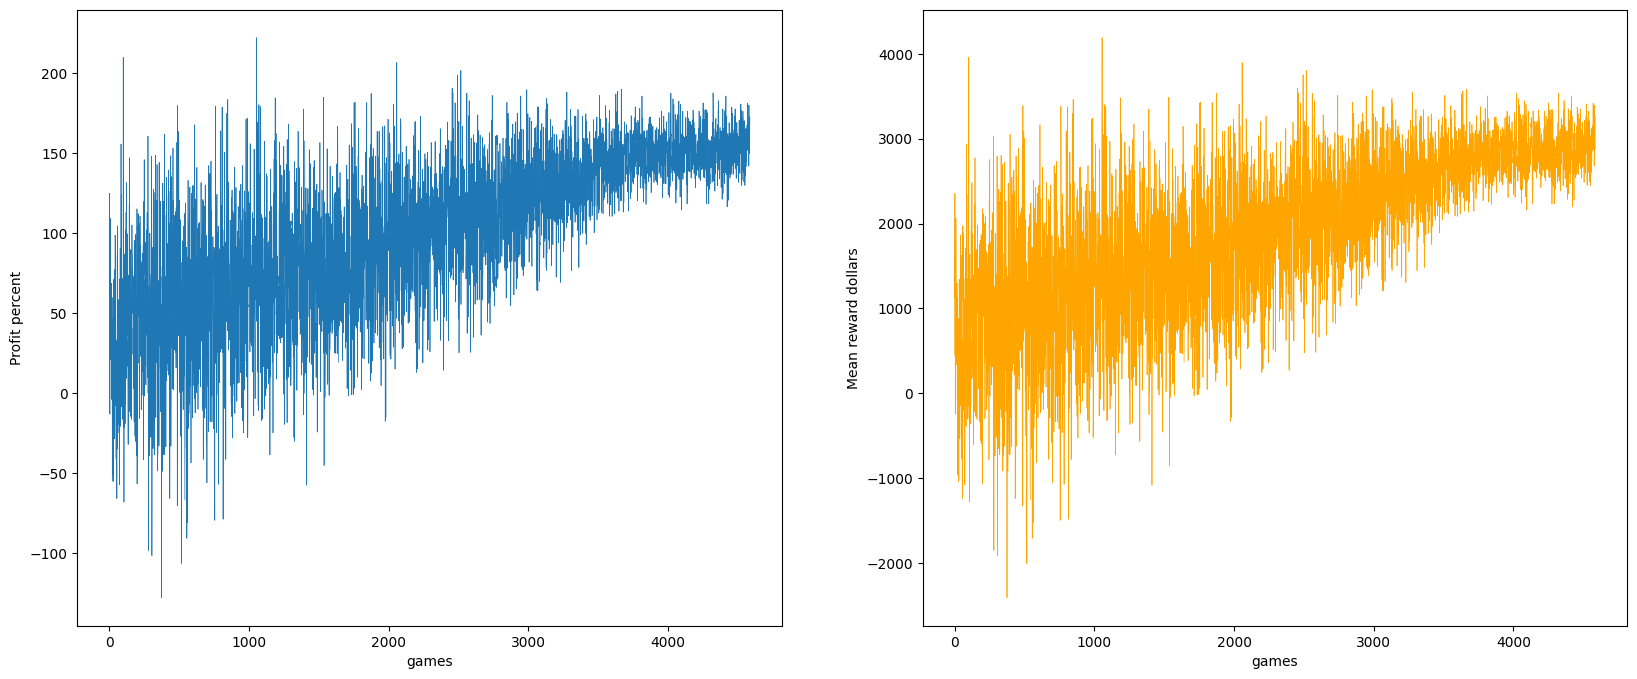

In [48]:
fig, ax=plt.subplots(1,2, figsize=(20,8))
ax[0].plot(np.array(plot_profit)*100,linewidth=0.5) #profit as a percentage
ax[0].set(xlabel='games', ylabel='Profit percent')

ax[1].plot(plot_reward, linewidth=0.5, color='orange')
ax[1].set(xlabel='games', ylabel='Mean reward dollars')

Text(0, 0.5, 'price')

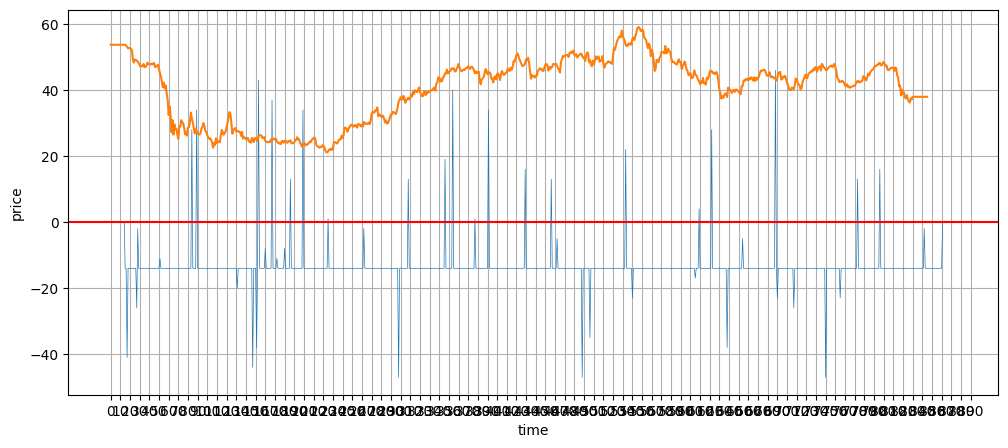

In [68]:
plt.figure(figsize=(12,5))
game_i=3800  #Change this to see actions in game i
game_length=stock_price.shape[0]  #length of stock price
np.pad(stock_price, (CONTEXT//2,CONTEXT//2),'constant', constant_values=(stock_price[0], stock_price[-1]))
#visualize actions
plt.plot(np.pad(np.array(actions[game_length*game_i:game_length*(game_i+1)])/100,(CONTEXT//2,CONTEXT//2),'constant', constant_values=(0,0) ),linewidth=0.5)
#plot stock price
plt.plot(stock_price)
plt.axhline(y = 0, color = 'r', linestyle = '-') #below red line are actions to sell, above are buy
plt.xticks(np.arange(0,stock_price.shape[0]+50,10))
plt.grid(True)
plt.xlabel('time')
plt.ylabel('price')

In [64]:
from google.colab import drive # Link your drive if you are a colab user
drive.mount('/content/drive') # Models in this HW take a long time to get trained and make sure to save it her

Mounted at /content/drive


In [65]:
path = "/content/drive/MyDrive/checkpoint01.pth"
print("Saving model")
torch.save({'model_state_dict':model.state_dict(),
                  'optimizer_state_dict':optimizer.state_dict()}, path)

Saving model


In [ ]:
PATH="/content/drive/MyDrive/hw2models/models1/checkpoint01.pth"
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])